<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

# <center> Assignment #10
## <center> Gradient boosting

Your task is to beat at least 2 benchmarks in this [Kaggle Inclass competition](https://www.kaggle.com/c/flight-delays-spring-2018). Here you won’t be provided with detailed instructions. We only give you a brief description of how the second benchmark was achieved using Xgboost. Hopefully, at this stage of the course, it's enough for you to take a quick look at the data in order to understand that this is the type of task where gradient boosting will do. Most likely it will be Xgboost, however, we’ve got plenty of categorical features here.

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import roc_auc_score
import gc

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


First I use simple logistic regression with some feature engineering:
1. Distance and DepTime are already used by baseline1
2. extract hour from DepTime and OHE it
3. OHE day of month, day of week, month

In [5]:
targetcol = 'dep_delayed_15min'

def concat_df_str(df):
    return pd.Series([''.join(row.astype(str)) for row in df.values], index=df.index)

def prepareDf(trainDf, testDf):
    ohecols = ['Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest','Hour','Flight','OriginHour','DestHour']
    scalecols = ['Distance', 'DepTime']
    
    
    split_idx = trainDf.shape[0]
    full_df = pd.concat([trainDf, testDf])
    for ccol in ['Month', 'DayofMonth', 'DayOfWeek']:
        full_df[ccol] = full_df[ccol].apply(lambda x: x.replace("c-", ""))
    full_df['Hour'] = (full_df['DepTime']/100).round().astype('int')
    full_df['Flight'] = concat_df_str(full_df[['Origin', 'Dest']])
    full_df['OriginHour'] = concat_df_str(full_df[['Origin', 'Hour']])
    full_df['DestHour'] = concat_df_str(full_df[['Dest', 'Hour']])
    
    full_df_dummies = pd.get_dummies(full_df, columns=ohecols, sparse=True)
    
    train_dummies = full_df_dummies[:split_idx]
    test_dummies = full_df_dummies[split_idx:]
    
    del full_df, full_df_dummies
    scaler = StandardScaler() 
    for column_name in scalecols : 
        train_dummies[column_name] = scaler.fit_transform(train_dummies[column_name].values.reshape(-1,1)).astype('float32') 
        test_dummies[column_name]  = scaler.transform(test_dummies[column_name].values.reshape(-1,1)).astype('float32')
    
    return train_dummies, test_dummies

In [6]:
X_train_scaled, X_test_scaled = prepareDf(train.drop([targetcol], axis=1), test)
y_train = train[targetcol].map({'Y':1.0, 'N':0.0})
print(X_train_scaled.shape, X_test_scaled.shape)
X_train_scaled.head()

(100000, 14577) (100000, 14577)


,DepTime,Distance,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,...,DestHour_YUM16,DestHour_YUM17,DestHour_YUM18,DestHour_YUM19,DestHour_YUM20,DestHour_YUM22,DestHour_YUM23,DestHour_YUM7,DestHour_YUM8,DestHour_YUM9
0,1.243715,0.004530,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.433431,0.182040,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.168934,-0.545405,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.685433,0.248172,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.021202,-0.533223,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
gc.collect()
cvkf = StratifiedKFold(n_splits=5)

lrcv = LogisticRegressionCV(Cs=10, scoring='roc_auc', cv=cvkf, n_jobs=1, verbose=5)
lrcv.fit(X_train_scaled, y_train)

Cmax = lrcv.C_[0]
print(lrcv.C_)

In [ ]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(train.drop([targetcol], axis=1), train[targetcol].map({'Y':1.0, 'N':0.0}), 
                     test_size=0.3, random_state=17)

X_train_part, X_valid = prepareDf(X_train_part, X_valid)

In [ ]:

logit = LogisticRegression(C=Cmax, n_jobs=-1)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

In [ ]:
X_train_scaled, X_test_scaled = prepareDf(train.drop([targetcol], axis=1), test)
y_train = train[targetcol].map({'Y':1.0, 'N':0.0})

logit = LogisticRegression(C=Cmax, n_jobs=-1)
logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_ohe_feats.csv', 
                                           index_label='id', header=True)

The second benchmark in the leaderboard was achieved as follows:

- Features `Distance` and `DepTime` were taken unchanged
- A feature `Flight` was created from features `Origin` and `Dest`
- Features `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` and `Flight` were transformed with OHE (`LabelBinarizer`)
- A holdout set was allocated
- Logistic regression and gradient boosting (xgboost) were trained. The hyperparameters of xgboost were tuned with cross-validation. First, the hyperparameters responsible for the complexity of the model were optimized, then the number of trees was fixed at 500 and the gradient descent step was tuned.
- Predictions of models (predicted probabilities) were made with cross-validation using cross_val_predict. A linear mixture of logistic regression and gradient boosting responses was set in the form $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, where $p_{logit}$is a probability of class 1, predicted by logistic regression, and $p_{xgb}$- by xgboost. $w_1$ weight was selected manually.
- A similar combination of responses of the two models was taken as a prediction on the test set, but this time the models were trained on the hole train set.

Following the same steps is not mandatory. That’s just a description of how the result was achieved by the author of this assignment. Perhaps you might not want to follow the same steps, and instead, let’s say will add a couple of good features and train a random forest of a thousand trees.

Good luck!

In [ ]:
dtrain_part = DMatrix(X_train_part, y_train_part)
dvalid = DMatrix(X_valid, y_valid)
del X_train_part, X_valid, y_train_part, y_valid
gc.collect()

In [7]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators': 1000,
             'objective': 'binary:logistic', 'max_depth':10, 'min_child_weight':11, 'eval_metric': 'auc'} 

In [ ]:
%%time
evallist = [(dvalid, 'eval'), (dtrain_part, 'train')]
cvresult = xgb.train(our_params, dtrain_part, 30, evallist)
print(cvresult)

In [ ]:
xgb_valid_pred = cvresult.predict(dvalid)
roc_auc_score(dvalid.get_label(), xgb_valid_pred)

In [ ]:
xgb = XGBClassifier(random_state=17, n_jobs=-1)
xgb.fit(dtrain_part, eval_metric="auc", verbose=10)
xgb_valid_pred = xgb.predict_proba(dvalid)[:, 1]
roc_auc_score(dvalid.get_label(), xgb_valid_pred)

In [8]:
dtrain = DMatrix(X_train_scaled, y_train)

In [9]:
xgbres = xgb.train(our_params, dtrain, 30)
#xgb.fit(X_train_scaled, y_train, eval_metric="auc", verbose=1)
print(xgbres)

In [21]:
xgbres.dump_model('dump.raw.txt')
xgbres.save_model('xgb.model')

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fa3ec6dad30>>
Traceback (most recent call last):
  File "/home/blindfold_ua/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fa386a1aeb8>>
Traceback (most recent call last):
  File "/home/blindfold_ua/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


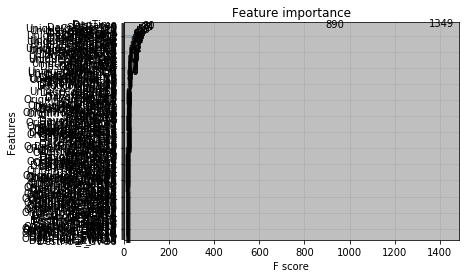

In [23]:
%matplotlib inline
xgb.plot_importance(xgbres)

In [27]:
#del X_train_part, X_valid
del X_train_scaled
#del dvalid
del dtrain

NameError: name 'X_train_scaled' is not defined

In [30]:
from sklearn import datasets
datasets.dump_svmlight_file(X_test_scaled, np.zeros(X_test_scaled.shape[0]), 'X_test_scaled.svm')

In [31]:
del X_test_scaled
gc.collect()
dtest = DMatrix('X_test_scaled.svm')

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fa3863e67f0>>
Traceback (most recent call last):
  File "/home/blindfold_ua/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


In [32]:
gc.collect()
xgb_test_pred = xgbres.predict(dtest)
pd.Series(xgb_test_pred, name='dep_delayed_15min').to_csv('xgb_only.csv', index_label='id', header=True)

ValueError: feature_names mismatch: ['DepTime', 'Distance', 'Month_1', 'Month_10', 'Month_11', 'Month_12', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'DayofMonth_1', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_2', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_3', 'DayofMonth_30', 'DayofMonth_31', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'UniqueCarrier_9E', 'UniqueCarrier_AA', 'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6', 'UniqueCarrier_CO', 'UniqueCarrier_DH', 'UniqueCarrier_DL', 'UniqueCarrier_EV', 'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA', 'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH', 'UniqueCarrier_OO', 'UniqueCarrier_TZ', 'UniqueCarrier_UA', 'UniqueCarrier_US', 'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV', 'Origin_ABE', 'Origin_ABI', 'Origin_ABQ', 'Origin_ABY', 'Origin_ACK', 'Origin_ACT', 'Origin_ACV', 'Origin_ACY', 'Origin_ADK', 'Origin_ADQ', 'Origin_AEX', 'Origin_AGS', 'Origin_AKN', 'Origin_ALB', 'Origin_ALO', 'Origin_AMA', 'Origin_ANC', 'Origin_APF', 'Origin_ASE', 'Origin_ATL', 'Origin_ATW', 'Origin_AUS', 'Origin_AVL', 'Origin_AVP', 'Origin_AZO', 'Origin_BDL', 'Origin_BET', 'Origin_BFL', 'Origin_BGM', 'Origin_BGR', 'Origin_BHM', 'Origin_BIL', 'Origin_BIS', 'Origin_BJI', 'Origin_BLI', 'Origin_BMI', 'Origin_BNA', 'Origin_BOI', 'Origin_BOS', 'Origin_BPT', 'Origin_BQK', 'Origin_BQN', 'Origin_BRO', 'Origin_BRW', 'Origin_BTM', 'Origin_BTR', 'Origin_BTV', 'Origin_BUF', 'Origin_BUR', 'Origin_BWI', 'Origin_BZN', 'Origin_CAE', 'Origin_CAK', 'Origin_CDC', 'Origin_CDV', 'Origin_CEC', 'Origin_CHA', 'Origin_CHO', 'Origin_CHS', 'Origin_CIC', 'Origin_CID', 'Origin_CLD', 'Origin_CLE', 'Origin_CLL', 'Origin_CLT', 'Origin_CMH', 'Origin_CMI', 'Origin_CMX', 'Origin_COD', 'Origin_COS', 'Origin_CPR', 'Origin_CRP', 'Origin_CRW', 'Origin_CSG', 'Origin_CVG', 'Origin_CWA', 'Origin_DAB', 'Origin_DAL', 'Origin_DAY', 'Origin_DBQ', 'Origin_DCA', 'Origin_DEN', 'Origin_DFW', 'Origin_DHN', 'Origin_DLG', 'Origin_DLH', 'Origin_DRO', 'Origin_DSM', 'Origin_DTW', 'Origin_EAU', 'Origin_EGE', 'Origin_EKO', 'Origin_ELM', 'Origin_ELP', 'Origin_ERI', 'Origin_EUG', 'Origin_EVV', 'Origin_EWN', 'Origin_EWR', 'Origin_EYW', 'Origin_FAI', 'Origin_FAR', 'Origin_FAT', 'Origin_FAY', 'Origin_FCA', 'Origin_FLG', 'Origin_FLL', 'Origin_FLO', 'Origin_FNT', 'Origin_FSD', 'Origin_FSM', 'Origin_FWA', 'Origin_GEG', 'Origin_GFK', 'Origin_GGG', 'Origin_GJT', 'Origin_GNV', 'Origin_GPT', 'Origin_GRB', 'Origin_GRK', 'Origin_GRR', 'Origin_GSO', 'Origin_GSP', 'Origin_GST', 'Origin_GTF', 'Origin_GTR', 'Origin_GUC', 'Origin_HDN', 'Origin_HHH', 'Origin_HKY', 'Origin_HLN', 'Origin_HNL', 'Origin_HOU', 'Origin_HPN', 'Origin_HRL', 'Origin_HSV', 'Origin_HTS', 'Origin_HVN', 'Origin_IAD', 'Origin_IAH', 'Origin_ICT', 'Origin_IDA', 'Origin_ILG', 'Origin_ILM', 'Origin_IND', 'Origin_INL', 'Origin_IPL', 'Origin_ISO', 'Origin_ISP', 'Origin_ITO', 'Origin_IYK', 'Origin_JAC', 'Origin_JAN', 'Origin_JAX', 'Origin_JFK', 'Origin_JNU', 'Origin_KOA', 'Origin_KTN', 'Origin_LAN', 'Origin_LAS', 'Origin_LAW', 'Origin_LAX', 'Origin_LBB', 'Origin_LCH', 'Origin_LEX', 'Origin_LFT', 'Origin_LGA', 'Origin_LGB', 'Origin_LIH', 'Origin_LIT', 'Origin_LNK', 'Origin_LRD', 'Origin_LSE', 'Origin_LWB', 'Origin_LWS', 'Origin_LYH', 'Origin_MAF', 'Origin_MBS', 'Origin_MCI', 'Origin_MCN', 'Origin_MCO', 'Origin_MDT', 'Origin_MDW', 'Origin_MEI', 'Origin_MEM', 'Origin_MFE', 'Origin_MFR', 'Origin_MGM', 'Origin_MHT', 'Origin_MIA', 'Origin_MKE', 'Origin_MLB', 'Origin_MLI', 'Origin_MLU', 'Origin_MOB', 'Origin_MOD', 'Origin_MOT', 'Origin_MQT', 'Origin_MRY', 'Origin_MSN', 'Origin_MSO', 'Origin_MSP', 'Origin_MSY', 'Origin_MTH', 'Origin_MTJ', 'Origin_MYR', 'Origin_OAJ', 'Origin_OAK', 'Origin_OGG', 'Origin_OKC', 'Origin_OMA', 'Origin_OME', 'Origin_ONT', 'Origin_ORD', 'Origin_ORF', 'Origin_OTZ', 'Origin_OXR', 'Origin_PBI', 'Origin_PDX', 'Origin_PFN', 'Origin_PHF', 'Origin_PHL', 'Origin_PHX', 'Origin_PIA', 'Origin_PIE', 'Origin_PIH', 'Origin_PIT', 'Origin_PLN', 'Origin_PMD', 'Origin_PNS', 'Origin_PSC', 'Origin_PSE', 'Origin_PSG', 'Origin_PSP', 'Origin_PVD', 'Origin_PWM', 'Origin_RAP', 'Origin_RDD', 'Origin_RDM', 'Origin_RDU', 'Origin_RFD', 'Origin_RHI', 'Origin_RIC', 'Origin_RNO', 'Origin_ROA', 'Origin_ROC', 'Origin_ROW', 'Origin_RST', 'Origin_RSW', 'Origin_SAN', 'Origin_SAT', 'Origin_SAV', 'Origin_SBA', 'Origin_SBN', 'Origin_SBP', 'Origin_SCC', 'Origin_SCE', 'Origin_SDF', 'Origin_SEA', 'Origin_SFO', 'Origin_SGF', 'Origin_SGU', 'Origin_SHV', 'Origin_SIT', 'Origin_SJC', 'Origin_SJT', 'Origin_SJU', 'Origin_SLC', 'Origin_SLE', 'Origin_SMF', 'Origin_SMX', 'Origin_SNA', 'Origin_SOP', 'Origin_SPI', 'Origin_SPS', 'Origin_SRQ', 'Origin_STL', 'Origin_STT', 'Origin_STX', 'Origin_SUN', 'Origin_SUX', 'Origin_SWF', 'Origin_SYR', 'Origin_TEX', 'Origin_TLH', 'Origin_TOL', 'Origin_TPA', 'Origin_TRI', 'Origin_TTN', 'Origin_TUL', 'Origin_TUP', 'Origin_TUS', 'Origin_TVC', 'Origin_TWF', 'Origin_TXK', 'Origin_TYR', 'Origin_TYS', 'Origin_VCT', 'Origin_VIS', 'Origin_VLD', 'Origin_VPS', 'Origin_WRG', 'Origin_WYS', 'Origin_XNA', 'Origin_YAK', 'Origin_YKM', 'Origin_YUM', 'Dest_ABE', 'Dest_ABI', 'Dest_ABQ', 'Dest_ABY', 'Dest_ACK', 'Dest_ACT', 'Dest_ACV', 'Dest_ACY', 'Dest_ADK', 'Dest_ADQ', 'Dest_AEX', 'Dest_AGS', 'Dest_AKN', 'Dest_ALB', 'Dest_ALO', 'Dest_AMA', 'Dest_ANC', 'Dest_APF', 'Dest_ASE', 'Dest_ATL', 'Dest_ATW', 'Dest_AUS', 'Dest_AVL', 'Dest_AVP', 'Dest_AZO', 'Dest_BDL', 'Dest_BET', 'Dest_BFL', 'Dest_BGM', 'Dest_BGR', 'Dest_BHM', 'Dest_BIL', 'Dest_BIS', 'Dest_BJI', 'Dest_BLI', 'Dest_BMI', 'Dest_BNA', 'Dest_BOI', 'Dest_BOS', 'Dest_BPT', 'Dest_BQK', 'Dest_BQN', 'Dest_BRO', 'Dest_BRW', 'Dest_BTM', 'Dest_BTR', 'Dest_BTV', 'Dest_BUF', 'Dest_BUR', 'Dest_BWI', 'Dest_BZN', 'Dest_CAE', 'Dest_CAK', 'Dest_CDC', 'Dest_CDV', 'Dest_CEC', 'Dest_CHA', 'Dest_CHO', 'Dest_CHS', 'Dest_CIC', 'Dest_CID', 'Dest_CLD', 'Dest_CLE', 'Dest_CLL', 'Dest_CLT', 'Dest_CMH', 'Dest_CMI', 'Dest_CMX', 'Dest_COD', 'Dest_COS', 'Dest_CPR', 'Dest_CRP', 'Dest_CRW', 'Dest_CSG', 'Dest_CVG', 'Dest_CWA', 'Dest_DAB', 'Dest_DAL', 'Dest_DAY', 'Dest_DBQ', 'Dest_DCA', 'Dest_DEN', 'Dest_DFW', 'Dest_DHN', 'Dest_DLG', 'Dest_DLH', 'Dest_DRO', 'Dest_DSM', 'Dest_DTW', 'Dest_EAU', 'Dest_EGE', 'Dest_EKO', 'Dest_ELM', 'Dest_ELP', 'Dest_ERI', 'Dest_EUG', 'Dest_EVV', 'Dest_EWN', 'Dest_EWR', 'Dest_EYW', 'Dest_FAI', 'Dest_FAR', 'Dest_FAT', 'Dest_FAY', 'Dest_FCA', 'Dest_FLG', 'Dest_FLL', 'Dest_FLO', 'Dest_FNT', 'Dest_FSD', 'Dest_FSM', 'Dest_FWA', 'Dest_GEG', 'Dest_GFK', 'Dest_GGG', 'Dest_GJT', 'Dest_GNV', 'Dest_GPT', 'Dest_GRB', 'Dest_GRK', 'Dest_GRR', 'Dest_GSO', 'Dest_GSP', 'Dest_GST', 'Dest_GTF', 'Dest_GTR', 'Dest_GUC', 'Dest_HDN', 'Dest_HHH', 'Dest_HKY', 'Dest_HLN', 'Dest_HNL', 'Dest_HOU', 'Dest_HPN', 'Dest_HRL', 'Dest_HSV', 'Dest_HTS', 'Dest_HVN', 'Dest_IAD', 'Dest_IAH', 'Dest_ICT', 'Dest_IDA', 'Dest_ILG', 'Dest_ILM', 'Dest_IND', 'Dest_INL', 'Dest_IPL', 'Dest_ISO', 'Dest_ISP', 'Dest_ITO', 'Dest_IYK', 'Dest_JAC', 'Dest_JAN', 'Dest_JAX', 'Dest_JFK', 'Dest_JNU', 'Dest_KOA', 'Dest_KTN', 'Dest_LAN', 'Dest_LAS', 'Dest_LAW', 'Dest_LAX', 'Dest_LBB', 'Dest_LCH', 'Dest_LEX', 'Dest_LFT', 'Dest_LGA', 'Dest_LGB', 'Dest_LIH', 'Dest_LIT', 'Dest_LNK', 'Dest_LRD', 'Dest_LSE', 'Dest_LWB', 'Dest_LWS', 'Dest_LYH', 'Dest_MAF', 'Dest_MBS', 'Dest_MCI', 'Dest_MCN', 'Dest_MCO', 'Dest_MDT', 'Dest_MDW', 'Dest_MEI', 'Dest_MEM', 'Dest_MFE', 'Dest_MFR', 'Dest_MGM', 'Dest_MHT', 'Dest_MIA', 'Dest_MKE', 'Dest_MLB', 'Dest_MLI', 'Dest_MLU', 'Dest_MOB', 'Dest_MOD', 'Dest_MOT', 'Dest_MQT', 'Dest_MRY', 'Dest_MSN', 'Dest_MSO', 'Dest_MSP', 'Dest_MSY', 'Dest_MTH', 'Dest_MTJ', 'Dest_MYR', 'Dest_OAJ', 'Dest_OAK', 'Dest_OGG', 'Dest_OKC', 'Dest_OMA', 'Dest_OME', 'Dest_ONT', 'Dest_ORD', 'Dest_ORF', 'Dest_OTZ', 'Dest_OXR', 'Dest_PBI', 'Dest_PDX', 'Dest_PFN', 'Dest_PHF', 'Dest_PHL', 'Dest_PHX', 'Dest_PIA', 'Dest_PIE', 'Dest_PIH', 'Dest_PIT', 'Dest_PLN', 'Dest_PMD', 'Dest_PNS', 'Dest_PSC', 'Dest_PSE', 'Dest_PSG', 'Dest_PSP', 'Dest_PVD', 'Dest_PWM', 'Dest_RAP', 'Dest_RDD', 'Dest_RDM', 'Dest_RDU', 'Dest_RFD', 'Dest_RHI', 'Dest_RIC', 'Dest_RNO', 'Dest_ROA', 'Dest_ROC', 'Dest_ROW', 'Dest_RST', 'Dest_RSW', 'Dest_SAN', 'Dest_SAT', 'Dest_SAV', 'Dest_SBA', 'Dest_SBN', 'Dest_SBP', 'Dest_SCC', 'Dest_SCE', 'Dest_SDF', 'Dest_SEA', 'Dest_SFO', 'Dest_SGF', 'Dest_SGU', 'Dest_SHV', 'Dest_SIT', 'Dest_SJC', 'Dest_SJT', 'Dest_SJU', 'Dest_SLC', 'Dest_SLE', 'Dest_SMF', 'Dest_SMX', 'Dest_SNA', 'Dest_SOP', 'Dest_SPI', 'Dest_SPS', 'Dest_SRQ', 'Dest_STL', 'Dest_STT', 'Dest_STX', 'Dest_SUN', 'Dest_SUX', 'Dest_SWF', 'Dest_SYR', 'Dest_TEX', 'Dest_TLH', 'Dest_TOL', 'Dest_TPA', 'Dest_TRI', 'Dest_TTN', 'Dest_TUL', 'Dest_TUP', 'Dest_TUS', 'Dest_TVC', 'Dest_TWF', 'Dest_TXK', 'Dest_TYR', 'Dest_TYS', 'Dest_VCT', 'Dest_VIS', 'Dest_VLD', 'Dest_VPS', 'Dest_WRG', 'Dest_WYS', 'Dest_XNA', 'Dest_YAK', 'Dest_YKM', 'Dest_YUM', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'Hour_24', 'Hour_25', 'Flight_ABEATL', 'Flight_ABECLE', 'Flight_ABECLT', 'Flight_ABECVG', 'Flight_ABEDTW', 'Flight_ABEORD', 'Flight_ABEPHL', 'Flight_ABIDFW', 'Flight_ABIIAH', 'Flight_ABQAMA', 'Flight_ABQATL', 'Flight_ABQAUS', 'Flight_ABQBWI', 'Flight_ABQCVG', 'Flight_ABQDAL', 'Flight_ABQDEN', 'Flight_ABQDFW', 'Flight_ABQELP', 'Flight_ABQEWR', 'Flight_ABQHOU', 'Flight_ABQIAD', 'Flight_ABQIAH', 'Flight_ABQLAS', 'Flight_ABQLAX', 'Flight_ABQLBB', 'Flight_ABQMAF', 'Flight_ABQMCI', 'Flight_ABQMCO', 'Flight_ABQMDW', 'Flight_ABQMSP', 'Flight_ABQOAK', 'Flight_ABQOKC', 'Flight_ABQONT', 'Flight_ABQORD', 'Flight_ABQPDX', 'Flight_ABQPHX', 'Flight_ABQSAN', 'Flight_ABQSAT', 'Flight_ABQSEA', 'Flight_ABQSFO', 'Flight_ABQSLC', 'Flight_ABQSMF', 'Flight_ABQSTL', 'Flight_ABQTPA', 'Flight_ABQTUL', 'Flight_ABQTUS', 'Flight_ABYATL', 'Flight_ACKEWR', 'Flight_ACKJFK', 'Flight_ACTDFW', 'Flight_ACTIAH', 'Flight_ACVCEC', 'Flight_ACVSFO', 'Flight_ACVSMF', 'Flight_ACYATL', 'Flight_ACYCVG', 'Flight_ACYMCO', 'Flight_ADKAKN', 'Flight_ADKANC', 'Flight_ADQANC', 'Flight_AEXATL', 'Flight_AEXDFW', 'Flight_AEXIAH', 'Flight_AGSATL', 'Flight_AGSCLT', 'Flight_AKNANC', 'Flight_ALBATL', 'Flight_ALBBWI', 'Flight_ALBCLE', 'Flight_ALBCLT', 'Flight_ALBCVG', 'Flight_ALBDCA', 'Flight_ALBDTW', 'Flight_ALBEWR', 'Flight_ALBIAD', 'Flight_ALBLAS', 'Flight_ALBMCO', 'Flight_ALBMDW', 'Flight_ALBMSP', 'Flight_ALBORD', 'Flight_ALBPHL', 'Flight_ALBTPA', 'Flight_ALOMSP', 'Flight_AMAABQ', 'Flight_AMADAL', 'Flight_AMADFW', 'Flight_AMAIAH', 'Flight_AMALAS', 'Flight_ANCADK', 'Flight_ANCADQ', 'Flight_ANCAKN', 'Flight_ANCATL', 'Flight_ANCBET', 'Flight_ANCCDV', 'Flight_ANCCVG', 'Flight_ANCDEN', 'Flight_ANCDFW', 'Flight_ANCDLG', 'Flight_ANCDTW', 'Flight_ANCFAI', 'Flight_ANCIAH', 'Flight_ANCJNU', 'Flight_ANCLAS', 'Flight_ANCLAX', 'Flight_ANCMSP', 'Flight_ANCOGG', 'Flight_ANCOME', 'Flight_ANCORD', 'Flight_ANCOTZ', 'Flight_ANCPDX', 'Flight_ANCPHX', 'Flight_ANCSCC', 'Flight_ANCSEA', 'Flight_ANCSFO', 'Flight_ANCSLC', 'Flight_APFATL', 'Flight_ASEDEN', 'Flight_ASELAX', 'Flight_ASEORD', 'Flight_ASEPHX', 'Flight_ASESFO', 'Flight_ASESLC', 'Flight_ATLABE', 'Flight_ATLABQ', 'Flight_ATLABY', 'Flight_ATLACY', 'Flight_ATLAEX', 'Flight_ATLAGS', 'Flight_ATLALB', 'Flight_ATLANC', 'Flight_ATLAPF', 'Flight_ATLATW', 'Flight_ATLAUS', 'Flight_ATLAVL', 'Flight_ATLAVP', 'Flight_ATLAZO', 'Flight_ATLBDL', 'Flight_ATLBGM', 'Flight_ATLBGR', 'Flight_ATLBHM', 'Flight_ATLBMI', 'Flight_ATLBNA', 'Flight_ATLBOI', 'Flight_ATLBOS', 'Flight_ATLBPT', 'Flight_ATLBQK', 'Flight_ATLBQN', 'Flight_ATLBTR', 'Flight_ATLBTV', 'Flight_ATLBUF', 'Flight_ATLBUR', 'Flight_ATLBWI', 'Flight_ATLBZN', 'Flight_ATLCAE', 'Flight_ATLCAK', 'Flight_ATLCHA', 'Flight_ATLCHO', 'Flight_ATLCHS', 'Flight_ATLCID', 'Flight_ATLCLE', 'Flight_ATLCLT', 'Flight_ATLCMH', 'Flight_ATLCOS', 'Flight_ATLCRP', 'Flight_ATLCRW', 'Flight_ATLCSG', 'Flight_ATLCVG', 'Flight_ATLDAB', 'Flight_ATLDAY', 'Flight_ATLDCA', 'Flight_ATLDEN', 'Flight_ATLDFW', 'Flight_ATLDHN', 'Flight_ATLDSM', 'Flight_ATLDTW', 'Flight_ATLEGE', 'Flight_ATLELP', 'Flight_ATLERI', 'Flight_ATLEVV', 'Flight_ATLEWN', 'Flight_ATLEWR', 'Flight_ATLEYW', 'Flight_ATLFAY', 'Flight_ATLFCA', 'Flight_ATLFLL', 'Flight_ATLFLO', 'Flight_ATLFNT', 'Flight_ATLFSD', 'Flight_ATLFSM', 'Flight_ATLFWA', 'Flight_ATLGNV', 'Flight_ATLGPT', 'Flight_ATLGRB', 'Flight_ATLGRK', 'Flight_ATLGRR', 'Flight_ATLGSO', 'Flight_ATLGSP', 'Flight_ATLGTR', 'Flight_ATLGUC', 'Flight_ATLHDN', 'Flight_ATLHHH', 'Flight_ATLHKY', 'Flight_ATLHNL', 'Flight_ATLHOU', 'Flight_ATLHPN', 'Flight_ATLHSV', 'Flight_ATLIAD', 'Flight_ATLIAH', 'Flight_ATLICT', 'Flight_ATLILG', 'Flight_ATLILM', 'Flight_ATLIND', 'Flight_ATLISO', 'Flight_ATLISP', 'Flight_ATLJAC', 'Flight_ATLJAN', 'Flight_ATLJAX', 'Flight_ATLJFK', 'Flight_ATLLAN', 'Flight_ATLLAS', 'Flight_ATLLAX', 'Flight_ATLLEX', 'Flight_ATLLFT', 'Flight_ATLLGA', 'Flight_ATLLIT', 'Flight_ATLLWB', 'Flight_ATLLYH', 'Flight_ATLMCI', 'Flight_ATLMCN', 'Flight_ATLMCO', 'Flight_ATLMDT', 'Flight_ATLMDW', 'Flight_ATLMEI', 'Flight_ATLMEM', 'Flight_ATLMFE', 'Flight_ATLMGM', 'Flight_ATLMHT', 'Flight_ATLMIA', 'Flight_ATLMKE', 'Flight_ATLMLB', 'Flight_ATLMLI', 'Flight_ATLMLU', 'Flight_ATLMOB', 'Flight_ATLMSN', 'Flight_ATLMSP', 'Flight_ATLMSY', 'Flight_ATLMTH', 'Flight_ATLMTJ', 'Flight_ATLMYR', 'Flight_ATLOAJ', 'Flight_ATLOAK', 'Flight_ATLOGG', 'Flight_ATLOKC', 'Flight_ATLOMA', 'Flight_ATLONT', 'Flight_ATLORD', 'Flight_ATLORF', 'Flight_ATLPBI', 'Flight_ATLPDX', 'Flight_ATLPFN', 'Flight_ATLPHF', 'Flight_ATLPHL', 'Flight_ATLPHX', 'Flight_ATLPIA', 'Flight_ATLPIT', 'Flight_ATLPNS', 'Flight_ATLPSP', 'Flight_ATLPVD', 'Flight_ATLPWM', 'Flight_ATLRDU', 'Flight_ATLRIC', 'Flight_ATLRNO', 'Flight_ATLROA', 'Flight_ATLROC', 'Flight_ATLRSW', 'Flight_ATLSAN', 'Flight_ATLSAT', 'Flight_ATLSAV', 'Flight_ATLSBN', 'Flight_ATLSCE', 'Flight_ATLSDF', 'Flight_ATLSEA', 'Flight_ATLSFO', 'Flight_ATLSGF', 'Flight_ATLSHV', 'Flight_ATLSJC', 'Flight_ATLSJU', 'Flight_ATLSLC', 'Flight_ATLSMF', 'Flight_ATLSNA', 'Flight_ATLSOP', 'Flight_ATLSRQ', 'Flight_ATLSTL', 'Flight_ATLSTT', 'Flight_ATLSTX', 'Flight_ATLSWF', 'Flight_ATLSYR', 'Flight_ATLTLH', 'Flight_ATLTOL', 'Flight_ATLTPA', 'Flight_ATLTRI', 'Flight_ATLTTN', 'Flight_ATLTUL', 'Flight_ATLTUP', 'Flight_ATLTUS', 'Flight_ATLTYS', 'Flight_ATLVLD', 'Flight_ATLVPS', 'Flight_ATLXNA', 'Flight_ATWATL', 'Flight_ATWCVG', 'Flight_ATWDTW', 'Flight_ATWMSP', 'Flight_ATWORD', 'Flight_AUSABQ', 'Flight_AUSATL', 'Flight_AUSBNA', 'Flight_AUSBOS', 'Flight_AUSBWI', 'Flight_AUSCLE', 'Flight_AUSCRP', 'Flight_AUSCVG', 'Flight_AUSDAL', 'Flight_AUSDEN', 'Flight_AUSDFW', 'Flight_AUSDTW', 'Flight_AUSELP', 'Flight_AUSEWR', 'Flight_AUSHOU', 'Flight_AUSHRL', 'Flight_AUSIAD', 'Flight_AUSIAH', 'Flight_AUSJAX', 'Flight_AUSJFK', 'Flight_AUSLAS', 'Flight_AUSLAX', 'Flight_AUSLBB', 'Flight_AUSMAF', 'Flight_AUSMCI', 'Flight_AUSMCO', 'Flight_AUSMDW', 'Flight_AUSMEM', 'Flight_AUSMSP', 'Flight_AUSMSY', 'Flight_AUSOKC', 'Flight_AUSONT', 'Flight_AUSORD', 'Flight_AUSPHX', 'Flight_AUSRDU', 'Flight_AUSSAN', 'Flight_AUSSEA', 'Flight_AUSSFO', 'Flight_AUSSJC', 'Flight_AUSSLC', 'Flight_AUSSNA', 'Flight_AUSSTL', 'Flight_AUSTPA', 'Flight_AUSTUL', 'Flight_AUSTUS', 'Flight_AVLATL', 'Flight_AVLCVG', 'Flight_AVLDTW', 'Flight_AVLEWR', 'Flight_AVLIAH', 'Flight_AVLMSP', 'Flight_AVPATL', 'Flight_AVPCVG', 'Flight_AVPDTW', 'Flight_AVPJFK', 'Flight_AVPORD', 'Flight_AZOATL', 'Flight_AZOCVG', 'Flight_AZODTW', 'Flight_AZOMSP', 'Flight_AZOORD', 'Flight_BDLATL', 'Flight_BDLBNA', 'Flight_BDLBOS', 'Flight_BDLBWI', 'Flight_BDLCLE', 'Flight_BDLCLT', 'Flight_BDLCVG', 'Flight_BDLDCA', 'Flight_BDLDEN', 'Flight_BDLDFW', 'Flight_BDLDTW', 'Flight_BDLEWR', 'Flight_BDLFLL', 'Flight_BDLIAD', 'Flight_BDLIAH', 'Flight_BDLIND', 'Flight_BDLJFK', 'Flight_BDLLAS', 'Flight_BDLLAX', 'Flight_BDLMCO', 'Flight_BDLMDW', 'Flight_BDLMIA', 'Flight_BDLMKE', 'Flight_BDLMSP', 'Flight_BDLORD', 'Flight_BDLPBI', 'Flight_BDLPHL', 'Flight_BDLPHX', 'Flight_BDLPIT', 'Flight_BDLRDU', 'Flight_BDLRSW', 'Flight_BDLSJU', 'Flight_BDLSLC', 'Flight_BDLTPA', 'Flight_BETANC', 'Flight_BFLDEN', 'Flight_BFLIAH', 'Flight_BFLLAS', 'Flight_BFLLAX', 'Flight_BFLPHX', 'Flight_BFLSAN', 'Flight_BFLSFO', 'Flight_BFLSLC', 'Flight_BFLSMF', 'Flight_BGMATL', 'Flight_BGMCVG', 'Flight_BGMDTW', 'Flight_BGRATL', 'Flight_BGRBOS', 'Flight_BGRCVG', 'Flight_BGRDTW', 'Flight_BGREWR', 'Flight_BGRLGA', 'Flight_BHMATL', 'Flight_BHMBNA', 'Flight_BHMBWI', 'Flight_BHMCLE', 'Flight_BHMCLT', 'Flight_BHMCVG', 'Flight_BHMDAL', 'Flight_BHMDCA', 'Flight_BHMDEN', 'Flight_BHMDFW', 'Flight_BHMDTW', 'Flight_BHMEWR', 'Flight_BHMHOU', 'Flight_BHMIAD', 'Flight_BHMIAH', 'Flight_BHMJAX', 'Flight_BHMLAS', 'Flight_BHMLGA', 'Flight_BHMMCO', 'Flight_BHMMDW', 'Flight_BHMMEM', 'Flight_BHMMSY', 'Flight_BHMORD', 'Flight_BHMPHX', 'Flight_BHMRDU', 'Flight_BHMSDF', 'Flight_BHMSLC', 'Flight_BHMSTL', 'Flight_BHMTPA', 'Flight_BILDEN', 'Flight_BILJAC', 'Flight_BILMSP', 'Flight_BILORD', 'Flight_BILSLC', 'Flight_BISDEN', 'Flight_BISMSP', 'Flight_BJIMSP', 'Flight_BLISLC', 'Flight_BMIATL', 'Flight_BMIMCO', 'Flight_BMIORD', 'Flight_BNAATL', 'Flight_BNAAUS', 'Flight_BNABDL', 'Flight_BNABHM', 'Flight_BNABOS', 'Flight_BNABWI', 'Flight_BNACLE', 'Flight_BNACLT', 'Flight_BNACMH', 'Flight_BNACVG', 'Flight_BNADCA', 'Flight_BNADEN', 'Flight_BNADFW', 'Flight_BNADTW', 'Flight_BNAEWR', 'Flight_BNAFLL', 'Flight_BNAHOU', 'Flight_BNAIAD', 'Flight_BNAIAH', 'Flight_BNAISP', 'Flight_BNAJAX', 'Flight_BNAJFK', 'Flight_BNALAS', 'Flight_BNALAX', 'Flight_BNALGA', 'Flight_BNAMCI', 'Flight_BNAMCO', 'Flight_BNAMDW', 'Flight_BNAMEM', 'Flight_BNAMHT', 'Flight_BNAMIA', 'Flight_BNAMSP', 'Flight_BNAMSY', 'Flight_BNAOAK', 'Flight_BNAONT', 'Flight_BNAORD', 'Flight_BNAPHL', 'Flight_BNAPHX', 'Flight_BNAPVD', 'Flight_BNARDU', 'Flight_BNASAN', 'Flight_BNASAT', 'Flight_BNASEA', 'Flight_BNASLC', 'Flight_BNASTL', 'Flight_BNATPA', 'Flight_BOIATL', 'Flight_BOIDEN', 'Flight_BOIGEG', 'Flight_BOIIAH', 'Flight_BOILAS', 'Flight_BOILAX', 'Flight_BOIMSP', 'Flight_BOIOAK', 'Flight_BOIONT', 'Flight_BOIORD', 'Flight_BOIPDX', 'Flight_BOIPHX', 'Flight_BOIRNO', 'Flight_BOISAN', 'Flight_BOISEA', 'Flight_BOISFO', 'Flight_BOISLC', 'Flight_BOSATL', 'Flight_BOSAUS', 'Flight_BOSBGR', 'Flight_BOSBNA', 'Flight_BOSBTV', 'Flight_BOSBUF', 'Flight_BOSBWI', 'Flight_BOSCAK', 'Flight_BOSCHS', 'Flight_BOSCLE', 'Flight_BOSCLT', 'Flight_BOSCMH', 'Flight_BOSCVG', 'Flight_BOSDCA', 'Flight_BOSDEN', 'Flight_BOSDFW', 'Flight_BOSDTW', 'Flight_BOSEWR', 'Flight_BOSFLL', 'Flight_BOSGSO', 'Flight_BOSIAD', 'Flight_BOSIAH', 'Flight_BOSIND', 'Flight_BOSJAX', 'Flight_BOSJFK', 'Flight_BOSLAS', 'Flight_BOSLAX', 'Flight_BOSLGA', 'Flight_BOSLGB', 'Flight_BOSMCO', 'Flight_BOSMDW', 'Flight_BOSMEM', 'Flight_BOSMIA', 'Flight_BOSMSP', 'Flight_BOSMYR', 'Flight_BOSOAK', 'Flight_BOSORD', 'Flight_BOSORF', 'Flight_BOSPBI', 'Flight_BOSPDX', 'Flight_BOSPHF', 'Flight_BOSPHL', 'Flight_BOSPHX', 'Flight_BOSPIT', 'Flight_BOSPWM', 'Flight_BOSRDU', 'Flight_BOSRIC', 'Flight_BOSRSW', 'Flight_BOSSAN', 'Flight_BOSSAV', 'Flight_BOSSDF', 'Flight_BOSSEA', 'Flight_BOSSFO', 'Flight_BOSSJC', 'Flight_BOSSJU', 'Flight_BOSSLC', 'Flight_BOSSRQ', 'Flight_BOSSTL', 'Flight_BOSSTT', 'Flight_BOSTPA', 'Flight_BOSTTN', 'Flight_BPTATL', 'Flight_BPTIAH', 'Flight_BQKATL', 'Flight_BQNEWR', 'Flight_BQNJFK', 'Flight_BQNMCO', 'Flight_BROIAH', 'Flight_BRWANC', 'Flight_BRWFAI', 'Flight_BRWSCC', 'Flight_BTMSLC', 'Flight_BTRATL', 'Flight_BTRCVG', 'Flight_BTRDCA', 'Flight_BTRDFW', 'Flight_BTREWR', 'Flight_BTRIAH', 'Flight_BTRLGA', 'Flight_BTRMEM', 'Flight_BTRORD', 'Flight_BTVATL', 'Flight_BTVBOS', 'Flight_BTVCLE', 'Flight_BTVCVG', 'Flight_BTVDCA', 'Flight_BTVDTW', 'Flight_BTVEWR', 'Flight_BTVIAD', 'Flight_BTVJFK', 'Flight_BTVMSP', 'Flight_BTVORD', 'Flight_BTVPHL', 'Flight_BUFATL', 'Flight_BUFBOS', 'Flight_BUFBWI', 'Flight_BUFCLE', 'Flight_BUFCLT', 'Flight_BUFCVG', 'Flight_BUFDCA', 'Flight_BUFDFW', 'Flight_BUFDTW', 'Flight_BUFEWR', 'Flight_BUFIAD', 'Flight_BUFJFK', 'Flight_BUFLAS', 'Flight_BUFLGA', 'Flight_BUFMCO', 'Flight_BUFMDW', 'Flight_BUFMSP', 'Flight_BUFORD', 'Flight_BUFPHL', 'Flight_BUFPHX', 'Flight_BUFTPA', 'Flight_BURATL', 'Flight_BURDEN', 'Flight_BURDFW', 'Flight_BURJFK', 'Flight_BURLAS', 'Flight_BURMCO', 'Flight_BUROAK', 'Flight_BURPDX', 'Flight_BURPHX', 'Flight_BURSEA', 'Flight_BURSFO', 'Flight_BURSJC', 'Flight_BURSLC', 'Flight_BURSMF', 'Flight_BWIABQ', 'Flight_BWIALB', 'Flight_BWIATL', 'Flight_BWIAUS', 'Flight_BWIBDL', 'Flight_BWIBHM', 'Flight_BWIBNA', 'Flight_BWIBOS', 'Flight_BWIBUF', 'Flight_BWICLE', 'Flight_BWICLT', 'Flight_BWICMH', 'Flight_BWICVG', 'Flight_BWIDAY', 'Flight_BWIDCA', 'Flight_BWIDEN', 'Flight_BWIDFW', 'Flight_BWIDTW', 'Flight_BWIEWR', 'Flight_BWIFLL', 'Flight_BWIHOU', 'Flight_BWIIAH', 'Flight_BWIIND', 'Flight_BWIISP', 'Flight_BWIJAN', 'Flight_BWIJAX', 'Flight_BWIJFK', 'Flight_BWILAS', 'Flight_BWILAX', 'Flight_BWILIT', 'Flight_BWIMCI', 'Flight_BWIMCO', 'Flight_BWIMDW', 'Flight_BWIMEM', 'Flight_BWIMHT', 'Flight_BWIMIA', 'Flight_BWIMKE', 'Flight_BWIMSP', 'Flight_BWIMSY', 'Flight_BWIOAK', 'Flight_BWIOKC', 'Flight_BWIORD', 'Flight_BWIORF', 'Flight_BWIPBI', 'Flight_BWIPHL', 'Flight_BWIPHX', 'Flight_BWIPIT', 'Flight_BWIPVD', 'Flight_BWIPWM', 'Flight_BWIRDU', 'Flight_BWIROC', 'Flight_BWIRSW', 'Flight_BWISAN', 'Flight_BWISAT', 'Flight_BWISDF', 'Flight_BWISEA', 'Flight_BWISFO', 'Flight_BWISJU', 'Flight_BWISLC', 'Flight_BWISRQ', 'Flight_BWISTL', 'Flight_BWITPA', 'Flight_BZNATL', 'Flight_BZNDEN', 'Flight_BZNDTW', 'Flight_BZNIDA', 'Flight_BZNMSP', 'Flight_BZNORD', 'Flight_BZNSLC', 'Flight_CAEATL', 'Flight_CAECLT', 'Flight_CAECVG', 'Flight_CAEDFW', 'Flight_CAEDTW', 'Flight_CAEEWR', 'Flight_CAEIAD', 'Flight_CAEIAH', 'Flight_CAELGA', 'Flight_CAEMCO', 'Flight_CAEMEM', 'Flight_CAEORD', 'Flight_CAEPHL', 'Flight_CAETPA', 'Flight_CAKATL', 'Flight_CAKBOS', 'Flight_CAKCVG', 'Flight_CAKDEN', 'Flight_CAKDTW', 'Flight_CAKFLL', 'Flight_CAKLAS', 'Flight_CAKLGA', 'Flight_CAKMCO', 'Flight_CAKORD', 'Flight_CAKRSW', 'Flight_CAKTPA', 'Flight_CDCSLC', 'Flight_CDVANC', 'Flight_CDVYAK', 'Flight_CECACV', 'Flight_CECSFO', 'Flight_CHAATL', 'Flight_CHACVG', 'Flight_CHADFW', 'Flight_CHAIAH', 'Flight_CHAMEM', 'Flight_CHAORD', 'Flight_CHOATL', 'Flight_CHOCVG', 'Flight_CHSATL', 'Flight_CHSBOS', 'Flight_CHSCLT', 'Flight_CHSCVG', 'Flight_CHSDCA', 'Flight_CHSDFW', 'Flight_CHSDTW', 'Flight_CHSEWR', 'Flight_CHSIAD', 'Flight_CHSIAH', 'Flight_CHSJAX', 'Flight_CHSJFK', 'Flight_CHSLGA', 'Flight_CHSMCO', 'Flight_CHSMEM', 'Flight_CHSORD', 'Flight_CHSPHL', 'Flight_CHSTPA', 'Flight_CICSFO', 'Flight_CIDATL', 'Flight_CIDCVG', 'Flight_CIDDEN', 'Flight_CIDDFW', 'Flight_CIDDTW', 'Flight_CIDMSP', 'Flight_CIDORD', 'Flight_CLDLAX', 'Flight_CLDPHX', 'Flight_CLEABE', 'Flight_CLEALB', 'Flight_CLEATL', 'Flight_CLEAUS', 'Flight_CLEBDL', 'Flight_CLEBNA', 'Flight_CLEBOS', 'Flight_CLEBTV', 'Flight_CLEBUF', 'Flight_CLEBWI', 'Flight_CLECLT', 'Flight_CLECMH', 'Flight_CLECVG', 'Flight_CLEDAY', 'Flight_CLEDCA', 'Flight_CLEDEN', 'Flight_CLEDFW', 'Flight_CLEDTW', 'Flight_CLEERI', 'Flight_CLEEWR', 'Flight_CLEFLL', 'Flight_CLEGRR', 'Flight_CLEGSP', 'Flight_CLEHOU', 'Flight_CLEHPN', 'Flight_CLEIAD', 'Flight_CLEIAH', 'Flight_CLEIND', 'Flight_CLEISP', 'Flight_CLEJAX', 'Flight_CLEJFK', 'Flight_CLELAS', 'Flight_CLELAX', 'Flight_CLELEX', 'Flight_CLELGA', 'Flight_CLEMCI', 'Flight_CLEMCO', 'Flight_CLEMDT', 'Flight_CLEMDW', 'Flight_CLEMEM', 'Flight_CLEMHT', 'Flight_CLEMIA', 'Flight_CLEMKE', 'Flight_CLEMSN', 'Flight_CLEMSP', 'Flight_CLEMSY', 'Flight_CLEOKC', 'Flight_CLEORD', 'Flight_CLEORF', 'Flight_CLEPBI', 'Flight_CLEPHL', 'Flight_CLEPHX', 'Flight_CLEPVD', 'Flight_CLEPWM', 'Flight_CLERDU', 'Flight_CLERIC', 'Flight_CLEROC', 'Flight_CLERSW', 'Flight_CLESAT', 'Flight_CLESBN', 'Flight_CLESDF', 'Flight_CLESEA', 'Flight_CLESFO', 'Flight_CLESJU', 'Flight_CLESLC', 'Flight_CLESRQ', 'Flight_CLESTL', 'Flight_CLESYR', 'Flight_CLETPA', 'Flight_CLETYS', 'Flight_CLLDFW', 'Flight_CLLIAH', 'Flight_CLTABE', 'Flight_CLTALB', 'Flight_CLTATL', 'Flight_CLTBDL', 'Flight_CLTBHM', 'Flight_CLTBNA', 'Flight_CLTBOS', 'Flight_CLTBUF', 'Flight_CLTBWI', 'Flight_CLTCAE', 'Flight_CLTCHS', 'Flight_CLTCLE', 'Flight_CLTCMH', 'Flight_CLTCVG', 'Flight_CLTDCA', 'Flight_CLTDEN', 'Flight_CLTDFW', 'Flight_CLTDTW', 'Flight_CLTEGE', 'Flight_CLTEWR', 'Flight_CLTFLL', 'Flight_CLTGSO', 'Flight_CLTIAD', 'Flight_CLTIAH', 'Flight_CLTILM', 'Flight_CLTIND', 'Flight_CLTJAX', 'Flight_CLTJFK', 'Flight_CLTLAS', 'Flight_CLTLAX', 'Flight_CLTLGA', 'Flight_CLTMCI', 'Flight_CLTMCO', 'Flight_CLTMDT', 'Flight_CLTMDW', 'Flight_CLTMEM', 'Flight_CLTMGM', 'Flight_CLTMHT', 'Flight_CLTMIA', 'Flight_CLTMKE', 'Flight_CLTMOB', 'Flight_CLTMSP', 'Flight_CLTMSY', 'Flight_CLTMYR', 'Flight_CLTORD', 'Flight_CLTORF', 'Flight_CLTPBI', 'Flight_CLTPDX', 'Flight_CLTPHL', 'Flight_CLTPHX', 'Flight_CLTPIT', 'Flight_CLTPNS', 'Flight_CLTPVD', 'Flight_CLTPWM', 'Flight_CLTRDU', 'Flight_CLTRIC', 'Flight_CLTROC', 'Flight_CLTRSW', 'Flight_CLTSAN', 'Flight_CLTSAV', 'Flight_CLTSDF', 'Flight_CLTSEA', 'Flight_CLTSFO', 'Flight_CLTSJU', 'Flight_CLTSLC', 'Flight_CLTSRQ', 'Flight_CLTSTL', 'Flight_CLTSTT', 'Flight_CLTSYR', 'Flight_CLTTPA', 'Flight_CLTTRI', 'Flight_CMHATL', 'Flight_CMHBNA', 'Flight_CMHBOS', 'Flight_CMHBWI', 'Flight_CMHCLE', 'Flight_CMHCLT', 'Flight_CMHCVG', 'Flight_CMHDCA', 'Flight_CMHDEN', 'Flight_CMHDFW', 'Flight_CMHDTW', 'Flight_CMHEWR', 'Flight_CMHFLL', 'Flight_CMHIAD', 'Flight_CMHIAH', 'Flight_CMHJFK', 'Flight_CMHLAS', 'Flight_CMHLAX', 'Flight_CMHLGA', 'Flight_CMHMCI', 'Flight_CMHMCO', 'Flight_CMHMDW', 'Flight_CMHMEM', 'Flight_CMHMIA', 'Flight_CMHMKE', 'Flight_CMHMSP', 'Flight_CMHORD', 'Flight_CMHPHL', 'Flight_CMHPHX', 'Flight_CMHRDU', 'Flight_CMHRSW', 'Flight_CMHSLC', 'Flight_CMHSTL', 'Flight_CMHTPA', 'Flight_CMIATL', 'Flight_CMICVG', 'Flight_CMIDFW', 'Flight_CMIORD', 'Flight_CMXMSP', 'Flight_CODDEN', 'Flight_CODSLC', 'Flight_COSATL', 'Flight_COSCVG', 'Flight_COSDEN', 'Flight_COSDFW', 'Flight_COSIAH', 'Flight_COSLAS', 'Flight_COSLAX', 'Flight_COSMCI', 'Flight_COSMSP', 'Flight_COSONT', 'Flight_COSORD', 'Flight_COSPHX', 'Flight_COSSAN', 'Flight_COSSFO', 'Flight_COSSLC', 'Flight_COSSMF', 'Flight_CPRDEN', 'Flight_CPRMSP', 'Flight_CPRSLC', 'Flight_CRPATL', 'Flight_CRPAUS', 'Flight_CRPDFW', 'Flight_CRPHOU', 'Flight_CRPIAH', 'Flight_CRWATL', 'Flight_CRWCVG', 'Flight_CRWIAD', 'Flight_CRWIAH', 'Flight_CRWORD', 'Flight_CSGATL', 'Flight_CVGABE', 'Flight_CVGABQ', 'Flight_CVGACY', 'Flight_CVGALB', 'Flight_CVGANC', 'Flight_CVGATL', 'Flight_CVGATW', 'Flight_CVGAUS', 'Flight_CVGAVL', 'Flight_CVGAVP', 'Flight_CVGAZO', 'Flight_CVGBDL', 'Flight_CVGBGM', 'Flight_CVGBGR', 'Flight_CVGBHM', 'Flight_CVGBNA', 'Flight_CVGBOS', 'Flight_CVGBTR', 'Flight_CVGBTV', 'Flight_CVGBUF', 'Flight_CVGBWI', 'Flight_CVGCAE', 'Flight_CVGCAK', 'Flight_CVGCHA', 'Flight_CVGCHO', 'Flight_CVGCHS', 'Flight_CVGCID', 'Flight_CVGCLE', 'Flight_CVGCLT', 'Flight_CVGCMH', 'Flight_CVGCMI', 'Flight_CVGCOS', 'Flight_CVGCRW', 'Flight_CVGDAY', 'Flight_CVGDCA', 'Flight_CVGDEN', 'Flight_CVGDFW', 'Flight_CVGDSM', 'Flight_CVGDTW', 'Flight_CVGEGE', 'Flight_CVGERI', 'Flight_CVGEVV', 'Flight_CVGEWR', 'Flight_CVGFLL', 'Flight_CVGFNT', 'Flight_CVGFSD', 'Flight_CVGFWA', 'Flight_CVGGRB', 'Flight_CVGGRR', 'Flight_CVGGSO', 'Flight_CVGGSP', 'Flight_CVGHDN', 'Flight_CVGHNL', 'Flight_CVGHPN', 'Flight_CVGHSV', 'Flight_CVGHTS', 'Flight_CVGHVN', 'Flight_CVGIAD', 'Flight_CVGIAH', 'Flight_CVGICT', 'Flight_CVGILM', 'Flight_CVGIND', 'Flight_CVGISP', 'Flight_CVGJAC', 'Flight_CVGJAN', 'Flight_CVGJAX', 'Flight_CVGJFK', 'Flight_CVGLAN', 'Flight_CVGLAS', 'Flight_CVGLAX', 'Flight_CVGLEX', 'Flight_CVGLGA', 'Flight_CVGLIT', 'Flight_CVGMCI', 'Flight_CVGMCO', 'Flight_CVGMDT', 'Flight_CVGMDW', 'Flight_CVGMEM', 'Flight_CVGMGM', 'Flight_CVGMHT', 'Flight_CVGMIA', 'Flight_CVGMKE', 'Flight_CVGMLI', 'Flight_CVGMOB', 'Flight_CVGMSN', 'Flight_CVGMSP', 'Flight_CVGMSY', 'Flight_CVGMYR', 'Flight_CVGOKC', 'Flight_CVGOMA', 'Flight_CVGORD', 'Flight_CVGORF', 'Flight_CVGPBI', 'Flight_CVGPDX', 'Flight_CVGPFN', 'Flight_CVGPHF', 'Flight_CVGPHL', 'Flight_CVGPHX', 'Flight_CVGPIT', 'Flight_CVGPNS', 'Flight_CVGPVD', 'Flight_CVGPWM', 'Flight_CVGRDU', 'Flight_CVGRIC', 'Flight_CVGROA', 'Flight_CVGROC', 'Flight_CVGRSW', 'Flight_CVGSAN', 'Flight_CVGSAT', 'Flight_CVGSAV', 'Flight_CVGSBN', 'Flight_CVGSCE', 'Flight_CVGSDF', 'Flight_CVGSEA', 'Flight_CVGSFO', 'Flight_CVGSGF', 'Flight_CVGSHV', 'Flight_CVGSLC', 'Flight_CVGSNA', 'Flight_CVGSRQ', 'Flight_CVGSTL', 'Flight_CVGSWF', 'Flight_CVGSYR', 'Flight_CVGTLH', 'Flight_CVGTOL', 'Flight_CVGTPA', 'Flight_CVGTRI', 'Flight_CVGTUL', 'Flight_CVGTVC', 'Flight_CVGTYS', 'Flight_CVGVPS', 'Flight_CVGXNA', 'Flight_CWADTW', 'Flight_CWAMSP', 'Flight_CWAORD', 'Flight_DABATL', 'Flight_DABBWI', 'Flight_DABCLE', 'Flight_DABCVG', 'Flight_DABEWR', 'Flight_DABIAD', 'Flight_DALABQ', 'Flight_DALAMA', 'Flight_DALAUS', 'Flight_DALBHM', 'Flight_DALELP', 'Flight_DALHOU', 'Flight_DALIAH', 'Flight_DALLBB', 'Flight_DALLIT', 'Flight_DALMAF', 'Flight_DALMCI', 'Flight_DALMSY', 'Flight_DALOKC', 'Flight_DALSAT', 'Flight_DALSTL', 'Flight_DALTUL', 'Flight_DAYATL', 'Flight_DAYBOS', 'Flight_DAYBWI', 'Flight_DAYCLE', 'Flight_DAYCVG', 'Flight_DAYDEN', 'Flight_DAYDFW', 'Flight_DAYDTW', 'Flight_DAYEWR', 'Flight_DAYIAH', 'Flight_DAYMCO', 'Flight_DAYMIA', 'Flight_DAYMSP', 'Flight_DAYORD', 'Flight_DAYTPA', 'Flight_DBQORD', 'Flight_DCAALB', 'Flight_DCAATL', 'Flight_DCABDL', 'Flight_DCABHM', 'Flight_DCABNA', 'Flight_DCABOS', 'Flight_DCABTR', 'Flight_DCABTV', 'Flight_DCABUF', 'Flight_DCACHS', 'Flight_DCACLE', 'Flight_DCACLT', 'Flight_DCACMH', 'Flight_DCACVG', 'Flight_DCADEN', 'Flight_DCADFW', 'Flight_DCADSM', 'Flight_DCADTW', 'Flight_DCAEWR', 'Flight_DCAFLL', 'Flight_DCAGRR', 'Flight_DCAHSV', 'Flight_DCAIAH', 'Flight_DCAIND', 'Flight_DCAJAN', 'Flight_DCAJAX', 'Flight_DCAJFK', 'Flight_DCALAS', 'Flight_DCALAX', 'Flight_DCALEX', 'Flight_DCALGA', 'Flight_DCAMCI', 'Flight_DCAMCO', 'Flight_DCAMDW', 'Flight_DCAMEM', 'Flight_DCAMHT', 'Flight_DCAMIA', 'Flight_DCAMLB', 'Flight_DCAMSN', 'Flight_DCAMSP', 'Flight_DCAMSY', 'Flight_DCAORD', 'Flight_DCAPBI', 'Flight_DCAPHL', 'Flight_DCAPHX', 'Flight_DCAPIT', 'Flight_DCAPVD', 'Flight_DCAPWM', 'Flight_DCARDU', 'Flight_DCAROC', 'Flight_DCARSW', 'Flight_DCASEA', 'Flight_DCASLC', 'Flight_DCASTL', 'Flight_DCASYR', 'Flight_DCATPA', 'Flight_DCAXNA', 'Flight_DENABQ', 'Flight_DENAMA', 'Flight_DENANC', 'Flight_DENASE', 'Flight_DENATL', 'Flight_DENAUS', 'Flight_DENBDL', 'Flight_DENBHM', 'Flight_DENBIL', 'Flight_DENBIS', 'Flight_DENBNA', 'Flight_DENBOI', 'Flight_DENBOS', 'Flight_DENBUR', 'Flight_DENBWI', 'Flight_DENBZN', 'Flight_DENCAK', 'Flight_DENCID', 'Flight_DENCLE', 'Flight_DENCLT', 'Flight_DENCMH', 'Flight_DENCOD', 'Flight_DENCOS', 'Flight_DENCPR', 'Flight_DENCVG', 'Flight_DENDAY', 'Flight_DENDCA', 'Flight_DENDFW', 'Flight_DENDRO', 'Flight_DENDSM', 'Flight_DENDTW', 'Flight_DENEGE', 'Flight_DENELP', 'Flight_DENEUG', 'Flight_DENEWR', 'Flight_DENFAR', 'Flight_DENFAT', 'Flight_DENFCA', 'Flight_DENFLL', 'Flight_DENFSD', 'Flight_DENGEG', 'Flight_DENGJT', 'Flight_DENGRR', 'Flight_DENGTF', 'Flight_DENGUC', 'Flight_DENHDN', 'Flight_DENHNL', 'Flight_DENHOU', 'Flight_DENHSV', 'Flight_DENIAD', 'Flight_DENIAH', 'Flight_DENICT', 'Flight_DENIDA', 'Flight_DENIND', 'Flight_DENJAC', 'Flight_DENJFK', 'Flight_DENKOA', 'Flight_DENLAS', 'Flight_DENLAX', 'Flight_DENLGA', 'Flight_DENLNK', 'Flight_DENMCI', 'Flight_DENMCO', 'Flight_DENMDW', 'Flight_DENMEM', 'Flight_DENMFR', 'Flight_DENMIA', 'Flight_DENMKE', 'Flight_DENMLI', 'Flight_DENMRY', 'Flight_DENMSN', 'Flight_DENMSO', 'Flight_DENMSP', 'Flight_DENMSY', 'Flight_DENMTJ', 'Flight_DENOAK', 'Flight_DENOGG', 'Flight_DENOKC', 'Flight_DENOMA', 'Flight_DENONT', 'Flight_DENORD', 'Flight_DENPDX', 'Flight_DENPHL', 'Flight_DENPHX', 'Flight_DENPIT', 'Flight_DENPSC', 'Flight_DENPSP', 'Flight_DENRAP', 'Flight_DENRDU', 'Flight_DENRFD', 'Flight_DENRNO', 'Flight_DENRSW', 'Flight_DENSAN', 'Flight_DENSAT', 'Flight_DENSBA', 'Flight_DENSDF', 'Flight_DENSEA', 'Flight_DENSFO', 'Flight_DENSGF', 'Flight_DENSJC', 'Flight_DENSLC', 'Flight_DENSMF', 'Flight_DENSNA', 'Flight_DENSTL', 'Flight_DENTPA', 'Flight_DENTUL', 'Flight_DENTUS', 'Flight_DENTYS', 'Flight_DENXNA', 'Flight_DFWABI', 'Flight_DFWABQ', 'Flight_DFWACT', 'Flight_DFWAEX', 'Flight_DFWAMA', 'Flight_DFWANC', 'Flight_DFWATL', 'Flight_DFWAUS', 'Flight_DFWBDL', 'Flight_DFWBHM', 'Flight_DFWBNA', 'Flight_DFWBOS', 'Flight_DFWBPT', 'Flight_DFWBTR', 'Flight_DFWBUF', 'Flight_DFWBUR', 'Flight_DFWBWI', 'Flight_DFWCAE', 'Flight_DFWCHA', 'Flight_DFWCHS', 'Flight_DFWCID', 'Flight_DFWCLE', 'Flight_DFWCLL', 'Flight_DFWCLT', 'Flight_DFWCMH', 'Flight_DFWCMI', 'Flight_DFWCOS', 'Flight_DFWCRP', 'Flight_DFWCVG', 'Flight_DFWDAY', 'Flight_DFWDCA', 'Flight_DFWDEN', 'Flight_DFWDSM', 'Flight_DFWDTW', 'Flight_DFWEGE', 'Flight_DFWELP', 'Flight_DFWEVV', 'Flight_DFWEWR', 'Flight_DFWFAT', 'Flight_DFWFLL', 'Flight_DFWFNT', 'Flight_DFWFSM', 'Flight_DFWFWA', 'Flight_DFWGGG', 'Flight_DFWGPT', 'Flight_DFWGRB', 'Flight_DFWGRK', 'Flight_DFWGRR', 'Flight_DFWGSO', 'Flight_DFWGSP', 'Flight_DFWGUC', 'Flight_DFWHDN', 'Flight_DFWHNL', 'Flight_DFWHOU', 'Flight_DFWHSV', 'Flight_DFWIAD', 'Flight_DFWIAH', 'Flight_DFWICT', 'Flight_DFWIND', 'Flight_DFWJAC', 'Flight_DFWJAN', 'Flight_DFWJAX', 'Flight_DFWJFK', 'Flight_DFWLAS', 'Flight_DFWLAW', 'Flight_DFWLAX', 'Flight_DFWLBB', 'Flight_DFWLEX', 'Flight_DFWLFT', 'Flight_DFWLGA', 'Flight_DFWLGB', 'Flight_DFWLIT', 'Flight_DFWLRD', 'Flight_DFWMAF', 'Flight_DFWMCI', 'Flight_DFWMCO', 'Flight_DFWMDT', 'Flight_DFWMDW', 'Flight_DFWMEM', 'Flight_DFWMFE', 'Flight_DFWMIA', 'Flight_DFWMKE', 'Flight_DFWMLI', 'Flight_DFWMLU', 'Flight_DFWMOB', 'Flight_DFWMSN', 'Flight_DFWMSP', 'Flight_DFWMSY', 'Flight_DFWMTJ', 'Flight_DFWOAK', 'Flight_DFWOGG', 'Flight_DFWOKC', 'Flight_DFWOMA', 'Flight_DFWONT', 'Flight_DFWORD', 'Flight_DFWORF', 'Flight_DFWPBI', 'Flight_DFWPDX', 'Flight_DFWPHL', 'Flight_DFWPHX', 'Flight_DFWPIA', 'Flight_DFWPIT', 'Flight_DFWPNS', 'Flight_DFWPSP', 'Flight_DFWPVD', 'Flight_DFWRDU', 'Flight_DFWRIC', 'Flight_DFWRNO', 'Flight_DFWROC', 'Flight_DFWROW', 'Flight_DFWRST', 'Flight_DFWRSW', 'Flight_DFWSAN', 'Flight_DFWSAT', 'Flight_DFWSAV', 'Flight_DFWSBA', 'Flight_DFWSDF', 'Flight_DFWSEA', 'Flight_DFWSFO', 'Flight_DFWSGF', 'Flight_DFWSHV', 'Flight_DFWSJC', 'Flight_DFWSJT', 'Flight_DFWSJU', 'Flight_DFWSLC', 'Flight_DFWSMF', 'Flight_DFWSNA', 'Flight_DFWSPS', 'Flight_DFWSTL', 'Flight_DFWSYR', 'Flight_DFWTPA', 'Flight_DFWTUL', 'Flight_DFWTUS', 'Flight_DFWTVC', 'Flight_DFWTXK', 'Flight_DFWTYR', 'Flight_DFWTYS', 'Flight_DFWVPS', 'Flight_DFWXNA', 'Flight_DHNATL', 'Flight_DLGANC', 'Flight_DLHDTW', 'Flight_DLHMSP', 'Flight_DRODEN', 'Flight_DROPHX', 'Flight_DROSLC', 'Flight_DSMATL', 'Flight_DSMCVG', 'Flight_DSMDCA', 'Flight_DSMDEN', 'Flight_DSMDFW', 'Flight_DSMDTW', 'Flight_DSMIAH', 'Flight_DSMLAS', 'Flight_DSMLGA', 'Flight_DSMMEM', 'Flight_DSMMSP', 'Flight_DSMORD', 'Flight_DSMPHX', 'Flight_DSMSLC', 'Flight_DTWABE', 'Flight_DTWALB', 'Flight_DTWANC', 'Flight_DTWATL', 'Flight_DTWATW', 'Flight_DTWAUS', 'Flight_DTWAVL', 'Flight_DTWAVP', 'Flight_DTWAZO', 'Flight_DTWBDL', 'Flight_DTWBGM', 'Flight_DTWBGR', 'Flight_DTWBHM', 'Flight_DTWBNA', 'Flight_DTWBOS', 'Flight_DTWBTV', 'Flight_DTWBUF', 'Flight_DTWBWI', 'Flight_DTWCAE', 'Flight_DTWCAK', 'Flight_DTWCHS', 'Flight_DTWCID', 'Flight_DTWCLE', 'Flight_DTWCLT', 'Flight_DTWCMH', 'Flight_DTWCVG', 'Flight_DTWCWA', 'Flight_DTWDAY', 'Flight_DTWDCA', 'Flight_DTWDEN', 'Flight_DTWDFW', 'Flight_DTWDLH', 'Flight_DTWDSM', 'Flight_DTWELM', 'Flight_DTWERI', 'Flight_DTWEVV', 'Flight_DTWEWR', 'Flight_DTWFLL', 'Flight_DTWFNT', 'Flight_DTWFWA', 'Flight_DTWGRB', 'Flight_DTWGRR', 'Flight_DTWGSO', 'Flight_DTWGSP', 'Flight_DTWHPN', 'Flight_DTWHSV', 'Flight_DTWIAD', 'Flight_DTWIAH', 'Flight_DTWIND', 'Flight_DTWJAN', 'Flight_DTWJAX', 'Flight_DTWJFK', 'Flight_DTWLAN', 'Flight_DTWLAS', 'Flight_DTWLAX', 'Flight_DTWLEX', 'Flight_DTWLGA', 'Flight_DTWLIT', 'Flight_DTWLNK', 'Flight_DTWMBS', 'Flight_DTWMCI', 'Flight_DTWMCO', 'Flight_DTWMDT', 'Flight_DTWMDW', 'Flight_DTWMEM', 'Flight_DTWMHT', 'Flight_DTWMIA', 'Flight_DTWMKE', 'Flight_DTWMLI', 'Flight_DTWMSN', 'Flight_DTWMSP', 'Flight_DTWMSY', 'Flight_DTWMYR', 'Flight_DTWOKC', 'Flight_DTWOMA', 'Flight_DTWORD', 'Flight_DTWORF', 'Flight_DTWPBI', 'Flight_DTWPDX', 'Flight_DTWPHL', 'Flight_DTWPHX', 'Flight_DTWPIA', 'Flight_DTWPIT', 'Flight_DTWPLN', 'Flight_DTWPVD', 'Flight_DTWPWM', 'Flight_DTWRDU', 'Flight_DTWRIC', 'Flight_DTWRNO', 'Flight_DTWROA', 'Flight_DTWROC', 'Flight_DTWRST', 'Flight_DTWRSW', 'Flight_DTWSAN', 'Flight_DTWSAT', 'Flight_DTWSAV', 'Flight_DTWSBN', 'Flight_DTWSCE', 'Flight_DTWSDF', 'Flight_DTWSEA', 'Flight_DTWSFO', 'Flight_DTWSGF', 'Flight_DTWSHV', 'Flight_DTWSJU', 'Flight_DTWSLC', 'Flight_DTWSRQ', 'Flight_DTWSTL', 'Flight_DTWSWF', 'Flight_DTWSYR', 'Flight_DTWTPA', 'Flight_DTWTUL', 'Flight_DTWTVC', 'Flight_DTWTYS', 'Flight_DTWXNA', 'Flight_EAUMSP', 'Flight_EGEATL', 'Flight_EGEDEN', 'Flight_EGEDFW', 'Flight_EGEEWR', 'Flight_EGELAX', 'Flight_EGEMIA', 'Flight_EGEMSP', 'Flight_EGEORD', 'Flight_EGESFO', 'Flight_EKORNO', 'Flight_EKOSLC', 'Flight_ELMDTW', 'Flight_ELPABQ', 'Flight_ELPATL', 'Flight_ELPAUS', 'Flight_ELPDAL', 'Flight_ELPDEN', 'Flight_ELPDFW', 'Flight_ELPHOU', 'Flight_ELPIAH', 'Flight_ELPLAS', 'Flight_ELPLAX', 'Flight_ELPLBB', 'Flight_ELPMAF', 'Flight_ELPONT', 'Flight_ELPORD', 'Flight_ELPPHX', 'Flight_ELPSAN', 'Flight_ELPSAT', 'Flight_ELPSLC', 'Flight_ELPTUS', 'Flight_ERIATL', 'Flight_ERICLE', 'Flight_ERICVG', 'Flight_ERIDTW', 'Flight_EUGDEN', 'Flight_EUGLAS', 'Flight_EUGLAX', 'Flight_EUGPDX', 'Flight_EUGPHX', 'Flight_EUGSFO', 'Flight_EUGSJC', 'Flight_EUGSLC', 'Flight_EVVATL', 'Flight_EVVCVG', 'Flight_EVVDFW', 'Flight_EVVDTW', 'Flight_EVVMEM', 'Flight_EVVORD', 'Flight_EWNATL', 'Flight_EWRABQ', 'Flight_EWRACK', 'Flight_EWRALB', 'Flight_EWRATL', 'Flight_EWRAUS', 'Flight_EWRAVL', 'Flight_EWRBDL', 'Flight_EWRBGR', 'Flight_EWRBHM', 'Flight_EWRBNA', 'Flight_EWRBOS', 'Flight_EWRBQN', 'Flight_EWRBTR', 'Flight_EWRBTV', 'Flight_EWRBUF', 'Flight_EWRBWI', 'Flight_EWRCAE', 'Flight_EWRCHS', 'Flight_EWRCLE', 'Flight_EWRCLT', 'Flight_EWRCMH', 'Flight_EWRCVG', 'Flight_EWRDAB', 'Flight_EWRDAY', 'Flight_EWRDCA', 'Flight_EWRDEN', 'Flight_EWRDFW', 'Flight_EWRDTW', 'Flight_EWREGE', 'Flight_EWRFLL', 'Flight_EWRGRR', 'Flight_EWRGSO', 'Flight_EWRGSP', 'Flight_EWRHNL', 'Flight_EWRHSV', 'Flight_EWRIAD', 'Flight_EWRIAH', 'Flight_EWRIND', 'Flight_EWRJAN', 'Flight_EWRJAX', 'Flight_EWRLAS', 'Flight_EWRLAX', 'Flight_EWRLEX', 'Flight_EWRLIT', 'Flight_EWRMCI', 'Flight_EWRMCO', 'Flight_EWRMDW', 'Flight_EWRMEM', 'Flight_EWRMHT', 'Flight_EWRMIA', 'Flight_EWRMKE', 'Flight_EWRMSN', 'Flight_EWRMSP', 'Flight_EWRMSY', 'Flight_EWRMTJ', 'Flight_EWRMYR', 'Flight_EWROKC', 'Flight_EWROMA', 'Flight_EWRORD', 'Flight_EWRORF', 'Flight_EWRPBI', 'Flight_EWRPDX', 'Flight_EWRPHL', 'Flight_EWRPHX', 'Flight_EWRPIT', 'Flight_EWRPSE', 'Flight_EWRPVD', 'Flight_EWRPWM', 'Flight_EWRRDU', 'Flight_EWRRIC', 'Flight_EWRROC', 'Flight_EWRRSW', 'Flight_EWRSAN', 'Flight_EWRSAT', 'Flight_EWRSAV', 'Flight_EWRSDF', 'Flight_EWRSEA', 'Flight_EWRSFO', 'Flight_EWRSJC', 'Flight_EWRSJU', 'Flight_EWRSLC', 'Flight_EWRSNA', 'Flight_EWRSRQ', 'Flight_EWRSTL', 'Flight_EWRSTT', 'Flight_EWRSYR', 'Flight_EWRTPA', 'Flight_EWRTUL', 'Flight_EWRTUS', 'Flight_EWRTYS', 'Flight_EWRXNA', 'Flight_EYWATL', 'Flight_FAIANC', 'Flight_FAIBRW', 'Flight_FAIMSP', 'Flight_FAISCC', 'Flight_FAISEA', 'Flight_FAISLC', 'Flight_FARDEN', 'Flight_FARLAS', 'Flight_FARMSP', 'Flight_FARORD', 'Flight_FARSLC', 'Flight_FATDEN', 'Flight_FATDFW', 'Flight_FATLAS', 'Flight_FATLAX', 'Flight_FATONT', 'Flight_FATPHX', 'Flight_FATSAN', 'Flight_FATSFO', 'Flight_FATSLC', 'Flight_FATVIS', 'Flight_FAYATL', 'Flight_FCADEN', 'Flight_FCAGTF', 'Flight_FCAMSP', 'Flight_FCAORD', 'Flight_FCASLC', 'Flight_FLGPHX', 'Flight_FLLATL', 'Flight_FLLBDL', 'Flight_FLLBNA', 'Flight_FLLBOS', 'Flight_FLLBUF', 'Flight_FLLBWI', 'Flight_FLLCLE', 'Flight_FLLCLT', 'Flight_FLLCVG', 'Flight_FLLDCA', 'Flight_FLLDEN', 'Flight_FLLDFW', 'Flight_FLLDTW', 'Flight_FLLEWR', 'Flight_FLLEYW', 'Flight_FLLGPT', 'Flight_FLLGSO', 'Flight_FLLHOU', 'Flight_FLLHPN', 'Flight_FLLIAD', 'Flight_FLLIAH', 'Flight_FLLIND', 'Flight_FLLISP', 'Flight_FLLJAX', 'Flight_FLLJFK', 'Flight_FLLLAS', 'Flight_FLLLAX', 'Flight_FLLLEX', 'Flight_FLLLGA', 'Flight_FLLLGB', 'Flight_FLLMCO', 'Flight_FLLMDW', 'Flight_FLLMEM', 'Flight_FLLMSP', 'Flight_FLLMSY', 'Flight_FLLOAK', 'Flight_FLLORD', 'Flight_FLLPHF', 'Flight_FLLPHL', 'Flight_FLLPHX', 'Flight_FLLPIT', 'Flight_FLLPVD', 'Flight_FLLRIC', 'Flight_FLLROC', 'Flight_FLLSJU', 'Flight_FLLSLC', 'Flight_FLLSTL', 'Flight_FLLSWF', 'Flight_FLLTLH', 'Flight_FLLTPA', 'Flight_FLOATL', 'Flight_FNTATL', 'Flight_FNTCVG', 'Flight_FNTDFW', 'Flight_FNTDTW', 'Flight_FNTLAS', 'Flight_FNTLGA', 'Flight_FNTMCO', 'Flight_FNTMSP', 'Flight_FNTORD', 'Flight_FNTRSW', 'Flight_FNTTPA', 'Flight_FSDATL', 'Flight_FSDCVG', 'Flight_FSDDEN', 'Flight_FSDLAS', 'Flight_FSDMSP', 'Flight_FSDORD', 'Flight_FSDSLC', 'Flight_FSMATL', 'Flight_FSMDFW', 'Flight_FSMMEM', 'Flight_FWAATL', 'Flight_FWACVG', 'Flight_FWADFW', 'Flight_FWADTW', 'Flight_FWAORD', 'Flight_GEGBOI', 'Flight_GEGDEN', 'Flight_GEGLAS', 'Flight_GEGLAX', 'Flight_GEGMSP', 'Flight_GEGOAK', 'Flight_GEGONT', 'Flight_GEGORD', 'Flight_GEGPDX', 'Flight_GEGPHX', 'Flight_GEGRNO', 'Flight_GEGSAN', 'Flight_GEGSEA', 'Flight_GEGSLC', 'Flight_GEGSMF', 'Flight_GFKMSP', 'Flight_GGGDFW', 'Flight_GJTDEN', 'Flight_GJTPHX', 'Flight_GJTSLC', 'Flight_GNVATL', 'Flight_GPTATL', 'Flight_GPTDFW', 'Flight_GPTFLL', 'Flight_GPTIAH', 'Flight_GPTMCO', 'Flight_GPTMEM', 'Flight_GPTORD', 'Flight_GPTTPA', 'Flight_GRBATL', 'Flight_GRBCVG', 'Flight_GRBDFW', 'Flight_GRBDTW', 'Flight_GRBMQT', 'Flight_GRBMSP', 'Flight_GRBORD', 'Flight_GRKATL', 'Flight_GRKDFW', 'Flight_GRKIAH', 'Flight_GRRATL', 'Flight_GRRCLE', 'Flight_GRRCVG', 'Flight_GRRDCA', 'Flight_GRRDEN', 'Flight_GRRDFW', 'Flight_GRRDTW', 'Flight_GRREWR', 'Flight_GRRIAH', 'Flight_GRRLAS', 'Flight_GRRLGA', 'Flight_GRRMCO', 'Flight_GRRMEM', 'Flight_GRRMSP', 'Flight_GRRORD', 'Flight_GRRTPA', 'Flight_GSOATL', 'Flight_GSOBOS', 'Flight_GSOCLT', 'Flight_GSOCVG', 'Flight_GSODFW', 'Flight_GSODTW', 'Flight_GSOEWR', 'Flight_GSOIAD', 'Flight_GSOIAH', 'Flight_GSOJFK', 'Flight_GSOLGA', 'Flight_GSOMCO', 'Flight_GSOMEM', 'Flight_GSOMIA', 'Flight_GSOMSP', 'Flight_GSOORD', 'Flight_GSOPHL', 'Flight_GSOTPA', 'Flight_GSPATL', 'Flight_GSPCLE', 'Flight_GSPCVG', 'Flight_GSPDFW', 'Flight_GSPDTW', 'Flight_GSPEWR', 'Flight_GSPIAD', 'Flight_GSPIAH', 'Flight_GSPLGA', 'Flight_GSPMCO', 'Flight_GSPMEM', 'Flight_GSPORD', 'Flight_GSPTPA', 'Flight_GSTJNU', 'Flight_GTFDEN', 'Flight_GTFFCA', 'Flight_GTFMSP', 'Flight_GTFSLC', 'Flight_GTRATL', 'Flight_GUCDEN', 'Flight_GUCDFW', 'Flight_HDNATL', 'Flight_HDNDEN', 'Flight_HDNDFW', 'Flight_HDNIAH', 'Flight_HDNLGA', 'Flight_HDNMSP', 'Flight_HDNORD', 'Flight_HDNSLC', 'Flight_HHHATL', 'Flight_HKYATL', 'Flight_HLNMSP', 'Flight_HLNSLC', 'Flight_HNLANC', 'Flight_HNLATL', 'Flight_HNLCVG', 'Flight_HNLDEN', 'Flight_HNLDFW', 'Flight_HNLEWR', 'Flight_HNLIAH', 'Flight_HNLITO', 'Flight_HNLKOA', 'Flight_HNLLAS', 'Flight_HNLLAX', 'Flight_HNLLIH', 'Flight_HNLMSP', 'Flight_HNLOAK', 'Flight_HNLOGG', 'Flight_HNLONT', 'Flight_HNLORD', 'Flight_HNLPDX', 'Flight_HNLPHX', 'Flight_HNLSAN', 'Flight_HNLSEA', 'Flight_HNLSFO', 'Flight_HNLSJC', 'Flight_HNLSLC', 'Flight_HNLSMF', 'Flight_HNLSNA', 'Flight_HOUABQ', 'Flight_HOUATL', 'Flight_HOUAUS', 'Flight_HOUBHM', 'Flight_HOUBNA', 'Flight_HOUBWI', 'Flight_HOUCRP', 'Flight_HOUDAL', 'Flight_HOUDEN', 'Flight_HOUDFW', 'Flight_HOUELP', 'Flight_HOUEWR', 'Flight_HOUFLL', 'Flight_HOUHRL', 'Flight_HOUJAN', 'Flight_HOUJAX', 'Flight_HOUJFK', 'Flight_HOULAS', 'Flight_HOULAX', 'Flight_HOULGA', 'Flight_HOULIT', 'Flight_HOUMAF', 'Flight_HOUMCO', 'Flight_HOUMDW', 'Flight_HOUMSY', 'Flight_HOUOAK', 'Flight_HOUOKC', 'Flight_HOUPHL', 'Flight_HOUPHX', 'Flight_HOUSAN', 'Flight_HOUSAT', 'Flight_HOUSTL', 'Flight_HOUTPA', 'Flight_HOUTUL', 'Flight_HPNATL', 'Flight_HPNCLE', 'Flight_HPNCVG', 'Flight_HPNDTW', 'Flight_HPNFLL', 'Flight_HPNIAD', 'Flight_HPNMCO', 'Flight_HPNMSP', 'Flight_HPNORD', 'Flight_HPNPBI', 'Flight_HPNRSW', 'Flight_HRLAUS', 'Flight_HRLHOU', 'Flight_HRLIAH', 'Flight_HRLSAT', 'Flight_HSVATL', 'Flight_HSVCVG', 'Flight_HSVDCA', 'Flight_HSVDEN', 'Flight_HSVDFW', 'Flight_HSVDTW', 'Flight_HSVEWR', 'Flight_HSVIAD', 'Flight_HSVIAH', 'Flight_HSVMCO', 'Flight_HSVMEM', 'Flight_HSVORD', 'Flight_HSVTPA', 'Flight_HTSCVG', 'Flight_HVNCVG', 'Flight_IADABQ', 'Flight_IADALB', 'Flight_IADATL', 'Flight_IADAUS', 'Flight_IADBDL', 'Flight_IADBHM', 'Flight_IADBNA', 'Flight_IADBOS', 'Flight_IADBTV', 'Flight_IADBUF', 'Flight_IADCAE', 'Flight_IADCHS', 'Flight_IADCLE', 'Flight_IADCLT', 'Flight_IADCMH', 'Flight_IADCRW', 'Flight_IADCVG', 'Flight_IADDAB', 'Flight_IADDEN', 'Flight_IADDFW', 'Flight_IADDTW', 'Flight_IADEWR', 'Flight_IADFLL', 'Flight_IADGSO', 'Flight_IADGSP', 'Flight_IADHPN', 'Flight_IADHSV', 'Flight_IADIAH', 'Flight_IADIND', 'Flight_IADJAX', 'Flight_IADJFK', 'Flight_IADLAS', 'Flight_IADLAX', 'Flight_IADLGA', 'Flight_IADLGB', 'Flight_IADMCI', 'Flight_IADMCO', 'Flight_IADMDT', 'Flight_IADMDW', 'Flight_IADMEM', 'Flight_IADMHT', 'Flight_IADMIA', 'Flight_IADMLB', 'Flight_IADMSP', 'Flight_IADMSY', 'Flight_IADMYR', 'Flight_IADOAK', 'Flight_IADORD', 'Flight_IADORF', 'Flight_IADPBI', 'Flight_IADPDX', 'Flight_IADPHL', 'Flight_IADPHX', 'Flight_IADPIT', 'Flight_IADPVD', 'Flight_IADPWM', 'Flight_IADRDU', 'Flight_IADROA', 'Flight_IADROC', 'Flight_IADRSW', 'Flight_IADSAN', 'Flight_IADSAT', 'Flight_IADSAV', 'Flight_IADSDF', 'Flight_IADSEA', 'Flight_IADSFO', 'Flight_IADSJC', 'Flight_IADSJU', 'Flight_IADSLC', 'Flight_IADSMF', 'Flight_IADSPI', 'Flight_IADSTT', 'Flight_IADSWF', 'Flight_IADSYR', 'Flight_IADTPA', 'Flight_IADTUS', 'Flight_IADTYS', 'Flight_IAHABI', 'Flight_IAHABQ', 'Flight_IAHACT', 'Flight_IAHAEX', 'Flight_IAHAMA', 'Flight_IAHANC', 'Flight_IAHATL', 'Flight_IAHAUS', 'Flight_IAHAVL', 'Flight_IAHBDL', 'Flight_IAHBFL', 'Flight_IAHBHM', 'Flight_IAHBNA', 'Flight_IAHBOI', 'Flight_IAHBOS', 'Flight_IAHBPT', 'Flight_IAHBRO', 'Flight_IAHBTR', 'Flight_IAHBWI', 'Flight_IAHCAE', 'Flight_IAHCHA', 'Flight_IAHCHS', 'Flight_IAHCLE', 'Flight_IAHCLL', 'Flight_IAHCLT', 'Flight_IAHCMH', 'Flight_IAHCOS', 'Flight_IAHCRP', 'Flight_IAHCRW', 'Flight_IAHCVG', 'Flight_IAHDAL', 'Flight_IAHDAY', 'Flight_IAHDCA', 'Flight_IAHDEN', 'Flight_IAHDFW', 'Flight_IAHDSM', 'Flight_IAHDTW', 'Flight_IAHEGE', 'Flight_IAHELP', 'Flight_IAHEWR', 'Flight_IAHFLL', 'Flight_IAHGPT', 'Flight_IAHGRK', 'Flight_IAHGRR', 'Flight_IAHGSO', 'Flight_IAHGSP', 'Flight_IAHGUC', 'Flight_IAHHDN', 'Flight_IAHHNL', 'Flight_IAHHRL', 'Flight_IAHHSV', 'Flight_IAHIAD', 'Flight_IAHICT', 'Flight_IAHIND', 'Flight_IAHJAN', 'Flight_IAHJAX', 'Flight_IAHJFK', 'Flight_IAHLAS', 'Flight_IAHLAX', 'Flight_IAHLBB', 'Flight_IAHLCH', 'Flight_IAHLEX', 'Flight_IAHLFT', 'Flight_IAHLGA', 'Flight_IAHLIT', 'Flight_IAHLRD', 'Flight_IAHMAF', 'Flight_IAHMCI', 'Flight_IAHMCO', 'Flight_IAHMEM', 'Flight_IAHMFE', 'Flight_IAHMGM', 'Flight_IAHMIA', 'Flight_IAHMKE', 'Flight_IAHMLU', 'Flight_IAHMOB', 'Flight_IAHMSP', 'Flight_IAHMSY', 'Flight_IAHMTJ', 'Flight_IAHOAK', 'Flight_IAHOGG', 'Flight_IAHOKC', 'Flight_IAHOMA', 'Flight_IAHONT', 'Flight_IAHORD', 'Flight_IAHORF', 'Flight_IAHPBI', 'Flight_IAHPDX', 'Flight_IAHPHL', 'Flight_IAHPHX', 'Flight_IAHPIT', 'Flight_IAHPNS', 'Flight_IAHPSP', 'Flight_IAHRDU', 'Flight_IAHRIC', 'Flight_IAHRNO', 'Flight_IAHRSW', 'Flight_IAHSAN', 'Flight_IAHSAT', 'Flight_IAHSAV', 'Flight_IAHSDF', 'Flight_IAHSEA', 'Flight_IAHSFO', 'Flight_IAHSHV', 'Flight_IAHSJC', 'Flight_IAHSJT', 'Flight_IAHSJU', 'Flight_IAHSLC', 'Flight_IAHSMF', 'Flight_IAHSNA', 'Flight_IAHSRQ', 'Flight_IAHSTL', 'Flight_IAHTLH', 'Flight_IAHTPA', 'Flight_IAHTUL', 'Flight_IAHTUS', 'Flight_IAHTXK', 'Flight_IAHTYR', 'Flight_IAHTYS', 'Flight_IAHVCT', 'Flight_IAHVPS', 'Flight_IAHXNA', 'Flight_ICTATL', 'Flight_ICTCVG', 'Flight_ICTDEN', 'Flight_ICTDFW', 'Flight_ICTIAH', 'Flight_ICTLAX', 'Flight_ICTMCO', 'Flight_ICTMEM', 'Flight_ICTMSP', 'Flight_ICTORD', 'Flight_ICTPHX', 'Flight_ICTSLC', 'Flight_IDADEN', 'Flight_IDAMSP', 'Flight_IDASLC', 'Flight_ILGATL', 'Flight_ILMATL', 'Flight_ILMCLT', 'Flight_ILMCVG', 'Flight_INDATL', 'Flight_INDBDL', 'Flight_INDBOS', 'Flight_INDBWI', 'Flight_INDCLE', 'Flight_INDCLT', 'Flight_INDCVG', 'Flight_INDDCA', 'Flight_INDDEN', 'Flight_INDDFW', 'Flight_INDDTW', 'Flight_INDEWR', 'Flight_INDFLL', 'Flight_INDIAD', 'Flight_INDIAH', 'Flight_INDJAX', 'Flight_INDJFK', 'Flight_INDLAS', 'Flight_INDLAX', 'Flight_INDLGA', 'Flight_INDMCI', 'Flight_INDMCO', 'Flight_INDMDW', 'Flight_INDMEM', 'Flight_INDMIA', 'Flight_INDMSP', 'Flight_INDMSY', 'Flight_INDORD', 'Flight_INDPHL', 'Flight_INDPHX', 'Flight_INDPIE', 'Flight_INDRDU', 'Flight_INDRSW', 'Flight_INDSEA', 'Flight_INDSFO', 'Flight_INDSRQ', 'Flight_INDTPA', 'Flight_INLMSP', 'Flight_IPLLAX', 'Flight_IPLSAN', 'Flight_IPLYUM', 'Flight_ISOATL', 'Flight_ISPATL', 'Flight_ISPBNA', 'Flight_ISPBWI', 'Flight_ISPCLE', 'Flight_ISPCVG', 'Flight_ISPFLL', 'Flight_ISPLAS', 'Flight_ISPMCO', 'Flight_ISPMDW', 'Flight_ISPPBI', 'Flight_ISPRSW', 'Flight_ISPTPA', 'Flight_ITOHNL', 'Flight_ITOKOA', 'Flight_ITOOGG', 'Flight_IYKLAX', 'Flight_JACATL', 'Flight_JACBIL', 'Flight_JACDEN', 'Flight_JACDFW', 'Flight_JACMSP', 'Flight_JACORD', 'Flight_JACSLC', 'Flight_JANATL', 'Flight_JANBWI', 'Flight_JANCVG', 'Flight_JANDCA', 'Flight_JANDFW', 'Flight_JANDTW', 'Flight_JANEWR', 'Flight_JANHOU', 'Flight_JANIAH', 'Flight_JANMCO', 'Flight_JANMDW', 'Flight_JANMEM', 'Flight_JANORD', 'Flight_JAXATL', 'Flight_JAXAUS', 'Flight_JAXBHM', 'Flight_JAXBNA', 'Flight_JAXBOS', 'Flight_JAXBWI', 'Flight_JAXCLE', 'Flight_JAXCLT', 'Flight_JAXCVG', 'Flight_JAXDCA', 'Flight_JAXDEN', 'Flight_JAXDFW', 'Flight_JAXDTW', 'Flight_JAXEWR', 'Flight_JAXFLL', 'Flight_JAXHOU', 'Flight_JAXIAD', 'Flight_JAXIAH', 'Flight_JAXIND', 'Flight_JAXJFK', 'Flight_JAXLAX', 'Flight_JAXLGA', 'Flight_JAXMCI', 'Flight_JAXMEM', 'Flight_JAXMIA', 'Flight_JAXMSP', 'Flight_JAXMSY', 'Flight_JAXORD', 'Flight_JAXORF', 'Flight_JAXPHL', 'Flight_JAXRDU', 'Flight_JAXTPA', 'Flight_JFKACK', 'Flight_JFKATL', 'Flight_JFKAUS', 'Flight_JFKBDL', 'Flight_JFKBNA', 'Flight_JFKBOS', 'Flight_JFKBQN', 'Flight_JFKBTV', 'Flight_JFKBUF', 'Flight_JFKBUR', 'Flight_JFKBWI', 'Flight_JFKCHS', 'Flight_JFKCLE', 'Flight_JFKCLT', 'Flight_JFKCMH', 'Flight_JFKCVG', 'Flight_JFKDCA', 'Flight_JFKDEN', 'Flight_JFKDFW', 'Flight_JFKDTW', 'Flight_JFKFLL', 'Flight_JFKGSO', 'Flight_JFKHOU', 'Flight_JFKIAD', 'Flight_JFKIAH', 'Flight_JFKIND', 'Flight_JFKJAX', 'Flight_JFKLAS', 'Flight_JFKLAX', 'Flight_JFKLGB', 'Flight_JFKMCO', 'Flight_JFKMIA', 'Flight_JFKMLB', 'Flight_JFKMSP', 'Flight_JFKMSY', 'Flight_JFKOAK', 'Flight_JFKONT', 'Flight_JFKORD', 'Flight_JFKORF', 'Flight_JFKPBI', 'Flight_JFKPDX', 'Flight_JFKPHL', 'Flight_JFKPHX', 'Flight_JFKPIT', 'Flight_JFKPNS', 'Flight_JFKPSE', 'Flight_JFKPVD', 'Flight_JFKPWM', 'Flight_JFKRDU', 'Flight_JFKRIC', 'Flight_JFKROC', 'Flight_JFKRSW', 'Flight_JFKSAN', 'Flight_JFKSAV', 'Flight_JFKSDF', 'Flight_JFKSEA', 'Flight_JFKSFO', 'Flight_JFKSJC', 'Flight_JFKSJU', 'Flight_JFKSLC', 'Flight_JFKSMF', 'Flight_JFKSRQ', 'Flight_JFKSTL', 'Flight_JFKSTT', 'Flight_JFKSYR', 'Flight_JFKTLH', 'Flight_JFKTPA', 'Flight_JFKTUS', 'Flight_JNUANC', 'Flight_JNUGST', 'Flight_JNUKTN', 'Flight_JNUPSG', 'Flight_JNUSEA', 'Flight_JNUSIT', 'Flight_JNUYAK', 'Flight_KOADEN', 'Flight_KOAHNL', 'Flight_KOALAX', 'Flight_KOAOAK', 'Flight_KOAOGG', 'Flight_KOAORD', 'Flight_KOAPHX', 'Flight_KOASEA', 'Flight_KOASFO', 'Flight_KOASNA', 'Flight_KTNJNU', 'Flight_KTNSEA', 'Flight_KTNSIT', 'Flight_KTNWRG', 'Flight_LANATL', 'Flight_LANCVG', 'Flight_LANDTW', 'Flight_LANMSP', 'Flight_LANORD', 'Flight_LASABQ', 'Flight_LASALB', 'Flight_LASAMA', 'Flight_LASANC', 'Flight_LASATL', 'Flight_LASAUS', 'Flight_LASBDL', 'Flight_LASBFL', 'Flight_LASBHM', 'Flight_LASBNA', 'Flight_LASBOI', 'Flight_LASBOS', 'Flight_LASBUF', 'Flight_LASBUR', 'Flight_LASBWI', 'Flight_LASCAK', 'Flight_LASCLE', 'Flight_LASCLT', 'Flight_LASCMH', 'Flight_LASCOS', 'Flight_LASCVG', 'Flight_LASDCA', 'Flight_LASDEN', 'Flight_LASDFW', 'Flight_LASDTW', 'Flight_LASELP', 'Flight_LASEUG', 'Flight_LASEWR', 'Flight_LASFAR', 'Flight_LASFAT', 'Flight_LASFLL', 'Flight_LASFNT', 'Flight_LASGEG', 'Flight_LASHNL', 'Flight_LASHOU', 'Flight_LASIAD', 'Flight_LASIAH', 'Flight_LASIND', 'Flight_LASISP', 'Flight_LASJFK', 'Flight_LASLAX', 'Flight_LASLBB', 'Flight_LASLGB', 'Flight_LASLIT', 'Flight_LASMAF', 'Flight_LASMCI', 'Flight_LASMCO', 'Flight_LASMDW', 'Flight_LASMEM', 'Flight_LASMFR', 'Flight_LASMHT', 'Flight_LASMIA', 'Flight_LASMKE', 'Flight_LASMRY', 'Flight_LASMSN', 'Flight_LASMSP', 'Flight_LASMSY', 'Flight_LASOAK', 'Flight_LASOGG', 'Flight_LASOKC', 'Flight_LASOMA', 'Flight_LASONT', 'Flight_LASORD', 'Flight_LASORF', 'Flight_LASPBI', 'Flight_LASPDX', 'Flight_LASPHL', 'Flight_LASPHX', 'Flight_LASPIT', 'Flight_LASPSP', 'Flight_LASPVD', 'Flight_LASRDU', 'Flight_LASRNO', 'Flight_LASSAN', 'Flight_LASSAT', 'Flight_LASSBA', 'Flight_LASSBP', 'Flight_LASSDF', 'Flight_LASSEA', 'Flight_LASSFO', 'Flight_LASSJC', 'Flight_LASSLC', 'Flight_LASSMF', 'Flight_LASSNA', 'Flight_LASSTL', 'Flight_LASTPA', 'Flight_LASTUL', 'Flight_LASTUS', 'Flight_LAWDFW', 'Flight_LAXABQ', 'Flight_LAXANC', 'Flight_LAXASE', 'Flight_LAXATL', 'Flight_LAXAUS', 'Flight_LAXBDL', 'Flight_LAXBFL', 'Flight_LAXBNA', 'Flight_LAXBOI', 'Flight_LAXBOS', 'Flight_LAXBWI', 'Flight_LAXCLD', 'Flight_LAXCLE', 'Flight_LAXCLT', 'Flight_LAXCMH', 'Flight_LAXCOS', 'Flight_LAXCVG', 'Flight_LAXDCA', 'Flight_LAXDEN', 'Flight_LAXDFW', 'Flight_LAXDTW', 'Flight_LAXEGE', 'Flight_LAXELP', 'Flight_LAXEUG', 'Flight_LAXEWR', 'Flight_LAXFAT', 'Flight_LAXFLL', 'Flight_LAXGEG', 'Flight_LAXHNL', 'Flight_LAXHOU', 'Flight_LAXIAD', 'Flight_LAXIAH', 'Flight_LAXICT', 'Flight_LAXIND', 'Flight_LAXIPL', 'Flight_LAXIYK', 'Flight_LAXJAX', 'Flight_LAXJFK', 'Flight_LAXKOA', 'Flight_LAXLAS', 'Flight_LAXLGA', 'Flight_LAXLIH', 'Flight_LAXMCI', 'Flight_LAXMCO', 'Flight_LAXMDW', 'Flight_LAXMEM', 'Flight_LAXMFE', 'Flight_LAXMIA', 'Flight_LAXMKE', 'Flight_LAXMOD', 'Flight_LAXMRY', 'Flight_LAXMSP', 'Flight_LAXMSY', 'Flight_LAXOAK', 'Flight_LAXOGG', 'Flight_LAXOKC', 'Flight_LAXONT', 'Flight_LAXORD', 'Flight_LAXOXR', 'Flight_LAXPDX', 'Flight_LAXPHL', 'Flight_LAXPHX', 'Flight_LAXPIT', 'Flight_LAXPSP', 'Flight_LAXRDU', 'Flight_LAXRNO', 'Flight_LAXSAN', 'Flight_LAXSAT', 'Flight_LAXSBA', 'Flight_LAXSBP', 'Flight_LAXSEA', 'Flight_LAXSFO', 'Flight_LAXSGU', 'Flight_LAXSJC', 'Flight_LAXSJU', 'Flight_LAXSLC', 'Flight_LAXSMF', 'Flight_LAXSMX', 'Flight_LAXSNA', 'Flight_LAXSTL', 'Flight_LAXTPA', 'Flight_LAXTUS', 'Flight_LAXXNA', 'Flight_LAXYUM', 'Flight_LBBABQ', 'Flight_LBBAUS', 'Flight_LBBDAL', 'Flight_LBBDFW', 'Flight_LBBELP', 'Flight_LBBIAH', 'Flight_LBBLAS', 'Flight_LCHIAH', 'Flight_LEXATL', 'Flight_LEXCLE', 'Flight_LEXCLT', 'Flight_LEXCVG', 'Flight_LEXDCA', 'Flight_LEXDFW', 'Flight_LEXDTW', 'Flight_LEXEWR', 'Flight_LEXIAH', 'Flight_LEXLGA', 'Flight_LEXMCO', 'Flight_LEXORD', 'Flight_LFTATL', 'Flight_LFTDFW', 'Flight_LFTIAH', 'Flight_LGAATL', 'Flight_LGABGR', 'Flight_LGABHM', 'Flight_LGABNA', 'Flight_LGABOS', 'Flight_LGABUF', 'Flight_LGACAE', 'Flight_LGACAK', 'Flight_LGACHS', 'Flight_LGACLE', 'Flight_LGACLT', 'Flight_LGACMH', 'Flight_LGACVG', 'Flight_LGADCA', 'Flight_LGADEN', 'Flight_LGADFW', 'Flight_LGADSM', 'Flight_LGADTW', 'Flight_LGAFLL', 'Flight_LGAGRR', 'Flight_LGAGSO', 'Flight_LGAGSP', 'Flight_LGAHOU', 'Flight_LGAIAD', 'Flight_LGAIAH', 'Flight_LGAIND', 'Flight_LGAJAX', 'Flight_LGALAS', 'Flight_LGALEX', 'Flight_LGAMCI', 'Flight_LGAMCO', 'Flight_LGAMDW', 'Flight_LGAMEM', 'Flight_LGAMHT', 'Flight_LGAMIA', 'Flight_LGAMSN', 'Flight_LGAMSP', 'Flight_LGAMSY', 'Flight_LGAMYR', 'Flight_LGAORD', 'Flight_LGAPBI', 'Flight_LGAPHF', 'Flight_LGAPHL', 'Flight_LGAPIT', 'Flight_LGAPWM', 'Flight_LGARDU', 'Flight_LGARIC', 'Flight_LGARSW', 'Flight_LGASAV', 'Flight_LGASDF', 'Flight_LGASTL', 'Flight_LGATPA', 'Flight_LGATYS', 'Flight_LGAXNA', 'Flight_LGBBOS', 'Flight_LGBDFW', 'Flight_LGBFAT', 'Flight_LGBFLL', 'Flight_LGBIAD', 'Flight_LGBJFK', 'Flight_LGBLAS', 'Flight_LGBMRY', 'Flight_LGBOAK', 'Flight_LGBORD', 'Flight_LGBPHX', 'Flight_LGBSEA', 'Flight_LGBSLC', 'Flight_LGBSMF', 'Flight_LIHHNL', 'Flight_LIHLAX', 'Flight_LIHOGG', 'Flight_LIHPHX', 'Flight_LIHSEA', 'Flight_LIHSFO', 'Flight_LITATL', 'Flight_LITBWI', 'Flight_LITCVG', 'Flight_LITDAL', 'Flight_LITDFW', 'Flight_LITDTW', 'Flight_LITEWR', 'Flight_LITHOU', 'Flight_LITIAH', 'Flight_LITLAS', 'Flight_LITMCO', 'Flight_LITMDW', 'Flight_LITMEM', 'Flight_LITMSP', 'Flight_LITORD', 'Flight_LITPHX', 'Flight_LITSLC', 'Flight_LITSTL', 'Flight_LNKDEN', 'Flight_LNKDTW', 'Flight_LNKMSP', 'Flight_LNKORD', 'Flight_LRDDFW', 'Flight_LRDIAH', 'Flight_LSEMSP', 'Flight_LSEORD', 'Flight_LWBATL', 'Flight_LWSSLC', 'Flight_LYHATL', 'Flight_MAFABQ', 'Flight_MAFAUS', 'Flight_MAFDAL', 'Flight_MAFDFW', 'Flight_MAFELP', 'Flight_MAFHOU', 'Flight_MAFIAH', 'Flight_MAFLAS', 'Flight_MBSDTW', 'Flight_MBSMSP', 'Flight_MBSORD', 'Flight_MCIABQ', 'Flight_MCIATL', 'Flight_MCIAUS', 'Flight_MCIBNA', 'Flight_MCIBWI', 'Flight_MCICLE', 'Flight_MCICLT', 'Flight_MCICMH', 'Flight_MCICOS', 'Flight_MCICVG', 'Flight_MCIDAL', 'Flight_MCIDCA', 'Flight_MCIDEN', 'Flight_MCIDFW', 'Flight_MCIDTW', 'Flight_MCIEWR', 'Flight_MCIIAD', 'Flight_MCIIAH', 'Flight_MCIIND', 'Flight_MCIJAX', 'Flight_MCILAS', 'Flight_MCILAX', 'Flight_MCILGA', 'Flight_MCIMCO', 'Flight_MCIMDW', 'Flight_MCIMEM', 'Flight_MCIMSN', 'Flight_MCIMSP', 'Flight_MCIMSY', 'Flight_MCIOAK', 'Flight_MCIOKC', 'Flight_MCIONT', 'Flight_MCIORD', 'Flight_MCIPDX', 'Flight_MCIPHL', 'Flight_MCIPHX', 'Flight_MCIPIT', 'Flight_MCIPVD', 'Flight_MCIRDU', 'Flight_MCISAN', 'Flight_MCISAT', 'Flight_MCISDF', 'Flight_MCISEA', 'Flight_MCISLC', 'Flight_MCISMF', 'Flight_MCISTL', 'Flight_MCITPA', 'Flight_MCITUL', 'Flight_MCITUS', 'Flight_MCNATL', 'Flight_MCOABQ', 'Flight_MCOACY', 'Flight_MCOALB', 'Flight_MCOATL', 'Flight_MCOAUS', 'Flight_MCOBDL', 'Flight_MCOBHM', 'Flight_MCOBMI', 'Flight_MCOBNA', 'Flight_MCOBOS', 'Flight_MCOBQN', 'Flight_MCOBUF', 'Flight_MCOBUR', 'Flight_MCOBWI', 'Flight_MCOCAE', 'Flight_MCOCAK', 'Flight_MCOCHS', 'Flight_MCOCLE', 'Flight_MCOCLT', 'Flight_MCOCMH', 'Flight_MCOCVG', 'Flight_MCODAY', 'Flight_MCODCA', 'Flight_MCODEN', 'Flight_MCODFW', 'Flight_MCODTW', 'Flight_MCOEWR', 'Flight_MCOFLL', 'Flight_MCOFNT', 'Flight_MCOGPT', 'Flight_MCOGRR', 'Flight_MCOGSO', 'Flight_MCOGSP', 'Flight_MCOHOU', 'Flight_MCOHPN', 'Flight_MCOHSV', 'Flight_MCOIAD', 'Flight_MCOIAH', 'Flight_MCOICT', 'Flight_MCOIND', 'Flight_MCOISP', 'Flight_MCOJAN', 'Flight_MCOJFK', 'Flight_MCOLAS', 'Flight_MCOLAX', 'Flight_MCOLEX', 'Flight_MCOLGA', 'Flight_MCOLIT', 'Flight_MCOMCI', 'Flight_MCOMDW', 'Flight_MCOMEM', 'Flight_MCOMHT', 'Flight_MCOMIA', 'Flight_MCOMKE', 'Flight_MCOMLI', 'Flight_MCOMSP', 'Flight_MCOMSY', 'Flight_MCOOKC', 'Flight_MCOORD', 'Flight_MCOORF', 'Flight_MCOPDX', 'Flight_MCOPFN', 'Flight_MCOPHF', 'Flight_MCOPHL', 'Flight_MCOPHX', 'Flight_MCOPIT', 'Flight_MCOPSE', 'Flight_MCOPVD', 'Flight_MCOPWM', 'Flight_MCORDU', 'Flight_MCORIC', 'Flight_MCOROC', 'Flight_MCORSW', 'Flight_MCOSAN', 'Flight_MCOSAT', 'Flight_MCOSDF', 'Flight_MCOSEA', 'Flight_MCOSFO', 'Flight_MCOSJU', 'Flight_MCOSLC', 'Flight_MCOSTL', 'Flight_MCOSWF', 'Flight_MCOSYR', 'Flight_MCOTUL', 'Flight_MCOTYS', 'Flight_MDTATL', 'Flight_MDTCLE', 'Flight_MDTCLT', 'Flight_MDTCVG', 'Flight_MDTDFW', 'Flight_MDTDTW', 'Flight_MDTIAD', 'Flight_MDTMSP', 'Flight_MDTORD', 'Flight_MDWABQ', 'Flight_MDWALB', 'Flight_MDWATL', 'Flight_MDWAUS', 'Flight_MDWBDL', 'Flight_MDWBHM', 'Flight_MDWBNA', 'Flight_MDWBOS', 'Flight_MDWBUF', 'Flight_MDWBWI', 'Flight_MDWCLE', 'Flight_MDWCLT', 'Flight_MDWCMH', 'Flight_MDWCVG', 'Flight_MDWDCA', 'Flight_MDWDEN', 'Flight_MDWDFW', 'Flight_MDWDTW', 'Flight_MDWEWR', 'Flight_MDWFLL', 'Flight_MDWHOU', 'Flight_MDWIAD', 'Flight_MDWIND', 'Flight_MDWISP', 'Flight_MDWJAN', 'Flight_MDWLAS', 'Flight_MDWLAX', 'Flight_MDWLGA', 'Flight_MDWLIT', 'Flight_MDWMCI', 'Flight_MDWMCO', 'Flight_MDWMHT', 'Flight_MDWMIA', 'Flight_MDWMSP', 'Flight_MDWMSY', 'Flight_MDWOAK', 'Flight_MDWOMA', 'Flight_MDWORF', 'Flight_MDWPBI', 'Flight_MDWPDX', 'Flight_MDWPHL', 'Flight_MDWPHX', 'Flight_MDWPIE', 'Flight_MDWPIT', 'Flight_MDWPVD', 'Flight_MDWRDU', 'Flight_MDWRNO', 'Flight_MDWRSW', 'Flight_MDWSAN', 'Flight_MDWSAT', 'Flight_MDWSDF', 'Flight_MDWSEA', 'Flight_MDWSFO', 'Flight_MDWSJC', 'Flight_MDWSJU', 'Flight_MDWSLC', 'Flight_MDWSMF', 'Flight_MDWSNA', 'Flight_MDWSRQ', 'Flight_MDWSTL', 'Flight_MDWTPA', 'Flight_MDWTUS', 'Flight_MEIATL', 'Flight_MEMATL', 'Flight_MEMAUS', 'Flight_MEMBHM', 'Flight_MEMBNA', 'Flight_MEMBOS', 'Flight_MEMBTR', 'Flight_MEMBWI', 'Flight_MEMCAE', 'Flight_MEMCHA', 'Flight_MEMCHS', 'Flight_MEMCLE', 'Flight_MEMCLT', 'Flight_MEMCMH', 'Flight_MEMCVG', 'Flight_MEMDCA', 'Flight_MEMDEN', 'Flight_MEMDFW', 'Flight_MEMDSM', 'Flight_MEMDTW', 'Flight_MEMEVV', 'Flight_MEMEWR', 'Flight_MEMFLL', 'Flight_MEMFSM', 'Flight_MEMGPT', 'Flight_MEMGRR', 'Flight_MEMGSO', 'Flight_MEMGSP', 'Flight_MEMHSV', 'Flight_MEMIAD', 'Flight_MEMIAH', 'Flight_MEMICT', 'Flight_MEMIND', 'Flight_MEMJAN', 'Flight_MEMJAX', 'Flight_MEMLAS', 'Flight_MEMLAX', 'Flight_MEMLGA', 'Flight_MEMLIT', 'Flight_MEMMCI', 'Flight_MEMMCO', 'Flight_MEMMGM', 'Flight_MEMMIA', 'Flight_MEMMKE', 'Flight_MEMMLI', 'Flight_MEMMOB', 'Flight_MEMMSN', 'Flight_MEMMSP', 'Flight_MEMMSY', 'Flight_MEMOKC', 'Flight_MEMOMA', 'Flight_MEMORD', 'Flight_MEMPFN', 'Flight_MEMPHL', 'Flight_MEMPHX', 'Flight_MEMPIT', 'Flight_MEMPNS', 'Flight_MEMRDU', 'Flight_MEMRIC', 'Flight_MEMRSW', 'Flight_MEMSAT', 'Flight_MEMSAV', 'Flight_MEMSDF', 'Flight_MEMSEA', 'Flight_MEMSFO', 'Flight_MEMSGF', 'Flight_MEMSHV', 'Flight_MEMSJU', 'Flight_MEMSLC', 'Flight_MEMSTL', 'Flight_MEMTLH', 'Flight_MEMTPA', 'Flight_MEMTUL', 'Flight_MEMTYS', 'Flight_MEMVPS', 'Flight_MEMXNA', 'Flight_MFEATL', 'Flight_MFEDFW', 'Flight_MFEIAH', 'Flight_MFELAX', 'Flight_MFRBOI', 'Flight_MFRDEN', 'Flight_MFREUG', 'Flight_MFRLAS', 'Flight_MFRPDX', 'Flight_MFRPHX', 'Flight_MFRSFO', 'Flight_MFRSLC', 'Flight_MGMATL', 'Flight_MGMCVG', 'Flight_MGMIAH', 'Flight_MGMMEM', 'Flight_MHTATL', 'Flight_MHTBNA', 'Flight_MHTBWI', 'Flight_MHTCLE', 'Flight_MHTCLT', 'Flight_MHTCVG', 'Flight_MHTDCA', 'Flight_MHTDTW', 'Flight_MHTEWR', 'Flight_MHTIAD', 'Flight_MHTJFK', 'Flight_MHTLAS', 'Flight_MHTLGA', 'Flight_MHTMCO', 'Flight_MHTMDW', 'Flight_MHTMSP', 'Flight_MHTORD', 'Flight_MHTPHL', 'Flight_MHTPHX', 'Flight_MHTTPA', 'Flight_MIAATL', 'Flight_MIABDL', 'Flight_MIABNA', 'Flight_MIABOS', 'Flight_MIABWI', 'Flight_MIACLE', 'Flight_MIACLT', 'Flight_MIACMH', 'Flight_MIACVG', 'Flight_MIADAY', 'Flight_MIADCA', 'Flight_MIADEN', 'Flight_MIADFW', 'Flight_MIADTW', 'Flight_MIAEGE', 'Flight_MIAEWR', 'Flight_MIAGSO', 'Flight_MIAIAD', 'Flight_MIAIAH', 'Flight_MIAIND', 'Flight_MIAJAX', 'Flight_MIAJFK', 'Flight_MIALAS', 'Flight_MIALAX', 'Flight_MIALGA', 'Flight_MIAMCO', 'Flight_MIAMDW', 'Flight_MIAMEM', 'Flight_MIAMSP', 'Flight_MIAMSY', 'Flight_MIAORD', 'Flight_MIAORF', 'Flight_MIAPHL', 'Flight_MIAPHX', 'Flight_MIAPIT', 'Flight_MIARDU', 'Flight_MIARIC', 'Flight_MIASDF', 'Flight_MIASEA', 'Flight_MIASFO', 'Flight_MIASJU', 'Flight_MIASLC', 'Flight_MIASTL', 'Flight_MIASTT', 'Flight_MIASTX', 'Flight_MIATLH', 'Flight_MIATPA', 'Flight_MIAXNA', 'Flight_MKEATL', 'Flight_MKEBDL', 'Flight_MKEBWI', 'Flight_MKECLE', 'Flight_MKECLT', 'Flight_MKECMH', 'Flight_MKECVG', 'Flight_MKEDEN', 'Flight_MKEDFW', 'Flight_MKEDTW', 'Flight_MKEEWR', 'Flight_MKEIAH', 'Flight_MKELAS', 'Flight_MKELAX', 'Flight_MKEMCO', 'Flight_MKEMEM', 'Flight_MKEMQT', 'Flight_MKEMSN', 'Flight_MKEMSP', 'Flight_MKEOMA', 'Flight_MKEORD', 'Flight_MKEPHL', 'Flight_MKEPHX', 'Flight_MKEPIT', 'Flight_MKERDU', 'Flight_MKERSW', 'Flight_MKESLC', 'Flight_MKETPA', 'Flight_MLBATL', 'Flight_MLBDCA', 'Flight_MLBIAD', 'Flight_MLBJFK', 'Flight_MLIATL', 'Flight_MLICVG', 'Flight_MLIDEN', 'Flight_MLIDFW', 'Flight_MLIDTW', 'Flight_MLIMCO', 'Flight_MLIMEM', 'Flight_MLIMSP', 'Flight_MLIORD', 'Flight_MLUATL', 'Flight_MLUDFW', 'Flight_MLUIAH', 'Flight_MOBATL', 'Flight_MOBCVG', 'Flight_MOBDFW', 'Flight_MOBIAH', 'Flight_MOBMEM', 'Flight_MOBORD', 'Flight_MODLAX', 'Flight_MODSFO', 'Flight_MOTMSP', 'Flight_MQTGRB', 'Flight_MQTMKE', 'Flight_MQTMSN', 'Flight_MQTORD', 'Flight_MQTTVC', 'Flight_MRYDEN', 'Flight_MRYLAS', 'Flight_MRYLAX', 'Flight_MRYLGB', 'Flight_MRYONT', 'Flight_MRYPHX', 'Flight_MRYSAN', 'Flight_MRYSFO', 'Flight_MRYSLC', 'Flight_MSNATL', 'Flight_MSNCLE', 'Flight_MSNCVG', 'Flight_MSNDCA', 'Flight_MSNDEN', 'Flight_MSNDFW', 'Flight_MSNDTW', 'Flight_MSNEWR', 'Flight_MSNLGA', 'Flight_MSNMCI', 'Flight_MSNMEM', 'Flight_MSNMKE', 'Flight_MSNMQT', 'Flight_MSNMSP', 'Flight_MSNORD', 'Flight_MSODEN', 'Flight_MSOMSP', 'Flight_MSOORD', 'Flight_MSOSLC', 'Flight_MSPABQ', 'Flight_MSPALB', 'Flight_MSPALO', 'Flight_MSPANC', 'Flight_MSPATL', 'Flight_MSPATW', 'Flight_MSPAUS', 'Flight_MSPAVL', 'Flight_MSPAZO', 'Flight_MSPBDL', 'Flight_MSPBIL', 'Flight_MSPBIS', 'Flight_MSPBJI', 'Flight_MSPBNA', 'Flight_MSPBOI', 'Flight_MSPBOS', 'Flight_MSPBTV', 'Flight_MSPBUF', 'Flight_MSPBWI', 'Flight_MSPBZN', 'Flight_MSPCID', 'Flight_MSPCLE', 'Flight_MSPCLT', 'Flight_MSPCMH', 'Flight_MSPCMX', 'Flight_MSPCOS', 'Flight_MSPCPR', 'Flight_MSPCVG', 'Flight_MSPCWA', 'Flight_MSPDAY', 'Flight_MSPDCA', 'Flight_MSPDEN', 'Flight_MSPDFW', 'Flight_MSPDLH', 'Flight_MSPDSM', 'Flight_MSPDTW', 'Flight_MSPEAU', 'Flight_MSPEWR', 'Flight_MSPFAI', 'Flight_MSPFAR', 'Flight_MSPFCA', 'Flight_MSPFLL', 'Flight_MSPFNT', 'Flight_MSPFSD', 'Flight_MSPGEG', 'Flight_MSPGFK', 'Flight_MSPGRB', 'Flight_MSPGRR', 'Flight_MSPGSO', 'Flight_MSPGTF', 'Flight_MSPHDN', 'Flight_MSPHLN', 'Flight_MSPHNL', 'Flight_MSPHPN', 'Flight_MSPIAD', 'Flight_MSPIAH', 'Flight_MSPICT', 'Flight_MSPIDA', 'Flight_MSPIND', 'Flight_MSPINL', 'Flight_MSPJAC', 'Flight_MSPJAX', 'Flight_MSPJFK', 'Flight_MSPLAN', 'Flight_MSPLAS', 'Flight_MSPLAX', 'Flight_MSPLGA', 'Flight_MSPLIT', 'Flight_MSPLNK', 'Flight_MSPLSE', 'Flight_MSPMBS', 'Flight_MSPMCI', 'Flight_MSPMCO', 'Flight_MSPMDT', 'Flight_MSPMDW', 'Flight_MSPMEM', 'Flight_MSPMHT', 'Flight_MSPMIA', 'Flight_MSPMKE', 'Flight_MSPMLI', 'Flight_MSPMOT', 'Flight_MSPMSN', 'Flight_MSPMSO', 'Flight_MSPMSY', 'Flight_MSPMYR', 'Flight_MSPOKC', 'Flight_MSPOMA', 'Flight_MSPONT', 'Flight_MSPORD', 'Flight_MSPORF', 'Flight_MSPPDX', 'Flight_MSPPHL', 'Flight_MSPPHX', 'Flight_MSPPIT', 'Flight_MSPPSP', 'Flight_MSPPVD', 'Flight_MSPPWM', 'Flight_MSPRAP', 'Flight_MSPRDU', 'Flight_MSPRHI', 'Flight_MSPRIC', 'Flight_MSPRNO', 'Flight_MSPROC', 'Flight_MSPRST', 'Flight_MSPRSW', 'Flight_MSPSAN', 'Flight_MSPSAT', 'Flight_MSPSBN', 'Flight_MSPSDF', 'Flight_MSPSEA', 'Flight_MSPSFO', 'Flight_MSPSGF', 'Flight_MSPSJC', 'Flight_MSPSJU', 'Flight_MSPSLC', 'Flight_MSPSMF', 'Flight_MSPSNA', 'Flight_MSPSTL', 'Flight_MSPSUX', 'Flight_MSPTPA', 'Flight_MSPTUL', 'Flight_MSPTUS', 'Flight_MSPTVC', 'Flight_MSPTYS', 'Flight_MSPXNA', 'Flight_MSYATL', 'Flight_MSYAUS', 'Flight_MSYBHM', 'Flight_MSYBNA', 'Flight_MSYBOS', 'Flight_MSYBWI', 'Flight_MSYCLE', 'Flight_MSYCLT', 'Flight_MSYCVG', 'Flight_MSYDAL', 'Flight_MSYDCA', 'Flight_MSYDEN', 'Flight_MSYDFW', 'Flight_MSYDTW', 'Flight_MSYEWR', 'Flight_MSYFLL', 'Flight_MSYHOU', 'Flight_MSYIAD', 'Flight_MSYIAH', 'Flight_MSYIND', 'Flight_MSYJAX', 'Flight_MSYJFK', 'Flight_MSYLAS', 'Flight_MSYLAX', 'Flight_MSYLGA', 'Flight_MSYMCI', 'Flight_MSYMCO', 'Flight_MSYMDW', 'Flight_MSYMEM', 'Flight_MSYMIA', 'Flight_MSYMSP', 'Flight_MSYOAK', 'Flight_MSYORD', 'Flight_MSYPHL', 'Flight_MSYPHX', 'Flight_MSYPIT', 'Flight_MSYRDU', 'Flight_MSYSAN', 'Flight_MSYSAT', 'Flight_MSYSLC', 'Flight_MSYSTL', 'Flight_MSYTPA', 'Flight_MTHATL', 'Flight_MTJDEN', 'Flight_MTJDFW', 'Flight_MTJEWR', 'Flight_MTJIAH', 'Flight_MTJSLC', 'Flight_MYRATL', 'Flight_MYRBOS', 'Flight_MYRCLT', 'Flight_MYRCVG', 'Flight_MYRDTW', 'Flight_MYREWR', 'Flight_MYRIAD', 'Flight_MYRLGA', 'Flight_OAJATL', 'Flight_OAKABQ', 'Flight_OAKATL', 'Flight_OAKBNA', 'Flight_OAKBOI', 'Flight_OAKBOS', 'Flight_OAKBUR', 'Flight_OAKBWI', 'Flight_OAKDEN', 'Flight_OAKDFW', 'Flight_OAKFLL', 'Flight_OAKGEG', 'Flight_OAKHNL', 'Flight_OAKHOU', 'Flight_OAKIAD', 'Flight_OAKIAH', 'Flight_OAKITO', 'Flight_OAKJFK', 'Flight_OAKKOA', 'Flight_OAKLAS', 'Flight_OAKLAX', 'Flight_OAKLGB', 'Flight_OAKMCI', 'Flight_OAKMDW', 'Flight_OAKOGG', 'Flight_OAKONT', 'Flight_OAKORD', 'Flight_OAKPDX', 'Flight_OAKPHL', 'Flight_OAKPHX', 'Flight_OAKRNO', 'Flight_OAKSAN', 'Flight_OAKSEA', 'Flight_OAKSLC', 'Flight_OAKSNA', 'Flight_OGGATL', 'Flight_OGGDEN', 'Flight_OGGDFW', 'Flight_OGGHNL', 'Flight_OGGIAH', 'Flight_OGGITO', 'Flight_OGGKOA', 'Flight_OGGLAS', 'Flight_OGGLAX', 'Flight_OGGLIH', 'Flight_OGGOAK', 'Flight_OGGORD', 'Flight_OGGPDX', 'Flight_OGGPHX', 'Flight_OGGSAN', 'Flight_OGGSEA', 'Flight_OGGSFO', 'Flight_OGGSJC', 'Flight_OGGSLC', 'Flight_OGGSMF', 'Flight_OGGSNA', 'Flight_OKCABQ', 'Flight_OKCATL', 'Flight_OKCAUS', 'Flight_OKCBWI', 'Flight_OKCCLE', 'Flight_OKCCVG', 'Flight_OKCDAL', 'Flight_OKCDEN', 'Flight_OKCDFW', 'Flight_OKCDTW', 'Flight_OKCEWR', 'Flight_OKCHOU', 'Flight_OKCIAH', 'Flight_OKCLAS', 'Flight_OKCLAX', 'Flight_OKCMCI', 'Flight_OKCMCO', 'Flight_OKCMEM', 'Flight_OKCMSP', 'Flight_OKCONT', 'Flight_OKCORD', 'Flight_OKCPHX', 'Flight_OKCSAN', 'Flight_OKCSAT', 'Flight_OKCSLC', 'Flight_OKCSMF', 'Flight_OKCSTL', 'Flight_OMAATL', 'Flight_OMACVG', 'Flight_OMADEN', 'Flight_OMADFW', 'Flight_OMADTW', 'Flight_OMAEWR', 'Flight_OMAIAH', 'Flight_OMALAS', 'Flight_OMAMDW', 'Flight_OMAMEM', 'Flight_OMAMKE', 'Flight_OMAMSP', 'Flight_OMAONT', 'Flight_OMAORD', 'Flight_OMAPHX', 'Flight_OMASAN', 'Flight_OMASLC', 'Flight_OMASTL', 'Flight_OMEANC', 'Flight_OMEOTZ', 'Flight_ONTABQ', 'Flight_ONTATL', 'Flight_ONTAUS', 'Flight_ONTBNA', 'Flight_ONTBOI', 'Flight_ONTCOS', 'Flight_ONTDEN', 'Flight_ONTDFW', 'Flight_ONTELP', 'Flight_ONTFAT', 'Flight_ONTGEG', 'Flight_ONTIAH', 'Flight_ONTJFK', 'Flight_ONTLAS', 'Flight_ONTLAX', 'Flight_ONTMCI', 'Flight_ONTMRY', 'Flight_ONTMSP', 'Flight_ONTOAK', 'Flight_ONTOMA', 'Flight_ONTPDX', 'Flight_ONTPHX', 'Flight_ONTSAT', 'Flight_ONTSEA', 'Flight_ONTSFO', 'Flight_ONTSJC', 'Flight_ONTSLC', 'Flight_ONTSMF', 'Flight_ONTTUL', 'Flight_ONTTUS', 'Flight_ORDABE', 'Flight_ORDABQ', 'Flight_ORDALB', 'Flight_ORDANC', 'Flight_ORDASE', 'Flight_ORDATL', 'Flight_ORDATW', 'Flight_ORDAUS', 'Flight_ORDAVP', 'Flight_ORDAZO', 'Flight_ORDBDL', 'Flight_ORDBHM', 'Flight_ORDBIL', 'Flight_ORDBMI', 'Flight_ORDBNA', 'Flight_ORDBOI', 'Flight_ORDBOS', 'Flight_ORDBTR', 'Flight_ORDBTV', 'Flight_ORDBUF', 'Flight_ORDBWI', 'Flight_ORDBZN', 'Flight_ORDCAE', 'Flight_ORDCAK', 'Flight_ORDCHA', 'Flight_ORDCHS', 'Flight_ORDCID', 'Flight_ORDCLE', 'Flight_ORDCLT', 'Flight_ORDCMH', 'Flight_ORDCMI', 'Flight_ORDCOS', 'Flight_ORDCRW', 'Flight_ORDCVG', 'Flight_ORDCWA', 'Flight_ORDDAY', 'Flight_ORDDBQ', 'Flight_ORDDCA', 'Flight_ORDDEN', 'Flight_ORDDFW', 'Flight_ORDDSM', 'Flight_ORDDTW', 'Flight_ORDEGE', 'Flight_ORDELP', 'Flight_ORDEVV', 'Flight_ORDEWR', 'Flight_ORDFAR', 'Flight_ORDFCA', 'Flight_ORDFLL', 'Flight_ORDFNT', 'Flight_ORDFSD', 'Flight_ORDFWA', 'Flight_ORDGEG', 'Flight_ORDGRB', 'Flight_ORDGRR', 'Flight_ORDGSO', 'Flight_ORDGSP', 'Flight_ORDHDN', 'Flight_ORDHNL', 'Flight_ORDHPN', 'Flight_ORDHSV', 'Flight_ORDIAD', 'Flight_ORDIAH', 'Flight_ORDICT', 'Flight_ORDIND', 'Flight_ORDJAC', 'Flight_ORDJAN', 'Flight_ORDJAX', 'Flight_ORDJFK', 'Flight_ORDLAN', 'Flight_ORDLAS', 'Flight_ORDLAX', 'Flight_ORDLEX', 'Flight_ORDLGA', 'Flight_ORDLGB', 'Flight_ORDLIT', 'Flight_ORDLNK', 'Flight_ORDLSE', 'Flight_ORDMBS', 'Flight_ORDMCI', 'Flight_ORDMCO', 'Flight_ORDMDT', 'Flight_ORDMEM', 'Flight_ORDMHT', 'Flight_ORDMIA', 'Flight_ORDMKE', 'Flight_ORDMLI', 'Flight_ORDMOB', 'Flight_ORDMQT', 'Flight_ORDMSN', 'Flight_ORDMSO', 'Flight_ORDMSP', 'Flight_ORDMSY', 'Flight_ORDMYR', 'Flight_ORDOAK', 'Flight_ORDOGG', 'Flight_ORDOKC', 'Flight_ORDOMA', 'Flight_ORDORF', 'Flight_ORDPBI', 'Flight_ORDPDX', 'Flight_ORDPHL', 'Flight_ORDPHX', 'Flight_ORDPIA', 'Flight_ORDPIT', 'Flight_ORDPNS', 'Flight_ORDPSP', 'Flight_ORDPVD', 'Flight_ORDPWM', 'Flight_ORDRAP', 'Flight_ORDRDU', 'Flight_ORDRIC', 'Flight_ORDRNO', 'Flight_ORDROA', 'Flight_ORDROC', 'Flight_ORDRST', 'Flight_ORDRSW', 'Flight_ORDSAN', 'Flight_ORDSAT', 'Flight_ORDSAV', 'Flight_ORDSBN', 'Flight_ORDSDF', 'Flight_ORDSEA', 'Flight_ORDSFO', 'Flight_ORDSGF', 'Flight_ORDSHV', 'Flight_ORDSJC', 'Flight_ORDSJU', 'Flight_ORDSLC', 'Flight_ORDSMF', 'Flight_ORDSNA', 'Flight_ORDSPI', 'Flight_ORDSTL', 'Flight_ORDSTT', 'Flight_ORDSWF', 'Flight_ORDSYR', 'Flight_ORDTOL', 'Flight_ORDTPA', 'Flight_ORDTUL', 'Flight_ORDTUS', 'Flight_ORDTVC', 'Flight_ORDTYS', 'Flight_ORDXNA', 'Flight_ORFATL', 'Flight_ORFBNA', 'Flight_ORFBOS', 'Flight_ORFBWI', 'Flight_ORFCLE', 'Flight_ORFCLT', 'Flight_ORFCVG', 'Flight_ORFDCA', 'Flight_ORFDFW', 'Flight_ORFDTW', 'Flight_ORFEWR', 'Flight_ORFIAD', 'Flight_ORFIAH', 'Flight_ORFJAX', 'Flight_ORFJFK', 'Flight_ORFLAS', 'Flight_ORFMCO', 'Flight_ORFMDW', 'Flight_ORFMIA', 'Flight_ORFMSP', 'Flight_ORFORD', 'Flight_ORFPHL', 'Flight_ORFTPA', 'Flight_OTZANC', 'Flight_OTZOME', 'Flight_OXRLAX', 'Flight_PBIATL', 'Flight_PBIBDL', 'Flight_PBIBOS', 'Flight_PBIBWI', 'Flight_PBICLE', 'Flight_PBICLT', 'Flight_PBICVG', 'Flight_PBIDCA', 'Flight_PBIDFW', 'Flight_PBIDTW', 'Flight_PBIEWR', 'Flight_PBIHPN', 'Flight_PBIIAD', 'Flight_PBIIAH', 'Flight_PBIIND', 'Flight_PBIISP', 'Flight_PBIJFK', 'Flight_PBILAS', 'Flight_PBILGA', 'Flight_PBIMDW', 'Flight_PBIORD', 'Flight_PBIPHL', 'Flight_PBIPIT', 'Flight_PBISWF', 'Flight_PBITPA', 'Flight_PDXABQ', 'Flight_PDXANC', 'Flight_PDXATL', 'Flight_PDXBOI', 'Flight_PDXBOS', 'Flight_PDXBUR', 'Flight_PDXCLT', 'Flight_PDXCVG', 'Flight_PDXDEN', 'Flight_PDXDFW', 'Flight_PDXDTW', 'Flight_PDXEUG', 'Flight_PDXEWR', 'Flight_PDXGEG', 'Flight_PDXHNL', 'Flight_PDXIAD', 'Flight_PDXIAH', 'Flight_PDXJFK', 'Flight_PDXLAS', 'Flight_PDXLAX', 'Flight_PDXMCI', 'Flight_PDXMCO', 'Flight_PDXMDW', 'Flight_PDXMFR', 'Flight_PDXMSP', 'Flight_PDXOAK', 'Flight_PDXOGG', 'Flight_PDXONT', 'Flight_PDXORD', 'Flight_PDXPHL', 'Flight_PDXPHX', 'Flight_PDXPSP', 'Flight_PDXRDM', 'Flight_PDXRNO', 'Flight_PDXSAN', 'Flight_PDXSEA', 'Flight_PDXSFO', 'Flight_PDXSJC', 'Flight_PDXSLC', 'Flight_PDXSMF', 'Flight_PDXSNA', 'Flight_PFNATL', 'Flight_PFNCVG', 'Flight_PFNMEM', 'Flight_PHFATL', 'Flight_PHFBOS', 'Flight_PHFCLT', 'Flight_PHFCVG', 'Flight_PHFFLL', 'Flight_PHFLGA', 'Flight_PHFMCO', 'Flight_PHLALB', 'Flight_PHLATL', 'Flight_PHLBDL', 'Flight_PHLBNA', 'Flight_PHLBOS', 'Flight_PHLBTV', 'Flight_PHLBUF', 'Flight_PHLBWI', 'Flight_PHLCAE', 'Flight_PHLCHS', 'Flight_PHLCLE', 'Flight_PHLCLT', 'Flight_PHLCMH', 'Flight_PHLCVG', 'Flight_PHLDCA', 'Flight_PHLDEN', 'Flight_PHLDFW', 'Flight_PHLDTW', 'Flight_PHLEWR', 'Flight_PHLFLL', 'Flight_PHLHOU', 'Flight_PHLIAD', 'Flight_PHLIAH', 'Flight_PHLIND', 'Flight_PHLJAX', 'Flight_PHLJFK', 'Flight_PHLLAS', 'Flight_PHLLAX', 'Flight_PHLLGA', 'Flight_PHLMCI', 'Flight_PHLMCO', 'Flight_PHLMDW', 'Flight_PHLMEM', 'Flight_PHLMHT', 'Flight_PHLMIA', 'Flight_PHLMKE', 'Flight_PHLMSP', 'Flight_PHLMSY', 'Flight_PHLOAK', 'Flight_PHLORD', 'Flight_PHLORF', 'Flight_PHLPBI', 'Flight_PHLPDX', 'Flight_PHLPHX', 'Flight_PHLPIT', 'Flight_PHLPVD', 'Flight_PHLPWM', 'Flight_PHLRDU', 'Flight_PHLRIC', 'Flight_PHLROC', 'Flight_PHLRSW', 'Flight_PHLSAN', 'Flight_PHLSEA', 'Flight_PHLSFO', 'Flight_PHLSJU', 'Flight_PHLSLC', 'Flight_PHLSTL', 'Flight_PHLSTT', 'Flight_PHLSYR', 'Flight_PHLTPA', 'Flight_PHXABQ', 'Flight_PHXANC', 'Flight_PHXASE', 'Flight_PHXATL', 'Flight_PHXAUS', 'Flight_PHXBDL', 'Flight_PHXBFL', 'Flight_PHXBHM', 'Flight_PHXBNA', 'Flight_PHXBOI', 'Flight_PHXBOS', 'Flight_PHXBUF', 'Flight_PHXBUR', 'Flight_PHXBWI', 'Flight_PHXCLD', 'Flight_PHXCLE', 'Flight_PHXCLT', 'Flight_PHXCMH', 'Flight_PHXCOS', 'Flight_PHXCVG', 'Flight_PHXDCA', 'Flight_PHXDEN', 'Flight_PHXDFW', 'Flight_PHXDRO', 'Flight_PHXDSM', 'Flight_PHXDTW', 'Flight_PHXELP', 'Flight_PHXEUG', 'Flight_PHXEWR', 'Flight_PHXFAT', 'Flight_PHXFCA', 'Flight_PHXFLG', 'Flight_PHXFLL', 'Flight_PHXGEG', 'Flight_PHXGJT', 'Flight_PHXHNL', 'Flight_PHXHOU', 'Flight_PHXIAD', 'Flight_PHXIAH', 'Flight_PHXICT', 'Flight_PHXIND', 'Flight_PHXJFK', 'Flight_PHXKOA', 'Flight_PHXLAS', 'Flight_PHXLAX', 'Flight_PHXLGB', 'Flight_PHXLIH', 'Flight_PHXLIT', 'Flight_PHXMCI', 'Flight_PHXMCO', 'Flight_PHXMDW', 'Flight_PHXMEM', 'Flight_PHXMFR', 'Flight_PHXMHT', 'Flight_PHXMIA', 'Flight_PHXMKE', 'Flight_PHXMRY', 'Flight_PHXMSP', 'Flight_PHXMSY', 'Flight_PHXOAK', 'Flight_PHXOGG', 'Flight_PHXOKC', 'Flight_PHXOMA', 'Flight_PHXONT', 'Flight_PHXORD', 'Flight_PHXPDX', 'Flight_PHXPHL', 'Flight_PHXPIT', 'Flight_PHXPSP', 'Flight_PHXPVD', 'Flight_PHXRDU', 'Flight_PHXRNO', 'Flight_PHXSAN', 'Flight_PHXSAT', 'Flight_PHXSBA', 'Flight_PHXSBP', 'Flight_PHXSDF', 'Flight_PHXSEA', 'Flight_PHXSFO', 'Flight_PHXSJC', 'Flight_PHXSLC', 'Flight_PHXSMF', 'Flight_PHXSNA', 'Flight_PHXSTL', 'Flight_PHXTEX', 'Flight_PHXTPA', 'Flight_PHXTUL', 'Flight_PHXTUS', 'Flight_PHXYUM', 'Flight_PIAATL', 'Flight_PIADEN', 'Flight_PIADFW', 'Flight_PIADTW', 'Flight_PIAORD', 'Flight_PIEIND', 'Flight_PIEMDW', 'Flight_PIHSLC', 'Flight_PITATL', 'Flight_PITBDL', 'Flight_PITBOS', 'Flight_PITBWI', 'Flight_PITCLT', 'Flight_PITCVG', 'Flight_PITDCA', 'Flight_PITDEN', 'Flight_PITDFW', 'Flight_PITDTW', 'Flight_PITEWR', 'Flight_PITFLL', 'Flight_PITIAD', 'Flight_PITIAH', 'Flight_PITJFK', 'Flight_PITLAS', 'Flight_PITLAX', 'Flight_PITLGA', 'Flight_PITMCI', 'Flight_PITMCO', 'Flight_PITMDW', 'Flight_PITMEM', 'Flight_PITMIA', 'Flight_PITMKE', 'Flight_PITMSP', 'Flight_PITMSY', 'Flight_PITORD', 'Flight_PITPBI', 'Flight_PITPHL', 'Flight_PITPHX', 'Flight_PITPVD', 'Flight_PITRSW', 'Flight_PITSAN', 'Flight_PITSEA', 'Flight_PITSFO', 'Flight_PITTPA', 'Flight_PLNDTW', 'Flight_PMDSFO', 'Flight_PNSATL', 'Flight_PNSCLT', 'Flight_PNSCVG', 'Flight_PNSDFW', 'Flight_PNSIAH', 'Flight_PNSJAX', 'Flight_PNSJFK', 'Flight_PNSMEM', 'Flight_PNSORD', 'Flight_PNSTPA', 'Flight_PSCDEN', 'Flight_PSCSEA', 'Flight_PSCSLC', 'Flight_PSEEWR', 'Flight_PSEFLL', 'Flight_PSEJFK', 'Flight_PSEMCO', 'Flight_PSGJNU', 'Flight_PSGWRG', 'Flight_PSPATL', 'Flight_PSPDEN', 'Flight_PSPDFW', 'Flight_PSPIAH', 'Flight_PSPLAS', 'Flight_PSPLAX', 'Flight_PSPMSP', 'Flight_PSPORD', 'Flight_PSPPDX', 'Flight_PSPPHX', 'Flight_PSPSEA', 'Flight_PSPSFO', 'Flight_PSPSLC', 'Flight_PVDATL', 'Flight_PVDBNA', 'Flight_PVDBWI', 'Flight_PVDCLE', 'Flight_PVDCLT', 'Flight_PVDCVG', 'Flight_PVDDCA', 'Flight_PVDDFW', 'Flight_PVDDTW', 'Flight_PVDEWR', 'Flight_PVDFLL', 'Flight_PVDIAD', 'Flight_PVDJFK', 'Flight_PVDLAS', 'Flight_PVDMCI', 'Flight_PVDMCO', 'Flight_PVDMDW', 'Flight_PVDMSP', 'Flight_PVDORD', 'Flight_PVDPHL', 'Flight_PVDPHX', 'Flight_PVDPIT', 'Flight_PVDTPA', 'Flight_PWMATL', 'Flight_PWMBOS', 'Flight_PWMBWI', 'Flight_PWMCLE', 'Flight_PWMCLT', 'Flight_PWMCVG', 'Flight_PWMDCA', 'Flight_PWMDTW', 'Flight_PWMEWR', 'Flight_PWMIAD', 'Flight_PWMJFK', 'Flight_PWMLGA', 'Flight_PWMMCO', 'Flight_PWMMSP', 'Flight_PWMORD', 'Flight_PWMPHL', 'Flight_RAPDEN', 'Flight_RAPMSP', 'Flight_RAPORD', 'Flight_RAPSLC', 'Flight_RDDSFO', 'Flight_RDMPDX', 'Flight_RDMSFO', 'Flight_RDMSLC', 'Flight_RDUATL', 'Flight_RDUAUS', 'Flight_RDUBDL', 'Flight_RDUBHM', 'Flight_RDUBNA', 'Flight_RDUBOS', 'Flight_RDUBWI', 'Flight_RDUCLE', 'Flight_RDUCLT', 'Flight_RDUCMH', 'Flight_RDUCVG', 'Flight_RDUDCA', 'Flight_RDUDEN', 'Flight_RDUDFW', 'Flight_RDUDTW', 'Flight_RDUEWR', 'Flight_RDUIAD', 'Flight_RDUIAH', 'Flight_RDUIND', 'Flight_RDUJAX', 'Flight_RDUJFK', 'Flight_RDULAS', 'Flight_RDULAX', 'Flight_RDULGA', 'Flight_RDUMCI', 'Flight_RDUMCO', 'Flight_RDUMDW', 'Flight_RDUMEM', 'Flight_RDUMIA', 'Flight_RDUMKE', 'Flight_RDUMSP', 'Flight_RDUMSY', 'Flight_RDUORD', 'Flight_RDUPHL', 'Flight_RDUPHX', 'Flight_RDUPVD', 'Flight_RDUSAT', 'Flight_RDUSDF', 'Flight_RDUSLC', 'Flight_RDUSTL', 'Flight_RDUTPA', 'Flight_RDUXNA', 'Flight_RFDDEN', 'Flight_RHIMSP', 'Flight_RICATL', 'Flight_RICBOS', 'Flight_RICCLE', 'Flight_RICCLT', 'Flight_RICCVG', 'Flight_RICDFW', 'Flight_RICDTW', 'Flight_RICEWR', 'Flight_RICFLL', 'Flight_RICIAH', 'Flight_RICJFK', 'Flight_RICLGA', 'Flight_RICMCO', 'Flight_RICMEM', 'Flight_RICMIA', 'Flight_RICMSP', 'Flight_RICORD', 'Flight_RICPHL', 'Flight_RICTPA', 'Flight_RNOATL', 'Flight_RNOBOI', 'Flight_RNODEN', 'Flight_RNODFW', 'Flight_RNOEKO', 'Flight_RNOGEG', 'Flight_RNOIAH', 'Flight_RNOLAS', 'Flight_RNOLAX', 'Flight_RNOMDW', 'Flight_RNOMSP', 'Flight_RNOOAK', 'Flight_RNOONT', 'Flight_RNOORD', 'Flight_RNOPDX', 'Flight_RNOPHX', 'Flight_RNOSAN', 'Flight_RNOSEA', 'Flight_RNOSFO', 'Flight_RNOSJC', 'Flight_RNOSLC', 'Flight_RNOSNA', 'Flight_ROAATL', 'Flight_ROACVG', 'Flight_ROADTW', 'Flight_ROAIAD', 'Flight_ROAORD', 'Flight_ROCATL', 'Flight_ROCBOS', 'Flight_ROCBWI', 'Flight_ROCCLE', 'Flight_ROCCLT', 'Flight_ROCCVG', 'Flight_ROCDCA', 'Flight_ROCDFW', 'Flight_ROCDTW', 'Flight_ROCEWR', 'Flight_ROCFLL', 'Flight_ROCIAD', 'Flight_ROCJFK', 'Flight_ROCLAS', 'Flight_ROCMCO', 'Flight_ROCMSP', 'Flight_ROCORD', 'Flight_ROCPHL', 'Flight_ROCTPA', 'Flight_ROWDFW', 'Flight_RSTDFW', 'Flight_RSTDTW', 'Flight_RSTMSP', 'Flight_RSTORD', 'Flight_RSWATL', 'Flight_RSWBDL', 'Flight_RSWBOS', 'Flight_RSWBWI', 'Flight_RSWCAK', 'Flight_RSWCLE', 'Flight_RSWCLT', 'Flight_RSWCMH', 'Flight_RSWCVG', 'Flight_RSWDCA', 'Flight_RSWDEN', 'Flight_RSWDFW', 'Flight_RSWDTW', 'Flight_RSWEWR', 'Flight_RSWFNT', 'Flight_RSWHPN', 'Flight_RSWIAD', 'Flight_RSWIAH', 'Flight_RSWIND', 'Flight_RSWISP', 'Flight_RSWJFK', 'Flight_RSWLGA', 'Flight_RSWMCO', 'Flight_RSWMDW', 'Flight_RSWMEM', 'Flight_RSWMKE', 'Flight_RSWMSP', 'Flight_RSWORD', 'Flight_RSWPHL', 'Flight_RSWPIT', 'Flight_RSWSTL', 'Flight_SANABQ', 'Flight_SANATL', 'Flight_SANAUS', 'Flight_SANBFL', 'Flight_SANBNA', 'Flight_SANBOI', 'Flight_SANBOS', 'Flight_SANBWI', 'Flight_SANCLE', 'Flight_SANCLT', 'Flight_SANCOS', 'Flight_SANCVG', 'Flight_SANDEN', 'Flight_SANDFW', 'Flight_SANDTW', 'Flight_SANELP', 'Flight_SANEWR', 'Flight_SANFAT', 'Flight_SANGEG', 'Flight_SANHNL', 'Flight_SANHOU', 'Flight_SANIAD', 'Flight_SANIAH', 'Flight_SANIPL', 'Flight_SANJFK', 'Flight_SANLAS', 'Flight_SANLAX', 'Flight_SANMCI', 'Flight_SANMDW', 'Flight_SANMRY', 'Flight_SANMSP', 'Flight_SANMSY', 'Flight_SANOAK', 'Flight_SANOGG', 'Flight_SANOKC', 'Flight_SANOMA', 'Flight_SANORD', 'Flight_SANPDX', 'Flight_SANPHL', 'Flight_SANPHX', 'Flight_SANPIT', 'Flight_SANRNO', 'Flight_SANSAT', 'Flight_SANSBA', 'Flight_SANSEA', 'Flight_SANSFO', 'Flight_SANSJC', 'Flight_SANSLC', 'Flight_SANSMF', 'Flight_SANSTL', 'Flight_SANTUL', 'Flight_SANTUS', 'Flight_SATABQ', 'Flight_SATATL', 'Flight_SATBNA', 'Flight_SATBWI', 'Flight_SATCLE', 'Flight_SATCVG', 'Flight_SATDAL', 'Flight_SATDEN', 'Flight_SATDFW', 'Flight_SATDTW', 'Flight_SATELP', 'Flight_SATEWR', 'Flight_SATHOU', 'Flight_SATHRL', 'Flight_SATIAD', 'Flight_SATIAH', 'Flight_SATLAS', 'Flight_SATLAX', 'Flight_SATMCI', 'Flight_SATMCO', 'Flight_SATMDW', 'Flight_SATMEM', 'Flight_SATMSP', 'Flight_SATMSY', 'Flight_SATOKC', 'Flight_SATONT', 'Flight_SATORD', 'Flight_SATPHX', 'Flight_SATRDU', 'Flight_SATSAN', 'Flight_SATSFO', 'Flight_SATSLC', 'Flight_SATSMF', 'Flight_SATSTL', 'Flight_SATTPA', 'Flight_SATTUL', 'Flight_SATTUS', 'Flight_SAVATL', 'Flight_SAVBOS', 'Flight_SAVCLT', 'Flight_SAVCVG', 'Flight_SAVDFW', 'Flight_SAVDTW', 'Flight_SAVEWR', 'Flight_SAVIAD', 'Flight_SAVIAH', 'Flight_SAVJFK', 'Flight_SAVLGA', 'Flight_SAVMEM', 'Flight_SAVORD', 'Flight_SBADEN', 'Flight_SBADFW', 'Flight_SBALAS', 'Flight_SBALAX', 'Flight_SBAPHX', 'Flight_SBASAN', 'Flight_SBASFO', 'Flight_SBASJC', 'Flight_SBASLC', 'Flight_SBASMF', 'Flight_SBNATL', 'Flight_SBNCVG', 'Flight_SBNDTW', 'Flight_SBNMSP', 'Flight_SBNORD', 'Flight_SBPLAS', 'Flight_SBPLAX', 'Flight_SBPPHX', 'Flight_SBPSFO', 'Flight_SBPSJC', 'Flight_SBPSLC', 'Flight_SCCANC', 'Flight_SCCBRW', 'Flight_SCECVG', 'Flight_SCEDTW', 'Flight_SDFATL', 'Flight_SDFBHM', 'Flight_SDFBWI', 'Flight_SDFCLE', 'Flight_SDFCLT', 'Flight_SDFCVG', 'Flight_SDFDEN', 'Flight_SDFDFW', 'Flight_SDFDTW', 'Flight_SDFEWR', 'Flight_SDFIAD', 'Flight_SDFIAH', 'Flight_SDFJFK', 'Flight_SDFLAS', 'Flight_SDFLGA', 'Flight_SDFMCI', 'Flight_SDFMCO', 'Flight_SDFMDW', 'Flight_SDFMEM', 'Flight_SDFMIA', 'Flight_SDFMSP', 'Flight_SDFORD', 'Flight_SDFPHX', 'Flight_SDFRDU', 'Flight_SDFSLC', 'Flight_SDFSTL', 'Flight_SDFTPA', 'Flight_SEAABQ', 'Flight_SEAANC', 'Flight_SEAATL', 'Flight_SEAAUS', 'Flight_SEABNA', 'Flight_SEABOI', 'Flight_SEABOS', 'Flight_SEABUR', 'Flight_SEABWI', 'Flight_SEACLE', 'Flight_SEACLT', 'Flight_SEACVG', 'Flight_SEADCA', 'Flight_SEADEN', 'Flight_SEADFW', 'Flight_SEADTW', 'Flight_SEAEWR', 'Flight_SEAFAI', 'Flight_SEAGEG', 'Flight_SEAHNL', 'Flight_SEAIAD', 'Flight_SEAIAH', 'Flight_SEAIND', 'Flight_SEAJFK', 'Flight_SEAJNU', 'Flight_SEAKTN', 'Flight_SEALAS', 'Flight_SEALAX', 'Flight_SEALGB', 'Flight_SEALIH', 'Flight_SEAMCI', 'Flight_SEAMCO', 'Flight_SEAMDW', 'Flight_SEAMEM', 'Flight_SEAMIA', 'Flight_SEAMSP', 'Flight_SEAOAK', 'Flight_SEAOGG', 'Flight_SEAONT', 'Flight_SEAORD', 'Flight_SEAPDX', 'Flight_SEAPHL', 'Flight_SEAPHX', 'Flight_SEAPIT', 'Flight_SEAPSC', 'Flight_SEAPSP', 'Flight_SEARNO', 'Flight_SEASAN', 'Flight_SEASFO', 'Flight_SEASIT', 'Flight_SEASJC', 'Flight_SEASLC', 'Flight_SEASMF', 'Flight_SEASNA', 'Flight_SEASTL', 'Flight_SEATUS', 'Flight_SFOABQ', 'Flight_SFOACV', 'Flight_SFOANC', 'Flight_SFOATL', 'Flight_SFOAUS', 'Flight_SFOBFL', 'Flight_SFOBOI', 'Flight_SFOBOS', 'Flight_SFOBUR', 'Flight_SFOBWI', 'Flight_SFOCEC', 'Flight_SFOCIC', 'Flight_SFOCLE', 'Flight_SFOCLT', 'Flight_SFOCOS', 'Flight_SFOCVG', 'Flight_SFODEN', 'Flight_SFODFW', 'Flight_SFODTW', 'Flight_SFOEGE', 'Flight_SFOEUG', 'Flight_SFOEWR', 'Flight_SFOFAT', 'Flight_SFOHNL', 'Flight_SFOIAD', 'Flight_SFOIAH', 'Flight_SFOIND', 'Flight_SFOJFK', 'Flight_SFOKOA', 'Flight_SFOLAS', 'Flight_SFOLAX', 'Flight_SFOLIH', 'Flight_SFOMCO', 'Flight_SFOMDW', 'Flight_SFOMEM', 'Flight_SFOMFR', 'Flight_SFOMIA', 'Flight_SFOMOD', 'Flight_SFOMRY', 'Flight_SFOMSP', 'Flight_SFOMSY', 'Flight_SFOOGG', 'Flight_SFOONT', 'Flight_SFOORD', 'Flight_SFOPDX', 'Flight_SFOPHL', 'Flight_SFOPHX', 'Flight_SFOPIT', 'Flight_SFOPMD', 'Flight_SFOPSP', 'Flight_SFORDD', 'Flight_SFORDM', 'Flight_SFORNO', 'Flight_SFOSAN', 'Flight_SFOSAT', 'Flight_SFOSBA', 'Flight_SFOSBP', 'Flight_SFOSEA', 'Flight_SFOSLC', 'Flight_SFOSMF', 'Flight_SFOSNA', 'Flight_SFOSTL', 'Flight_SFOTUS', 'Flight_SGFATL', 'Flight_SGFCVG', 'Flight_SGFDEN', 'Flight_SGFDFW', 'Flight_SGFDTW', 'Flight_SGFMEM', 'Flight_SGFMSP', 'Flight_SGFORD', 'Flight_SGFSTL', 'Flight_SGULAX', 'Flight_SGUSLC', 'Flight_SHVATL', 'Flight_SHVCVG', 'Flight_SHVDFW', 'Flight_SHVDTW', 'Flight_SHVIAH', 'Flight_SHVMEM', 'Flight_SHVORD', 'Flight_SITJNU', 'Flight_SITKTN', 'Flight_SITSEA', 'Flight_SJCATL', 'Flight_SJCAUS', 'Flight_SJCBOS', 'Flight_SJCBUR', 'Flight_SJCDEN', 'Flight_SJCDFW', 'Flight_SJCEWR', 'Flight_SJCHNL', 'Flight_SJCIAD', 'Flight_SJCIAH', 'Flight_SJCJFK', 'Flight_SJCLAS', 'Flight_SJCLAX', 'Flight_SJCMDW', 'Flight_SJCMSP', 'Flight_SJCONT', 'Flight_SJCORD', 'Flight_SJCPDX', 'Flight_SJCPHX', 'Flight_SJCPSP', 'Flight_SJCRNO', 'Flight_SJCSAN', 'Flight_SJCSBA', 'Flight_SJCSEA', 'Flight_SJCSLC', 'Flight_SJCSNA', 'Flight_SJTDFW', 'Flight_SJTIAH', 'Flight_SJUATL', 'Flight_SJUBDL', 'Flight_SJUBOS', 'Flight_SJUBWI', 'Flight_SJUCLE', 'Flight_SJUCLT', 'Flight_SJUDFW', 'Flight_SJUDTW', 'Flight_SJUEWR', 'Flight_SJUFLL', 'Flight_SJUIAD', 'Flight_SJUIAH', 'Flight_SJUJFK', 'Flight_SJULAX', 'Flight_SJUMCO', 'Flight_SJUMDW', 'Flight_SJUMIA', 'Flight_SJUMSP', 'Flight_SJUORD', 'Flight_SJUPHL', 'Flight_SJUPIT', 'Flight_SJUSTL', 'Flight_SJUSTT', 'Flight_SJUTPA', 'Flight_SLCABQ', 'Flight_SLCANC', 'Flight_SLCASE', 'Flight_SLCATL', 'Flight_SLCAUS', 'Flight_SLCBDL', 'Flight_SLCBFL', 'Flight_SLCBHM', 'Flight_SLCBIL', 'Flight_SLCBLI', 'Flight_SLCBNA', 'Flight_SLCBOI', 'Flight_SLCBOS', 'Flight_SLCBTM', 'Flight_SLCBUR', 'Flight_SLCBWI', 'Flight_SLCBZN', 'Flight_SLCCDC', 'Flight_SLCCLE', 'Flight_SLCCLT', 'Flight_SLCCMH', 'Flight_SLCCOD', 'Flight_SLCCOS', 'Flight_SLCCPR', 'Flight_SLCCVG', 'Flight_SLCDCA', 'Flight_SLCDEN', 'Flight_SLCDFW', 'Flight_SLCDRO', 'Flight_SLCDSM', 'Flight_SLCDTW', 'Flight_SLCEKO', 'Flight_SLCELP', 'Flight_SLCEUG', 'Flight_SLCEWR', 'Flight_SLCFAI', 'Flight_SLCFAR', 'Flight_SLCFAT', 'Flight_SLCFCA', 'Flight_SLCFLL', 'Flight_SLCFSD', 'Flight_SLCGEG', 'Flight_SLCGJT', 'Flight_SLCGTF', 'Flight_SLCHDN', 'Flight_SLCHLN', 'Flight_SLCHNL', 'Flight_SLCIAD', 'Flight_SLCIAH', 'Flight_SLCICT', 'Flight_SLCIDA', 'Flight_SLCJAC', 'Flight_SLCJFK', 'Flight_SLCKOA', 'Flight_SLCLAS', 'Flight_SLCLAX', 'Flight_SLCLGA', 'Flight_SLCLGB', 'Flight_SLCLIT', 'Flight_SLCLWS', 'Flight_SLCMCI', 'Flight_SLCMCO', 'Flight_SLCMDW', 'Flight_SLCMEM', 'Flight_SLCMFR', 'Flight_SLCMIA', 'Flight_SLCMKE', 'Flight_SLCMRY', 'Flight_SLCMSO', 'Flight_SLCMSP', 'Flight_SLCMSY', 'Flight_SLCMTJ', 'Flight_SLCOAK', 'Flight_SLCOGG', 'Flight_SLCOKC', 'Flight_SLCOMA', 'Flight_SLCONT', 'Flight_SLCORD', 'Flight_SLCPDX', 'Flight_SLCPHL', 'Flight_SLCPHX', 'Flight_SLCPIH', 'Flight_SLCPSC', 'Flight_SLCPSP', 'Flight_SLCRAP', 'Flight_SLCRDM', 'Flight_SLCRDU', 'Flight_SLCRNO', 'Flight_SLCSAN', 'Flight_SLCSAT', 'Flight_SLCSBA', 'Flight_SLCSBP', 'Flight_SLCSEA', 'Flight_SLCSFO', 'Flight_SLCSGF', 'Flight_SLCSGU', 'Flight_SLCSJC', 'Flight_SLCSLE', 'Flight_SLCSMF', 'Flight_SLCSNA', 'Flight_SLCSTL', 'Flight_SLCSUN', 'Flight_SLCTPA', 'Flight_SLCTUL', 'Flight_SLCTUS', 'Flight_SLCTWF', 'Flight_SLCWYS', 'Flight_SLCXNA', 'Flight_SLCYKM', 'Flight_SLESLC', 'Flight_SMFABQ', 'Flight_SMFACV', 'Flight_SMFATL', 'Flight_SMFBFL', 'Flight_SMFBUR', 'Flight_SMFCOS', 'Flight_SMFDEN', 'Flight_SMFDFW', 'Flight_SMFGEG', 'Flight_SMFHNL', 'Flight_SMFIAD', 'Flight_SMFIAH', 'Flight_SMFJFK', 'Flight_SMFLAS', 'Flight_SMFLAX', 'Flight_SMFLGB', 'Flight_SMFMCI', 'Flight_SMFMDW', 'Flight_SMFMSP', 'Flight_SMFOGG', 'Flight_SMFOKC', 'Flight_SMFONT', 'Flight_SMFORD', 'Flight_SMFPDX', 'Flight_SMFPHX', 'Flight_SMFSAN', 'Flight_SMFSAT', 'Flight_SMFSBA', 'Flight_SMFSEA', 'Flight_SMFSFO', 'Flight_SMFSLC', 'Flight_SMFSNA', 'Flight_SMFTUL', 'Flight_SMFTUS', 'Flight_SMXLAX', 'Flight_SNAATL', 'Flight_SNAAUS', 'Flight_SNACVG', 'Flight_SNADEN', 'Flight_SNADFW', 'Flight_SNADTW', 'Flight_SNAEWR', 'Flight_SNAHNL', 'Flight_SNAIAH', 'Flight_SNAKOA', 'Flight_SNALAS', 'Flight_SNALAX', 'Flight_SNAMDW', 'Flight_SNAMSP', 'Flight_SNAOAK', 'Flight_SNAOGG', 'Flight_SNAORD', 'Flight_SNAPDX', 'Flight_SNAPHX', 'Flight_SNARNO', 'Flight_SNASEA', 'Flight_SNASFO', 'Flight_SNASJC', 'Flight_SNASLC', 'Flight_SNASMF', 'Flight_SNASTL', 'Flight_SOPATL', 'Flight_SPIIAD', 'Flight_SPIORD', 'Flight_SPSDFW', 'Flight_SRQATL', 'Flight_SRQBOS', 'Flight_SRQBWI', 'Flight_SRQCLE', 'Flight_SRQCLT', 'Flight_SRQCVG', 'Flight_SRQDTW', 'Flight_SRQEWR', 'Flight_SRQIAH', 'Flight_SRQIND', 'Flight_SRQJFK', 'Flight_SRQLGA', 'Flight_SRQMDW', 'Flight_STLABQ', 'Flight_STLATL', 'Flight_STLAUS', 'Flight_STLBHM', 'Flight_STLBNA', 'Flight_STLBOS', 'Flight_STLBWI', 'Flight_STLCID', 'Flight_STLCLE', 'Flight_STLCLT', 'Flight_STLCMH', 'Flight_STLCVG', 'Flight_STLDAL', 'Flight_STLDCA', 'Flight_STLDEN', 'Flight_STLDFW', 'Flight_STLDTW', 'Flight_STLEWR', 'Flight_STLFLL', 'Flight_STLHOU', 'Flight_STLIAH', 'Flight_STLJFK', 'Flight_STLLAS', 'Flight_STLLAX', 'Flight_STLLGA', 'Flight_STLLIT', 'Flight_STLMCI', 'Flight_STLMCO', 'Flight_STLMDW', 'Flight_STLMEM', 'Flight_STLMIA', 'Flight_STLMSP', 'Flight_STLMSY', 'Flight_STLOKC', 'Flight_STLOMA', 'Flight_STLORD', 'Flight_STLPHL', 'Flight_STLPHX', 'Flight_STLRDU', 'Flight_STLRSW', 'Flight_STLSAN', 'Flight_STLSAT', 'Flight_STLSDF', 'Flight_STLSEA', 'Flight_STLSFO', 'Flight_STLSGF', 'Flight_STLSLC', 'Flight_STLSNA', 'Flight_STLSRQ', 'Flight_STLTPA', 'Flight_STLTUL', 'Flight_STTATL', 'Flight_STTBOS', 'Flight_STTCLT', 'Flight_STTEWR', 'Flight_STTJFK', 'Flight_STTMIA', 'Flight_STTPHL', 'Flight_STTSJU', 'Flight_STXATL', 'Flight_STXMIA', 'Flight_SUNSLC', 'Flight_SUXMSP', 'Flight_SWFATL', 'Flight_SWFCVG', 'Flight_SWFDTW', 'Flight_SWFFLL', 'Flight_SWFIAD', 'Flight_SWFMCO', 'Flight_SWFORD', 'Flight_SWFPBI', 'Flight_SWFTPA', 'Flight_SYRATL', 'Flight_SYRCLE', 'Flight_SYRCLT', 'Flight_SYRCVG', 'Flight_SYRDCA', 'Flight_SYRDFW', 'Flight_SYRDTW', 'Flight_SYREWR', 'Flight_SYRIAD', 'Flight_SYRJFK', 'Flight_SYRMCO', 'Flight_SYRORD', 'Flight_SYRPHL', 'Flight_TEXPHX', 'Flight_TLHATL', 'Flight_TLHCVG', 'Flight_TLHIAH', 'Flight_TLHJFK', 'Flight_TLHMCO', 'Flight_TLHMEM', 'Flight_TLHMIA', 'Flight_TOLATL', 'Flight_TOLCVG', 'Flight_TOLDFW', 'Flight_TOLORD', 'Flight_TPAABQ', 'Flight_TPAALB', 'Flight_TPAATL', 'Flight_TPAAUS', 'Flight_TPABDL', 'Flight_TPABHM', 'Flight_TPABNA', 'Flight_TPABOS', 'Flight_TPABUF', 'Flight_TPABWI', 'Flight_TPACAE', 'Flight_TPACAK', 'Flight_TPACHS', 'Flight_TPACLE', 'Flight_TPACLT', 'Flight_TPACMH', 'Flight_TPACVG', 'Flight_TPADAY', 'Flight_TPADCA', 'Flight_TPADEN', 'Flight_TPADFW', 'Flight_TPADTW', 'Flight_TPAEWR', 'Flight_TPAFLL', 'Flight_TPAFNT', 'Flight_TPAGPT', 'Flight_TPAGRR', 'Flight_TPAGSO', 'Flight_TPAGSP', 'Flight_TPAHOU', 'Flight_TPAHPN', 'Flight_TPAHSV', 'Flight_TPAIAD', 'Flight_TPAIAH', 'Flight_TPAIND', 'Flight_TPAISP', 'Flight_TPAJAX', 'Flight_TPAJFK', 'Flight_TPALAS', 'Flight_TPALAX', 'Flight_TPALEX', 'Flight_TPALGA', 'Flight_TPAMCI', 'Flight_TPAMDW', 'Flight_TPAMEM', 'Flight_TPAMHT', 'Flight_TPAMIA', 'Flight_TPAMKE', 'Flight_TPAMSP', 'Flight_TPAMSY', 'Flight_TPAORD', 'Flight_TPAORF', 'Flight_TPAPBI', 'Flight_TPAPHF', 'Flight_TPAPHL', 'Flight_TPAPHX', 'Flight_TPAPIT', 'Flight_TPAPNS', 'Flight_TPAPVD', 'Flight_TPARDU', 'Flight_TPARIC', 'Flight_TPAROC', 'Flight_TPASAT', 'Flight_TPASDF', 'Flight_TPASJU', 'Flight_TPASLC', 'Flight_TPASTL', 'Flight_TPASWF', 'Flight_TPATLH', 'Flight_TPATYS', 'Flight_TRIATL', 'Flight_TRICVG', 'Flight_TRIMCO', 'Flight_TTNATL', 'Flight_TTNBOS', 'Flight_TULABQ', 'Flight_TULATL', 'Flight_TULAUS', 'Flight_TULCVG', 'Flight_TULDAL', 'Flight_TULDEN', 'Flight_TULDFW', 'Flight_TULDTW', 'Flight_TULEWR', 'Flight_TULHOU', 'Flight_TULIAH', 'Flight_TULLAS', 'Flight_TULMCI', 'Flight_TULMCO', 'Flight_TULMEM', 'Flight_TULMSP', 'Flight_TULONT', 'Flight_TULORD', 'Flight_TULPHX', 'Flight_TULSAN', 'Flight_TULSAT', 'Flight_TULSLC', 'Flight_TULSMF', 'Flight_TULSTL', 'Flight_TUPATL', 'Flight_TUSABQ', 'Flight_TUSATL', 'Flight_TUSAUS', 'Flight_TUSDEN', 'Flight_TUSDFW', 'Flight_TUSELP', 'Flight_TUSEWR', 'Flight_TUSGEG', 'Flight_TUSIAD', 'Flight_TUSIAH', 'Flight_TUSJFK', 'Flight_TUSLAS', 'Flight_TUSLAX', 'Flight_TUSMCI', 'Flight_TUSMDW', 'Flight_TUSMSP', 'Flight_TUSOAK', 'Flight_TUSONT', 'Flight_TUSORD', 'Flight_TUSPHX', 'Flight_TUSSAN', 'Flight_TUSSAT', 'Flight_TUSSEA', 'Flight_TUSSFO', 'Flight_TUSSLC', 'Flight_TUSSMF', 'Flight_TVCATL', 'Flight_TVCDFW', 'Flight_TVCDTW', 'Flight_TVCLGA', 'Flight_TVCMQT', 'Flight_TVCMSP', 'Flight_TVCORD', 'Flight_TWFSLC', 'Flight_TXKDFW', 'Flight_TXKIAH', 'Flight_TYRDFW', 'Flight_TYRIAH', 'Flight_TYSATL', 'Flight_TYSCLE', 'Flight_TYSCVG', 'Flight_TYSDEN', 'Flight_TYSDFW', 'Flight_TYSDTW', 'Flight_TYSEWR', 'Flight_TYSIAD', 'Flight_TYSIAH', 'Flight_TYSLGA', 'Flight_TYSMCO', 'Flight_TYSMEM', 'Flight_TYSMSP', 'Flight_TYSORD', 'Flight_TYSTPA', 'Flight_VCTIAH', 'Flight_VISFAT', 'Flight_VLDATL', 'Flight_VPSATL', 'Flight_VPSCVG', 'Flight_VPSDFW', 'Flight_VPSIAH', 'Flight_VPSMEM', 'Flight_VPSORD', 'Flight_WRGKTN', 'Flight_WRGPSG', 'Flight_WYSSLC', 'Flight_XNAATL', 'Flight_XNACLT', 'Flight_XNACVG', 'Flight_XNADCA', 'Flight_XNADEN', 'Flight_XNADFW', 'Flight_XNADTW', 'Flight_XNAEWR', 'Flight_XNAIAH', 'Flight_XNALAX', 'Flight_XNALGA', 'Flight_XNAMEM', 'Flight_XNAMIA', 'Flight_XNAMSP', 'Flight_XNAORD', 'Flight_XNASLC', 'Flight_YAKCDV', 'Flight_YAKJNU', 'Flight_YKMSLC', 'Flight_YUMIPL', 'Flight_YUMLAS', 'Flight_YUMLAX', 'Flight_YUMPHX', 'OriginHour_ABE10', 'OriginHour_ABE11', 'OriginHour_ABE12', 'OriginHour_ABE13', 'OriginHour_ABE14', 'OriginHour_ABE16', 'OriginHour_ABE17', 'OriginHour_ABE18', 'OriginHour_ABE19', 'OriginHour_ABE20', 'OriginHour_ABE21', 'OriginHour_ABE22', 'OriginHour_ABE5', 'OriginHour_ABE6', 'OriginHour_ABE7', 'OriginHour_ABE8', 'OriginHour_ABE9', 'OriginHour_ABI10', 'OriginHour_ABI11', 'OriginHour_ABI12', 'OriginHour_ABI14', 'OriginHour_ABI15', 'OriginHour_ABI17', 'OriginHour_ABI18', 'OriginHour_ABI5', 'OriginHour_ABI6', 'OriginHour_ABI7', 'OriginHour_ABI8', 'OriginHour_ABI9', 'OriginHour_ABQ0', 'OriginHour_ABQ10', 'OriginHour_ABQ11', 'OriginHour_ABQ12', 'OriginHour_ABQ13', 'OriginHour_ABQ14', 'OriginHour_ABQ15', 'OriginHour_ABQ16', 'OriginHour_ABQ17', 'OriginHour_ABQ18', 'OriginHour_ABQ19', 'OriginHour_ABQ20', 'OriginHour_ABQ21', 'OriginHour_ABQ22', 'OriginHour_ABQ23', 'OriginHour_ABQ6', 'OriginHour_ABQ7', 'OriginHour_ABQ8', 'OriginHour_ABQ9', 'OriginHour_ABY10', 'OriginHour_ABY11', 'OriginHour_ABY14', 'OriginHour_ABY15', 'OriginHour_ABY17', 'OriginHour_ABY18', 'OriginHour_ABY19', 'OriginHour_ABY6', 'OriginHour_ACK11', 'OriginHour_ACK12', 'OriginHour_ACK13', 'OriginHour_ACK20', 'OriginHour_ACK9', 'OriginHour_ACT10', 'OriginHour_ACT11', 'OriginHour_ACT12', 'OriginHour_ACT13', 'OriginHour_ACT14', 'OriginHour_ACT15', 'OriginHour_ACT16', 'OriginHour_ACT17', 'OriginHour_ACT18', 'OriginHour_ACT6', 'OriginHour_ACT7', 'OriginHour_ACT8', 'OriginHour_ACT9', 'OriginHour_ACV10', 'OriginHour_ACV11', 'OriginHour_ACV12', 'OriginHour_ACV13', 'OriginHour_ACV14', 'OriginHour_ACV15', 'OriginHour_ACV16', 'OriginHour_ACV17', 'OriginHour_ACV18', 'OriginHour_ACV19', 'OriginHour_ACV20', 'OriginHour_ACV21', 'OriginHour_ACV23', 'OriginHour_ACV5', 'OriginHour_ACV6', 'OriginHour_ACV7', 'OriginHour_ACV8', 'OriginHour_ACV9', 'OriginHour_ACY12', 'OriginHour_ACY13', 'OriginHour_ACY14', 'OriginHour_ACY15', 'OriginHour_ACY17', 'OriginHour_ACY18', 'OriginHour_ACY6', 'OriginHour_ACY8', 'OriginHour_ADK15', 'OriginHour_ADK16', 'OriginHour_ADK17', 'OriginHour_ADK18', 'OriginHour_ADK20', 'OriginHour_ADQ16', 'OriginHour_ADQ17', 'OriginHour_ADQ18', 'OriginHour_ADQ7', 'OriginHour_ADQ8', 'OriginHour_ADQ9', 'OriginHour_AEX10', 'OriginHour_AEX11', 'OriginHour_AEX12', 'OriginHour_AEX13', 'OriginHour_AEX14', 'OriginHour_AEX15', 'OriginHour_AEX16', 'OriginHour_AEX17', 'OriginHour_AEX18', 'OriginHour_AEX19', 'OriginHour_AEX5', 'OriginHour_AEX6', 'OriginHour_AEX7', 'OriginHour_AEX8', 'OriginHour_AEX9', 'OriginHour_AGS10', 'OriginHour_AGS11', 'OriginHour_AGS12', 'OriginHour_AGS14', 'OriginHour_AGS16', 'OriginHour_AGS17', 'OriginHour_AGS18', 'OriginHour_AGS19', 'OriginHour_AGS20', 'OriginHour_AGS21', 'OriginHour_AGS23', 'OriginHour_AGS6', 'OriginHour_AGS7', 'OriginHour_AGS8', 'OriginHour_AGS9', 'OriginHour_AKN15', 'OriginHour_AKN19', 'OriginHour_AKN20', 'OriginHour_ALB10', 'OriginHour_ALB11', 'OriginHour_ALB12', 'OriginHour_ALB13', 'OriginHour_ALB14', 'OriginHour_ALB15', 'OriginHour_ALB16', 'OriginHour_ALB17', 'OriginHour_ALB18', 'OriginHour_ALB19', 'OriginHour_ALB20', 'OriginHour_ALB21', 'OriginHour_ALB22', 'OriginHour_ALB5', 'OriginHour_ALB6', 'OriginHour_ALB7', 'OriginHour_ALB8', 'OriginHour_ALB9', 'OriginHour_ALO7', 'OriginHour_AMA10', 'OriginHour_AMA11', 'OriginHour_AMA12', 'OriginHour_AMA13', 'OriginHour_AMA14', 'OriginHour_AMA15', 'OriginHour_AMA16', 'OriginHour_AMA17', 'OriginHour_AMA18', 'OriginHour_AMA19', 'OriginHour_AMA20', 'OriginHour_AMA22', 'OriginHour_AMA5', 'OriginHour_AMA6', 'OriginHour_AMA7', 'OriginHour_AMA8', 'OriginHour_AMA9', 'OriginHour_ANC0', 'OriginHour_ANC1', 'OriginHour_ANC10', 'OriginHour_ANC11', 'OriginHour_ANC12', 'OriginHour_ANC13', 'OriginHour_ANC14', 'OriginHour_ANC15', 'OriginHour_ANC16', 'OriginHour_ANC17', 'OriginHour_ANC18', 'OriginHour_ANC19', 'OriginHour_ANC2', 'OriginHour_ANC20', 'OriginHour_ANC21', 'OriginHour_ANC22', 'OriginHour_ANC23', 'OriginHour_ANC24', 'OriginHour_ANC3', 'OriginHour_ANC5', 'OriginHour_ANC6', 'OriginHour_ANC7', 'OriginHour_ANC8', 'OriginHour_ANC9', 'OriginHour_APF12', 'OriginHour_APF17', 'OriginHour_APF18', 'OriginHour_APF6', 'OriginHour_APF7', 'OriginHour_ASE10', 'OriginHour_ASE11', 'OriginHour_ASE12', 'OriginHour_ASE13', 'OriginHour_ASE14', 'OriginHour_ASE15', 'OriginHour_ASE16', 'OriginHour_ASE17', 'OriginHour_ASE18', 'OriginHour_ASE19', 'OriginHour_ASE20', 'OriginHour_ASE22', 'OriginHour_ASE6', 'OriginHour_ASE7', 'OriginHour_ASE8', 'OriginHour_ASE9', 'OriginHour_ATL0', 'OriginHour_ATL1', 'OriginHour_ATL10', 'OriginHour_ATL11', 'OriginHour_ATL12', 'OriginHour_ATL13', 'OriginHour_ATL14', 'OriginHour_ATL15', 'OriginHour_ATL16', 'OriginHour_ATL17', 'OriginHour_ATL18', 'OriginHour_ATL19', 'OriginHour_ATL2', 'OriginHour_ATL20', 'OriginHour_ATL21', 'OriginHour_ATL22', 'OriginHour_ATL23', 'OriginHour_ATL24', 'OriginHour_ATL25', 'OriginHour_ATL3', 'OriginHour_ATL5', 'OriginHour_ATL6', 'OriginHour_ATL7', 'OriginHour_ATL8', 'OriginHour_ATL9', 'OriginHour_ATW10', 'OriginHour_ATW11', 'OriginHour_ATW12', 'OriginHour_ATW13', 'OriginHour_ATW14', 'OriginHour_ATW15', 'OriginHour_ATW16', 'OriginHour_ATW17', 'OriginHour_ATW18', 'OriginHour_ATW19', 'OriginHour_ATW5', 'OriginHour_ATW6', 'OriginHour_ATW7', 'OriginHour_ATW8', 'OriginHour_ATW9', 'OriginHour_AUS0', 'OriginHour_AUS10', 'OriginHour_AUS11', 'OriginHour_AUS12', 'OriginHour_AUS13', 'OriginHour_AUS14', 'OriginHour_AUS15', 'OriginHour_AUS16', 'OriginHour_AUS17', 'OriginHour_AUS18', 'OriginHour_AUS19', 'OriginHour_AUS20', 'OriginHour_AUS21', 'OriginHour_AUS22', 'OriginHour_AUS5', 'OriginHour_AUS6', 'OriginHour_AUS7', 'OriginHour_AUS8', 'OriginHour_AUS9', 'OriginHour_AVL10', 'OriginHour_AVL11', 'OriginHour_AVL12', 'OriginHour_AVL13', 'OriginHour_AVL14', 'OriginHour_AVL15', 'OriginHour_AVL16', 'OriginHour_AVL17', 'OriginHour_AVL18', 'OriginHour_AVL19', 'OriginHour_AVL20', 'OriginHour_AVL21', 'OriginHour_AVL22', 'OriginHour_AVL6', 'OriginHour_AVL8', 'OriginHour_AVL9', 'OriginHour_AVP10', 'OriginHour_AVP11', 'OriginHour_AVP12', 'OriginHour_AVP13', 'OriginHour_AVP14', 'OriginHour_AVP16', 'OriginHour_AVP17', 'OriginHour_AVP18', 'OriginHour_AVP20', 'OriginHour_AVP21', 'OriginHour_AVP5', 'OriginHour_AVP6', 'OriginHour_AVP7', 'OriginHour_AVP8', 'OriginHour_AZO10', 'OriginHour_AZO11', 'OriginHour_AZO12', 'OriginHour_AZO13', 'OriginHour_AZO14', 'OriginHour_AZO15', 'OriginHour_AZO16', 'OriginHour_AZO17', 'OriginHour_AZO18', 'OriginHour_AZO19', 'OriginHour_AZO20', 'OriginHour_AZO21', 'OriginHour_AZO22', 'OriginHour_AZO6', 'OriginHour_AZO7', 'OriginHour_AZO8', 'OriginHour_AZO9', 'OriginHour_BDL10', 'OriginHour_BDL11', 'OriginHour_BDL12', 'OriginHour_BDL13', 'OriginHour_BDL14', 'OriginHour_BDL15', 'OriginHour_BDL16', 'OriginHour_BDL17', 'OriginHour_BDL18', 'OriginHour_BDL19', 'OriginHour_BDL20', 'OriginHour_BDL21', 'OriginHour_BDL22', 'OriginHour_BDL23', 'OriginHour_BDL5', 'OriginHour_BDL6', 'OriginHour_BDL7', 'OriginHour_BDL8', 'OriginHour_BDL9', 'OriginHour_BET12', 'OriginHour_BET13', 'OriginHour_BET14', 'OriginHour_BET15', 'OriginHour_BET16', 'OriginHour_BET19', 'OriginHour_BET20', 'OriginHour_BET21', 'OriginHour_BET22', 'OriginHour_BET7', 'OriginHour_BET8', 'OriginHour_BET9', 'OriginHour_BFL12', 'OriginHour_BFL13', 'OriginHour_BFL14', 'OriginHour_BFL15', 'OriginHour_BFL17', 'OriginHour_BFL18', 'OriginHour_BFL19', 'OriginHour_BFL20', 'OriginHour_BFL21', 'OriginHour_BFL22', 'OriginHour_BFL6', 'OriginHour_BFL7', 'OriginHour_BFL8', 'OriginHour_BFL9', 'OriginHour_BGM14', 'OriginHour_BGM15', 'OriginHour_BGM16', 'OriginHour_BGM17', 'OriginHour_BGM18', 'OriginHour_BGM5', 'OriginHour_BGM6', 'OriginHour_BGM7', 'OriginHour_BGM8', 'OriginHour_BGR0', 'OriginHour_BGR10', 'OriginHour_BGR11', 'OriginHour_BGR12', 'OriginHour_BGR13', 'OriginHour_BGR14', 'OriginHour_BGR15', 'OriginHour_BGR16', 'OriginHour_BGR17', 'OriginHour_BGR18', 'OriginHour_BGR19', 'OriginHour_BGR5', 'OriginHour_BGR6', 'OriginHour_BGR7', 'OriginHour_BGR8', 'OriginHour_BGR9', 'OriginHour_BHM1', 'OriginHour_BHM10', 'OriginHour_BHM11', 'OriginHour_BHM12', 'OriginHour_BHM13', 'OriginHour_BHM14', 'OriginHour_BHM15', 'OriginHour_BHM16', 'OriginHour_BHM17', 'OriginHour_BHM18', 'OriginHour_BHM19', 'OriginHour_BHM20', 'OriginHour_BHM21', 'OriginHour_BHM22', 'OriginHour_BHM5', 'OriginHour_BHM6', 'OriginHour_BHM7', 'OriginHour_BHM8', 'OriginHour_BHM9', 'OriginHour_BIL10', 'OriginHour_BIL11', 'OriginHour_BIL12', 'OriginHour_BIL13', 'OriginHour_BIL14', 'OriginHour_BIL15', 'OriginHour_BIL16', 'OriginHour_BIL17', 'OriginHour_BIL18', 'OriginHour_BIL19', 'OriginHour_BIL20', 'OriginHour_BIL21', 'OriginHour_BIL5', 'OriginHour_BIL6', 'OriginHour_BIL7', 'OriginHour_BIL8', 'OriginHour_BIL9', 'OriginHour_BIS10', 'OriginHour_BIS11', 'OriginHour_BIS12', 'OriginHour_BIS13', 'OriginHour_BIS14', 'OriginHour_BIS16', 'OriginHour_BIS17', 'OriginHour_BIS18', 'OriginHour_BIS19', 'OriginHour_BIS4', 'OriginHour_BIS5', 'OriginHour_BIS6', 'OriginHour_BIS7', 'OriginHour_BIS8', 'OriginHour_BIS9', 'OriginHour_BJI17', 'OriginHour_BLI12', 'OriginHour_BLI13', 'OriginHour_BLI6', 'OriginHour_BMI10', 'OriginHour_BMI11', 'OriginHour_BMI12', 'OriginHour_BMI13', 'OriginHour_BMI14', 'OriginHour_BMI15', 'OriginHour_BMI16', 'OriginHour_BMI17', 'OriginHour_BMI18', 'OriginHour_BMI19', 'OriginHour_BMI20', 'OriginHour_BMI5', 'OriginHour_BMI6', 'OriginHour_BMI7', 'OriginHour_BMI8', 'OriginHour_BMI9', 'OriginHour_BNA1', 'OriginHour_BNA10', 'OriginHour_BNA11', 'OriginHour_BNA12', 'OriginHour_BNA13', 'OriginHour_BNA14', 'OriginHour_BNA15', 'OriginHour_BNA16', 'OriginHour_BNA17', 'OriginHour_BNA18', 'OriginHour_BNA19', 'OriginHour_BNA20', 'OriginHour_BNA21', 'OriginHour_BNA22', 'OriginHour_BNA23', 'OriginHour_BNA5', 'OriginHour_BNA6', 'OriginHour_BNA7', 'OriginHour_BNA8', 'OriginHour_BNA9', 'OriginHour_BOI10', 'OriginHour_BOI11', 'OriginHour_BOI12', 'OriginHour_BOI13', 'OriginHour_BOI14', 'OriginHour_BOI15', 'OriginHour_BOI16', 'OriginHour_BOI17', 'OriginHour_BOI18', 'OriginHour_BOI19', 'OriginHour_BOI20', 'OriginHour_BOI21', 'OriginHour_BOI22', 'OriginHour_BOI5', 'OriginHour_BOI6', 'OriginHour_BOI7', 'OriginHour_BOI8', 'OriginHour_BOI9', 'OriginHour_BOS0', 'OriginHour_BOS10', 'OriginHour_BOS11', 'OriginHour_BOS12', 'OriginHour_BOS13', 'OriginHour_BOS14', 'OriginHour_BOS15', 'OriginHour_BOS16', 'OriginHour_BOS17', 'OriginHour_BOS18', 'OriginHour_BOS19', 'OriginHour_BOS2', 'OriginHour_BOS20', 'OriginHour_BOS21', 'OriginHour_BOS22', 'OriginHour_BOS23', 'OriginHour_BOS3', 'OriginHour_BOS5', 'OriginHour_BOS6', 'OriginHour_BOS7', 'OriginHour_BOS8', 'OriginHour_BOS9', 'OriginHour_BPT10', 'OriginHour_BPT5', 'OriginHour_BPT6', 'OriginHour_BPT7', 'OriginHour_BPT9', 'OriginHour_BQK10', 'OriginHour_BQK11', 'OriginHour_BQK12', 'OriginHour_BQK14', 'OriginHour_BQK15', 'OriginHour_BQK16', 'OriginHour_BQK17', 'OriginHour_BQK6', 'OriginHour_BQK9', 'OriginHour_BQN10', 'OriginHour_BQN11', 'OriginHour_BQN3', 'OriginHour_BQN4', 'OriginHour_BQN5', 'OriginHour_BQN6', 'OriginHour_BQN8', 'OriginHour_BQN9', 'OriginHour_BRO10', 'OriginHour_BRO11', 'OriginHour_BRO12', 'OriginHour_BRO13', 'OriginHour_BRO14', 'OriginHour_BRO15', 'OriginHour_BRO16', 'OriginHour_BRO17', 'OriginHour_BRO19', 'OriginHour_BRO5', 'OriginHour_BRO6', 'OriginHour_BRO8', 'OriginHour_BRW10', 'OriginHour_BRW11', 'OriginHour_BRW18', 'OriginHour_BRW19', 'OriginHour_BRW20', 'OriginHour_BRW21', 'OriginHour_BRW23', 'OriginHour_BTM10', 'OriginHour_BTM12', 'OriginHour_BTM13', 'OriginHour_BTM16', 'OriginHour_BTM20', 'OriginHour_BTM6', 'OriginHour_BTM7', 'OriginHour_BTR10', 'OriginHour_BTR11', 'OriginHour_BTR12', 'OriginHour_BTR13', 'OriginHour_BTR14', 'OriginHour_BTR15', 'OriginHour_BTR16', 'OriginHour_BTR17', 'OriginHour_BTR18', 'OriginHour_BTR19', 'OriginHour_BTR20', 'OriginHour_BTR21', 'OriginHour_BTR22', 'OriginHour_BTR5', 'OriginHour_BTR6', 'OriginHour_BTR7', 'OriginHour_BTR8', 'OriginHour_BTR9', 'OriginHour_BTV10', 'OriginHour_BTV11', 'OriginHour_BTV12', 'OriginHour_BTV13', 'OriginHour_BTV14', 'OriginHour_BTV15', 'OriginHour_BTV16', 'OriginHour_BTV17', 'OriginHour_BTV18', 'OriginHour_BTV19', 'OriginHour_BTV21', 'OriginHour_BTV5', 'OriginHour_BTV6', 'OriginHour_BTV7', 'OriginHour_BTV8', 'OriginHour_BTV9', 'OriginHour_BUF0', 'OriginHour_BUF1', 'OriginHour_BUF10', 'OriginHour_BUF11', 'OriginHour_BUF12', 'OriginHour_BUF13', 'OriginHour_BUF14', 'OriginHour_BUF15', 'OriginHour_BUF16', 'OriginHour_BUF17', 'OriginHour_BUF18', 'OriginHour_BUF19', 'OriginHour_BUF20', 'OriginHour_BUF21', 'OriginHour_BUF22', 'OriginHour_BUF23', 'OriginHour_BUF24', 'OriginHour_BUF5', 'OriginHour_BUF6', 'OriginHour_BUF7', 'OriginHour_BUF8', 'OriginHour_BUF9', 'OriginHour_BUR10', 'OriginHour_BUR11', 'OriginHour_BUR12', 'OriginHour_BUR13', 'OriginHour_BUR14', 'OriginHour_BUR15', 'OriginHour_BUR16', 'OriginHour_BUR17', 'OriginHour_BUR18', 'OriginHour_BUR19', 'OriginHour_BUR20', 'OriginHour_BUR21', 'OriginHour_BUR22', 'OriginHour_BUR23', 'OriginHour_BUR24', 'OriginHour_BUR4', 'OriginHour_BUR6', 'OriginHour_BUR7', 'OriginHour_BUR8', 'OriginHour_BUR9', 'OriginHour_BWI0', 'OriginHour_BWI1', 'OriginHour_BWI10', 'OriginHour_BWI11', 'OriginHour_BWI12', 'OriginHour_BWI13', 'OriginHour_BWI14', 'OriginHour_BWI15', 'OriginHour_BWI16', 'OriginHour_BWI17', 'OriginHour_BWI18', 'OriginHour_BWI19', 'OriginHour_BWI2', 'OriginHour_BWI20', 'OriginHour_BWI21', 'OriginHour_BWI22', 'OriginHour_BWI23', 'OriginHour_BWI24', 'OriginHour_BWI5', 'OriginHour_BWI6', 'OriginHour_BWI7', 'OriginHour_BWI8', 'OriginHour_BWI9', 'OriginHour_BZN10', 'OriginHour_BZN11', 'OriginHour_BZN12', 'OriginHour_BZN13', 'OriginHour_BZN14', 'OriginHour_BZN15', 'OriginHour_BZN16', 'OriginHour_BZN17', 'OriginHour_BZN18', 'OriginHour_BZN19', 'OriginHour_BZN20', 'OriginHour_BZN21', 'OriginHour_BZN5', 'OriginHour_BZN6', 'OriginHour_BZN7', 'OriginHour_BZN8', 'OriginHour_BZN9', 'OriginHour_CAE10', 'OriginHour_CAE11', 'OriginHour_CAE12', 'OriginHour_CAE13', 'OriginHour_CAE14', 'OriginHour_CAE15', 'OriginHour_CAE16', 'OriginHour_CAE17', 'OriginHour_CAE18', 'OriginHour_CAE19', 'OriginHour_CAE20', 'OriginHour_CAE21', 'OriginHour_CAE22', 'OriginHour_CAE24', 'OriginHour_CAE5', 'OriginHour_CAE6', 'OriginHour_CAE7', 'OriginHour_CAE8', 'OriginHour_CAE9', 'OriginHour_CAK10', 'OriginHour_CAK11', 'OriginHour_CAK12', 'OriginHour_CAK13', 'OriginHour_CAK14', 'OriginHour_CAK15', 'OriginHour_CAK16', 'OriginHour_CAK17', 'OriginHour_CAK18', 'OriginHour_CAK19', 'OriginHour_CAK20', 'OriginHour_CAK21', 'OriginHour_CAK5', 'OriginHour_CAK6', 'OriginHour_CAK7', 'OriginHour_CAK8', 'OriginHour_CAK9', 'OriginHour_CDC13', 'OriginHour_CDC14', 'OriginHour_CDC15', 'OriginHour_CDC18', 'OriginHour_CDC19', 'OriginHour_CDC7', 'OriginHour_CDC8', 'OriginHour_CDV12', 'OriginHour_CDV13', 'OriginHour_CDV14', 'OriginHour_CDV16', 'OriginHour_CDV17', 'OriginHour_CDV18', 'OriginHour_CDV19', 'OriginHour_CEC10', 'OriginHour_CEC13', 'OriginHour_CEC16', 'OriginHour_CEC17', 'OriginHour_CEC18', 'OriginHour_CEC21', 'OriginHour_CEC5', 'OriginHour_CEC9', 'OriginHour_CHA10', 'OriginHour_CHA11', 'OriginHour_CHA12', 'OriginHour_CHA13', 'OriginHour_CHA14', 'OriginHour_CHA15', 'OriginHour_CHA16', 'OriginHour_CHA17', 'OriginHour_CHA18', 'OriginHour_CHA19', 'OriginHour_CHA20', 'OriginHour_CHA21', 'OriginHour_CHA22', 'OriginHour_CHA24', 'OriginHour_CHA6', 'OriginHour_CHA7', 'OriginHour_CHA8', 'OriginHour_CHA9', 'OriginHour_CHO10', 'OriginHour_CHO11', 'OriginHour_CHO12', 'OriginHour_CHO13', 'OriginHour_CHO14', 'OriginHour_CHO16', 'OriginHour_CHO17', 'OriginHour_CHO18', 'OriginHour_CHO19', 'OriginHour_CHO20', 'OriginHour_CHO5', 'OriginHour_CHO6', 'OriginHour_CHO7', 'OriginHour_CHO8', 'OriginHour_CHO9', 'OriginHour_CHS0', 'OriginHour_CHS10', 'OriginHour_CHS11', 'OriginHour_CHS12', 'OriginHour_CHS13', 'OriginHour_CHS14', 'OriginHour_CHS15', 'OriginHour_CHS16', 'OriginHour_CHS17', 'OriginHour_CHS18', 'OriginHour_CHS19', 'OriginHour_CHS20', 'OriginHour_CHS21', 'OriginHour_CHS22', 'OriginHour_CHS5', 'OriginHour_CHS6', 'OriginHour_CHS7', 'OriginHour_CHS8', 'OriginHour_CHS9', 'OriginHour_CIC12', 'OriginHour_CIC13', 'OriginHour_CIC14', 'OriginHour_CIC15', 'OriginHour_CIC16', 'OriginHour_CIC17', 'OriginHour_CIC18', 'OriginHour_CIC22', 'OriginHour_CIC5', 'OriginHour_CIC6', 'OriginHour_CID10', 'OriginHour_CID11', 'OriginHour_CID12', 'OriginHour_CID13', 'OriginHour_CID14', 'OriginHour_CID15', 'OriginHour_CID16', 'OriginHour_CID17', 'OriginHour_CID18', 'OriginHour_CID19', 'OriginHour_CID20', 'OriginHour_CID22', 'OriginHour_CID5', 'OriginHour_CID6', 'OriginHour_CID7', 'OriginHour_CID8', 'OriginHour_CID9', 'OriginHour_CLD10', 'OriginHour_CLD11', 'OriginHour_CLD12', 'OriginHour_CLD13', 'OriginHour_CLD14', 'OriginHour_CLD15', 'OriginHour_CLD16', 'OriginHour_CLD17', 'OriginHour_CLD18', 'OriginHour_CLD19', 'OriginHour_CLD20', 'OriginHour_CLD6', 'OriginHour_CLD8', 'OriginHour_CLE10', 'OriginHour_CLE11', 'OriginHour_CLE12', 'OriginHour_CLE13', 'OriginHour_CLE14', 'OriginHour_CLE15', 'OriginHour_CLE16', 'OriginHour_CLE17', 'OriginHour_CLE18', 'OriginHour_CLE19', 'OriginHour_CLE20', 'OriginHour_CLE21', 'OriginHour_CLE22', 'OriginHour_CLE23', 'OriginHour_CLE5', 'OriginHour_CLE6', 'OriginHour_CLE7', 'OriginHour_CLE8', 'OriginHour_CLE9', 'OriginHour_CLL10', 'OriginHour_CLL12', 'OriginHour_CLL14', 'OriginHour_CLL15', 'OriginHour_CLL16', 'OriginHour_CLL17', 'OriginHour_CLL18', 'OriginHour_CLL19', 'OriginHour_CLL5', 'OriginHour_CLL6', 'OriginHour_CLL7', 'OriginHour_CLL8', 'OriginHour_CLL9', 'OriginHour_CLT0', 'OriginHour_CLT1', 'OriginHour_CLT10', 'OriginHour_CLT11', 'OriginHour_CLT12', 'OriginHour_CLT13', 'OriginHour_CLT14', 'OriginHour_CLT15', 'OriginHour_CLT16', 'OriginHour_CLT17', 'OriginHour_CLT18', 'OriginHour_CLT19', 'OriginHour_CLT20', 'OriginHour_CLT21', 'OriginHour_CLT22', 'OriginHour_CLT23', 'OriginHour_CLT24', 'OriginHour_CLT6', 'OriginHour_CLT7', 'OriginHour_CLT8', 'OriginHour_CLT9', 'OriginHour_CMH10', 'OriginHour_CMH11', 'OriginHour_CMH12', 'OriginHour_CMH13', 'OriginHour_CMH14', 'OriginHour_CMH15', 'OriginHour_CMH16', 'OriginHour_CMH17', 'OriginHour_CMH18', 'OriginHour_CMH19', 'OriginHour_CMH20', 'OriginHour_CMH21', 'OriginHour_CMH22', 'OriginHour_CMH5', 'OriginHour_CMH6', 'OriginHour_CMH7', 'OriginHour_CMH8', 'OriginHour_CMH9', 'OriginHour_CMI10', 'OriginHour_CMI11', 'OriginHour_CMI12', 'OriginHour_CMI13', 'OriginHour_CMI14', 'OriginHour_CMI15', 'OriginHour_CMI17', 'OriginHour_CMI18', 'OriginHour_CMI19', 'OriginHour_CMI20', 'OriginHour_CMI5', 'OriginHour_CMI6', 'OriginHour_CMI7', 'OriginHour_CMI8', 'OriginHour_CMI9', 'OriginHour_CMX7', 'OriginHour_COD10', 'OriginHour_COD12', 'OriginHour_COD13', 'OriginHour_COD14', 'OriginHour_COD17', 'OriginHour_COD18', 'OriginHour_COD6', 'OriginHour_COD7', 'OriginHour_COD8', 'OriginHour_COS10', 'OriginHour_COS11', 'OriginHour_COS12', 'OriginHour_COS13', 'OriginHour_COS14', 'OriginHour_COS15', 'OriginHour_COS16', 'OriginHour_COS17', 'OriginHour_COS18', 'OriginHour_COS19', 'OriginHour_COS20', 'OriginHour_COS6', 'OriginHour_COS7', 'OriginHour_COS8', 'OriginHour_COS9', 'OriginHour_CPR10', 'OriginHour_CPR11', 'OriginHour_CPR12', 'OriginHour_CPR13', 'OriginHour_CPR14', 'OriginHour_CPR15', 'OriginHour_CPR16', 'OriginHour_CPR18', 'OriginHour_CPR19', 'OriginHour_CPR20', 'OriginHour_CPR6', 'OriginHour_CPR7', 'OriginHour_CPR8', 'OriginHour_CPR9', 'OriginHour_CRP10', 'OriginHour_CRP11', 'OriginHour_CRP12', 'OriginHour_CRP13', 'OriginHour_CRP14', 'OriginHour_CRP15', 'OriginHour_CRP16', 'OriginHour_CRP17', 'OriginHour_CRP18', 'OriginHour_CRP19', 'OriginHour_CRP20', 'OriginHour_CRP5', 'OriginHour_CRP6', 'OriginHour_CRP7', 'OriginHour_CRP8', 'OriginHour_CRP9', 'OriginHour_CRW10', 'OriginHour_CRW11', 'OriginHour_CRW12', 'OriginHour_CRW13', 'OriginHour_CRW14', 'OriginHour_CRW15', 'OriginHour_CRW16', 'OriginHour_CRW17', 'OriginHour_CRW18', 'OriginHour_CRW19', 'OriginHour_CRW20', 'OriginHour_CRW21', 'OriginHour_CRW6', 'OriginHour_CRW7', 'OriginHour_CRW8', 'OriginHour_CSG10', 'OriginHour_CSG11', 'OriginHour_CSG12', 'OriginHour_CSG13', 'OriginHour_CSG14', 'OriginHour_CSG17', 'OriginHour_CSG18', 'OriginHour_CSG20', 'OriginHour_CSG6', 'OriginHour_CSG7', 'OriginHour_CSG8', 'OriginHour_CSG9', 'OriginHour_CVG0', 'OriginHour_CVG10', 'OriginHour_CVG11', 'OriginHour_CVG12', 'OriginHour_CVG13', 'OriginHour_CVG14', 'OriginHour_CVG15', 'OriginHour_CVG16', 'OriginHour_CVG17', 'OriginHour_CVG18', 'OriginHour_CVG19', 'OriginHour_CVG20', 'OriginHour_CVG21', 'OriginHour_CVG22', 'OriginHour_CVG23', 'OriginHour_CVG24', 'OriginHour_CVG25', 'OriginHour_CVG3', 'OriginHour_CVG6', 'OriginHour_CVG7', 'OriginHour_CVG8', 'OriginHour_CVG9', 'OriginHour_CWA11', 'OriginHour_CWA13', 'OriginHour_CWA14', 'OriginHour_CWA15', 'OriginHour_CWA16', 'OriginHour_CWA17', 'OriginHour_CWA18', 'OriginHour_CWA6', 'OriginHour_DAB10', 'OriginHour_DAB11', 'OriginHour_DAB12', 'OriginHour_DAB13', 'OriginHour_DAB14', 'OriginHour_DAB15', 'OriginHour_DAB16', 'OriginHour_DAB17', 'OriginHour_DAB18', 'OriginHour_DAB19', 'OriginHour_DAB21', 'OriginHour_DAB5', 'OriginHour_DAB6', 'OriginHour_DAB7', 'OriginHour_DAB8', 'OriginHour_DAB9', 'OriginHour_DAL0', 'OriginHour_DAL10', 'OriginHour_DAL11', 'OriginHour_DAL12', 'OriginHour_DAL13', 'OriginHour_DAL14', 'OriginHour_DAL15', 'OriginHour_DAL16', 'OriginHour_DAL17', 'OriginHour_DAL18', 'OriginHour_DAL19', 'OriginHour_DAL20', 'OriginHour_DAL21', 'OriginHour_DAL22', 'OriginHour_DAL23', 'OriginHour_DAL6', 'OriginHour_DAL7', 'OriginHour_DAL8', 'OriginHour_DAL9', 'OriginHour_DAY10', 'OriginHour_DAY11', 'OriginHour_DAY12', 'OriginHour_DAY13', 'OriginHour_DAY14', 'OriginHour_DAY15', 'OriginHour_DAY16', 'OriginHour_DAY17', 'OriginHour_DAY18', 'OriginHour_DAY19', 'OriginHour_DAY20', 'OriginHour_DAY21', 'OriginHour_DAY22', 'OriginHour_DAY5', 'OriginHour_DAY6', 'OriginHour_DAY7', 'OriginHour_DAY8', 'OriginHour_DAY9', 'OriginHour_DBQ10', 'OriginHour_DBQ12', 'OriginHour_DBQ13', 'OriginHour_DBQ17', 'OriginHour_DBQ19', 'OriginHour_DBQ6', 'OriginHour_DBQ9', 'OriginHour_DCA0', 'OriginHour_DCA10', 'OriginHour_DCA11', 'OriginHour_DCA12', 'OriginHour_DCA13', 'OriginHour_DCA14', 'OriginHour_DCA15', 'OriginHour_DCA16', 'OriginHour_DCA17', 'OriginHour_DCA18', 'OriginHour_DCA19', 'OriginHour_DCA20', 'OriginHour_DCA21', 'OriginHour_DCA22', 'OriginHour_DCA23', 'OriginHour_DCA5', 'OriginHour_DCA6', 'OriginHour_DCA7', 'OriginHour_DCA8', 'OriginHour_DCA9', 'OriginHour_DEN0', 'OriginHour_DEN1', 'OriginHour_DEN10', 'OriginHour_DEN11', 'OriginHour_DEN12', 'OriginHour_DEN13', 'OriginHour_DEN14', 'OriginHour_DEN15', 'OriginHour_DEN16', 'OriginHour_DEN17', 'OriginHour_DEN18', 'OriginHour_DEN19', 'OriginHour_DEN2', 'OriginHour_DEN20', 'OriginHour_DEN21', 'OriginHour_DEN22', 'OriginHour_DEN23', 'OriginHour_DEN24', 'OriginHour_DEN5', 'OriginHour_DEN6', 'OriginHour_DEN7', 'OriginHour_DEN8', 'OriginHour_DEN9', 'OriginHour_DFW0', 'OriginHour_DFW1', 'OriginHour_DFW10', 'OriginHour_DFW11', 'OriginHour_DFW12', 'OriginHour_DFW13', 'OriginHour_DFW14', 'OriginHour_DFW15', 'OriginHour_DFW16', 'OriginHour_DFW17', 'OriginHour_DFW18', 'OriginHour_DFW19', 'OriginHour_DFW20', 'OriginHour_DFW21', 'OriginHour_DFW22', 'OriginHour_DFW23', 'OriginHour_DFW24', 'OriginHour_DFW5', 'OriginHour_DFW6', 'OriginHour_DFW7', 'OriginHour_DFW8', 'OriginHour_DFW9', 'OriginHour_DHN10', 'OriginHour_DHN11', 'OriginHour_DHN13', 'OriginHour_DHN14', 'OriginHour_DHN15', 'OriginHour_DHN17', 'OriginHour_DHN18', 'OriginHour_DHN19', 'OriginHour_DHN5', 'OriginHour_DHN6', 'OriginHour_DHN7', 'OriginHour_DHN8', 'OriginHour_DHN9', 'OriginHour_DLG11', 'OriginHour_DLG12', 'OriginHour_DLG16', 'OriginHour_DLG18', 'OriginHour_DLG19', 'OriginHour_DLG20', 'OriginHour_DLH11', 'OriginHour_DLH12', 'OriginHour_DLH13', 'OriginHour_DLH14', 'OriginHour_DLH15', 'OriginHour_DLH16', 'OriginHour_DLH17', 'OriginHour_DLH5', 'OriginHour_DLH6', 'OriginHour_DLH7', 'OriginHour_DLH8', 'OriginHour_DRO10', 'OriginHour_DRO11', 'OriginHour_DRO12', 'OriginHour_DRO13', 'OriginHour_DRO14', 'OriginHour_DRO15', 'OriginHour_DRO16', 'OriginHour_DRO17', 'OriginHour_DRO18', 'OriginHour_DRO19', 'OriginHour_DRO6', 'OriginHour_DRO7', 'OriginHour_DRO8', 'OriginHour_DRO9', 'OriginHour_DSM10', 'OriginHour_DSM11', 'OriginHour_DSM12', 'OriginHour_DSM13', 'OriginHour_DSM14', 'OriginHour_DSM15', 'OriginHour_DSM16', 'OriginHour_DSM17', 'OriginHour_DSM18', 'OriginHour_DSM19', 'OriginHour_DSM20', 'OriginHour_DSM22', 'OriginHour_DSM5', 'OriginHour_DSM6', 'OriginHour_DSM7', 'OriginHour_DSM8', 'OriginHour_DSM9', 'OriginHour_DTW0', 'OriginHour_DTW1', 'OriginHour_DTW10', 'OriginHour_DTW11', 'OriginHour_DTW12', 'OriginHour_DTW13', 'OriginHour_DTW14', 'OriginHour_DTW15', 'OriginHour_DTW16', 'OriginHour_DTW17', 'OriginHour_DTW18', 'OriginHour_DTW19', 'OriginHour_DTW20', 'OriginHour_DTW21', 'OriginHour_DTW22', 'OriginHour_DTW23', 'OriginHour_DTW24', 'OriginHour_DTW5', 'OriginHour_DTW6', 'OriginHour_DTW7', 'OriginHour_DTW8', 'OriginHour_DTW9', 'OriginHour_EAU8', 'OriginHour_EGE10', 'OriginHour_EGE11', 'OriginHour_EGE12', 'OriginHour_EGE13', 'OriginHour_EGE14', 'OriginHour_EGE15', 'OriginHour_EGE16', 'OriginHour_EGE17', 'OriginHour_EGE18', 'OriginHour_EGE19', 'OriginHour_EGE20', 'OriginHour_EGE6', 'OriginHour_EGE7', 'OriginHour_EGE8', 'OriginHour_EGE9', 'OriginHour_EKO11', 'OriginHour_EKO12', 'OriginHour_EKO13', 'OriginHour_EKO14', 'OriginHour_EKO15', 'OriginHour_EKO16', 'OriginHour_EKO18', 'OriginHour_EKO19', 'OriginHour_EKO20', 'OriginHour_EKO5', 'OriginHour_EKO6', 'OriginHour_EKO8', 'OriginHour_ELM10', 'OriginHour_ELM12', 'OriginHour_ELM15', 'OriginHour_ELM6', 'OriginHour_ELP10', 'OriginHour_ELP11', 'OriginHour_ELP12', 'OriginHour_ELP13', 'OriginHour_ELP14', 'OriginHour_ELP15', 'OriginHour_ELP16', 'OriginHour_ELP17', 'OriginHour_ELP18', 'OriginHour_ELP19', 'OriginHour_ELP20', 'OriginHour_ELP21', 'OriginHour_ELP22', 'OriginHour_ELP23', 'OriginHour_ELP5', 'OriginHour_ELP6', 'OriginHour_ELP7', 'OriginHour_ELP8', 'OriginHour_ELP9', 'OriginHour_ERI10', 'OriginHour_ERI12', 'OriginHour_ERI13', 'OriginHour_ERI15', 'OriginHour_ERI16', 'OriginHour_ERI17', 'OriginHour_ERI18', 'OriginHour_ERI6', 'OriginHour_EUG10', 'OriginHour_EUG11', 'OriginHour_EUG12', 'OriginHour_EUG13', 'OriginHour_EUG14', 'OriginHour_EUG15', 'OriginHour_EUG16', 'OriginHour_EUG17', 'OriginHour_EUG18', 'OriginHour_EUG19', 'OriginHour_EUG20', 'OriginHour_EUG5', 'OriginHour_EUG6', 'OriginHour_EUG7', 'OriginHour_EUG8', 'OriginHour_EUG9', 'OriginHour_EVV10', 'OriginHour_EVV11', 'OriginHour_EVV12', 'OriginHour_EVV13', 'OriginHour_EVV14', 'OriginHour_EVV15', 'OriginHour_EVV16', 'OriginHour_EVV17', 'OriginHour_EVV18', 'OriginHour_EVV19', 'OriginHour_EVV20', 'OriginHour_EVV5', 'OriginHour_EVV6', 'OriginHour_EVV7', 'OriginHour_EVV8', 'OriginHour_EVV9', 'OriginHour_EWN11', 'OriginHour_EWN12', 'OriginHour_EWN16', 'OriginHour_EWN17', 'OriginHour_EWN6', 'OriginHour_EWR0', 'OriginHour_EWR1', 'OriginHour_EWR10', 'OriginHour_EWR11', 'OriginHour_EWR12', 'OriginHour_EWR13', 'OriginHour_EWR14', 'OriginHour_EWR15', 'OriginHour_EWR16', 'OriginHour_EWR17', 'OriginHour_EWR18', 'OriginHour_EWR19', 'OriginHour_EWR2', 'OriginHour_EWR20', 'OriginHour_EWR21', 'OriginHour_EWR22', 'OriginHour_EWR23', 'OriginHour_EWR24', 'OriginHour_EWR5', 'OriginHour_EWR6', 'OriginHour_EWR7', 'OriginHour_EWR8', 'OriginHour_EWR9', 'OriginHour_EYW11', 'OriginHour_EYW12', 'OriginHour_EYW13', 'OriginHour_EYW14', 'OriginHour_EYW16', 'OriginHour_EYW17', 'OriginHour_EYW19', 'OriginHour_EYW20', 'OriginHour_EYW7', 'OriginHour_EYW8', 'OriginHour_FAI0', 'OriginHour_FAI1', 'OriginHour_FAI10', 'OriginHour_FAI11', 'OriginHour_FAI12', 'OriginHour_FAI13', 'OriginHour_FAI15', 'OriginHour_FAI16', 'OriginHour_FAI17', 'OriginHour_FAI18', 'OriginHour_FAI19', 'OriginHour_FAI2', 'OriginHour_FAI20', 'OriginHour_FAI21', 'OriginHour_FAI22', 'OriginHour_FAI23', 'OriginHour_FAI5', 'OriginHour_FAI6', 'OriginHour_FAI7', 'OriginHour_FAI8', 'OriginHour_FAI9', 'OriginHour_FAR10', 'OriginHour_FAR11', 'OriginHour_FAR12', 'OriginHour_FAR13', 'OriginHour_FAR14', 'OriginHour_FAR15', 'OriginHour_FAR16', 'OriginHour_FAR17', 'OriginHour_FAR18', 'OriginHour_FAR19', 'OriginHour_FAR20', 'OriginHour_FAR5', 'OriginHour_FAR6', 'OriginHour_FAR7', 'OriginHour_FAR8', 'OriginHour_FAR9', 'OriginHour_FAT10', 'OriginHour_FAT11', 'OriginHour_FAT12', 'OriginHour_FAT13', 'OriginHour_FAT14', 'OriginHour_FAT15', 'OriginHour_FAT16', 'OriginHour_FAT17', 'OriginHour_FAT18', 'OriginHour_FAT19', 'OriginHour_FAT20', 'OriginHour_FAT21', 'OriginHour_FAT22', 'OriginHour_FAT5', 'OriginHour_FAT6', 'OriginHour_FAT7', 'OriginHour_FAT8', 'OriginHour_FAT9', 'OriginHour_FAY11', 'OriginHour_FAY12', 'OriginHour_FAY13', 'OriginHour_FAY14', 'OriginHour_FAY15', 'OriginHour_FAY16', 'OriginHour_FAY17', 'OriginHour_FAY18', 'OriginHour_FAY19', 'OriginHour_FAY20', 'OriginHour_FAY6', 'OriginHour_FAY7', 'OriginHour_FAY8', 'OriginHour_FCA10', 'OriginHour_FCA11', 'OriginHour_FCA12', 'OriginHour_FCA13', 'OriginHour_FCA14', 'OriginHour_FCA15', 'OriginHour_FCA16', 'OriginHour_FCA17', 'OriginHour_FCA18', 'OriginHour_FCA19', 'OriginHour_FCA20', 'OriginHour_FCA5', 'OriginHour_FCA6', 'OriginHour_FCA7', 'OriginHour_FCA8', 'OriginHour_FLG10', 'OriginHour_FLG11', 'OriginHour_FLG13', 'OriginHour_FLG14', 'OriginHour_FLG16', 'OriginHour_FLG17', 'OriginHour_FLG19', 'OriginHour_FLG20', 'OriginHour_FLG21', 'OriginHour_FLG6', 'OriginHour_FLG7', 'OriginHour_FLG8', 'OriginHour_FLL0', 'OriginHour_FLL10', 'OriginHour_FLL11', 'OriginHour_FLL12', 'OriginHour_FLL13', 'OriginHour_FLL14', 'OriginHour_FLL15', 'OriginHour_FLL16', 'OriginHour_FLL17', 'OriginHour_FLL18', 'OriginHour_FLL19', 'OriginHour_FLL20', 'OriginHour_FLL21', 'OriginHour_FLL22', 'OriginHour_FLL23', 'OriginHour_FLL5', 'OriginHour_FLL6', 'OriginHour_FLL7', 'OriginHour_FLL8', 'OriginHour_FLL9', 'OriginHour_FLO12', 'OriginHour_FLO13', 'OriginHour_FLO14', 'OriginHour_FLO15', 'OriginHour_FLO16', 'OriginHour_FLO17', 'OriginHour_FLO21', 'OriginHour_FLO6', 'OriginHour_FLO7', 'OriginHour_FNT10', 'OriginHour_FNT11', 'OriginHour_FNT12', 'OriginHour_FNT13', 'OriginHour_FNT14', 'OriginHour_FNT15', 'OriginHour_FNT16', 'OriginHour_FNT17', 'OriginHour_FNT18', 'OriginHour_FNT19', 'OriginHour_FNT20', 'OriginHour_FNT21', 'OriginHour_FNT5', 'OriginHour_FNT6', 'OriginHour_FNT7', 'OriginHour_FNT8', 'OriginHour_FSD10', 'OriginHour_FSD11', 'OriginHour_FSD12', 'OriginHour_FSD13', 'OriginHour_FSD14', 'OriginHour_FSD15', 'OriginHour_FSD16', 'OriginHour_FSD17', 'OriginHour_FSD18', 'OriginHour_FSD19', 'OriginHour_FSD20', 'OriginHour_FSD21', 'OriginHour_FSD5', 'OriginHour_FSD6', 'OriginHour_FSD7', 'OriginHour_FSD8', 'OriginHour_FSD9', 'OriginHour_FSM10', 'OriginHour_FSM11', 'OriginHour_FSM13', 'OriginHour_FSM14', 'OriginHour_FSM15', 'OriginHour_FSM16', 'OriginHour_FSM17', 'OriginHour_FSM18', 'OriginHour_FSM19', 'OriginHour_FSM20', 'OriginHour_FSM5', 'OriginHour_FSM6', 'OriginHour_FSM7', 'OriginHour_FSM8', 'OriginHour_FWA10', 'OriginHour_FWA11', 'OriginHour_FWA12', 'OriginHour_FWA13', 'OriginHour_FWA14', 'OriginHour_FWA15', 'OriginHour_FWA16', 'OriginHour_FWA17', 'OriginHour_FWA18', 'OriginHour_FWA19', 'OriginHour_FWA20', 'OriginHour_FWA5', 'OriginHour_FWA6', 'OriginHour_FWA7', 'OriginHour_FWA8', 'OriginHour_FWA9', 'OriginHour_GEG10', 'OriginHour_GEG11', 'OriginHour_GEG12', 'OriginHour_GEG13', 'OriginHour_GEG14', 'OriginHour_GEG15', 'OriginHour_GEG16', 'OriginHour_GEG17', 'OriginHour_GEG18', 'OriginHour_GEG19', 'OriginHour_GEG20', 'OriginHour_GEG5', 'OriginHour_GEG6', 'OriginHour_GEG7', 'OriginHour_GEG8', 'OriginHour_GEG9', 'OriginHour_GFK10', 'OriginHour_GFK11', 'OriginHour_GFK13', 'OriginHour_GFK16', 'OriginHour_GFK4', 'OriginHour_GFK5', 'OriginHour_GFK6', 'OriginHour_GFK8', 'OriginHour_GGG10', 'OriginHour_GGG11', 'OriginHour_GGG16', 'OriginHour_GGG17', 'OriginHour_GGG18', 'OriginHour_GGG19', 'OriginHour_GGG6', 'OriginHour_GJT10', 'OriginHour_GJT11', 'OriginHour_GJT12', 'OriginHour_GJT13', 'OriginHour_GJT14', 'OriginHour_GJT15', 'OriginHour_GJT16', 'OriginHour_GJT17', 'OriginHour_GJT18', 'OriginHour_GJT19', 'OriginHour_GJT20', 'OriginHour_GJT22', 'OriginHour_GJT6', 'OriginHour_GJT7', 'OriginHour_GJT8', 'OriginHour_GJT9', 'OriginHour_GNV10', 'OriginHour_GNV11', 'OriginHour_GNV12', 'OriginHour_GNV14', 'OriginHour_GNV15', 'OriginHour_GNV16', 'OriginHour_GNV17', 'OriginHour_GNV18', 'OriginHour_GNV19', 'OriginHour_GNV20', 'OriginHour_GNV24', 'OriginHour_GNV6', 'OriginHour_GNV7', 'OriginHour_GNV8', 'OriginHour_GNV9', 'OriginHour_GPT10', 'OriginHour_GPT11', 'OriginHour_GPT12', 'OriginHour_GPT13', 'OriginHour_GPT14', 'OriginHour_GPT15', 'OriginHour_GPT16', 'OriginHour_GPT17', 'OriginHour_GPT18', 'OriginHour_GPT19', 'OriginHour_GPT20', 'OriginHour_GPT21', 'OriginHour_GPT6', 'OriginHour_GPT7', 'OriginHour_GPT8', 'OriginHour_GPT9', 'OriginHour_GRB10', 'OriginHour_GRB11', 'OriginHour_GRB12', 'OriginHour_GRB13', 'OriginHour_GRB14', 'OriginHour_GRB15', 'OriginHour_GRB16', 'OriginHour_GRB17', 'OriginHour_GRB18', 'OriginHour_GRB19', 'OriginHour_GRB20', 'OriginHour_GRB21', 'OriginHour_GRB22', 'OriginHour_GRB23', 'OriginHour_GRB5', 'OriginHour_GRB6', 'OriginHour_GRB7', 'OriginHour_GRB8', 'OriginHour_GRB9', 'OriginHour_GRK10', 'OriginHour_GRK11', 'OriginHour_GRK12', 'OriginHour_GRK13', 'OriginHour_GRK14', 'OriginHour_GRK15', 'OriginHour_GRK16', 'OriginHour_GRK17', 'OriginHour_GRK18', 'OriginHour_GRK19', 'OriginHour_GRK20', 'OriginHour_GRK21', 'OriginHour_GRK5', 'OriginHour_GRK6', 'OriginHour_GRK7', 'OriginHour_GRK8', 'OriginHour_GRK9', 'OriginHour_GRR10', 'OriginHour_GRR11', 'OriginHour_GRR12', 'OriginHour_GRR13', 'OriginHour_GRR14', 'OriginHour_GRR15', 'OriginHour_GRR16', 'OriginHour_GRR17', 'OriginHour_GRR18', 'OriginHour_GRR19', 'OriginHour_GRR20', 'OriginHour_GRR22', 'OriginHour_GRR5', 'OriginHour_GRR6', 'OriginHour_GRR7', 'OriginHour_GRR8', 'OriginHour_GRR9', 'OriginHour_GSO10', 'OriginHour_GSO11', 'OriginHour_GSO12', 'OriginHour_GSO13', 'OriginHour_GSO14', 'OriginHour_GSO15', 'OriginHour_GSO16', 'OriginHour_GSO17', 'OriginHour_GSO18', 'OriginHour_GSO19', 'OriginHour_GSO20', 'OriginHour_GSO21', 'OriginHour_GSO22', 'OriginHour_GSO5', 'OriginHour_GSO6', 'OriginHour_GSO7', 'OriginHour_GSO8', 'OriginHour_GSO9', 'OriginHour_GSP10', 'OriginHour_GSP11', 'OriginHour_GSP12', 'OriginHour_GSP13', 'OriginHour_GSP14', 'OriginHour_GSP15', 'OriginHour_GSP16', 'OriginHour_GSP17', 'OriginHour_GSP18', 'OriginHour_GSP19', 'OriginHour_GSP20', 'OriginHour_GSP5', 'OriginHour_GSP6', 'OriginHour_GSP7', 'OriginHour_GSP8', 'OriginHour_GSP9', 'OriginHour_GST17', 'OriginHour_GST18', 'OriginHour_GTF1', 'OriginHour_GTF11', 'OriginHour_GTF12', 'OriginHour_GTF13', 'OriginHour_GTF14', 'OriginHour_GTF15', 'OriginHour_GTF16', 'OriginHour_GTF17', 'OriginHour_GTF18', 'OriginHour_GTF20', 'OriginHour_GTF22', 'OriginHour_GTF23', 'OriginHour_GTF6', 'OriginHour_GTF7', 'OriginHour_GTF8', 'OriginHour_GTF9', 'OriginHour_GTR10', 'OriginHour_GTR11', 'OriginHour_GTR12', 'OriginHour_GTR13', 'OriginHour_GTR15', 'OriginHour_GTR17', 'OriginHour_GTR18', 'OriginHour_GTR19', 'OriginHour_GTR6', 'OriginHour_GTR9', 'OriginHour_GUC10', 'OriginHour_GUC11', 'OriginHour_GUC12', 'OriginHour_GUC14', 'OriginHour_GUC15', 'OriginHour_GUC16', 'OriginHour_GUC18', 'OriginHour_GUC20', 'OriginHour_GUC9', 'OriginHour_HDN10', 'OriginHour_HDN11', 'OriginHour_HDN12', 'OriginHour_HDN13', 'OriginHour_HDN14', 'OriginHour_HDN15', 'OriginHour_HDN16', 'OriginHour_HDN17', 'OriginHour_HDN5', 'OriginHour_HDN6', 'OriginHour_HDN8', 'OriginHour_HDN9', 'OriginHour_HHH11', 'OriginHour_HHH13', 'OriginHour_HHH16', 'OriginHour_HHH17', 'OriginHour_HHH19', 'OriginHour_HHH6', 'OriginHour_HKY10', 'OriginHour_HKY11', 'OriginHour_HKY12', 'OriginHour_HKY6', 'OriginHour_HKY8', 'OriginHour_HLN10', 'OriginHour_HLN11', 'OriginHour_HLN12', 'OriginHour_HLN13', 'OriginHour_HLN14', 'OriginHour_HLN15', 'OriginHour_HLN17', 'OriginHour_HLN18', 'OriginHour_HLN20', 'OriginHour_HLN6', 'OriginHour_HLN7', 'OriginHour_HLN8', 'OriginHour_HNL0', 'OriginHour_HNL1', 'OriginHour_HNL10', 'OriginHour_HNL11', 'OriginHour_HNL12', 'OriginHour_HNL13', 'OriginHour_HNL14', 'OriginHour_HNL15', 'OriginHour_HNL16', 'OriginHour_HNL17', 'OriginHour_HNL18', 'OriginHour_HNL19', 'OriginHour_HNL2', 'OriginHour_HNL20', 'OriginHour_HNL21', 'OriginHour_HNL22', 'OriginHour_HNL23', 'OriginHour_HNL24', 'OriginHour_HNL3', 'OriginHour_HNL5', 'OriginHour_HNL6', 'OriginHour_HNL7', 'OriginHour_HNL8', 'OriginHour_HNL9', 'OriginHour_HOU10', 'OriginHour_HOU11', 'OriginHour_HOU12', 'OriginHour_HOU13', 'OriginHour_HOU14', 'OriginHour_HOU15', 'OriginHour_HOU16', 'OriginHour_HOU17', 'OriginHour_HOU18', 'OriginHour_HOU19', 'OriginHour_HOU2', 'OriginHour_HOU20', 'OriginHour_HOU21', 'OriginHour_HOU22', 'OriginHour_HOU23', 'OriginHour_HOU24', 'OriginHour_HOU5', 'OriginHour_HOU6', 'OriginHour_HOU7', 'OriginHour_HOU8', 'OriginHour_HOU9', 'OriginHour_HPN10', 'OriginHour_HPN11', 'OriginHour_HPN12', 'OriginHour_HPN13', 'OriginHour_HPN14', 'OriginHour_HPN15', 'OriginHour_HPN16', 'OriginHour_HPN17', 'OriginHour_HPN18', 'OriginHour_HPN19', 'OriginHour_HPN20', 'OriginHour_HPN21', 'OriginHour_HPN5', 'OriginHour_HPN6', 'OriginHour_HPN7', 'OriginHour_HPN8', 'OriginHour_HPN9', 'OriginHour_HRL10', 'OriginHour_HRL11', 'OriginHour_HRL12', 'OriginHour_HRL13', 'OriginHour_HRL14', 'OriginHour_HRL15', 'OriginHour_HRL16', 'OriginHour_HRL17', 'OriginHour_HRL18', 'OriginHour_HRL19', 'OriginHour_HRL20', 'OriginHour_HRL21', 'OriginHour_HRL5', 'OriginHour_HRL6', 'OriginHour_HRL7', 'OriginHour_HRL8', 'OriginHour_HRL9', 'OriginHour_HSV10', 'OriginHour_HSV11', 'OriginHour_HSV12', 'OriginHour_HSV13', 'OriginHour_HSV14', 'OriginHour_HSV15', 'OriginHour_HSV16', 'OriginHour_HSV17', 'OriginHour_HSV18', 'OriginHour_HSV19', 'OriginHour_HSV20', 'OriginHour_HSV21', 'OriginHour_HSV22', 'OriginHour_HSV23', 'OriginHour_HSV5', 'OriginHour_HSV6', 'OriginHour_HSV7', 'OriginHour_HSV8', 'OriginHour_HSV9', 'OriginHour_HTS10', 'OriginHour_HTS12', 'OriginHour_HTS18', 'OriginHour_HTS20', 'OriginHour_HTS7', 'OriginHour_HVN13', 'OriginHour_HVN15', 'OriginHour_HVN17', 'OriginHour_HVN6', 'OriginHour_IAD0', 'OriginHour_IAD1', 'OriginHour_IAD10', 'OriginHour_IAD11', 'OriginHour_IAD12', 'OriginHour_IAD13', 'OriginHour_IAD14', 'OriginHour_IAD15', 'OriginHour_IAD16', 'OriginHour_IAD17', 'OriginHour_IAD18', 'OriginHour_IAD19', 'OriginHour_IAD2', 'OriginHour_IAD20', 'OriginHour_IAD21', 'OriginHour_IAD22', 'OriginHour_IAD23', 'OriginHour_IAD24', 'OriginHour_IAD5', 'OriginHour_IAD6', 'OriginHour_IAD7', 'OriginHour_IAD8', 'OriginHour_IAD9', 'OriginHour_IAH0', 'OriginHour_IAH1', 'OriginHour_IAH10', 'OriginHour_IAH11', 'OriginHour_IAH12', 'OriginHour_IAH13', 'OriginHour_IAH14', 'OriginHour_IAH15', 'OriginHour_IAH16', 'OriginHour_IAH17', 'OriginHour_IAH18', 'OriginHour_IAH19', 'OriginHour_IAH20', 'OriginHour_IAH21', 'OriginHour_IAH22', 'OriginHour_IAH23', 'OriginHour_IAH24', 'OriginHour_IAH5', 'OriginHour_IAH6', 'OriginHour_IAH7', 'OriginHour_IAH8', 'OriginHour_IAH9', 'OriginHour_ICT0', 'OriginHour_ICT10', 'OriginHour_ICT11', 'OriginHour_ICT12', 'OriginHour_ICT13', 'OriginHour_ICT14', 'OriginHour_ICT15', 'OriginHour_ICT16', 'OriginHour_ICT17', 'OriginHour_ICT18', 'OriginHour_ICT19', 'OriginHour_ICT20', 'OriginHour_ICT21', 'OriginHour_ICT5', 'OriginHour_ICT6', 'OriginHour_ICT7', 'OriginHour_ICT8', 'OriginHour_ICT9', 'OriginHour_IDA11', 'OriginHour_IDA12', 'OriginHour_IDA13', 'OriginHour_IDA14', 'OriginHour_IDA15', 'OriginHour_IDA16', 'OriginHour_IDA18', 'OriginHour_IDA19', 'OriginHour_IDA20', 'OriginHour_IDA6', 'OriginHour_IDA7', 'OriginHour_IDA8', 'OriginHour_IDA9', 'OriginHour_ILG16', 'OriginHour_ILG17', 'OriginHour_ILG18', 'OriginHour_ILG6', 'OriginHour_ILG7', 'OriginHour_ILM10', 'OriginHour_ILM11', 'OriginHour_ILM12', 'OriginHour_ILM13', 'OriginHour_ILM14', 'OriginHour_ILM15', 'OriginHour_ILM16', 'OriginHour_ILM17', 'OriginHour_ILM18', 'OriginHour_ILM19', 'OriginHour_ILM20', 'OriginHour_ILM6', 'OriginHour_ILM7', 'OriginHour_ILM8', 'OriginHour_ILM9', 'OriginHour_IND10', 'OriginHour_IND11', 'OriginHour_IND12', 'OriginHour_IND13', 'OriginHour_IND14', 'OriginHour_IND15', 'OriginHour_IND16', 'OriginHour_IND17', 'OriginHour_IND18', 'OriginHour_IND19', 'OriginHour_IND20', 'OriginHour_IND21', 'OriginHour_IND22', 'OriginHour_IND5', 'OriginHour_IND6', 'OriginHour_IND7', 'OriginHour_IND8', 'OriginHour_IND9', 'OriginHour_INL16', 'OriginHour_INL7', 'OriginHour_IPL10', 'OriginHour_IPL12', 'OriginHour_IPL14', 'OriginHour_IPL16', 'OriginHour_IPL17', 'OriginHour_IPL22', 'OriginHour_IPL23', 'OriginHour_IPL6', 'OriginHour_IPL7', 'OriginHour_ISO11', 'OriginHour_ISO13', 'OriginHour_ISO17', 'OriginHour_ISO6', 'OriginHour_ISP10', 'OriginHour_ISP11', 'OriginHour_ISP12', 'OriginHour_ISP13', 'OriginHour_ISP14', 'OriginHour_ISP15', 'OriginHour_ISP16', 'OriginHour_ISP17', 'OriginHour_ISP18', 'OriginHour_ISP19', 'OriginHour_ISP20', 'OriginHour_ISP21', 'OriginHour_ISP5', 'OriginHour_ISP6', 'OriginHour_ISP7', 'OriginHour_ISP8', 'OriginHour_ISP9', 'OriginHour_ITO10', 'OriginHour_ITO11', 'OriginHour_ITO12', 'OriginHour_ITO13', 'OriginHour_ITO14', 'OriginHour_ITO15', 'OriginHour_ITO16', 'OriginHour_ITO17', 'OriginHour_ITO18', 'OriginHour_ITO19', 'OriginHour_ITO20', 'OriginHour_ITO21', 'OriginHour_ITO6', 'OriginHour_ITO7', 'OriginHour_ITO8', 'OriginHour_ITO9', 'OriginHour_IYK12', 'OriginHour_IYK18', 'OriginHour_IYK20', 'OriginHour_IYK22', 'OriginHour_IYK5', 'OriginHour_JAC10', 'OriginHour_JAC11', 'OriginHour_JAC12', 'OriginHour_JAC13', 'OriginHour_JAC14', 'OriginHour_JAC15', 'OriginHour_JAC16', 'OriginHour_JAC17', 'OriginHour_JAC18', 'OriginHour_JAC19', 'OriginHour_JAC6', 'OriginHour_JAC7', 'OriginHour_JAC8', 'OriginHour_JAC9', 'OriginHour_JAN10', 'OriginHour_JAN11', 'OriginHour_JAN12', 'OriginHour_JAN13', 'OriginHour_JAN14', 'OriginHour_JAN15', 'OriginHour_JAN16', 'OriginHour_JAN17', 'OriginHour_JAN18', 'OriginHour_JAN19', 'OriginHour_JAN20', 'OriginHour_JAN21', 'OriginHour_JAN22', 'OriginHour_JAN5', 'OriginHour_JAN6', 'OriginHour_JAN7', 'OriginHour_JAN8', 'OriginHour_JAN9', 'OriginHour_JAX1', 'OriginHour_JAX10', 'OriginHour_JAX11', 'OriginHour_JAX12', 'OriginHour_JAX13', 'OriginHour_JAX14', 'OriginHour_JAX15', 'OriginHour_JAX16', 'OriginHour_JAX17', 'OriginHour_JAX18', 'OriginHour_JAX19', 'OriginHour_JAX20', 'OriginHour_JAX21', 'OriginHour_JAX22', 'OriginHour_JAX23', 'OriginHour_JAX5', 'OriginHour_JAX6', 'OriginHour_JAX7', 'OriginHour_JAX8', 'OriginHour_JAX9', 'OriginHour_JFK0', 'OriginHour_JFK1', 'OriginHour_JFK10', 'OriginHour_JFK11', 'OriginHour_JFK12', 'OriginHour_JFK13', 'OriginHour_JFK14', 'OriginHour_JFK15', 'OriginHour_JFK16', 'OriginHour_JFK17', 'OriginHour_JFK18', 'OriginHour_JFK19', 'OriginHour_JFK20', 'OriginHour_JFK21', 'OriginHour_JFK22', 'OriginHour_JFK23', 'OriginHour_JFK24', 'OriginHour_JFK5', 'OriginHour_JFK6', 'OriginHour_JFK7', 'OriginHour_JFK8', 'OriginHour_JFK9', 'OriginHour_JNU1', 'OriginHour_JNU10', 'OriginHour_JNU12', 'OriginHour_JNU13', 'OriginHour_JNU14', 'OriginHour_JNU15', 'OriginHour_JNU16', 'OriginHour_JNU17', 'OriginHour_JNU18', 'OriginHour_JNU19', 'OriginHour_JNU20', 'OriginHour_JNU21', 'OriginHour_JNU22', 'OriginHour_JNU23', 'OriginHour_JNU6', 'OriginHour_JNU7', 'OriginHour_JNU8', 'OriginHour_JNU9', 'OriginHour_KOA0', 'OriginHour_KOA10', 'OriginHour_KOA11', 'OriginHour_KOA12', 'OriginHour_KOA13', 'OriginHour_KOA14', 'OriginHour_KOA15', 'OriginHour_KOA16', 'OriginHour_KOA17', 'OriginHour_KOA18', 'OriginHour_KOA19', 'OriginHour_KOA20', 'OriginHour_KOA21', 'OriginHour_KOA22', 'OriginHour_KOA23', 'OriginHour_KOA6', 'OriginHour_KOA8', 'OriginHour_KOA9', 'OriginHour_KTN0', 'OriginHour_KTN10', 'OriginHour_KTN12', 'OriginHour_KTN13', 'OriginHour_KTN14', 'OriginHour_KTN16', 'OriginHour_KTN17', 'OriginHour_KTN18', 'OriginHour_KTN19', 'OriginHour_KTN20', 'OriginHour_KTN21', 'OriginHour_KTN23', 'OriginHour_KTN7', 'OriginHour_KTN8', 'OriginHour_KTN9', 'OriginHour_LAN10', 'OriginHour_LAN11', 'OriginHour_LAN12', 'OriginHour_LAN13', 'OriginHour_LAN14', 'OriginHour_LAN15', 'OriginHour_LAN16', 'OriginHour_LAN17', 'OriginHour_LAN18', 'OriginHour_LAN19', 'OriginHour_LAN20', 'OriginHour_LAN21', 'OriginHour_LAN5', 'OriginHour_LAN6', 'OriginHour_LAN7', 'OriginHour_LAN8', 'OriginHour_LAN9', 'OriginHour_LAS0', 'OriginHour_LAS1', 'OriginHour_LAS10', 'OriginHour_LAS11', 'OriginHour_LAS12', 'OriginHour_LAS13', 'OriginHour_LAS14', 'OriginHour_LAS15', 'OriginHour_LAS16', 'OriginHour_LAS17', 'OriginHour_LAS18', 'OriginHour_LAS19', 'OriginHour_LAS2', 'OriginHour_LAS20', 'OriginHour_LAS21', 'OriginHour_LAS22', 'OriginHour_LAS23', 'OriginHour_LAS24', 'OriginHour_LAS3', 'OriginHour_LAS4', 'OriginHour_LAS6', 'OriginHour_LAS7', 'OriginHour_LAS8', 'OriginHour_LAS9', 'OriginHour_LAW10', 'OriginHour_LAW11', 'OriginHour_LAW12', 'OriginHour_LAW13', 'OriginHour_LAW14', 'OriginHour_LAW15', 'OriginHour_LAW16', 'OriginHour_LAW17', 'OriginHour_LAW18', 'OriginHour_LAW19', 'OriginHour_LAW6', 'OriginHour_LAW8', 'OriginHour_LAW9', 'OriginHour_LAX0', 'OriginHour_LAX1', 'OriginHour_LAX10', 'OriginHour_LAX11', 'OriginHour_LAX12', 'OriginHour_LAX13', 'OriginHour_LAX14', 'OriginHour_LAX15', 'OriginHour_LAX16', 'OriginHour_LAX17', 'OriginHour_LAX18', 'OriginHour_LAX19', 'OriginHour_LAX2', 'OriginHour_LAX20', 'OriginHour_LAX21', 'OriginHour_LAX22', 'OriginHour_LAX23', 'OriginHour_LAX24', 'OriginHour_LAX5', 'OriginHour_LAX6', 'OriginHour_LAX7', 'OriginHour_LAX8', 'OriginHour_LAX9', 'OriginHour_LBB10', 'OriginHour_LBB11', 'OriginHour_LBB12', 'OriginHour_LBB13', 'OriginHour_LBB14', 'OriginHour_LBB15', 'OriginHour_LBB16', 'OriginHour_LBB17', 'OriginHour_LBB18', 'OriginHour_LBB19', 'OriginHour_LBB20', 'OriginHour_LBB21', 'OriginHour_LBB5', 'OriginHour_LBB6', 'OriginHour_LBB7', 'OriginHour_LBB8', 'OriginHour_LBB9', 'OriginHour_LCH12', 'OriginHour_LCH13', 'OriginHour_LCH14', 'OriginHour_LCH16', 'OriginHour_LCH17', 'OriginHour_LCH18', 'OriginHour_LCH19', 'OriginHour_LCH5', 'OriginHour_LCH6', 'OriginHour_LCH7', 'OriginHour_LEX10', 'OriginHour_LEX11', 'OriginHour_LEX12', 'OriginHour_LEX13', 'OriginHour_LEX14', 'OriginHour_LEX15', 'OriginHour_LEX16', 'OriginHour_LEX17', 'OriginHour_LEX18', 'OriginHour_LEX19', 'OriginHour_LEX21', 'OriginHour_LEX22', 'OriginHour_LEX5', 'OriginHour_LEX6', 'OriginHour_LEX7', 'OriginHour_LEX8', 'OriginHour_LEX9', 'OriginHour_LFT10', 'OriginHour_LFT11', 'OriginHour_LFT12', 'OriginHour_LFT13', 'OriginHour_LFT14', 'OriginHour_LFT15', 'OriginHour_LFT16', 'OriginHour_LFT17', 'OriginHour_LFT18', 'OriginHour_LFT19', 'OriginHour_LFT20', 'OriginHour_LFT5', 'OriginHour_LFT6', 'OriginHour_LFT7', 'OriginHour_LFT9', 'OriginHour_LGA0', 'OriginHour_LGA1', 'OriginHour_LGA10', 'OriginHour_LGA11', 'OriginHour_LGA12', 'OriginHour_LGA13', 'OriginHour_LGA14', 'OriginHour_LGA15', 'OriginHour_LGA16', 'OriginHour_LGA17', 'OriginHour_LGA18', 'OriginHour_LGA19', 'OriginHour_LGA20', 'OriginHour_LGA21', 'OriginHour_LGA22', 'OriginHour_LGA23', 'OriginHour_LGA24', 'OriginHour_LGA5', 'OriginHour_LGA6', 'OriginHour_LGA7', 'OriginHour_LGA8', 'OriginHour_LGA9', 'OriginHour_LGB10', 'OriginHour_LGB11', 'OriginHour_LGB12', 'OriginHour_LGB13', 'OriginHour_LGB14', 'OriginHour_LGB15', 'OriginHour_LGB16', 'OriginHour_LGB17', 'OriginHour_LGB18', 'OriginHour_LGB19', 'OriginHour_LGB20', 'OriginHour_LGB21', 'OriginHour_LGB22', 'OriginHour_LGB6', 'OriginHour_LGB7', 'OriginHour_LGB8', 'OriginHour_LGB9', 'OriginHour_LIH0', 'OriginHour_LIH10', 'OriginHour_LIH11', 'OriginHour_LIH12', 'OriginHour_LIH13', 'OriginHour_LIH14', 'OriginHour_LIH15', 'OriginHour_LIH16', 'OriginHour_LIH17', 'OriginHour_LIH18', 'OriginHour_LIH19', 'OriginHour_LIH20', 'OriginHour_LIH21', 'OriginHour_LIH22', 'OriginHour_LIH23', 'OriginHour_LIH6', 'OriginHour_LIH7', 'OriginHour_LIH8', 'OriginHour_LIH9', 'OriginHour_LIT10', 'OriginHour_LIT11', 'OriginHour_LIT12', 'OriginHour_LIT13', 'OriginHour_LIT14', 'OriginHour_LIT15', 'OriginHour_LIT16', 'OriginHour_LIT17', 'OriginHour_LIT18', 'OriginHour_LIT19', 'OriginHour_LIT20', 'OriginHour_LIT21', 'OriginHour_LIT5', 'OriginHour_LIT6', 'OriginHour_LIT7', 'OriginHour_LIT8', 'OriginHour_LIT9', 'OriginHour_LNK10', 'OriginHour_LNK11', 'OriginHour_LNK12', 'OriginHour_LNK13', 'OriginHour_LNK14', 'OriginHour_LNK15', 'OriginHour_LNK16', 'OriginHour_LNK17', 'OriginHour_LNK18', 'OriginHour_LNK19', 'OriginHour_LNK20', 'OriginHour_LNK22', 'OriginHour_LNK5', 'OriginHour_LNK6', 'OriginHour_LNK7', 'OriginHour_LRD10', 'OriginHour_LRD11', 'OriginHour_LRD12', 'OriginHour_LRD13', 'OriginHour_LRD15', 'OriginHour_LRD16', 'OriginHour_LRD17', 'OriginHour_LRD18', 'OriginHour_LRD5', 'OriginHour_LRD6', 'OriginHour_LRD7', 'OriginHour_LRD8', 'OriginHour_LRD9', 'OriginHour_LSE10', 'OriginHour_LSE11', 'OriginHour_LSE12', 'OriginHour_LSE14', 'OriginHour_LSE15', 'OriginHour_LSE16', 'OriginHour_LSE17', 'OriginHour_LSE18', 'OriginHour_LSE19', 'OriginHour_LSE5', 'OriginHour_LSE6', 'OriginHour_LSE7', 'OriginHour_LSE8', 'OriginHour_LWB13', 'OriginHour_LWB14', 'OriginHour_LWB15', 'OriginHour_LWS12', 'OriginHour_LWS13', 'OriginHour_LWS6', 'OriginHour_LWS7', 'OriginHour_LYH10', 'OriginHour_LYH11', 'OriginHour_LYH12', 'OriginHour_LYH13', 'OriginHour_LYH15', 'OriginHour_LYH16', 'OriginHour_LYH19', 'OriginHour_LYH6', 'OriginHour_MAF10', 'OriginHour_MAF11', 'OriginHour_MAF12', 'OriginHour_MAF13', 'OriginHour_MAF14', 'OriginHour_MAF15', 'OriginHour_MAF16', 'OriginHour_MAF17', 'OriginHour_MAF18', 'OriginHour_MAF19', 'OriginHour_MAF20', 'OriginHour_MAF5', 'OriginHour_MAF6', 'OriginHour_MAF7', 'OriginHour_MAF8', 'OriginHour_MAF9', 'OriginHour_MBS10', 'OriginHour_MBS13', 'OriginHour_MBS15', 'OriginHour_MBS16', 'OriginHour_MBS18', 'OriginHour_MBS19', 'OriginHour_MBS21', 'OriginHour_MBS6', 'OriginHour_MBS7', 'OriginHour_MBS8', 'OriginHour_MBS9', 'OriginHour_MCI1', 'OriginHour_MCI10', 'OriginHour_MCI11', 'OriginHour_MCI12', 'OriginHour_MCI13', 'OriginHour_MCI14', 'OriginHour_MCI15', 'OriginHour_MCI16', 'OriginHour_MCI17', 'OriginHour_MCI18', 'OriginHour_MCI19', 'OriginHour_MCI2', 'OriginHour_MCI20', 'OriginHour_MCI21', 'OriginHour_MCI22', 'OriginHour_MCI23', 'OriginHour_MCI24', 'OriginHour_MCI5', 'OriginHour_MCI6', 'OriginHour_MCI7', 'OriginHour_MCI8', 'OriginHour_MCI9', 'OriginHour_MCN13', 'OriginHour_MCN5', 'OriginHour_MCN6', 'OriginHour_MCN7', 'OriginHour_MCN8', 'OriginHour_MCN9', 'OriginHour_MCO0', 'OriginHour_MCO10', 'OriginHour_MCO11', 'OriginHour_MCO12', 'OriginHour_MCO13', 'OriginHour_MCO14', 'OriginHour_MCO15', 'OriginHour_MCO16', 'OriginHour_MCO17', 'OriginHour_MCO18', 'OriginHour_MCO19', 'OriginHour_MCO20', 'OriginHour_MCO21', 'OriginHour_MCO22', 'OriginHour_MCO23', 'OriginHour_MCO24', 'OriginHour_MCO5', 'OriginHour_MCO6', 'OriginHour_MCO7', 'OriginHour_MCO8', 'OriginHour_MCO9', 'OriginHour_MDT10', 'OriginHour_MDT11', 'OriginHour_MDT12', 'OriginHour_MDT13', 'OriginHour_MDT14', 'OriginHour_MDT15', 'OriginHour_MDT16', 'OriginHour_MDT17', 'OriginHour_MDT18', 'OriginHour_MDT19', 'OriginHour_MDT20', 'OriginHour_MDT21', 'OriginHour_MDT23', 'OriginHour_MDT5', 'OriginHour_MDT6', 'OriginHour_MDT7', 'OriginHour_MDT8', 'OriginHour_MDT9', 'OriginHour_MDW0', 'OriginHour_MDW10', 'OriginHour_MDW11', 'OriginHour_MDW12', 'OriginHour_MDW13', 'OriginHour_MDW14', 'OriginHour_MDW15', 'OriginHour_MDW16', 'OriginHour_MDW17', 'OriginHour_MDW18', 'OriginHour_MDW19', 'OriginHour_MDW20', 'OriginHour_MDW21', 'OriginHour_MDW22', 'OriginHour_MDW23', 'OriginHour_MDW5', 'OriginHour_MDW6', 'OriginHour_MDW7', 'OriginHour_MDW8', 'OriginHour_MDW9', 'OriginHour_MEI10', 'OriginHour_MEI13', 'OriginHour_MEI14', 'OriginHour_MEI17', 'OriginHour_MEI18', 'OriginHour_MEI5', 'OriginHour_MEI6', 'OriginHour_MEI7', 'OriginHour_MEI8', 'OriginHour_MEM10', 'OriginHour_MEM11', 'OriginHour_MEM12', 'OriginHour_MEM13', 'OriginHour_MEM14', 'OriginHour_MEM15', 'OriginHour_MEM16', 'OriginHour_MEM17', 'OriginHour_MEM18', 'OriginHour_MEM19', 'OriginHour_MEM20', 'OriginHour_MEM21', 'OriginHour_MEM22', 'OriginHour_MEM23', 'OriginHour_MEM5', 'OriginHour_MEM6', 'OriginHour_MEM7', 'OriginHour_MEM8', 'OriginHour_MEM9', 'OriginHour_MFE10', 'OriginHour_MFE11', 'OriginHour_MFE12', 'OriginHour_MFE13', 'OriginHour_MFE14', 'OriginHour_MFE15', 'OriginHour_MFE16', 'OriginHour_MFE17', 'OriginHour_MFE18', 'OriginHour_MFE19', 'OriginHour_MFE5', 'OriginHour_MFE6', 'OriginHour_MFE7', 'OriginHour_MFE8', 'OriginHour_MFE9', 'OriginHour_MFR10', 'OriginHour_MFR11', 'OriginHour_MFR12', 'OriginHour_MFR13', 'OriginHour_MFR14', 'OriginHour_MFR15', 'OriginHour_MFR16', 'OriginHour_MFR17', 'OriginHour_MFR18', 'OriginHour_MFR19', 'OriginHour_MFR20', 'OriginHour_MFR5', 'OriginHour_MFR6', 'OriginHour_MFR7', 'OriginHour_MFR8', 'OriginHour_MFR9', 'OriginHour_MGM11', 'OriginHour_MGM12', 'OriginHour_MGM13', 'OriginHour_MGM14', 'OriginHour_MGM15', 'OriginHour_MGM16', 'OriginHour_MGM17', 'OriginHour_MGM18', 'OriginHour_MGM20', 'OriginHour_MGM6', 'OriginHour_MGM7', 'OriginHour_MGM8', 'OriginHour_MGM9', 'OriginHour_MHT10', 'OriginHour_MHT11', 'OriginHour_MHT12', 'OriginHour_MHT13', 'OriginHour_MHT14', 'OriginHour_MHT15', 'OriginHour_MHT16', 'OriginHour_MHT17', 'OriginHour_MHT18', 'OriginHour_MHT19', 'OriginHour_MHT20', 'OriginHour_MHT21', 'OriginHour_MHT22', 'OriginHour_MHT23', 'OriginHour_MHT5', 'OriginHour_MHT6', 'OriginHour_MHT7', 'OriginHour_MHT8', 'OriginHour_MHT9', 'OriginHour_MIA0', 'OriginHour_MIA10', 'OriginHour_MIA11', 'OriginHour_MIA12', 'OriginHour_MIA13', 'OriginHour_MIA14', 'OriginHour_MIA15', 'OriginHour_MIA16', 'OriginHour_MIA17', 'OriginHour_MIA18', 'OriginHour_MIA19', 'OriginHour_MIA20', 'OriginHour_MIA21', 'OriginHour_MIA22', 'OriginHour_MIA23', 'OriginHour_MIA24', 'OriginHour_MIA6', 'OriginHour_MIA7', 'OriginHour_MIA8', 'OriginHour_MIA9', 'OriginHour_MKE0', 'OriginHour_MKE10', 'OriginHour_MKE11', 'OriginHour_MKE12', 'OriginHour_MKE13', 'OriginHour_MKE14', 'OriginHour_MKE15', 'OriginHour_MKE16', 'OriginHour_MKE17', 'OriginHour_MKE18', 'OriginHour_MKE19', 'OriginHour_MKE20', 'OriginHour_MKE21', 'OriginHour_MKE22', 'OriginHour_MKE5', 'OriginHour_MKE6', 'OriginHour_MKE7', 'OriginHour_MKE8', 'OriginHour_MKE9', 'OriginHour_MLB10', 'OriginHour_MLB11', 'OriginHour_MLB12', 'OriginHour_MLB13', 'OriginHour_MLB14', 'OriginHour_MLB15', 'OriginHour_MLB16', 'OriginHour_MLB17', 'OriginHour_MLB18', 'OriginHour_MLB19', 'OriginHour_MLB20', 'OriginHour_MLB6', 'OriginHour_MLB7', 'OriginHour_MLB8', 'OriginHour_MLB9', 'OriginHour_MLI10', 'OriginHour_MLI11', 'OriginHour_MLI12', 'OriginHour_MLI13', 'OriginHour_MLI14', 'OriginHour_MLI15', 'OriginHour_MLI16', 'OriginHour_MLI17', 'OriginHour_MLI18', 'OriginHour_MLI19', 'OriginHour_MLI20', 'OriginHour_MLI21', 'OriginHour_MLI5', 'OriginHour_MLI6', 'OriginHour_MLI7', 'OriginHour_MLI8', 'OriginHour_MLI9', 'OriginHour_MLU10', 'OriginHour_MLU11', 'OriginHour_MLU12', 'OriginHour_MLU14', 'OriginHour_MLU15', 'OriginHour_MLU16', 'OriginHour_MLU17', 'OriginHour_MLU18', 'OriginHour_MLU20', 'OriginHour_MLU5', 'OriginHour_MLU6', 'OriginHour_MLU7', 'OriginHour_MOB10', 'OriginHour_MOB11', 'OriginHour_MOB12', 'OriginHour_MOB13', 'OriginHour_MOB14', 'OriginHour_MOB15', 'OriginHour_MOB16', 'OriginHour_MOB17', 'OriginHour_MOB18', 'OriginHour_MOB19', 'OriginHour_MOB20', 'OriginHour_MOB6', 'OriginHour_MOB7', 'OriginHour_MOB8', 'OriginHour_MOB9', 'OriginHour_MOD10', 'OriginHour_MOD11', 'OriginHour_MOD12', 'OriginHour_MOD13', 'OriginHour_MOD14', 'OriginHour_MOD15', 'OriginHour_MOD16', 'OriginHour_MOD17', 'OriginHour_MOD18', 'OriginHour_MOD4', 'OriginHour_MOD5', 'OriginHour_MOD6', 'OriginHour_MOD9', 'OriginHour_MOT11', 'OriginHour_MOT12', 'OriginHour_MOT16', 'OriginHour_MOT17', 'OriginHour_MOT4', 'OriginHour_MOT5', 'OriginHour_MOT8', 'OriginHour_MQT11', 'OriginHour_MQT6', 'OriginHour_MQT7', 'OriginHour_MQT8', 'OriginHour_MQT9', 'OriginHour_MRY10', 'OriginHour_MRY11', 'OriginHour_MRY12', 'OriginHour_MRY13', 'OriginHour_MRY14', 'OriginHour_MRY15', 'OriginHour_MRY16', 'OriginHour_MRY17', 'OriginHour_MRY18', 'OriginHour_MRY19', 'OriginHour_MRY20', 'OriginHour_MRY21', 'OriginHour_MRY22', 'OriginHour_MRY5', 'OriginHour_MRY6', 'OriginHour_MRY7', 'OriginHour_MRY8', 'OriginHour_MRY9', 'OriginHour_MSN10', 'OriginHour_MSN11', 'OriginHour_MSN12', 'OriginHour_MSN13', 'OriginHour_MSN14', 'OriginHour_MSN15', 'OriginHour_MSN16', 'OriginHour_MSN17', 'OriginHour_MSN18', 'OriginHour_MSN19', 'OriginHour_MSN20', 'OriginHour_MSN21', 'OriginHour_MSN22', 'OriginHour_MSN5', 'OriginHour_MSN6', 'OriginHour_MSN7', 'OriginHour_MSN8', 'OriginHour_MSN9', 'OriginHour_MSO10', 'OriginHour_MSO11', 'OriginHour_MSO12', 'OriginHour_MSO13', 'OriginHour_MSO14', 'OriginHour_MSO15', 'OriginHour_MSO16', 'OriginHour_MSO17', 'OriginHour_MSO18', 'OriginHour_MSO19', 'OriginHour_MSO20', 'OriginHour_MSO6', 'OriginHour_MSO7', 'OriginHour_MSO8', 'OriginHour_MSP0', 'OriginHour_MSP1', 'OriginHour_MSP10', 'OriginHour_MSP11', 'OriginHour_MSP12', 'OriginHour_MSP13', 'OriginHour_MSP14', 'OriginHour_MSP15', 'OriginHour_MSP16', 'OriginHour_MSP17', 'OriginHour_MSP18', 'OriginHour_MSP19', 'OriginHour_MSP2', 'OriginHour_MSP20', 'OriginHour_MSP21', 'OriginHour_MSP22', 'OriginHour_MSP23', 'OriginHour_MSP24', 'OriginHour_MSP5', 'OriginHour_MSP6', 'OriginHour_MSP7', 'OriginHour_MSP8', 'OriginHour_MSP9', 'OriginHour_MSY10', 'OriginHour_MSY11', 'OriginHour_MSY12', 'OriginHour_MSY13', 'OriginHour_MSY14', 'OriginHour_MSY15', 'OriginHour_MSY16', 'OriginHour_MSY17', 'OriginHour_MSY18', 'OriginHour_MSY19', 'OriginHour_MSY20', 'OriginHour_MSY21', 'OriginHour_MSY22', 'OriginHour_MSY24', 'OriginHour_MSY5', 'OriginHour_MSY6', 'OriginHour_MSY7', 'OriginHour_MSY8', 'OriginHour_MSY9', 'OriginHour_MTH13', 'OriginHour_MTJ10', 'OriginHour_MTJ11', 'OriginHour_MTJ12', 'OriginHour_MTJ13', 'OriginHour_MTJ14', 'OriginHour_MTJ15', 'OriginHour_MTJ16', 'OriginHour_MTJ17', 'OriginHour_MTJ18', 'OriginHour_MTJ6', 'OriginHour_MTJ7', 'OriginHour_MTJ8', 'OriginHour_MTJ9', 'OriginHour_MYR10', 'OriginHour_MYR11', 'OriginHour_MYR12', 'OriginHour_MYR13', 'OriginHour_MYR14', 'OriginHour_MYR15', 'OriginHour_MYR16', 'OriginHour_MYR17', 'OriginHour_MYR18', 'OriginHour_MYR19', 'OriginHour_MYR20', 'OriginHour_MYR21', 'OriginHour_MYR5', 'OriginHour_MYR6', 'OriginHour_MYR7', 'OriginHour_MYR8', 'OriginHour_MYR9', 'OriginHour_OAJ11', 'OriginHour_OAJ12', 'OriginHour_OAJ13', 'OriginHour_OAJ14', 'OriginHour_OAJ15', 'OriginHour_OAJ16', 'OriginHour_OAJ17', 'OriginHour_OAJ18', 'OriginHour_OAJ19', 'OriginHour_OAJ7', 'OriginHour_OAK0', 'OriginHour_OAK1', 'OriginHour_OAK10', 'OriginHour_OAK11', 'OriginHour_OAK12', 'OriginHour_OAK13', 'OriginHour_OAK14', 'OriginHour_OAK15', 'OriginHour_OAK16', 'OriginHour_OAK17', 'OriginHour_OAK18', 'OriginHour_OAK19', 'OriginHour_OAK20', 'OriginHour_OAK21', 'OriginHour_OAK22', 'OriginHour_OAK23', 'OriginHour_OAK24', 'OriginHour_OAK6', 'OriginHour_OAK7', 'OriginHour_OAK8', 'OriginHour_OAK9', 'OriginHour_OGG0', 'OriginHour_OGG1', 'OriginHour_OGG10', 'OriginHour_OGG11', 'OriginHour_OGG12', 'OriginHour_OGG13', 'OriginHour_OGG14', 'OriginHour_OGG15', 'OriginHour_OGG16', 'OriginHour_OGG17', 'OriginHour_OGG18', 'OriginHour_OGG19', 'OriginHour_OGG20', 'OriginHour_OGG21', 'OriginHour_OGG22', 'OriginHour_OGG23', 'OriginHour_OGG24', 'OriginHour_OGG6', 'OriginHour_OGG7', 'OriginHour_OGG8', 'OriginHour_OGG9', 'OriginHour_OKC10', 'OriginHour_OKC11', 'OriginHour_OKC12', 'OriginHour_OKC13', 'OriginHour_OKC14', 'OriginHour_OKC15', 'OriginHour_OKC16', 'OriginHour_OKC17', 'OriginHour_OKC18', 'OriginHour_OKC19', 'OriginHour_OKC20', 'OriginHour_OKC21', 'OriginHour_OKC22', 'OriginHour_OKC23', 'OriginHour_OKC24', 'OriginHour_OKC5', 'OriginHour_OKC6', 'OriginHour_OKC7', 'OriginHour_OKC8', 'OriginHour_OKC9', 'OriginHour_OMA10', 'OriginHour_OMA11', 'OriginHour_OMA12', 'OriginHour_OMA13', 'OriginHour_OMA14', 'OriginHour_OMA15', 'OriginHour_OMA16', 'OriginHour_OMA17', 'OriginHour_OMA18', 'OriginHour_OMA19', 'OriginHour_OMA20', 'OriginHour_OMA21', 'OriginHour_OMA22', 'OriginHour_OMA4', 'OriginHour_OMA5', 'OriginHour_OMA6', 'OriginHour_OMA7', 'OriginHour_OMA8', 'OriginHour_OMA9', 'OriginHour_OME10', 'OriginHour_OME11', 'OriginHour_OME12', 'OriginHour_OME13', 'OriginHour_OME21', 'OriginHour_OME22', 'OriginHour_OME9', 'OriginHour_ONT0', 'OriginHour_ONT1', 'OriginHour_ONT10', 'OriginHour_ONT11', 'OriginHour_ONT12', 'OriginHour_ONT13', 'OriginHour_ONT14', 'OriginHour_ONT15', 'OriginHour_ONT16', 'OriginHour_ONT17', 'OriginHour_ONT18', 'OriginHour_ONT19', 'OriginHour_ONT20', 'OriginHour_ONT21', 'OriginHour_ONT22', 'OriginHour_ONT23', 'OriginHour_ONT24', 'OriginHour_ONT5', 'OriginHour_ONT6', 'OriginHour_ONT7', 'OriginHour_ONT8', 'OriginHour_ONT9', 'OriginHour_ORD0', 'OriginHour_ORD1', 'OriginHour_ORD10', 'OriginHour_ORD11', 'OriginHour_ORD12', 'OriginHour_ORD13', 'OriginHour_ORD14', 'OriginHour_ORD15', 'OriginHour_ORD16', 'OriginHour_ORD17', 'OriginHour_ORD18', 'OriginHour_ORD19', 'OriginHour_ORD20', 'OriginHour_ORD21', 'OriginHour_ORD22', 'OriginHour_ORD23', 'OriginHour_ORD24', 'OriginHour_ORD5', 'OriginHour_ORD6', 'OriginHour_ORD7', 'OriginHour_ORD8', 'OriginHour_ORD9', 'OriginHour_ORF10', 'OriginHour_ORF11', 'OriginHour_ORF12', 'OriginHour_ORF13', 'OriginHour_ORF14', 'OriginHour_ORF15', 'OriginHour_ORF16', 'OriginHour_ORF17', 'OriginHour_ORF18', 'OriginHour_ORF19', 'OriginHour_ORF20', 'OriginHour_ORF21', 'OriginHour_ORF22', 'OriginHour_ORF5', 'OriginHour_ORF6', 'OriginHour_ORF7', 'OriginHour_ORF8', 'OriginHour_ORF9', 'OriginHour_OTZ12', 'OriginHour_OTZ13', 'OriginHour_OTZ14', 'OriginHour_OTZ17', 'OriginHour_OTZ20', 'OriginHour_OTZ21', 'OriginHour_OTZ24', 'OriginHour_OTZ8', 'OriginHour_OXR10', 'OriginHour_OXR12', 'OriginHour_OXR15', 'OriginHour_OXR16', 'OriginHour_OXR17', 'OriginHour_OXR20', 'OriginHour_OXR5', 'OriginHour_OXR6', 'OriginHour_OXR9', 'OriginHour_PBI1', 'OriginHour_PBI10', 'OriginHour_PBI11', 'OriginHour_PBI12', 'OriginHour_PBI13', 'OriginHour_PBI14', 'OriginHour_PBI15', 'OriginHour_PBI16', 'OriginHour_PBI17', 'OriginHour_PBI18', 'OriginHour_PBI19', 'OriginHour_PBI20', 'OriginHour_PBI21', 'OriginHour_PBI22', 'OriginHour_PBI23', 'OriginHour_PBI6', 'OriginHour_PBI7', 'OriginHour_PBI8', 'OriginHour_PBI9', 'OriginHour_PDX0', 'OriginHour_PDX1', 'OriginHour_PDX10', 'OriginHour_PDX11', 'OriginHour_PDX12', 'OriginHour_PDX13', 'OriginHour_PDX14', 'OriginHour_PDX15', 'OriginHour_PDX16', 'OriginHour_PDX17', 'OriginHour_PDX18', 'OriginHour_PDX19', 'OriginHour_PDX2', 'OriginHour_PDX20', 'OriginHour_PDX21', 'OriginHour_PDX22', 'OriginHour_PDX23', 'OriginHour_PDX24', 'OriginHour_PDX5', 'OriginHour_PDX6', 'OriginHour_PDX7', 'OriginHour_PDX8', 'OriginHour_PDX9', 'OriginHour_PFN10', 'OriginHour_PFN11', 'OriginHour_PFN12', 'OriginHour_PFN13', 'OriginHour_PFN14', 'OriginHour_PFN15', 'OriginHour_PFN16', 'OriginHour_PFN17', 'OriginHour_PFN18', 'OriginHour_PFN19', 'OriginHour_PFN20', 'OriginHour_PFN21', 'OriginHour_PFN5', 'OriginHour_PFN6', 'OriginHour_PFN7', 'OriginHour_PFN8', 'OriginHour_PFN9', 'OriginHour_PHF10', 'OriginHour_PHF11', 'OriginHour_PHF12', 'OriginHour_PHF13', 'OriginHour_PHF14', 'OriginHour_PHF15', 'OriginHour_PHF16', 'OriginHour_PHF17', 'OriginHour_PHF18', 'OriginHour_PHF19', 'OriginHour_PHF20', 'OriginHour_PHF21', 'OriginHour_PHF5', 'OriginHour_PHF6', 'OriginHour_PHF7', 'OriginHour_PHF8', 'OriginHour_PHF9', 'OriginHour_PHL0', 'OriginHour_PHL1', 'OriginHour_PHL10', 'OriginHour_PHL11', 'OriginHour_PHL12', 'OriginHour_PHL13', 'OriginHour_PHL14', 'OriginHour_PHL15', 'OriginHour_PHL16', 'OriginHour_PHL17', 'OriginHour_PHL18', 'OriginHour_PHL19', 'OriginHour_PHL20', 'OriginHour_PHL21', 'OriginHour_PHL22', 'OriginHour_PHL23', 'OriginHour_PHL24', 'OriginHour_PHL5', 'OriginHour_PHL6', 'OriginHour_PHL7', 'OriginHour_PHL8', 'OriginHour_PHL9', 'OriginHour_PHX0', 'OriginHour_PHX1', 'OriginHour_PHX10', 'OriginHour_PHX11', 'OriginHour_PHX12', 'OriginHour_PHX13', 'OriginHour_PHX14', 'OriginHour_PHX15', 'OriginHour_PHX16', 'OriginHour_PHX17', 'OriginHour_PHX18', 'OriginHour_PHX19', 'OriginHour_PHX2', 'OriginHour_PHX20', 'OriginHour_PHX21', 'OriginHour_PHX22', 'OriginHour_PHX23', 'OriginHour_PHX24', 'OriginHour_PHX5', 'OriginHour_PHX6', 'OriginHour_PHX7', 'OriginHour_PHX8', 'OriginHour_PHX9', 'OriginHour_PIA10', 'OriginHour_PIA11', 'OriginHour_PIA12', 'OriginHour_PIA13', 'OriginHour_PIA14', 'OriginHour_PIA15', 'OriginHour_PIA16', 'OriginHour_PIA17', 'OriginHour_PIA18', 'OriginHour_PIA19', 'OriginHour_PIA5', 'OriginHour_PIA6', 'OriginHour_PIA7', 'OriginHour_PIA8', 'OriginHour_PIA9', 'OriginHour_PIE10', 'OriginHour_PIE11', 'OriginHour_PIH12', 'OriginHour_PIH13', 'OriginHour_PIH15', 'OriginHour_PIH17', 'OriginHour_PIH18', 'OriginHour_PIH19', 'OriginHour_PIH20', 'OriginHour_PIH6', 'OriginHour_PIH9', 'OriginHour_PIT0', 'OriginHour_PIT10', 'OriginHour_PIT11', 'OriginHour_PIT12', 'OriginHour_PIT13', 'OriginHour_PIT14', 'OriginHour_PIT15', 'OriginHour_PIT16', 'OriginHour_PIT17', 'OriginHour_PIT18', 'OriginHour_PIT19', 'OriginHour_PIT20', 'OriginHour_PIT21', 'OriginHour_PIT22', 'OriginHour_PIT23', 'OriginHour_PIT4', 'OriginHour_PIT5', 'OriginHour_PIT6', 'OriginHour_PIT7', 'OriginHour_PIT8', 'OriginHour_PIT9', 'OriginHour_PLN0', 'OriginHour_PLN19', 'OriginHour_PLN6', 'OriginHour_PMD11', 'OriginHour_PMD13', 'OriginHour_PNS10', 'OriginHour_PNS11', 'OriginHour_PNS12', 'OriginHour_PNS13', 'OriginHour_PNS14', 'OriginHour_PNS15', 'OriginHour_PNS16', 'OriginHour_PNS17', 'OriginHour_PNS18', 'OriginHour_PNS19', 'OriginHour_PNS20', 'OriginHour_PNS21', 'OriginHour_PNS23', 'OriginHour_PNS5', 'OriginHour_PNS6', 'OriginHour_PNS7', 'OriginHour_PNS8', 'OriginHour_PNS9', 'OriginHour_PSC10', 'OriginHour_PSC11', 'OriginHour_PSC12', 'OriginHour_PSC13', 'OriginHour_PSC14', 'OriginHour_PSC15', 'OriginHour_PSC16', 'OriginHour_PSC19', 'OriginHour_PSC5', 'OriginHour_PSC6', 'OriginHour_PSC9', 'OriginHour_PSE3', 'OriginHour_PSE4', 'OriginHour_PSE5', 'OriginHour_PSE6', 'OriginHour_PSE7', 'OriginHour_PSG11', 'OriginHour_PSG12', 'OriginHour_PSG13', 'OriginHour_PSG15', 'OriginHour_PSG16', 'OriginHour_PSG17', 'OriginHour_PSG18', 'OriginHour_PSP1', 'OriginHour_PSP10', 'OriginHour_PSP11', 'OriginHour_PSP12', 'OriginHour_PSP13', 'OriginHour_PSP14', 'OriginHour_PSP15', 'OriginHour_PSP16', 'OriginHour_PSP17', 'OriginHour_PSP18', 'OriginHour_PSP19', 'OriginHour_PSP20', 'OriginHour_PSP21', 'OriginHour_PSP22', 'OriginHour_PSP5', 'OriginHour_PSP6', 'OriginHour_PSP7', 'OriginHour_PSP8', 'OriginHour_PSP9', 'OriginHour_PVD10', 'OriginHour_PVD11', 'OriginHour_PVD12', 'OriginHour_PVD13', 'OriginHour_PVD14', 'OriginHour_PVD15', 'OriginHour_PVD16', 'OriginHour_PVD17', 'OriginHour_PVD18', 'OriginHour_PVD19', 'OriginHour_PVD20', 'OriginHour_PVD21', 'OriginHour_PVD22', 'OriginHour_PVD23', 'OriginHour_PVD6', 'OriginHour_PVD7', 'OriginHour_PVD8', 'OriginHour_PVD9', 'OriginHour_PWM10', 'OriginHour_PWM11', 'OriginHour_PWM12', 'OriginHour_PWM13', 'OriginHour_PWM14', 'OriginHour_PWM15', 'OriginHour_PWM16', 'OriginHour_PWM17', 'OriginHour_PWM18', 'OriginHour_PWM19', 'OriginHour_PWM20', 'OriginHour_PWM21', 'OriginHour_PWM5', 'OriginHour_PWM6', 'OriginHour_PWM7', 'OriginHour_PWM8', 'OriginHour_PWM9', 'OriginHour_RAP10', 'OriginHour_RAP12', 'OriginHour_RAP13', 'OriginHour_RAP14', 'OriginHour_RAP15', 'OriginHour_RAP16', 'OriginHour_RAP17', 'OriginHour_RAP18', 'OriginHour_RAP19', 'OriginHour_RAP20', 'OriginHour_RAP6', 'OriginHour_RAP7', 'OriginHour_RAP8', 'OriginHour_RAP9', 'OriginHour_RDD10', 'OriginHour_RDD11', 'OriginHour_RDD12', 'OriginHour_RDD13', 'OriginHour_RDD14', 'OriginHour_RDD15', 'OriginHour_RDD16', 'OriginHour_RDD17', 'OriginHour_RDD18', 'OriginHour_RDD20', 'OriginHour_RDD21', 'OriginHour_RDD5', 'OriginHour_RDD6', 'OriginHour_RDD7', 'OriginHour_RDM10', 'OriginHour_RDM11', 'OriginHour_RDM12', 'OriginHour_RDM13', 'OriginHour_RDM14', 'OriginHour_RDM15', 'OriginHour_RDM16', 'OriginHour_RDM17', 'OriginHour_RDM18', 'OriginHour_RDM6', 'OriginHour_RDM7', 'OriginHour_RDM8', 'OriginHour_RDM9', 'OriginHour_RDU10', 'OriginHour_RDU11', 'OriginHour_RDU12', 'OriginHour_RDU13', 'OriginHour_RDU14', 'OriginHour_RDU15', 'OriginHour_RDU16', 'OriginHour_RDU17', 'OriginHour_RDU18', 'OriginHour_RDU19', 'OriginHour_RDU20', 'OriginHour_RDU21', 'OriginHour_RDU22', 'OriginHour_RDU23', 'OriginHour_RDU5', 'OriginHour_RDU6', 'OriginHour_RDU7', 'OriginHour_RDU8', 'OriginHour_RDU9', 'OriginHour_RFD13', 'OriginHour_RFD14', 'OriginHour_RFD6', 'OriginHour_RHI17', 'OriginHour_RIC1', 'OriginHour_RIC10', 'OriginHour_RIC11', 'OriginHour_RIC12', 'OriginHour_RIC13', 'OriginHour_RIC14', 'OriginHour_RIC15', 'OriginHour_RIC16', 'OriginHour_RIC17', 'OriginHour_RIC18', 'OriginHour_RIC19', 'OriginHour_RIC20', 'OriginHour_RIC21', 'OriginHour_RIC22', 'OriginHour_RIC6', 'OriginHour_RIC7', 'OriginHour_RIC8', 'OriginHour_RIC9', 'OriginHour_RNO0', 'OriginHour_RNO10', 'OriginHour_RNO11', 'OriginHour_RNO12', 'OriginHour_RNO13', 'OriginHour_RNO14', 'OriginHour_RNO15', 'OriginHour_RNO16', 'OriginHour_RNO17', 'OriginHour_RNO18', 'OriginHour_RNO19', 'OriginHour_RNO20', 'OriginHour_RNO21', 'OriginHour_RNO22', 'OriginHour_RNO23', 'OriginHour_RNO5', 'OriginHour_RNO6', 'OriginHour_RNO7', 'OriginHour_RNO8', 'OriginHour_RNO9', 'OriginHour_ROA10', 'OriginHour_ROA11', 'OriginHour_ROA12', 'OriginHour_ROA13', 'OriginHour_ROA14', 'OriginHour_ROA15', 'OriginHour_ROA16', 'OriginHour_ROA17', 'OriginHour_ROA18', 'OriginHour_ROA19', 'OriginHour_ROA20', 'OriginHour_ROA21', 'OriginHour_ROA23', 'OriginHour_ROA5', 'OriginHour_ROA6', 'OriginHour_ROA7', 'OriginHour_ROA8', 'OriginHour_ROA9', 'OriginHour_ROC1', 'OriginHour_ROC10', 'OriginHour_ROC11', 'OriginHour_ROC12', 'OriginHour_ROC13', 'OriginHour_ROC14', 'OriginHour_ROC15', 'OriginHour_ROC16', 'OriginHour_ROC17', 'OriginHour_ROC18', 'OriginHour_ROC19', 'OriginHour_ROC20', 'OriginHour_ROC21', 'OriginHour_ROC22', 'OriginHour_ROC5', 'OriginHour_ROC6', 'OriginHour_ROC7', 'OriginHour_ROC8', 'OriginHour_ROC9', 'OriginHour_ROW14', 'OriginHour_ROW7', 'OriginHour_RST10', 'OriginHour_RST11', 'OriginHour_RST12', 'OriginHour_RST13', 'OriginHour_RST14', 'OriginHour_RST15', 'OriginHour_RST16', 'OriginHour_RST17', 'OriginHour_RST18', 'OriginHour_RST19', 'OriginHour_RST20', 'OriginHour_RST5', 'OriginHour_RST6', 'OriginHour_RST7', 'OriginHour_RST8', 'OriginHour_RSW10', 'OriginHour_RSW11', 'OriginHour_RSW12', 'OriginHour_RSW13', 'OriginHour_RSW14', 'OriginHour_RSW15', 'OriginHour_RSW16', 'OriginHour_RSW17', 'OriginHour_RSW18', 'OriginHour_RSW19', 'OriginHour_RSW20', 'OriginHour_RSW21', 'OriginHour_RSW22', 'OriginHour_RSW23', 'OriginHour_RSW5', 'OriginHour_RSW6', 'OriginHour_RSW7', 'OriginHour_RSW8', 'OriginHour_RSW9', 'OriginHour_SAN10', 'OriginHour_SAN11', 'OriginHour_SAN12', 'OriginHour_SAN13', 'OriginHour_SAN14', 'OriginHour_SAN15', 'OriginHour_SAN16', 'OriginHour_SAN17', 'OriginHour_SAN18', 'OriginHour_SAN19', 'OriginHour_SAN20', 'OriginHour_SAN21', 'OriginHour_SAN22', 'OriginHour_SAN23', 'OriginHour_SAN6', 'OriginHour_SAN7', 'OriginHour_SAN8', 'OriginHour_SAN9', 'OriginHour_SAT10', 'OriginHour_SAT11', 'OriginHour_SAT12', 'OriginHour_SAT13', 'OriginHour_SAT14', 'OriginHour_SAT15', 'OriginHour_SAT16', 'OriginHour_SAT17', 'OriginHour_SAT18', 'OriginHour_SAT19', 'OriginHour_SAT20', 'OriginHour_SAT21', 'OriginHour_SAT22', 'OriginHour_SAT5', 'OriginHour_SAT6', 'OriginHour_SAT7', 'OriginHour_SAT8', 'OriginHour_SAT9', 'OriginHour_SAV10', 'OriginHour_SAV11', 'OriginHour_SAV12', 'OriginHour_SAV13', 'OriginHour_SAV14', 'OriginHour_SAV15', 'OriginHour_SAV16', 'OriginHour_SAV17', 'OriginHour_SAV18', 'OriginHour_SAV19', 'OriginHour_SAV20', 'OriginHour_SAV21', 'OriginHour_SAV22', 'OriginHour_SAV5', 'OriginHour_SAV6', 'OriginHour_SAV7', 'OriginHour_SAV8', 'OriginHour_SAV9', 'OriginHour_SBA10', 'OriginHour_SBA11', 'OriginHour_SBA12', 'OriginHour_SBA13', 'OriginHour_SBA14', 'OriginHour_SBA15', 'OriginHour_SBA16', 'OriginHour_SBA17', 'OriginHour_SBA18', 'OriginHour_SBA19', 'OriginHour_SBA20', 'OriginHour_SBA21', 'OriginHour_SBA22', 'OriginHour_SBA5', 'OriginHour_SBA6', 'OriginHour_SBA7', 'OriginHour_SBA8', 'OriginHour_SBA9', 'OriginHour_SBN10', 'OriginHour_SBN11', 'OriginHour_SBN12', 'OriginHour_SBN13', 'OriginHour_SBN14', 'OriginHour_SBN15', 'OriginHour_SBN16', 'OriginHour_SBN17', 'OriginHour_SBN18', 'OriginHour_SBN19', 'OriginHour_SBN5', 'OriginHour_SBN6', 'OriginHour_SBN7', 'OriginHour_SBN8', 'OriginHour_SBN9', 'OriginHour_SBP10', 'OriginHour_SBP11', 'OriginHour_SBP12', 'OriginHour_SBP13', 'OriginHour_SBP14', 'OriginHour_SBP15', 'OriginHour_SBP16', 'OriginHour_SBP17', 'OriginHour_SBP18', 'OriginHour_SBP19', 'OriginHour_SBP20', 'OriginHour_SBP21', 'OriginHour_SBP22', 'OriginHour_SBP5', 'OriginHour_SBP6', 'OriginHour_SBP7', 'OriginHour_SBP8', 'OriginHour_SBP9', 'OriginHour_SCC11', 'OriginHour_SCC13', 'OriginHour_SCC14', 'OriginHour_SCC16', 'OriginHour_SCC17', 'OriginHour_SCC18', 'OriginHour_SCC22', 'OriginHour_SCC9', 'OriginHour_SCE12', 'OriginHour_SCE13', 'OriginHour_SCE16', 'OriginHour_SCE6', 'OriginHour_SDF10', 'OriginHour_SDF11', 'OriginHour_SDF12', 'OriginHour_SDF13', 'OriginHour_SDF14', 'OriginHour_SDF15', 'OriginHour_SDF16', 'OriginHour_SDF17', 'OriginHour_SDF18', 'OriginHour_SDF19', 'OriginHour_SDF20', 'OriginHour_SDF21', 'OriginHour_SDF22', 'OriginHour_SDF23', 'OriginHour_SDF5', 'OriginHour_SDF6', 'OriginHour_SDF7', 'OriginHour_SDF8', 'OriginHour_SDF9', 'OriginHour_SEA0', 'OriginHour_SEA1', 'OriginHour_SEA10', 'OriginHour_SEA11', 'OriginHour_SEA12', 'OriginHour_SEA13', 'OriginHour_SEA14', 'OriginHour_SEA15', 'OriginHour_SEA16', 'OriginHour_SEA17', 'OriginHour_SEA18', 'OriginHour_SEA19', 'OriginHour_SEA2', 'OriginHour_SEA20', 'OriginHour_SEA21', 'OriginHour_SEA22', 'OriginHour_SEA23', 'OriginHour_SEA24', 'OriginHour_SEA4', 'OriginHour_SEA5', 'OriginHour_SEA6', 'OriginHour_SEA7', 'OriginHour_SEA8', 'OriginHour_SEA9', 'OriginHour_SFO0', 'OriginHour_SFO1', 'OriginHour_SFO10', 'OriginHour_SFO11', 'OriginHour_SFO12', 'OriginHour_SFO13', 'OriginHour_SFO14', 'OriginHour_SFO15', 'OriginHour_SFO16', 'OriginHour_SFO17', 'OriginHour_SFO18', 'OriginHour_SFO19', 'OriginHour_SFO2', 'OriginHour_SFO20', 'OriginHour_SFO21', 'OriginHour_SFO22', 'OriginHour_SFO23', 'OriginHour_SFO24', 'OriginHour_SFO6', 'OriginHour_SFO7', 'OriginHour_SFO8', 'OriginHour_SFO9', 'OriginHour_SGF10', 'OriginHour_SGF11', 'OriginHour_SGF12', 'OriginHour_SGF13', 'OriginHour_SGF14', 'OriginHour_SGF15', 'OriginHour_SGF16', 'OriginHour_SGF17', 'OriginHour_SGF18', 'OriginHour_SGF19', 'OriginHour_SGF20', 'OriginHour_SGF22', 'OriginHour_SGF5', 'OriginHour_SGF6', 'OriginHour_SGF7', 'OriginHour_SGF8', 'OriginHour_SGF9', 'OriginHour_SGU11', 'OriginHour_SGU12', 'OriginHour_SGU13', 'OriginHour_SGU14', 'OriginHour_SGU15', 'OriginHour_SGU16', 'OriginHour_SGU17', 'OriginHour_SGU18', 'OriginHour_SGU19', 'OriginHour_SGU6', 'OriginHour_SGU7', 'OriginHour_SGU8', 'OriginHour_SGU9', 'OriginHour_SHV10', 'OriginHour_SHV11', 'OriginHour_SHV12', 'OriginHour_SHV13', 'OriginHour_SHV14', 'OriginHour_SHV15', 'OriginHour_SHV16', 'OriginHour_SHV17', 'OriginHour_SHV18', 'OriginHour_SHV19', 'OriginHour_SHV20', 'OriginHour_SHV5', 'OriginHour_SHV6', 'OriginHour_SHV7', 'OriginHour_SHV8', 'OriginHour_SHV9', 'OriginHour_SIT10', 'OriginHour_SIT11', 'OriginHour_SIT12', 'OriginHour_SIT13', 'OriginHour_SIT14', 'OriginHour_SIT18', 'OriginHour_SIT19', 'OriginHour_SIT5', 'OriginHour_SIT6', 'OriginHour_SIT8', 'OriginHour_SIT9', 'OriginHour_SJC10', 'OriginHour_SJC11', 'OriginHour_SJC12', 'OriginHour_SJC13', 'OriginHour_SJC14', 'OriginHour_SJC15', 'OriginHour_SJC16', 'OriginHour_SJC17', 'OriginHour_SJC18', 'OriginHour_SJC19', 'OriginHour_SJC20', 'OriginHour_SJC21', 'OriginHour_SJC22', 'OriginHour_SJC23', 'OriginHour_SJC6', 'OriginHour_SJC7', 'OriginHour_SJC8', 'OriginHour_SJC9', 'OriginHour_SJT10', 'OriginHour_SJT11', 'OriginHour_SJT14', 'OriginHour_SJT15', 'OriginHour_SJT17', 'OriginHour_SJT18', 'OriginHour_SJT6', 'OriginHour_SJT7', 'OriginHour_SJT8', 'OriginHour_SJT9', 'OriginHour_SJU1', 'OriginHour_SJU10', 'OriginHour_SJU11', 'OriginHour_SJU12', 'OriginHour_SJU13', 'OriginHour_SJU14', 'OriginHour_SJU15', 'OriginHour_SJU16', 'OriginHour_SJU17', 'OriginHour_SJU18', 'OriginHour_SJU19', 'OriginHour_SJU20', 'OriginHour_SJU21', 'OriginHour_SJU22', 'OriginHour_SJU23', 'OriginHour_SJU3', 'OriginHour_SJU4', 'OriginHour_SJU5', 'OriginHour_SJU6', 'OriginHour_SJU7', 'OriginHour_SJU8', 'OriginHour_SJU9', 'OriginHour_SLC0', 'OriginHour_SLC1', 'OriginHour_SLC10', 'OriginHour_SLC11', 'OriginHour_SLC12', 'OriginHour_SLC13', 'OriginHour_SLC14', 'OriginHour_SLC15', 'OriginHour_SLC16', 'OriginHour_SLC17', 'OriginHour_SLC18', 'OriginHour_SLC19', 'OriginHour_SLC2', 'OriginHour_SLC20', 'OriginHour_SLC21', 'OriginHour_SLC22', 'OriginHour_SLC23', 'OriginHour_SLC24', 'OriginHour_SLC5', 'OriginHour_SLC6', 'OriginHour_SLC7', 'OriginHour_SLC8', 'OriginHour_SLC9', 'OriginHour_SLE12', 'OriginHour_SLE15', 'OriginHour_SLE5', 'OriginHour_SLE6', 'OriginHour_SMF0', 'OriginHour_SMF1', 'OriginHour_SMF10', 'OriginHour_SMF11', 'OriginHour_SMF12', 'OriginHour_SMF13', 'OriginHour_SMF14', 'OriginHour_SMF15', 'OriginHour_SMF16', 'OriginHour_SMF17', 'OriginHour_SMF18', 'OriginHour_SMF19', 'OriginHour_SMF20', 'OriginHour_SMF21', 'OriginHour_SMF22', 'OriginHour_SMF23', 'OriginHour_SMF24', 'OriginHour_SMF5', 'OriginHour_SMF6', 'OriginHour_SMF7', 'OriginHour_SMF8', 'OriginHour_SMF9', 'OriginHour_SMX10', 'OriginHour_SMX12', 'OriginHour_SMX13', 'OriginHour_SMX14', 'OriginHour_SMX15', 'OriginHour_SMX16', 'OriginHour_SMX18', 'OriginHour_SMX19', 'OriginHour_SMX20', 'OriginHour_SMX21', 'OriginHour_SMX6', 'OriginHour_SMX9', 'OriginHour_SNA10', 'OriginHour_SNA11', 'OriginHour_SNA12', 'OriginHour_SNA13', 'OriginHour_SNA14', 'OriginHour_SNA15', 'OriginHour_SNA16', 'OriginHour_SNA17', 'OriginHour_SNA18', 'OriginHour_SNA19', 'OriginHour_SNA20', 'OriginHour_SNA21', 'OriginHour_SNA22', 'OriginHour_SNA6', 'OriginHour_SNA7', 'OriginHour_SNA8', 'OriginHour_SNA9', 'OriginHour_SOP16', 'OriginHour_SOP18', 'OriginHour_SPI10', 'OriginHour_SPI12', 'OriginHour_SPI13', 'OriginHour_SPI14', 'OriginHour_SPI15', 'OriginHour_SPI17', 'OriginHour_SPI18', 'OriginHour_SPI20', 'OriginHour_SPI21', 'OriginHour_SPI6', 'OriginHour_SPI9', 'OriginHour_SPS11', 'OriginHour_SPS12', 'OriginHour_SPS13', 'OriginHour_SPS14', 'OriginHour_SPS15', 'OriginHour_SPS16', 'OriginHour_SPS17', 'OriginHour_SPS18', 'OriginHour_SPS19', 'OriginHour_SPS20', 'OriginHour_SPS6', 'OriginHour_SPS7', 'OriginHour_SPS8', 'OriginHour_SPS9', 'OriginHour_SRQ10', 'OriginHour_SRQ11', 'OriginHour_SRQ12', 'OriginHour_SRQ13', 'OriginHour_SRQ14', 'OriginHour_SRQ15', 'OriginHour_SRQ16', 'OriginHour_SRQ17', 'OriginHour_SRQ18', 'OriginHour_SRQ19', 'OriginHour_SRQ20', 'OriginHour_SRQ21', 'OriginHour_SRQ6', 'OriginHour_SRQ7', 'OriginHour_SRQ8', 'OriginHour_SRQ9', 'OriginHour_STL1', 'OriginHour_STL10', 'OriginHour_STL11', 'OriginHour_STL12', 'OriginHour_STL13', 'OriginHour_STL14', 'OriginHour_STL15', 'OriginHour_STL16', 'OriginHour_STL17', 'OriginHour_STL18', 'OriginHour_STL19', 'OriginHour_STL20', 'OriginHour_STL21', 'OriginHour_STL22', 'OriginHour_STL23', 'OriginHour_STL5', 'OriginHour_STL6', 'OriginHour_STL7', 'OriginHour_STL8', 'OriginHour_STL9', 'OriginHour_STT12', 'OriginHour_STT13', 'OriginHour_STT14', 'OriginHour_STT15', 'OriginHour_STT16', 'OriginHour_STT17', 'OriginHour_STT18', 'OriginHour_STT8', 'OriginHour_STT9', 'OriginHour_STX14', 'OriginHour_STX15', 'OriginHour_STX16', 'OriginHour_STX17', 'OriginHour_SUN10', 'OriginHour_SUN11', 'OriginHour_SUN12', 'OriginHour_SUN13', 'OriginHour_SUN14', 'OriginHour_SUN15', 'OriginHour_SUN16', 'OriginHour_SUN17', 'OriginHour_SUN18', 'OriginHour_SUN19', 'OriginHour_SUN20', 'OriginHour_SUN21', 'OriginHour_SUN6', 'OriginHour_SUN7', 'OriginHour_SUN8', 'OriginHour_SUN9', 'OriginHour_SUX16', 'OriginHour_SUX6', 'OriginHour_SWF11', 'OriginHour_SWF12', 'OriginHour_SWF13', 'OriginHour_SWF14', 'OriginHour_SWF15', 'OriginHour_SWF16', 'OriginHour_SWF17', 'OriginHour_SWF18', 'OriginHour_SWF19', 'OriginHour_SWF20', 'OriginHour_SWF5', 'OriginHour_SWF6', 'OriginHour_SWF7', 'OriginHour_SWF8', 'OriginHour_SWF9', 'OriginHour_SYR10', 'OriginHour_SYR11', 'OriginHour_SYR12', 'OriginHour_SYR13', 'OriginHour_SYR14', 'OriginHour_SYR15', 'OriginHour_SYR16', 'OriginHour_SYR17', 'OriginHour_SYR18', 'OriginHour_SYR19', 'OriginHour_SYR20', 'OriginHour_SYR21', 'OriginHour_SYR22', 'OriginHour_SYR5', 'OriginHour_SYR6', 'OriginHour_SYR7', 'OriginHour_SYR8', 'OriginHour_SYR9', 'OriginHour_TEX12', 'OriginHour_TEX13', 'OriginHour_TEX14', 'OriginHour_TLH10', 'OriginHour_TLH11', 'OriginHour_TLH12', 'OriginHour_TLH13', 'OriginHour_TLH14', 'OriginHour_TLH15', 'OriginHour_TLH16', 'OriginHour_TLH17', 'OriginHour_TLH18', 'OriginHour_TLH19', 'OriginHour_TLH20', 'OriginHour_TLH21', 'OriginHour_TLH22', 'OriginHour_TLH5', 'OriginHour_TLH6', 'OriginHour_TLH7', 'OriginHour_TLH8', 'OriginHour_TLH9', 'OriginHour_TOL10', 'OriginHour_TOL11', 'OriginHour_TOL12', 'OriginHour_TOL13', 'OriginHour_TOL14', 'OriginHour_TOL16', 'OriginHour_TOL17', 'OriginHour_TOL18', 'OriginHour_TOL19', 'OriginHour_TOL20', 'OriginHour_TOL5', 'OriginHour_TOL6', 'OriginHour_TOL7', 'OriginHour_TOL9', 'OriginHour_TPA0', 'OriginHour_TPA10', 'OriginHour_TPA11', 'OriginHour_TPA12', 'OriginHour_TPA13', 'OriginHour_TPA14', 'OriginHour_TPA15', 'OriginHour_TPA16', 'OriginHour_TPA17', 'OriginHour_TPA18', 'OriginHour_TPA19', 'OriginHour_TPA20', 'OriginHour_TPA21', 'OriginHour_TPA22', 'OriginHour_TPA23', 'OriginHour_TPA24', 'OriginHour_TPA5', 'OriginHour_TPA6', 'OriginHour_TPA7', 'OriginHour_TPA8', 'OriginHour_TPA9', 'OriginHour_TRI10', 'OriginHour_TRI11', 'OriginHour_TRI12', 'OriginHour_TRI13', 'OriginHour_TRI14', 'OriginHour_TRI15', 'OriginHour_TRI16', 'OriginHour_TRI17', 'OriginHour_TRI18', 'OriginHour_TRI20', 'OriginHour_TRI5', 'OriginHour_TRI6', 'OriginHour_TRI7', 'OriginHour_TTN10', 'OriginHour_TTN16', 'OriginHour_TTN17', 'OriginHour_TTN19', 'OriginHour_TTN7', 'OriginHour_TTN9', 'OriginHour_TUL10', 'OriginHour_TUL11', 'OriginHour_TUL12', 'OriginHour_TUL13', 'OriginHour_TUL14', 'OriginHour_TUL15', 'OriginHour_TUL16', 'OriginHour_TUL17', 'OriginHour_TUL18', 'OriginHour_TUL19', 'OriginHour_TUL20', 'OriginHour_TUL21', 'OriginHour_TUL22', 'OriginHour_TUL6', 'OriginHour_TUL7', 'OriginHour_TUL8', 'OriginHour_TUL9', 'OriginHour_TUP10', 'OriginHour_TUP11', 'OriginHour_TUP18', 'OriginHour_TUP19', 'OriginHour_TUP6', 'OriginHour_TUP7', 'OriginHour_TUS0', 'OriginHour_TUS1', 'OriginHour_TUS10', 'OriginHour_TUS11', 'OriginHour_TUS12', 'OriginHour_TUS13', 'OriginHour_TUS14', 'OriginHour_TUS15', 'OriginHour_TUS16', 'OriginHour_TUS17', 'OriginHour_TUS18', 'OriginHour_TUS19', 'OriginHour_TUS20', 'OriginHour_TUS21', 'OriginHour_TUS22', 'OriginHour_TUS23', 'OriginHour_TUS24', 'OriginHour_TUS5', 'OriginHour_TUS6', 'OriginHour_TUS7', 'OriginHour_TUS8', 'OriginHour_TUS9', 'OriginHour_TVC10', 'OriginHour_TVC11', 'OriginHour_TVC12', 'OriginHour_TVC13', 'OriginHour_TVC14', 'OriginHour_TVC15', 'OriginHour_TVC16', 'OriginHour_TVC17', 'OriginHour_TVC18', 'OriginHour_TVC19', 'OriginHour_TVC20', 'OriginHour_TVC21', 'OriginHour_TVC6', 'OriginHour_TVC7', 'OriginHour_TVC8', 'OriginHour_TVC9', 'OriginHour_TWF10', 'OriginHour_TWF11', 'OriginHour_TWF12', 'OriginHour_TWF13', 'OriginHour_TWF15', 'OriginHour_TWF17', 'OriginHour_TWF18', 'OriginHour_TWF19', 'OriginHour_TWF20', 'OriginHour_TWF21', 'OriginHour_TWF6', 'OriginHour_TWF7', 'OriginHour_TWF9', 'OriginHour_TXK10', 'OriginHour_TXK11', 'OriginHour_TXK12', 'OriginHour_TXK14', 'OriginHour_TXK15', 'OriginHour_TXK16', 'OriginHour_TXK17', 'OriginHour_TXK18', 'OriginHour_TXK6', 'OriginHour_TXK7', 'OriginHour_TXK9', 'OriginHour_TYR10', 'OriginHour_TYR12', 'OriginHour_TYR13', 'OriginHour_TYR14', 'OriginHour_TYR16', 'OriginHour_TYR17', 'OriginHour_TYR18', 'OriginHour_TYR19', 'OriginHour_TYR6', 'OriginHour_TYR7', 'OriginHour_TYR8', 'OriginHour_TYR9', 'OriginHour_TYS1', 'OriginHour_TYS10', 'OriginHour_TYS11', 'OriginHour_TYS12', 'OriginHour_TYS13', 'OriginHour_TYS14', 'OriginHour_TYS15', 'OriginHour_TYS16', 'OriginHour_TYS17', 'OriginHour_TYS18', 'OriginHour_TYS19', 'OriginHour_TYS20', 'OriginHour_TYS21', 'OriginHour_TYS23', 'OriginHour_TYS5', 'OriginHour_TYS6', 'OriginHour_TYS7', 'OriginHour_TYS8', 'OriginHour_TYS9', 'OriginHour_VCT6', 'OriginHour_VIS13', 'OriginHour_VLD11', 'OriginHour_VLD12', 'OriginHour_VLD13', 'OriginHour_VLD16', 'OriginHour_VLD17', 'OriginHour_VLD18', 'OriginHour_VLD19', 'OriginHour_VLD21', 'OriginHour_VLD6', 'OriginHour_VPS10', 'OriginHour_VPS11', 'OriginHour_VPS12', 'OriginHour_VPS13', 'OriginHour_VPS14', 'OriginHour_VPS15', 'OriginHour_VPS16', 'OriginHour_VPS17', 'OriginHour_VPS18', 'OriginHour_VPS19', 'OriginHour_VPS5', 'OriginHour_VPS6', 'OriginHour_VPS7', 'OriginHour_VPS8', 'OriginHour_VPS9', 'OriginHour_WRG10', 'OriginHour_WRG11', 'OriginHour_WRG16', 'OriginHour_WRG17', 'OriginHour_WRG18', 'OriginHour_WRG19', 'OriginHour_WYS11', 'OriginHour_WYS14', 'OriginHour_WYS19', 'OriginHour_XNA10', 'OriginHour_XNA11', 'OriginHour_XNA12', 'OriginHour_XNA13', 'OriginHour_XNA14', 'OriginHour_XNA15', 'OriginHour_XNA16', 'OriginHour_XNA17', 'OriginHour_XNA18', 'OriginHour_XNA19', 'OriginHour_XNA20', 'OriginHour_XNA21', 'OriginHour_XNA5', 'OriginHour_XNA6', 'OriginHour_XNA7', 'OriginHour_XNA8', 'OriginHour_XNA9', 'OriginHour_YAK11', 'OriginHour_YAK12', 'OriginHour_YAK13', 'OriginHour_YAK17', 'OriginHour_YAK18', 'OriginHour_YAK19', 'OriginHour_YAK20', 'OriginHour_YKM12', 'OriginHour_YKM6', 'OriginHour_YUM10', 'OriginHour_YUM11', 'OriginHour_YUM12', 'OriginHour_YUM13', 'OriginHour_YUM14', 'OriginHour_YUM15', 'OriginHour_YUM16', 'OriginHour_YUM17', 'OriginHour_YUM18', 'OriginHour_YUM19', 'OriginHour_YUM20', 'OriginHour_YUM21', 'OriginHour_YUM5', 'OriginHour_YUM6', 'OriginHour_YUM7', 'OriginHour_YUM8', 'OriginHour_YUM9', 'DestHour_ABE10', 'DestHour_ABE11', 'DestHour_ABE12', 'DestHour_ABE13', 'DestHour_ABE14', 'DestHour_ABE15', 'DestHour_ABE16', 'DestHour_ABE17', 'DestHour_ABE18', 'DestHour_ABE19', 'DestHour_ABE20', 'DestHour_ABE21', 'DestHour_ABE22', 'DestHour_ABE23', 'DestHour_ABE6', 'DestHour_ABE8', 'DestHour_ABE9', 'DestHour_ABI10', 'DestHour_ABI12', 'DestHour_ABI13', 'DestHour_ABI15', 'DestHour_ABI16', 'DestHour_ABI17', 'DestHour_ABI18', 'DestHour_ABI19', 'DestHour_ABI20', 'DestHour_ABI21', 'DestHour_ABQ0', 'DestHour_ABQ10', 'DestHour_ABQ11', 'DestHour_ABQ12', 'DestHour_ABQ13', 'DestHour_ABQ14', 'DestHour_ABQ15', 'DestHour_ABQ16', 'DestHour_ABQ17', 'DestHour_ABQ18', 'DestHour_ABQ19', 'DestHour_ABQ20', 'DestHour_ABQ21', 'DestHour_ABQ22', 'DestHour_ABQ24', 'DestHour_ABQ6', 'DestHour_ABQ7', 'DestHour_ABQ8', 'DestHour_ABQ9', 'DestHour_ABY10', 'DestHour_ABY13', 'DestHour_ABY16', 'DestHour_ABY17', 'DestHour_ABY20', 'DestHour_ABY22', 'DestHour_ABY23', 'DestHour_ABY8', 'DestHour_ABY9', 'DestHour_ACK11', 'DestHour_ACK17', 'DestHour_ACK18', 'DestHour_ACK22', 'DestHour_ACT10', 'DestHour_ACT11', 'DestHour_ACT12', 'DestHour_ACT13', 'DestHour_ACT14', 'DestHour_ACT15', 'DestHour_ACT16', 'DestHour_ACT17', 'DestHour_ACT18', 'DestHour_ACT19', 'DestHour_ACT20', 'DestHour_ACT21', 'DestHour_ACT8', 'DestHour_ACT9', 'DestHour_ACV10', 'DestHour_ACV12', 'DestHour_ACV13', 'DestHour_ACV14', 'DestHour_ACV15', 'DestHour_ACV16', 'DestHour_ACV17', 'DestHour_ACV18', 'DestHour_ACV19', 'DestHour_ACV20', 'DestHour_ACV21', 'DestHour_ACV22', 'DestHour_ACV23', 'DestHour_ACV5', 'DestHour_ACV6', 'DestHour_ACV7', 'DestHour_ACV8', 'DestHour_ACV9', 'DestHour_ACY10', 'DestHour_ACY11', 'DestHour_ACY12', 'DestHour_ACY14', 'DestHour_ACY15', 'DestHour_ACY16', 'DestHour_ACY18', 'DestHour_ACY20', 'DestHour_ACY21', 'DestHour_ACY22', 'DestHour_ADK14', 'DestHour_ADQ14', 'DestHour_ADQ15', 'DestHour_ADQ16', 'DestHour_ADQ5', 'DestHour_ADQ6', 'DestHour_ADQ7', 'DestHour_AEX10', 'DestHour_AEX11', 'DestHour_AEX12', 'DestHour_AEX13', 'DestHour_AEX14', 'DestHour_AEX15', 'DestHour_AEX16', 'DestHour_AEX17', 'DestHour_AEX18', 'DestHour_AEX19', 'DestHour_AEX20', 'DestHour_AEX21', 'DestHour_AEX22', 'DestHour_AEX8', 'DestHour_AEX9', 'DestHour_AGS10', 'DestHour_AGS12', 'DestHour_AGS13', 'DestHour_AGS14', 'DestHour_AGS15', 'DestHour_AGS16', 'DestHour_AGS17', 'DestHour_AGS18', 'DestHour_AGS19', 'DestHour_AGS20', 'DestHour_AGS21', 'DestHour_AGS22', 'DestHour_AGS23', 'DestHour_AGS24', 'DestHour_AGS25', 'DestHour_AGS7', 'DestHour_AGS8', 'DestHour_AKN10', 'DestHour_AKN15', 'DestHour_AKN16', 'DestHour_AKN9', 'DestHour_ALB0', 'DestHour_ALB10', 'DestHour_ALB11', 'DestHour_ALB12', 'DestHour_ALB13', 'DestHour_ALB14', 'DestHour_ALB15', 'DestHour_ALB16', 'DestHour_ALB17', 'DestHour_ALB18', 'DestHour_ALB19', 'DestHour_ALB2', 'DestHour_ALB20', 'DestHour_ALB21', 'DestHour_ALB22', 'DestHour_ALB23', 'DestHour_ALB24', 'DestHour_ALB6', 'DestHour_ALB7', 'DestHour_ALB8', 'DestHour_ALB9', 'DestHour_ALO22', 'DestHour_AMA10', 'DestHour_AMA11', 'DestHour_AMA12', 'DestHour_AMA13', 'DestHour_AMA14', 'DestHour_AMA15', 'DestHour_AMA16', 'DestHour_AMA17', 'DestHour_AMA18', 'DestHour_AMA19', 'DestHour_AMA20', 'DestHour_AMA21', 'DestHour_AMA22', 'DestHour_AMA6', 'DestHour_AMA7', 'DestHour_AMA8', 'DestHour_AMA9', 'DestHour_ANC0', 'DestHour_ANC1', 'DestHour_ANC10', 'DestHour_ANC11', 'DestHour_ANC12', 'DestHour_ANC13', 'DestHour_ANC14', 'DestHour_ANC15', 'DestHour_ANC16', 'DestHour_ANC17', 'DestHour_ANC18', 'DestHour_ANC19', 'DestHour_ANC20', 'DestHour_ANC21', 'DestHour_ANC22', 'DestHour_ANC23', 'DestHour_ANC5', 'DestHour_ANC6', 'DestHour_ANC7', 'DestHour_ANC8', 'DestHour_ANC9', 'DestHour_APF10', 'DestHour_APF15', 'DestHour_APF16', 'DestHour_APF20', 'DestHour_APF9', 'DestHour_ASE10', 'DestHour_ASE11', 'DestHour_ASE12', 'DestHour_ASE13', 'DestHour_ASE14', 'DestHour_ASE15', 'DestHour_ASE16', 'DestHour_ASE17', 'DestHour_ASE18', 'DestHour_ASE19', 'DestHour_ASE20', 'DestHour_ASE21', 'DestHour_ASE7', 'DestHour_ASE8', 'DestHour_ASE9', 'DestHour_ATL0', 'DestHour_ATL1', 'DestHour_ATL10', 'DestHour_ATL11', 'DestHour_ATL12', 'DestHour_ATL13', 'DestHour_ATL14', 'DestHour_ATL15', 'DestHour_ATL16', 'DestHour_ATL17', 'DestHour_ATL18', 'DestHour_ATL19', 'DestHour_ATL20', 'DestHour_ATL21', 'DestHour_ATL22', 'DestHour_ATL23', 'DestHour_ATL24', 'DestHour_ATL4', 'DestHour_ATL5', 'DestHour_ATL6', 'DestHour_ATL7', 'DestHour_ATL8', 'DestHour_ATL9', 'DestHour_ATW10', 'DestHour_ATW11', 'DestHour_ATW12', 'DestHour_ATW13', 'DestHour_ATW14', 'DestHour_ATW15', 'DestHour_ATW16', 'DestHour_ATW17', 'DestHour_ATW18', 'DestHour_ATW19', 'DestHour_ATW20', 'DestHour_ATW21', 'DestHour_ATW22', 'DestHour_ATW23', 'DestHour_ATW7', 'DestHour_ATW8', 'DestHour_ATW9', 'DestHour_AUS1', 'DestHour_AUS10', 'DestHour_AUS11', 'DestHour_AUS12', 'DestHour_AUS13', 'DestHour_AUS14', 'DestHour_AUS15', 'DestHour_AUS16', 'DestHour_AUS17', 'DestHour_AUS18', 'DestHour_AUS19', 'DestHour_AUS2', 'DestHour_AUS20', 'DestHour_AUS21', 'DestHour_AUS22', 'DestHour_AUS23', 'DestHour_AUS6', 'DestHour_AUS7', 'DestHour_AUS8', 'DestHour_AUS9', 'DestHour_AVL10', 'DestHour_AVL11', 'DestHour_AVL12', 'DestHour_AVL13', 'DestHour_AVL14', 'DestHour_AVL15', 'DestHour_AVL16', 'DestHour_AVL17', 'DestHour_AVL18', 'DestHour_AVL19', 'DestHour_AVL20', 'DestHour_AVL21', 'DestHour_AVL22', 'DestHour_AVL23', 'DestHour_AVL24', 'DestHour_AVL8', 'DestHour_AVL9', 'DestHour_AVP10', 'DestHour_AVP11', 'DestHour_AVP13', 'DestHour_AVP14', 'DestHour_AVP15', 'DestHour_AVP16', 'DestHour_AVP17', 'DestHour_AVP18', 'DestHour_AVP19', 'DestHour_AVP20', 'DestHour_AVP21', 'DestHour_AVP22', 'DestHour_AVP23', 'DestHour_AVP8', 'DestHour_AVP9', 'DestHour_AZO10', 'DestHour_AZO11', 'DestHour_AZO12', 'DestHour_AZO13', 'DestHour_AZO14', 'DestHour_AZO15', 'DestHour_AZO16', 'DestHour_AZO17', 'DestHour_AZO18', 'DestHour_AZO19', 'DestHour_AZO20', 'DestHour_AZO21', 'DestHour_AZO22', 'DestHour_AZO23', 'DestHour_AZO6', 'DestHour_AZO7', 'DestHour_AZO8', 'DestHour_AZO9', 'DestHour_BDL0', 'DestHour_BDL10', 'DestHour_BDL11', 'DestHour_BDL12', 'DestHour_BDL13', 'DestHour_BDL14', 'DestHour_BDL15', 'DestHour_BDL16', 'DestHour_BDL17', 'DestHour_BDL18', 'DestHour_BDL19', 'DestHour_BDL20', 'DestHour_BDL21', 'DestHour_BDL22', 'DestHour_BDL23', 'DestHour_BDL24', 'DestHour_BDL6', 'DestHour_BDL7', 'DestHour_BDL8', 'DestHour_BDL9', 'DestHour_BET11', 'DestHour_BET12', 'DestHour_BET13', 'DestHour_BET14', 'DestHour_BET18', 'DestHour_BET6', 'DestHour_BET7', 'DestHour_BFL10', 'DestHour_BFL11', 'DestHour_BFL12', 'DestHour_BFL13', 'DestHour_BFL14', 'DestHour_BFL16', 'DestHour_BFL17', 'DestHour_BFL18', 'DestHour_BFL19', 'DestHour_BFL20', 'DestHour_BFL21', 'DestHour_BFL22', 'DestHour_BFL23', 'DestHour_BFL24', 'DestHour_BFL7', 'DestHour_BFL8', 'DestHour_BFL9', 'DestHour_BGM11', 'DestHour_BGM12', 'DestHour_BGM14', 'DestHour_BGM15', 'DestHour_BGM21', 'DestHour_BGM23', 'DestHour_BGR0', 'DestHour_BGR10', 'DestHour_BGR11', 'DestHour_BGR12', 'DestHour_BGR13', 'DestHour_BGR14', 'DestHour_BGR15', 'DestHour_BGR17', 'DestHour_BGR18', 'DestHour_BGR19', 'DestHour_BGR20', 'DestHour_BGR21', 'DestHour_BGR22', 'DestHour_BGR23', 'DestHour_BGR7', 'DestHour_BGR8', 'DestHour_BGR9', 'DestHour_BHM10', 'DestHour_BHM11', 'DestHour_BHM12', 'DestHour_BHM13', 'DestHour_BHM14', 'DestHour_BHM15', 'DestHour_BHM16', 'DestHour_BHM17', 'DestHour_BHM18', 'DestHour_BHM19', 'DestHour_BHM20', 'DestHour_BHM21', 'DestHour_BHM22', 'DestHour_BHM23', 'DestHour_BHM6', 'DestHour_BHM7', 'DestHour_BHM8', 'DestHour_BHM9', 'DestHour_BIL10', 'DestHour_BIL11', 'DestHour_BIL12', 'DestHour_BIL13', 'DestHour_BIL14', 'DestHour_BIL15', 'DestHour_BIL16', 'DestHour_BIL17', 'DestHour_BIL18', 'DestHour_BIL19', 'DestHour_BIL2', 'DestHour_BIL20', 'DestHour_BIL21', 'DestHour_BIL22', 'DestHour_BIL7', 'DestHour_BIL8', 'DestHour_BIL9', 'DestHour_BIS1', 'DestHour_BIS10', 'DestHour_BIS11', 'DestHour_BIS13', 'DestHour_BIS14', 'DestHour_BIS15', 'DestHour_BIS16', 'DestHour_BIS18', 'DestHour_BIS19', 'DestHour_BIS20', 'DestHour_BIS21', 'DestHour_BIS22', 'DestHour_BIS23', 'DestHour_BIS9', 'DestHour_BJI15', 'DestHour_BLI11', 'DestHour_BLI13', 'DestHour_BLI21', 'DestHour_BLI23', 'DestHour_BMI10', 'DestHour_BMI11', 'DestHour_BMI12', 'DestHour_BMI13', 'DestHour_BMI14', 'DestHour_BMI15', 'DestHour_BMI16', 'DestHour_BMI17', 'DestHour_BMI18', 'DestHour_BMI20', 'DestHour_BMI21', 'DestHour_BMI22', 'DestHour_BMI23', 'DestHour_BMI9', 'DestHour_BNA10', 'DestHour_BNA11', 'DestHour_BNA12', 'DestHour_BNA13', 'DestHour_BNA14', 'DestHour_BNA15', 'DestHour_BNA16', 'DestHour_BNA17', 'DestHour_BNA18', 'DestHour_BNA19', 'DestHour_BNA2', 'DestHour_BNA20', 'DestHour_BNA21', 'DestHour_BNA22', 'DestHour_BNA23', 'DestHour_BNA24', 'DestHour_BNA6', 'DestHour_BNA7', 'DestHour_BNA8', 'DestHour_BNA9', 'DestHour_BOI10', 'DestHour_BOI11', 'DestHour_BOI12', 'DestHour_BOI13', 'DestHour_BOI14', 'DestHour_BOI15', 'DestHour_BOI16', 'DestHour_BOI17', 'DestHour_BOI18', 'DestHour_BOI19', 'DestHour_BOI20', 'DestHour_BOI21', 'DestHour_BOI22', 'DestHour_BOI6', 'DestHour_BOI7', 'DestHour_BOI8', 'DestHour_BOI9', 'DestHour_BOS0', 'DestHour_BOS1', 'DestHour_BOS10', 'DestHour_BOS11', 'DestHour_BOS12', 'DestHour_BOS13', 'DestHour_BOS14', 'DestHour_BOS15', 'DestHour_BOS16', 'DestHour_BOS17', 'DestHour_BOS18', 'DestHour_BOS19', 'DestHour_BOS20', 'DestHour_BOS21', 'DestHour_BOS22', 'DestHour_BOS23', 'DestHour_BOS24', 'DestHour_BOS5', 'DestHour_BOS6', 'DestHour_BOS7', 'DestHour_BOS8', 'DestHour_BOS9', 'DestHour_BPT16', 'DestHour_BPT20', 'DestHour_BPT21', 'DestHour_BPT22', 'DestHour_BPT23', 'DestHour_BPT8', 'DestHour_BPT9', 'DestHour_BQK10', 'DestHour_BQK11', 'DestHour_BQK14', 'DestHour_BQK15', 'DestHour_BQK16', 'DestHour_BQK17', 'DestHour_BQK18', 'DestHour_BQK19', 'DestHour_BQK20', 'DestHour_BQK21', 'DestHour_BQK22', 'DestHour_BQK9', 'DestHour_BQN0', 'DestHour_BQN11', 'DestHour_BQN12', 'DestHour_BQN18', 'DestHour_BQN19', 'DestHour_BQN23', 'DestHour_BQN24', 'DestHour_BQN5', 'DestHour_BQN6', 'DestHour_BRO10', 'DestHour_BRO11', 'DestHour_BRO12', 'DestHour_BRO14', 'DestHour_BRO15', 'DestHour_BRO17', 'DestHour_BRO18', 'DestHour_BRO19', 'DestHour_BRO20', 'DestHour_BRO21', 'DestHour_BRO22', 'DestHour_BRO23', 'DestHour_BRO8', 'DestHour_BRO9', 'DestHour_BRW17', 'DestHour_BRW18', 'DestHour_BRW9', 'DestHour_BTM10', 'DestHour_BTM11', 'DestHour_BTM14', 'DestHour_BTM15', 'DestHour_BTM17', 'DestHour_BTM18', 'DestHour_BTM21', 'DestHour_BTM8', 'DestHour_BTR10', 'DestHour_BTR11', 'DestHour_BTR12', 'DestHour_BTR13', 'DestHour_BTR14', 'DestHour_BTR15', 'DestHour_BTR16', 'DestHour_BTR17', 'DestHour_BTR18', 'DestHour_BTR19', 'DestHour_BTR20', 'DestHour_BTR21', 'DestHour_BTR22', 'DestHour_BTR23', 'DestHour_BTR6', 'DestHour_BTR7', 'DestHour_BTR8', 'DestHour_BTR9', 'DestHour_BTV0', 'DestHour_BTV10', 'DestHour_BTV11', 'DestHour_BTV12', 'DestHour_BTV13', 'DestHour_BTV14', 'DestHour_BTV15', 'DestHour_BTV16', 'DestHour_BTV17', 'DestHour_BTV18', 'DestHour_BTV19', 'DestHour_BTV20', 'DestHour_BTV21', 'DestHour_BTV22', 'DestHour_BTV23', 'DestHour_BTV7', 'DestHour_BTV8', 'DestHour_BTV9', 'DestHour_BUF0', 'DestHour_BUF1', 'DestHour_BUF10', 'DestHour_BUF11', 'DestHour_BUF12', 'DestHour_BUF13', 'DestHour_BUF14', 'DestHour_BUF15', 'DestHour_BUF16', 'DestHour_BUF17', 'DestHour_BUF18', 'DestHour_BUF19', 'DestHour_BUF2', 'DestHour_BUF20', 'DestHour_BUF21', 'DestHour_BUF22', 'DestHour_BUF23', 'DestHour_BUF6', 'DestHour_BUF7', 'DestHour_BUF8', 'DestHour_BUF9', 'DestHour_BUR0', 'DestHour_BUR10', 'DestHour_BUR11', 'DestHour_BUR12', 'DestHour_BUR13', 'DestHour_BUR14', 'DestHour_BUR15', 'DestHour_BUR16', 'DestHour_BUR17', 'DestHour_BUR18', 'DestHour_BUR19', 'DestHour_BUR20', 'DestHour_BUR21', 'DestHour_BUR22', 'DestHour_BUR23', 'DestHour_BUR6', 'DestHour_BUR7', 'DestHour_BUR8', 'DestHour_BUR9', 'DestHour_BWI0', 'DestHour_BWI1', 'DestHour_BWI10', 'DestHour_BWI11', 'DestHour_BWI12', 'DestHour_BWI13', 'DestHour_BWI14', 'DestHour_BWI15', 'DestHour_BWI16', 'DestHour_BWI17', 'DestHour_BWI18', 'DestHour_BWI19', 'DestHour_BWI20', 'DestHour_BWI21', 'DestHour_BWI22', 'DestHour_BWI23', 'DestHour_BWI24', 'DestHour_BWI6', 'DestHour_BWI7', 'DestHour_BWI8', 'DestHour_BWI9', 'DestHour_BZN10', 'DestHour_BZN11', 'DestHour_BZN13', 'DestHour_BZN14', 'DestHour_BZN15', 'DestHour_BZN17', 'DestHour_BZN18', 'DestHour_BZN19', 'DestHour_BZN20', 'DestHour_BZN21', 'DestHour_BZN22', 'DestHour_BZN23', 'DestHour_BZN8', 'DestHour_BZN9', 'DestHour_CAE0', 'DestHour_CAE10', 'DestHour_CAE11', 'DestHour_CAE12', 'DestHour_CAE13', 'DestHour_CAE14', 'DestHour_CAE15', 'DestHour_CAE16', 'DestHour_CAE17', 'DestHour_CAE18', 'DestHour_CAE19', 'DestHour_CAE20', 'DestHour_CAE21', 'DestHour_CAE22', 'DestHour_CAE23', 'DestHour_CAE25', 'DestHour_CAE7', 'DestHour_CAE8', 'DestHour_CAE9', 'DestHour_CAK0', 'DestHour_CAK10', 'DestHour_CAK11', 'DestHour_CAK12', 'DestHour_CAK13', 'DestHour_CAK14', 'DestHour_CAK15', 'DestHour_CAK16', 'DestHour_CAK17', 'DestHour_CAK18', 'DestHour_CAK19', 'DestHour_CAK20', 'DestHour_CAK21', 'DestHour_CAK22', 'DestHour_CAK23', 'DestHour_CAK6', 'DestHour_CAK7', 'DestHour_CAK8', 'DestHour_CAK9', 'DestHour_CDC13', 'DestHour_CDC17', 'DestHour_CDC19', 'DestHour_CDC6', 'DestHour_CDV11', 'DestHour_CDV12', 'DestHour_CDV13', 'DestHour_CDV15', 'DestHour_CDV16', 'DestHour_CDV17', 'DestHour_CEC11', 'DestHour_CEC15', 'DestHour_CEC16', 'DestHour_CEC17', 'DestHour_CEC18', 'DestHour_CEC21', 'DestHour_CEC23', 'DestHour_CEC8', 'DestHour_CEC9', 'DestHour_CHA10', 'DestHour_CHA11', 'DestHour_CHA12', 'DestHour_CHA13', 'DestHour_CHA14', 'DestHour_CHA15', 'DestHour_CHA16', 'DestHour_CHA17', 'DestHour_CHA18', 'DestHour_CHA19', 'DestHour_CHA20', 'DestHour_CHA21', 'DestHour_CHA22', 'DestHour_CHA8', 'DestHour_CHA9', 'DestHour_CHO10', 'DestHour_CHO11', 'DestHour_CHO12', 'DestHour_CHO14', 'DestHour_CHO15', 'DestHour_CHO17', 'DestHour_CHO18', 'DestHour_CHO20', 'DestHour_CHO21', 'DestHour_CHO22', 'DestHour_CHO23', 'DestHour_CHO8', 'DestHour_CHO9', 'DestHour_CHS10', 'DestHour_CHS11', 'DestHour_CHS12', 'DestHour_CHS13', 'DestHour_CHS14', 'DestHour_CHS15', 'DestHour_CHS16', 'DestHour_CHS17', 'DestHour_CHS18', 'DestHour_CHS19', 'DestHour_CHS20', 'DestHour_CHS21', 'DestHour_CHS22', 'DestHour_CHS23', 'DestHour_CHS24', 'DestHour_CHS7', 'DestHour_CHS8', 'DestHour_CHS9', 'DestHour_CIC10', 'DestHour_CIC11', 'DestHour_CIC13', 'DestHour_CIC16', 'DestHour_CIC20', 'DestHour_CIC21', 'DestHour_CIC22', 'DestHour_CID10', 'DestHour_CID11', 'DestHour_CID12', 'DestHour_CID13', 'DestHour_CID14', 'DestHour_CID15', 'DestHour_CID16', 'DestHour_CID17', 'DestHour_CID18', 'DestHour_CID19', 'DestHour_CID20', 'DestHour_CID21', 'DestHour_CID22', 'DestHour_CID23', 'DestHour_CID24', 'DestHour_CID6', 'DestHour_CID7', 'DestHour_CID8', 'DestHour_CID9', 'DestHour_CLD10', 'DestHour_CLD11', 'DestHour_CLD12', 'DestHour_CLD13', 'DestHour_CLD14', 'DestHour_CLD15', 'DestHour_CLD16', 'DestHour_CLD17', 'DestHour_CLD18', 'DestHour_CLD19', 'DestHour_CLD20', 'DestHour_CLD21', 'DestHour_CLD22', 'DestHour_CLD7', 'DestHour_CLD8', 'DestHour_CLD9', 'DestHour_CLE0', 'DestHour_CLE1', 'DestHour_CLE10', 'DestHour_CLE11', 'DestHour_CLE12', 'DestHour_CLE13', 'DestHour_CLE14', 'DestHour_CLE15', 'DestHour_CLE16', 'DestHour_CLE17', 'DestHour_CLE18', 'DestHour_CLE19', 'DestHour_CLE20', 'DestHour_CLE21', 'DestHour_CLE22', 'DestHour_CLE23', 'DestHour_CLE24', 'DestHour_CLE5', 'DestHour_CLE6', 'DestHour_CLE7', 'DestHour_CLE8', 'DestHour_CLE9', 'DestHour_CLL10', 'DestHour_CLL11', 'DestHour_CLL13', 'DestHour_CLL14', 'DestHour_CLL15', 'DestHour_CLL16', 'DestHour_CLL17', 'DestHour_CLL18', 'DestHour_CLL19', 'DestHour_CLL20', 'DestHour_CLL21', 'DestHour_CLL22', 'DestHour_CLL7', 'DestHour_CLL8', 'DestHour_CLT0', 'DestHour_CLT10', 'DestHour_CLT11', 'DestHour_CLT12', 'DestHour_CLT13', 'DestHour_CLT14', 'DestHour_CLT15', 'DestHour_CLT16', 'DestHour_CLT17', 'DestHour_CLT18', 'DestHour_CLT19', 'DestHour_CLT2', 'DestHour_CLT20', 'DestHour_CLT21', 'DestHour_CLT22', 'DestHour_CLT23', 'DestHour_CLT24', 'DestHour_CLT5', 'DestHour_CLT6', 'DestHour_CLT7', 'DestHour_CLT8', 'DestHour_CLT9', 'DestHour_CMH0', 'DestHour_CMH10', 'DestHour_CMH11', 'DestHour_CMH12', 'DestHour_CMH13', 'DestHour_CMH14', 'DestHour_CMH15', 'DestHour_CMH16', 'DestHour_CMH17', 'DestHour_CMH18', 'DestHour_CMH19', 'DestHour_CMH20', 'DestHour_CMH21', 'DestHour_CMH22', 'DestHour_CMH23', 'DestHour_CMH24', 'DestHour_CMH6', 'DestHour_CMH7', 'DestHour_CMH8', 'DestHour_CMH9', 'DestHour_CMI0', 'DestHour_CMI10', 'DestHour_CMI11', 'DestHour_CMI13', 'DestHour_CMI14', 'DestHour_CMI15', 'DestHour_CMI16', 'DestHour_CMI17', 'DestHour_CMI18', 'DestHour_CMI19', 'DestHour_CMI20', 'DestHour_CMI21', 'DestHour_CMI22', 'DestHour_CMI23', 'DestHour_CMX21', 'DestHour_COD10', 'DestHour_COD11', 'DestHour_COD12', 'DestHour_COD13', 'DestHour_COD17', 'DestHour_COD18', 'DestHour_COD20', 'DestHour_COD21', 'DestHour_COD22', 'DestHour_COD8', 'DestHour_COD9', 'DestHour_COS10', 'DestHour_COS11', 'DestHour_COS12', 'DestHour_COS13', 'DestHour_COS14', 'DestHour_COS15', 'DestHour_COS16', 'DestHour_COS17', 'DestHour_COS18', 'DestHour_COS19', 'DestHour_COS20', 'DestHour_COS21', 'DestHour_COS22', 'DestHour_COS23', 'DestHour_COS24', 'DestHour_COS6', 'DestHour_COS7', 'DestHour_COS8', 'DestHour_COS9', 'DestHour_CPR11', 'DestHour_CPR12', 'DestHour_CPR13', 'DestHour_CPR14', 'DestHour_CPR15', 'DestHour_CPR16', 'DestHour_CPR17', 'DestHour_CPR18', 'DestHour_CPR20', 'DestHour_CPR21', 'DestHour_CPR22', 'DestHour_CPR8', 'DestHour_CPR9', 'DestHour_CRP0', 'DestHour_CRP10', 'DestHour_CRP11', 'DestHour_CRP12', 'DestHour_CRP13', 'DestHour_CRP14', 'DestHour_CRP15', 'DestHour_CRP16', 'DestHour_CRP17', 'DestHour_CRP18', 'DestHour_CRP19', 'DestHour_CRP20', 'DestHour_CRP21', 'DestHour_CRP22', 'DestHour_CRP23', 'DestHour_CRP7', 'DestHour_CRP8', 'DestHour_CRP9', 'DestHour_CRW10', 'DestHour_CRW11', 'DestHour_CRW12', 'DestHour_CRW13', 'DestHour_CRW14', 'DestHour_CRW15', 'DestHour_CRW16', 'DestHour_CRW17', 'DestHour_CRW18', 'DestHour_CRW19', 'DestHour_CRW20', 'DestHour_CRW21', 'DestHour_CRW22', 'DestHour_CRW23', 'DestHour_CRW8', 'DestHour_CRW9', 'DestHour_CSG10', 'DestHour_CSG11', 'DestHour_CSG12', 'DestHour_CSG16', 'DestHour_CSG17', 'DestHour_CSG18', 'DestHour_CSG19', 'DestHour_CSG20', 'DestHour_CSG21', 'DestHour_CSG22', 'DestHour_CSG23', 'DestHour_CSG9', 'DestHour_CVG0', 'DestHour_CVG1', 'DestHour_CVG10', 'DestHour_CVG11', 'DestHour_CVG12', 'DestHour_CVG13', 'DestHour_CVG14', 'DestHour_CVG15', 'DestHour_CVG16', 'DestHour_CVG17', 'DestHour_CVG18', 'DestHour_CVG19', 'DestHour_CVG2', 'DestHour_CVG20', 'DestHour_CVG21', 'DestHour_CVG22', 'DestHour_CVG23', 'DestHour_CVG24', 'DestHour_CVG5', 'DestHour_CVG6', 'DestHour_CVG7', 'DestHour_CVG8', 'DestHour_CVG9', 'DestHour_CWA10', 'DestHour_CWA12', 'DestHour_CWA13', 'DestHour_CWA14', 'DestHour_CWA15', 'DestHour_CWA16', 'DestHour_CWA17', 'DestHour_CWA18', 'DestHour_CWA19', 'DestHour_CWA20', 'DestHour_CWA21', 'DestHour_CWA22', 'DestHour_CWA9', 'DestHour_DAB10', 'DestHour_DAB11', 'DestHour_DAB12', 'DestHour_DAB13', 'DestHour_DAB14', 'DestHour_DAB15', 'DestHour_DAB16', 'DestHour_DAB17', 'DestHour_DAB18', 'DestHour_DAB19', 'DestHour_DAB20', 'DestHour_DAB21', 'DestHour_DAB22', 'DestHour_DAB23', 'DestHour_DAB24', 'DestHour_DAB7', 'DestHour_DAB8', 'DestHour_DAB9', 'DestHour_DAL0', 'DestHour_DAL10', 'DestHour_DAL11', 'DestHour_DAL12', 'DestHour_DAL13', 'DestHour_DAL14', 'DestHour_DAL15', 'DestHour_DAL16', 'DestHour_DAL17', 'DestHour_DAL18', 'DestHour_DAL19', 'DestHour_DAL20', 'DestHour_DAL21', 'DestHour_DAL22', 'DestHour_DAL23', 'DestHour_DAL6', 'DestHour_DAL7', 'DestHour_DAL8', 'DestHour_DAL9', 'DestHour_DAY0', 'DestHour_DAY10', 'DestHour_DAY11', 'DestHour_DAY12', 'DestHour_DAY13', 'DestHour_DAY14', 'DestHour_DAY15', 'DestHour_DAY16', 'DestHour_DAY17', 'DestHour_DAY18', 'DestHour_DAY19', 'DestHour_DAY20', 'DestHour_DAY21', 'DestHour_DAY22', 'DestHour_DAY23', 'DestHour_DAY6', 'DestHour_DAY7', 'DestHour_DAY8', 'DestHour_DAY9', 'DestHour_DBQ11', 'DestHour_DBQ12', 'DestHour_DBQ15', 'DestHour_DBQ16', 'DestHour_DBQ21', 'DestHour_DBQ22', 'DestHour_DBQ8', 'DestHour_DBQ9', 'DestHour_DCA0', 'DestHour_DCA10', 'DestHour_DCA11', 'DestHour_DCA12', 'DestHour_DCA13', 'DestHour_DCA14', 'DestHour_DCA15', 'DestHour_DCA16', 'DestHour_DCA17', 'DestHour_DCA18', 'DestHour_DCA19', 'DestHour_DCA2', 'DestHour_DCA20', 'DestHour_DCA21', 'DestHour_DCA22', 'DestHour_DCA23', 'DestHour_DCA24', 'DestHour_DCA5', 'DestHour_DCA6', 'DestHour_DCA7', 'DestHour_DCA8', 'DestHour_DCA9', 'DestHour_DEN0', 'DestHour_DEN1', 'DestHour_DEN10', 'DestHour_DEN11', 'DestHour_DEN12', 'DestHour_DEN13', 'DestHour_DEN14', 'DestHour_DEN15', 'DestHour_DEN16', 'DestHour_DEN17', 'DestHour_DEN18', 'DestHour_DEN19', 'DestHour_DEN2', 'DestHour_DEN20', 'DestHour_DEN21', 'DestHour_DEN22', 'DestHour_DEN23', 'DestHour_DEN24', 'DestHour_DEN5', 'DestHour_DEN6', 'DestHour_DEN7', 'DestHour_DEN8', 'DestHour_DEN9', 'DestHour_DFW0', 'DestHour_DFW1', 'DestHour_DFW10', 'DestHour_DFW11', 'DestHour_DFW12', 'DestHour_DFW13', 'DestHour_DFW14', 'DestHour_DFW15', 'DestHour_DFW16', 'DestHour_DFW17', 'DestHour_DFW18', 'DestHour_DFW19', 'DestHour_DFW2', 'DestHour_DFW20', 'DestHour_DFW21', 'DestHour_DFW22', 'DestHour_DFW23', 'DestHour_DFW24', 'DestHour_DFW5', 'DestHour_DFW6', 'DestHour_DFW7', 'DestHour_DFW8', 'DestHour_DFW9', 'DestHour_DHN10', 'DestHour_DHN11', 'DestHour_DHN12', 'DestHour_DHN13', 'DestHour_DHN14', 'DestHour_DHN15', 'DestHour_DHN16', 'DestHour_DHN17', 'DestHour_DHN18', 'DestHour_DHN19', 'DestHour_DHN20', 'DestHour_DHN21', 'DestHour_DHN22', 'DestHour_DHN23', 'DestHour_DHN24', 'DestHour_DHN8', 'DestHour_DHN9', 'DestHour_DLG10', 'DestHour_DLG17', 'DestHour_DLG9', 'DestHour_DLH10', 'DestHour_DLH11', 'DestHour_DLH12', 'DestHour_DLH13', 'DestHour_DLH15', 'DestHour_DLH2', 'DestHour_DLH20', 'DestHour_DLH21', 'DestHour_DLH22', 'DestHour_DLH23', 'DestHour_DLH9', 'DestHour_DRO10', 'DestHour_DRO11', 'DestHour_DRO12', 'DestHour_DRO13', 'DestHour_DRO14', 'DestHour_DRO15', 'DestHour_DRO16', 'DestHour_DRO17', 'DestHour_DRO18', 'DestHour_DRO19', 'DestHour_DRO20', 'DestHour_DRO21', 'DestHour_DRO22', 'DestHour_DRO23', 'DestHour_DRO8', 'DestHour_DRO9', 'DestHour_DSM10', 'DestHour_DSM11', 'DestHour_DSM12', 'DestHour_DSM13', 'DestHour_DSM14', 'DestHour_DSM15', 'DestHour_DSM16', 'DestHour_DSM17', 'DestHour_DSM18', 'DestHour_DSM19', 'DestHour_DSM20', 'DestHour_DSM21', 'DestHour_DSM22', 'DestHour_DSM23', 'DestHour_DSM6', 'DestHour_DSM7', 'DestHour_DSM8', 'DestHour_DSM9', 'DestHour_DTW0', 'DestHour_DTW10', 'DestHour_DTW11', 'DestHour_DTW12', 'DestHour_DTW13', 'DestHour_DTW14', 'DestHour_DTW15', 'DestHour_DTW16', 'DestHour_DTW17', 'DestHour_DTW18', 'DestHour_DTW19', 'DestHour_DTW20', 'DestHour_DTW21', 'DestHour_DTW22', 'DestHour_DTW23', 'DestHour_DTW24', 'DestHour_DTW5', 'DestHour_DTW6', 'DestHour_DTW7', 'DestHour_DTW8', 'DestHour_DTW9', 'DestHour_EAU0', 'DestHour_EGE10', 'DestHour_EGE11', 'DestHour_EGE12', 'DestHour_EGE13', 'DestHour_EGE14', 'DestHour_EGE15', 'DestHour_EGE16', 'DestHour_EGE17', 'DestHour_EGE18', 'DestHour_EGE19', 'DestHour_EGE20', 'DestHour_EGE21', 'DestHour_EGE7', 'DestHour_EGE8', 'DestHour_EGE9', 'DestHour_EKO11', 'DestHour_EKO13', 'DestHour_EKO14', 'DestHour_EKO15', 'DestHour_EKO16', 'DestHour_EKO17', 'DestHour_EKO18', 'DestHour_EKO20', 'DestHour_EKO21', 'DestHour_EKO22', 'DestHour_EKO8', 'DestHour_ELM10', 'DestHour_ELM13', 'DestHour_ELM14', 'DestHour_ELM17', 'DestHour_ELM18', 'DestHour_ELM21', 'DestHour_ELM8', 'DestHour_ELP0', 'DestHour_ELP10', 'DestHour_ELP11', 'DestHour_ELP12', 'DestHour_ELP13', 'DestHour_ELP14', 'DestHour_ELP15', 'DestHour_ELP16', 'DestHour_ELP17', 'DestHour_ELP18', 'DestHour_ELP19', 'DestHour_ELP20', 'DestHour_ELP21', 'DestHour_ELP22', 'DestHour_ELP23', 'DestHour_ELP24', 'DestHour_ELP3', 'DestHour_ELP6', 'DestHour_ELP7', 'DestHour_ELP8', 'DestHour_ELP9', 'DestHour_ERI10', 'DestHour_ERI11', 'DestHour_ERI12', 'DestHour_ERI13', 'DestHour_ERI14', 'DestHour_ERI15', 'DestHour_ERI16', 'DestHour_ERI17', 'DestHour_ERI18', 'DestHour_ERI19', 'DestHour_ERI20', 'DestHour_ERI21', 'DestHour_ERI22', 'DestHour_ERI9', 'DestHour_EUG0', 'DestHour_EUG1', 'DestHour_EUG10', 'DestHour_EUG11', 'DestHour_EUG12', 'DestHour_EUG13', 'DestHour_EUG14', 'DestHour_EUG15', 'DestHour_EUG16', 'DestHour_EUG17', 'DestHour_EUG18', 'DestHour_EUG19', 'DestHour_EUG20', 'DestHour_EUG21', 'DestHour_EUG22', 'DestHour_EUG23', 'DestHour_EUG24', 'DestHour_EUG5', 'DestHour_EUG6', 'DestHour_EUG8', 'DestHour_EUG9', 'DestHour_EVV10', 'DestHour_EVV11', 'DestHour_EVV12', 'DestHour_EVV13', 'DestHour_EVV14', 'DestHour_EVV15', 'DestHour_EVV16', 'DestHour_EVV17', 'DestHour_EVV18', 'DestHour_EVV19', 'DestHour_EVV20', 'DestHour_EVV21', 'DestHour_EVV22', 'DestHour_EVV23', 'DestHour_EVV7', 'DestHour_EVV8', 'DestHour_EVV9', 'DestHour_EWN11', 'DestHour_EWN12', 'DestHour_EWN14', 'DestHour_EWN15', 'DestHour_EWN21', 'DestHour_EWN24', 'DestHour_EWR0', 'DestHour_EWR1', 'DestHour_EWR10', 'DestHour_EWR11', 'DestHour_EWR12', 'DestHour_EWR13', 'DestHour_EWR14', 'DestHour_EWR15', 'DestHour_EWR16', 'DestHour_EWR17', 'DestHour_EWR18', 'DestHour_EWR19', 'DestHour_EWR2', 'DestHour_EWR20', 'DestHour_EWR21', 'DestHour_EWR22', 'DestHour_EWR23', 'DestHour_EWR24', 'DestHour_EWR3', 'DestHour_EWR4', 'DestHour_EWR5', 'DestHour_EWR6', 'DestHour_EWR7', 'DestHour_EWR8', 'DestHour_EWR9', 'DestHour_EYW10', 'DestHour_EYW11', 'DestHour_EYW12', 'DestHour_EYW13', 'DestHour_EYW14', 'DestHour_EYW15', 'DestHour_EYW16', 'DestHour_EYW17', 'DestHour_EYW18', 'DestHour_EYW19', 'DestHour_EYW8', 'DestHour_EYW9', 'DestHour_FAI0', 'DestHour_FAI1', 'DestHour_FAI10', 'DestHour_FAI11', 'DestHour_FAI12', 'DestHour_FAI13', 'DestHour_FAI14', 'DestHour_FAI15', 'DestHour_FAI16', 'DestHour_FAI17', 'DestHour_FAI18', 'DestHour_FAI19', 'DestHour_FAI2', 'DestHour_FAI20', 'DestHour_FAI21', 'DestHour_FAI22', 'DestHour_FAI23', 'DestHour_FAI24', 'DestHour_FAI6', 'DestHour_FAI7', 'DestHour_FAI9', 'DestHour_FAR10', 'DestHour_FAR11', 'DestHour_FAR12', 'DestHour_FAR13', 'DestHour_FAR14', 'DestHour_FAR15', 'DestHour_FAR16', 'DestHour_FAR17', 'DestHour_FAR18', 'DestHour_FAR19', 'DestHour_FAR20', 'DestHour_FAR21', 'DestHour_FAR22', 'DestHour_FAR8', 'DestHour_FAR9', 'DestHour_FAT0', 'DestHour_FAT10', 'DestHour_FAT11', 'DestHour_FAT12', 'DestHour_FAT13', 'DestHour_FAT14', 'DestHour_FAT15', 'DestHour_FAT16', 'DestHour_FAT17', 'DestHour_FAT18', 'DestHour_FAT19', 'DestHour_FAT20', 'DestHour_FAT21', 'DestHour_FAT22', 'DestHour_FAT23', 'DestHour_FAT24', 'DestHour_FAT7', 'DestHour_FAT8', 'DestHour_FAT9', 'DestHour_FAY10', 'DestHour_FAY11', 'DestHour_FAY12', 'DestHour_FAY13', 'DestHour_FAY14', 'DestHour_FAY15', 'DestHour_FAY16', 'DestHour_FAY17', 'DestHour_FAY19', 'DestHour_FAY20', 'DestHour_FAY21', 'DestHour_FAY22', 'DestHour_FAY8', 'DestHour_FAY9', 'DestHour_FCA1', 'DestHour_FCA10', 'DestHour_FCA11', 'DestHour_FCA12', 'DestHour_FCA13', 'DestHour_FCA14', 'DestHour_FCA15', 'DestHour_FCA16', 'DestHour_FCA17', 'DestHour_FCA18', 'DestHour_FCA19', 'DestHour_FCA20', 'DestHour_FCA21', 'DestHour_FCA22', 'DestHour_FCA23', 'DestHour_FCA8', 'DestHour_FCA9', 'DestHour_FLG11', 'DestHour_FLG12', 'DestHour_FLG13', 'DestHour_FLG14', 'DestHour_FLG15', 'DestHour_FLG16', 'DestHour_FLG17', 'DestHour_FLG18', 'DestHour_FLG19', 'DestHour_FLG21', 'DestHour_FLG22', 'DestHour_FLG23', 'DestHour_FLG8', 'DestHour_FLG9', 'DestHour_FLL0', 'DestHour_FLL1', 'DestHour_FLL10', 'DestHour_FLL11', 'DestHour_FLL12', 'DestHour_FLL13', 'DestHour_FLL14', 'DestHour_FLL15', 'DestHour_FLL16', 'DestHour_FLL17', 'DestHour_FLL18', 'DestHour_FLL19', 'DestHour_FLL2', 'DestHour_FLL20', 'DestHour_FLL21', 'DestHour_FLL22', 'DestHour_FLL23', 'DestHour_FLL24', 'DestHour_FLL4', 'DestHour_FLL5', 'DestHour_FLL6', 'DestHour_FLL7', 'DestHour_FLL8', 'DestHour_FLL9', 'DestHour_FLO10', 'DestHour_FLO11', 'DestHour_FLO12', 'DestHour_FLO13', 'DestHour_FLO16', 'DestHour_FLO18', 'DestHour_FLO19', 'DestHour_FLO20', 'DestHour_FLO21', 'DestHour_FLO23', 'DestHour_FNT10', 'DestHour_FNT11', 'DestHour_FNT12', 'DestHour_FNT13', 'DestHour_FNT14', 'DestHour_FNT15', 'DestHour_FNT16', 'DestHour_FNT17', 'DestHour_FNT18', 'DestHour_FNT19', 'DestHour_FNT20', 'DestHour_FNT21', 'DestHour_FNT22', 'DestHour_FNT23', 'DestHour_FNT8', 'DestHour_FNT9', 'DestHour_FSD10', 'DestHour_FSD11', 'DestHour_FSD12', 'DestHour_FSD13', 'DestHour_FSD14', 'DestHour_FSD15', 'DestHour_FSD16', 'DestHour_FSD17', 'DestHour_FSD18', 'DestHour_FSD19', 'DestHour_FSD20', 'DestHour_FSD21', 'DestHour_FSD22', 'DestHour_FSD23', 'DestHour_FSD8', 'DestHour_FSD9', 'DestHour_FSM10', 'DestHour_FSM11', 'DestHour_FSM12', 'DestHour_FSM13', 'DestHour_FSM14', 'DestHour_FSM15', 'DestHour_FSM16', 'DestHour_FSM17', 'DestHour_FSM18', 'DestHour_FSM19', 'DestHour_FSM20', 'DestHour_FSM21', 'DestHour_FSM23', 'DestHour_FSM8', 'DestHour_FSM9', 'DestHour_FWA10', 'DestHour_FWA11', 'DestHour_FWA12', 'DestHour_FWA13', 'DestHour_FWA14', 'DestHour_FWA15', 'DestHour_FWA16', 'DestHour_FWA17', 'DestHour_FWA18', 'DestHour_FWA19', 'DestHour_FWA20', 'DestHour_FWA21', 'DestHour_FWA22', 'DestHour_FWA6', 'DestHour_FWA7', 'DestHour_FWA8', 'DestHour_FWA9', 'DestHour_GEG0', 'DestHour_GEG10', 'DestHour_GEG11', 'DestHour_GEG12', 'DestHour_GEG13', 'DestHour_GEG14', 'DestHour_GEG15', 'DestHour_GEG16', 'DestHour_GEG17', 'DestHour_GEG18', 'DestHour_GEG19', 'DestHour_GEG20', 'DestHour_GEG21', 'DestHour_GEG22', 'DestHour_GEG23', 'DestHour_GEG7', 'DestHour_GEG8', 'DestHour_GEG9', 'DestHour_GFK11', 'DestHour_GFK14', 'DestHour_GFK18', 'DestHour_GFK21', 'DestHour_GFK22', 'DestHour_GFK23', 'DestHour_GFK9', 'DestHour_GGG14', 'DestHour_GGG15', 'DestHour_GGG18', 'DestHour_GGG19', 'DestHour_GGG20', 'DestHour_GGG8', 'DestHour_GGG9', 'DestHour_GJT10', 'DestHour_GJT11', 'DestHour_GJT12', 'DestHour_GJT13', 'DestHour_GJT14', 'DestHour_GJT15', 'DestHour_GJT16', 'DestHour_GJT17', 'DestHour_GJT18', 'DestHour_GJT19', 'DestHour_GJT20', 'DestHour_GJT21', 'DestHour_GJT22', 'DestHour_GJT23', 'DestHour_GJT8', 'DestHour_GJT9', 'DestHour_GNV10', 'DestHour_GNV11', 'DestHour_GNV12', 'DestHour_GNV13', 'DestHour_GNV14', 'DestHour_GNV15', 'DestHour_GNV16', 'DestHour_GNV17', 'DestHour_GNV18', 'DestHour_GNV19', 'DestHour_GNV20', 'DestHour_GNV21', 'DestHour_GNV22', 'DestHour_GNV25', 'DestHour_GNV7', 'DestHour_GNV8', 'DestHour_GPT10', 'DestHour_GPT11', 'DestHour_GPT12', 'DestHour_GPT13', 'DestHour_GPT14', 'DestHour_GPT15', 'DestHour_GPT16', 'DestHour_GPT17', 'DestHour_GPT18', 'DestHour_GPT19', 'DestHour_GPT20', 'DestHour_GPT21', 'DestHour_GPT22', 'DestHour_GPT7', 'DestHour_GPT8', 'DestHour_GPT9', 'DestHour_GRB0', 'DestHour_GRB10', 'DestHour_GRB11', 'DestHour_GRB12', 'DestHour_GRB13', 'DestHour_GRB14', 'DestHour_GRB15', 'DestHour_GRB16', 'DestHour_GRB17', 'DestHour_GRB18', 'DestHour_GRB19', 'DestHour_GRB20', 'DestHour_GRB21', 'DestHour_GRB22', 'DestHour_GRB23', 'DestHour_GRB6', 'DestHour_GRB7', 'DestHour_GRB8', 'DestHour_GRB9', 'DestHour_GRK10', 'DestHour_GRK11', 'DestHour_GRK12', 'DestHour_GRK13', 'DestHour_GRK14', 'DestHour_GRK15', 'DestHour_GRK16', 'DestHour_GRK17', 'DestHour_GRK18', 'DestHour_GRK19', 'DestHour_GRK20', 'DestHour_GRK21', 'DestHour_GRK22', 'DestHour_GRK7', 'DestHour_GRK8', 'DestHour_GRK9', 'DestHour_GRR10', 'DestHour_GRR11', 'DestHour_GRR12', 'DestHour_GRR13', 'DestHour_GRR14', 'DestHour_GRR15', 'DestHour_GRR16', 'DestHour_GRR17', 'DestHour_GRR18', 'DestHour_GRR19', 'DestHour_GRR20', 'DestHour_GRR21', 'DestHour_GRR22', 'DestHour_GRR23', 'DestHour_GRR24', 'DestHour_GRR6', 'DestHour_GRR7', 'DestHour_GRR8', 'DestHour_GRR9', 'DestHour_GSO10', 'DestHour_GSO11', 'DestHour_GSO12', 'DestHour_GSO13', 'DestHour_GSO14', 'DestHour_GSO15', 'DestHour_GSO16', 'DestHour_GSO17', 'DestHour_GSO18', 'DestHour_GSO19', 'DestHour_GSO20', 'DestHour_GSO21', 'DestHour_GSO22', 'DestHour_GSO23', 'DestHour_GSO6', 'DestHour_GSO7', 'DestHour_GSO8', 'DestHour_GSO9', 'DestHour_GSP10', 'DestHour_GSP11', 'DestHour_GSP12', 'DestHour_GSP13', 'DestHour_GSP14', 'DestHour_GSP15', 'DestHour_GSP16', 'DestHour_GSP17', 'DestHour_GSP18', 'DestHour_GSP19', 'DestHour_GSP20', 'DestHour_GSP21', 'DestHour_GSP22', 'DestHour_GSP23', 'DestHour_GSP24', 'DestHour_GSP6', 'DestHour_GSP7', 'DestHour_GSP8', 'DestHour_GSP9', 'DestHour_GST17', 'DestHour_GTF0', 'DestHour_GTF10', 'DestHour_GTF11', 'DestHour_GTF12', 'DestHour_GTF13', 'DestHour_GTF14', 'DestHour_GTF15', 'DestHour_GTF16', 'DestHour_GTF17', 'DestHour_GTF18', 'DestHour_GTF19', 'DestHour_GTF20', 'DestHour_GTF21', 'DestHour_GTF22', 'DestHour_GTF23', 'DestHour_GTF7', 'DestHour_GTF9', 'DestHour_GTR10', 'DestHour_GTR11', 'DestHour_GTR13', 'DestHour_GTR14', 'DestHour_GTR15', 'DestHour_GTR16', 'DestHour_GTR17', 'DestHour_GTR18', 'DestHour_GTR19', 'DestHour_GTR20', 'DestHour_GTR21', 'DestHour_GTR22', 'DestHour_GTR9', 'DestHour_GUC10', 'DestHour_GUC11', 'DestHour_GUC12', 'DestHour_GUC14', 'DestHour_GUC15', 'DestHour_GUC16', 'DestHour_GUC17', 'DestHour_GUC18', 'DestHour_GUC8', 'DestHour_GUC9', 'DestHour_HDN10', 'DestHour_HDN11', 'DestHour_HDN12', 'DestHour_HDN13', 'DestHour_HDN14', 'DestHour_HDN15', 'DestHour_HDN17', 'DestHour_HDN18', 'DestHour_HDN19', 'DestHour_HDN20', 'DestHour_HDN21', 'DestHour_HDN22', 'DestHour_HDN8', 'DestHour_HDN9', 'DestHour_HHH11', 'DestHour_HHH14', 'DestHour_HHH15', 'DestHour_HHH20', 'DestHour_HHH21', 'DestHour_HHH22', 'DestHour_HHH8', 'DestHour_HHH9', 'DestHour_HKY10', 'DestHour_HKY14', 'DestHour_HKY9', 'DestHour_HLN10', 'DestHour_HLN11', 'DestHour_HLN12', 'DestHour_HLN13', 'DestHour_HLN14', 'DestHour_HLN15', 'DestHour_HLN16', 'DestHour_HLN17', 'DestHour_HLN18', 'DestHour_HLN19', 'DestHour_HLN20', 'DestHour_HLN21', 'DestHour_HLN22', 'DestHour_HLN23', 'DestHour_HLN8', 'DestHour_HLN9', 'DestHour_HNL10', 'DestHour_HNL11', 'DestHour_HNL12', 'DestHour_HNL13', 'DestHour_HNL14', 'DestHour_HNL15', 'DestHour_HNL16', 'DestHour_HNL17', 'DestHour_HNL18', 'DestHour_HNL19', 'DestHour_HNL2', 'DestHour_HNL20', 'DestHour_HNL21', 'DestHour_HNL22', 'DestHour_HNL3', 'DestHour_HNL6', 'DestHour_HNL7', 'DestHour_HNL8', 'DestHour_HNL9', 'DestHour_HOU1', 'DestHour_HOU10', 'DestHour_HOU11', 'DestHour_HOU12', 'DestHour_HOU13', 'DestHour_HOU14', 'DestHour_HOU15', 'DestHour_HOU16', 'DestHour_HOU17', 'DestHour_HOU18', 'DestHour_HOU19', 'DestHour_HOU20', 'DestHour_HOU21', 'DestHour_HOU22', 'DestHour_HOU23', 'DestHour_HOU5', 'DestHour_HOU6', 'DestHour_HOU7', 'DestHour_HOU8', 'DestHour_HOU9', 'DestHour_HPN10', 'DestHour_HPN11', 'DestHour_HPN12', 'DestHour_HPN13', 'DestHour_HPN14', 'DestHour_HPN15', 'DestHour_HPN16', 'DestHour_HPN17', 'DestHour_HPN18', 'DestHour_HPN19', 'DestHour_HPN20', 'DestHour_HPN21', 'DestHour_HPN23', 'DestHour_HPN6', 'DestHour_HPN7', 'DestHour_HPN8', 'DestHour_HPN9', 'DestHour_HRL10', 'DestHour_HRL11', 'DestHour_HRL12', 'DestHour_HRL13', 'DestHour_HRL14', 'DestHour_HRL15', 'DestHour_HRL16', 'DestHour_HRL17', 'DestHour_HRL18', 'DestHour_HRL19', 'DestHour_HRL20', 'DestHour_HRL21', 'DestHour_HRL22', 'DestHour_HRL7', 'DestHour_HRL8', 'DestHour_HRL9', 'DestHour_HSV0', 'DestHour_HSV10', 'DestHour_HSV11', 'DestHour_HSV12', 'DestHour_HSV13', 'DestHour_HSV14', 'DestHour_HSV15', 'DestHour_HSV16', 'DestHour_HSV17', 'DestHour_HSV18', 'DestHour_HSV19', 'DestHour_HSV20', 'DestHour_HSV21', 'DestHour_HSV22', 'DestHour_HSV23', 'DestHour_HSV24', 'DestHour_HSV25', 'DestHour_HSV6', 'DestHour_HSV7', 'DestHour_HSV8', 'DestHour_HSV9', 'DestHour_HTS10', 'DestHour_HTS11', 'DestHour_HTS15', 'DestHour_HTS16', 'DestHour_HTS17', 'DestHour_HTS19', 'DestHour_HTS21', 'DestHour_HTS23', 'DestHour_HTS9', 'DestHour_HVN11', 'DestHour_HVN14', 'DestHour_HVN21', 'DestHour_HVN22', 'DestHour_IAD0', 'DestHour_IAD1', 'DestHour_IAD10', 'DestHour_IAD11', 'DestHour_IAD12', 'DestHour_IAD13', 'DestHour_IAD14', 'DestHour_IAD15', 'DestHour_IAD16', 'DestHour_IAD17', 'DestHour_IAD18', 'DestHour_IAD19', 'DestHour_IAD2', 'DestHour_IAD20', 'DestHour_IAD21', 'DestHour_IAD22', 'DestHour_IAD23', 'DestHour_IAD24', 'DestHour_IAD5', 'DestHour_IAD6', 'DestHour_IAD7', 'DestHour_IAD8', 'DestHour_IAD9', 'DestHour_IAH0', 'DestHour_IAH1', 'DestHour_IAH10', 'DestHour_IAH11', 'DestHour_IAH12', 'DestHour_IAH13', 'DestHour_IAH14', 'DestHour_IAH15', 'DestHour_IAH16', 'DestHour_IAH17', 'DestHour_IAH18', 'DestHour_IAH19', 'DestHour_IAH2', 'DestHour_IAH20', 'DestHour_IAH21', 'DestHour_IAH22', 'DestHour_IAH23', 'DestHour_IAH24', 'DestHour_IAH5', 'DestHour_IAH6', 'DestHour_IAH7', 'DestHour_IAH8', 'DestHour_IAH9', 'DestHour_ICT1', 'DestHour_ICT10', 'DestHour_ICT11', 'DestHour_ICT12', 'DestHour_ICT13', 'DestHour_ICT14', 'DestHour_ICT15', 'DestHour_ICT16', 'DestHour_ICT17', 'DestHour_ICT18', 'DestHour_ICT19', 'DestHour_ICT20', 'DestHour_ICT21', 'DestHour_ICT22', 'DestHour_ICT23', 'DestHour_ICT8', 'DestHour_ICT9', 'DestHour_IDA10', 'DestHour_IDA11', 'DestHour_IDA12', 'DestHour_IDA13', 'DestHour_IDA14', 'DestHour_IDA15', 'DestHour_IDA16', 'DestHour_IDA17', 'DestHour_IDA18', 'DestHour_IDA19', 'DestHour_IDA20', 'DestHour_IDA21', 'DestHour_IDA22', 'DestHour_IDA23', 'DestHour_IDA7', 'DestHour_IDA8', 'DestHour_IDA9', 'DestHour_ILG0', 'DestHour_ILG13', 'DestHour_ILG14', 'DestHour_ILG19', 'DestHour_ILG20', 'DestHour_ILM10', 'DestHour_ILM11', 'DestHour_ILM12', 'DestHour_ILM13', 'DestHour_ILM14', 'DestHour_ILM15', 'DestHour_ILM16', 'DestHour_ILM17', 'DestHour_ILM18', 'DestHour_ILM20', 'DestHour_ILM21', 'DestHour_ILM22', 'DestHour_ILM23', 'DestHour_ILM25', 'DestHour_ILM8', 'DestHour_ILM9', 'DestHour_IND0', 'DestHour_IND10', 'DestHour_IND11', 'DestHour_IND12', 'DestHour_IND13', 'DestHour_IND14', 'DestHour_IND15', 'DestHour_IND16', 'DestHour_IND17', 'DestHour_IND18', 'DestHour_IND19', 'DestHour_IND20', 'DestHour_IND21', 'DestHour_IND22', 'DestHour_IND23', 'DestHour_IND24', 'DestHour_IND6', 'DestHour_IND7', 'DestHour_IND8', 'DestHour_IND9', 'DestHour_INL15', 'DestHour_INL21', 'DestHour_IPL11', 'DestHour_IPL13', 'DestHour_IPL16', 'DestHour_IPL17', 'DestHour_IPL18', 'DestHour_IPL20', 'DestHour_IPL21', 'DestHour_IPL22', 'DestHour_IPL6', 'DestHour_IPL7', 'DestHour_ISO12', 'DestHour_ISO15', 'DestHour_ISO16', 'DestHour_ISO19', 'DestHour_ISO20', 'DestHour_ISO9', 'DestHour_ISP10', 'DestHour_ISP11', 'DestHour_ISP12', 'DestHour_ISP13', 'DestHour_ISP14', 'DestHour_ISP15', 'DestHour_ISP16', 'DestHour_ISP17', 'DestHour_ISP18', 'DestHour_ISP19', 'DestHour_ISP20', 'DestHour_ISP21', 'DestHour_ISP22', 'DestHour_ISP23', 'DestHour_ISP6', 'DestHour_ISP7', 'DestHour_ISP8', 'DestHour_ISP9', 'DestHour_ITO10', 'DestHour_ITO11', 'DestHour_ITO12', 'DestHour_ITO13', 'DestHour_ITO14', 'DestHour_ITO15', 'DestHour_ITO16', 'DestHour_ITO17', 'DestHour_ITO18', 'DestHour_ITO19', 'DestHour_ITO20', 'DestHour_ITO21', 'DestHour_ITO5', 'DestHour_ITO6', 'DestHour_ITO7', 'DestHour_ITO8', 'DestHour_ITO9', 'DestHour_IYK10', 'DestHour_IYK11', 'DestHour_IYK19', 'DestHour_IYK20', 'DestHour_IYK21', 'DestHour_IYK22', 'DestHour_IYK23', 'DestHour_JAC0', 'DestHour_JAC10', 'DestHour_JAC11', 'DestHour_JAC12', 'DestHour_JAC13', 'DestHour_JAC14', 'DestHour_JAC15', 'DestHour_JAC16', 'DestHour_JAC17', 'DestHour_JAC18', 'DestHour_JAC19', 'DestHour_JAC20', 'DestHour_JAC21', 'DestHour_JAC8', 'DestHour_JAC9', 'DestHour_JAN0', 'DestHour_JAN10', 'DestHour_JAN11', 'DestHour_JAN12', 'DestHour_JAN13', 'DestHour_JAN14', 'DestHour_JAN15', 'DestHour_JAN16', 'DestHour_JAN17', 'DestHour_JAN18', 'DestHour_JAN19', 'DestHour_JAN20', 'DestHour_JAN21', 'DestHour_JAN22', 'DestHour_JAN23', 'DestHour_JAN24', 'DestHour_JAN25', 'DestHour_JAN7', 'DestHour_JAN8', 'DestHour_JAN9', 'DestHour_JAX0', 'DestHour_JAX10', 'DestHour_JAX11', 'DestHour_JAX12', 'DestHour_JAX13', 'DestHour_JAX14', 'DestHour_JAX15', 'DestHour_JAX16', 'DestHour_JAX17', 'DestHour_JAX18', 'DestHour_JAX19', 'DestHour_JAX20', 'DestHour_JAX21', 'DestHour_JAX22', 'DestHour_JAX23', 'DestHour_JAX24', 'DestHour_JAX6', 'DestHour_JAX7', 'DestHour_JAX8', 'DestHour_JAX9', 'DestHour_JFK0', 'DestHour_JFK1', 'DestHour_JFK10', 'DestHour_JFK11', 'DestHour_JFK12', 'DestHour_JFK13', 'DestHour_JFK14', 'DestHour_JFK15', 'DestHour_JFK16', 'DestHour_JFK17', 'DestHour_JFK18', 'DestHour_JFK19', 'DestHour_JFK2', 'DestHour_JFK20', 'DestHour_JFK21', 'DestHour_JFK22', 'DestHour_JFK23', 'DestHour_JFK24', 'DestHour_JFK3', 'DestHour_JFK5', 'DestHour_JFK6', 'DestHour_JFK7', 'DestHour_JFK8', 'DestHour_JFK9', 'DestHour_JNU10', 'DestHour_JNU11', 'DestHour_JNU12', 'DestHour_JNU13', 'DestHour_JNU14', 'DestHour_JNU17', 'DestHour_JNU18', 'DestHour_JNU19', 'DestHour_JNU20', 'DestHour_JNU21', 'DestHour_JNU22', 'DestHour_JNU23', 'DestHour_JNU4', 'DestHour_JNU5', 'DestHour_JNU6', 'DestHour_JNU7', 'DestHour_JNU8', 'DestHour_JNU9', 'DestHour_KOA10', 'DestHour_KOA11', 'DestHour_KOA12', 'DestHour_KOA13', 'DestHour_KOA14', 'DestHour_KOA15', 'DestHour_KOA16', 'DestHour_KOA17', 'DestHour_KOA18', 'DestHour_KOA19', 'DestHour_KOA20', 'DestHour_KOA21', 'DestHour_KOA22', 'DestHour_KOA5', 'DestHour_KOA7', 'DestHour_KOA8', 'DestHour_KOA9', 'DestHour_KTN10', 'DestHour_KTN11', 'DestHour_KTN12', 'DestHour_KTN14', 'DestHour_KTN15', 'DestHour_KTN16', 'DestHour_KTN17', 'DestHour_KTN18', 'DestHour_KTN19', 'DestHour_KTN20', 'DestHour_KTN6', 'DestHour_KTN7', 'DestHour_KTN8', 'DestHour_LAN1', 'DestHour_LAN10', 'DestHour_LAN11', 'DestHour_LAN12', 'DestHour_LAN13', 'DestHour_LAN14', 'DestHour_LAN15', 'DestHour_LAN16', 'DestHour_LAN17', 'DestHour_LAN18', 'DestHour_LAN19', 'DestHour_LAN20', 'DestHour_LAN21', 'DestHour_LAN22', 'DestHour_LAN23', 'DestHour_LAN24', 'DestHour_LAN6', 'DestHour_LAN7', 'DestHour_LAN8', 'DestHour_LAN9', 'DestHour_LAS0', 'DestHour_LAS1', 'DestHour_LAS10', 'DestHour_LAS11', 'DestHour_LAS12', 'DestHour_LAS13', 'DestHour_LAS14', 'DestHour_LAS15', 'DestHour_LAS16', 'DestHour_LAS17', 'DestHour_LAS18', 'DestHour_LAS19', 'DestHour_LAS2', 'DestHour_LAS20', 'DestHour_LAS21', 'DestHour_LAS22', 'DestHour_LAS23', 'DestHour_LAS24', 'DestHour_LAS3', 'DestHour_LAS5', 'DestHour_LAS6', 'DestHour_LAS7', 'DestHour_LAS8', 'DestHour_LAS9', 'DestHour_LAW10', 'DestHour_LAW11', 'DestHour_LAW12', 'DestHour_LAW13', 'DestHour_LAW14', 'DestHour_LAW15', 'DestHour_LAW16', 'DestHour_LAW17', 'DestHour_LAW18', 'DestHour_LAW19', 'DestHour_LAW20', 'DestHour_LAW21', 'DestHour_LAW22', 'DestHour_LAW23', 'DestHour_LAW8', 'DestHour_LAW9', 'DestHour_LAX0', 'DestHour_LAX1', 'DestHour_LAX10', 'DestHour_LAX11', 'DestHour_LAX12', 'DestHour_LAX13', 'DestHour_LAX14', 'DestHour_LAX15', 'DestHour_LAX16', 'DestHour_LAX17', 'DestHour_LAX18', 'DestHour_LAX19', 'DestHour_LAX20', 'DestHour_LAX21', 'DestHour_LAX22', 'DestHour_LAX23', 'DestHour_LAX24', 'DestHour_LAX5', 'DestHour_LAX6', 'DestHour_LAX7', 'DestHour_LAX8', 'DestHour_LAX9', 'DestHour_LBB10', 'DestHour_LBB11', 'DestHour_LBB12', 'DestHour_LBB13', 'DestHour_LBB14', 'DestHour_LBB15', 'DestHour_LBB16', 'DestHour_LBB17', 'DestHour_LBB18', 'DestHour_LBB19', 'DestHour_LBB20', 'DestHour_LBB21', 'DestHour_LBB22', 'DestHour_LBB23', 'DestHour_LBB7', 'DestHour_LBB8', 'DestHour_LBB9', 'DestHour_LCH11', 'DestHour_LCH12', 'DestHour_LCH15', 'DestHour_LCH16', 'DestHour_LCH17', 'DestHour_LCH18', 'DestHour_LCH19', 'DestHour_LCH20', 'DestHour_LCH21', 'DestHour_LCH22', 'DestHour_LCH9', 'DestHour_LEX10', 'DestHour_LEX11', 'DestHour_LEX12', 'DestHour_LEX13', 'DestHour_LEX14', 'DestHour_LEX15', 'DestHour_LEX16', 'DestHour_LEX17', 'DestHour_LEX18', 'DestHour_LEX19', 'DestHour_LEX20', 'DestHour_LEX21', 'DestHour_LEX22', 'DestHour_LEX23', 'DestHour_LEX7', 'DestHour_LEX8', 'DestHour_LEX9', 'DestHour_LFT10', 'DestHour_LFT11', 'DestHour_LFT12', 'DestHour_LFT13', 'DestHour_LFT14', 'DestHour_LFT15', 'DestHour_LFT16', 'DestHour_LFT17', 'DestHour_LFT18', 'DestHour_LFT19', 'DestHour_LFT20', 'DestHour_LFT21', 'DestHour_LFT22', 'DestHour_LFT7', 'DestHour_LFT8', 'DestHour_LFT9', 'DestHour_LGA0', 'DestHour_LGA1', 'DestHour_LGA10', 'DestHour_LGA11', 'DestHour_LGA12', 'DestHour_LGA13', 'DestHour_LGA14', 'DestHour_LGA15', 'DestHour_LGA16', 'DestHour_LGA17', 'DestHour_LGA18', 'DestHour_LGA19', 'DestHour_LGA20', 'DestHour_LGA21', 'DestHour_LGA22', 'DestHour_LGA23', 'DestHour_LGA5', 'DestHour_LGA6', 'DestHour_LGA7', 'DestHour_LGA8', 'DestHour_LGA9', 'DestHour_LGB10', 'DestHour_LGB11', 'DestHour_LGB12', 'DestHour_LGB13', 'DestHour_LGB14', 'DestHour_LGB15', 'DestHour_LGB16', 'DestHour_LGB17', 'DestHour_LGB18', 'DestHour_LGB19', 'DestHour_LGB20', 'DestHour_LGB21', 'DestHour_LGB6', 'DestHour_LGB7', 'DestHour_LGB8', 'DestHour_LGB9', 'DestHour_LIH10', 'DestHour_LIH11', 'DestHour_LIH12', 'DestHour_LIH13', 'DestHour_LIH14', 'DestHour_LIH15', 'DestHour_LIH16', 'DestHour_LIH17', 'DestHour_LIH18', 'DestHour_LIH19', 'DestHour_LIH20', 'DestHour_LIH21', 'DestHour_LIH22', 'DestHour_LIH5', 'DestHour_LIH6', 'DestHour_LIH7', 'DestHour_LIH8', 'DestHour_LIH9', 'DestHour_LIT0', 'DestHour_LIT10', 'DestHour_LIT11', 'DestHour_LIT12', 'DestHour_LIT13', 'DestHour_LIT14', 'DestHour_LIT15', 'DestHour_LIT16', 'DestHour_LIT17', 'DestHour_LIT18', 'DestHour_LIT19', 'DestHour_LIT20', 'DestHour_LIT21', 'DestHour_LIT22', 'DestHour_LIT23', 'DestHour_LIT24', 'DestHour_LIT6', 'DestHour_LIT7', 'DestHour_LIT8', 'DestHour_LIT9', 'DestHour_LNK10', 'DestHour_LNK11', 'DestHour_LNK12', 'DestHour_LNK13', 'DestHour_LNK14', 'DestHour_LNK15', 'DestHour_LNK16', 'DestHour_LNK17', 'DestHour_LNK19', 'DestHour_LNK20', 'DestHour_LNK21', 'DestHour_LNK23', 'DestHour_LNK8', 'DestHour_LNK9', 'DestHour_LRD10', 'DestHour_LRD11', 'DestHour_LRD12', 'DestHour_LRD13', 'DestHour_LRD14', 'DestHour_LRD15', 'DestHour_LRD16', 'DestHour_LRD17', 'DestHour_LRD18', 'DestHour_LRD19', 'DestHour_LRD20', 'DestHour_LRD21', 'DestHour_LRD22', 'DestHour_LRD7', 'DestHour_LRD8', 'DestHour_LRD9', 'DestHour_LSE10', 'DestHour_LSE11', 'DestHour_LSE13', 'DestHour_LSE14', 'DestHour_LSE15', 'DestHour_LSE16', 'DestHour_LSE17', 'DestHour_LSE18', 'DestHour_LSE19', 'DestHour_LSE20', 'DestHour_LSE21', 'DestHour_LSE22', 'DestHour_LSE9', 'DestHour_LWB11', 'DestHour_LWB12', 'DestHour_LWS11', 'DestHour_LWS12', 'DestHour_LWS21', 'DestHour_LWS22', 'DestHour_LYH10', 'DestHour_LYH11', 'DestHour_LYH14', 'DestHour_LYH15', 'DestHour_LYH16', 'DestHour_LYH20', 'DestHour_LYH21', 'DestHour_LYH22', 'DestHour_LYH23', 'DestHour_LYH9', 'DestHour_MAF10', 'DestHour_MAF11', 'DestHour_MAF12', 'DestHour_MAF13', 'DestHour_MAF14', 'DestHour_MAF15', 'DestHour_MAF16', 'DestHour_MAF17', 'DestHour_MAF18', 'DestHour_MAF19', 'DestHour_MAF20', 'DestHour_MAF21', 'DestHour_MAF22', 'DestHour_MAF6', 'DestHour_MAF7', 'DestHour_MAF8', 'DestHour_MAF9', 'DestHour_MBS0', 'DestHour_MBS12', 'DestHour_MBS13', 'DestHour_MBS14', 'DestHour_MBS15', 'DestHour_MBS16', 'DestHour_MBS17', 'DestHour_MBS18', 'DestHour_MBS19', 'DestHour_MBS20', 'DestHour_MBS21', 'DestHour_MBS22', 'DestHour_MBS23', 'DestHour_MBS7', 'DestHour_MBS8', 'DestHour_MBS9', 'DestHour_MCI0', 'DestHour_MCI10', 'DestHour_MCI11', 'DestHour_MCI12', 'DestHour_MCI13', 'DestHour_MCI14', 'DestHour_MCI15', 'DestHour_MCI16', 'DestHour_MCI17', 'DestHour_MCI18', 'DestHour_MCI19', 'DestHour_MCI20', 'DestHour_MCI21', 'DestHour_MCI22', 'DestHour_MCI23', 'DestHour_MCI24', 'DestHour_MCI5', 'DestHour_MCI6', 'DestHour_MCI7', 'DestHour_MCI8', 'DestHour_MCI9', 'DestHour_MCN13', 'DestHour_MCN17', 'DestHour_MCN18', 'DestHour_MCN19', 'DestHour_MCN20', 'DestHour_MCN21', 'DestHour_MCN22', 'DestHour_MCN23', 'DestHour_MCO0', 'DestHour_MCO1', 'DestHour_MCO10', 'DestHour_MCO11', 'DestHour_MCO12', 'DestHour_MCO13', 'DestHour_MCO14', 'DestHour_MCO15', 'DestHour_MCO16', 'DestHour_MCO17', 'DestHour_MCO18', 'DestHour_MCO19', 'DestHour_MCO20', 'DestHour_MCO21', 'DestHour_MCO22', 'DestHour_MCO23', 'DestHour_MCO24', 'DestHour_MCO3', 'DestHour_MCO4', 'DestHour_MCO5', 'DestHour_MCO6', 'DestHour_MCO7', 'DestHour_MCO8', 'DestHour_MCO9', 'DestHour_MDT10', 'DestHour_MDT11', 'DestHour_MDT12', 'DestHour_MDT13', 'DestHour_MDT14', 'DestHour_MDT15', 'DestHour_MDT16', 'DestHour_MDT17', 'DestHour_MDT18', 'DestHour_MDT19', 'DestHour_MDT20', 'DestHour_MDT21', 'DestHour_MDT22', 'DestHour_MDT23', 'DestHour_MDT24', 'DestHour_MDT7', 'DestHour_MDT8', 'DestHour_MDT9', 'DestHour_MDW0', 'DestHour_MDW1', 'DestHour_MDW10', 'DestHour_MDW11', 'DestHour_MDW12', 'DestHour_MDW13', 'DestHour_MDW14', 'DestHour_MDW15', 'DestHour_MDW16', 'DestHour_MDW17', 'DestHour_MDW18', 'DestHour_MDW19', 'DestHour_MDW20', 'DestHour_MDW21', 'DestHour_MDW22', 'DestHour_MDW23', 'DestHour_MDW24', 'DestHour_MDW5', 'DestHour_MDW6', 'DestHour_MDW7', 'DestHour_MDW8', 'DestHour_MDW9', 'DestHour_MEI10', 'DestHour_MEI12', 'DestHour_MEI13', 'DestHour_MEI14', 'DestHour_MEI16', 'DestHour_MEI17', 'DestHour_MEI19', 'DestHour_MEI21', 'DestHour_MEI22', 'DestHour_MEI8', 'DestHour_MEM0', 'DestHour_MEM1', 'DestHour_MEM10', 'DestHour_MEM11', 'DestHour_MEM12', 'DestHour_MEM13', 'DestHour_MEM14', 'DestHour_MEM15', 'DestHour_MEM16', 'DestHour_MEM17', 'DestHour_MEM18', 'DestHour_MEM19', 'DestHour_MEM20', 'DestHour_MEM21', 'DestHour_MEM22', 'DestHour_MEM23', 'DestHour_MEM5', 'DestHour_MEM6', 'DestHour_MEM7', 'DestHour_MEM8', 'DestHour_MEM9', 'DestHour_MFE0', 'DestHour_MFE1', 'DestHour_MFE10', 'DestHour_MFE11', 'DestHour_MFE12', 'DestHour_MFE13', 'DestHour_MFE14', 'DestHour_MFE15', 'DestHour_MFE16', 'DestHour_MFE17', 'DestHour_MFE18', 'DestHour_MFE19', 'DestHour_MFE20', 'DestHour_MFE21', 'DestHour_MFE22', 'DestHour_MFE23', 'DestHour_MFE8', 'DestHour_MFE9', 'DestHour_MFR0', 'DestHour_MFR10', 'DestHour_MFR11', 'DestHour_MFR12', 'DestHour_MFR13', 'DestHour_MFR14', 'DestHour_MFR15', 'DestHour_MFR16', 'DestHour_MFR17', 'DestHour_MFR18', 'DestHour_MFR19', 'DestHour_MFR20', 'DestHour_MFR21', 'DestHour_MFR22', 'DestHour_MFR23', 'DestHour_MFR24', 'DestHour_MFR7', 'DestHour_MFR8', 'DestHour_MFR9', 'DestHour_MGM10', 'DestHour_MGM11', 'DestHour_MGM13', 'DestHour_MGM14', 'DestHour_MGM15', 'DestHour_MGM16', 'DestHour_MGM17', 'DestHour_MGM18', 'DestHour_MGM19', 'DestHour_MGM20', 'DestHour_MGM21', 'DestHour_MGM22', 'DestHour_MGM23', 'DestHour_MGM8', 'DestHour_MGM9', 'DestHour_MHT0', 'DestHour_MHT1', 'DestHour_MHT10', 'DestHour_MHT11', 'DestHour_MHT12', 'DestHour_MHT13', 'DestHour_MHT14', 'DestHour_MHT15', 'DestHour_MHT16', 'DestHour_MHT17', 'DestHour_MHT18', 'DestHour_MHT19', 'DestHour_MHT20', 'DestHour_MHT21', 'DestHour_MHT22', 'DestHour_MHT23', 'DestHour_MHT24', 'DestHour_MHT6', 'DestHour_MHT7', 'DestHour_MHT8', 'DestHour_MHT9', 'DestHour_MIA0', 'DestHour_MIA1', 'DestHour_MIA10', 'DestHour_MIA11', 'DestHour_MIA12', 'DestHour_MIA13', 'DestHour_MIA14', 'DestHour_MIA15', 'DestHour_MIA16', 'DestHour_MIA17', 'DestHour_MIA18', 'DestHour_MIA19', 'DestHour_MIA20', 'DestHour_MIA21', 'DestHour_MIA22', 'DestHour_MIA23', 'DestHour_MIA24', 'DestHour_MIA5', 'DestHour_MIA6', 'DestHour_MIA7', 'DestHour_MIA8', 'DestHour_MIA9', 'DestHour_MKE0', 'DestHour_MKE10', 'DestHour_MKE11', 'DestHour_MKE12', 'DestHour_MKE13', 'DestHour_MKE14', 'DestHour_MKE15', 'DestHour_MKE16', 'DestHour_MKE17', 'DestHour_MKE18', 'DestHour_MKE19', 'DestHour_MKE20', 'DestHour_MKE21', 'DestHour_MKE22', 'DestHour_MKE23', 'DestHour_MKE24', 'DestHour_MKE6', 'DestHour_MKE7', 'DestHour_MKE8', 'DestHour_MKE9', 'DestHour_MLB10', 'DestHour_MLB11', 'DestHour_MLB12', 'DestHour_MLB13', 'DestHour_MLB14', 'DestHour_MLB15', 'DestHour_MLB16', 'DestHour_MLB17', 'DestHour_MLB18', 'DestHour_MLB19', 'DestHour_MLB21', 'DestHour_MLB22', 'DestHour_MLB23', 'DestHour_MLB7', 'DestHour_MLB8', 'DestHour_MLB9', 'DestHour_MLI0', 'DestHour_MLI10', 'DestHour_MLI11', 'DestHour_MLI12', 'DestHour_MLI13', 'DestHour_MLI14', 'DestHour_MLI15', 'DestHour_MLI16', 'DestHour_MLI17', 'DestHour_MLI18', 'DestHour_MLI19', 'DestHour_MLI20', 'DestHour_MLI21', 'DestHour_MLI22', 'DestHour_MLI23', 'DestHour_MLI24', 'DestHour_MLI7', 'DestHour_MLI8', 'DestHour_MLI9', 'DestHour_MLU10', 'DestHour_MLU11', 'DestHour_MLU12', 'DestHour_MLU13', 'DestHour_MLU14', 'DestHour_MLU15', 'DestHour_MLU16', 'DestHour_MLU17', 'DestHour_MLU18', 'DestHour_MLU19', 'DestHour_MLU20', 'DestHour_MLU21', 'DestHour_MLU22', 'DestHour_MLU23', 'DestHour_MLU8', 'DestHour_MLU9', 'DestHour_MOB0', 'DestHour_MOB10', 'DestHour_MOB11', 'DestHour_MOB12', 'DestHour_MOB13', 'DestHour_MOB14', 'DestHour_MOB15', 'DestHour_MOB16', 'DestHour_MOB17', 'DestHour_MOB18', 'DestHour_MOB19', 'DestHour_MOB20', 'DestHour_MOB21', 'DestHour_MOB22', 'DestHour_MOB23', 'DestHour_MOB7', 'DestHour_MOB8', 'DestHour_MOB9', 'DestHour_MOD11', 'DestHour_MOD12', 'DestHour_MOD13', 'DestHour_MOD14', 'DestHour_MOD15', 'DestHour_MOD16', 'DestHour_MOD21', 'DestHour_MOD22', 'DestHour_MOD23', 'DestHour_MOD8', 'DestHour_MOT0', 'DestHour_MOT10', 'DestHour_MOT14', 'DestHour_MOT15', 'DestHour_MOT22', 'DestHour_MOT8', 'DestHour_MOT9', 'DestHour_MQT18', 'DestHour_MQT19', 'DestHour_MQT20', 'DestHour_MQT21', 'DestHour_MQT22', 'DestHour_MQT23', 'DestHour_MRY0', 'DestHour_MRY10', 'DestHour_MRY11', 'DestHour_MRY12', 'DestHour_MRY13', 'DestHour_MRY14', 'DestHour_MRY15', 'DestHour_MRY16', 'DestHour_MRY17', 'DestHour_MRY18', 'DestHour_MRY19', 'DestHour_MRY20', 'DestHour_MRY21', 'DestHour_MRY22', 'DestHour_MRY23', 'DestHour_MRY24', 'DestHour_MRY6', 'DestHour_MRY7', 'DestHour_MRY8', 'DestHour_MRY9', 'DestHour_MSN0', 'DestHour_MSN10', 'DestHour_MSN11', 'DestHour_MSN12', 'DestHour_MSN13', 'DestHour_MSN14', 'DestHour_MSN15', 'DestHour_MSN16', 'DestHour_MSN17', 'DestHour_MSN18', 'DestHour_MSN19', 'DestHour_MSN20', 'DestHour_MSN21', 'DestHour_MSN22', 'DestHour_MSN23', 'DestHour_MSN6', 'DestHour_MSN7', 'DestHour_MSN8', 'DestHour_MSN9', 'DestHour_MSO10', 'DestHour_MSO11', 'DestHour_MSO12', 'DestHour_MSO13', 'DestHour_MSO14', 'DestHour_MSO15', 'DestHour_MSO16', 'DestHour_MSO17', 'DestHour_MSO18', 'DestHour_MSO19', 'DestHour_MSO20', 'DestHour_MSO21', 'DestHour_MSO22', 'DestHour_MSO8', 'DestHour_MSO9', 'DestHour_MSP0', 'DestHour_MSP1', 'DestHour_MSP10', 'DestHour_MSP11', 'DestHour_MSP12', 'DestHour_MSP13', 'DestHour_MSP14', 'DestHour_MSP15', 'DestHour_MSP16', 'DestHour_MSP17', 'DestHour_MSP18', 'DestHour_MSP19', 'DestHour_MSP2', 'DestHour_MSP20', 'DestHour_MSP21', 'DestHour_MSP22', 'DestHour_MSP23', 'DestHour_MSP24', 'DestHour_MSP3', 'DestHour_MSP4', 'DestHour_MSP5', 'DestHour_MSP6', 'DestHour_MSP7', 'DestHour_MSP8', 'DestHour_MSP9', 'DestHour_MSY0', 'DestHour_MSY10', 'DestHour_MSY11', 'DestHour_MSY12', 'DestHour_MSY13', 'DestHour_MSY14', 'DestHour_MSY15', 'DestHour_MSY16', 'DestHour_MSY17', 'DestHour_MSY18', 'DestHour_MSY19', 'DestHour_MSY20', 'DestHour_MSY21', 'DestHour_MSY22', 'DestHour_MSY23', 'DestHour_MSY24', 'DestHour_MSY6', 'DestHour_MSY7', 'DestHour_MSY8', 'DestHour_MSY9', 'DestHour_MTH19', 'DestHour_MTJ10', 'DestHour_MTJ11', 'DestHour_MTJ12', 'DestHour_MTJ13', 'DestHour_MTJ14', 'DestHour_MTJ15', 'DestHour_MTJ16', 'DestHour_MTJ17', 'DestHour_MTJ18', 'DestHour_MTJ20', 'DestHour_MTJ21', 'DestHour_MTJ8', 'DestHour_MTJ9', 'DestHour_MYR10', 'DestHour_MYR11', 'DestHour_MYR12', 'DestHour_MYR13', 'DestHour_MYR14', 'DestHour_MYR15', 'DestHour_MYR16', 'DestHour_MYR17', 'DestHour_MYR18', 'DestHour_MYR19', 'DestHour_MYR20', 'DestHour_MYR21', 'DestHour_MYR22', 'DestHour_MYR23', 'DestHour_MYR24', 'DestHour_MYR8', 'DestHour_MYR9', 'DestHour_OAJ10', 'DestHour_OAJ13', 'DestHour_OAJ14', 'DestHour_OAJ15', 'DestHour_OAJ19', 'DestHour_OAJ21', 'DestHour_OAJ23', 'DestHour_OAJ9', 'DestHour_OAK0', 'DestHour_OAK10', 'DestHour_OAK11', 'DestHour_OAK12', 'DestHour_OAK13', 'DestHour_OAK14', 'DestHour_OAK15', 'DestHour_OAK16', 'DestHour_OAK17', 'DestHour_OAK18', 'DestHour_OAK19', 'DestHour_OAK20', 'DestHour_OAK21', 'DestHour_OAK22', 'DestHour_OAK23', 'DestHour_OAK24', 'DestHour_OAK5', 'DestHour_OAK6', 'DestHour_OAK7', 'DestHour_OAK8', 'DestHour_OAK9', 'DestHour_OGG10', 'DestHour_OGG11', 'DestHour_OGG12', 'DestHour_OGG13', 'DestHour_OGG14', 'DestHour_OGG15', 'DestHour_OGG16', 'DestHour_OGG17', 'DestHour_OGG18', 'DestHour_OGG19', 'DestHour_OGG20', 'DestHour_OGG21', 'DestHour_OGG22', 'DestHour_OGG23', 'DestHour_OGG5', 'DestHour_OGG6', 'DestHour_OGG7', 'DestHour_OGG8', 'DestHour_OGG9', 'DestHour_OKC0', 'DestHour_OKC10', 'DestHour_OKC11', 'DestHour_OKC12', 'DestHour_OKC13', 'DestHour_OKC14', 'DestHour_OKC15', 'DestHour_OKC16', 'DestHour_OKC17', 'DestHour_OKC18', 'DestHour_OKC19', 'DestHour_OKC20', 'DestHour_OKC21', 'DestHour_OKC22', 'DestHour_OKC23', 'DestHour_OKC24', 'DestHour_OKC6', 'DestHour_OKC7', 'DestHour_OKC8', 'DestHour_OKC9', 'DestHour_OMA0', 'DestHour_OMA10', 'DestHour_OMA11', 'DestHour_OMA12', 'DestHour_OMA13', 'DestHour_OMA14', 'DestHour_OMA15', 'DestHour_OMA16', 'DestHour_OMA17', 'DestHour_OMA18', 'DestHour_OMA19', 'DestHour_OMA20', 'DestHour_OMA21', 'DestHour_OMA22', 'DestHour_OMA23', 'DestHour_OMA24', 'DestHour_OMA6', 'DestHour_OMA7', 'DestHour_OMA8', 'DestHour_OMA9', 'DestHour_OME10', 'DestHour_OME20', 'DestHour_OME21', 'DestHour_OME24', 'DestHour_OME8', 'DestHour_OME9', 'DestHour_ONT0', 'DestHour_ONT10', 'DestHour_ONT11', 'DestHour_ONT12', 'DestHour_ONT13', 'DestHour_ONT14', 'DestHour_ONT15', 'DestHour_ONT16', 'DestHour_ONT17', 'DestHour_ONT18', 'DestHour_ONT19', 'DestHour_ONT2', 'DestHour_ONT20', 'DestHour_ONT21', 'DestHour_ONT22', 'DestHour_ONT23', 'DestHour_ONT24', 'DestHour_ONT6', 'DestHour_ONT7', 'DestHour_ONT8', 'DestHour_ONT9', 'DestHour_ORD0', 'DestHour_ORD1', 'DestHour_ORD10', 'DestHour_ORD11', 'DestHour_ORD12', 'DestHour_ORD13', 'DestHour_ORD14', 'DestHour_ORD15', 'DestHour_ORD16', 'DestHour_ORD17', 'DestHour_ORD18', 'DestHour_ORD19', 'DestHour_ORD2', 'DestHour_ORD20', 'DestHour_ORD21', 'DestHour_ORD22', 'DestHour_ORD23', 'DestHour_ORD24', 'DestHour_ORD5', 'DestHour_ORD6', 'DestHour_ORD7', 'DestHour_ORD8', 'DestHour_ORD9', 'DestHour_ORF0', 'DestHour_ORF10', 'DestHour_ORF11', 'DestHour_ORF12', 'DestHour_ORF13', 'DestHour_ORF14', 'DestHour_ORF15', 'DestHour_ORF16', 'DestHour_ORF17', 'DestHour_ORF18', 'DestHour_ORF19', 'DestHour_ORF20', 'DestHour_ORF21', 'DestHour_ORF22', 'DestHour_ORF23', 'DestHour_ORF6', 'DestHour_ORF7', 'DestHour_ORF8', 'DestHour_ORF9', 'DestHour_OTZ11', 'DestHour_OTZ12', 'DestHour_OTZ13', 'DestHour_OTZ17', 'DestHour_OTZ18', 'DestHour_OTZ6', 'DestHour_OTZ7', 'DestHour_OXR11', 'DestHour_OXR12', 'DestHour_OXR16', 'DestHour_OXR19', 'DestHour_OXR20', 'DestHour_OXR21', 'DestHour_OXR22', 'DestHour_OXR8', 'DestHour_OXR9', 'DestHour_PBI0', 'DestHour_PBI10', 'DestHour_PBI11', 'DestHour_PBI12', 'DestHour_PBI13', 'DestHour_PBI14', 'DestHour_PBI15', 'DestHour_PBI16', 'DestHour_PBI17', 'DestHour_PBI18', 'DestHour_PBI19', 'DestHour_PBI20', 'DestHour_PBI21', 'DestHour_PBI22', 'DestHour_PBI23', 'DestHour_PBI24', 'DestHour_PBI5', 'DestHour_PBI6', 'DestHour_PBI7', 'DestHour_PBI8', 'DestHour_PBI9', 'DestHour_PDX0', 'DestHour_PDX1', 'DestHour_PDX10', 'DestHour_PDX11', 'DestHour_PDX12', 'DestHour_PDX13', 'DestHour_PDX14', 'DestHour_PDX15', 'DestHour_PDX16', 'DestHour_PDX17', 'DestHour_PDX18', 'DestHour_PDX19', 'DestHour_PDX20', 'DestHour_PDX21', 'DestHour_PDX22', 'DestHour_PDX23', 'DestHour_PDX24', 'DestHour_PDX6', 'DestHour_PDX7', 'DestHour_PDX8', 'DestHour_PDX9', 'DestHour_PFN10', 'DestHour_PFN11', 'DestHour_PFN12', 'DestHour_PFN13', 'DestHour_PFN14', 'DestHour_PFN15', 'DestHour_PFN16', 'DestHour_PFN17', 'DestHour_PFN18', 'DestHour_PFN19', 'DestHour_PFN20', 'DestHour_PFN21', 'DestHour_PFN22', 'DestHour_PFN7', 'DestHour_PFN8', 'DestHour_PFN9', 'DestHour_PHF0', 'DestHour_PHF1', 'DestHour_PHF10', 'DestHour_PHF11', 'DestHour_PHF12', 'DestHour_PHF13', 'DestHour_PHF14', 'DestHour_PHF15', 'DestHour_PHF16', 'DestHour_PHF17', 'DestHour_PHF18', 'DestHour_PHF19', 'DestHour_PHF2', 'DestHour_PHF20', 'DestHour_PHF21', 'DestHour_PHF22', 'DestHour_PHF23', 'DestHour_PHF7', 'DestHour_PHF8', 'DestHour_PHF9', 'DestHour_PHL0', 'DestHour_PHL1', 'DestHour_PHL10', 'DestHour_PHL11', 'DestHour_PHL12', 'DestHour_PHL13', 'DestHour_PHL14', 'DestHour_PHL15', 'DestHour_PHL16', 'DestHour_PHL17', 'DestHour_PHL18', 'DestHour_PHL19', 'DestHour_PHL20', 'DestHour_PHL21', 'DestHour_PHL22', 'DestHour_PHL23', 'DestHour_PHL24', 'DestHour_PHL3', 'DestHour_PHL5', 'DestHour_PHL6', 'DestHour_PHL7', 'DestHour_PHL8', 'DestHour_PHL9', 'DestHour_PHX0', 'DestHour_PHX1', 'DestHour_PHX10', 'DestHour_PHX11', 'DestHour_PHX12', 'DestHour_PHX13', 'DestHour_PHX14', 'DestHour_PHX15', 'DestHour_PHX16', 'DestHour_PHX17', 'DestHour_PHX18', 'DestHour_PHX19', 'DestHour_PHX20', 'DestHour_PHX21', 'DestHour_PHX22', 'DestHour_PHX23', 'DestHour_PHX24', 'DestHour_PHX5', 'DestHour_PHX6', 'DestHour_PHX7', 'DestHour_PHX8', 'DestHour_PHX9', 'DestHour_PIA10', 'DestHour_PIA11', 'DestHour_PIA12', 'DestHour_PIA13', 'DestHour_PIA14', 'DestHour_PIA15', 'DestHour_PIA16', 'DestHour_PIA17', 'DestHour_PIA18', 'DestHour_PIA19', 'DestHour_PIA20', 'DestHour_PIA21', 'DestHour_PIA22', 'DestHour_PIA23', 'DestHour_PIA7', 'DestHour_PIA8', 'DestHour_PIA9', 'DestHour_PIE17', 'DestHour_PIE19', 'DestHour_PIE20', 'DestHour_PIE22', 'DestHour_PIE6', 'DestHour_PIH11', 'DestHour_PIH12', 'DestHour_PIH14', 'DestHour_PIH15', 'DestHour_PIH16', 'DestHour_PIH17', 'DestHour_PIH20', 'DestHour_PIH21', 'DestHour_PIH22', 'DestHour_PIH23', 'DestHour_PIH8', 'DestHour_PIT0', 'DestHour_PIT1', 'DestHour_PIT10', 'DestHour_PIT11', 'DestHour_PIT12', 'DestHour_PIT13', 'DestHour_PIT14', 'DestHour_PIT15', 'DestHour_PIT16', 'DestHour_PIT17', 'DestHour_PIT18', 'DestHour_PIT19', 'DestHour_PIT20', 'DestHour_PIT21', 'DestHour_PIT22', 'DestHour_PIT23', 'DestHour_PIT24', 'DestHour_PIT5', 'DestHour_PIT6', 'DestHour_PIT7', 'DestHour_PIT8', 'DestHour_PIT9', 'DestHour_PLN17', 'DestHour_PLN18', 'DestHour_PLN22', 'DestHour_PMD10', 'DestHour_PMD9', 'DestHour_PNS0', 'DestHour_PNS1', 'DestHour_PNS10', 'DestHour_PNS11', 'DestHour_PNS12', 'DestHour_PNS13', 'DestHour_PNS14', 'DestHour_PNS15', 'DestHour_PNS16', 'DestHour_PNS17', 'DestHour_PNS18', 'DestHour_PNS19', 'DestHour_PNS20', 'DestHour_PNS21', 'DestHour_PNS22', 'DestHour_PNS23', 'DestHour_PNS6', 'DestHour_PNS7', 'DestHour_PNS8', 'DestHour_PNS9', 'DestHour_PSC11', 'DestHour_PSC12', 'DestHour_PSC13', 'DestHour_PSC14', 'DestHour_PSC15', 'DestHour_PSC16', 'DestHour_PSC18', 'DestHour_PSC19', 'DestHour_PSC20', 'DestHour_PSC21', 'DestHour_PSC22', 'DestHour_PSC8', 'DestHour_PSC9', 'DestHour_PSE0', 'DestHour_PSE23', 'DestHour_PSE24', 'DestHour_PSG10', 'DestHour_PSG11', 'DestHour_PSG13', 'DestHour_PSG14', 'DestHour_PSG15', 'DestHour_PSG16', 'DestHour_PSG17', 'DestHour_PSG18', 'DestHour_PSP1', 'DestHour_PSP10', 'DestHour_PSP11', 'DestHour_PSP12', 'DestHour_PSP13', 'DestHour_PSP14', 'DestHour_PSP15', 'DestHour_PSP16', 'DestHour_PSP17', 'DestHour_PSP18', 'DestHour_PSP19', 'DestHour_PSP20', 'DestHour_PSP21', 'DestHour_PSP22', 'DestHour_PSP23', 'DestHour_PSP24', 'DestHour_PSP7', 'DestHour_PSP8', 'DestHour_PSP9', 'DestHour_PVD10', 'DestHour_PVD11', 'DestHour_PVD12', 'DestHour_PVD13', 'DestHour_PVD14', 'DestHour_PVD15', 'DestHour_PVD16', 'DestHour_PVD17', 'DestHour_PVD18', 'DestHour_PVD19', 'DestHour_PVD20', 'DestHour_PVD21', 'DestHour_PVD22', 'DestHour_PVD23', 'DestHour_PVD6', 'DestHour_PVD7', 'DestHour_PVD8', 'DestHour_PVD9', 'DestHour_PWM0', 'DestHour_PWM10', 'DestHour_PWM11', 'DestHour_PWM12', 'DestHour_PWM13', 'DestHour_PWM14', 'DestHour_PWM15', 'DestHour_PWM16', 'DestHour_PWM17', 'DestHour_PWM18', 'DestHour_PWM19', 'DestHour_PWM20', 'DestHour_PWM21', 'DestHour_PWM22', 'DestHour_PWM23', 'DestHour_PWM7', 'DestHour_PWM8', 'DestHour_PWM9', 'DestHour_RAP10', 'DestHour_RAP11', 'DestHour_RAP12', 'DestHour_RAP13', 'DestHour_RAP14', 'DestHour_RAP15', 'DestHour_RAP16', 'DestHour_RAP17', 'DestHour_RAP18', 'DestHour_RAP19', 'DestHour_RAP20', 'DestHour_RAP21', 'DestHour_RAP7', 'DestHour_RAP8', 'DestHour_RAP9', 'DestHour_RDD10', 'DestHour_RDD11', 'DestHour_RDD12', 'DestHour_RDD13', 'DestHour_RDD15', 'DestHour_RDD16', 'DestHour_RDD17', 'DestHour_RDD18', 'DestHour_RDD19', 'DestHour_RDD20', 'DestHour_RDD21', 'DestHour_RDD22', 'DestHour_RDD8', 'DestHour_RDD9', 'DestHour_RDM10', 'DestHour_RDM11', 'DestHour_RDM12', 'DestHour_RDM13', 'DestHour_RDM14', 'DestHour_RDM15', 'DestHour_RDM16', 'DestHour_RDM17', 'DestHour_RDM18', 'DestHour_RDM19', 'DestHour_RDM20', 'DestHour_RDM21', 'DestHour_RDM22', 'DestHour_RDM8', 'DestHour_RDM9', 'DestHour_RDU0', 'DestHour_RDU1', 'DestHour_RDU10', 'DestHour_RDU11', 'DestHour_RDU12', 'DestHour_RDU13', 'DestHour_RDU14', 'DestHour_RDU15', 'DestHour_RDU16', 'DestHour_RDU17', 'DestHour_RDU18', 'DestHour_RDU19', 'DestHour_RDU20', 'DestHour_RDU21', 'DestHour_RDU22', 'DestHour_RDU23', 'DestHour_RDU24', 'DestHour_RDU6', 'DestHour_RDU7', 'DestHour_RDU8', 'DestHour_RDU9', 'DestHour_RFD10', 'DestHour_RFD11', 'DestHour_RFD18', 'DestHour_RFD19', 'DestHour_RHI15', 'DestHour_RHI16', 'DestHour_RIC0', 'DestHour_RIC10', 'DestHour_RIC11', 'DestHour_RIC12', 'DestHour_RIC13', 'DestHour_RIC14', 'DestHour_RIC15', 'DestHour_RIC16', 'DestHour_RIC17', 'DestHour_RIC18', 'DestHour_RIC19', 'DestHour_RIC20', 'DestHour_RIC21', 'DestHour_RIC22', 'DestHour_RIC23', 'DestHour_RIC7', 'DestHour_RIC8', 'DestHour_RIC9', 'DestHour_RNO0', 'DestHour_RNO10', 'DestHour_RNO11', 'DestHour_RNO12', 'DestHour_RNO13', 'DestHour_RNO14', 'DestHour_RNO15', 'DestHour_RNO16', 'DestHour_RNO17', 'DestHour_RNO18', 'DestHour_RNO19', 'DestHour_RNO20', 'DestHour_RNO21', 'DestHour_RNO22', 'DestHour_RNO23', 'DestHour_RNO6', 'DestHour_RNO7', 'DestHour_RNO8', 'DestHour_RNO9', 'DestHour_ROA0', 'DestHour_ROA10', 'DestHour_ROA11', 'DestHour_ROA12', 'DestHour_ROA13', 'DestHour_ROA14', 'DestHour_ROA15', 'DestHour_ROA16', 'DestHour_ROA17', 'DestHour_ROA18', 'DestHour_ROA19', 'DestHour_ROA20', 'DestHour_ROA21', 'DestHour_ROA22', 'DestHour_ROA23', 'DestHour_ROA8', 'DestHour_ROA9', 'DestHour_ROC0', 'DestHour_ROC1', 'DestHour_ROC10', 'DestHour_ROC11', 'DestHour_ROC12', 'DestHour_ROC13', 'DestHour_ROC14', 'DestHour_ROC15', 'DestHour_ROC16', 'DestHour_ROC17', 'DestHour_ROC18', 'DestHour_ROC19', 'DestHour_ROC20', 'DestHour_ROC21', 'DestHour_ROC22', 'DestHour_ROC23', 'DestHour_ROC24', 'DestHour_ROC6', 'DestHour_ROC7', 'DestHour_ROC8', 'DestHour_ROC9', 'DestHour_ROW14', 'DestHour_ROW20', 'DestHour_RST10', 'DestHour_RST11', 'DestHour_RST12', 'DestHour_RST13', 'DestHour_RST14', 'DestHour_RST15', 'DestHour_RST16', 'DestHour_RST17', 'DestHour_RST18', 'DestHour_RST19', 'DestHour_RST20', 'DestHour_RST21', 'DestHour_RST22', 'DestHour_RST23', 'DestHour_RST7', 'DestHour_RST8', 'DestHour_RST9', 'DestHour_RSW0', 'DestHour_RSW10', 'DestHour_RSW11', 'DestHour_RSW12', 'DestHour_RSW13', 'DestHour_RSW14', 'DestHour_RSW15', 'DestHour_RSW16', 'DestHour_RSW17', 'DestHour_RSW18', 'DestHour_RSW19', 'DestHour_RSW20', 'DestHour_RSW21', 'DestHour_RSW22', 'DestHour_RSW23', 'DestHour_RSW6', 'DestHour_RSW7', 'DestHour_RSW8', 'DestHour_RSW9', 'DestHour_SAN0', 'DestHour_SAN10', 'DestHour_SAN11', 'DestHour_SAN12', 'DestHour_SAN13', 'DestHour_SAN14', 'DestHour_SAN15', 'DestHour_SAN16', 'DestHour_SAN17', 'DestHour_SAN18', 'DestHour_SAN19', 'DestHour_SAN20', 'DestHour_SAN21', 'DestHour_SAN22', 'DestHour_SAN23', 'DestHour_SAN24', 'DestHour_SAN6', 'DestHour_SAN7', 'DestHour_SAN8', 'DestHour_SAN9', 'DestHour_SAT0', 'DestHour_SAT10', 'DestHour_SAT11', 'DestHour_SAT12', 'DestHour_SAT13', 'DestHour_SAT14', 'DestHour_SAT15', 'DestHour_SAT16', 'DestHour_SAT17', 'DestHour_SAT18', 'DestHour_SAT19', 'DestHour_SAT2', 'DestHour_SAT20', 'DestHour_SAT21', 'DestHour_SAT22', 'DestHour_SAT23', 'DestHour_SAT6', 'DestHour_SAT7', 'DestHour_SAT8', 'DestHour_SAT9', 'DestHour_SAV10', 'DestHour_SAV11', 'DestHour_SAV12', 'DestHour_SAV13', 'DestHour_SAV14', 'DestHour_SAV15', 'DestHour_SAV16', 'DestHour_SAV17', 'DestHour_SAV18', 'DestHour_SAV19', 'DestHour_SAV20', 'DestHour_SAV21', 'DestHour_SAV22', 'DestHour_SAV23', 'DestHour_SAV6', 'DestHour_SAV7', 'DestHour_SAV8', 'DestHour_SAV9', 'DestHour_SBA0', 'DestHour_SBA10', 'DestHour_SBA11', 'DestHour_SBA12', 'DestHour_SBA13', 'DestHour_SBA14', 'DestHour_SBA15', 'DestHour_SBA16', 'DestHour_SBA17', 'DestHour_SBA18', 'DestHour_SBA19', 'DestHour_SBA20', 'DestHour_SBA21', 'DestHour_SBA22', 'DestHour_SBA23', 'DestHour_SBA24', 'DestHour_SBA7', 'DestHour_SBA8', 'DestHour_SBA9', 'DestHour_SBN0', 'DestHour_SBN10', 'DestHour_SBN11', 'DestHour_SBN12', 'DestHour_SBN13', 'DestHour_SBN14', 'DestHour_SBN15', 'DestHour_SBN16', 'DestHour_SBN17', 'DestHour_SBN18', 'DestHour_SBN19', 'DestHour_SBN20', 'DestHour_SBN21', 'DestHour_SBN22', 'DestHour_SBN23', 'DestHour_SBN24', 'DestHour_SBN6', 'DestHour_SBN7', 'DestHour_SBN8', 'DestHour_SBN9', 'DestHour_SBP0', 'DestHour_SBP10', 'DestHour_SBP11', 'DestHour_SBP12', 'DestHour_SBP13', 'DestHour_SBP14', 'DestHour_SBP15', 'DestHour_SBP16', 'DestHour_SBP17', 'DestHour_SBP18', 'DestHour_SBP19', 'DestHour_SBP20', 'DestHour_SBP21', 'DestHour_SBP22', 'DestHour_SBP23', 'DestHour_SBP24', 'DestHour_SBP7', 'DestHour_SBP8', 'DestHour_SBP9', 'DestHour_SCC11', 'DestHour_SCC12', 'DestHour_SCC13', 'DestHour_SCC14', 'DestHour_SCC15', 'DestHour_SCC7', 'DestHour_SCC8', 'DestHour_SCE10', 'DestHour_SCE11', 'DestHour_SCE12', 'DestHour_SCE15', 'DestHour_SCE16', 'DestHour_SCE18', 'DestHour_SCE19', 'DestHour_SCE20', 'DestHour_SCE21', 'DestHour_SDF10', 'DestHour_SDF11', 'DestHour_SDF12', 'DestHour_SDF13', 'DestHour_SDF14', 'DestHour_SDF15', 'DestHour_SDF16', 'DestHour_SDF17', 'DestHour_SDF18', 'DestHour_SDF19', 'DestHour_SDF20', 'DestHour_SDF21', 'DestHour_SDF22', 'DestHour_SDF23', 'DestHour_SDF6', 'DestHour_SDF7', 'DestHour_SDF8', 'DestHour_SDF9', 'DestHour_SEA0', 'DestHour_SEA1', 'DestHour_SEA10', 'DestHour_SEA11', 'DestHour_SEA12', 'DestHour_SEA13', 'DestHour_SEA14', 'DestHour_SEA15', 'DestHour_SEA16', 'DestHour_SEA17', 'DestHour_SEA18', 'DestHour_SEA19', 'DestHour_SEA2', 'DestHour_SEA20', 'DestHour_SEA21', 'DestHour_SEA22', 'DestHour_SEA23', 'DestHour_SEA24', 'DestHour_SEA3', 'DestHour_SEA5', 'DestHour_SEA6', 'DestHour_SEA7', 'DestHour_SEA8', 'DestHour_SEA9', 'DestHour_SFO0', 'DestHour_SFO1', 'DestHour_SFO10', 'DestHour_SFO11', 'DestHour_SFO12', 'DestHour_SFO13', 'DestHour_SFO14', 'DestHour_SFO15', 'DestHour_SFO16', 'DestHour_SFO17', 'DestHour_SFO18', 'DestHour_SFO19', 'DestHour_SFO2', 'DestHour_SFO20', 'DestHour_SFO21', 'DestHour_SFO22', 'DestHour_SFO23', 'DestHour_SFO24', 'DestHour_SFO4', 'DestHour_SFO5', 'DestHour_SFO6', 'DestHour_SFO7', 'DestHour_SFO8', 'DestHour_SFO9', 'DestHour_SGF10', 'DestHour_SGF11', 'DestHour_SGF12', 'DestHour_SGF13', 'DestHour_SGF14', 'DestHour_SGF15', 'DestHour_SGF16', 'DestHour_SGF17', 'DestHour_SGF18', 'DestHour_SGF19', 'DestHour_SGF20', 'DestHour_SGF21', 'DestHour_SGF22', 'DestHour_SGF23', 'DestHour_SGF8', 'DestHour_SGF9', 'DestHour_SGU10', 'DestHour_SGU11', 'DestHour_SGU12', 'DestHour_SGU13', 'DestHour_SGU14', 'DestHour_SGU15', 'DestHour_SGU16', 'DestHour_SGU17', 'DestHour_SGU19', 'DestHour_SGU20', 'DestHour_SGU21', 'DestHour_SGU22', 'DestHour_SGU6', 'DestHour_SGU7', 'DestHour_SGU8', 'DestHour_SGU9', 'DestHour_SHV10', 'DestHour_SHV11', 'DestHour_SHV12', 'DestHour_SHV13', 'DestHour_SHV14', 'DestHour_SHV15', 'DestHour_SHV16', 'DestHour_SHV17', 'DestHour_SHV18', 'DestHour_SHV19', 'DestHour_SHV20', 'DestHour_SHV21', 'DestHour_SHV22', 'DestHour_SHV23', 'DestHour_SHV24', 'DestHour_SHV25', 'DestHour_SHV6', 'DestHour_SHV7', 'DestHour_SHV8', 'DestHour_SHV9', 'DestHour_SIT10', 'DestHour_SIT11', 'DestHour_SIT16', 'DestHour_SIT17', 'DestHour_SIT22', 'DestHour_SIT23', 'DestHour_SIT9', 'DestHour_SJC0', 'DestHour_SJC10', 'DestHour_SJC11', 'DestHour_SJC12', 'DestHour_SJC13', 'DestHour_SJC14', 'DestHour_SJC15', 'DestHour_SJC16', 'DestHour_SJC17', 'DestHour_SJC18', 'DestHour_SJC19', 'DestHour_SJC20', 'DestHour_SJC21', 'DestHour_SJC22', 'DestHour_SJC23', 'DestHour_SJC24', 'DestHour_SJC5', 'DestHour_SJC6', 'DestHour_SJC7', 'DestHour_SJC8', 'DestHour_SJC9', 'DestHour_SJT10', 'DestHour_SJT13', 'DestHour_SJT15', 'DestHour_SJT16', 'DestHour_SJT17', 'DestHour_SJT19', 'DestHour_SJT20', 'DestHour_SJT21', 'DestHour_SJT22', 'DestHour_SJT7', 'DestHour_SJT8', 'DestHour_SJT9', 'DestHour_SJU0', 'DestHour_SJU10', 'DestHour_SJU11', 'DestHour_SJU12', 'DestHour_SJU13', 'DestHour_SJU14', 'DestHour_SJU15', 'DestHour_SJU16', 'DestHour_SJU17', 'DestHour_SJU18', 'DestHour_SJU19', 'DestHour_SJU2', 'DestHour_SJU20', 'DestHour_SJU21', 'DestHour_SJU22', 'DestHour_SJU23', 'DestHour_SJU24', 'DestHour_SJU5', 'DestHour_SJU6', 'DestHour_SJU7', 'DestHour_SJU8', 'DestHour_SJU9', 'DestHour_SLC0', 'DestHour_SLC1', 'DestHour_SLC10', 'DestHour_SLC11', 'DestHour_SLC12', 'DestHour_SLC13', 'DestHour_SLC14', 'DestHour_SLC15', 'DestHour_SLC16', 'DestHour_SLC17', 'DestHour_SLC18', 'DestHour_SLC19', 'DestHour_SLC2', 'DestHour_SLC20', 'DestHour_SLC21', 'DestHour_SLC22', 'DestHour_SLC23', 'DestHour_SLC24', 'DestHour_SLC4', 'DestHour_SLC5', 'DestHour_SLC6', 'DestHour_SLC7', 'DestHour_SLC8', 'DestHour_SLC9', 'DestHour_SLE11', 'DestHour_SLE21', 'DestHour_SMF0', 'DestHour_SMF1', 'DestHour_SMF10', 'DestHour_SMF11', 'DestHour_SMF12', 'DestHour_SMF13', 'DestHour_SMF14', 'DestHour_SMF15', 'DestHour_SMF16', 'DestHour_SMF17', 'DestHour_SMF18', 'DestHour_SMF19', 'DestHour_SMF20', 'DestHour_SMF21', 'DestHour_SMF22', 'DestHour_SMF23', 'DestHour_SMF24', 'DestHour_SMF4', 'DestHour_SMF5', 'DestHour_SMF6', 'DestHour_SMF7', 'DestHour_SMF8', 'DestHour_SMF9', 'DestHour_SMX11', 'DestHour_SMX12', 'DestHour_SMX14', 'DestHour_SMX16', 'DestHour_SMX17', 'DestHour_SMX18', 'DestHour_SMX19', 'DestHour_SMX21', 'DestHour_SMX22', 'DestHour_SMX8', 'DestHour_SMX9', 'DestHour_SNA10', 'DestHour_SNA11', 'DestHour_SNA12', 'DestHour_SNA13', 'DestHour_SNA14', 'DestHour_SNA15', 'DestHour_SNA16', 'DestHour_SNA17', 'DestHour_SNA18', 'DestHour_SNA19', 'DestHour_SNA20', 'DestHour_SNA21', 'DestHour_SNA22', 'DestHour_SNA23', 'DestHour_SNA6', 'DestHour_SNA7', 'DestHour_SNA8', 'DestHour_SNA9', 'DestHour_SOP14', 'DestHour_SOP9', 'DestHour_SPI10', 'DestHour_SPI11', 'DestHour_SPI13', 'DestHour_SPI14', 'DestHour_SPI16', 'DestHour_SPI17', 'DestHour_SPI18', 'DestHour_SPI20', 'DestHour_SPI21', 'DestHour_SPI22', 'DestHour_SPI7', 'DestHour_SPI8', 'DestHour_SPS10', 'DestHour_SPS11', 'DestHour_SPS12', 'DestHour_SPS14', 'DestHour_SPS15', 'DestHour_SPS16', 'DestHour_SPS17', 'DestHour_SPS18', 'DestHour_SPS20', 'DestHour_SPS21', 'DestHour_SPS22', 'DestHour_SPS23', 'DestHour_SPS7', 'DestHour_SPS8', 'DestHour_SPS9', 'DestHour_SRQ10', 'DestHour_SRQ11', 'DestHour_SRQ12', 'DestHour_SRQ13', 'DestHour_SRQ14', 'DestHour_SRQ15', 'DestHour_SRQ16', 'DestHour_SRQ17', 'DestHour_SRQ18', 'DestHour_SRQ19', 'DestHour_SRQ20', 'DestHour_SRQ21', 'DestHour_SRQ22', 'DestHour_SRQ23', 'DestHour_SRQ6', 'DestHour_SRQ7', 'DestHour_SRQ8', 'DestHour_SRQ9', 'DestHour_STL0', 'DestHour_STL1', 'DestHour_STL10', 'DestHour_STL11', 'DestHour_STL12', 'DestHour_STL13', 'DestHour_STL14', 'DestHour_STL15', 'DestHour_STL16', 'DestHour_STL17', 'DestHour_STL18', 'DestHour_STL19', 'DestHour_STL20', 'DestHour_STL21', 'DestHour_STL22', 'DestHour_STL23', 'DestHour_STL24', 'DestHour_STL6', 'DestHour_STL7', 'DestHour_STL8', 'DestHour_STL9', 'DestHour_STT10', 'DestHour_STT11', 'DestHour_STT12', 'DestHour_STT13', 'DestHour_STT14', 'DestHour_STT15', 'DestHour_STT17', 'DestHour_STT18', 'DestHour_STT19', 'DestHour_STT20', 'DestHour_STT6', 'DestHour_STT7', 'DestHour_STT8', 'DestHour_STT9', 'DestHour_STX10', 'DestHour_STX12', 'DestHour_STX13', 'DestHour_STX9', 'DestHour_SUN10', 'DestHour_SUN11', 'DestHour_SUN13', 'DestHour_SUN15', 'DestHour_SUN16', 'DestHour_SUN17', 'DestHour_SUN19', 'DestHour_SUN21', 'DestHour_SUN6', 'DestHour_SUN7', 'DestHour_SUN8', 'DestHour_SUN9', 'DestHour_SUX15', 'DestHour_SUX23', 'DestHour_SWF10', 'DestHour_SWF11', 'DestHour_SWF12', 'DestHour_SWF13', 'DestHour_SWF14', 'DestHour_SWF15', 'DestHour_SWF16', 'DestHour_SWF17', 'DestHour_SWF18', 'DestHour_SWF19', 'DestHour_SWF20', 'DestHour_SWF21', 'DestHour_SWF22', 'DestHour_SWF23', 'DestHour_SWF24', 'DestHour_SWF8', 'DestHour_SWF9', 'DestHour_SYR10', 'DestHour_SYR11', 'DestHour_SYR12', 'DestHour_SYR13', 'DestHour_SYR14', 'DestHour_SYR15', 'DestHour_SYR16', 'DestHour_SYR17', 'DestHour_SYR18', 'DestHour_SYR19', 'DestHour_SYR20', 'DestHour_SYR21', 'DestHour_SYR22', 'DestHour_SYR23', 'DestHour_SYR24', 'DestHour_SYR6', 'DestHour_SYR7', 'DestHour_SYR8', 'DestHour_SYR9', 'DestHour_TEX8', 'DestHour_TLH0', 'DestHour_TLH10', 'DestHour_TLH11', 'DestHour_TLH12', 'DestHour_TLH13', 'DestHour_TLH14', 'DestHour_TLH15', 'DestHour_TLH16', 'DestHour_TLH17', 'DestHour_TLH18', 'DestHour_TLH19', 'DestHour_TLH20', 'DestHour_TLH22', 'DestHour_TLH23', 'DestHour_TLH7', 'DestHour_TLH8', 'DestHour_TLH9', 'DestHour_TOL10', 'DestHour_TOL11', 'DestHour_TOL12', 'DestHour_TOL13', 'DestHour_TOL14', 'DestHour_TOL15', 'DestHour_TOL16', 'DestHour_TOL17', 'DestHour_TOL18', 'DestHour_TOL19', 'DestHour_TOL20', 'DestHour_TOL21', 'DestHour_TOL22', 'DestHour_TOL23', 'DestHour_TOL7', 'DestHour_TOL8', 'DestHour_TPA0', 'DestHour_TPA1', 'DestHour_TPA10', 'DestHour_TPA11', 'DestHour_TPA12', 'DestHour_TPA13', 'DestHour_TPA14', 'DestHour_TPA15', 'DestHour_TPA16', 'DestHour_TPA17', 'DestHour_TPA18', 'DestHour_TPA19', 'DestHour_TPA20', 'DestHour_TPA21', 'DestHour_TPA22', 'DestHour_TPA23', 'DestHour_TPA24', 'DestHour_TPA6', 'DestHour_TPA7', 'DestHour_TPA8', 'DestHour_TPA9', 'DestHour_TRI10', 'DestHour_TRI12', 'DestHour_TRI13', 'DestHour_TRI14', 'DestHour_TRI15', 'DestHour_TRI16', 'DestHour_TRI17', 'DestHour_TRI18', 'DestHour_TRI19', 'DestHour_TRI21', 'DestHour_TRI22', 'DestHour_TRI8', 'DestHour_TRI9', 'DestHour_TTN10', 'DestHour_TTN12', 'DestHour_TTN19', 'DestHour_TTN20', 'DestHour_TTN6', 'DestHour_TTN7', 'DestHour_TTN8', 'DestHour_TTN9', 'DestHour_TUL0', 'DestHour_TUL10', 'DestHour_TUL11', 'DestHour_TUL12', 'DestHour_TUL13', 'DestHour_TUL14', 'DestHour_TUL15', 'DestHour_TUL16', 'DestHour_TUL17', 'DestHour_TUL18', 'DestHour_TUL19', 'DestHour_TUL20', 'DestHour_TUL21', 'DestHour_TUL22', 'DestHour_TUL23', 'DestHour_TUL24', 'DestHour_TUL6', 'DestHour_TUL7', 'DestHour_TUL8', 'DestHour_TUL9', 'DestHour_TUP10', 'DestHour_TUP12', 'DestHour_TUP15', 'DestHour_TUP17', 'DestHour_TUP18', 'DestHour_TUP19', 'DestHour_TUP20', 'DestHour_TUP21', 'DestHour_TUP22', 'DestHour_TUP9', 'DestHour_TUS0', 'DestHour_TUS10', 'DestHour_TUS11', 'DestHour_TUS12', 'DestHour_TUS13', 'DestHour_TUS14', 'DestHour_TUS15', 'DestHour_TUS16', 'DestHour_TUS17', 'DestHour_TUS18', 'DestHour_TUS19', 'DestHour_TUS20', 'DestHour_TUS21', 'DestHour_TUS22', 'DestHour_TUS23', 'DestHour_TUS24', 'DestHour_TUS6', 'DestHour_TUS7', 'DestHour_TUS8', 'DestHour_TUS9', 'DestHour_TVC10', 'DestHour_TVC11', 'DestHour_TVC12', 'DestHour_TVC13', 'DestHour_TVC14', 'DestHour_TVC15', 'DestHour_TVC16', 'DestHour_TVC17', 'DestHour_TVC18', 'DestHour_TVC19', 'DestHour_TVC20', 'DestHour_TVC21', 'DestHour_TVC22', 'DestHour_TVC7', 'DestHour_TVC8', 'DestHour_TVC9', 'DestHour_TWF10', 'DestHour_TWF11', 'DestHour_TWF12', 'DestHour_TWF13', 'DestHour_TWF15', 'DestHour_TWF16', 'DestHour_TWF17', 'DestHour_TWF18', 'DestHour_TWF19', 'DestHour_TWF20', 'DestHour_TWF21', 'DestHour_TWF22', 'DestHour_TWF8', 'DestHour_TXK10', 'DestHour_TXK11', 'DestHour_TXK12', 'DestHour_TXK13', 'DestHour_TXK15', 'DestHour_TXK16', 'DestHour_TXK17', 'DestHour_TXK19', 'DestHour_TXK20', 'DestHour_TXK23', 'DestHour_TXK24', 'DestHour_TXK9', 'DestHour_TYR10', 'DestHour_TYR11', 'DestHour_TYR12', 'DestHour_TYR13', 'DestHour_TYR14', 'DestHour_TYR15', 'DestHour_TYR16', 'DestHour_TYR17', 'DestHour_TYR18', 'DestHour_TYR20', 'DestHour_TYR21', 'DestHour_TYR7', 'DestHour_TYR8', 'DestHour_TYR9', 'DestHour_TYS0', 'DestHour_TYS10', 'DestHour_TYS11', 'DestHour_TYS12', 'DestHour_TYS13', 'DestHour_TYS14', 'DestHour_TYS15', 'DestHour_TYS16', 'DestHour_TYS17', 'DestHour_TYS18', 'DestHour_TYS19', 'DestHour_TYS20', 'DestHour_TYS21', 'DestHour_TYS22', 'DestHour_TYS23', 'DestHour_TYS6', 'DestHour_TYS7', 'DestHour_TYS8', 'DestHour_TYS9', 'DestHour_VCT13', 'DestHour_VIS12', 'DestHour_VIS13', 'DestHour_VIS14', 'DestHour_VLD10', 'DestHour_VLD12', 'DestHour_VLD14', 'DestHour_VLD15', 'DestHour_VLD16', 'DestHour_VLD18', 'DestHour_VLD20', 'DestHour_VLD21', 'DestHour_VLD23', 'DestHour_VLD8', 'DestHour_VLD9', 'DestHour_VPS10', 'DestHour_VPS11', 'DestHour_VPS12', 'DestHour_VPS13', 'DestHour_VPS14', 'DestHour_VPS15', 'DestHour_VPS16', 'DestHour_VPS17', 'DestHour_VPS18', 'DestHour_VPS19', 'DestHour_VPS20', 'DestHour_VPS21', 'DestHour_VPS22', 'DestHour_VPS23', 'DestHour_VPS7', 'DestHour_VPS8', 'DestHour_VPS9', 'DestHour_WRG10', 'DestHour_WRG15', 'DestHour_WRG16', 'DestHour_WRG17', 'DestHour_WRG18', 'DestHour_WRG8', 'DestHour_WRG9', 'DestHour_WYS10', 'DestHour_WYS11', 'DestHour_WYS13', 'DestHour_WYS16', 'DestHour_WYS17', 'DestHour_WYS8', 'DestHour_XNA10', 'DestHour_XNA11', 'DestHour_XNA12', 'DestHour_XNA13', 'DestHour_XNA14', 'DestHour_XNA15', 'DestHour_XNA16', 'DestHour_XNA17', 'DestHour_XNA18', 'DestHour_XNA19', 'DestHour_XNA20', 'DestHour_XNA21', 'DestHour_XNA22', 'DestHour_XNA23', 'DestHour_XNA6', 'DestHour_XNA7', 'DestHour_XNA8', 'DestHour_XNA9', 'DestHour_YAK10', 'DestHour_YAK16', 'DestHour_YAK17', 'DestHour_YAK18', 'DestHour_YAK19', 'DestHour_YKM11', 'DestHour_YKM21', 'DestHour_YUM10', 'DestHour_YUM11', 'DestHour_YUM12', 'DestHour_YUM13', 'DestHour_YUM14', 'DestHour_YUM16', 'DestHour_YUM17', 'DestHour_YUM18', 'DestHour_YUM19', 'DestHour_YUM20', 'DestHour_YUM22', 'DestHour_YUM23', 'DestHour_YUM7', 'DestHour_YUM8', 'DestHour_YUM9'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576']
expected Flight_IADORF, Flight_ORDSEA, Dest_CRW, Flight_ORFDTW, Flight_JFKDCA, Flight_WRGKTN, DestHour_FAT8, DestHour_LCH9, Flight_SEADCA, DestHour_WRG9, Flight_PHLLAS, DestHour_HPN14, DestHour_ITO7, DestHour_MHT22, DestHour_MHT16, DestHour_BQK22, Flight_SBPSFO, OriginHour_CLD20, OriginHour_SLC0, DestHour_AMA12, Origin_ROC, DestHour_CPR18, OriginHour_FAT9, OriginHour_PSP7, OriginHour_CAK13, DestHour_BTV7, Flight_ANCADK, OriginHour_CIC13, DestHour_SBP13, OriginHour_LGA16, DestHour_EUG11, OriginHour_LGB12, OriginHour_SMF21, OriginHour_CVG19, DestHour_FSD10, Flight_OAKPHX, DestHour_STT8, Dest_MLI, OriginHour_CRW7, OriginHour_PWM20, OriginHour_DTW8, OriginHour_OKC7, Flight_ALBTPA, Flight_DTWMDT, DestHour_MCO8, Flight_CLEMSP, Flight_TUSLAS, Flight_PWMLGA, DestHour_BFL13, Flight_MSYORD, OriginHour_BOS3, DestHour_MEM1, OriginHour_LAW17, OriginHour_SPI13, Origin_DBQ, Flight_LASLIT, Flight_MCIPHX, OriginHour_KOA11, OriginHour_SPI18, Flight_MRYDEN, Flight_PBICLT, Flight_GSOCVG, OriginHour_TUS15, Flight_DCABOS, Flight_PHFATL, DestHour_EWR13, Flight_TUSMDW, DestHour_JFK18, DestHour_SMF0, DestHour_PHX1, Flight_MDWBUF, Flight_SANSAT, Flight_MCOSDF, Dest_ATW, Origin_SNA, OriginHour_GTF1, Dest_CRP, Flight_EWRBDL, OriginHour_PSP12, OriginHour_SBP21, OriginHour_SJC15, DestHour_HLN20, DestHour_SYR20, Flight_MTJSLC, OriginHour_HLN20, Origin_GUC, DestHour_LAW14, Flight_PHXSEA, DestHour_JNU18, OriginHour_BFL17, DestHour_ROA19, Flight_DFWXNA, OriginHour_DAY22, OriginHour_LEX19, OriginHour_TOL14, Flight_HDNLGA, Flight_CHSIAD, Flight_SFORDD, DestHour_BQK10, Origin_WYS, DestHour_OAJ10, DestHour_GUC18, Flight_MDWOAK, DestHour_GRB18, Flight_DCAMSY, Flight_PFNCVG, OriginHour_MQT9, OriginHour_DTW7, OriginHour_JNU1, DestHour_BGM21, Flight_MCISAT, DestHour_CRP20, OriginHour_BFL14, DestHour_ANC1, OriginHour_RST15, Flight_EGEDEN, Flight_SJUMIA, OriginHour_BNA8, Flight_PHXORD, DestHour_ANC15, OriginHour_JAN22, Origin_CAK, DestHour_HSV16, Dest_TYR, Flight_DCAFLL, DestHour_MIA14, DestHour_OGG10, OriginHour_EWN17, Flight_DENXNA, OriginHour_BRO14, DestHour_LRD12, Flight_LASSBA, DestHour_SMF5, OriginHour_SAN22, OriginHour_GSO9, Flight_PHLIND, DestHour_AGS8, Flight_DTWTPA, OriginHour_AKN19, Dest_GTR, OriginHour_BQK15, DestHour_MDW6, DestHour_OTZ6, OriginHour_MDT8, DestHour_PNS21, DestHour_SPS8, OriginHour_GRB21, Origin_SLC, DestHour_FSD12, DestHour_COS6, Dest_CVG, Flight_BUFORD, DestHour_TUL23, OriginHour_MLB20, Flight_XNALAX, DestHour_LIT14, Flight_GPTDFW, OriginHour_DAY12, Flight_PDXSFO, DestHour_VCT13, OriginHour_AGS17, Flight_BUFMCO, Flight_LAXSTL, OriginHour_CDC18, DestHour_ICT22, Flight_IAHBOS, Origin_TUS, Flight_BWIDCA, Flight_DFWHDN, Flight_LBBIAH, Flight_SJCDEN, OriginHour_BMI16, OriginHour_ATW13, OriginHour_BTR5, Flight_CLECVG, Flight_BNACLE, DestHour_ABI16, DestHour_ATW17, DestHour_BOI21, DestHour_STL14, OriginHour_CLT22, DestHour_COS13, OriginHour_DLH8, DestHour_SJU11, DestHour_BIL9, DestHour_SAN8, DestHour_DTW19, OriginHour_EUG12, Flight_LASTUL, DestHour_SGU21, DestHour_YUM20, Flight_MCOBWI, Origin_HTS, Flight_AMAIAH, OriginHour_VLD11, Flight_CLTRSW, Flight_SMFSAT, Flight_IAHGSO, Flight_LGATPA, OriginHour_OKC21, Flight_DFWCID, DestHour_RNO15, OriginHour_MSO18, OriginHour_PBI18, Origin_BZN, OriginHour_PFN20, Flight_SLCCPR, OriginHour_LAS6, OriginHour_ONT16, Flight_DENMSO, DestHour_SFO1, DestHour_TLH20, Flight_LGAJAX, Flight_SJUATL, Flight_TPAPHF, DestHour_HSV25, Origin_SUX, OriginHour_ALB15, Flight_ELPDEN, Flight_MEMPFN, Flight_SJCEWR, DestHour_TWF10, Flight_SEALIH, DestHour_SLC22, OriginHour_LAW16, Flight_PHXMDW, OriginHour_STL16, OriginHour_SJC11, OriginHour_TXK17, DestHour_MLI22, DestHour_CMH23, DestHour_SAN19, DestHour_OME21, Flight_BWIBDL, OriginHour_LIH15, DestHour_STT9, DestHour_MSP23, OriginHour_DCA16, OriginHour_COS17, Flight_DSMPHX, Flight_ATLEWR, OriginHour_FLG19, OriginHour_ACV5, Flight_MKEPIT, Dest_DCA, OriginHour_DAY15, Flight_OAKBWI, Flight_SATSTL, OriginHour_CHO13, DestHour_CLD14, DestHour_LAS0, DestHour_HDN9, Flight_COSORD, DestHour_SEA8, Flight_FATSFO, OriginHour_MOB15, Flight_FSMMEM, OriginHour_CAK14, DestHour_MFR15, DestHour_BZN14, Flight_DTWIAH, OriginHour_GTF7, Flight_DCAEWR, DestHour_GSO11, OriginHour_MEI8, OriginHour_FSD21, OriginHour_FSD5, OriginHour_SBA12, DestHour_BZN22, DestHour_MOT10, Flight_CAEEWR, Flight_PHXYUM, Flight_SATIAD, DestHour_ATL22, Dest_LWS, DestHour_ROA15, DestHour_CRW15, DestHour_IPL13, Flight_CLEHOU, DestHour_LEX16, DestHour_DAL6, Flight_HOUMCO, OriginHour_DCA17, DestHour_SIT23, DestHour_IAD16, OriginHour_BIS13, OriginHour_CRP12, OriginHour_MSP11, OriginHour_DEN9, OriginHour_PSG12, Flight_ATLBOS, Flight_OKCDTW, OriginHour_EVV15, OriginHour_RSW7, Flight_CLTTPA, DestHour_MDW16, DestHour_MLU22, DestHour_MOB16, DestHour_PHF20, OriginHour_ORD15, OriginHour_ABI17, DestHour_RDM15, DestHour_CWA14, DestHour_OME20, Flight_ATLMTJ, Flight_JFKPWM, DestHour_AVP8, DestHour_MRY0, Flight_PHXANC, OriginHour_BRW20, OriginHour_BUR16, Flight_CAKORD, OriginHour_SAN11, DestHour_CAE16, OriginHour_ITO9, Flight_MDWMCI, OriginHour_PIA14, Flight_SEAEWR, Origin_HNL, Flight_ANCOTZ, OriginHour_MLU18, OriginHour_BOI8, OriginHour_RNO10, OriginHour_SBA6, DestHour_STT13, Flight_ONTMRY, DestHour_FAR11, DestHour_SHV14, Flight_PBIIAD, OriginHour_BGR14, OriginHour_CAK19, OriginHour_MIA15, Flight_SAVATL, Flight_SCEDTW, OriginHour_RNO9, DestHour_ABI10, Flight_MIASTL, OriginHour_DAY17, OriginHour_LSE12, Flight_HSVIAH, OriginHour_JAC15, Flight_AUSMSP, OriginHour_TYS1, DestHour_IAH2, DestHour_DAB11, Flight_RSWPIT, OriginHour_PSP1, OriginHour_SBA16, Flight_DFWMAF, DestHour_MGM10, DestHour_PNS19, OriginHour_AUS0, OriginHour_FAT15, DestHour_CLE11, Flight_HOULIT, DestHour_CLT19, Flight_IAHGUC, DestHour_BTM10, DestHour_PIT18, Flight_MYRLGA, Flight_SATPHX, Flight_SEAAUS, OriginHour_CHO9, Origin_HVN, OriginHour_CRP16, Dest_JFK, Origin_CHA, OriginHour_JFK20, Flight_HOUAUS, Flight_SJCMDW, Flight_EWRCHS, DestHour_VPS8, Flight_GSOORD, OriginHour_RDD13, Flight_DTWJFK, DestHour_ITO11, OriginHour_HTS7, OriginHour_VPS16, DestHour_OXR16, OriginHour_DAY19, DestHour_MYR11, DestHour_PWM10, DestHour_ANC11, DestHour_LCH16, DestHour_STT10, Flight_SFOCLT, DestHour_FNT19, Flight_TPAPVD, DestHour_DFW9, Flight_BOSRDU, Flight_MLIDEN, DestHour_CLE22, DestHour_OTZ7, OriginHour_TRI13, DestHour_IDA18, DestHour_CID20, Flight_ANCLAX, Flight_ATLISO, DestHour_OMA0, Flight_IADBUF, Origin_FLO, OriginHour_ADK16, OriginHour_BWI22, Flight_CRWCVG, Flight_SLCMFR, OriginHour_BGR5, DestHour_LSE20, DestHour_PHL13, OriginHour_RSW8, Flight_MCIMEM, OriginHour_HNL8, OriginHour_MOT8, Flight_LAXBNA, Flight_PBIBOS, Flight_RSWCAK, OriginHour_SPS13, DestHour_LAN17, DestHour_PNS12, Flight_CMHMKE, Flight_SLCORD, DestHour_ISO9, OriginHour_PIA8, DestHour_PVD6, Flight_HPNORD, OriginHour_PNS11, OriginHour_LIH17, DestHour_MEM16, Origin_ICT, OriginHour_EKO8, OriginHour_EVV13, DestHour_GRB21, OriginHour_SAN20, Flight_CRWIAH, DestHour_SBN7, OriginHour_BHM16, Flight_ADKANC, Flight_SANCLT, Flight_LEXCLE, DestHour_BZN9, OriginHour_TLH12, DestHour_SBA15, Flight_DTWSYR, OriginHour_BNA15, DestHour_LNK15, Flight_LAXDTW, Flight_ATLSAV, Flight_PWMMSP, DestHour_ALB9, OriginHour_ATL13, DestHour_CRP0, Flight_OKCABQ, DestHour_TUP17, Flight_DENBIS, OriginHour_YAK19, Origin_CRW, DestHour_AMA16, Flight_MEMLAX, Flight_HPNPBI, Flight_SGULAX, OriginHour_ABQ22, DestHour_TVC16, DestHour_PHL24, OriginHour_CWA15, Flight_MCOIAH, OriginHour_RSW16, DestHour_CEC17, OriginHour_IND13, Origin_BRO, DestHour_ASE19, DestHour_CWA12, DestHour_CHS8, Flight_CVGATL, DestHour_OGG9, DestHour_GNV14, DestHour_MCI10, Flight_DENRFD, DestHour_SBA23, Flight_LAXSJU, DestHour_ATW23, DestHour_PVD23, OriginHour_DHN9, Flight_IAHSJC, DestHour_LAX10, Flight_HDNSLC, Flight_CLEORF, OriginHour_MCO10, DestHour_PHX0, DestHour_CAE0, DestHour_MCO12, OriginHour_ALB18, DestHour_ACY21, OriginHour_SHV17, UniqueCarrier_YV, Dest_PHF, DestHour_FAT24, Flight_PITPBI, Flight_MSPGRR, DestHour_LAS6, DestHour_AEX20, Flight_ATLCAK, Flight_SEAMSP, Flight_MSPTPA, DestHour_IDA12, Flight_BOSORF, Flight_PNSCLT, DestHour_LAS16, DestHour_AEX14, OriginHour_MAF10, Flight_MCICVG, Flight_MSYIAD, OriginHour_PSP19, DestHour_VPS15, Flight_SLCIAD, OriginHour_MLU7, Flight_LBBAUS, OriginHour_COS15, Flight_PITPVD, Flight_SEAANC, Flight_CLEMSY, DestHour_VLD15, Flight_LAXIAH, OriginHour_ONT21, DestHour_HDN13, Flight_STLBNA, OriginHour_RDU15, DestHour_FCA17, Flight_ICTORD, Flight_TVCMQT, Flight_CVGPBI, Flight_MCOJFK, OriginHour_DRO12, DestHour_COD18, Flight_DFWMSN, Flight_CVGPIT, OriginHour_MIA7, Flight_ATLILG, OriginHour_RST6, Flight_CRWIAD, Flight_BHMCVG, DestHour_SIT9, OriginHour_AVP16, Flight_CLTROC, DestHour_BOS7, OriginHour_BQN4, DestHour_GRB8, DestHour_CHS15, Flight_SMFGEG, OriginHour_AVL9, OriginHour_PIT7, DestHour_PIA9, OriginHour_CAE17, OriginHour_PHL18, Flight_BURSFO, DestHour_IPL11, OriginHour_MSO19, DestHour_TRI21, OriginHour_EYW17, Flight_LAXKOA, DestHour_GJT23, OriginHour_LNK13, DestHour_MBS19, Flight_BDLSLC, Flight_IADCRW, DestHour_ABQ10, DestHour_SEA20, OriginHour_JAN15, Flight_BWIMDW, Flight_IAHAMA, Flight_TUSSEA, Origin_RSW, OriginHour_AUS17, OriginHour_SAT18, DestHour_GRK12, DestHour_LGB12, DestHour_FAR15, Flight_EWRRIC, DestHour_FLL6, Hour_12, OriginHour_ORD20, DestHour_ABY9, Flight_SANCLE, DestHour_SEA12, OriginHour_EYW12, OriginHour_MHT22, Flight_YUMLAS, OriginHour_HNL7, DestHour_MSO12, OriginHour_LRD16, Flight_TPAFLL, OriginHour_MOB7, Flight_JFKSMF, OriginHour_BOS2, DestHour_FSM8, DestHour_FWA22, DestHour_IAD1, OriginHour_ICT0, Flight_ATLACY, OriginHour_SMF1, OriginHour_BIL20, DestHour_MKE11, Flight_DTWDEN, OriginHour_SJT6, OriginHour_ICT8, Flight_SJUCLT, Dest_LYH, OriginHour_BTR10, OriginHour_XNA19, OriginHour_IAH19, DestHour_TPA10, Dest_GEG, Flight_JFKCLE, OriginHour_MOD16, Flight_SANIAH, OriginHour_KOA0, OriginHour_CIC5, DestHour_LFT12, OriginHour_ICT9, Flight_MAFIAH, Flight_DENCPR, OriginHour_JAC9, DestHour_MCI18, OriginHour_SJC18, Dest_EAU, Flight_SLCLAS, OriginHour_SPS19, Flight_SLCMRY, DestHour_AGS12, Flight_BDLRSW, Flight_DFWCVG, DestHour_FSD16, DestHour_LIH22, Flight_BGRBOS, Flight_ANCDTW, Flight_AUSTUS, Flight_GRRTPA, OriginHour_CMH11, DestHour_HTS16, DestHour_SMX8, Flight_AVPCVG, Flight_DSMATL, DestHour_SJU10, Flight_JFKSTL, OriginHour_MFE16, OriginHour_OXR6, Flight_DENDFW, OriginHour_TUS18, OriginHour_ATL8, Flight_GPTMCO, Flight_IAHBRO, Flight_SANGEG, OriginHour_JAX16, Origin_LBB, DestHour_CRW20, OriginHour_DEN2, Flight_MLIORD, OriginHour_BQK6, DestHour_DCA12, OriginHour_DAY6, DestHour_RST16, Flight_GSOATL, Flight_MSYHOU, Flight_LAXTPA, OriginHour_GSO21, OriginHour_SRQ15, Dest_BTR, DestHour_MSN18, OriginHour_MOB11, DestHour_OMA22, Flight_MCORDU, DestHour_ACT14, DestHour_STL6, Flight_CVGABE, Flight_MSPGTF, Flight_ATLDAY, Origin_SPS, DestHour_FWA13, DestHour_LAW11, OriginHour_GJT12, OriginHour_SRQ8, OriginHour_JFK5, OriginHour_MAF8, Flight_MDWORF, OriginHour_PHX14, DestHour_HRL9, OriginHour_HSV14, Flight_LASLGB, DestHour_EWR9, Dest_OMA, DestHour_BOS8, OriginHour_COD14, Flight_BFLIAH, OriginHour_RST10, DestHour_GEG23, DestHour_BIL8, Flight_BTREWR, OriginHour_PWM5, OriginHour_SGU12, DestHour_SGF15, Flight_LASABQ, Flight_MDWOMA, Flight_SJUTPA, OriginHour_LNK17, Flight_BNAPHL, Flight_DTWGRB, OriginHour_TUS16, OriginHour_ROA9, DestHour_BUF12, DestHour_STL11, Flight_LASBDL, OriginHour_MHT23, Flight_SEAIAH, DestHour_PHX11, Origin_MYR, Flight_ATLABY, DestHour_BUR16, OriginHour_PWM11, OriginHour_SLC1, Flight_MGMIAH, OriginHour_RNO11, Flight_CVGCHA, Flight_FLLORD, Flight_IAHPDX, Flight_SCECVG, Flight_SRQATL, Flight_DENKOA, Flight_TOLCVG, DestHour_MSO19, OriginHour_BHM1, Flight_ACTIAH, OriginHour_RHI17, DestHour_EWN21, DestHour_MFR22, DestHour_MQT22, Flight_KOASFO, DestHour_RDU17, Flight_ATLSTX, OriginHour_RDM11, OriginHour_DTW13, Flight_CAKDEN, OriginHour_LEX18, DestHour_BHM22, DestHour_HNL3, DestHour_BUR17, OriginHour_FAR6, DestHour_MEI10, DestHour_BNA12, DestHour_FAR12, DestHour_LRD17, DestHour_ICT19, Flight_JFKIAD, OriginHour_MAF14, DestHour_SJU13, DestHour_TWF12, DestHour_DEN9, Flight_RDUMDW, OriginHour_FLL14, OriginHour_TPA6, OriginHour_MCN9, OriginHour_ROC5, Flight_LFTATL, Flight_JFKMLB, Flight_HNLDEN, OriginHour_CHS14, OriginHour_PHL20, OriginHour_SBP20, Flight_ONTPDX, Flight_ORDDEN, DestHour_DTW18, Flight_BZNATL, Flight_SLCXNA, Flight_ORDSTL, DestHour_PBI14, DestHour_CLT10, Flight_SFOBWI, DestHour_AEX15, DestHour_GNV16, DestHour_MOD15, DestHour_MSP20, OriginHour_BTR20, OriginHour_DRO15, Flight_MCOIND, Flight_MSYBWI, Flight_OGGLIH, OriginHour_BTR6, Flight_SLCTUS, DestHour_BMI14, OriginHour_FSD17, Flight_MRYSFO, DestHour_AVL20, Flight_PSPATL, OriginHour_HPN17, Flight_SLCBTM, Flight_SHVORD, Flight_IAHGSP, Flight_SLCJFK, Flight_BHMMDW, DestHour_IND21, Flight_MIAIAH, Flight_DALLIT, OriginHour_GNV24, DestHour_EVV23, Flight_ORFMSP, DestHour_AGS7, OriginHour_ISP6, DestHour_FWA8, OriginHour_MDT20, Flight_SJCBUR, Origin_CLE, OriginHour_OKC13, DestHour_BNA24, OriginHour_BTV13, Flight_CLEBTV, OriginHour_MCI11, Flight_CVGMOB, OriginHour_BRO13, OriginHour_JNU9, OriginHour_SBN12, Flight_SGUSLC, Flight_FWADFW, DestHour_GTF9, OriginHour_MDT21, Flight_SJCJFK, Flight_ABQSFO, OriginHour_BET16, DestHour_LFT9, Flight_SLCFCA, OriginHour_DTW10, Flight_FLLBWI, Flight_PIADEN, DestHour_FLO23, DestHour_FAI15, OriginHour_YUM12, Flight_DFWATL, Dest_LBB, OriginHour_HRL8, Flight_DENSNA, DestHour_JAX11, OriginHour_BWI10, OriginHour_GNV11, DestHour_BIS23, Flight_JFKONT, OriginHour_RFD13, DestHour_PBI15, DestHour_SFO12, Flight_BWIBHM, OriginHour_BZN20, Flight_LAXATL, OriginHour_SJU23, DestHour_SJU6, Flight_CVGGSO, OriginHour_BIL21, DestHour_GEG7, Flight_ORDCAE, Flight_AVPDTW, DestHour_EKO8, DestHour_HNL16, Flight_DTWLAS, OriginHour_MHT20, OriginHour_BOI22, Dest_HHH, DestHour_MDW9, DestHour_TUS0, OriginHour_PIA15, Flight_BTVEWR, Flight_PHXELP, OriginHour_ICT6, Flight_DENBOI, OriginHour_BIL6, Flight_CVGLEX, OriginHour_FAI13, Flight_SWFIAD, OriginHour_AEX16, Flight_ABQOAK, DestHour_GPT20, OriginHour_BNA7, DestHour_CAK22, Flight_HPNDTW, OriginHour_PBI13, DestHour_SBP16, OriginHour_BNA9, OriginHour_ORF12, Origin_YKM, Flight_DFWGUC, Flight_BOSFLL, OriginHour_BFL7, DestHour_ANC9, Flight_SLCMIA, DestHour_CLE10, OriginHour_AMA17, OriginHour_CHO18, DestHour_IAD15, Flight_MEMDCA, Flight_DTWRST, OriginHour_VPS9, OriginHour_MSY20, Flight_DTWBDL, DestHour_KOA15, DestHour_PDX22, Flight_JANIAH, DestHour_HOU13, DestHour_ONT2, OriginHour_DSM11, Flight_PHXBHM, OriginHour_AEX5, OriginHour_DAY11, OriginHour_STL10, OriginHour_GSO17, Flight_DCACHS, OriginHour_GSP13, Flight_DTWMSN, Flight_LAXIAD, OriginHour_AZO20, DestHour_GUC11, DestHour_EUG20, OriginHour_ORF8, OriginHour_PHL11, Flight_ELPIAH, OriginHour_MFE5, DestHour_CLE24, OriginHour_LEX5, Flight_TYSIAD, Flight_DENRDU, Flight_FWAORD, DestHour_SWF12, Flight_BOSRSW, Flight_ORDSTT, DestHour_EYW10, OriginHour_RDM16, Flight_DTWCWA, OriginHour_TUL11, DestHour_BTR6, OriginHour_AGS18, Flight_GSOMIA, Origin_LAN, DestHour_MEM13, Flight_PBIATL, Dest_BZN, OriginHour_CPR19, OriginHour_ADK17, OriginHour_GSO10, Flight_ASEPHX, OriginHour_RAP18, DestHour_KOA8, DestHour_SRQ6, Flight_AUSIAH, Flight_ONTPHX, Flight_PDXMSP, Flight_MDWPBI, Flight_LAXELP, OriginHour_DBQ17, DestHour_AVP17, DestHour_ABY16, Flight_OAKHNL, OriginHour_MLB10, DayOfWeek_5, Dest_IYK, Flight_BILORD, Flight_FSDORD, Flight_IYKLAX, Dest_PIT, Flight_MKEORD, OriginHour_MAF11, Flight_ORDIND, Origin_JAN, Flight_SWFFLL, OriginHour_GJT22, OriginHour_STT16, DestHour_COD22, Flight_SLCHDN, DestHour_MLI17, Flight_CVGBOS, Flight_JANDTW, Flight_LGBFLL, OriginHour_ONT10, Dest_IDA, DestHour_CHS23, Flight_MSPPVD, Flight_ATLHSV, Flight_BGRDTW, DayOfWeek_2, DestHour_TXK24, Flight_CLEATL, Flight_MEMTUL, Flight_TYRDFW, OriginHour_MFR19, OriginHour_SRQ10, Flight_DENBWI, OriginHour_ACV7, OriginHour_ASE17, OriginHour_PHL8, OriginHour_CID11, OriginHour_SEA0, Flight_IADTYS, DestHour_MSN16, Flight_SNAOGG, OriginHour_PNS12, OriginHour_RDD11, Flight_CVGDAY, OriginHour_MOB12, DestHour_FSM10, OriginHour_LAW15, Flight_CMHRDU, DestHour_CLT15, DestHour_FLL22, DestHour_SAT12, DestHour_GPT16, OriginHour_STT8, OriginHour_SEA5, DestHour_DRO13, Dest_OME, DestHour_TVC22, OriginHour_MKE19, Flight_JAXJFK, DestHour_SEA18, DestHour_RNO21, Flight_INDMSP, OriginHour_ADQ7, OriginHour_SYR16, DestHour_BFL18, DestHour_SBN23, OriginHour_SWF13, OriginHour_TVC9, DestHour_TUL14, DestHour_BOS10, Origin_FLG, DestHour_SBA0, OriginHour_PIA10, Dest_FLG, OriginHour_DTW5, OriginHour_SPS8, OriginHour_JAN6, OriginHour_PNS9, OriginHour_BNA16, OriginHour_CVG18, DestHour_ASE9, OriginHour_ISP17, Origin_YUM, DestHour_BDL8, OriginHour_EVV16, OriginHour_FSM17, DestHour_STT7, Flight_BWIMCO, Flight_MSYJAX, Flight_DTWRDU, Flight_DENMDW, Flight_IAHLAS, Origin_SWF, DestHour_PIH23, DestHour_ERI21, Flight_RSWCVG, Flight_JFKMCO, OriginHour_FNT5, DestHour_PIT1, Flight_ATLBHM, Flight_HOUBWI, OriginHour_MAF15, Flight_MEMTYS, Flight_DENIND, OriginHour_MFE6, Flight_JFKDTW, DestHour_FAY10, Flight_LGASAV, Flight_SATMSY, OriginHour_IYK18, OriginHour_ORF16, Flight_LASOAK, OriginHour_AMA8, OriginHour_HRL21, Flight_INDRDU, OriginHour_ORF19, OriginHour_SGF5, Flight_DCAHSV, OriginHour_COD6, DestHour_SNA23, Flight_BURDFW, OriginHour_SYR9, Flight_LAXHNL, Flight_JAXRDU, OriginHour_RDU10, Flight_DENFCA, Flight_LANORD, Flight_TUSDEN, OriginHour_SBP7, DestHour_FAT16, Flight_MSNMCI, DestHour_TUL19, OriginHour_LGA15, DestHour_SYR10, DestHour_CHS16, Flight_INDCVG, OriginHour_LAS15, OriginHour_MLI10, Flight_EWRLIT, Flight_IADPWM, DestHour_DSM18, OriginHour_SLC24, OriginHour_BNA19, Dest_MFR, OriginHour_JAC18, Flight_CVGBUF, OriginHour_RSW17, OriginHour_WYS19, OriginHour_MGM15, Origin_OGG, Flight_LGACLT, DestHour_OGG22, OriginHour_TVC14, Flight_DFWRST, Flight_PSPMSP, Flight_CLTCHS, DestHour_OGG5, Flight_CVGLAX, OriginHour_MDW6, DestHour_LAS19, OriginHour_HTS18, Flight_CLEABE, DestHour_DCA9, DestHour_GRB6, Flight_JAXCLE, Flight_CLEJFK, Flight_CLEPVD, DestHour_PIH11, OriginHour_HSV11, OriginHour_TPA16, OriginHour_YUM16, Flight_ORDMLI, Flight_LAXBOI, OriginHour_PIA16, DestHour_HNL6, OriginHour_CMI12, Flight_LBBDAL, OriginHour_LIH18, DestHour_CLD8, DestHour_SYR9, OriginHour_RDU14, Flight_SATATL, Flight_IADGSO, Flight_DENELP, DestHour_PHF1, OriginHour_BUR4, Flight_PHXMIA, Flight_DABCVG, OriginHour_MDW15, Flight_MSPPSP, DestHour_RAP21, Origin_COD, OriginHour_FLL0, OriginHour_CLL9, DestHour_LAS7, DestHour_BDL17, Flight_RDUMIA, DestHour_BWI6, DestHour_GRK20, OriginHour_DCA5, Flight_ONTTUS, DestHour_MEM5, OriginHour_ISO17, DestHour_IDA19, Flight_LASPHL, Flight_DENOMA, OriginHour_KOA9, DestHour_IAH13, Flight_CVGXNA, OriginHour_BIS19, UniqueCarrier_US, OriginHour_DAL7, OriginHour_FLL15, DestHour_SRQ10, OriginHour_DAB17, Flight_SGFDEN, Flight_ORFPHL, Flight_COSSAN, Flight_IADSYR, Flight_DCARDU, OriginHour_CMI13, Origin_LGB, DestHour_MSY10, OriginHour_DFW9, Flight_ORDSMF, DestHour_SPI10, DestHour_DEN15, Flight_SLCJAC, OriginHour_MLB9, OriginHour_MLB17, OriginHour_ROC1, DestHour_SPI20, Flight_IAHMOB, Flight_ATLFLO, Flight_LASCLE, OriginHour_SYR7, DestHour_RDU21, Flight_ANCDLG, Flight_LGAXNA, Flight_ATLMDT, Flight_RSTDTW, Dest_MBS, Flight_SDFSLC, DestHour_BOS21, DestHour_KTN16, OriginHour_MCO5, OriginHour_BZN11, Flight_PHXDSM, DestHour_STX12, Flight_PITMEM, Flight_BNAMCO, Flight_ORDABE, OriginHour_GRK14, OriginHour_TYR12, OriginHour_LSE11, OriginHour_BOS6, OriginHour_HPN8, OriginHour_ATL1, OriginHour_DSM6, DestHour_ALB24, DestHour_MAF8, Flight_PBIIAH, UniqueCarrier_AQ, Flight_ATLMSP, Flight_LAXMSP, OriginHour_TUL8, DestHour_SJU16, Flight_SANSTL, DestHour_AZO20, Flight_TULDTW, OriginHour_BOI9, DestHour_TUL12, DestHour_RDU24, Flight_ATLLAS, Flight_RDUBDL, OriginHour_TUL7, OriginHour_MFE18, OriginHour_SGU16, DestHour_SGF17, DestHour_SPI22, Flight_AUSTPA, OriginHour_ACT11, Flight_ATLPDX, DestHour_JNU19, DestHour_PFN14, DestHour_ILM12, Flight_IADSTT, DestHour_MOD16, OriginHour_BRO19, DestHour_EGE13, DestHour_PBI5, OriginHour_LAX5, DestHour_SDF19, DestHour_SNA22, DestHour_BDL0, OriginHour_GJT6, Flight_RICMIA, DestHour_MKE16, Flight_LSEMSP, DestHour_HSV12, Hour_7, DestHour_BTR20, Flight_PITATL, Flight_DSMMEM, OriginHour_MCO12, Flight_SDFTPA, OriginHour_CLT8, DestHour_SAV10, DestHour_CAK11, OriginHour_LEX13, DestHour_SEA5, OriginHour_ALB9, DestHour_ILM8, DestHour_OAK11, OriginHour_DTW20, DestHour_ISP20, OriginHour_OTZ14, Flight_GSPIAD, DestHour_TUP15, OriginHour_SYR8, DestHour_RNO8, Flight_IDASLC, Flight_RSWLGA, DestHour_MYR10, Flight_SANJFK, DayofMonth_18, Flight_DTWGSP, OriginHour_SAN8, DestHour_GRR9, OriginHour_RSW6, Flight_SWFDTW, Flight_MAFDFW, Flight_CVGRSW, Flight_PITMCI, OriginHour_GRB7, OriginHour_SHV12, DestHour_MCO13, Origin_ABI, Flight_MEMAUS, OriginHour_MRY17, OriginHour_SPI14, DestHour_BTV11, DestHour_XNA14, OriginHour_CEC13, Origin_BPT, OriginHour_SJU10, Flight_MFRSFO, DestHour_EWR16, OriginHour_SJU19, Flight_CMHPHL, OriginHour_CLT17, OriginHour_EWR17, Flight_ATLCLE, Flight_ROCATL, DestHour_ANC5, OriginHour_SNA6, DestHour_SBN8, DestHour_LSE13, OriginHour_ADQ16, OriginHour_SGF17, DestHour_SLC13, Flight_TULMEM, DestHour_BTR23, OriginHour_IND11, Flight_AUSMCI, Flight_SBNDTW, DestHour_AZO17, Flight_SRQIAH, OriginHour_LSE5, OriginHour_TPA20, DestHour_TXK15, OriginHour_AGS10, OriginHour_SAN12, DestHour_ABE15, OriginHour_SLE6, OriginHour_BIS7, OriginHour_AGS23, OriginHour_MSN8, Flight_BWIJAN, Flight_ATLBGM, DestHour_OME10, OriginHour_SBN18, DestHour_ADQ15, DestHour_BTR12, Flight_IAHSJU, DestHour_BUF1, Flight_IAHDAY, Flight_CLTIND, OriginHour_SAV16, Origin_HRL, Flight_LWBATL, DestHour_ICT15, DestHour_TXK17, OriginHour_FSM11, OriginHour_DEN14, Flight_PHXJFK, Flight_OAKPDX, DestHour_MGM13, DestHour_MSN12, OriginHour_MOB13, Flight_DCAJFK, OriginHour_ACV18, OriginHour_BGR10, Flight_IADPHL, Flight_HSVMEM, DestHour_IAD7, OriginHour_GNV17, OriginHour_BIS4, OriginHour_DCA13, Flight_IADBTV, Flight_IADAUS, Flight_IAHVPS, OriginHour_BIS14, OriginHour_LAX9, DestHour_CLL21, Flight_RSWHPN, OriginHour_SAN13, Flight_INDRSW, OriginHour_BUR23, OriginHour_SAV6, OriginHour_HRL18, OriginHour_PHF8, DestHour_OAK23, DestHour_PSC12, Flight_DTWSTL, DestHour_TXK12, OriginHour_DLH12, Flight_PDXSNA, Flight_SLCDTW, Flight_SLCOMA, OriginHour_MEI17, Flight_SDFJFK, Origin_BWI, OriginHour_FAR18, DestHour_EGE14, Flight_BQNMCO, Flight_CDVYAK, DestHour_DHN12, DestHour_BMI17, DestHour_MBS0, OriginHour_CLT7, OriginHour_GTF17, DestHour_JAX8, Origin_MQT, DestHour_DHN19, DestHour_GRR7, Flight_SNAEWR, Origin_OAK, DestHour_LBB13, Flight_GEGONT, OriginHour_EVV9, DestHour_SUN11, DestHour_EWN24, Flight_ANCOGG, OriginHour_ATW10, Flight_SATSAN, Flight_BDLCLT, Flight_DFWPHL, OriginHour_BZN5, DestHour_MIA0, OriginHour_LAS4, DestHour_BOI6, Flight_STLLIT, Flight_DCAJAX, DestHour_TYS21, OriginHour_FAR14, OriginHour_OMA15, OriginHour_MKE21, DestHour_ERI10, DestHour_RSW9, OriginHour_CAK16, DestHour_JFK3, OriginHour_MDW8, OriginHour_EGE19, DestHour_MYR24, Dest_BPT, OriginHour_EKO18, Flight_MIAXNA, DestHour_MOD8, DestHour_CLL17, Flight_ELPLAS, DestHour_SPS9, Flight_ATLFLL, OriginHour_LIH23, OriginHour_SIT12, DestHour_PIT21, Flight_RICATL, Dest_PMD, OriginHour_AUS12, OriginHour_AUS16, DestHour_PFN20, Flight_ANCPDX, OriginHour_MBS8, Flight_INDPHX, DestHour_AVL12, DestHour_DEN7, DayOfWeek_1, DestHour_MAF10, DestHour_EWR12, DestHour_AEX8, Origin_EWR, DestHour_MSP19, DestHour_HNL15, Flight_TULSAT, DestHour_LGB7, DestHour_XNA8, Flight_EWRMSY, Flight_OMASLC, Origin_VLD, DestHour_AUS12, DestHour_BZN10, DestHour_LBB14, DestHour_RST15, OriginHour_SJU18, Flight_SFOMSP, DestHour_MLB22, Flight_PVDMDW, Origin_MOT, DestHour_SAV12, Flight_MCOMDW, DestHour_MOB17, Flight_SLCPHL, DestHour_OAJ21, Flight_LANDTW, Flight_ANCOME, OriginHour_ROC15, DestHour_DAY13, OriginHour_BDL10, Flight_GPTMEM, DestHour_ROA13, Flight_SMFLGB, DestHour_DAL0, OriginHour_FLG17, Flight_CLEMCI, DayofMonth_27, Flight_MIAORD, Flight_SLCPHX, Flight_STLHOU, Origin_MAF, OriginHour_LAS23, Flight_IADRDU, Flight_DENMRY, Flight_FLLHOU, DestHour_EVV18, Flight_ORDSAT, Flight_INDMEM, Origin_MKE, OriginHour_PIA12, DestHour_MFE16, OriginHour_AGS14, Flight_PNSMEM, Dest_CDC, DestHour_GRB20, DestHour_CRW19, Flight_SANELP, DestHour_EVV9, Flight_SFOPSP, OriginHour_CRW13, OriginHour_RST8, Flight_MCICOS, OriginHour_GPT20, Origin_RFD, OriginHour_GJT13, Flight_DENSAN, Flight_FLLDFW, DestHour_GFK22, Flight_MSPANC, OriginHour_GEG6, DestHour_ICT13, OriginHour_CRP14, Flight_PVDBWI, DestHour_FLG15, DestHour_CLT9, Origin_ROW, OriginHour_TWF9, DestHour_CLL19, DestHour_DTW8, DestHour_GEG8, Flight_ATLSEA, DestHour_DAB10, DestHour_GSP19, DestHour_PNS14, Flight_LASBFL, Flight_MSPBZN, OriginHour_MDW12, Flight_BDLPHX, DestHour_AEX18, OriginHour_ICT7, DestHour_MAF6, Hour_19, Flight_MCOCMH, Flight_BZNDTW, DestHour_TOL14, Flight_CVGROA, DestHour_HOU18, DestHour_SUN13, OriginHour_ATL23, Flight_ORDMSO, OriginHour_BMI5, OriginHour_SAT22, Flight_BOSMCO, OriginHour_PDX11, DestHour_IAD24, Flight_TULMSP, DestHour_PHL10, OriginHour_EGE12, OriginHour_IAH1, DestHour_JFK5, Flight_SNADEN, OriginHour_MIA20, Flight_ATLGTR, OriginHour_OKC6, DestHour_OXR21, OriginHour_SWF9, Flight_PHLPBI, DestHour_RIC16, OriginHour_LAS16, DestHour_MTJ9, DestHour_ATL24, DestHour_OAK12, Flight_TPAMKE, OriginHour_ANC6, OriginHour_RIC12, OriginHour_GSO6, OriginHour_TYS10, Flight_ASESFO, OriginHour_PDX12, DestHour_VPS21, Flight_ORDPNS, DestHour_JAN18, OriginHour_FAR9, OriginHour_JFK21, DestHour_BTM8, DestHour_MFR23, Flight_CVGCOS, DestHour_SJC14, Flight_FLLPHX, Origin_JFK, OriginHour_RSW12, DestHour_CHS20, Flight_MSPFAR, Flight_COSPHX, OriginHour_LEX9, Flight_BWIMEM, DestHour_OKC20, Origin_PWM, DestHour_RSW13, DestHour_SBA20, Flight_ATLMSN, DestHour_BIS13, Flight_MSOMSP, DestHour_DAY0, Flight_SBADFW, Flight_ELPLBB, Flight_ATLANC, OriginHour_GJT18, DestHour_FAI14, OriginHour_CMI10, Flight_LEXDFW, Flight_PWMIAD, Flight_DFWCMI, Dest_RDD, DestHour_BDL18, OriginHour_PDX21, OriginHour_ONT17, Flight_BOSSLC, OriginHour_SFO14, Flight_SMFATL, DestHour_FSD21, OriginHour_BWI2, Flight_LASATL, OriginHour_LAN18, OriginHour_CMH20, Flight_CAEPHL, Flight_MSPEWR, Flight_IADDEN, OriginHour_EVV8, Flight_ROCMSP, OriginHour_CLT0, OriginHour_MSP24, DestHour_LBB12, OriginHour_DFW8, DestHour_MCO5, OriginHour_SGF6, Flight_EWRROC, Flight_BZNMSP, OriginHour_CHS19, OriginHour_HSV16, Hour_2, DestHour_SNA10, Flight_IAHPSP, Flight_BURSEA, DestHour_VPS17, OriginHour_COS12, DestHour_MTJ10, Flight_JFKJAX, Flight_PBICLE, OriginHour_EWN16, DestHour_TOL21, Flight_IADCVG, OriginHour_DSM13, DestHour_SCC15, DestHour_APF15, OriginHour_CLT18, DestHour_BRW9, DestHour_MYR13, Flight_MCOCLE, Flight_DFWGSO, OriginHour_AUS15, Flight_BTVCLE, OriginHour_SMF17, DestHour_CHA17, Flight_MDTORD, DestHour_LWS22, Flight_TULEWR, OriginHour_PHX17, DestHour_RDD17, Origin_TUL, OriginHour_BTR11, OriginHour_DAB16, DestHour_SAT0, Dest_HLN, Flight_EWRCLT, DestHour_MFR13, OriginHour_XNA17, Origin_TPA, OriginHour_PWM14, DestHour_GEG22, OriginHour_SGF8, OriginHour_FSM13, DestHour_LAW20, Flight_IADLAS, OriginHour_CRP20, DestHour_VLD18, Flight_JFKBWI, DestHour_BUF18, Flight_SJCORD, Flight_ORDCID, DestHour_TYS6, Flight_DFWBPT, DestHour_LBB10, Flight_ABQEWR, DestHour_MHT15, DestHour_CLT6, DestHour_DCA13, DestHour_ADQ5, DestHour_IYK20, OriginHour_CSG12, Flight_CRPDFW, OriginHour_SMX9, DestHour_PWM12, Flight_PNSORD, DestHour_HRL7, Flight_MSPBIS, Flight_FARMSP, Flight_SNAMDW, OriginHour_MSO11, Flight_BWILAS, DestHour_MSY14, Flight_MSPBDL, OriginHour_BMI13, Flight_ATLPHL, Flight_STTATL, Flight_DFWSJC, OriginHour_MFE8, OriginHour_DAY10, Flight_ORDMSY, Flight_MCILGA, Flight_ATLCID, Dest_PLN, Flight_GSPCVG, Flight_MSYPHL, OriginHour_JFK23, DestHour_CID6, Origin_DAL, DestHour_HDN11, Flight_GPTTPA, Flight_LGACVG, Flight_OGGKOA, Hour_6, DestHour_FSD14, Origin_MSY, OriginHour_IAD19, Flight_JNUPSG, Flight_PHXMKE, OriginHour_EGE20, OriginHour_SGF11, DestHour_TTN9, Flight_DENMCO, DestHour_MEM21, DestHour_PWM18, Origin_SPI, OriginHour_HNL17, DestHour_PNS9, Flight_LASSNA, Origin_CWA, OriginHour_RDM10, Flight_CODDEN, Flight_JFKLAS, DestHour_LYH23, Flight_PHXMSP, Flight_TPAPNS, OriginHour_IPL22, OriginHour_BLI6, OriginHour_ATL20, OriginHour_ICT18, OriginHour_GEG10, Flight_ORDBTV, OriginHour_PHX22, DestHour_TUL9, DestHour_MKE10, DestHour_IPL20, Flight_ONTSJC, OriginHour_GGG17, Flight_MCIRDU, Flight_BZNIDA, OriginHour_DCA9, DestHour_TVC17, Flight_MDWDFW, OriginHour_EVV6, DestHour_CLE9, Flight_SLCAUS, OriginHour_AZO14, DestHour_CAK17, DestHour_VIS12, Flight_SANSEA, Flight_MAFABQ, OriginHour_JAX22, Flight_HSVMCO, OriginHour_SJU1, Flight_TULSAN, DestHour_SJT9, Flight_DCADFW, DestHour_PBI21, DestHour_CDV13, DestHour_ALB18, Flight_MSPSFO, OriginHour_TLH7, OriginHour_DSM15, Flight_IADPIT, DestHour_BRO8, OriginHour_DAB9, Flight_JFKFLL, OriginHour_SHV7, OriginHour_RDD14, Flight_ATLPIT, Flight_ORDELP, Flight_ATLOMA, Flight_SJUPIT, Flight_BHMMEM, Flight_SEAIND, DestHour_LEX20, DestHour_BHM20, OriginHour_LBB13, Origin_PSG, DestHour_SAT22, DestHour_LNK21, OriginHour_RDU20, Flight_CVGEVV, OriginHour_FLL6, Flight_LNKMSP, Dest_MEM, OriginHour_HPN20, OriginHour_LAX0, DestHour_ROC22, DestHour_SYR19, Flight_ACYCVG, Flight_DFWBNA, Flight_ORDMSP, OriginHour_SLC7, DestHour_RSW15, OriginHour_TVC18, Flight_CVGHTS, DestHour_CAE7, Flight_CVGVPS, DestHour_FAT19, Flight_SJUIAH, Flight_JANATL, Flight_STLCLT, Flight_ORDTOL, DestHour_EWN15, DestHour_DAY16, Flight_ROCORD, OriginHour_BNA11, Flight_CLTDCA, Flight_ORDBZN, DestHour_SFO5, DestHour_ACY12, OriginHour_CAK10, Flight_BILSLC, OriginHour_PDX0, OriginHour_GTF16, DestHour_RDU7, DestHour_OAK9, Flight_STLSAT, OriginHour_AVL19, OriginHour_EWR21, Flight_IADMSY, OriginHour_SDF17, DestHour_SLC4, OriginHour_PNS7, Flight_DTWLAN, Flight_SANATL, DestHour_PHL8, OriginHour_PWM7, OriginHour_DHN7, Origin_TWF, OriginHour_BTV15, OriginHour_MCN7, OriginHour_JAC19, Flight_SHVDFW, DestHour_PSP8, DestHour_FLL8, OriginHour_GTR13, Flight_PVDPHX, Origin_TTN, DestHour_LGB17, Flight_ONTGEG, Flight_ATLLGA, DestHour_ORF17, Dest_VIS, Flight_MSPCOS, OriginHour_CSG14, OriginHour_MGM17, Flight_DFWFSM, OriginHour_LIH9, OriginHour_BZN17, DestHour_BFL12, Flight_OMAMKE, Flight_DTWCAE, Flight_EUGLAX, OriginHour_EVV12, DestHour_CLE13, Dest_LNK, Flight_CLERSW, OriginHour_ILG7, DestHour_HSV24, Origin_BIS, DestHour_GPT14, DestHour_TOL8, Flight_BDLRDU, Flight_LGARSW, DestHour_CMX21, DestHour_AMA22, DestHour_GRK10, Flight_LASCLT, Dest_ABE, Flight_FLLISP, DestHour_SBN11, OriginHour_MDW14, OriginHour_BRO5, Flight_BQKATL, DestHour_LNK16, Origin_AVP, DestHour_PSG15, DestHour_IAD22, OriginHour_CHO12, DestHour_SAV18, Flight_LAXCMH, OriginHour_TYR7, Flight_LASSLC, Flight_JFKDFW, OriginHour_GEG19, OriginHour_MKE22, DestHour_DFW10, OriginHour_IND9, Flight_JFKLAX, OriginHour_MYR9, Flight_STLDCA, OriginHour_CLL12, OriginHour_SWF6, Flight_OMAEWR, DestHour_BWI24, DestHour_CID12, DestHour_FAR21, OriginHour_PVD17, OriginHour_SPS14, Flight_SANHOU, DestHour_ANC8, DestHour_CVG20, DestHour_SGF22, Flight_PHXLAX, Flight_ATLPVD, Origin_DCA, Dest_EKO, OriginHour_LIT15, Flight_STLTPA, OriginHour_ACV9, OriginHour_MRY8, OriginHour_TYR14, Flight_BHMJAX, OriginHour_FSD18, DestHour_TYS8, OriginHour_MLU16, Flight_RNOPDX, Dest_SWF, OriginHour_LAX14, Flight_DTWLEX, OriginHour_OAK13, DestHour_TYS15, Flight_DENDCA, DestHour_LFT8, Flight_MSPBOI, Flight_GRREWR, OriginHour_AMA11, Flight_LAXMRY, DestHour_BTV14, OriginHour_EUG16, Flight_RSWISP, DestHour_BGR8, OriginHour_BRO15, OriginHour_OGG1, Origin_LIH, DestHour_LRD10, Flight_MSPMLI, OriginHour_BET14, DestHour_BTV0, DestHour_RHI15, Flight_IADMIA, OriginHour_PVD11, OriginHour_SGU8, DestHour_HDN15, DestHour_GSO16, DestHour_GGG8, DestHour_MGM20, OriginHour_SCE12, Flight_ORDDBQ, Flight_SRQCVG, OriginHour_MDW20, DestHour_MOD13, DestHour_CSG20, OriginHour_MCI10, OriginHour_ISP21, OriginHour_ERI6, DestHour_SEA6, OriginHour_EGE8, Flight_BOILAX, Flight_RSWMEM, OriginHour_CVG21, Flight_SANBOS, Flight_DENSAT, Flight_ATLONT, UniqueCarrier_HP, Flight_DFWABI, OriginHour_DHN10, DestHour_DAB12, Dest_ADQ, OriginHour_SBA20, OriginHour_ALB17, OriginHour_SAV5, OriginHour_TYS11, DestHour_ABQ22, Flight_AZOATL, DestHour_ABE21, DestHour_ATL11, OriginHour_SEA10, DestHour_GGG15, DestHour_MCO15, Flight_LBBLAS, OriginHour_YAK20, Flight_GPTATL, OriginHour_HPN10, OriginHour_GTF12, DestHour_MSO8, OriginHour_DFW6, DestHour_MLB15, OriginHour_AVL16, Flight_BURJFK, Flight_INDPIE, Flight_JFKBNA, OriginHour_ISO11, OriginHour_OAJ16, OriginHour_HRL16, Flight_BNAMIA, Flight_TPAPHX, OriginHour_AZO6, DestHour_ATL6, OriginHour_GRR8, OriginHour_BUR7, OriginHour_BIS18, Flight_MSPFCA, Origin_MSP, DestHour_EVV11, Flight_MCOORF, OriginHour_RNO18, Flight_INDLAS, DestHour_AVL22, DestHour_PIH16, DestHour_JAN20, Dest_ABQ, DestHour_SJU20, Flight_ELPTUS, DestHour_ATW10, Origin_SAV, DestHour_HNL20, DestHour_ONT19, Flight_MIAMSP, DestHour_SAV23, Flight_DFWSMF, Origin_SOP, DestHour_OAK21, DestHour_HSV14, DestHour_BET13, Flight_MRYONT, Flight_ORDBTR, OriginHour_CVG24, OriginHour_SGF9, Flight_CMHATL, DestHour_HOU17, OriginHour_CPR11, DestHour_ALB8, OriginHour_AVL12, Flight_SFOCOS, Flight_MSPLAS, Flight_GSOEWR, DestHour_GEG13, OriginHour_TYS9, DestHour_ROC9, Flight_ABQAUS, Flight_SLCABQ, OriginHour_DFW7, DestHour_SDF21, OriginHour_RSW15, OriginHour_MSP5, Flight_IAHJAN, Flight_DFWHNL, OriginHour_AZO10, DestHour_CLL20, OriginHour_HOU19, DestHour_WYS10, OriginHour_JAX23, Flight_MKEOMA, DestHour_DAL22, OriginHour_FLL13, DestHour_RNO19, Flight_MDWMSP, OriginHour_GEG8, DestHour_SHV21, Flight_KOASNA, OriginHour_ALB13, Flight_TPAJAX, DestHour_ABE18, DestHour_RDD11, Flight_PIEMDW, DestHour_PBI24, Flight_SDFCLT, Flight_VISFAT, DestHour_MTJ21, DestHour_CIC10, Flight_MEMTLH, Origin_AKN, OriginHour_MYR13, DestHour_RNO22, Flight_SFOPMD, DestHour_DEN1, DestHour_SOP14, Flight_BHMATL, DestHour_FNT9, OriginHour_EGE9, OriginHour_TRI12, Flight_CLEBOS, DestHour_CID8, Flight_LAXPSP, Flight_MSPCLT, DestHour_FNT23, Flight_BTVMSP, DestHour_HNL10, Flight_GRKDFW, Flight_DROSLC, OriginHour_ILM14, Flight_BOSGSO, Origin_RNO, DestHour_PHF21, OriginHour_HDN6, Flight_AVPORD, DestHour_LGB9, Flight_OXRLAX, Flight_SYRMCO, OriginHour_TOL7, OriginHour_CRP15, OriginHour_PHL10, Flight_TPAPHL, OriginHour_TOL19, OriginHour_VPS18, Flight_CHSIAH, Flight_MCOGRR, OriginHour_DAL11, UniqueCarrier_B6, DestHour_DRO19, OriginHour_DTW22, DestHour_MSN15, OriginHour_RIC16, DestHour_BOI17, Flight_JAXMEM, Flight_MSPMSN, OriginHour_ISP14, DestHour_OXR11, Flight_MYREWR, OriginHour_PHX1, Flight_CAKLGA, DestHour_BPT21, DestHour_SAT13, OriginHour_PIT14, Flight_ORDPBI, OriginHour_MIA17, Flight_IADMYR, Flight_RNOSFO, DestHour_GUC9, DestHour_LGA7, DestHour_CRW11, DestHour_CVG14, DestHour_OAK15, Flight_ICTCVG, DestHour_BDL13, Flight_PHXSDF, OriginHour_ALB6, OriginHour_CDC14, OriginHour_CAK18, OriginHour_FAY15, OriginHour_LAS21, OriginHour_PDX18, DestHour_MBS22, DestHour_CMH11, DestHour_MKE0, Flight_AVLATL, Flight_DALAMA, Flight_ATLEVV, OriginHour_OKC20, Flight_BROIAH, DestHour_PFN19, Flight_ANCORD, DestHour_PSP11, OriginHour_MDT18, DestHour_LIT11, DestHour_BPT8, OriginHour_MDT7, Flight_GSOMEM, OriginHour_SJU3, Flight_DFWFLL, Flight_OAKSLC, OriginHour_ABQ11, Flight_MLBDCA, OriginHour_SGF7, Flight_BDLMSP, DestHour_SJT20, Flight_MHTMDW, OriginHour_CLE5, DestHour_PIH8, OriginHour_CLL7, Flight_TRIMCO, OriginHour_PSG11, Flight_DAYMSP, DestHour_CLE16, Flight_CHAMEM, OriginHour_ABI14, DestHour_LAN11, DestHour_SMX14, Flight_DABATL, OriginHour_XNA12, DestHour_RDM10, Flight_SMFIAH, Flight_DFWCAE, OriginHour_AMA9, OriginHour_BUF22, OriginHour_MSN5, Origin_DSM, Flight_OGGOAK, Flight_MDWSMF, Flight_TYSCVG, Flight_TPACVG, OriginHour_OAK12, Flight_TPAMSP, Hour_0, Flight_KOADEN, OriginHour_JAC14, Flight_CVGMSY, Flight_CVGBGR, DestHour_DHN24, DestHour_JAN17, OriginHour_LAS19, DestHour_FNT22, OriginHour_GSO16, OriginHour_SFO9, Flight_CLERIC, Flight_MLIATL, Origin_RST, DestHour_ISP13, OriginHour_JAX21, DestHour_VLD23, DestHour_MSO10, DestHour_LAN7, Flight_DCARSW, DestHour_HNL8, DestHour_GSO15, Flight_INDSFO, Flight_CMHIAD, DestHour_BLI21, DestHour_GJT22, OriginHour_LIT13, DestHour_LGA20, Flight_DFWDTW, Flight_PHLDFW, Flight_FLOATL, Flight_OMADTW, Flight_BHMSTL, Origin_CPR, Flight_BDLTPA, Flight_CLTBNA, DestHour_SHV11, Flight_ABQBWI, Flight_ALBMCO, Flight_CLELAS, OriginHour_LAW8, DestHour_RSW17, DestHour_HPN17, OriginHour_AZO19, OriginHour_PHF14, OriginHour_PIA7, Dest_FWA, DestHour_ILM25, OriginHour_SAN21, DestHour_RST13, DestHour_SBP7, Flight_MSPSNA, DestHour_BLI13, DestHour_STL21, Flight_ALBPHL, Flight_ANCATL, OriginHour_DHN18, DestHour_GPT17, DestHour_SAV20, Flight_MCOMHT, DestHour_SWF22, Flight_GRRDEN, OriginHour_FLL7, DestHour_ABE22, Flight_SUXMSP, OriginHour_OGG14, OriginHour_PDX15, DestHour_LNK19, DestHour_DRO17, Flight_LGAMYR, OriginHour_MLU6, Flight_CVGPDX, DestHour_PNS1, DestHour_LAX23, DestHour_LAX24, Flight_MCIDTW, OriginHour_CHS15, DestHour_DEN23, DestHour_TPA8, Flight_RSTDFW, OriginHour_ASE15, Origin_FCA, DestHour_IAD21, Flight_BNAPHX, OriginHour_MEM5, DestHour_TWF18, Flight_DABEWR, DestHour_GSO9, OriginHour_LBB16, DestHour_COS18, OriginHour_ADQ18, Flight_SATTUL, DestHour_EYW14, OriginHour_CWA18, OriginHour_FAY17, OriginHour_WRG16, Flight_CLLIAH, Flight_OGGPDX, Flight_FLLLGA, OriginHour_BTM7, OriginHour_GNV6, OriginHour_MBS18, OriginHour_MCI19, OriginHour_ONT19, DestHour_MHT20, Flight_MSYDEN, Flight_CLEPBI, DestHour_LIH8, DestHour_BWI10, OriginHour_DAY5, DestHour_GSP15, Flight_ORDFNT, OriginHour_CHA14, DestHour_BQN11, Flight_PDXMCO, Flight_CVGCRW, DestHour_AUS7, OriginHour_MOT4, Flight_PHLROC, OriginHour_CID12, DestHour_CWA16, DestHour_DAL14, DestHour_MCO0, DestHour_YUM13, OriginHour_PHL9, OriginHour_FAY16, Flight_HOUJFK, DestHour_BRO15, Flight_ORDFSD, OriginHour_MEM11, DestHour_TUL20, OriginHour_DSM9, Flight_LGAPBI, Flight_SANSLC, DestHour_VPS16, Flight_DENMLI, Flight_ELPSLC, Flight_ORDBNA, OriginHour_ORD11, OriginHour_LWS13, Flight_ORFEWR, OriginHour_HNL19, Flight_CVGAVP, OriginHour_BTV6, Flight_DFWTYS, OriginHour_BRO11, OriginHour_PFN18, OriginHour_MHT15, Flight_SFOLAX, OriginHour_ROC10, OriginHour_SAT12, OriginHour_BWI13, OriginHour_STL5, DestHour_MCI14, Flight_HOUBHM, Flight_DFWGRR, Origin_SLE, Flight_BOSCMH, Flight_HOUDEN, DestHour_PBI13, DestHour_SYR13, DestHour_MDW5, Flight_ABQLBB, Flight_DCACLE, Flight_STLMCO, OriginHour_RDU18, DestHour_PDX17, OriginHour_GEG20, Flight_ORDBHM, DestHour_TYR10, OriginHour_GFK10, DestHour_LAN20, OriginHour_PNS17, OriginHour_SAV9, OriginHour_ADQ17, OriginHour_IPL23, Flight_BWIDEN, DestHour_GSP12, Flight_MCOSWF, DestHour_CHA10, DestHour_MCN18, Flight_EWRPDX, DestHour_ORF10, OriginHour_CRP17, Flight_ATWCVG, OriginHour_FAT17, DestHour_HOU1, Dest_CIC, OriginHour_CRW19, OriginHour_FNT15, Flight_TPAAUS, DestHour_ROC14, Flight_ITOOGG, DestHour_CLE12, OriginHour_PNS15, Flight_ATLTLH, DestHour_ABE13, DestHour_BQK21, OriginHour_PHX24, DestHour_FWA20, OriginHour_PIT21, DestHour_CEC11, DestHour_SFO17, Flight_RNOPHX, DestHour_BIS1, DestHour_SWF13, Flight_TULDEN, DestHour_LNK23, Dest_ONT, DestHour_ROC7, Flight_XNAMEM, OriginHour_MOT11, OriginHour_BGR16, OriginHour_SDF18, Flight_MEMOKC, Flight_RSTMSP, OriginHour_ACK9, OriginHour_IAD5, DestHour_PIA21, OriginHour_CMH18, DestHour_TYR8, Flight_LAXHOU, Flight_TPAORF, OriginHour_SJU14, Flight_BILJAC, DestHour_AVP11, DayofMonth_2, DestHour_MLB21, OriginHour_ABI12, Flight_EVVCVG, OriginHour_DCA19, OriginHour_SPS15, Flight_DFWRSW, DestHour_DLG9, Flight_ATLBNA, Flight_CLTBOS, Flight_JACATL, OriginHour_BGR19, Flight_ORDPSP, DestHour_MRY16, Flight_SFOCLE, Flight_MDWLAX, DestHour_OMA16, OriginHour_BIL16, DestHour_JFK17, Flight_BWIRSW, Flight_MCILAS, Flight_MYRATL, Flight_MSPMSO, OriginHour_TVC16, Flight_BNAONT, Flight_HSVIAD, OriginHour_TYS17, UniqueCarrier_CO, DestHour_OKC19, OriginHour_LYH16, DestHour_SMF24, DestHour_CPR14, OriginHour_JAX6, OriginHour_CHA18, Flight_CVGBTV, Origin_SGU, DestHour_CMH10, OriginHour_GPT17, Flight_DFWBUR, DestHour_CHS10, OriginHour_PIE11, Flight_CLTABE, Flight_SFORNO, Flight_DCAPBI, DestHour_HTS17, DestHour_JNU9, Flight_PWMBOS, DestHour_PMD9, Flight_CMHJFK, Flight_ORDSHV, OriginHour_JAX15, OriginHour_DEN5, Flight_MDWRSW, OriginHour_JAX17, OriginHour_MSO14, DestHour_CVG22, DestHour_CPR22, OriginHour_CDC8, Flight_OMADEN, DestHour_BOS9, Flight_GRBATL, Flight_MEMMLI, DestHour_CLE19, OriginHour_GRK18, DestHour_MSY12, OriginHour_CAE20, OriginHour_RAP16, Flight_SEACVG, OriginHour_DSM20, Origin_TEX, DestHour_RDU11, Flight_DSMDCA, DestHour_ILM21, Flight_DCAGRR, Flight_DCAMIA, Flight_DFWMCI, OriginHour_SAN17, OriginHour_FNT6, Flight_DTWSFO, DestHour_BUR7, Flight_ORDMHT, DestHour_PNS10, DestHour_XNA21, Flight_MCOHPN, OriginHour_TUL18, OriginHour_MAF17, OriginHour_SMF8, DestHour_ANC22, Flight_PHXSTL, Flight_SFOMIA, OriginHour_AUS22, Flight_DFWMEM, Flight_LGADTW, OriginHour_IPL16, Flight_RICDTW, OriginHour_MOD9, DestHour_MGM22, OriginHour_ATW15, OriginHour_BZN21, Flight_BNAMEM, OriginHour_SUN14, DestHour_BOS19, DestHour_OKC0, DestHour_DCA18, Origin_LAX, DestHour_PWM20, OriginHour_SWF17, DestHour_JFK0, Dest_HTS, OriginHour_BOI19, OriginHour_LAS8, Flight_SEAJFK, OriginHour_MEM8, DestHour_MEI21, DestHour_OGG17, Flight_DTWORF, DestHour_SHV23, OriginHour_JNU8, DestHour_SPI18, Flight_BLISLC, OriginHour_CWA17, DestHour_DTW15, OriginHour_YUM17, Flight_LANMSP, Flight_MKEIAH, DestHour_GTR11, OriginHour_TOL20, DestHour_TTN12, OriginHour_DBQ10, DestHour_RDD12, OriginHour_CLT9, OriginHour_ACT7, DestHour_EKO14, Flight_HOUOKC, Flight_SJCBOS, Flight_KTNJNU, OriginHour_MRY9, DestHour_CID22, DestHour_LAS14, DestHour_ONT16, DestHour_TXK20, DestHour_STL19, Flight_MFRPHX, Flight_ORDOMA, DestHour_DAL11, Flight_JAXCLT, OriginHour_BUF1, Flight_DENMSP, DestHour_EGE17, OriginHour_BDL20, Flight_ORDMKE, DestHour_BUF10, Flight_FLLDEN, Flight_PITMDW, DestHour_JAN11, DestHour_BIL16, Dest_XNA, OriginHour_SYR22, Flight_SLCEWR, OriginHour_ORD9, Flight_JAXMCI, DestHour_GSO17, OriginHour_AMA10, OriginHour_BET21, DestHour_TUP18, OriginHour_BHM13, OriginHour_ISO6, DestHour_ICT23, OriginHour_CVG22, OriginHour_VIS13, DestHour_FAT22, Flight_MEMSLC, DestHour_FLL24, UniqueCarrier_DH, Flight_BGREWR, Flight_CHSPHL, DestHour_ORF7, OriginHour_ITO19, DestHour_HOU16, Flight_ATLIAD, Flight_LBBABQ, DestHour_ABI20, Flight_GUCDFW, OriginHour_ASE18, DestHour_XNA23, OriginHour_SNA22, Flight_HDNDEN, DestHour_HNL13, Flight_ONTABQ, Flight_ORDSYR, OriginHour_MYR21, Flight_LGALEX, Flight_STLLGA, DestHour_CSG16, OriginHour_PDX23, Dest_BLI, Flight_LAXRNO, OriginHour_BOS0, DestHour_SAN13, Flight_JAXORF, OriginHour_FLO7, OriginHour_RAP13, DestHour_KOA12, Flight_SLCTUL, OriginHour_SRQ9, Dest_EGE, Dest_FLO, DestHour_MCO7, DestHour_RIC14, DestHour_PSP20, OriginHour_ASE10, Dest_DBQ, DestHour_IND15, OriginHour_OMA17, OriginHour_CMH12, OriginHour_ROA20, Flight_EKORNO, DestHour_BIS20, DestHour_PHF11, DestHour_BOS23, DestHour_GSP18, OriginHour_PVD10, DestHour_GSO7, DestHour_JNU14, Flight_BUFEWR, OriginHour_EYW14, DestHour_CHA8, DestHour_SUN10, Flight_SNAAUS, OriginHour_ASE14, OriginHour_TUL19, OriginHour_FLL21, Flight_JFKSYR, DestHour_ISP19, OriginHour_AUS10, DestHour_CMI11, Flight_CECACV, DestHour_FLL5, DestHour_MTJ8, Flight_SAVDFW, DestHour_SJU22, DestHour_AGS24, DestHour_SAV21, OriginHour_SMX6, OriginHour_SCE6, Flight_SEAKTN, DestHour_CWA17, Flight_SLCMTJ, Origin_RAP, Flight_DAYCLE, DestHour_RAP13, OriginHour_ORF7, Flight_ORFIAD, Dest_RHI, DestHour_HTS23, OriginHour_MRY18, DestHour_GTF0, Flight_ATLGRR, DestHour_PDX13, Flight_LGACAE, OriginHour_DAL17, Flight_IAHMAF, OriginHour_KTN16, OriginHour_MLU12, OriginHour_SRQ12, DestHour_SJC12, DestHour_WYS8, Flight_LGBSEA, Dest_GJT, DestHour_MLI9, Flight_HKYATL, OriginHour_PHF18, DestHour_MCO3, Flight_LAXCLT, OriginHour_ISO13, Flight_STLMSP, Flight_BILMSP, Origin_PFN, Flight_LASHOU, Flight_OMAIAH, Flight_HOUMAF, Flight_PNSTPA, OriginHour_FNT21, Flight_DFWORF, DestHour_CEC15, OriginHour_MLU17, DestHour_SUN7, DestHour_TXK16, OriginHour_MGM12, DestHour_EWR8, Flight_FLLBUF, Flight_SLCOKC, DestHour_SPS14, OriginHour_CMH5, Flight_JFKBDL, OriginHour_FAI15, Flight_MOBDFW, DestHour_DSM12, OriginHour_PSC5, Flight_OKCATL, DestHour_DAB9, DestHour_GPT18, OriginHour_BTR12, Flight_DENCAK, Flight_MCOPSE, DestHour_SEA23, Dest_SMF, Flight_PVDORD, Flight_IAHBPT, Flight_CMHPHX, OriginHour_FAR11, DestHour_ANC12, OriginHour_ABE6, Flight_SBPPHX, OriginHour_ABY10, DayofMonth_31, OriginHour_MDT10, DestHour_MHT17, DestHour_ORD7, DestHour_FAT13, DestHour_FNT11, OriginHour_SFO24, OriginHour_BUR19, DestHour_BTR21, Flight_MCITUL, OriginHour_ABE16, OriginHour_OME11, Flight_AUSSNA, OriginHour_AMA6, DestHour_KOA11, DestHour_SRQ22, Flight_MBSDTW, Flight_GUCDEN, DestHour_FLL15, DestHour_MBS18, OriginHour_CSG7, OriginHour_BHM17, DestHour_BOS1, Flight_SBAPHX, Flight_DTWSJU, DestHour_JAN9, DestHour_IDA9, Flight_AUSBOS, Flight_DENCLE, Flight_OAKBUR, DestHour_FWA18, Flight_AVPJFK, OriginHour_TUS21, Origin_MLU, Flight_MSYDCA, Flight_MSPMYR, Flight_PHXRDU, OriginHour_ICT11, DestHour_FLG8, OriginHour_JAN8, OriginHour_SAV14, Flight_LAXSBA, Origin_OME, OriginHour_DHN13, OriginHour_MTJ17, Flight_PHXMRY, DestHour_TOL22, Flight_ONTSLC, Flight_SBPLAS, OriginHour_MSP19, DestHour_DCA20, DestHour_OKC16, OriginHour_DAL19, Flight_EWRABQ, DestHour_LIT6, DestHour_PHF17, DestHour_TWF8, DestHour_JAC11, OriginHour_VPS19, DestHour_FLL13, DestHour_GRR10, Flight_CMHBOS, DestHour_FLG13, DestHour_BFL17, DestHour_MSY15, DestHour_DSM20, Flight_FLLLGB, Flight_MCOATL, OriginHour_HKY6, Flight_SRQBOS, DestHour_CWA10, Origin_ANC, DestHour_DEN6, Flight_MIASTT, OriginHour_HOU20, OriginHour_MLU20, Flight_CMHRSW, DestHour_LSE10, DestHour_PNS6, DestHour_VPS9, Flight_ALBCLE, OriginHour_TYS6, OriginHour_STL20, DestHour_MBS13, Dest_MQT, OriginHour_AMA18, OriginHour_KOA17, OriginHour_PNS23, DestHour_CLT23, OriginHour_GNV14, Flight_DENBIL, DestHour_TUL22, OriginHour_BOS17, DestHour_RST22, DestHour_FAI9, OriginHour_LWB14, OriginHour_MKE15, OriginHour_EVV17, Flight_DTWBWI, Flight_SEASTL, Flight_DFWDSM, Flight_LGBBOS, Flight_BUFDCA, OriginHour_LAX7, Flight_MCIEWR, Flight_CVGDEN, DestHour_PDX9, Flight_INDMCI, DestHour_PHX21, Flight_DTWMCO, Flight_GEGDEN, OriginHour_SGF20, Flight_BDLMKE, DestHour_MCO23, DestHour_PWM9, Flight_TPAGSO, OriginHour_WRG19, DestHour_SUN17, Dest_IAH, DestHour_BOI15, DestHour_TPA20, Flight_PHXMSY, Flight_MDWBWI, Flight_TPACHS, Flight_OKCCVG, Flight_ORDGRB, OriginHour_IND16, DestHour_OGG11, DestHour_ROA16, DestHour_TYS22, DestHour_CVG10, DestHour_HSV19, OriginHour_DCA18, OriginHour_LGB6, Flight_TPACLT, Flight_RNOSJC, DestHour_KOA18, DestHour_SAT15, Flight_MTJEWR, Flight_MSPPDX, OriginHour_LIH16, DestHour_BOS6, DestHour_EUG1, Flight_PVDMCI, DestHour_HDN21, OriginHour_SNA11, DestHour_MIA20, OriginHour_SHV5, DestHour_TLH14, Flight_BHMIAH, OriginHour_DHN15, OriginHour_PIT15, DestHour_BGR9, OriginHour_RDD20, OriginHour_SNA8, OriginHour_HOU9, Flight_SANDFW, OriginHour_SMX21, Flight_DFWPIA, DestHour_SRQ19, DestHour_MOB8, OriginHour_CHS5, Flight_SLCCVG, DestHour_SJC19, Flight_SLCDCA, OriginHour_FLG10, Flight_FAIMSP, OriginHour_PIT16, Flight_LASCOS, DestHour_IPL6, DestHour_MDT13, DestHour_SBP22, Flight_SLCSAN, DestHour_GTF22, Flight_TPARIC, OriginHour_LAX17, DestHour_VPS20, OriginHour_BIS6, DestHour_GGG9, Flight_ABQIAD, OriginHour_MAF19, DestHour_ATL16, OriginHour_ONT22, DestHour_BDL16, Flight_CVGCID, DestHour_SJU0, DestHour_VLD12, DestHour_SMX11, OriginHour_TPA22, DestHour_GRR20, Flight_JAXBWI, OriginHour_OGG7, Origin_LAW, Flight_STLRDU, DestHour_BTV9, Flight_ABQSLC, Flight_ATLGSP, Flight_MSPLAN, OriginHour_DLH5, DestHour_FAR19, DestHour_MFR17, Flight_DTWMSY, Flight_OKCDEN, Flight_SWFMCO, Flight_ATLSTT, Flight_LITMCO, DestHour_HNL17, OriginHour_TUP19, DestHour_CHO14, Flight_RSWDTW, DestHour_SJT10, DestHour_ILG19, DestHour_IND16, DestHour_JNU21, DestHour_BDL9, OriginHour_IND6, DestHour_SLC18, Flight_STLFLL, OriginHour_CHA22, Flight_JANDCA, Origin_GRR, Dest_ABI, DestHour_ACV17, DestHour_RSW11, DestHour_SBN0, OriginHour_MTJ8, Flight_LGAIAH, Flight_MSPFNT, OriginHour_PBI6, Flight_AUSHOU, Flight_ILMCVG, OriginHour_EUG9, Flight_JAXIAH, Flight_DFWMSY, Flight_ATLMOB, OriginHour_SCC17, Flight_LAXBDL, DestHour_MDW21, DestHour_GNV8, Flight_ATLVPS, Flight_OKCMCI, DestHour_LAW13, Origin_ELP, Dest_PSG, Flight_MEMCLE, Flight_RDUBOS, Flight_SJCPSP, Origin_ADQ, DestHour_MFE18, DestHour_RIC21, OriginHour_HVN15, OriginHour_ILM20, Flight_RICFLL, OriginHour_PIA6, OriginHour_SNA19, OriginHour_GRK16, OriginHour_BHM20, DestHour_MSN14, OriginHour_AVP21, DestHour_MSO20, Flight_VLDATL, OriginHour_SGF13, Flight_PDXSMF, DestHour_ITO8, Flight_EWRDTW, OriginHour_MCO16, OriginHour_HSV21, DestHour_SFO13, OriginHour_ITO14, Flight_SFOPIT, Flight_DCADEN, DestHour_CPR11, OriginHour_CLT21, OriginHour_MSP9, OriginHour_OTZ17, OriginHour_CAE11, OriginHour_JAX11, Dest_ATL, OriginHour_SPS11, Flight_LGADCA, DestHour_AVL9, Flight_MEMEVV, Flight_HOUMSY, OriginHour_HSV20, DestHour_BOS13, DestHour_LAX14, OriginHour_RNO17, DestHour_LYH21, DestHour_FAR18, Flight_SLCWYS, OriginHour_PBI21, Flight_STLPHL, Dest_FLL, Flight_IAHGPT, DestHour_SFO22, OriginHour_LRD11, Flight_BNATPA, OriginHour_ACV8, OriginHour_IAD9, DestHour_LGB11, DestHour_DHN22, OriginHour_MCI2, DestHour_HPN23, DestHour_GNV15, Flight_CRPAUS, Flight_DTWCID, DestHour_RNO7, OriginHour_EUG15, OriginHour_BOI6, DestHour_SBN15, DestHour_TPA22, Flight_TPAROC, OriginHour_SLC15, OriginHour_PIA5, OriginHour_SUN6, DestHour_BWI1, DestHour_ORF21, DestHour_SJT13, OriginHour_AGS19, DestHour_SHV8, Flight_DTWORD, OriginHour_JAC7, DestHour_COD20, Origin_SRQ, Flight_MDWSAN, Dest_DAB, OriginHour_PIH6, DestHour_SBN16, DestHour_SIT17, Flight_DFWLAS, DestHour_MFE15, OriginHour_BHM22, OriginHour_SWF8, DestHour_LYH22, OriginHour_MHT19, Flight_ICTATL, DestHour_JAN25, OriginHour_LCH5, OriginHour_PHL21, OriginHour_IND5, OriginHour_CVG15, Flight_ABQLAS, DestHour_DAY23, OriginHour_LGB15, OriginHour_MIA24, OriginHour_MTH13, DestHour_LEX14, Flight_DENMEM, DestHour_BGR12, Flight_AMAABQ, Flight_EVVORD, Flight_ORDTUS, OriginHour_DLG20, DestHour_IND13, Flight_CVGSDF, Dest_SJU, Flight_BNABOS, DestHour_OTZ18, Dest_KTN, Flight_IAHHDN, DestHour_OGG16, OriginHour_PSP16, OriginHour_TUL6, Flight_PBICVG, DestHour_DAL18, DestHour_MSN0, OriginHour_TLH11, Flight_BETANC, DestHour_MLU14, DestHour_DCA2, Flight_MDWBHM, OriginHour_CMH22, DestHour_OMA7, DestHour_PFN21, Flight_DFWPBI, DestHour_COS21, DestHour_JAC18, OriginHour_ONT1, OriginHour_PWM6, DestHour_ICT16, DestHour_MSP18, DestHour_ASE21, OriginHour_LIH0, DestHour_HOU19, Flight_SEADEN, DestHour_ROC15, Flight_BOIPHX, OriginHour_TPA8, OriginHour_BDL16, DestHour_FAY16, OriginHour_DAY16, DestHour_DCA17, OriginHour_SYR12, OriginHour_FAI22, Flight_AUSLAS, DestHour_DFW17, OriginHour_EVV19, DestHour_SWF18, Flight_MCOACY, DestHour_CRP9, Flight_DTWEVV, DestHour_LWB11, DestHour_RDD18, OriginHour_CHS7, Flight_MCOOKC, DestHour_ISP18, Flight_BOSSAV, OriginHour_MTJ6, Flight_MDWLGA, OriginHour_LEX15, DestHour_BTM14, DestHour_GNV25, DestHour_GTR17, DestHour_SLC0, Flight_MLBJFK, DestHour_TRI17, Flight_ONTSAT, Flight_MSYMIA, Flight_FNTTPA, OriginHour_ORF10, DestHour_ROA22, OriginHour_BFL12, OriginHour_HLN13, OriginHour_LIT7, Flight_BTVBOS, Flight_SLCBUR, Flight_TRICVG, OriginHour_CID7, Flight_SFODFW, DestHour_MAF18, DestHour_EKO18, Origin_PSE, OriginHour_MSO17, OriginHour_PIA9, DestHour_DEN18, OriginHour_DFW12, DestHour_MLB8, Flight_JAXEWR, DestHour_RDD9, Flight_PHLRIC, OriginHour_SCC18, OriginHour_ANC18, DestHour_MSY6, Flight_STLMDW, DestHour_MDT19, OriginHour_MSN16, DestHour_MFR19, DestHour_SYR11, OriginHour_BQN9, Flight_PHFCLT, Flight_HTSCVG, Flight_CLEMCO, OriginHour_DTW17, Flight_MGMMEM, Flight_EWRSTL, Flight_DALELP, Flight_TUSSMF, DestHour_JAC16, DestHour_TYS0, OriginHour_BOI5, OriginHour_MFE11, DestHour_GRR23, OriginHour_YUM18, OriginHour_BIL14, OriginHour_BHM5, OriginHour_XNA14, DestHour_MLI24, DestHour_GJT8, DestHour_EGE16, Flight_ATLGRB, Flight_RSWIAD, OriginHour_APF7, Flight_PHXCLE, OriginHour_HOU6, DestHour_MFE22, OriginHour_BZN8, Flight_MCOAUS, OriginHour_GRR14, DestHour_LGA10, Flight_SLCSEA, DestHour_MLU16, OriginHour_HHH19, OriginHour_BTM20, Flight_ATLHKY, Flight_CVGCLE, Flight_SRQLGA, OriginHour_LAX1, OriginHour_PIT9, Flight_DCAPHL, Flight_EWRBUF, OriginHour_ILM18, OriginHour_TUP11, OriginHour_MLI6, Flight_IAHBNA, OriginHour_OKC16, OriginHour_OAJ17, OriginHour_ILM19, DestHour_CVG24, Flight_MFREUG, Flight_CLTRIC, DestHour_FWA7, DestHour_EGE10, Flight_PHXRNO, OriginHour_PHL1, DestHour_OGG21, DestHour_TVC18, OriginHour_DCA15, DestHour_COS12, Flight_TUSMSP, OriginHour_TPA24, DestHour_FLG17, Flight_MCOSLC, OriginHour_JNU16, OriginHour_BQK9, DestHour_LAW9, Flight_CVGFSD, Flight_PDXEWR, OriginHour_LAX8, DestHour_BNA17, DestHour_GTF18, OriginHour_ROA15, Flight_EWRXNA, Flight_MSPLNK, DestHour_SMX16, DayofMonth_30, Flight_HOUDFW, OriginHour_RDU22, DestHour_DAB17, Flight_GSPATL, Dest_BFL, OriginHour_GNV12, Flight_SLCSFO, Flight_EWRLAS, Flight_MEMSAT, OriginHour_PHL15, DestHour_DFW6, OriginHour_KTN21, Flight_TPAABQ, Flight_PBIBWI, OriginHour_MFE12, OriginHour_AZO21, DestHour_GSP22, DestHour_FCA11, DestHour_TPA12, OriginHour_CHO20, Flight_ORFORD, OriginHour_RAP6, Flight_PDXMDW, OriginHour_XNA21, DestHour_CDC13, DestHour_CLL8, OriginHour_LIT14, OriginHour_SBP12, OriginHour_JAC17, Flight_LAXMSY, Flight_MSYDTW, OriginHour_XNA18, OriginHour_CIC6, OriginHour_MBS16, Flight_PHXBFL, Flight_TULHOU, DestHour_DFW13, DestHour_MSN20, OriginHour_ABY6, DestHour_HSV10, Flight_ABEDTW, Flight_MSPPHL, DestHour_GNV17, OriginHour_CVG12, Flight_TRIATL, DestHour_CLT2, Flight_PHXSAN, Flight_ROCLAS, OriginHour_PVD7, OriginHour_ACY8, DestHour_GRR6, Flight_CVGMKE, OriginHour_ANC23, OriginHour_FSD13, DestHour_MBS8, Flight_PHFLGA, DestHour_RDD16, OriginHour_ANC13, DestHour_PIT23, Flight_EWRLAX, DestHour_OGG13, Flight_JFKTLH, OriginHour_SGF15, OriginHour_BDL18, Flight_MCIMDW, DestHour_COS11, Flight_RDUPHX, Flight_MEMMIA, Flight_MCISTL, DestHour_GRR24, Flight_CVGBGM, OriginHour_HRL11, Flight_JAXAUS, OriginHour_RDU17, OriginHour_TXK9, Flight_MKECLT, OriginHour_SFO10, Flight_CAEIAH, DestHour_LRD11, Month_10, Flight_JAXBHM, DestHour_BFL24, DestHour_SWF17, Flight_OKCONT, DestHour_SRQ20, Flight_BOIRNO, DestHour_MYR17, DestHour_ANC23, OriginHour_PIT11, OriginHour_SMF23, DestHour_BWI19, Flight_IADMSP, DestHour_PHF2, DestHour_SHV24, Flight_AUSBNA, OriginHour_CPR9, DestHour_OAK0, DestHour_BRW18, Flight_MDWMHT, Flight_DFWPIT, DestHour_MIA24, Flight_CLESYR, Flight_JFKSEA, Flight_RSWDFW, OriginHour_IND17, Flight_ABECLE, Flight_SFODEN, DestHour_RSW22, Flight_BWISFO, OriginHour_CAE8, DestHour_LIT21, DestHour_ORD2, OriginHour_KOA22, OriginHour_IAD7, Flight_SMFPHX, Dest_SBA, Flight_CLTDFW, Flight_IADSPI, DestHour_LWS21, Flight_LAXSJC, Dest_RDU, OriginHour_SDF14, Hour_8, OriginHour_IAH23, OriginHour_BIL5, Origin_FSM, DestHour_EUG14, DestHour_MOT0, DestHour_VPS22, Flight_ONTIAH, OriginHour_FCA10, DestHour_BNA13, DestHour_MSO17, OriginHour_SUN8, OriginHour_LRD15, Flight_BRWSCC, DestHour_ABE23, Flight_DFWSLC, Flight_DCACVG, DestHour_DAL23, OriginHour_CLT12, Origin_CLD, Flight_MSPIDA, DestHour_EWR20, Dest_DTW, DestHour_TPA11, OriginHour_LBB7, Hour_20, Flight_PHXKOA, Flight_ORDCHS, DestHour_PWM13, OriginHour_ABQ20, Flight_JAXMSY, OriginHour_ONT11, DestHour_CLT20, Flight_SLCDRO, OriginHour_CRW21, OriginHour_RDD12, DestHour_SAV19, OriginHour_LIT18, OriginHour_SPI9, Origin_SJU, OriginHour_HDN15, Flight_PWMBWI, Origin_MTH, OriginHour_PSC12, DestHour_LEX18, OriginHour_DCA0, OriginHour_CHS0, Flight_DENIDA, DestHour_PFN17, DestHour_PIE6, DestHour_FLO19, DestHour_MSP13, Flight_AUSDFW, DestHour_ACV7, Origin_FAI, Origin_MEI, DestHour_IDA10, DestHour_EWR23, OriginHour_LBB8, DestHour_BGM15, Flight_GRRCLE, OriginHour_RSW14, Flight_PHLPWM, Flight_BNACVG, OriginHour_CRW8, OriginHour_AVL22, DestHour_LNK9, OriginHour_CDV14, DestHour_BTV18, OriginHour_HOU22, DestHour_ABE20, Month_7, OriginHour_LGA17, Flight_MSYBOS, OriginHour_HHH16, OriginHour_BIL8, Flight_ROAORD, DestHour_JFK11, Flight_TPAHOU, Flight_ATLBUF, OriginHour_MBS15, Flight_DENOGG, OriginHour_DAL15, OriginHour_ELP16, Dest_SNA, DestHour_PSP16, Flight_FSDSLC, OriginHour_MTJ11, Flight_ALBDTW, Flight_ASEDEN, Origin_KTN, DestHour_SMX18, Flight_ORDLGB, OriginHour_SAT21, OriginHour_GSO5, DestHour_CEC18, DestHour_DAY12, OriginHour_FAT20, OriginHour_AGS6, Flight_SDFMEM, DestHour_SPS10, Flight_LAXPDX, OriginHour_CHO5, Flight_BNABHM, OriginHour_SJU20, OriginHour_MEM16, DestHour_BNA14, Flight_MSNDFW, Flight_PBIIND, OriginHour_ACV14, Flight_SANIAD, DestHour_FAI22, DestHour_MRY11, Flight_SFOIAD, DestHour_YUM22, OriginHour_SJC23, Flight_MSPICT, OriginHour_GRK6, DestHour_SPS16, DestHour_EVV7, OriginHour_HPN6, Origin_YAK, DestHour_SCE20, Flight_MKEBDL, DestHour_CMI16, Flight_PHXSFO, Flight_CVGALB, OriginHour_ACY14, OriginHour_HOU14, DestHour_BQN23, OriginHour_DAB7, DestHour_KTN12, DestHour_SMX9, OriginHour_LBB19, OriginHour_TEX13, Flight_SMFSLC, OriginHour_ABQ21, DestHour_TRI22, OriginHour_BMI20, DestHour_MAF12, Flight_VCTIAH, OriginHour_STL11, OriginHour_AZO11, Flight_LGAGSO, DestHour_CHS17, DestHour_FLL23, OriginHour_LIH14, Flight_CVGHPN, DestHour_BFL19, OriginHour_CAK12, Flight_ITOHNL, Flight_LGAMCO, OriginHour_PIH9, Flight_DFWSYR, DestHour_DEN14, OriginHour_GRK7, Flight_MIABWI, Dest_SRQ, DestHour_ACV20, DestHour_EGE7, Flight_DCAROC, Flight_PDXOAK, DestHour_JNU8, Flight_ORDGRR, OriginHour_ATL18, OriginHour_OMA9, OriginHour_STT13, OriginHour_PIT19, DestHour_ELP15, DestHour_LBB18, Flight_SLCGTF, Flight_ATLCAE, OriginHour_SLC11, Flight_LAXBWI, DestHour_PSE0, OriginHour_TYS12, Flight_DFWMFE, OriginHour_GRB6, Flight_ATLVLD, DestHour_SHV6, Flight_MSPTYS, DestHour_ROA11, OriginHour_PFN21, Dest_GTF, OriginHour_BOI18, DestHour_GSO6, Flight_PHLIAD, Flight_CLEIND, OriginHour_LIH22, Flight_DENBNA, Flight_DTWROC, OriginHour_ERI12, DestHour_GJT14, Flight_MKEPHL, Flight_ORDPHX, Flight_PVDCVG, Flight_ATLRDU, DestHour_HNL21, Origin_EWN, Flight_MQTGRB, DestHour_MDW22, DestHour_GJT12, Dest_BQN, Flight_CLTSTT, Flight_JFKRDU, DestHour_BOI18, DestHour_RSW20, OriginHour_CVG14, OriginHour_HRL20, OriginHour_LAX16, DestHour_PBI16, Flight_IAHBHM, OriginHour_ABI7, DestHour_TOL13, DestHour_RST11, Flight_AMADFW, DestHour_MCI17, DestHour_MAF7, DestHour_ABQ20, OriginHour_DFW22, DestHour_LRD15, Flight_PHXSLC, OriginHour_MYR11, Flight_CVGBHM, Flight_LGACLE, Flight_ORDSAV, Dest_GUC, Flight_DENGJT, DestHour_ITO5, Flight_CLTSFO, OriginHour_LSE15, Flight_IAHCLE, DestHour_FCA15, OriginHour_CMH17, OriginHour_XNA5, Flight_RDUCMH, Flight_CLEMDW, DestHour_LGA9, OriginHour_ACV20, DestHour_LGB19, DestHour_SMF14, OriginHour_LAW14, DestHour_CEC16, Dest_FAR, OriginHour_PHF19, DestHour_RAP17, OriginHour_DSM16, DestHour_BUR0, Flight_DCAMDW, Flight_BOSPDX, DestHour_DTW11, DestHour_LAS3, Flight_SLCELP, DestHour_EUG12, Flight_ATLMKE, Hour_14, Flight_PHLMHT, OriginHour_EUG19, Flight_MOBIAH, OriginHour_LFT12, OriginHour_PDX2, OriginHour_TYS8, DestHour_DLG17, DestHour_SGF21, OriginHour_MFR6, DestHour_CHA11, Dest_SDF, DestHour_PWM17, DestHour_BWI12, Flight_SEAORD, Flight_AUSSTL, Flight_MHTMCO, DestHour_GJT17, Flight_FLLPVD, DestHour_ANC16, Flight_PHXHOU, OriginHour_RDU19, Flight_SBASAN, DestHour_SBN13, DestHour_BUR23, OriginHour_CIC15, DestHour_RIC22, DestHour_TVC10, Flight_CLTMSP, DestHour_HSV11, Flight_GSPDFW, Flight_MLIMCO, Flight_CMHMDW, DestHour_MEM7, DestHour_ALB11, Flight_LASAUS, Flight_PHXOKC, DestHour_TUL21, Flight_ANCDFW, OriginHour_LRD8, OriginHour_GSP11, DestHour_CLD12, Dest_APF, Flight_SATMDW, DestHour_RNO18, Flight_IADSAT, Flight_LAWDFW, Flight_LCHIAH, DestHour_SWF15, OriginHour_LFT9, DayofMonth_11, Flight_FARORD, Flight_SGFATL, DestHour_DTW13, OriginHour_SAN6, DestHour_HRL17, DestHour_SMF18, OriginHour_BFL21, DestHour_PSG16, OriginHour_BOI16, Flight_SJCSLC, OriginHour_PBI22, Origin_BNA, Flight_PSCSLC, Flight_SMFJFK, OriginHour_FAI11, Flight_BGRATL, Flight_ORDRNO, DestHour_ACT11, DestHour_AMA19, Flight_DFWACT, OriginHour_GRK17, OriginHour_GUC15, OriginHour_OAK16, DestHour_FWA11, Flight_MDWABQ, OriginHour_SUN13, Flight_INLMSP, Dest_BHM, DestHour_SBA13, Flight_RICMCO, Flight_CVGDCA, OriginHour_MEM18, Flight_PITDCA, Flight_MSYCVG, Flight_CVGOMA, DestHour_GRK15, DestHour_FSM13, Flight_PHXBDL, Flight_TPAISP, Origin_HPN, Flight_SANLAX, Flight_CMICVG, Flight_TPALAS, OriginHour_ILG17, Flight_SJCATL, OriginHour_MCO22, Flight_CHSBOS, Flight_SLCPDX, DestHour_JAX10, DestHour_FAY11, OriginHour_CHA21, Flight_FCASLC, Dest_VLD, Flight_VPSMEM, OriginHour_ERI17, Flight_ROCFLL, DestHour_CPR16, DestHour_JFK22, Flight_LASFAR, Flight_BOIOAK, Flight_PHXIAD, OriginHour_AMA13, OriginHour_TUL13, OriginHour_ISP15, Flight_BWICMH, OriginHour_SUN17, DestHour_ASE20, OriginHour_COD17, Flight_BOSMDW, DestHour_ABQ19, Flight_DALSAT, Flight_XNAIAH, DestHour_SLC21, OriginHour_PSP15, OriginHour_TLH15, OriginHour_GSP8, DestHour_EWR3, DestHour_JFK12, OriginHour_DTW19, OriginHour_SFO2, OriginHour_HTS20, DestHour_ATW21, Flight_MKEDEN, OriginHour_MKE9, DestHour_JAC21, DestHour_OGG18, Flight_GEGSMF, OriginHour_TLH19, OriginHour_MEM9, OriginHour_GPT9, OriginHour_MSY24, Flight_MSPIAH, DestHour_DFW20, OriginHour_EWR16, Flight_HNLDFW, Flight_MCOHOU, Flight_EWRIAH, Flight_SDFMSP, DestHour_ROA10, OriginHour_MSN13, DestHour_MOB10, Flight_MSPALO, Flight_CVGMYR, Flight_MSYDFW, OriginHour_CLD14, DestHour_SAV14, OriginHour_BMI19, DestHour_STX10, OriginHour_LNK12, OriginHour_LYH11, DestHour_CAE25, Flight_SLCPIH, OriginHour_ICT21, Flight_SLCMSP, Flight_GJTPHX, Origin_BOS, DestHour_SHV13, DestHour_EYW19, Flight_ORDLNK, OriginHour_CAE7, Flight_DTWMDW, OriginHour_MYR17, Flight_ELPAUS, DestHour_PHX9, Flight_CLEHPN, OriginHour_OAK21, Flight_CAEDTW, DestHour_VIS13, DestHour_CLT12, DestHour_MSP7, DestHour_MFR21, Flight_DAYDTW, OriginHour_CLT24, DestHour_MLU18, Flight_STLSEA, Flight_DFWBOS, OriginHour_PIH18, OriginHour_HPN15, OriginHour_MYR10, OriginHour_ABQ12, Flight_LAXANC, Flight_SLCSMF, Flight_MEMVPS, Flight_BNASAT, Flight_LASELP, OriginHour_ANC16, OriginHour_GTF14, Flight_ASESLC, Flight_ELPDAL, Flight_MCOPHX, Origin_LAS, Flight_GTFMSP, OriginHour_CRW20, DestHour_DCA14, DestHour_MEI8, DestHour_PBI10, OriginHour_CLE10, Flight_SGFORD, DestHour_CLD20, DestHour_CAE13, DestHour_ALB14, Flight_BTVPHL, DestHour_TOL12, DestHour_FLL1, DestHour_LFT17, Flight_ALBMDW, Flight_DTWSBN, Flight_ATLOGG, Flight_MAFDAL, Flight_SJUBOS, OriginHour_COS10, Flight_DENGRR, OriginHour_FAI21, OriginHour_SEA19, DestHour_CHA14, Flight_ATLDHN, DestHour_FSM20, DestHour_ABI12, Flight_DENGEG, OriginHour_ABI5, DestHour_SFO15, OriginHour_MHT7, OriginHour_GRR6, DestHour_KTN8, Flight_BOSCLT, Flight_XNAMIA, Flight_ATLAVP, OriginHour_SJU21, DestHour_EWR15, OriginHour_ICT19, OriginHour_PDX22, OriginHour_IAD12, DestHour_CWA20, DestHour_CMI15, Flight_PNSJFK, Flight_SNASFO, DestHour_FLO10, DestHour_ISP15, DestHour_MSO13, DestHour_AUS18, DestHour_CVG17, DestHour_ACY14, Flight_CHACVG, OriginHour_HNL12, DestHour_SCE21, Flight_AUSONT, DestHour_ATL12, OriginHour_MGM7, Flight_STLEWR, DestHour_AMA21, OriginHour_SLE15, DestHour_RIC10, Flight_PHXTUS, DestHour_SAN23, DestHour_ASE12, DestHour_SYR8, Flight_CLEDFW, Flight_CMHMSP, OriginHour_ABE14, Flight_BFLSAN, DestHour_FWA9, DestHour_LIT22, OriginHour_MQT11, Flight_ABECVG, OriginHour_ATW18, OriginHour_CAK11, Flight_LASONT, Flight_ATLERI, Flight_TUSATL, OriginHour_ANC2, OriginHour_CDV13, OriginHour_BMI11, Flight_IAHPBI, DestHour_SGU15, Flight_BNAORD, Flight_DENRAP, OriginHour_MQT8, Flight_EVVDFW, Flight_SLCRDU, DestHour_MIA10, Flight_MCOLGA, Flight_MEMSEA, DestHour_MCN22, OriginHour_IDA20, DestHour_SFO7, Flight_SFOSBP, DestHour_PBI12, Flight_BURMCO, Flight_SFOMEM, Flight_DENPIT, OriginHour_VPS5, DestHour_LAX21, Flight_RSTORD, Flight_DENSLC, OriginHour_CLL6, Flight_DENBHM, Flight_SANCVG, Flight_IPLLAX, DestHour_MOB22, DestHour_LNK12, DestHour_CAK18, Origin_ABE, DestHour_ITO20, OriginHour_FSD7, Flight_SANTUS, OriginHour_IDA14, Flight_ATLPHF, DestHour_FAT7, Flight_BISMSP, DestHour_BRO18, Flight_BOIIAH, Flight_ABQHOU, OriginHour_FLG20, Flight_CLEPHX, DestHour_LAX1, Origin_ACK, Flight_CMIATL, Flight_LGBDFW, Flight_CLTRDU, Dest_LAS, OriginHour_TYS23, DestHour_FNT15, Flight_CAKDTW, Flight_ABQPDX, Flight_EWRSEA, OriginHour_FLG11, OriginHour_STX15, OriginHour_CLL18, Flight_IAHCRP, OriginHour_BMI10, OriginHour_FLG8, OriginHour_MLI13, Flight_CHAORD, OriginHour_OAJ12, DestHour_BTR19, DestHour_IDA20, Flight_COSCVG, DestHour_AMA13, OriginHour_PHL22, DestHour_EVV20, Origin_LEX, DestHour_TVC15, OriginHour_ORD12, DestHour_AGS22, OriginHour_ALB16, OriginHour_LAN19, Flight_BGMATL, DestHour_TPA19, DestHour_CAK21, OriginHour_ALB8, Flight_SDFIAD, OriginHour_DCA12, DestHour_LRD22, DestHour_MAF20, Flight_DCAMCO, OriginHour_DCA22, OriginHour_SJC8, Flight_AKNANC, Flight_DENHSV, OriginHour_SJU6, DestHour_ANC10, DestHour_CVG11, Flight_LEXCLT, DestHour_DAY20, OriginHour_OAK18, Flight_ELPMAF, Flight_HRLIAH, DestHour_AZO11, OriginHour_ISP12, OriginHour_RST5, Flight_AUSSEA, DestHour_ATL4, OriginHour_GRR13, Flight_PITSAN, Flight_LASRNO, Flight_MCOIAD, Origin_BTR, Flight_RDMSFO, Flight_PHXABQ, DestHour_BHM11, DestHour_ACV15, Flight_WRGPSG, OriginHour_BUF24, DestHour_MSP11, DestHour_CHA19, Flight_ATLATW, Flight_MEMDSM, OriginHour_MEM15, DestHour_HRL18, DestHour_ORD11, Flight_ABQIAH, Flight_DFWDEN, OriginHour_BTM6, Flight_TPACMH, Flight_CLESRQ, OriginHour_PSC10, Flight_SMFHNL, DestHour_DCA5, Flight_BNAHOU, Flight_PDXRDM, Flight_ORDHSV, Flight_MSPMDW, Flight_PHLJAX, DestHour_RDM20, Flight_ONTLAS, OriginHour_CVG16, OriginHour_PHF13, DestHour_SAN22, Flight_SMFBFL, DestHour_DAB24, DestHour_IAD23, DestHour_LEX11, Dest_HDN, OriginHour_TLH8, OriginHour_LIT12, OriginHour_LIT8, OriginHour_DSM19, OriginHour_JNU10, OriginHour_IPL14, DestHour_SAV13, Flight_ORDMBS, DestHour_MRY10, OriginHour_ATL19, DestHour_FLL10, OriginHour_TVC17, OriginHour_VPS12, Flight_IAHCHA, Origin_DLH, OriginHour_CLT13, OriginHour_EKO14, DestHour_EWR5, OriginHour_CLD18, Flight_ISPBWI, OriginHour_SJC21, Flight_RICEWR, OriginHour_SPI10, DestHour_IPL21, DestHour_MAF21, Flight_JFKPBI, OriginHour_GRR15, Flight_MSPRSW, Flight_LWSSLC, DestHour_SCC11, Flight_GEGPHX, Flight_ORDBMI, Flight_IAHAVL, DestHour_DRO15, DestHour_CIC11, Flight_BOSBNA, Flight_CVGMDT, Flight_INDBWI, DestHour_SRQ18, Flight_TUSSAT, Flight_BDLDFW, OriginHour_CHS16, Flight_MSPORD, Flight_DAYATL, Hour_18, OriginHour_MLI11, DestHour_CVG6, OriginHour_MOD11, OriginHour_OXR10, Flight_CLTMHT, Flight_SFOORD, DestHour_DHN8, DestHour_GRK19, DestHour_RIC9, OriginHour_SDF8, Flight_BUFMDW, DestHour_BIS16, Flight_MEMSHV, Flight_CLTSYR, OriginHour_STT17, DestHour_CMI19, OriginHour_FAI12, DestHour_MEM10, Flight_AUSHRL, OriginHour_ISP19, Flight_MEMMSY, OriginHour_BIS8, Flight_SLCBZN, DestHour_RDD20, OriginHour_MCI5, DestHour_BOS15, OriginHour_ROW7, Origin_IYK, DestHour_EGE8, Flight_BNADCA, Flight_DALSTL, OriginHour_FCA18, DestHour_BNA7, OriginHour_FCA11, OriginHour_FLO12, DestHour_GRR8, DestHour_ITO9, DestHour_PSG13, Flight_CVGAUS, OriginHour_COS11, Flight_BDLBNA, DestHour_TUP12, Flight_DTWALB, Flight_BOSSFO, Flight_PSPPHX, DestHour_BGR11, DestHour_MLI10, Flight_CLDLAX, DestHour_BIL2, DestHour_DBQ8, Flight_BNAOAK, Flight_ELPSAT, DestHour_DTW17, DestHour_AVP9, DestHour_LAX15, DestHour_CRW23, OriginHour_AEX12, OriginHour_KOA13, DestHour_DAY15, DestHour_SBP23, DestHour_ELM13, DestHour_SBP24, DestHour_ACT10, DestHour_MFR10, Flight_PSPSFO, OriginHour_ERI13, OriginHour_ACV23, DestHour_SMF7, Flight_DAYEWR, OriginHour_LIT10, Flight_JFKSDF, DestHour_DAL12, DestHour_PHF22, OriginHour_LAW6, OriginHour_PSP6, Flight_LGARDU, OriginHour_GUC11, OriginHour_VLD6, OriginHour_MSP23, Flight_EWRMDW, OriginHour_DAL13, Flight_RDUXNA, Flight_SANSFO, Dest_BGM, Flight_CLTMKE, OriginHour_IDA6, Flight_SJCPHX, Flight_CIDDEN, Flight_SNASMF, OriginHour_ORD8, DestHour_CRP16, Flight_MSPALB, OriginHour_BIL12, DestHour_RNO9, Flight_PHLALB, OriginHour_BIS17, Flight_AUSDAL, Flight_JACBIL, Flight_MEMCLT, Flight_SJCIAH, Flight_DENEWR, DestHour_BUF13, OriginHour_MLB13, OriginHour_TUS10, OriginHour_BUF12, OriginHour_FCA8, Flight_BUFATL, Flight_DFWONT, Flight_MSNCLE, Flight_SLCMCO, DestHour_SBP19, Flight_DFWFAT, Flight_BNABWI, DestHour_LYH11, OriginHour_AUS6, OriginHour_CIC22, Flight_SFOPHX, Flight_SYRDFW, DestHour_PIE20, Flight_SYRDCA, Dest_ALO, DestHour_ABI18, DestHour_FAI24, OriginHour_COS7, Flight_ORDROC, DestHour_CMI14, OriginHour_ITO20, DestHour_TVC13, Flight_ROCBOS, OriginHour_HDN5, OriginHour_SAT19, Flight_MSNEWR, OriginHour_ELP7, Flight_CODSLC, OriginHour_SBN19, DestHour_FLL7, OriginHour_ANC7, OriginHour_ABE21, DestHour_BET11, Flight_JAXMSP, OriginHour_BHM7, DestHour_ALB21, OriginHour_JAX18, DestHour_DAB18, DestHour_AUS19, OriginHour_AVP13, UniqueCarrier_MQ, DestHour_SFO16, DestHour_ATL20, Flight_SLCMEM, OriginHour_OGG23, Flight_ICTPHX, OriginHour_SDF11, OriginHour_SLC9, OriginHour_LEX12, DestHour_MOB12, OriginHour_STL15, OriginHour_DTW24, DestHour_OKC15, DestHour_GTF11, DestHour_PDX8, DestHour_EVV10, Flight_ORDOAK, Flight_HNLITO, Flight_PVDIAD, OriginHour_BUF7, OriginHour_PWM13, OriginHour_RNO12, Flight_SLCATL, OriginHour_MEM19, Flight_BGMDTW, OriginHour_LGB20, DestHour_SBP15, OriginHour_MEI6, OriginHour_KTN13, Dest_IPL, Flight_STLSAN, DestHour_JAC9, DestHour_IND20, DestHour_OMA11, OriginHour_RST19, OriginHour_SNA18, OriginHour_MLI14, DestHour_GJT21, OriginHour_BFL8, DestHour_JAX15, Flight_BOIATL, Flight_DENBUR, OriginHour_RSW9, DestHour_OGG14, Flight_CRPATL, Dest_YUM, Flight_MIACVG, OriginHour_DHN11, DestHour_GRR22, DestHour_AUS21, DestHour_GSP24, Flight_IAHTUS, DestHour_MHT21, Flight_GRRLGA, Flight_ORDJAX, Flight_EUGSJC, Flight_CVGSCE, Flight_IAHLEX, OriginHour_GEG16, OriginHour_JFK19, OriginHour_RST20, DestHour_HSV22, OriginHour_MRY19, OriginHour_BOS19, OriginHour_DEN17, OriginHour_KOA10, OriginHour_OGG8, DestHour_PIH22, OriginHour_FNT20, Flight_MHTDTW, DestHour_TTN19, Flight_LITLAS, OriginHour_BET7, DestHour_GPT15, OriginHour_LAN14, DestHour_AZO16, OriginHour_TWF19, Flight_DFWSAT, Hour_22, Flight_CLESTL, OriginHour_COD18, Flight_IADCMH, DestHour_ERI9, Flight_BDLORD, Flight_PHXLGB, OriginHour_BGM16, OriginHour_MFE19, Flight_CIDCVG, Flight_RDUDFW, DestHour_TVC19, Flight_MCIDCA, OriginHour_FSD11, OriginHour_OKC14, DestHour_MCO18, DestHour_ONT13, DestHour_LIH17, Flight_EWRMCI, Flight_MSPMKE, Flight_CMHSTL, DestHour_DFW24, OriginHour_BDL5, DestHour_CLL10, DestHour_ORF23, Flight_OAKOGG, DestHour_TPA16, Flight_PHXFAT, Dest_TLH, Flight_CLERDU, OriginHour_FSD15, DestHour_BHM13, Flight_BWIBOS, OriginHour_ATL22, OriginHour_KOA19, DestHour_ACK22, Flight_CVGPWM, DestHour_SCE12, OriginHour_HRL13, OriginHour_ONT23, DestHour_DSM13, DestHour_MTJ18, Flight_TVCLGA, Flight_MEMMSN, DestHour_RSW0, DestHour_TPA24, Flight_CVGBWI, Flight_TPAFNT, OriginHour_BET13, DestHour_MSY9, DestHour_CLD22, Flight_ABQSAN, OriginHour_LIH8, OriginHour_SDF13, OriginHour_LAW18, DestHour_BGM12, DestHour_BUF14, DestHour_CDV17, OriginHour_FAT10, Flight_SEAPHL, Flight_IAHRDU, OriginHour_TYS21, OriginHour_SJT8, Flight_MEIATL, OriginHour_MIA6, OriginHour_HOU7, OriginHour_GTR18, OriginHour_CPR18, DestHour_MIA8, DestHour_TRI9, Flight_JFKHOU, DestHour_PDX15, Flight_PHLLAX, OriginHour_KOA18, DestHour_BTV8, Flight_LASLAX, OriginHour_BMI15, OriginHour_PHX12, Flight_CLTDEN, Flight_SMFSNA, Flight_PVDTPA, Flight_ATLEWN, Flight_DCAPVD, Flight_HLNMSP, OriginHour_TVC20, Flight_IAHAUS, Flight_BTMSLC, Flight_MEMGSP, OriginHour_CPR8, OriginHour_MOB9, DestHour_EUG16, Flight_BDLDEN, Flight_LAXTUS, OriginHour_CMH21, DestHour_BWI16, DestHour_HTS11, Flight_CVGMHT, DestHour_BHM7, Flight_PITMSY, DestHour_CMI23, Flight_DTWAUS, DestHour_IAH14, DestHour_TYR15, DestHour_FAI17, OriginHour_FWA9, OriginHour_IAD16, OriginHour_FSD10, DestHour_CMH15, DestHour_XNA7, OriginHour_LGB18, Flight_SATSFO, Flight_RICJFK, OriginHour_SAT11, OriginHour_SAV20, DestHour_MSP9, Origin_LWS, Flight_LGAIAD, DestHour_TYR21, DestHour_STL7, DestHour_TYR18, DestHour_LRD18, Flight_LGABUF, Flight_GSOTPA, DestHour_ORF8, DestHour_HSV17, DestHour_BRO12, Flight_CVGSGF, DestHour_ROA20, Flight_CIDDFW, Flight_MLIDFW, OriginHour_PIT4, Flight_SEABOS, OriginHour_SBA11, DestHour_BHM10, OriginHour_ORD6, DestHour_PWM19, OriginHour_PIA19, Origin_VCT, OriginHour_BGM17, Flight_PITCVG, DestHour_GSO12, DestHour_SMF15, DestHour_MSO22, DestHour_ORD21, Flight_SFOANC, OriginHour_JAX7, Dest_CHO, OriginHour_MCI21, DestHour_BWI14, Flight_BNABDL, OriginHour_EGE11, OriginHour_MIA10, OriginHour_CAE16, Flight_DENMSN, Flight_PSPLAX, DestHour_PDX1, OriginHour_CMI7, OriginHour_BRW21, Flight_SMFMCI, OriginHour_RDM14, Flight_ORDMIA, DestHour_DBQ9, DestHour_DRO9, OriginHour_CAK5, OriginHour_SFO0, DestHour_GTR20, DestHour_TYS17, DestHour_MDW15, DestHour_PVD19, DestHour_IAH5, DestHour_GRB14, Flight_PITPHX, OriginHour_BFL19, OriginHour_PSG13, Flight_STLOMA, Dest_CLL, Flight_DTWSEA, Flight_MSPPHX, OriginHour_BIL19, DestHour_COS24, DestHour_LAW23, Flight_IAHMGM, DestHour_BIL11, OriginHour_FSD9, Flight_TOLORD, Flight_BTRLGA, DestHour_ATW9, Flight_LAXYUM, Flight_RICCVG, OriginHour_ORD17, Flight_CAEMEM, Flight_PITORD, OriginHour_BOI17, OriginHour_PSP10, OriginHour_TUL16, DestHour_ICT18, OriginHour_PIA17, OriginHour_LEX10, OriginHour_MKE18, Flight_CHAATL, OriginHour_ABE17, OriginHour_LIH19, DestHour_VLD10, OriginHour_IAD23, OriginHour_LGB13, OriginHour_MCO24, DestHour_STL17, DestHour_JFK15, DestHour_SBA10, Flight_BOSDEN, OriginHour_LAN6, DestHour_BMI20, OriginHour_ROA18, DestHour_SJU23, DestHour_ELM8, OriginHour_LIH7, OriginHour_LAX18, OriginHour_DAY7, OriginHour_ROA10, DestHour_CVG13, OriginHour_PFN9, DestHour_GSP13, OriginHour_IDA8, OriginHour_FSM6, Flight_ABQMCI, OriginHour_RAP7, Flight_MEMLAS, Flight_APFATL, OriginHour_IAH24, DestHour_CMH18, DestHour_PLN22, Flight_SEAPHX, Flight_OGGSNA, DestHour_GSP9, Flight_ATLCVG, Flight_JANBWI, Dest_PIA, OriginHour_ELP15, DestHour_RAP11, DestHour_AMA10, OriginHour_KTN8, OriginHour_CID20, DestHour_OMA17, OriginHour_MCN8, OriginHour_SMF7, OriginHour_CDV17, OriginHour_BOS18, Flight_ATLSJU, OriginHour_BDL17, OriginHour_ATL16, DestHour_SBP14, OriginHour_FCA17, OriginHour_PVD9, DestHour_KTN6, Origin_HOU, OriginHour_SBP17, OriginHour_FAR7, DestHour_CPR12, Flight_EWRSNA, Flight_MEMATL, Flight_EWRSAN, DestHour_ELP19, DestHour_PBI17, Dest_MOT, Flight_MEMBTR, Flight_ALBIAD, DestHour_SIT11, DestHour_YKM21, Flight_ATLCRP, DestHour_MLI16, OriginHour_ACV17, Flight_EWRBHM, Flight_JFKOAK, DestHour_ROA8, OriginHour_IDA15, OriginHour_PWM16, OriginHour_PDX17, Flight_SJCIAD, OriginHour_VPS11, OriginHour_DEN7, DestHour_SFO9, OriginHour_ROC21, OriginHour_CVG7, OriginHour_GEG7, DestHour_BMI22, DestHour_HPN19, OriginHour_RST11, Flight_CVGOKC, Flight_CPRSLC, DestHour_MOB23, Flight_MSPBTV, OriginHour_IND21, Hour_1, DestHour_RDU16, OriginHour_FWA11, Flight_OMACVG, OriginHour_LSE7, OriginHour_ROC6, OriginHour_JNU19, Flight_DTWMCI, OriginHour_STT18, OriginHour_LRD12, OriginHour_OGG21, Flight_CLTMCO, Flight_DENFSD, Flight_ORDROA, DestHour_CRP15, Flight_CMHLGA, DestHour_MSO14, Flight_DCAATL, Flight_AZOMSP, OriginHour_OXR5, DestHour_ROA12, OriginHour_MTJ18, Flight_MDWMIA, Flight_ORDFCA, OriginHour_YAK13, DestHour_MSN11, Flight_PHXAUS, Flight_ORDSLC, Flight_SFOLAS, OriginHour_LBB20, DestHour_CLE23, DestHour_GUC10, OriginHour_ACY18, DestHour_SDF23, DestHour_MOT9, DestHour_MSP17, DestHour_LAX5, OriginHour_SDF10, OriginHour_CHS20, OriginHour_HPN13, Flight_MCICMH, Flight_PSEJFK, OriginHour_MGM16, OriginHour_SEA2, DestHour_ATW11, DestHour_BUR10, DestHour_MYR22, Hour_13, Origin_OTZ, Flight_FLLSLC, OriginHour_HSV22, OriginHour_RAP14, Flight_ORFATL, OriginHour_CLD17, DestHour_BUF16, OriginHour_TUL22, Flight_MSPPIT, DestHour_PVD21, DestHour_GEG20, OriginHour_AMA14, DestHour_FCA21, OriginHour_HHH13, Flight_MCOFLL, DestHour_FCA10, DestHour_LYH14, Flight_TULATL, DestHour_PSE23, OriginHour_ABE9, DestHour_BIL12, OriginHour_CRP9, OriginHour_RSW11, DestHour_MRY15, DestHour_SRQ15, Flight_KOAORD, OriginHour_CID10, DestHour_LAW22, Flight_CLESFO, OriginHour_JAN19, DestHour_SNA17, DestHour_CLT0, OriginHour_ASE12, Flight_MTHATL, OriginHour_BGR18, DestHour_DCA19, OriginHour_MEI13, OriginHour_ANC10, Flight_MDWMSY, OriginHour_RNO22, Origin_SJC, Flight_FNTMSP, Flight_MDWSDF, Flight_TPADAY, Dest_PNS, DestHour_MOB7, Flight_MCISLC, OriginHour_SJU17, DestHour_MKE20, OriginHour_GFK8, OriginHour_ROC20, Flight_PBILAS, Flight_PITMCO, OriginHour_EYW19, Flight_ICTMCO, Flight_OAKBOS, OriginHour_HSV9, DestHour_ALB20, OriginHour_MOD15, DestHour_BZN17, OriginHour_DAB6, Flight_CLTATL, DestHour_ACV23, OriginHour_HHH17, Origin_IAD, Flight_IAHMCO, DestHour_EUG24, OriginHour_HPN5, OriginHour_YUM7, OriginHour_TYS14, OriginHour_MTJ16, Flight_ANCIAH, OriginHour_IAH7, OriginHour_OKC23, DestHour_SJU15, Dest_DHN, OriginHour_LYH19, Flight_CVGSHV, DestHour_PIA20, Flight_ABQSTL, DestHour_MEI17, Dest_FSM, OriginHour_SFO15, Flight_CVGJAC, DestHour_LGB6, Flight_SYRDTW, DestHour_STT11, OriginHour_MDW5, Flight_ORDSJU, Flight_BNAISP, Flight_OAKABQ, OriginHour_LGB14, DestHour_ORF13, Flight_BOSMYR, DestHour_SCE19, DestHour_SJC9, OriginHour_GUC14, DestHour_RAP14, Dest_RFD, Flight_PHXCLD, Flight_LASDEN, Flight_MCIMSY, OriginHour_RIC6, Flight_EWRCMH, Flight_TPAMSY, OriginHour_IAH15, OriginHour_RNO23, OriginHour_ACY13, DestHour_IAD13, Flight_CLESAT, OriginHour_PDX24, Flight_SANRNO, Flight_LASSJC, OriginHour_IAD22, DestHour_SUN16, Flight_LASIAH, OriginHour_LCH18, Flight_ORDRST, Dest_CLT, Flight_BDLCLE, Flight_SEAABQ, Flight_BWILIT, Flight_LGADFW, DestHour_BGR22, OriginHour_BIL11, DestHour_PIT12, DestHour_SBP8, Origin_JAX, DestHour_TVC20, DestHour_TUL16, OriginHour_DLH14, Flight_KOAOAK, DestHour_EUG9, OriginHour_SIT14, Origin_ABY, OriginHour_ACV19, OriginHour_BFL15, OriginHour_TXK16, DestHour_IAH11, DestHour_SBN17, OriginHour_FLG14, OriginHour_OKC24, DestHour_BTV20, OriginHour_MFR18, OriginHour_ELP23, DestHour_ROA14, OriginHour_PSC6, Flight_IADPHX, Flight_OAKKOA, Flight_RNOATL, DestHour_SMF9, OriginHour_BUF13, DestHour_ORD6, Flight_CLTCAE, OriginHour_ILM6, Flight_SFOSLC, OriginHour_PSG17, Flight_EWRAUS, Flight_SEAPIT, OriginHour_MCO17, Flight_DALOKC, Flight_ORDAZO, Flight_BOSTPA, Flight_AUSORD, Flight_BOSDTW, DestHour_OAK18, OriginHour_FAY14, OriginHour_JAC6, DestHour_BTR11, Origin_MRY, OriginHour_SLC22, DestHour_PVD17, Flight_PNSDFW, Flight_CLEALB, OriginHour_SJU9, DestHour_CWA9, Flight_OAKORD, Flight_LASOMA, DestHour_SRQ21, Flight_SLCLAX, DestHour_FLG14, DestHour_LYH9, Flight_DFWPVD, Flight_BUFCLT, Flight_HOUEWR, Flight_PHLPIT, DestHour_IAH19, Flight_DCAMCI, DestHour_BFL23, OriginHour_BNA1, OriginHour_DHN17, OriginHour_CID5, OriginHour_STL14, DestHour_FAR16, DestHour_TRI8, Flight_CHSMCO, DestHour_LCH19, OriginHour_VPS7, OriginHour_RIC7, OriginHour_LWS7, Flight_LGAHOU, DestHour_MIA6, OriginHour_SAV7, DestHour_BUR21, Flight_DSMLAS, DestHour_BHM18, DestHour_MSO18, Flight_LAXMEM, DestHour_SEA19, Dest_BTV, Flight_MIADCA, OriginHour_HOU17, Flight_SRQBWI, Flight_ATLTOL, DestHour_DBQ16, DestHour_IYK22, OriginHour_BUF23, DestHour_BTR7, Flight_EWRDAB, Flight_SANMRY, OriginHour_MOT17, OriginHour_SYR20, DestHour_CMI0, Origin_BLI, Flight_SDFMIA, Flight_MCIDEN, OriginHour_IND14, OriginHour_GJT11, OriginHour_AZO7, OriginHour_STL23, DestHour_BFL21, Origin_BOI, DestHour_ROA9, DestHour_JAX9, DestHour_RHI16, Flight_PBIISP, Flight_MRYLAS, Flight_MSPSGF, Flight_BWIPVD, Flight_MIADAY, Flight_RDUCVG, DestHour_ATL0, DestHour_AGS19, Flight_DTWPLN, DestHour_WRG10, DestHour_MGM15, OriginHour_AEX6, OriginHour_GTR19, Flight_BNAEWR, Dest_BNA, Dest_CDV, Flight_LAXEWR, Flight_SPSDFW, Dest_SMX, Flight_MCOTUL, Flight_MIADTW, DestHour_LAS8, Flight_IADSAV, OriginHour_MCI20, DestHour_ELM10, DestHour_IND8, Dest_PIH, Flight_ISPLAS, DestHour_FCA12, Flight_PBITPA, Hour_21, OriginHour_ACK20, OriginHour_SEA17, Flight_PSPDFW, OriginHour_OGG18, Flight_TPABNA, Flight_XNAORD, Origin_SIT, DestHour_JAN16, Flight_MDWSFO, DestHour_MLU20, DestHour_DEN16, Flight_CVGTRI, Flight_BDLPHL, OriginHour_BNA21, OriginHour_DSM8, Flight_HNLOAK, Flight_HOUELP, OriginHour_GJT20, OriginHour_HDN9, Flight_KOAPHX, OriginHour_DBQ13, DestHour_EYW18, DestHour_STT20, Origin_STT, Flight_SDFORD, Flight_MSNLGA, OriginHour_SJU4, DestHour_IDA23, Flight_ATLFSM, DestHour_JNU20, OriginHour_MSN15, OriginHour_LNK19, OriginHour_LGA13, Flight_TVCDFW, OriginHour_FLO6, Flight_CHSDTW, Flight_SLCCOS, OriginHour_SNA16, DestHour_SEA0, OriginHour_LEX7, DestHour_BUR22, Flight_SLCSGU, OriginHour_BIS5, DestHour_ATW16, OriginHour_PFN16, DestHour_DCA0, Flight_MKEMQT, Flight_SLCBDL, Flight_HPNCLE, DestHour_GJT15, Flight_PVDPHL, Dest_SPI, DestHour_CIC16, DestHour_SAT23, Flight_MSYBNA, OriginHour_SEA6, Dest_ACY, DestHour_AMA14, OriginHour_GEG18, OriginHour_OAJ14, Flight_SJUSTL, DestHour_BOI11, OriginHour_PHL23, DestHour_BTV16, OriginHour_DSM22, OriginHour_ABQ16, DestHour_TUS17, Dest_BUF, Flight_FATDEN, DestHour_OGG6, DestHour_COD13, Flight_MCISEA, Flight_PBIORD, Flight_RICMEM, DestHour_LAX16, Dest_ERI, Origin_MTJ, Flight_MYRCVG, Flight_IADALB, Origin_FWA, Flight_MFELAX, Flight_MLBATL, DestHour_LBB9, DestHour_MGM18, Flight_ATLRNO, DestHour_RDU22, Origin_PVD, DestHour_PNS23, DestHour_YUM11, Flight_AUSCRP, OriginHour_MLB18, OriginHour_BOS7, Flight_ATLEYW, OriginHour_CHA20, DestHour_CID9, DestHour_MKE18, DestHour_SWF9, Flight_STLSNA, OriginHour_PHX0, DestHour_IAH10, Flight_IADPBI, DestHour_JAN14, DestHour_ILM17, OriginHour_HLN18, DestHour_DFW8, DestHour_MLB12, Flight_ATLBTV, Flight_SATSLC, OriginHour_DFW21, Flight_COSMSP, OriginHour_AUS14, OriginHour_AVL11, Flight_SEAHNL, Flight_LAXBFL, DestHour_SFO23, Flight_BZNDEN, DestHour_OAK24, DestHour_LYH15, DestHour_BNA11, Flight_MCOCHS, Flight_PHXSAT, OriginHour_BPT9, DestHour_FLG23, Dest_FAT, Flight_JAXDCA, Flight_MSPAVL, OriginHour_HDN8, Flight_EWRPHL, DestHour_MCO6, DestHour_SBP17, Flight_CWADTW, OriginHour_CSG6, OriginHour_MCO0, OriginHour_HDN14, DestHour_PHX12, DestHour_IDA13, OriginHour_MBS19, DestHour_BPT16, DestHour_SCC12, Flight_TUSMCI, OriginHour_KTN9, DestHour_EWR0, OriginHour_IYK22, OriginHour_RIC10, Flight_ELPLAX, OriginHour_YUM15, DestHour_ABQ7, DestHour_PIA15, Flight_TOLDFW, OriginHour_SPS18, DestHour_MCI9, DestHour_TPA23, Flight_FSDDEN, DestHour_LAS15, OriginHour_MAF13, Flight_SNAPHX, Flight_SDFDFW, DestHour_COS16, DestHour_LGB16, DestHour_PSP7, Flight_BWIROC, OriginHour_DAY18, OriginHour_BGM7, OriginHour_STL12, DestHour_OMA10, DestHour_LBB19, OriginHour_LSE19, Flight_SANIPL, Flight_CMHLAS, DestHour_OKC8, DestHour_AUS1, DestHour_FAR22, DestHour_FSM17, Flight_MSYCLE, DestHour_SCC8, DestHour_PVD9, Flight_ATLAUS, DestHour_LSE21, Flight_CVGMSP, OriginHour_DAL10, OriginHour_CID16, Flight_DTWABE, Origin_PIE, OriginHour_PDX10, DestHour_PDX0, Flight_MIAJAX, Flight_SJUJFK, OriginHour_CID14, Flight_BNACLT, Flight_MCIORD, OriginHour_OMA20, Origin_BTV, OriginHour_TRI10, Flight_GEGPDX, DestHour_GPT11, DestHour_ONT8, DestHour_BRO22, Flight_SEAPSC, Flight_LITHOU, DestHour_FSD9, Flight_DTWMHT, DestHour_MKE13, OriginHour_ISP11, OriginHour_GRB12, DestHour_SAT19, DestHour_LAN18, Flight_VPSDFW, DestHour_TYR7, Flight_JFKBUR, OriginHour_AEX11, DestHour_SJC16, OriginHour_GSO15, Flight_MCOSAN, DestHour_MSY11, OriginHour_DAL6, DestHour_BOS20, Flight_TPAMCI, DestHour_OKC11, Flight_MCOORD, Flight_MCOPHL, OriginHour_TUL15, DestHour_DEN2, DestHour_DLH2, DestHour_LIH14, OriginHour_LAN10, Flight_DFWBTR, Flight_HNLEWR, DestHour_FSM23, DestHour_MTH19, Flight_ATLMLU, Flight_EWRHNL, OriginHour_RAP17, DestHour_SWF21, OriginHour_BOS16, Origin_RDU, Flight_PHXDEN, DestHour_ALB17, OriginHour_SBP16, DestHour_TUL17, OriginHour_SCC13, Flight_CVGHDN, OriginHour_STL19, DestHour_SBA24, Flight_SMFOGG, OriginHour_RFD14, OriginHour_HOU21, Flight_MSPJFK, Flight_CLEBDL, Dest_CMH, Flight_PVDMSP, Flight_DTWBHM, Flight_CLTMYR, Flight_MDWIAD, OriginHour_FLG6, OriginHour_LIT16, Flight_PITLAS, DestHour_MFR24, OriginHour_LFT19, DestHour_HTS21, OriginHour_ABI6, OriginHour_FNT14, Flight_AUSMDW, DestHour_SGF14, DestHour_AVP14, OriginHour_MIA11, DestHour_GRK16, DestHour_LAN9, Flight_GSPORD, DestHour_SCC14, Flight_SANOKC, Dest_COS, DestHour_MLI18, OriginHour_ABI11, DestHour_HSV20, DestHour_BRO9, DestHour_SJU2, OriginHour_SLC23, DestHour_CLE6, OriginHour_SBP11, DestHour_EYW8, OriginHour_CHO19, OriginHour_MKE17, DestHour_MYR9, DestHour_IYK11, DestHour_SRQ7, Flight_LGBIAD, DestHour_HLN11, OriginHour_MCO15, DestHour_PHF13, OriginHour_MGM8, Flight_MSYTPA, Flight_DTWPDX, Flight_SJUBWI, DestHour_ACY10, Flight_SNAMSP, DestHour_YAK10, OriginHour_GEG11, Flight_OAKGEG, OriginHour_FSM16, Flight_MKETPA, OriginHour_BRO17, OriginHour_LGA6, OriginHour_LEX14, OriginHour_MBS10, DestHour_CMH9, DestHour_JAC17, OriginHour_RST18, DestHour_DTW12, DestHour_CLD7, Flight_BHMLGA, OriginHour_OGG9, Flight_ORDPIT, Flight_JFKACK, DestHour_ELM17, OriginHour_SEA12, DestHour_EVV22, DestHour_COS23, Flight_CLTILM, Flight_CVGTPA, Flight_SANPHL, Flight_BWIDTW, Flight_DTWROA, OriginHour_PHX5, DestHour_BUR12, DestHour_LAN21, Flight_DENTPA, Flight_BOSCHS, Flight_PBISWF, Flight_IAHXNA, OriginHour_TPA11, OriginHour_CLT23, Flight_PVDJFK, Flight_CLTPDX, OriginHour_AVP14, OriginHour_IND7, OriginHour_ALB10, DestHour_AMA17, OriginHour_PNS16, DestHour_IAH6, OriginHour_GRB5, Flight_LGABNA, OriginHour_ORD19, DestHour_AZO13, Flight_EWRFLL, OriginHour_TUS6, OriginHour_GRB11, Flight_TVCMSP, DestHour_SCE11, Flight_FLLCLT, Flight_BOSPHX, DestHour_CMI18, Flight_MCOCLT, Flight_DTWBNA, Flight_LASBWI, DestHour_GSP16, OriginHour_ABQ0, Flight_RSWORD, DestHour_IAD2, DestHour_BRO21, OriginHour_GSO18, DestHour_ILG20, Flight_JANMEM, Flight_MSPSTL, Flight_IAHMEM, DestHour_CRW10, DestHour_KTN18, DestHour_MEM0, DestHour_PHF14, OriginHour_FWA19, Flight_SJUFLL, OriginHour_JNU18, OriginHour_PSG18, OriginHour_SBN16, DestHour_ONT15, Dest_GSP, Flight_SFOEUG, DestHour_HHH22, DestHour_TUP19, Flight_MEMTPA, OriginHour_BHM12, Origin_SFO, OriginHour_CMH10, OriginHour_HRL10, OriginHour_YKM6, DestHour_RDD19, DestHour_SJT17, DestHour_TUP9, OriginHour_CID18, Flight_FLLTPA, Flight_XNACVG, OriginHour_MSY5, OriginHour_SGU7, DestHour_MHT11, Origin_MEM, Flight_GSPEWR, Flight_OMEOTZ, OriginHour_RNO16, DestHour_ONT7, Flight_JFKPIT, DestHour_GRB19, DestHour_KOA9, OriginHour_AGS12, OriginHour_LNK6, Flight_BOSSJU, DestHour_ORF9, OriginHour_JAX14, Flight_SFORDM, Flight_BZNORD, DestHour_LRD16, DestHour_DAB23, OriginHour_BRW18, OriginHour_LAS10, DestHour_AZO8, Flight_PITMKE, Flight_CVGICT, Flight_DENSTL, DestHour_COD12, Flight_FLLLEX, DestHour_PIE17, OriginHour_SAN19, OriginHour_LSE18, DestHour_CVG0, Flight_PHXPIT, OriginHour_OXR17, Flight_DCALEX, OriginHour_HRL7, OriginHour_FLL9, OriginHour_AUS8, OriginHour_SBN17, OriginHour_RST12, Flight_FLLDCA, Flight_JFKCVG, Flight_MIATLH, Origin_LFT, OriginHour_CSG18, Flight_ORDGSO, DestHour_IAH7, Flight_PHXGEG, Flight_AVLMSP, DestHour_SMX17, DestHour_SMF19, Dest_ANC, Flight_PHXSJC, Flight_ATLDFW, OriginHour_GGG11, OriginHour_MKE10, OriginHour_SBA17, DestHour_FLL19, Flight_BOSDFW, OriginHour_OMA12, OriginHour_DCA23, Dest_CAK, Flight_VPSCVG, Flight_MDTDFW, Flight_FAISCC, OriginHour_MCI6, DestHour_FSM16, Origin_PHF, OriginHour_EYW11, OriginHour_RDM9, DestHour_TUL18, OriginHour_CHA15, DestHour_DEN17, DestHour_PBI18, Flight_MIAMEM, Flight_CLEDAY, Flight_OGGSFO, OriginHour_PWM12, Flight_MIALGA, OriginHour_BIS16, DestHour_SBP18, OriginHour_LGA20, DestHour_ELP9, DestHour_OXR12, Origin_ITO, Flight_ORDAVP, DestHour_EWR2, Dest_AEX, OriginHour_CMI9, Dest_SOP, OriginHour_LAS3, Flight_DENMTJ, Flight_DFWBUF, DestHour_IPL18, OriginHour_MFR9, Flight_ISPPBI, Flight_OGGITO, OriginHour_AVL10, OriginHour_AVP6, OriginHour_GRK5, DestHour_AGS25, DestHour_XNA9, OriginHour_YUM6, DestHour_ABE19, Dest_FAI, Origin_PHL, OriginHour_GTF9, OriginHour_LSE10, OriginHour_FLL20, Flight_MIAEWR, Flight_JAXTPA, Flight_MSPCID, OriginHour_ANC12, DestHour_BDL7, DestHour_TYS13, Flight_ANCFAI, DestHour_VPS19, Flight_LGARIC, OriginHour_DRO10, OriginHour_ADK15, OriginHour_MCO11, OriginHour_PFN12, DestHour_FLL20, OriginHour_ATL10, OriginHour_SBP19, OriginHour_JFK9, DestHour_PWM14, Origin_SCE, Flight_ONTSEA, DestHour_GRB12, Flight_PHXDFW, DestHour_AEX21, DestHour_MEI16, DestHour_BTR17, OriginHour_BUR12, DestHour_FAT9, Flight_CLEMEM, DestHour_MEI22, OriginHour_BUF17, Flight_CLTDTW, Flight_GTFFCA, DestHour_BZN23, DestHour_GRB17, DestHour_XNA11, Flight_BTVDCA, OriginHour_LRD13, Flight_CVGTLH, Flight_HNLSEA, DestHour_CAK19, Dest_DSM, OriginHour_LAX22, DestHour_TPA13, Flight_HSVEWR, Flight_MDTMSP, OriginHour_AMA5, OriginHour_MIA21, Month_11, OriginHour_BUF10, OriginHour_DRO16, DestHour_GTF14, Flight_BWIPWM, OriginHour_EGE15, Flight_ROACVG, OriginHour_GRR20, OriginHour_MCI18, DestHour_SPS11, Flight_SMFTUS, DestHour_BFL10, DestHour_LFT14, DestHour_ORF11, DestHour_SYR16, DestHour_BQK20, DestHour_TUS13, DestHour_SHV25, Flight_CHOCVG, Flight_EUGSLC, OriginHour_SLC21, OriginHour_ASE13, DestHour_DSM17, Flight_SAVLGA, OriginHour_YAK12, Flight_SATMCI, OriginHour_SDF7, Origin_MOD, Flight_ATLAPF, OriginHour_BOI14, Flight_MCOPFN, Flight_LGAPHF, Flight_ORDMOB, Flight_TUSONT, OriginHour_CHA17, DestHour_FAR8, DestHour_FAT18, Flight_DENCMH, DestHour_MFE13, OriginHour_RDU23, Flight_FWACVG, Flight_IADMDW, Flight_ATLTYS, Flight_FLLSWF, Flight_ORDMDT, OriginHour_LGA8, OriginHour_GGG16, Flight_MEMRSW, OriginHour_SBN10, DestHour_CLT5, DestHour_MGM21, DestHour_PFN11, OriginHour_ABY19, Flight_CHSATL, DestHour_MDT8, DestHour_DAL8, OriginHour_HNL0, DestHour_PHL23, Flight_SBPSJC, Origin_STL, OriginHour_SYR10, DestHour_SJC17, DestHour_CDV15, Origin_IAH, OriginHour_ANC5, OriginHour_ALB7, DestHour_MSP2, DestHour_MEM19, DestHour_MDW11, DestHour_MLB11, DestHour_SFO2, DestHour_XNA18, Flight_ATLELP, DestHour_ACT19, Flight_MCIIAH, Flight_BWIJAX, OriginHour_IAH22, OriginHour_CAK20, Flight_CHSORD, Flight_MIASEA, OriginHour_FAR15, OriginHour_MRY21, Flight_BUFBWI, Flight_ORDSWF, Flight_PHLATL, DestHour_MOT14, OriginHour_ROW14, Flight_EWROMA, DestHour_EWR22, Flight_HSVDFW, OriginHour_BTR21, OriginHour_HOU16, OriginHour_BGM18, Flight_ONTATL, Flight_OGGSLC, Flight_ORFLAS, OriginHour_MLB12, OriginHour_FSD14, DestHour_HOU11, Flight_EWRIAD, DestHour_FNT14, DestHour_IAH1, Flight_MGMCVG, Flight_LGBSMF, Flight_MRYSAN, OriginHour_BGR6, DestHour_JFK6, Hour_17, OriginHour_RDM18, OriginHour_GJT10, DestHour_SBP0, OriginHour_SCC22, OriginHour_SGU13, OriginHour_TPA15, DestHour_AGS20, Flight_ORDMCO, OriginHour_PHX15, OriginHour_TPA9, Flight_SHVDTW, Flight_MEMBNA, Flight_TLHATL, DestHour_JFK8, Flight_LAXMOD, Flight_SFOSAT, DestHour_AVL8, Flight_SJCLAS, Origin_BFL, Flight_DFWSBA, Dest_ACT, OriginHour_GSP19, OriginHour_LGB7, OriginHour_SAV22, OriginHour_BIL17, OriginHour_TTN19, DestHour_TUL10, Flight_ATLBPT, DestHour_HLN12, OriginHour_CLL16, DestHour_MHT9, OriginHour_MSO20, Flight_LASTPA, Flight_MBSMSP, OriginHour_DAB10, Flight_JFKRSW, Flight_MSPMCO, Flight_HNLIAH, DestHour_LFT22, Flight_TPASTL, Flight_DENSGF, OriginHour_DSM14, OriginHour_MOT16, OriginHour_OMA7, OriginHour_MBS6, OriginHour_FAI9, OriginHour_LYH10, Flight_MEMSTL, Flight_CLTPIT, DestHour_CLL7, DestHour_CMH12, Flight_PHXIND, Flight_FATLAX, Flight_ACVSMF, DestHour_SAN9, OriginHour_RNO14, Flight_SLCCMH, OriginHour_HOU23, Flight_COSLAX, DestHour_CSG22, DestHour_SJU14, OriginHour_AVP10, Flight_AGSATL, Flight_PHXBNA, DestHour_LIH18, Origin_DLG, Flight_LEXORD, OriginHour_SJT18, Flight_SEATUS, OriginHour_LRD7, DestHour_CID18, Flight_HOUJAN, DestHour_RNO0, Flight_TXKDFW, OriginHour_STL9, DestHour_IPL7, Flight_EWRSJC, OriginHour_MLB16, OriginHour_SJU13, DestHour_EKO21, Flight_CVGERI, OriginHour_DRO13, OriginHour_MRY22, DestHour_SEA13, Flight_SWFCVG, Flight_SATTUS, Flight_GEGLAS, DestHour_CHO18, DestHour_SGU16, OriginHour_FWA6, OriginHour_SOP18, Flight_IAHOGG, Flight_MSPDLH, DestHour_SAN7, Flight_CLDPHX, Flight_MKEMSP, Flight_BTRMEM, OriginHour_ATL9, OriginHour_FAT8, OriginHour_TRI20, OriginHour_BUF18, OriginHour_CLT6, DestHour_MFE21, DestHour_PIA14, DestHour_BQN5, DestHour_ITO14, Dest_STT, Flight_PBIBDL, DestHour_TUL6, Origin_GEG, Flight_CMHCVG, DestHour_LCH11, Origin_ACV, Flight_OMASAN, Flight_ATLPWM, DestHour_SLC17, Flight_BDLFLL, Flight_RSWPHL, Flight_SNADFW, Flight_BWISJU, OriginHour_DLG12, DestHour_BTV17, DestHour_CVG12, Flight_ATLSAN, Flight_DFWSGF, Flight_CLTSJU, OriginHour_SIT5, Flight_JFKTPA, OriginHour_SJT11, Flight_PHXPSP, Flight_IADROA, Dest_HKY, DestHour_FLL16, Flight_SDFIAH, DestHour_DRO10, DestHour_MSO15, OriginHour_AVP8, OriginHour_IAD24, DestHour_JAC0, DestHour_PHL0, DestHour_SAT9, Flight_LAXRDU, Flight_MCOPHF, OriginHour_GSP14, DestHour_BMI12, DestHour_BNA19, Flight_SDFMCI, OriginHour_MBS7, DestHour_HPN15, Dest_ASE, DestHour_DAL15, Flight_SLCFAT, OriginHour_EWR8, OriginHour_BTM16, Flight_CLTGSO, DestHour_BNA21, DestHour_DAB16, DestHour_EKO11, Flight_JACSLC, OriginHour_SJC13, OriginHour_ACK12, OriginHour_GST17, DestHour_TUS19, DestHour_XNA10, Flight_ACTDFW, OriginHour_SLE5, Flight_DBQORD, Flight_TPADCA, Flight_RNOIAH, Flight_MCOLAS, OriginHour_HRL17, DestHour_BHM15, DestHour_MDT24, DestHour_SEA1, Flight_ORDLAN, DestHour_FNT16, Flight_HNLSFO, DestHour_GRB10, DestHour_MLB7, DestHour_OTZ13, OriginHour_CLE23, Flight_SATMSP, OriginHour_PIT12, OriginHour_SEA22, Flight_SBPLAX, Flight_SLCHLN, DestHour_LFT16, Flight_LASORD, DestHour_RSW16, DestHour_PBI6, OriginHour_LIH13, Flight_PITPHL, DestHour_BTR9, OriginHour_MKE8, Flight_BOSIAH, OriginHour_ORD24, Flight_SJUMDW, DestHour_LFT10, DestHour_EWR11, OriginHour_MDT13, DestHour_LFT11, DestHour_TYS14, OriginHour_LGB16, Flight_SGFCVG, OriginHour_SAV13, DestHour_CLE15, DestHour_RDM9, DestHour_TPA14, Flight_IADMCI, Flight_MCITPA, DestHour_GTR9, Flight_INDEWR, Flight_PHXFLL, Flight_CLEROC, Flight_SEASIT, DestHour_ELP21, DestHour_LAN24, Flight_MSPABQ, OriginHour_JAN12, OriginHour_RST13, OriginHour_PFN17, Flight_FLLJAX, DestHour_FAI13, DestHour_BUF22, DestHour_GPT21, DestHour_LAW21, Flight_SJTDFW, Flight_ACKJFK, OriginHour_TWF20, Flight_OKCORD, Flight_MEMCMH, Flight_TYSEWR, DestHour_PIA19, DestHour_MAF22, Flight_SMFPDX, Origin_SEA, Flight_DENSMF, DestHour_LAS23, DestHour_MBS17, DestHour_MFE11, DestHour_BDL21, Flight_JNUKTN, Flight_MCOSFO, Flight_DENPSC, DestHour_ELP11, DestHour_BFL16, DestHour_PSP24, Flight_IADATL, Flight_DAYCVG, DestHour_STL1, Dest_EYW, Flight_MSPBNA, OriginHour_BFL13, DestHour_BUF23, DestHour_PSP21, Flight_SNALAS, OriginHour_MOB10, OriginHour_ORF20, Flight_ORDSJC, DestHour_MLI15, DestHour_RST12, Flight_JFKIAH, Flight_DENICT, Flight_MYRIAD, OriginHour_ROC13, Flight_PHXONT, Flight_TULIAH, OriginHour_ANC17, DestHour_MSO11, Flight_PHXPVD, Flight_MIAIAD, DestHour_GRR15, OriginHour_ABQ9, OriginHour_GNV10, OriginHour_MSO8, OriginHour_PHX18, OriginHour_FAT5, Origin_MCO, DestHour_ORF15, DestHour_GGG19, Flight_CLTMCI, OriginHour_IPL10, Flight_SLCFAR, OriginHour_HLN7, DestHour_DCA22, OriginHour_ASE19, Flight_SLCDSM, DestHour_EKO16, Flight_MSPLGA, OriginHour_EUG20, OriginHour_LAW12, Flight_BOSMIA, Flight_DCAMSN, Flight_ROCBWI, OriginHour_MSN9, OriginHour_SBA8, Origin_MSO, DestHour_CDC19, DestHour_ROA0, OriginHour_GTR17, Flight_SLCHNL, DestHour_RNO16, Flight_IADORD, DestHour_HKY9, DestHour_SJC8, DestHour_SJC13, OriginHour_SUN19, OriginHour_LAN13, OriginHour_IAH10, Flight_BURPDX, Flight_MSPRNO, Flight_SDFLAS, DestHour_ITO13, Flight_MEMPIT, OriginHour_SJT7, OriginHour_EWR15, DestHour_COS15, OriginHour_TLH16, OriginHour_BOS15, DestHour_BWI11, OriginHour_BTR14, UniqueCarrier_HA, Flight_ATLFSD, OriginHour_AMA12, DestHour_TTN20, DestHour_IYK23, OriginHour_ORF5, DestHour_SJC23, DestHour_FAI18, Month_1, Flight_IADPDX, DestHour_MDW7, Origin_XNA, Flight_CLEOKC, OriginHour_RST14, OriginHour_SMF10, DestHour_MFR0, Flight_CLTSLC, DestHour_FAR20, OriginHour_SAT20, DestHour_DHN11, OriginHour_TLH9, Flight_ATLOKC, OriginHour_SBN14, DestHour_KTN14, Flight_MDTCLE, DestHour_TLH15, OriginHour_ANC8, Hour_25, DestHour_LGB20, Flight_BQNEWR, OriginHour_MYR20, Flight_PWMORD, DestHour_WYS13, DestHour_PHX8, Flight_MDWMCO, DestHour_RST17, Flight_EWRPWM, DestHour_MCO9, OriginHour_BFL9, Flight_ORFTPA, OriginHour_CLD6, DestHour_JAC14, OriginHour_CPR6, Flight_DENHDN, OriginHour_HRL15, Flight_DFWOKC, DestHour_SYR22, DestHour_AVP18, Flight_LASFAT, OriginHour_PBI9, OriginHour_LRD6, Flight_BWIMIA, DestHour_JAC20, Flight_HNLLAS, Flight_CVGATW, DestHour_CWA21, OriginHour_RST7, OriginHour_SAT15, DestHour_BUR18, Flight_ELPDFW, OriginHour_BTR8, DestHour_GEG12, Flight_RSWBWI, OriginHour_STL18, Flight_FLLTLH, OriginHour_ACK11, DestHour_BMI13, OriginHour_AVP12, DestHour_SHV16, Flight_RSWFNT, Flight_OMAPHX, Flight_IADJAX, DestHour_MSN6, Origin_PIT, Flight_CMHMCI, OriginHour_MEM7, OriginHour_BDL21, OriginHour_HOU24, OriginHour_PBI20, DestHour_DLH12, Flight_SANBWI, OriginHour_DEN21, DestHour_FAY21, DestHour_LRD20, Flight_PHLPDX, DestHour_HDN14, OriginHour_SBN13, DestHour_SAN12, DestHour_DHN23, DestHour_VLD8, OriginHour_SBP8, Flight_TPAORD, Flight_AUSSAN, OriginHour_BTM13, OriginHour_MSN14, Flight_EWRRSW, DestHour_ACT13, Flight_IADTUS, OriginHour_AEX14, DestHour_ERI15, Flight_ANCSLC, Flight_ATWATL, OriginHour_LWS6, Flight_EGESFO, OriginHour_PDX9, Flight_IAHTPA, DestHour_LIT15, Flight_ORDCVG, Flight_TPABUF, DestHour_STL18, Flight_BNAMDW, OriginHour_MFE17, DestHour_JAC8, Flight_LITEWR, OriginHour_AZO22, Flight_MEMJAX, DestHour_SAN14, DestHour_SIT22, Flight_PHLRSW, OriginHour_ONT0, Flight_FATLAS, Flight_HOULGA, Flight_CLEEWR, OriginHour_ASE6, OriginHour_MFE13, Flight_SLCSJC, DestHour_GTR22, Flight_DTWSRQ, DestHour_ITO18, DestHour_ATL17, OriginHour_ELP10, Flight_EWRSAV, Flight_SFOTUS, DestHour_GNV18, Flight_ISPFLL, Flight_PHLSLC, Flight_SNALAX, DestHour_MCI23, DestHour_RIC8, DestHour_BWI0, OriginHour_FLO17, DestHour_SFO4, OriginHour_VLD17, Flight_LAXONT, Dest_CID, OriginHour_GSP5, Flight_OGGSJC, OriginHour_OTZ24, Flight_IAHSTL, DestHour_EGE9, OriginHour_SLC14, Flight_MCOABQ, OriginHour_DHN19, OriginHour_EWR13, OriginHour_SLC16, DestHour_FCA19, DestHour_SRQ13, Flight_ORFJFK, Flight_ATLCHS, OriginHour_ORF14, Origin_SBN, Flight_MCOJAN, DestHour_PHF18, OriginHour_GTR10, Dest_IND, Flight_BOSATL, DestHour_SMF21, Flight_BOSIAD, Flight_FATONT, OriginHour_CID17, DestHour_CDC17, Flight_MIAMDW, OriginHour_DCA10, OriginHour_SMF12, Dest_TTN, DestHour_BQN6, OriginHour_AVL8, OriginHour_AZO18, DestHour_SGF8, OriginHour_CLE15, Origin_AUS, OriginHour_PIT17, Flight_BHMMCO, DestHour_PNS16, OriginHour_GRK15, Flight_ATLLWB, Flight_SANCOS, DestHour_CHS21, DestHour_EGE12, Flight_MEMPHL, Flight_STLDAL, Flight_GSODFW, DestHour_ACK11, DestHour_PIA17, DestHour_OAK20, Flight_GSPDTW, Flight_ORDANC, DestHour_FSD11, DestHour_ACV19, DestHour_MAF16, Flight_FLGPHX, DestHour_MYR18, DestHour_DRO20, Flight_LAXLIH, OriginHour_JAN16, Flight_CLTBWI, OriginHour_SNA21, DestHour_ABE11, Dest_RNO, OriginHour_SFO8, OriginHour_TUP10, DestHour_OKC6, DestHour_RSW7, Flight_SLCTWF, OriginHour_BNA20, OriginHour_GRB20, DestHour_FSM12, Flight_SATLAS, Flight_LASORF, Flight_LASISP, Flight_STLIAH, OriginHour_BTR15, OriginHour_DRO14, OriginHour_MEM21, Dest_BRW, Flight_MEMOMA, OriginHour_MCI7, DestHour_ORD15, DestHour_SYR12, DestHour_SGF12, DestHour_ORD12, OriginHour_CRP7, UniqueCarrier_WN, Flight_COSATL, Flight_DTWERI, DestHour_RNO11, OriginHour_ILM11, OriginHour_MKE12, Origin_SCC, Flight_BOSLAS, Flight_PHLOAK, Flight_RSWATL, DestHour_SAV7, Flight_LASBOI, DestHour_VLD21, Flight_TPAEWR, Flight_FLLBNA, DestHour_HLN19, Flight_ROCDCA, Flight_EVVATL, OriginHour_SMF0, OriginHour_PBI12, DestHour_CID24, DestHour_JAX22, OriginHour_BRW19, OriginHour_ABQ10, Flight_MHTLAS, OriginHour_CDC13, Flight_BDLPIT, Origin_MCI, Dest_DAL, OriginHour_SMF16, OriginHour_MHT17, DestHour_LIT13, OriginHour_AZO17, Dest_SBN, Flight_LGBLAS, Flight_HOUSAN, OriginHour_BRO12, OriginHour_TUP6, OriginHour_ACT15, OriginHour_LGA22, OriginHour_DSM10, DestHour_OAK16, DestHour_EUG21, DestHour_BOI22, Flight_BURSLC, Flight_IAHVCT, OriginHour_PVD15, OriginHour_BZN6, Flight_PHLMIA, DestHour_TUS7, DestHour_DRO8, DestHour_TUS15, OriginHour_TYS5, DestHour_JFK1, DestHour_FWA6, Flight_LGAPWM, OriginHour_ICT17, Flight_LITDFW, Origin_MOB, Flight_CLTLAS, OriginHour_LBB21, Flight_BDLDTW, DestHour_CVG18, Flight_BWIMKE, OriginHour_LRD5, OriginHour_ABQ18, DestHour_HNL9, DestHour_PHL11, Flight_SBPSLC, Flight_ORDJAN, Flight_ORDPDX, DestHour_SPI14, Flight_BNAPVD, OriginHour_KOA20, DestHour_MKE14, OriginHour_DAL18, OriginHour_SPS17, DestHour_HSV7, OriginHour_BUR14, DestHour_MYR15, OriginHour_TUL9, Flight_TPAMEM, DestHour_GRB11, Origin_CVG, Flight_LAXOKC, Flight_SMFSAN, Flight_FATDFW, Dest_ICT, Flight_JFKCLT, DestHour_ANC20, DestHour_SMF8, OriginHour_BUF6, DestHour_HDN22, DestHour_PHX24, Flight_CVGRIC, DestHour_PSP19, Flight_IADBDL, Flight_GSTJNU, OriginHour_GSP15, DestHour_HRL20, Flight_SLCOGG, Flight_HOUTPA, Origin_KOA, Flight_MSPFSD, Flight_TPADTW, Flight_ORDDCA, OriginHour_FSM5, Flight_SLCONT, OriginHour_MCO19, OriginHour_PIH19, DestHour_OKC21, DestHour_DAL7, DestHour_MLU15, DestHour_GJT10, Flight_EWRRDU, Flight_BWIJFK, Dest_MDW, OriginHour_GGG18, OriginHour_LFT13, DestHour_LIT8, DestHour_COS22, DestHour_CRW14, OriginHour_EUG5, DestHour_LAX18, DestHour_MCO20, Flight_LASFLL, Flight_CLTPNS, Flight_PVDDTW, OriginHour_ATL3, DestHour_SMX21, DestHour_DAB22, Flight_DTWDAY, Flight_FAISLC, Dest_HNL, OriginHour_PSC16, DestHour_SGU7, DestHour_RDM18, DestHour_GRK13, OriginHour_MSO10, Flight_MCIATL, DestHour_PIA18, DestHour_GSP20, DestHour_CHO10, Flight_MDWPDX, OriginHour_AGS16, Flight_CLTBHM, DestHour_ABE12, OriginHour_HHH11, Flight_CVGTYS, DestHour_ONT0, DestHour_BMI15, Flight_CVGISP, OriginHour_EWR14, OriginHour_SBA9, DestHour_MYR16, DestHour_CID14, DestHour_SRQ17, DestHour_BMI23, DayofMonth_1, DestHour_MSN22, DestHour_BGR23, DestHour_PHL19, OriginHour_JAN18, Flight_PHXTUL, DestHour_ACT18, DestHour_PFN22, DestHour_PIA22, OriginHour_TUL21, DestHour_YUM10, OriginHour_LAN15, Flight_MSYPHX, Flight_MDWDTW, Flight_SYRCVG, Flight_TLHMEM, Flight_SLCBWI, OriginHour_GRB8, OriginHour_YUM19, DestHour_DAL13, Flight_SNAATL, Flight_SATDAL, OriginHour_MSP21, OriginHour_RNO5, DestHour_PSP9, DestHour_CRP21, OriginHour_SJC17, Flight_RDUPHL, Flight_MQTORD, Flight_LASPSP, Flight_GRRDCA, Flight_BWIPIT, OriginHour_ISP18, Origin_GFK, OriginHour_MFE14, Flight_MDWSJU, DestHour_FAI0, DestHour_WRG15, DestHour_CAE15, OriginHour_GRK13, DestHour_RDU9, DestHour_CID17, DestHour_STL15, Flight_RNODEN, Flight_ERICLE, OriginHour_ITO17, Flight_IADCLT, Flight_AUSMSY, DestHour_TUL15, Flight_GSOMCO, Flight_PHXLIT, OriginHour_VPS6, Flight_BRWFAI, Flight_XNAEWR, DestHour_XNA22, Origin_OXR, Flight_SDFSTL, DestHour_MAF14, OriginHour_CLE21, DestHour_SJT8, Dest_OKC, Flight_TUSIAH, Flight_PDXMFR, Dest_PFN, Flight_DCABUF, OriginHour_LSE16, DestHour_KOA22, DestHour_BNA15, Flight_IAHMSY, DestHour_AGS15, Flight_RNOLAX, DestHour_AUS22, DestHour_SMX12, OriginHour_GTF13, Flight_BFLSLC, DestHour_DLH9, OriginHour_BGR11, OriginHour_SMF9, Flight_MSPTUL, Flight_ORDSNA, Flight_RSWMSP, Flight_CVGGRB, Flight_INDCLE, Flight_MCOLAX, OriginHour_PBI10, Flight_CVGAVL, DestHour_ABQ21, DestHour_SAV22, DestHour_KOA7, Flight_STLMSY, DestHour_CHA13, Flight_DTWSAV, DestHour_COS8, Flight_MBSORD, DestHour_CRP7, DestHour_ICT11, Origin_MHT, OriginHour_GSO20, Flight_AUSLAX, Dest_TRI, DestHour_OAK19, OriginHour_ONT14, DestHour_BFL22, Flight_LAXGEG, Flight_MCOMCI, Flight_MEMDEN, OriginHour_BOS9, Flight_AZODTW, Flight_LAXCOS, DestHour_BOI8, Flight_IAHSRQ, DestHour_YUM12, OriginHour_PBI15, OriginHour_VPS17, Flight_IADMEM, OriginHour_BHM21, DestHour_EWR14, Flight_MEMPHX, Flight_IAHCHS, Flight_ATLFAY, Flight_PVDCLE, OriginHour_GGG10, DestHour_AUS9, DestHour_BDL10, Flight_MEMRIC, OriginHour_JFK17, DestHour_ANC7, Flight_SEAONT, DestHour_MTJ17, OriginHour_KTN20, OriginHour_SIT19, OriginHour_ATW14, OriginHour_BTV17, Flight_BTRORD, Flight_SFOBOI, OriginHour_RDU8, Flight_MFRDEN, DestHour_ANC21, DestHour_EVV15, Flight_DTWIAD, DestHour_LAX0, DestHour_AVL14, Flight_FAISEA, Flight_INDMSY, OriginHour_PIH17, Flight_JNUANC, OriginHour_TXK7, OriginHour_ICT10, OriginHour_DAB18, OriginHour_TTN10, Flight_CVGLIT, Dest_LSE, DestHour_FLO21, DestHour_PHF15, Flight_SAVIAD, OriginHour_BOI13, OriginHour_BZN18, Flight_PDXJFK, OriginHour_ACT10, Flight_SLCBLI, DestHour_JFK16, Flight_EWRPBI, OriginHour_MEI10, Flight_BTVJFK, DestHour_OAJ13, Flight_MDWAUS, Flight_ORDGSP, Flight_SANFAT, OriginHour_OXR15, OriginHour_SWF19, DestHour_ORF19, Flight_IADDFW, Flight_MSPSLC, Flight_PIADFW, Flight_SBASFO, Flight_ABQORD, OriginHour_LFT18, DestHour_AUS14, DestHour_AZO10, DestHour_TUP21, OriginHour_MLI19, DestHour_LGA11, OriginHour_PNS10, DestHour_AUS13, DestHour_LFT18, DestHour_SBA18, DestHour_ALB2, OriginHour_BUR24, OriginHour_ORD1, OriginHour_HHH6, Flight_ANCMSP, DestHour_PSG14, OriginHour_OTZ8, DestHour_ACT21, Flight_ATLSLC, Flight_DFWCHS, DestHour_TXK10, DestHour_OXR8, Flight_SFOBFL, OriginHour_CLE6, OriginHour_GJT9, DestHour_DRO14, Flight_DTWAVP, OriginHour_KOA14, Flight_IAHSHV, Flight_INDSEA, Flight_LGAGRR, OriginHour_CHA16, DestHour_PBI23, Flight_BHMSLC, OriginHour_ELP18, OriginHour_ROA5, Flight_BNAFLL, OriginHour_DCA11, Flight_GRRDTW, Flight_PSGJNU, OriginHour_MSN21, DestHour_FWA21, DestHour_SAT21, OriginHour_LAS17, OriginHour_BWI20, OriginHour_KTN12, DestHour_SBN14, DestHour_MCO11, Flight_FLLCVG, Flight_HDNMSP, DestHour_HNL7, Flight_ATLFCA, OriginHour_JAC10, OriginHour_OKC18, Flight_SLCICT, OriginHour_SHV11, Flight_ICTDFW, Dest_SIT, OriginHour_TWF11, DestHour_TTN8, OriginHour_MCO7, OriginHour_PNS21, DestHour_CLD21, Flight_DFWIAH, DestHour_BTR10, DestHour_LIH11, Flight_BUFIAD, DestHour_BDL24, Flight_DCAXNA, Flight_PIAATL, OriginHour_MOB18, Flight_DAYIAH, DestHour_DAB20, DestHour_VPS14, Flight_MCOBUR, Flight_ANCBET, DestHour_GPT12, Flight_RNOEKO, DayofMonth_19, DestHour_SBN10, Origin_MDT, Flight_PVDEWR, Flight_MIASDF, Flight_EWRBTV, Dest_HOU, OriginHour_CAE15, OriginHour_FAI2, OriginHour_GTR6, OriginHour_CLD19, DestHour_ACK17, OriginHour_AZO13, DestHour_FAY20, DestHour_MHT19, Flight_ORDHPN, Flight_MIACLT, Flight_TPAMDW, DestHour_LFT13, OriginHour_MAF6, Flight_ABQDAL, Flight_HNLONT, OriginHour_MFR11, DestHour_APF10, OriginHour_MSY17, DestHour_AUS10, Flight_HRLAUS, DestHour_PHL22, Flight_DCAJAN, OriginHour_OGG13, OriginHour_TOL13, DestHour_CEC8, DestHour_ISP14, Flight_STLTUL, OriginHour_ALB11, DestHour_LSE18, OriginHour_JNU23, OriginHour_HPN21, DestHour_MRY14, OriginHour_WYS14, Flight_PHLMCO, Flight_EWRPSE, Flight_BFLSMF, DestHour_ORD23, DestHour_TLH23, Flight_ORDRIC, Flight_ATLEGE, OriginHour_GNV18, OriginHour_PVD16, DestHour_SHV22, DestHour_FNT21, OriginHour_DAL22, OriginHour_MLB14, OriginHour_AKN15, OriginHour_LAW11, Flight_TLHIAH, DestHour_LCH22, DestHour_ATW18, Origin_CSG, DestHour_DFW2, DestHour_OKC14, Flight_CHSJFK, Dest_LAN, OriginHour_GJT16, DestHour_TXK9, DestHour_LCH12, Flight_CVGDSM, DestHour_TUS9, DestHour_MSY19, OriginHour_ACV6, Dest_AMA, DestHour_ROC20, DestHour_OXR19, OriginHour_MAF16, DestHour_SRQ12, Flight_TPATYS, Flight_IAHMFE, Flight_PFNMEM, DestHour_MSN9, Flight_INDSRQ, Flight_MEMCAE, DestHour_MCI7, Flight_SNAHNL, Flight_AUSOKC, OriginHour_SBP6, DestHour_MQT19, OriginHour_MEI7, Flight_BOISLC, Flight_LASOGG, OriginHour_ILM13, OriginHour_SBA13, Flight_IAHOKC, Flight_CLTLAX, Origin_CDV, DestHour_BMI16, DestHour_MOB18, Flight_JFKSFO, DestHour_PIT9, DestHour_ANC0, DestHour_BOI7, DestHour_VPS23, OriginHour_MFR14, DestHour_SIT10, DestHour_CMI17, OriginHour_YAK17, DestHour_OAJ9, DestHour_PHX23, Flight_MHTCVG, Flight_RDUIAH, DestHour_SYR17, Flight_RDUDEN, Flight_GTRATL, DestHour_FAI6, DestHour_AGS23, Flight_ATLTUS, OriginHour_HLN11, OriginHour_PDX14, DestHour_MEM22, Flight_FSDMSP, Origin_ROA, OriginHour_FAY11, Flight_STTEWR, OriginHour_LIT20, OriginHour_SBP13, Flight_FLLJFK, Dest_DAY, DestHour_AKN16, DestHour_BQK15, OriginHour_FLO16, OriginHour_HTS12, Flight_GSOLGA, OriginHour_LGA7, DestHour_STX9, OriginHour_BFL18, OriginHour_ANC14, DestHour_DCA7, OriginHour_CRW6, OriginHour_HPN19, Flight_IADDTW, Flight_MFRPDX, Flight_DENSFO, Flight_BWICLE, OriginHour_PHX16, DestHour_BDL12, Flight_ROCJFK, OriginHour_IDA18, Flight_SFOMOD, OriginHour_DBQ6, Flight_MCOBUF, OriginHour_VLD16, OriginHour_BTR18, Flight_DTWIND, Flight_HPNIAD, OriginHour_CDV19, OriginHour_EWR22, DestHour_MIA16, DestHour_FCA1, Flight_CLEPHL, Flight_BUFJFK, DestHour_GFK23, Flight_FARDEN, Flight_IAHIAD, OriginHour_FAT19, DestHour_DAL20, OriginHour_FWA10, OriginHour_GTF20, Origin_BUR, DestHour_KOA10, DestHour_CRP18, Dest_MSY, OriginHour_LRD18, OriginHour_PIT20, Dest_DFW, OriginHour_BHM18, OriginHour_BUR17, Flight_EUGLAS, Flight_FSDATL, Flight_DFWABQ, Flight_SFOIND, Flight_JFKSJC, OriginHour_SBA15, DestHour_TUS21, DestHour_CMH14, OriginHour_DEN0, OriginHour_MCI23, OriginHour_SJT10, OriginHour_FWA5, Flight_SFOSNA, DestHour_PHF7, DestHour_OXR22, OriginHour_FAY12, OriginHour_SUN7, OriginHour_GRB22, Flight_DTWMEM, DestHour_MYR20, DestHour_RDM19, OriginHour_GJT8, Origin_LCH, Flight_TVCDTW, OriginHour_BUR8, OriginHour_PIT22, Flight_PDXGEG, OriginHour_SPI12, Origin_MCN, Flight_SANABQ, Flight_BOIPDX, DestHour_IAH17, Dest_CMI, DestHour_SAT8, DestHour_CWA18, OriginHour_XNA13, DestHour_CPR20, DestHour_DAB8, OriginHour_DAL23, OriginHour_GUC9, OriginHour_RSW22, Flight_ISPRSW, Flight_MSPHLN, OriginHour_HLN12, OriginHour_SEA21, OriginHour_GPT15, OriginHour_GRB19, DestHour_JAN23, Flight_EWRBQN, OriginHour_LFT16, DestHour_MLI0, OriginHour_JNU15, DestHour_ROC21, DestHour_GJT11, DestHour_STL10, Flight_DCABHM, Flight_MSPMBS, DestHour_MDT16, DestHour_SUN15, Flight_CLTSDF, OriginHour_MDT19, Origin_CHO, Flight_SMFONT, Flight_RSWCLE, DestHour_BMI10, Flight_CMHMCO, DestHour_CHS11, Flight_EWRMEM, DestHour_FNT12, Flight_LAXEUG, DestHour_IND23, OriginHour_ORF6, Flight_HRLHOU, DestHour_DTW23, DestHour_FSD18, Flight_DTWMLI, DestHour_BIL10, OriginHour_EWR23, Flight_IAHCVG, Flight_CLTPHL, OriginHour_TUL20, OriginHour_GFK13, OriginHour_SGF10, Flight_SBADEN, DestHour_RSW6, Flight_BNADFW, OriginHour_MBS9, OriginHour_SRQ19, OriginHour_KOA15, OriginHour_TRI17, Flight_ROCCLT, DestHour_DLH13, Flight_RDULGA, Flight_AUSBWI, Flight_CLEGRR, Flight_EGEMSP, Flight_IAHTUL, OriginHour_BMI18, DestHour_JNU23, DestHour_MFE14, OriginHour_FAT7, OriginHour_SJC12, OriginHour_SPI20, Flight_GPTORD, Flight_LNKDTW, DestHour_MHT8, DestHour_MOD12, OriginHour_MSP17, Flight_MKEPHX, DestHour_GGG20, OriginHour_MEM6, Flight_ONTBNA, Flight_PITIAD, DestHour_GEG19, UniqueCarrier_XE, Flight_BISDEN, OriginHour_LWB13, Flight_MDWPIE, Flight_CLEGSP, OriginHour_CPR13, Flight_MSPMHT, OriginHour_SAV11, DestHour_HOU7, DestHour_SGF10, OriginHour_SJC16, OriginHour_MDT14, OriginHour_CHS21, DestHour_AEX22, OriginHour_ANC21, DestHour_DTW7, Flight_DFWLBB, OriginHour_FAR8, OriginHour_TYS19, OriginHour_PLN0, OriginHour_HLN10, OriginHour_DAY14, DestHour_CID11, OriginHour_DFW13, OriginHour_BOI15, Dest_MSP, DestHour_CAE11, Flight_CVGSAN, DestHour_DAL16, OriginHour_CWA11, DestHour_HSV8, DestHour_DSM6, OriginHour_SEA13, Origin_DAY, OriginHour_SWF15, Flight_SEASNA, DestHour_SNA19, Flight_SMFABQ, Flight_RAPSLC, Origin_TXK, Dest_RIC, DestHour_FLG19, Dest_LFT, DestHour_CHS7, DestHour_MHT0, OriginHour_ANC15, Flight_MSPCMX, OriginHour_SEA9, DestHour_ANC18, OriginHour_ANC3, OriginHour_SJT15, Flight_LITMDW, Flight_LAXIND, Flight_ATLDCA, Flight_DFWSJT, Flight_DRODEN, DestHour_LSE22, Flight_FNTDFW, Flight_PVDDCA, DestHour_HTS9, Flight_BNALAS, OriginHour_ILM15, Flight_ATLIAH, OriginHour_ILM9, OriginHour_JNU20, OriginHour_TLH22, DestHour_LSE9, Origin_JAC, OriginHour_MQT6, DestHour_VIS14, Flight_STLOKC, OriginHour_MLB7, OriginHour_ABE12, OriginHour_ROC9, OriginHour_GTR11, Flight_BOIORD, DestHour_PNS8, OriginHour_BUF21, Flight_SNAKOA, Flight_SANMSP, OriginHour_TUS13, DestHour_MSY22, Flight_MDWDEN, Flight_MIARIC, Origin_RIC, Flight_IAHGRK, Flight_ACYMCO, DestHour_HDN17, OriginHour_HNL2, OriginHour_CPR14, Flight_HPNATL, DestHour_HDN12, DestHour_MEM9, Flight_DENPHX, Flight_OGGLAS, Flight_PHXLIH, OriginHour_LAN17, DestHour_HPN10, DestHour_LFT21, DestHour_SNA9, Dest_MEI, OriginHour_BQK10, Dest_LAW, DestHour_MGM11, DestHour_BQK16, Flight_PSEMCO, OriginHour_FAY13, OriginHour_MDT15, OriginHour_JAX5, DestHour_RST7, DestHour_ABQ18, DestHour_TYS11, OriginHour_MCI12, OriginHour_PDX5, Flight_MEMMKE, DestHour_ILM16, Flight_BFLDEN, OriginHour_PSP18, OriginHour_OAJ15, OriginHour_TUP18, DestHour_BNA23, OriginHour_ALB22, OriginHour_CAE13, Flight_CIDATL, DestHour_TUS24, Flight_SMFCOS, DestHour_DAY22, OriginHour_ATL14, Flight_CVGFNT, Flight_IADBHM, Flight_XNAATL, OriginHour_AEX7, OriginHour_TOL10, Flight_FLLSJU, DestHour_FAT20, Flight_BHMSDF, DestHour_JAX7, DestHour_PWM21, DayofMonth_4, OriginHour_SAT17, Flight_SLCLGB, DestHour_MRY6, Flight_IADPVD, Flight_MKECLE, DestHour_CAE9, OriginHour_MSN11, OriginHour_BNA17, Flight_BWIALB, Flight_ORDCRW, OriginHour_AVL20, DestHour_SJU24, OriginHour_MSP14, Flight_BNAJFK, OriginHour_OGG12, DestHour_PIT24, Flight_CLTFLL, DestHour_CDV11, OriginHour_GSO13, OriginHour_SAT8, OriginHour_OME22, Flight_TLHJFK, Flight_BURSJC, Dest_TYS, DestHour_OAK17, DestHour_BWI8, OriginHour_CLE14, DestHour_CHA12, DestHour_CAK6, UniqueCarrier_F9, Flight_BNAMHT, Flight_MCOFNT, DestHour_FLL21, Flight_IAHORF, OriginHour_CAE24, DestHour_BNA20, Flight_HNLANC, OriginHour_ROC22, OriginHour_SJC19, DestHour_DHN14, Flight_BNAMSP, OriginHour_IND8, OriginHour_OMA14, Flight_JAXDFW, OriginHour_GTR12, OriginHour_CHA7, DestHour_SAT10, DestHour_STL24, DestHour_DFW7, OriginHour_SIT8, DestHour_RDU19, OriginHour_BFL20, Flight_GRRCVG, DestHour_DAY17, Flight_CHSCVG, DestHour_IND24, DestHour_LIT17, Flight_ATLRIC, Flight_STLCID, OriginHour_FLG7, DestHour_MLI21, Flight_IAHRNO, Dest_FAY, OriginHour_PIH12, OriginHour_FLL17, OriginHour_ROA6, DestHour_SBN20, Flight_MSPSJU, OriginHour_MSP2, Flight_AUSMAF, DestHour_FAR13, Flight_HOUABQ, Flight_LGAMSN, OriginHour_MOT5, Flight_ROAATL, Flight_MIABOS, OriginHour_CVG25, Flight_BTRIAH, OriginHour_SMX12, OriginHour_SUN20, OriginHour_PWM8, Flight_DTWSHV, DestHour_ISO15, DestHour_ASE8, OriginHour_CMH19, DestHour_EGE18, Flight_DTWLIT, Flight_MSPMEM, OriginHour_INL16, OriginHour_LGB21, DestHour_STL13, Flight_SFOPDX, DestHour_SJU18, Flight_PITMIA, OriginHour_YKM12, DestHour_DCA21, OriginHour_EVV14, OriginHour_CRW12, OriginHour_PHF7, OriginHour_JFK24, OriginHour_PHX9, OriginHour_ROA23, Flight_CVGRDU, DestHour_SJU19, OriginHour_SAT16, DestHour_MCO10, DestHour_TVC8, OriginHour_SHV19, Flight_DENHNL, OriginHour_CSG10, OriginHour_LNK7, Flight_PITTPA, Flight_MSNORD, DestHour_LGB15, OriginHour_MCI16, Flight_JFKSAV, Flight_SFOSMF, Flight_LGATYS, OriginHour_DRO7, OriginHour_FAT22, DestHour_GRR12, Flight_JFKDEN, DestHour_CLL13, Flight_BOSORD, Flight_DFWMSP, OriginHour_JNU17, DestHour_MEM18, DestHour_SEA9, OriginHour_ITO7, Flight_LASMAF, Flight_RDUJAX, OriginHour_PFN14, DestHour_ATW12, DestHour_SBN21, OriginHour_BRO10, OriginHour_OME10, DestHour_LWS12, DestHour_OAJ15, Flight_CVGIAH, OriginHour_KOA16, Flight_GSPIAH, DestHour_OGG7, OriginHour_MSP16, DestHour_ONT9, Flight_MHTEWR, OriginHour_BMI14, OriginHour_RDM7, DestHour_GFK14, Flight_BHMIAD, DestHour_LBB11, Flight_BRWANC, DestHour_MLI14, Flight_MSPBWI, OriginHour_CSG8, Flight_DABCLE, DestHour_EVV14, OriginHour_ASE9, OriginHour_CIC14, Flight_COSSLC, OriginHour_MDW18, DestHour_BQK17, DestHour_BTV21, DestHour_JFK7, DestHour_ONT24, Flight_JFKATL, Flight_INDIAD, DestHour_BNA8, OriginHour_EGE13, Flight_DTWOKC, OriginHour_CVG11, OriginHour_EGE6, DestHour_DFW14, OriginHour_FLG21, OriginHour_PSP21, DestHour_BZN11, Flight_DTWPIT, OriginHour_LAS2, DestHour_JAX18, OriginHour_CVG3, Flight_EWRMYR, DestHour_CHS22, DestHour_CRP8, DestHour_XNA6, DayOfWeek_3, OriginHour_EUG13, OriginHour_DCA20, DestHour_BTV22, Flight_BHMCLT, DestHour_IND22, OriginHour_KOA6, DestHour_SCE18, OriginHour_MKE0, DestHour_INL15, Flight_PITLAX, Hour_10, Flight_DTWFNT, OriginHour_AMA19, DestHour_HRL19, Flight_SBNMSP, DestHour_RDU15, OriginHour_CDC15, OriginHour_GRR5, DestHour_PHL14, DestHour_LRD19, OriginHour_LSE14, DestHour_AMA9, Flight_MCIJAX, DestHour_EUG23, OriginHour_GUC12, OriginHour_PVD19, OriginHour_BDL23, DestHour_PHX20, DestHour_SBA16, OriginHour_CLL5, DestHour_LNK10, DestHour_MSP6, DestHour_SJC21, Flight_MCOMSY, OriginHour_LNK14, DestHour_ORD14, Flight_BNACMH, DestHour_JNU7, OriginHour_PLN6, OriginHour_AUS20, Flight_IADMHT, Flight_DENPSP, OriginHour_DSM7, Flight_CLTJFK, DestHour_VPS10, Flight_HNLSJC, OriginHour_HNL22, OriginHour_STL21, Flight_ATLMEI, Flight_ACVSFO, OriginHour_COD8, OriginHour_LYH6, OriginHour_PSC19, DestHour_YUM7, Flight_OKCSLC, Flight_DFWGPT, Flight_ROCDFW, OriginHour_LIT6, DestHour_AZO7, DestHour_TPA6, DestHour_CLE21, Flight_MCOALB, DestHour_HLN16, DestHour_BZN13, Flight_ROCIAD, Flight_CLTMGM, DestHour_PFN18, OriginHour_OME12, DestHour_FAY9, OriginHour_CHO7, Flight_CHAIAH, OriginHour_BOS22, Flight_BNALGA, DestHour_JNU10, OriginHour_STL22, DestHour_SLC19, Flight_MEMLIT, DestHour_TXK19, Flight_MCOBDL, OriginHour_BUR20, Flight_PVDDFW, Flight_DTWJAX, DestHour_MDT12, DestHour_SRQ11, DestHour_SNA7, Flight_MCOTYS, DestHour_CHS13, Dest_HSV, DestHour_BHM16, DestHour_GJT13, OriginHour_CLE12, OriginHour_FWA20, OriginHour_GUC10, Flight_ATLPHX, Flight_CVGSWF, OriginHour_GFK4, Dest_RSW, Flight_MIAIND, DestHour_SBP20, Flight_SLCSGF, OriginHour_PSE4, Flight_SLCBOS, DestHour_BRO10, DestHour_SLC9, OriginHour_SJC22, Flight_DSMMSP, OriginHour_PNS13, OriginHour_MDT16, DestHour_CRW8, DestHour_SDF7, Flight_MDWTUS, Flight_ORDORF, OriginHour_BWI8, Flight_DALLBB, DestHour_TOL23, DayofMonth_22, Flight_CLTBDL, Flight_LBBDFW, Flight_PIHSLC, Flight_PHXOMA, DestHour_SWF19, OriginHour_LAN5, DestHour_LAN16, Flight_CLTLGA, OriginHour_ABE5, OriginHour_ORF22, OriginHour_PVD18, DestHour_LIH16, DestHour_MLI12, Flight_BOISEA, Flight_SATEWR, Flight_MSPORF, OriginHour_ALO7, Flight_CLTIAH, DestHour_MHT14, OriginHour_SBA21, Flight_ALBATL, Flight_SANAUS, OriginHour_SNA15, Flight_PHLTPA, DestHour_HPN11, Flight_PHXICT, OriginHour_RDM15, DestHour_ACK18, Flight_JANHOU, DestHour_SFO14, DestHour_AMA6, OriginHour_EWN6, Flight_MCIABQ, DestHour_AVP13, Flight_CVGROC, Flight_CVGMCO, Flight_TPADFW, OriginHour_JFK16, OriginHour_DFW15, DestHour_SAN21, Flight_SFOMSY, OriginHour_LAS14, DestHour_ADQ16, Flight_FLLMSY, DestHour_DSM10, DestHour_SAN10, DestHour_MSN10, OriginHour_RDU16, DestHour_CHA16, OriginHour_EWR9, DestHour_BMI21, Flight_TYSLGA, OriginHour_AGS8, DestHour_LSE19, DestHour_BFL20, Flight_TPACAK, DestHour_IND9, OriginHour_MLU5, DestHour_GRR14, DestHour_BDL15, Flight_MSYMDW, Flight_TVCATL, OriginHour_BOS10, DestHour_MIA23, OriginHour_PDX20, OriginHour_SJC20, Flight_IAHBTR, OriginHour_AUS18, OriginHour_SMF18, Flight_RDUTPA, Flight_RSWSTL, DestHour_BIS9, DestHour_TXK23, OriginHour_PSP20, Flight_LIHLAX, OriginHour_EKO12, Flight_MCIPDX, Flight_SEALAX, DestHour_SYR6, DestHour_AUS15, OriginHour_CIC12, DestHour_FCA8, Flight_PHLEWR, DestHour_KOA17, Origin_DAB, DestHour_COS10, OriginHour_FAR10, Flight_PVDLAS, DestHour_GPT19, OriginHour_CLE19, OriginHour_YUM9, Flight_BUFMSP, OriginHour_ATW11, Flight_SEASFO, DestHour_DEN22, Flight_TULDFW, Flight_FAIBRW, OriginHour_IAD10, DestHour_DLH22, OriginHour_LSE8, OriginHour_SJC7, OriginHour_VPS10, OriginHour_SGU11, OriginHour_MRY12, OriginHour_PBI23, Flight_MHTMSP, OriginHour_FAR19, OriginHour_LIT19, Flight_ORFDCA, DestHour_EYW17, DestHour_FLO13, OriginHour_OKC22, Flight_DHNATL, Flight_SANDEN, Flight_MSPDCA, Flight_CVGJAX, Flight_RICIAH, Flight_BDLPBI, OriginHour_EKO16, OriginHour_SAV10, OriginHour_SUN18, DestHour_BIL21, OriginHour_LBB18, Flight_ORDJAC, Flight_CLTJAX, OriginHour_LBB10, OriginHour_CAE9, OriginHour_ROA12, OriginHour_PBI19, OriginHour_FSD12, DestHour_IND6, Flight_ATLAGS, DestHour_HPN12, DestHour_MSY21, Origin_TYR, DestHour_CLL16, OriginHour_SLC19, DestHour_PSC21, OriginHour_BOI12, OriginHour_OGG11, DestHour_PSP22, Flight_DFWEGE, Flight_FCAGTF, OriginHour_BWI1, OriginHour_MSY14, DestHour_ACY11, Flight_MDWCMH, Flight_RSWIAH, Flight_MIASJU, DestHour_CLT16, DestHour_GRR18, DestHour_SBN19, OriginHour_SRQ21, Flight_ERIATL, OriginHour_BDL7, Dest_BRO, Flight_GRBDFW, Flight_MQTTVC, Flight_MSPHDN, DestHour_ONT14, DestHour_SEA22, OriginHour_ELM10, Flight_DCASYR, Flight_XNALGA, Flight_CAEORD, OriginHour_PSP22, DestHour_ELP24, OriginHour_TWF6, OriginHour_MSY16, DestHour_JFK10, DestHour_ONT11, OriginHour_ROA8, DestHour_JFK19, OriginHour_CWA6, DestHour_PSP10, OriginHour_CDV16, OriginHour_RNO21, DestHour_LCH20, Flight_PHXOGG, Flight_LASBUF, DestHour_MOB14, Flight_ABQLAX, Flight_DFWJAN, OriginHour_ACV11, OriginHour_PFN11, OriginHour_FNT18, OriginHour_PNS19, DestHour_CMI21, DestHour_MKE23, Flight_INDTPA, Flight_BURLAS, Flight_FLLRIC, DestHour_COD21, DestHour_CMH8, DestHour_HOU5, Flight_BOSTTN, Origin_BHM, Flight_DFWMLI, OriginHour_DFW1, DestHour_DFW18, DestHour_TYR14, Flight_FATPHX, Dest_PBI, Flight_OKCSAN, OriginHour_CHA19, Flight_BOSLGB, OriginHour_VPS8, Flight_CWAORD, OriginHour_HVN6, OriginHour_JFK1, DestHour_BTV12, DestHour_SDF20, OriginHour_TXK14, OriginHour_COS9, Flight_DTWRNO, OriginHour_DFW23, Flight_DTWANC, OriginHour_MSP6, DestHour_CHS12, Flight_IAHDAL, Flight_DCALAS, DestHour_LAN10, Flight_IADMCO, DestHour_CAK9, DestHour_SYR15, DestHour_FAY19, Flight_ATLLEX, Flight_FLLBDL, Flight_OKCHOU, Flight_IADSMF, DestHour_SYR18, Dest_JAN, Flight_LYHATL, DestHour_SFO0, OriginHour_EKO6, Flight_ORDFWA, DestHour_CID23, OriginHour_CRP8, Flight_DENMSY, Dest_GPT, Flight_PHXMEM, Flight_SBNCVG, OriginHour_ORF21, Flight_JFKSAN, Dest_ADK, DestHour_SBN6, Flight_CIDDTW, OriginHour_ABY15, DestHour_BQK9, Flight_ISPMCO, Flight_ORFJAX, Flight_FNTORD, Flight_JAXDTW, OriginHour_APF6, OriginHour_TPA10, DestHour_CSG23, OriginHour_GRR9, DestHour_FLO20, DestHour_GTF7, Dest_TUL, Flight_ORFCLT, DestHour_HPN16, DestHour_LSE17, DestHour_TEX8, Flight_ATLLAN, OriginHour_PNS14, OriginHour_ANC0, OriginHour_SMX15, DestHour_SFO19, DestHour_ABE10, Flight_ATLPIA, Flight_MGMATL, Flight_ALBCLT, OriginHour_ACT16, Flight_MEMGPT, OriginHour_BET8, Flight_LGBPHX, DayofMonth_23, DestHour_FSD17, OriginHour_LBB14, Flight_BOSDCA, Flight_JNUGST, OriginHour_FSD6, OriginHour_TVC13, DestHour_AEX19, DestHour_CLL14, OriginHour_FAT18, OriginHour_SYR14, Flight_TULLAS, OriginHour_PHL17, DestHour_RDM22, DestHour_MLU13, Flight_SEAMDW, OriginHour_MDW9, Flight_LASPVD, DestHour_LGA17, Flight_MCISAN, OriginHour_BUR6, Flight_IAHCMH, OriginHour_JAN7, OriginHour_MDW13, DestHour_GSO8, OriginHour_SHV6, OriginHour_MFR20, DestHour_HLN13, OriginHour_ROA16, Flight_CLEISP, Flight_LITMSP, DestHour_RSW14, Flight_MIASFO, Flight_TPADEN, OriginHour_DAY20, Flight_TPAGSP, OriginHour_MSY19, OriginHour_OMA6, DestHour_BZN21, Flight_ORDBOS, OriginHour_ASE8, Flight_CVGFWA, DestHour_AEX9, OriginHour_SDF21, Flight_ISPATL, OriginHour_FWA17, OriginHour_ABY17, DestHour_LSE14, Flight_SANORD, Origin_PSC, OriginHour_RDD15, Flight_DFWOMA, DestHour_WRG18, Flight_CECSFO, OriginHour_DTW23, Flight_IAHMCI, Flight_DCABDL, Flight_SLCEKO, DestHour_ACV22, DestHour_DTW0, Flight_DTWTVC, OriginHour_KTN17, Flight_ATLTTN, Flight_LITSLC, Flight_SDFLGA, OriginHour_RSW13, DestHour_SBP9, Flight_CVGCAE, OriginHour_CMI14, DestHour_MQT18, DestHour_PFN8, DestHour_MLI19, OriginHour_ROA17, DestHour_DTW16, Flight_GEGSAN, OriginHour_MCI9, DestHour_PNS0, DestHour_BDL23, OriginHour_AVL14, OriginHour_MIA22, Flight_BILDEN, DestHour_EGE11, Flight_AUSLBB, Flight_CVGCMH, DestHour_SJT7, OriginHour_DEN13, Flight_MCOICT, DestHour_CLD18, DestHour_ILM15, DestHour_MHT24, DestHour_SJU8, OriginHour_HNL21, OriginHour_RIC17, Flight_MSYRDU, DestHour_GNV19, OriginHour_BTM12, Dest_BIL, Flight_SAVIAH, OriginHour_DEN23, OriginHour_MGM9, Flight_ORDBIL, DestHour_MLB18, Flight_SATDFW, OriginHour_SAN16, OriginHour_SAT13, OriginHour_ATL0, OriginHour_FCA15, Flight_PSGWRG, OriginHour_FAY7, DestHour_ILM13, OriginHour_MCO6, Flight_AVPATL, Dest_TPA, Flight_SANTUL, Flight_PSPPDX, OriginHour_ILG6, Flight_IAHMLU, Flight_TYSORD, Flight_RDUIAD, OriginHour_EGE18, DestHour_FSM21, Flight_SJCRNO, OriginHour_CID19, DestHour_PSC14, Flight_BGRCVG, DestHour_SAT6, DestHour_GTF13, DestHour_SDF6, OriginHour_IAD21, DestHour_PHX18, Origin_GJT, Flight_EUGDEN, OriginHour_ADQ8, OriginHour_SJC14, Flight_CMHCLE, Flight_DSMDTW, Flight_MDWALB, OriginHour_BWI0, OriginHour_JFK8, DestHour_DLH15, Flight_CLTCMH, Flight_SLCIDA, Flight_DTWSWF, OriginHour_IND15, DestHour_MCN13, Flight_ROCDTW, DestHour_HSV0, Flight_TUSAUS, OriginHour_RIC21, Flight_RHIMSP, DestHour_OMA15, Flight_AUSPHX, Flight_CLELGA, Flight_SLCCOD, Flight_MSPHNL, DestHour_PIT8, OriginHour_CRP13, DestHour_SDF8, Flight_FATVIS, OriginHour_OAK14, Flight_IADHPN, OriginHour_ELM12, Flight_DALMCI, OriginHour_BRO6, Flight_SDFDTW, Flight_MSNCVG, OriginHour_CLD16, DestHour_SDF10, OriginHour_EKO15, DestHour_BIL7, OriginHour_EWR10, Flight_BTVCVG, DestHour_SBA12, DestHour_TVC21, DestHour_SIT16, OriginHour_TUS11, DestHour_MFR14, Flight_LAXSMX, OriginHour_TUL12, Dest_MSN, Flight_PDXSLC, OriginHour_OGG6, OriginHour_SRQ14, DestHour_SAN24, DestHour_RDD15, DestHour_MYR23, Dest_MRY, Flight_ORDBUF, Flight_TULMCI, OriginHour_DTW21, DestHour_AUS2, DestHour_BOI14, OriginHour_TOL12, DestHour_FSM15, DestHour_GNV20, Flight_DENDTW, Flight_DFWTYR, Flight_AUSSLC, OriginHour_OGG17, DestHour_MAF11, Flight_LAXMFE, OriginHour_RIC15, Flight_ORDMCI, Flight_TPASDF, Flight_ATLSYR, DestHour_SBA7, OriginHour_VPS13, OriginHour_CLL8, Flight_TUSABQ, OriginHour_OGG19, OriginHour_GRR10, Flight_EWRDAY, Flight_MCIMCO, OriginHour_FAR5, OriginHour_SAV15, Flight_BWIRDU, Flight_IAHONT, OriginHour_SRQ13, OriginHour_LNK15, Flight_CRWATL, Flight_DCALGA, Flight_PHXBUF, DestHour_PSP14, DestHour_MBS9, DestHour_AVL15, DestHour_FAI12, DestHour_BUR15, DestHour_PHX15, OriginHour_VLD19, Flight_EWRGSO, Dest_YAK, Flight_CLESLC, Flight_LEXDCA, DestHour_KOA5, OriginHour_SBA18, Flight_BHMDCA, DestHour_FAI19, DestHour_MLU12, OriginHour_PWM15, OriginHour_CLL17, Flight_LGBORD, OriginHour_ANC11, DestHour_RIC13, Flight_PHLSAN, OriginHour_SDF9, Flight_RICORD, Flight_OAKHOU, DestHour_ELP18, DestHour_ITO16, Flight_ABQMSP, OriginHour_MCN13, DestHour_EWR1, OriginHour_FLG13, DestHour_FLL2, OriginHour_FWA7, Flight_HSVDEN, DestHour_PBI19, DestHour_CHO8, OriginHour_BET20, OriginHour_MDW7, Flight_DAYORD, OriginHour_FLL18, Flight_RNOSEA, OriginHour_IAD2, DestHour_FLG12, DestHour_ISP7, OriginHour_GSO19, DestHour_CPR17, DestHour_SGF13, OriginHour_HSV13, Flight_CVGORD, Flight_ISPCLE, OriginHour_LAS24, Flight_MCNATL, DestHour_SAN20, DestHour_MCI24, Dest_MTJ, OriginHour_MCI17, Flight_FLLIND, Flight_MSPGEG, OriginHour_SLC18, Flight_AMALAS, Flight_EWRTUS, Flight_ATLCLT, OriginHour_AMA7, OriginHour_IYK5, Flight_IADROC, Flight_MCOEWR, OriginHour_FCA14, DestHour_BUR20, DestHour_SPI11, DestHour_BTR18, OriginHour_SPS16, Flight_BOSMEM, DestHour_AGS10, DestHour_MIA5, DestHour_DAL9, DestHour_FAI11, OriginHour_SGU9, Flight_LGABOS, OriginHour_ROC7, DestHour_MKE7, Flight_SBALAS, DestHour_ROC13, Origin_CMH, Flight_FARLAS, DestHour_MLB10, Flight_PSEEWR, DestHour_CRP17, Dest_BET, DestHour_EUG0, DestHour_HVN22, Flight_MSPONT, Flight_CHADFW, Dest_DRO, OriginHour_SUX6, Flight_OMAMDW, Flight_JFKSRQ, OriginHour_BTV5, OriginHour_FNT12, DestHour_TOL7, DestHour_AGS16, DestHour_HOU12, Flight_PHFCVG, OriginHour_AUS13, DestHour_SFO21, DestHour_SAV8, Flight_PITCLT, DestHour_DFW1, OriginHour_MLI20, DestHour_OMA6, DestHour_AEX10, OriginHour_ISP9, OriginHour_ABE7, Flight_TPABWI, Flight_GGGDFW, OriginHour_MEI14, Flight_DCABTV, DestHour_BRO11, DestHour_FSM11, DestHour_CLD11, OriginHour_CLE17, OriginHour_ONT7, Flight_RNOSNA, OriginHour_CHA6, Flight_SNASTL, OriginHour_GFK6, OriginHour_SJT14, DestHour_BGR10, OriginHour_GUC18, DestHour_ISP9, Flight_SLCCLE, Flight_CHSDCA, OriginHour_DAB14, DestHour_LAN23, DestHour_STL12, OriginHour_RDU21, OriginHour_DRO9, Flight_DFWBHM, DestHour_ELP3, Flight_MEMFSM, Flight_MIADEN, Flight_PHXFLG, Flight_EWRALB, Flight_LASSBP, Flight_PHXPHL, OriginHour_LAX12, DestHour_BZN8, DestHour_JAN24, Flight_SLCPSP, DestHour_CLE0, Origin_EKO, OriginHour_FAR13, Flight_PDXSAN, DestHour_OKC18, Flight_MIADFW, OriginHour_PSC9, OriginHour_VPS15, Flight_ORDMQT, OriginHour_TTN16, Flight_EVVMEM, OriginHour_HTS10, OriginHour_FNT8, Flight_PVDMCO, OriginHour_ALB19, Flight_MSPRST, DestHour_OAK6, Flight_LGBMRY, DestHour_BNA22, OriginHour_MLI12, OriginHour_PHX13, Flight_DFWAUS, DestHour_LEX19, DestHour_LGA0, DestHour_LEX15, Flight_COSMCI, Flight_SLCFLL, Flight_MDWIND, OriginHour_AUS21, Flight_DTWBGM, DestHour_JAX14, Flight_CICSFO, Flight_MEMICT, OriginHour_PSP8, Flight_PBIMDW, DestHour_RDU0, OriginHour_FAY18, OriginHour_MCO14, OriginHour_SFO17, OriginHour_SYR19, OriginHour_ATW19, OriginHour_SAT10, Flight_DTWPWM, DestHour_JAN8, OriginHour_CLL19, DestHour_ITO17, OriginHour_JNU13, DestHour_GPT9, Flight_DFWDAY, Flight_CLTALB, OriginHour_MHT10, OriginHour_SAN10, Flight_DFWLGB, OriginHour_ICT5, OriginHour_KOA12, Dest_KOA, DestHour_PIT16, Flight_SFOEWR, Dest_BWI, DestHour_SLC1, Flight_PHLCHS, Flight_BMIORD, Flight_TPATLH, DestHour_TRI13, Flight_DCATPA, Flight_PITIAH, DestHour_RNO13, Flight_MSYSAN, Flight_ALBORD, Flight_BWIIAH, DestHour_FNT8, DestHour_LIH5, Flight_DFWOAK, DestHour_INL21, DestHour_PVD20, Flight_AUSIAD, DestHour_SBP11, DestHour_PFN15, DestHour_MSY20, Flight_SEASAN, Flight_MSPRIC, Flight_MSPDFW, OriginHour_TYR8, OriginHour_IAH13, Flight_DFWSTL, Flight_CVGSTL, DestHour_SAT11, DestHour_SGF11, Flight_SFOMCO, Flight_SJUPHL, OriginHour_ABQ15, OriginHour_MSP20, Flight_ABEPHL, Flight_CLTEWR, DestHour_DBQ22, Flight_ATLGUC, Flight_LASEWR, OriginHour_PMD11, DestHour_TLH0, OriginHour_FSD8, OriginHour_MLB15, Flight_LASSTL, OriginHour_PBI17, OriginHour_VCT6, OriginHour_OKC5, OriginHour_OGG16, DestHour_CSG21, Flight_SNASJC, OriginHour_BMI9, OriginHour_YUM11, Flight_CVGLAN, DestHour_MDT7, Origin_ISO, Flight_ASELAX, OriginHour_GSP7, OriginHour_SWF11, Flight_ORDLGA, Flight_ABIIAH, Flight_FCADEN, OriginHour_SLC2, Origin_WRG, OriginHour_SUN11, DestHour_SBA22, Flight_SFOBUR, OriginHour_DAB12, OriginHour_SBN11, Origin_AVL, Flight_DCAMEM, OriginHour_BWI12, DestHour_BWI9, OriginHour_ORD23, DestHour_LAW19, DestHour_CHA18, Flight_RDUDTW, DestHour_RDM16, OriginHour_STX16, OriginHour_TVC7, Flight_PBILGA, DestHour_BIS11, OriginHour_PFN10, DestHour_SEA2, OriginHour_SDF12, DestHour_BIL20, Flight_DFWROW, DestHour_AVL16, Flight_ATLMSY, Flight_OKCLAX, Flight_GPTFLL, OriginHour_JNU12, Dest_JAX, Flight_LASBHM, DestHour_MIA12, Flight_DFWEVV, OriginHour_STL1, DestHour_SRQ16, DestHour_DHN20, DestHour_CLD10, DestHour_EWR24, OriginHour_FAT6, Flight_CHSLGA, DestHour_DEN19, OriginHour_DTW12, OriginHour_SCC16, DestHour_LGB8, Flight_IAHABI, OriginHour_BMI8, OriginHour_APF17, DestHour_CLL22, DestHour_LAN15, Flight_SLCMSO, OriginHour_CDC19, DestHour_SAN6, Flight_MSPCLE, OriginHour_ROA7, Flight_DFWCMH, DestHour_HTS19, DestHour_MIA21, Flight_LAXAUS, Flight_RNOMDW, Flight_PBIEWR, OriginHour_BMI7, Flight_SJUDFW, DestHour_ASE13, Flight_MRYSLC, Flight_DTWCMH, Dest_DLG, Flight_LASMDW, Flight_BOSPHF, OriginHour_DCA8, DestHour_EWR18, OriginHour_HRL19, Flight_BWIFLL, OriginHour_PHL7, Flight_ORDGEG, Flight_ATLBTR, Flight_PVDFLL, OriginHour_BIL15, OriginHour_TOL16, OriginHour_COS19, OriginHour_MSN12, DestHour_JAC10, DestHour_RAP9, OriginHour_MTJ10, DestHour_AUS23, Flight_CLTPHX, OriginHour_ACT18, Flight_RNOBOI, OriginHour_CHO14, Flight_IADJFK, DestHour_KOA14, Flight_ATLPFN, Flight_SMFLAS, Dest_AGS, Flight_PWMCLT, OriginHour_CLT10, OriginHour_ELP11, DestHour_SHV10, OriginHour_MFR13, Flight_OAKLAS, OriginHour_BZN10, DestHour_ATL23, DestHour_CSG10, DestHour_SYR14, DestHour_CRP10, Flight_DFWSHV, Flight_EAUMSP, Dest_MSO, Flight_DTWSLC, OriginHour_GRB18, DestHour_ORF14, Flight_CLEMHT, OriginHour_SWF18, DestHour_MDT14, DayofMonth_16, Flight_STLCLE, Flight_MCODAY, Flight_SFOSBA, DestHour_MBS7, Flight_SLCSLE, Flight_TULPHX, Flight_RDUMSP, OriginHour_ROA11, DestHour_SBN9, OriginHour_MFE9, OriginHour_CWA13, DestHour_MCO4, Flight_HDNDFW, OriginHour_ANC9, OriginHour_TWF18, DestHour_SEA11, Dest_ABY, Flight_MIAMCO, DestHour_ICT10, DestHour_MAF9, Flight_CLTMDT, DestHour_SJT21, OriginHour_MFR15, Origin_GTR, Month_6, OriginHour_SPS20, OriginHour_SRQ7, Flight_DFWIAD, Flight_ELPONT, OriginHour_DEN24, Flight_INDIAH, DestHour_ELP0, DestHour_BZN15, Flight_HNLOGG, OriginHour_GJT7, Flight_MKEMEM, Flight_DFWGRK, Flight_DTWMYR, Flight_LASALB, Flight_TPALGA, Flight_DFWRNO, Flight_DTWAVL, OriginHour_BHM6, OriginHour_IAD13, OriginHour_MHT21, DestHour_PIA23, DestHour_SAV9, Flight_MIABNA, DestHour_ATW22, DestHour_HRL16, Flight_ATLHOU, DestHour_STL0, OriginHour_ABI9, OriginHour_MLU11, Dest_HVN, Flight_MDWFLL, Flight_BZNSLC, DestHour_TUP10, Flight_LGADSM, Flight_SNAIAH, DestHour_ALB0, DestHour_DFW22, DestHour_SJC15, OriginHour_BWI11, Flight_BJIMSP, OriginHour_MCO20, OriginHour_MSY9, DestHour_SPI8, DestHour_OME24, OriginHour_FCA13, OriginHour_PHF9, DestHour_FLO18, Flight_PHXBOS, DestHour_CHS18, DestHour_BGM11, DestHour_MTJ15, Dest_ORD, Flight_SHVATL, Flight_DFWSAN, Flight_LIHSFO, Flight_DENHOU, Flight_RICCLE, OriginHour_OTZ20, DestHour_GSO13, DestHour_RIC7, OriginHour_GRR17, DestHour_HLN8, Flight_PHXATL, Flight_SBASLC, Flight_ORDMYR, DestHour_FCA22, OriginHour_DTW9, DestHour_MDT10, DestHour_SCC13, OriginHour_HSV5, DestHour_ONT12, Flight_ATLTUL, Origin_BTM, OriginHour_BGM8, DestHour_ASE7, Flight_SMFMSP, OriginHour_LSE6, OriginHour_BGR17, DestHour_ROC23, OriginHour_LGB17, DestHour_ATW8, DestHour_EYW15, Flight_PDXBOS, DestHour_ROA21, Flight_CLTMEM, OriginHour_IND19, Month_5, UniqueCarrier_UA, OriginHour_BUF5, DestHour_SPI21, Flight_RDUMSY, OriginHour_PBI7, Flight_HDNORD, OriginHour_SMX10, Flight_MCOCAE, DestHour_ERI14, Flight_ABQAMA, OriginHour_BWI21, Flight_ACVCEC, Flight_OMAORD, OriginHour_BFL6, DestHour_BOS12, DestHour_LRD9, Flight_STTCLT, DestHour_RST10, Flight_SFOABQ, Flight_BPTIAH, Flight_PHLPVD, Flight_AEXIAH, Flight_LITDAL, Flight_MSNMQT, OriginHour_PFN5, OriginHour_SFO19, DestHour_AUS6, Origin_PDX, OriginHour_GEG9, OriginHour_ISP20, OriginHour_SBA19, OriginHour_OTZ21, Flight_IADSWF, Flight_LAXIPL, OriginHour_MDW22, DestHour_AKN9, Flight_IADHSV, DestHour_HOU21, OriginHour_PSE3, OriginHour_GSO7, OriginHour_PIT10, Flight_MKELAS, Flight_CVGEGE, OriginHour_TLH10, DestHour_LAW10, DestHour_CRP11, Flight_MSPXNA, DestHour_SWF20, DestHour_JNU17, DestHour_MOB9, DestHour_TUL24, Flight_LAXOGG, DestHour_RAP15, Flight_MSYCLT, DestHour_CAK12, DestHour_LEX9, DestHour_RNO17, Flight_CLETPA, DestHour_SJC20, DestHour_YUM17, OriginHour_FLL10, Flight_DFWMTJ, DestHour_AZO12, DestHour_IYK19, Flight_BOSJAX, Flight_EWRMSP, OriginHour_DAL9, Flight_HPNRSW, DestHour_AEX12, OriginHour_ACY17, Flight_PDXPHL, DestHour_RST23, OriginHour_CHS12, Flight_BDLJFK, Flight_MSYDAL, DestHour_SAV11, Origin_OKC, OriginHour_BWI19, Flight_SJCLAX, OriginHour_AZO15, OriginHour_BPT10, Flight_ORDSBN, DestHour_EVV16, DestHour_LIT7, Flight_DFWTPA, Flight_SJUDTW, Flight_SANPDX, Flight_SLCMDW, DestHour_BPT22, DestHour_BQN0, Flight_CHOATL, DestHour_BZN18, DestHour_GEG0, Flight_EWRSFO, OriginHour_SYR21, Flight_TYSMSP, DestHour_KTN19, DestHour_TYR9, DestHour_PMD10, DestHour_LGA18, OriginHour_RDM12, Flight_IAHABQ, Flight_MCOGPT, Flight_SMFBUR, DestHour_CHO23, DestHour_TTN6, Origin_HKY, DayofMonth_13, Flight_PWMDTW, DestHour_BQN24, OriginHour_LGB10, DestHour_ORD13, Flight_JFKMSP, Flight_MSPGSO, OriginHour_AVL21, OriginHour_LAN20, Flight_SFOFAT, OriginHour_SLC13, OriginHour_SUX16, DestHour_HHH11, DestHour_MDW0, Dest_FNT, OriginHour_SMF15, Flight_MSYJFK, DestHour_BIL13, Flight_FLLMSP, Flight_CVGGSP, OriginHour_RAP15, OriginHour_DAL12, OriginHour_LEX17, Flight_LASANC, DestHour_SAV15, DestHour_VPS11, OriginHour_GST18, OriginHour_COS13, Flight_CMHMEM, DestHour_TPA0, Flight_ABQTPA, Flight_ORDLAX, OriginHour_CAE18, OriginHour_ORF15, OriginHour_SJU16, Flight_ATLHPN, Flight_LGABGR, DestHour_MAF17, OriginHour_CAK6, DestHour_DHN17, Flight_TPAHSV, Flight_GSPMEM, Flight_ATLBUR, DestHour_LWB12, OriginHour_RAP20, DestHour_CLE5, DestHour_STL23, OriginHour_RNO19, DestHour_BTR13, OriginHour_ELP17, OriginHour_LAX10, Flight_MSPATW, OriginHour_LAX6, Flight_HNLORD, Flight_CLEBUF, Flight_MSNDCA, Flight_PHLMKE, Origin_LYH, Flight_PHXMFR, Flight_RDUBWI, Flight_SDFEWR, Flight_MSPSMF, OriginHour_MIA14, OriginHour_MRY13, DestHour_CWA22, OriginHour_BQN6, OriginHour_PBI1, DestHour_IAH12, OriginHour_CPR20, DestHour_MDW1, Origin_GPT, DestHour_MIA13, OriginHour_MSY6, DestHour_DEN12, OriginHour_ISP13, Flight_RSWDEN, OriginHour_CLE18, OriginHour_MYR14, OriginHour_ORD0, Flight_HNLSLC, OriginHour_GPT8, OriginHour_LGA5, Flight_DENTYS, OriginHour_SPI15, DestHour_BRO20, Flight_DTWLNK, OriginHour_EGE17, OriginHour_PWM18, Flight_TULSLC, Dest_PSE, Flight_DCAPIT, DestHour_CHO17, Origin_HSV, DestHour_MOD14, OriginHour_LAX2, Flight_DENORD, OriginHour_CVG8, Flight_DTWSAN, Flight_PHXSBP, OriginHour_CRP11, Flight_KTNWRG, Flight_CVGIND, OriginHour_EYW7, OriginHour_MYR5, DestHour_DTW21, OriginHour_IAH6, DestHour_ITO19, DestHour_MFR7, Flight_RICMSP, DestHour_GJT18, DestHour_AVP15, DestHour_PDX12, Flight_DSMDEN, OriginHour_LFT15, DestHour_HHH14, DestHour_LEX21, Flight_IAHHSV, DestHour_DRO16, OriginHour_JAX8, OriginHour_ASE22, DestHour_SDF9, DestHour_TYS16, OriginHour_LCH16, Flight_FSMATL, DestHour_ADK14, DestHour_AZO22, Flight_BDLBWI, OriginHour_MTJ12, DestHour_SCE10, DestHour_LSE11, Flight_DTWTYS, OriginHour_BPT6, OriginHour_MCO23, Flight_MSPATL, Flight_RDUMCI, Flight_LITBWI, Flight_CLELAX, Flight_SITJNU, OriginHour_YUM8, Flight_ATLPNS, OriginHour_IDA13, DestHour_EGE20, DestHour_PBI9, OriginHour_ELP19, DestHour_MCI21, DestHour_MYR12, Flight_SLCBOI, Flight_COSONT, Flight_CVGBNA, Flight_MAFHOU, OriginHour_BGR12, Flight_SFOEGE, OriginHour_CHO8, OriginHour_IND12, OriginHour_DRO8, Flight_MDWHOU, DayofMonth_29, Dest_CHA, Flight_ORDCOS, OriginHour_LAX19, DestHour_GTR14, DestHour_CPR13, Dest_RDM, Flight_IAHDCA, Flight_CLELEX, OriginHour_ROC14, OriginHour_ABI15, OriginHour_OAJ18, DestHour_FAT17, Flight_DCASTL, DestHour_JAC13, Flight_IAHGRR, DestHour_ATW7, OriginHour_GRR19, Flight_MOBATL, Flight_PHLORF, Flight_SJUBDL, DestHour_JAN12, Origin_FAT, DestHour_AVL21, OriginHour_PIT5, DestHour_ACV10, Flight_XNADCA, OriginHour_VLD18, DestHour_PHL18, DestHour_PIT11, OriginHour_PDX6, OriginHour_VLD13, DestHour_FLL18, OriginHour_MRY7, DestHour_FAR17, DestHour_SNA16, DestHour_MRY7, OriginHour_SNA9, DestHour_EKO22, Flight_LAXMCO, OriginHour_DEN22, OriginHour_ACY15, DestHour_SWF14, OriginHour_HNL10, Flight_BDLLAX, Flight_GRBDTW, Flight_CLEDTW, Flight_SLCCLT, OriginHour_SBP5, OriginHour_SCC9, Flight_MDWPHL, OriginHour_TPA13, DestHour_GSO10, DestHour_ICT8, DestHour_OGG15, DestHour_BGR21, OriginHour_EWR11, DestHour_LIH12, OriginHour_CDV12, Flight_SEABOI, Flight_SDFCVG, Flight_MIAPHX, OriginHour_FWA13, OriginHour_MDW19, DestHour_TPA7, DestHour_CMH17, DestHour_PDX7, Flight_MCOROC, OriginHour_LAS11, DestHour_EYW13, Flight_BHMDEN, Flight_LITIAH, Flight_IAHSAT, Flight_SANHNL, Flight_BWIDFW, DestHour_DFW12, OriginHour_FAR12, OriginHour_XNA9, DestHour_PVD14, Flight_GEGLAX, OriginHour_DFW20, Flight_AUSJAX, DestHour_ORD17, Origin_ATL, Flight_DCAMLB, DestHour_BGR17, DestHour_PHF23, Origin_HLN, Flight_MEMBOS, DestHour_CLD15, Flight_STLATL, DestHour_OMA23, Flight_EWRIND, DestHour_HSV21, Flight_ROAIAD, OriginHour_OTZ13, DestHour_ROC17, DestHour_LSE15, DestHour_MGM8, OriginHour_CWA14, OriginHour_SFO7, DestHour_PHL16, DestHour_COS14, DestHour_LGA8, DestHour_AZO18, Flight_MOBCVG, OriginHour_HNL20, DestHour_IAD8, Dest_MLB, DestHour_RAP7, Flight_HSVTPA, DestHour_MCI12, OriginHour_CAE6, Origin_BGR, OriginHour_BMI12, Flight_BOISFO, OriginHour_GRK21, Flight_BOSCAK, DestHour_ILM23, DestHour_SDF16, DestHour_SDF13, DestHour_AVP21, DestHour_CVG8, Flight_LASDTW, DestHour_LIT19, Flight_MDWPHX, Flight_MSPBOS, OriginHour_OAK17, DestHour_OMA14, Flight_DAYBOS, OriginHour_TLH20, DestHour_DFW23, Flight_TUSOAK, Dest_AKN, OriginHour_OMA8, OriginHour_BJI17, DestHour_SYR24, Flight_MFRLAS, OriginHour_MCI8, Flight_GSOCLT, OriginHour_LAX20, DestHour_COD17, DestHour_IAD17, OriginHour_MTJ9, DestHour_DEN13, DestHour_ORF22, Flight_BWISLC, OriginHour_DLH15, OriginHour_JAN9, Flight_OMAONT, Flight_SWFPBI, Flight_ONTDEN, OriginHour_DLG16, Flight_RDMSLC, Flight_SEABUR, Flight_MSYMCO, OriginHour_GSO12, OriginHour_PSE6, OriginHour_ACT12, Flight_TULONT, Flight_STLMEM, OriginHour_MLB6, OriginHour_BTR13, Flight_ICTMSP, Flight_SPIORD, DestHour_ABI15, DestHour_GTR19, Flight_HNLKOA, OriginHour_RST17, DestHour_MTJ16, Origin_GSP, DestHour_OMA21, DestHour_MCN20, Flight_MCOISP, Flight_MCOPWM, DestHour_ISO20, DestHour_SMF12, OriginHour_MDT6, OriginHour_JNU14, Flight_CVGSAV, Flight_DENMIA, Flight_ORFBOS, DestHour_IND10, OriginHour_CLT11, DestHour_MRY21, DestHour_LIH13, Flight_MCOBHM, Flight_HSVDTW, OriginHour_SIT10, DestHour_HDN20, DestHour_MKE22, Flight_ATLBWI, OriginHour_MLI15, DestHour_TOL11, Flight_ATLMCN, Flight_HOUMDW, DestHour_MSP14, OriginHour_CLL15, Flight_TYRIAH, Dest_ALB, DestHour_CAE23, OriginHour_BET19, Flight_STLDEN, DestHour_SJC5, OriginHour_SEA7, Flight_SNAPDX, OriginHour_BWI18, DestHour_EKO15, DestHour_PHL1, Dest_ROA, OriginHour_PHX19, DestHour_FLL12, OriginHour_DAY9, Dest_TEX, OriginHour_SFO13, DestHour_BDL6, DestHour_RST18, Flight_MSPBJI, DestHour_IAH20, Flight_FLLOAK, DestHour_FCA13, OriginHour_IAH17, UniqueCarrier_NW, Flight_CMHIAH, Flight_RDUCLE, OriginHour_MSY8, Flight_CVGHSV, Flight_JAXLGA, DestHour_DHN21, DestHour_FAI23, OriginHour_CAE5, DestHour_LIH15, Flight_PITDEN, OriginHour_SJT17, OriginHour_HLN8, OriginHour_EGE14, Flight_SMFIAD, DestHour_PDX14, Dest_JNU, OriginHour_GRR11, Flight_MSYSAT, Dest_MCI, OriginHour_PSP17, Flight_PDXCVG, DestHour_PBI7, DestHour_SJT15, OriginHour_PWM10, Flight_MDWBDL, DestHour_SLC5, DestHour_LGA19, OriginHour_DTW1, DestHour_CMH19, Flight_ATLABE, Flight_ONTBOI, Flight_DFWFNT, DestHour_DSM9, OriginHour_YAK11, OriginHour_GJT17, Flight_MSPCPR, Origin_IPL, OriginHour_ACV12, OriginHour_BWI7, DestHour_DBQ11, OriginHour_TEX14, OriginHour_MYR6, DestHour_CVG15, OriginHour_PLN19, Flight_SITSEA, DestHour_IPL16, Flight_STLABQ, OriginHour_PWM21, OriginHour_BTV16, Origin_CHS, Flight_EWRCLE, OriginHour_LGA0, Flight_DCACLT, DestHour_FLG9, Flight_IAHBWI, Flight_AUSDTW, OriginHour_SBP22, OriginHour_SEA1, DestHour_EVV19, Flight_SANEWR, OriginHour_FAY20, OriginHour_CRP5, Flight_ATLSNA, Flight_DFWMDT, DestHour_RNO14, Flight_PHLMEM, DestHour_SPI16, Dest_MLU, Flight_MDWLIT, Flight_MSYATL, Flight_RAPORD, Flight_BDLIAD, DestHour_HNL11, OriginHour_AVL15, OriginHour_MSN7, DestHour_PIH15, Flight_LASCAK, Flight_CMHLAX, Dest_SEA, Flight_LAXCLD, Flight_SAVCVG, OriginHour_SJU11, Flight_DENFAT, DestHour_COD9, DestHour_RIC17, DestHour_TVC9, OriginHour_MYR16, Flight_STTBOS, Flight_BWIOAK, OriginHour_OAK7, OriginHour_HSV6, Flight_LGAATL, Flight_DFWVPS, OriginHour_TRI15, DestHour_AUS11, OriginHour_YUM20, Flight_RAPDEN, Flight_IAHJAX, Origin_PNS, OriginHour_CVG6, DestHour_SMF6, OriginHour_BNA18, Flight_IADMLB, DayofMonth_7, DestHour_AVL11, Flight_MDWPVD, Origin_CAE, OriginHour_ATW17, Flight_OKCLAS, OriginHour_GSO8, DestHour_JAX19, Flight_LAXIYK, DestHour_TUS23, DestHour_PHF19, Flight_YUMIPL, Flight_ATLIND, DayofMonth_10, OriginHour_MKE13, OriginHour_PIT23, Flight_WYSSLC, OriginHour_TUS12, Flight_LFTIAH, Flight_ATLMTH, DestHour_MKE17, Flight_INDATL, DestHour_GTR18, DestHour_MLI11, OriginHour_OAJ19, DestHour_IAH9, DestHour_PLN17, DestHour_ANC13, Origin_ORF, OriginHour_LAW10, DestHour_OKC7, DestHour_ASE15, DestHour_ITO15, OriginHour_ATW9, OriginHour_SGU14, Flight_AUSSFO, DestHour_RDM11, Flight_BOSSTT, Flight_EWRDEN, Flight_MCIMSN, Flight_SLCRNO, DestHour_CID7, DestHour_DAL21, OriginHour_TYR18, OriginHour_PSG16, Flight_MCICLE, DestHour_RSW10, DestHour_EUG6, OriginHour_MLI7, Flight_RNOORD, DestHour_CRW9, OriginHour_SRQ18, DestHour_AUS17, OriginHour_ONT15, OriginHour_BZN15, DestHour_LEX23, OriginHour_COS20, DestHour_DTW24, DestHour_LBB22, OriginHour_PHL19, Flight_IAHTYS, Flight_LGASDF, Hour_3, DestHour_AUS16, Flight_RSWMCO, Flight_BNARDU, DestHour_DFW0, Flight_RAPMSP, DestHour_RNO12, Flight_MIALAS, Flight_TTNBOS, OriginHour_SAN9, OriginHour_SAV21, Flight_ATLSDF, DestHour_CAK15, Flight_BOISAN, Flight_JNUSEA, Flight_ORDLAS, OriginHour_WYS11, Flight_DENAMA, Flight_HPNMCO, OriginHour_TUP7, Flight_SFOIAH, DestHour_CEC9, DestHour_PHL9, DestHour_OMA13, DestHour_TXK11, Flight_SANMSY, OriginHour_BHM8, DestHour_ATL21, OriginHour_ACV13, DestHour_MSO9, OriginHour_HNL9, Flight_ALOMSP, OriginHour_ORD21, DestHour_TLH16, DestHour_MTJ11, OriginHour_BQK17, DestHour_MCO24, Flight_IAHCAE, OriginHour_BOS12, Flight_DAYBWI, OriginHour_MEI5, OriginHour_TUS22, DestHour_TUS16, OriginHour_ELP9, OriginHour_ICT12, OriginHour_MKE7, DestHour_ABQ16, Flight_SANLAS, Dest_CAE, Flight_BTVIAD, DestHour_LAN8, OriginHour_GRB15, DestHour_SHV19, Month_8, Flight_HOUPHL, DestHour_CLD17, DestHour_CHO12, Flight_ISPBNA, OriginHour_SWF20, Flight_INDDEN, Flight_FNTMCO, Flight_ATLSAT, Flight_MCIOKC, Flight_MIASLC, Flight_PVDBNA, Flight_EUGSFO, DestHour_AMA20, DestHour_BNA18, Flight_PHLMSP, Flight_SFOSTL, DestHour_MKE15, Flight_LEXCVG, OriginHour_CRP18, OriginHour_RDD6, Flight_SLCMKE, Flight_SANBOI, DestHour_SBN24, DestHour_BRO19, OriginHour_PSE7, DestHour_MAF15, OriginHour_MAF9, Flight_CMIDFW, Flight_MEMMCI, OriginHour_MFE15, Flight_PDXDTW, Dest_MTH, OriginHour_COD10, DestHour_BNA16, Flight_MSPMCI, Flight_HNLLIH, OriginHour_LAN9, DestHour_CLE20, Flight_LGAMDW, DestHour_MSN23, DestHour_ALB7, Flight_BHMTPA, Flight_FLLPHF, DestHour_GEG16, DestHour_BWI21, OriginHour_IAD6, DestHour_CAE21, Flight_ORDFLL, DestHour_ALB15, OriginHour_BOI11, DestHour_VLD20, DestHour_SNA13, Flight_MEMJAN, OriginHour_FNT13, Dest_ACK, DayofMonth_12, Flight_PHXBUR, Flight_ATLDTW, DestHour_AZO9, Flight_LAXDFW, Flight_IADSJC, OriginHour_SLC8, DestHour_BRO23, OriginHour_DFW24, OriginHour_ABQ14, OriginHour_GSP6, DestHour_SFO18, Flight_PHLIAH, Month_9, Flight_RDUSTL, OriginHour_CMX7, OriginHour_MHT18, DestHour_PVD13, DestHour_SPS23, OriginHour_CPR12, Flight_EUGPHX, OriginHour_LRD9, Flight_ALBEWR, OriginHour_STL17, OriginHour_LAW13, Flight_ISOATL, DestHour_MSY7, Flight_IAHRSW, OriginHour_LGA18, DestHour_MHT1, OriginHour_ORD22, OriginHour_DLH7, Flight_ONTELP, OriginHour_CEC16, OriginHour_LNK10, Flight_INDMDW, Flight_STLMIA, DestHour_OGG8, Flight_PDXATL, DestHour_DTW6, DestHour_VPS12, OriginHour_EYW8, OriginHour_FLO14, Flight_LGBOAK, Flight_BFLLAS, OriginHour_BMI6, DestHour_PIA8, Flight_PHFFLL, OriginHour_GNV9, DestHour_ROA17, DestHour_SAN16, Flight_STLMCI, OriginHour_LGB22, DestHour_CAE20, DestHour_ORD5, DestHour_MDW17, Flight_PIEIND, OriginHour_EKO11, OriginHour_SJU15, Flight_PMDSFO, Hour_15, OriginHour_KTN23, Flight_COSDFW, DestHour_ALB10, DestHour_FAR9, Flight_PHLDCA, Flight_PHLSFO, OriginHour_BTV11, Flight_SATABQ, OriginHour_DRO18, OriginHour_IAH14, OriginHour_SHV8, DestHour_MSN17, DestHour_ELP16, Flight_BOSBUF, OriginHour_ABE10, OriginHour_HNL14, OriginHour_TXK12, Flight_ORFBNA, OriginHour_AGS7, Flight_TPAGRR, OriginHour_ROC11, OriginHour_DAL20, OriginHour_RST16, DestHour_PWM22, DestHour_SGF18, OriginHour_TOL18, OriginHour_BQK11, Flight_BWITPA, DestHour_BIL19, Flight_TOLATL, Flight_EWRGRR, Flight_EWRMSN, DestHour_TOL20, Flight_EYWATL, OriginHour_EAU8, DestHour_AVP16, Flight_DAYMIA, OriginHour_PHF20, Flight_GRRIAH, DestHour_ALB16, DestHour_MSP3, Flight_MDTCVG, DestHour_STL20, Flight_ABQMDW, DestHour_AVL23, Dest_MYR, OriginHour_BWI23, Origin_ASE, OriginHour_GRB16, DestHour_BWI7, Flight_HPNMSP, Flight_RDUAUS, DestHour_MIA18, OriginHour_EKO20, Flight_CMHFLL, Flight_EWRMTJ, DestHour_JFK2, Flight_SDFPHX, OriginHour_CHS8, OriginHour_GSO22, OriginHour_ILM12, DestHour_LAW8, Flight_INDDCA, Flight_IADSFO, DestHour_CLD13, DayofMonth_3, OriginHour_MCI24, OriginHour_MYR12, Dest_OTZ, Origin_VPS, OriginHour_LNK11, DestHour_PHF0, OriginHour_OKC10, Flight_ORDLSE, DestHour_FWA15, DestHour_CAK23, DestHour_PSP17, DestHour_ABQ0, DestHour_CRW17, OriginHour_LFT7, OriginHour_EUG6, DestHour_GTF17, OriginHour_GTF11, OriginHour_MSP1, Flight_IAHORD, DestHour_TUL13, Flight_IAHSNA, DestHour_YAK18, DestHour_AVL24, Flight_DALABQ, DestHour_PVD16, DestHour_MBS12, OriginHour_MSN22, Dest_EWR, Flight_BHMPHX, Flight_OAKONT, DestHour_CLE1, DestHour_MLI7, Flight_IAHHNL, DestHour_TYR16, Flight_ATLXNA, DestHour_FSM18, Flight_CVGSNA, OriginHour_PSP9, Flight_ANCJNU, DestHour_PWM15, Flight_SLCSUN, Flight_ONTTUL, Flight_BWIMHT, Flight_IAHEWR, Flight_SEAOAK, Flight_TPASJU, DestHour_MHT12, Flight_LAXEGE, Flight_SMFDFW, OriginHour_BIS12, OriginHour_COS16, OriginHour_BOI10, Flight_MKESLC, Flight_RICDFW, Flight_JFKPSE, DestHour_YUM9, OriginHour_EWR24, Flight_ORDSPI, DestHour_JAC19, OriginHour_FAI17, OriginHour_DAY13, OriginHour_RDU7, Flight_ATLCHA, OriginHour_STT9, OriginHour_RNO6, Dest_MIA, DestHour_ELP22, Flight_SEAGEG, Dest_LAX, Flight_ANCPHX, Flight_LAXLGA, Flight_TYSDEN, OriginHour_MKE11, DestHour_HPN13, Flight_PNSATL, DestHour_JAN13, Flight_SAVMEM, DestHour_SAV6, OriginHour_SEA8, Flight_ORDATL, OriginHour_BQN3, DestHour_LAS22, OriginHour_MRY5, OriginHour_SPS9, Flight_FLLLAS, Flight_EGEMIA, OriginHour_RDM6, DestHour_SLC8, Flight_DCAPWM, DestHour_GSO19, DestHour_PNS7, OriginHour_MRY14, Flight_MRYLAX, DestHour_PHF10, DestHour_SPS15, DestHour_GUC14, OriginHour_CID13, OriginHour_SBN15, Dest_AUS, Flight_TYSDTW, Flight_DTWHPN, DestHour_CPR8, Dest_STL, Flight_FLLDTW, Flight_TYSIAH, DestHour_DAY11, Flight_SFOMRY, DestHour_STT18, DestHour_PSP15, DestHour_EKO13, DestHour_SEA7, Flight_CHSJAX, DestHour_PSG11, OriginHour_BTV9, DestHour_JAC15, Flight_OAKBOI, OriginHour_ELP14, OriginHour_ALB5, DestHour_MDT17, DestHour_PHL3, OriginHour_FAT11, Flight_DFWORD, Flight_BDLLAS, Flight_FNTRSW, Flight_CLETYS, Flight_MRYPHX, OriginHour_ATL6, OriginHour_DFW5, OriginHour_GTF8, DestHour_GRB15, Flight_MODLAX, OriginHour_CLL14, Flight_SFOLIH, Flight_TPACLE, Flight_FLLATL, Flight_SMFLAX, DestHour_GTF12, Flight_MSPSAT, DestHour_SBP21, Flight_OAKITO, OriginHour_ATW7, OriginHour_MOD17, DestHour_GPT10, OriginHour_CLL10, DestHour_TVC11, Flight_MEMDFW, DestHour_MGM14, DestHour_BUF6, Flight_SAVEWR, Flight_MLUIAH, OriginHour_ONT8, DestHour_MSN8, DestHour_MLI13, Flight_FARSLC, Flight_GRRMSP, OriginHour_BOS13, OriginHour_HOU8, OriginHour_PIT0, Flight_GRBORD, DestHour_LAX6, DestHour_MDT22, DestHour_XNA19, Origin_PBI, DestHour_CLE8, Dest_ILM, DestHour_BMI18, Flight_CMXMSP, Flight_PHXMHT, OriginHour_ORD7, OriginHour_BGR15, DestHour_SRQ8, OriginHour_FAY19, DestHour_DAL19, Flight_DENCLT, Origin_EYW, DestHour_CHO11, Flight_JAXORD, Flight_DFWPNS, DestHour_CRP23, OriginHour_MGM11, Flight_PHXDTW, DestHour_TYR17, DestHour_ASE14, DestHour_FAT23, Flight_ERIDTW, Flight_MHTCLE, Origin_AEX, Flight_BWIDAY, Flight_RDULAX, Flight_CMHDFW, Flight_SYRATL, Flight_MHTATL, OriginHour_TLH21, OriginHour_HKY10, DestHour_OTZ17, Flight_MCOBOS, DestHour_BOS11, DestHour_LSE16, Flight_DTWPHL, DestHour_CIC22, Flight_MDWSJC, Flight_MSYMEM, Flight_SLCSAT, DestHour_DEN11, Flight_DFWGRB, DestHour_HPN21, OriginHour_BUR13, DestHour_AMA15, OriginHour_ATL21, Flight_MDWSAT, DestHour_PLN18, OriginHour_GJT19, Flight_IAHSFO, DestHour_PFN16, DestHour_MGM19, OriginHour_OAK6, DestHour_HPN18, OriginHour_CMH9, Flight_TUSDFW, DestHour_FSM9, Flight_BPTATL, Flight_DFWPSP, DayofMonth_20, Flight_MEMHSV, DestHour_EVV17, OriginHour_PDX8, DestHour_BQN19, DestHour_IDA22, OriginHour_MSY7, DestHour_RIC15, Flight_DCADSM, DestHour_RST20, Flight_CIDORD, OriginHour_BTV10, Flight_HNLATL, OriginHour_MYR18, Flight_LASMKE, Flight_OAKJFK, OriginHour_RDM8, OriginHour_DFW17, Flight_MDWSLC, DestHour_AVL10, Flight_PWMEWR, Origin_BQN, Flight_MFEATL, DestHour_SPS20, OriginHour_BZN14, DestHour_PIT22, Flight_DFWJFK, Flight_ATLGNV, Flight_HOUOAK, OriginHour_GEG5, DestHour_BDL14, DestHour_CVG5, DestHour_BUR6, Flight_FLLBOS, OriginHour_MOD18, DestHour_FAY15, Flight_RDUPVD, Flight_MSPGFK, Flight_DSMORD, OriginHour_CMH6, OriginHour_SJU7, Flight_MCIPVD, Flight_ORDCLT, Dest_CEC, DestHour_EKO17, OriginHour_MAF12, DestHour_OTZ11, OriginHour_SFO1, Flight_RNOGEG, Origin_STX, Flight_ATLAEX, Flight_ONTLAX, DestHour_STL9, OriginHour_LGB9, OriginHour_BOI20, DestHour_FLO11, Flight_MDWATL, Flight_BDLMCO, Flight_OMAATL, OriginHour_TYR16, OriginHour_SFO16, Dest_MDT, OriginHour_LAX24, OriginHour_SDF15, OriginHour_STL7, Flight_EWRACK, Flight_ANCADQ, OriginHour_BUF16, Flight_LAXCLE, Flight_SLCKOA, OriginHour_ONT20, OriginHour_MFR7, Flight_LAXMKE, OriginHour_FCA12, OriginHour_DTW16, OriginHour_HSV19, OriginHour_MSP15, Flight_BWIBNA, DestHour_OAK8, Flight_MDWCLE, Flight_GNVATL, OriginHour_OTZ12, OriginHour_MQT7, DestHour_DFW16, OriginHour_EWR20, Flight_MDWEWR, DestHour_RDM21, DestHour_JFK13, Flight_GSPLGA, DestHour_GRK11, Flight_SEAOGG, OriginHour_LAS18, Flight_TPAMIA, OriginHour_LBB15, OriginHour_TOL6, DestHour_ACT20, Flight_RDUJFK, Flight_ORDTUL, DestHour_SLC20, Flight_PITLGA, DestHour_DCA15, DestHour_IDA17, Flight_ROCMCO, DestHour_OAK7, DestHour_ERI16, OriginHour_SBA5, Flight_LGAMSP, Flight_LAXXNA, DestHour_MSP10, OriginHour_SGU19, DestHour_BTM18, DestHour_MDT18, DestHour_GST17, OriginHour_GSP18, Dest_LIH, DestHour_LAX20, OriginHour_BIL18, OriginHour_DRO17, OriginHour_OGG24, Flight_MSPTVC, OriginHour_TVC19, OriginHour_ICT16, DestHour_DEN5, DestHour_TUS20, Flight_JFKSLC, Flight_ONTSMF, DestHour_MYR8, DestHour_ONT23, OriginHour_MSP8, OriginHour_AMA20, Flight_ATLGRK, DestHour_COS9, DestHour_GRB22, OriginHour_MEM23, DestHour_ISP21, Flight_PHXPDX, Dest_BQK, OriginHour_PDX1, Flight_SDFBHM, Dest_PHX, OriginHour_GPT14, Flight_TWFSLC, DestHour_CMH22, Flight_MCICLT, DestHour_EWR10, Flight_SATELP, Flight_SCCANC, Flight_HNLPHX, DestHour_MFE12, Flight_LASDFW, Flight_PVDPIT, DestHour_MHT7, Origin_CLT, Flight_LAXFAT, OriginHour_TPA14, DestHour_LGA22, OriginHour_TWF21, Flight_DFWMKE, Flight_BMIATL, Flight_PHLDEN, DestHour_MOB19, Flight_DCAMHT, DestHour_SGU11, DestHour_SAT16, Flight_ORDBDL, DestHour_TLH17, OriginHour_KTN10, Flight_ORDCLE, OriginHour_BIS11, DestHour_SBP12, DestHour_LIH20, OriginHour_PVD14, OriginHour_ABE8, OriginHour_HDN13, DestHour_GRK17, OriginHour_ABI10, OriginHour_MFR12, OriginHour_MKE5, Flight_MSPGRB, OriginHour_ACT14, DestHour_MSN21, OriginHour_CEC18, DestHour_CHS19, OriginHour_FSM7, Flight_IAHPIT, DayofMonth_6, OriginHour_SEA4, DestHour_ROW14, OriginHour_RSW21, Flight_OMADFW, OriginHour_MLU14, OriginHour_OAK0, OriginHour_FAI19, DestHour_ORF6, OriginHour_SMX16, DestHour_BOS5, Dest_GGG, DestHour_PDX20, OriginHour_FLO15, OriginHour_SFO22, Flight_OAKMCI, Flight_STLSRQ, Flight_GJTDEN, OriginHour_TTN7, DestHour_ELP6, Dest_EUG, OriginHour_LGB19, OriginHour_PHX10, DestHour_ACT9, DestHour_PIT14, DestHour_PSG10, DestHour_SNA11, DestHour_SGU10, DestHour_TWF19, Flight_MCIMSP, Flight_ORDEWR, OriginHour_HSV23, Flight_MSPRHI, Flight_IAHLAX, Flight_PSPSLC, OriginHour_IYK20, DestHour_MCI16, OriginHour_MKE20, OriginHour_BDL15, Flight_LITCVG, Flight_PHXDRO, OriginHour_GEG12, Flight_BWIABQ, DestHour_CLD19, DestHour_ILM18, Origin_SAN, OriginHour_AVL17, DestHour_GRB0, DestHour_ROC19, OriginHour_PHF11, Dest_SLE, Flight_CLTPBI, OriginHour_MDW21, OriginHour_JFK7, OriginHour_PFN6, DestHour_CRW18, Flight_PHLDTW, DestHour_YKM11, DestHour_LNK17, OriginHour_ABE22, Flight_ORDDTW, DestHour_MLU23, DestHour_HRL14, Flight_BWISEA, OriginHour_ABQ7, DestHour_TVC14, DestHour_ELP12, OriginHour_FWA14, Flight_JAXHOU, Flight_ATLJAX, OriginHour_TYR17, Flight_SANOMA, Flight_COSSFO, Origin_GGG, Flight_LGACAK, Flight_OTZOME, Flight_LAXLAS, Flight_ATLMEM, Dest_STX, DestHour_ORF16, Flight_CLTMDW, OriginHour_CAE21, OriginHour_GRB14, OriginHour_SBP18, OriginHour_PDX7, Flight_ATLSBN, OriginHour_ACT17, DestHour_FLL17, Flight_PHXBWI, DestHour_ISP6, DestHour_IAH18, OriginHour_DFW11, Flight_SJCHNL, Dest_ILG, Flight_DFWPDX, DestHour_PDX11, Flight_LITPHX, OriginHour_DFW0, OriginHour_EYW16, Flight_LAXMDW, DestHour_BFL7, OriginHour_JAX19, Flight_OKCMEM, Flight_TLHCVG, DestHour_DAY9, DestHour_MFR20, OriginHour_SRQ11, Flight_MYRDTW, OriginHour_WRG18, DestHour_LAN13, DestHour_MSN19, Flight_SCCBRW, Flight_BURSMF, Dest_SGF, Flight_CLEAUS, OriginHour_CRW17, OriginHour_TRI14, Flight_SLCANC, DestHour_GRB7, DestHour_MKE12, OriginHour_MBS21, UniqueCarrier_9E, Flight_DTWGRR, Flight_DFWTVC, Dest_EWN, OriginHour_JFK18, DestHour_IND17, DestHour_YAK17, DestHour_GRB16, Flight_BNAMCI, Flight_MCOSYR, Flight_CLEMKE, OriginHour_HKY11, OriginHour_JAX9, Flight_OAKMDW, Flight_MSPINL, OriginHour_SGF19, DestHour_FAI21, DestHour_ICT9, DestHour_PIH20, DestHour_JFK14, OriginHour_LNK22, OriginHour_BWI14, Flight_MHTTPA, Flight_JFKCHS, OriginHour_JFK11, OriginHour_SNA20, DestHour_SHV18, DestHour_BQK18, Flight_PBIPHL, Flight_CLTPWM, OriginHour_LGA1, UniqueCarrier_TZ, DestHour_LEX12, OriginHour_OKC19, Flight_EWNATL, DestHour_HTS15, DestHour_PHF12, Flight_LASPHX, DestHour_KOA20, DestHour_LGB13, DestHour_MDW19, Flight_BTVATL, OriginHour_COD12, Flight_CVGCHO, OriginHour_CLT14, Origin_RHI, DestHour_GSO23, DestHour_PSP13, DestHour_MKE9, Flight_MDWRNO, OriginHour_BDL6, OriginHour_DEN1, Dest_SJC, OriginHour_DTW11, DestHour_HRL8, Flight_MSPSUX, Flight_RSWMKE, DestHour_FLO16, Flight_ATLTPA, Flight_STTMIA, DestHour_AZO14, DestHour_SFO20, OriginHour_KOA23, Flight_CMIORD, Flight_MDWJAN, OriginHour_AEX19, OriginHour_DFW14, DestHour_MCI15, DestHour_MLB16, Flight_ATLBZN, OriginHour_RNO8, Flight_BWIMCI, Flight_GSOBOS, OriginHour_LGA23, DestHour_ADQ7, DestHour_SJC6, DestHour_LBB8, Flight_GRKIAH, OriginHour_SMF19, DestHour_BDL11, DestHour_HKY14, DestHour_LAN12, Flight_TYSDFW, Flight_TPACAE, DestHour_CIC21, Flight_ATLROC, DestHour_SJC22, Flight_BQNJFK, Flight_ROADTW, Flight_CVGCHS, DestHour_PHX22, Origin_LNK, OriginHour_ABI8, DestHour_ROC16, DestHour_SGF9, OriginHour_FAR17, Flight_FLLPHL, Flight_MQTMKE, DestHour_RIC11, DestHour_SGF19, Flight_PDXCLT, Flight_ANCAKN, Flight_SFOCEC, Origin_APF, Flight_VPSORD, DestHour_AUS8, DestHour_PIA16, Flight_BOSCLE, OriginHour_MFR10, DestHour_CMI10, OriginHour_MGM20, DestHour_PNS20, Flight_LASMFR, OriginHour_FAR20, Flight_JFKBOS, OriginHour_FNT7, DestHour_MCI22, DestHour_ORD16, Flight_DENRNO, DestHour_FCA16, DestHour_MCI0, DestHour_CVG23, DestHour_HHH8, DestHour_RDU8, Flight_LASOKC, Flight_MSPDSM, Flight_RDUBHM, OriginHour_ASE11, DestHour_SJC24, DestHour_HSV6, Origin_COS, DestHour_OKC24, Flight_LASHNL, Flight_SATHOU, Flight_OKCDFW, OriginHour_LBB6, Flight_TYSMEM, Flight_BOSEWR, DestHour_BFL8, DestHour_MDW10, Flight_CVGMGM, DestHour_AEX13, Flight_LASCVG, Flight_SJCPDX, OriginHour_LBB5, DestHour_SPI13, DestHour_BFL11, OriginHour_SNA7, Flight_BDLBOS, DestHour_CAE12, DestHour_GTR13, DestHour_JAN15, Flight_CVGBDL, OriginHour_ROC16, Flight_DTWMIA, OriginHour_STX17, DestHour_AZO23, OriginHour_EVV11, Flight_PITBOS, OriginHour_AMA16, Flight_MDTATL, DestHour_HRL15, DestHour_ONT17, DestHour_FWA14, DestHour_SCE16, Origin_CMX, Flight_LAXDEN, DestHour_SBA21, Flight_MKECVG, Flight_DENSEA, Flight_LASMSY, Flight_PWMATL, Flight_ATLORF, DestHour_GRR19, Flight_MKEEWR, DestHour_FAI10, OriginHour_BDL9, OriginHour_TPA5, DestHour_LIH21, OriginHour_CPR16, OriginHour_ICT20, Flight_CAKCVG, Flight_AVLIAH, Flight_MCOCAK, DestHour_HOU20, DestHour_ACV14, Flight_ORDRAP, OriginHour_GRB23, Flight_MSPIAD, Origin_TOL, Flight_BHMCLE, Flight_CLTSTL, Flight_IADCAE, Flight_JAXDEN, DestHour_EUG5, OriginHour_MSP18, OriginHour_PIT13, DestHour_ATL15, DestHour_GNV22, DestHour_PVD18, Flight_SAVORD, OriginHour_CMH8, Flight_PHLSTL, DestHour_PSC15, OriginHour_LAX11, DestHour_MFR18, Flight_DFWMDW, Flight_JFKBTV, DestHour_MLB14, Flight_DENBOS, Flight_JFKROC, Flight_ORDIAD, Flight_PDXONT, Flight_PHXCVG, OriginHour_GRR16, OriginHour_PNS18, DestHour_HRL12, DestHour_SJC10, Flight_DFWANC, OriginHour_FCA5, DestHour_TPA15, DestHour_LAN14, OriginHour_ANC19, Flight_EKOSLC, OriginHour_IAH8, OriginHour_SEA23, DestHour_MYR21, Flight_BNADTW, OriginHour_IAH9, Flight_CLEMSN, OriginHour_RDM17, DestHour_EWN14, DestHour_TOL19, Flight_MKEMCO, DestHour_TRI19, Flight_STLBHM, OriginHour_MDW16, DestHour_GRB23, OriginHour_GJT14, OriginHour_OKC17, Flight_ORDEGE, DestHour_DSM16, Flight_CVGGRR, Flight_CAKRSW, OriginHour_IAD18, DestHour_LNK14, OriginHour_SEA24, DestHour_TTN10, Flight_SLCIAH, OriginHour_EWR2, Dest_AZO, Dest_OGG, Flight_IAHATL, OriginHour_BUF15, OriginHour_AVL6, DestHour_MBS21, OriginHour_EUG7, OriginHour_FLO21, OriginHour_FSM10, DestHour_HDN18, Flight_ERICVG, DestHour_ISO19, Flight_LGAPIT, DestHour_IDA8, OriginHour_HSV10, DestHour_DBQ15, DayofMonth_9, DestHour_HKY10, DestHour_SMF10, Origin_LSE, OriginHour_BUR18, Flight_GSPCLE, Flight_DFWTUL, DestHour_DTW9, Flight_CIDMSP, Flight_OMEANC, DestHour_XNA20, OriginHour_PHL12, DestHour_PFN7, Flight_DFWTUS, Flight_CMHDEN, DestHour_LBB16, OriginHour_LAN16, Flight_STXMIA, DestHour_SMF22, Flight_DAYMCO, Flight_XNADEN, Flight_FAYATL, Flight_MCOCVG, OriginHour_GRR7, OriginHour_MIA18, OriginHour_PHF17, Dest_PHL, Flight_IAHMSP, Flight_SJULAX, OriginHour_SMF22, Origin_BUF, Dest_SBP, DestHour_BOI13, Dest_MGM, Flight_TULCVG, DestHour_MEM20, DestHour_OAJ23, DestHour_GEG15, DestHour_RFD11, DestHour_SHV7, OriginHour_TRI6, OriginHour_LIT9, Flight_CVGPHL, Flight_MSPLSE, OriginHour_TPA19, Flight_JFKBUF, OriginHour_SIT11, Flight_BWIPBI, Flight_LGAORD, Flight_BTVDTW, Flight_CLESBN, DestHour_GSP7, DestHour_MHT10, OriginHour_JAX20, Flight_RDUSAT, OriginHour_GEG15, DestHour_OGG23, Flight_ATLCOS, DestHour_CWA13, Flight_OGGATL, OriginHour_MTJ7, DestHour_TPA17, Flight_MSPSJC, OriginHour_GNV20, DestHour_ABI19, Flight_ATLBMI, DestHour_SPS18, Flight_MEMMGM, DestHour_LAS10, OriginHour_TYR13, DestHour_EWR6, DestHour_BRO17, Flight_MKELAX, Flight_ATLSFO, Flight_DALIAH, OriginHour_EKO5, OriginHour_SGF18, Flight_DENLAX, Flight_DENMKE, DestHour_MSN13, Flight_OAJATL, Flight_FNTLGA, DestHour_PIT13, DestHour_BUR8, DestHour_ITO12, DestHour_JNU13, DestHour_MLU10, Flight_MEMSFO, Flight_OAKIAD, Flight_ATLJAC, DestHour_PDX10, Flight_BHMHOU, OriginHour_MRY11, Flight_FWADTW, DestHour_KTN7, Flight_EWRMCO, OriginHour_AVL18, Dest_RST, Flight_ATWMSP, Flight_STXATL, DestHour_ABQ24, Flight_PHLHOU, OriginHour_ABQ17, OriginHour_TUS8, Flight_BHMDTW, OriginHour_SLC5, DestHour_SUX15, OriginHour_SHV14, Flight_SNAORD, OriginHour_SFO12, OriginHour_FCA6, Flight_CLTORF, DestHour_SHV17, DestHour_SLC24, Flight_DFWELP, Flight_DFWGGG, Flight_MLIMEM, OriginHour_OMA18, OriginHour_MDT17, OriginHour_BHM14, Flight_DFWROC, Flight_PHLSYR, DestHour_TUS12, Flight_HOUTUL, OriginHour_EYW20, OriginHour_PHL5, Flight_MHTLGA, Flight_EWROKC, Flight_DFWCHA, Flight_MIASTX, DestHour_PFN9, Flight_DENIAD, Flight_HNLSMF, DestHour_SWF16, OriginHour_SHV10, DestHour_MSP1, Flight_SFOKOA, Flight_TPAIAD, OriginHour_HRL14, Flight_ELPSAN, Flight_IAHSDF, DestHour_DTW22, Flight_DALMAF, Flight_LGBFAT, Flight_PHXCLT, DestHour_DAY21, Flight_ALBDCA, Flight_ASEORD, Flight_SATCVG, OriginHour_BIL9, Flight_DENGUC, Flight_KOAOGG, Flight_OKCIAH, OriginHour_OXR20, DestHour_CSG11, OriginHour_PNS8, DestHour_ORD9, OriginHour_ONT6, Flight_SJCSAN, Month_3, DestHour_BIS21, DestHour_LGA23, Flight_PITFLL, DestHour_LAW17, DestHour_ASE16, Flight_SATBWI, OriginHour_FLO13, Flight_MCODCA, DestHour_MOB13, OriginHour_CMI6, DestHour_OMA19, DestHour_ATW20, Flight_MCIAUS, DestHour_OMA12, OriginHour_ORD10, Flight_SOPATL, Flight_PDXIAH, DestHour_GTR16, Flight_OKCPHX, Flight_DABBWI, Flight_IADABQ, Flight_ORFIAH, Flight_HOULAX, OriginHour_FAI16, OriginHour_SRQ17, OriginHour_LFT17, DestHour_WRG17, OriginHour_SYR11, Flight_PHLORD, DestHour_MRY8, OriginHour_MSP13, DestHour_RFD10, DestHour_STT17, Dest_LCH, Flight_CLTMIA, Flight_LAXJFK, DestHour_ACV8, OriginHour_APF12, OriginHour_FAI10, OriginHour_JAN14, DestHour_LIT10, DestHour_ATL1, Flight_CMHDTW, OriginHour_LAS9, Flight_CVGMCI, Flight_OAKFLL, DestHour_GRR21, Flight_OAKIAH, OriginHour_JFK0, OriginHour_LEX8, Flight_DENOAK, OriginHour_GRK11, Origin_GRB, OriginHour_DSM18, Flight_MSOSLC, Flight_DFWSNA, Flight_OAKSEA, OriginHour_HVN17, DestHour_BQK14, Flight_DTWPHX, Flight_LASMHT, Flight_RNOONT, OriginHour_IAD15, Flight_PSPSEA, DestHour_MDW23, DestHour_HNL22, DestHour_GRK14, Flight_DTWOMA, OriginHour_TPA18, Flight_DFWJAX, OriginHour_ANC22, OriginHour_BET22, OriginHour_BUR10, OriginHour_MAF5, DestHour_RAP16, DestHour_RDU13, DestHour_CID19, DestHour_ICT12, Flight_SFOCVG, DestHour_SGU13, OriginHour_RDU9, OriginHour_TXK6, Flight_INDMIA, Flight_LSEORD, DestHour_BDL20, DestHour_BWI18, DestHour_MCI13, Flight_IADLGB, DestHour_LAS17, Flight_SATRDU, DestHour_MDT20, DestHour_SYR21, DestHour_DEN10, Flight_LEXATL, OriginHour_HLN15, OriginHour_LBB11, Flight_ATLSGF, DestHour_ERI22, DestHour_TLH18, Dest_CLE, OriginHour_SLC20, OriginHour_RAP9, Origin_EVV, DestHour_SMX22, Flight_MIARDU, OriginHour_IAH12, DestHour_ELP13, DestHour_GRK22, DestHour_SGF16, Distance, Flight_IAHELP, Flight_CVGABQ, OriginHour_BNA6, Flight_JFKPNS, Flight_EWRATL, DestHour_HPN8, OriginHour_SJU8, OriginHour_CAK9, Flight_AUSABQ, OriginHour_JNU22, Flight_SATIAH, Flight_CVGORF, Flight_RSWEWR, DestHour_MCI5, DestHour_RDU23, DestHour_SDF22, Flight_FAIANC, Flight_LAXICT, DestHour_ALB22, DestHour_FNT10, Flight_LRDIAH, Flight_PBIHPN, OriginHour_MOT12, DestHour_PSG17, Flight_TULSTL, Flight_ROCCLE, DestHour_AZO19, Flight_PHLCLE, DestHour_IAH15, DestHour_WRG8, Flight_RDUORD, DestHour_JAX21, OriginHour_STL13, OriginHour_STT12, DestHour_PVD10, OriginHour_PSP11, Flight_SAVJFK, Flight_TPAATL, OriginHour_FAI0, OriginHour_LNK16, Flight_BFLPHX, OriginHour_BHM15, OriginHour_GFK5, OriginHour_IAH0, Flight_DTWBOS, OriginHour_ORF13, DestHour_SMF4, OriginHour_CMI15, DestHour_SLC6, OriginHour_BDL13, Flight_JAXATL, DestHour_DHN16, DestHour_ERI18, DestHour_FAR10, OriginHour_SAV19, DestHour_CMH0, DestHour_CHA9, DestHour_LRD21, OriginHour_BRO16, OriginHour_JFK12, Flight_RICPHL, OriginHour_OME13, DestHour_HOU22, OriginHour_JAN21, Flight_DCACMH, Flight_ONTJFK, OriginHour_TTN17, DestHour_BOI16, DestHour_CRW13, Flight_CDVANC, Flight_GSOIAH, DestHour_MTJ12, OriginHour_BTR19, DestHour_YUM16, DestHour_DAB13, Origin_BQK, OriginHour_SGF12, Flight_PNSCVG, Flight_DFWLIT, OriginHour_TWF15, DestHour_ALB12, Flight_DENPHL, DestHour_SAT14, DestHour_CWA15, Dest_HRL, Flight_DENPDX, Flight_JFKMSY, DestHour_ACY22, DestHour_ABI17, OriginHour_LAW19, OriginHour_TVC10, DestHour_OMA18, DestHour_BUF15, Flight_SGFDTW, Flight_IAHLCH, Origin_GST, Flight_DTWATW, DestHour_MOT22, DestHour_LAX9, DestHour_TOL18, Flight_BOSBWI, OriginHour_KTN7, OriginHour_RDM13, DestHour_STT12, Flight_CAKTPA, OriginHour_MIA9, Flight_INDLGA, Flight_INDCLT, Flight_SJCSNA, OriginHour_SEA18, OriginHour_TYS13, Flight_MIACLE, Flight_IADSEA, Flight_ONTFAT, Flight_SYRJFK, Flight_DTWGSO, DestHour_LAX8, Flight_MEMMSP, DestHour_PDX21, DestHour_LGA14, DestHour_IAH0, Flight_MLBIAD, Flight_PSCDEN, Flight_TPASAT, Flight_DTWRSW, DestHour_MRY19, Flight_SATMCO, Flight_ATLLYH, Flight_CMHBWI, DestHour_PWM8, OriginHour_OMA13, Flight_DENCVG, Flight_DENBDL, Origin_OAJ, Flight_IAHMTJ, Flight_PBIJFK, OriginHour_SHV16, OriginHour_TRI11, Flight_BNAAUS, Flight_EWRDCA, Flight_YKMSLC, Origin_ILG, Flight_DENJAC, Flight_TPASWF, Flight_SATDEN, DestHour_JAX20, DestHour_PHX13, Flight_MSYLGA, DestHour_CHS9, Flight_SUNSLC, Flight_LIHPHX, Flight_XNADFW, Flight_DSMCVG, DestHour_BLI23, DestHour_MFR12, OriginHour_ROA19, Flight_DTWFLL, Flight_MDWRDU, Origin_FSD, Flight_CLTSAN, Dest_IAD, OriginHour_PFN13, Flight_SYRCLE, DestHour_PHL20, Dest_BUR, OriginHour_HOU2, OriginHour_CVG13, OriginHour_EWN12, OriginHour_SMF6, Flight_BOSAUS, Flight_MIAGSO, OriginHour_IAH11, OriginHour_PHL24, DestHour_BIL17, Flight_MEMPNS, Flight_ATLLFT, DestHour_PDX6, OriginHour_LEX11, OriginHour_MTJ15, Flight_TULMCO, Flight_CVGJAN, DestHour_FNT13, OriginHour_BRO8, Origin_TYS, Flight_CAKLAS, Flight_LGAPHL, DestHour_EYW11, DestHour_AMA18, DestHour_ABQ13, DestHour_PIT0, DestHour_SDF11, Flight_AUSRDU, Flight_PFNATL, Dest_ROC, Flight_FATSLC, Flight_HOUFLL, Flight_SLCMSY, Flight_ICTSLC, Flight_HSVATL, Flight_MEMLGA, DestHour_SFO6, Flight_IAHMKE, OriginHour_LFT20, DestHour_SRQ14, Flight_EWRORF, Flight_GJTSLC, OriginHour_LCH13, DestHour_LGB18, Flight_SEAMIA, OriginHour_MOD12, OriginHour_TPA12, Flight_MSYOAK, DestHour_GFK9, Flight_PHXASE, DestHour_FWA12, Flight_CAKFLL, DestHour_MGM23, OriginHour_PWM19, Flight_EWRHSV, DestHour_LGA6, Flight_ALBMSP, DestHour_ELP10, OriginHour_BTR9, Flight_MSPMOT, OriginHour_BGR7, Flight_AUSTUL, Flight_MCOGSO, UniqueCarrier_FL, OriginHour_HNL16, Flight_CLEIAH, Flight_LAXPHL, Flight_MIAPHL, Flight_BWIISP, Origin_ERI, Flight_SBALAX, Flight_SANPHX, DestHour_MBS15, Flight_TUSLAX, OriginHour_FLL11, OriginHour_TYS16, Flight_ATLSHV, Flight_SYRORD, Flight_LGAMIA, OriginHour_IND22, DestHour_FNT20, DestHour_GNV13, Flight_MHTBWI, DestHour_MTJ14, OriginHour_SDF23, OriginHour_BIL7, OriginHour_RSW20, Flight_EGEEWR, Flight_SLCSTL, DestHour_HRL11, Flight_CPRMSP, Flight_FLLIAH, OriginHour_BGR13, Flight_MKECMH, Flight_EWRJAX, Flight_HOUBNA, OriginHour_HOU11, OriginHour_MDW23, DestHour_MSP22, OriginHour_PWM17, DestHour_LCH18, DestHour_BUF8, OriginHour_PIH13, DestHour_XNA16, DestHour_JAX6, Flight_DENSBA, OriginHour_HSV8, Flight_ORFCVG, OriginHour_MOD10, OriginHour_CMH7, Flight_SLCRAP, DestHour_ROC0, OriginHour_ELP6, DestHour_YUM19, DestHour_GPT13, Flight_ATLLIT, OriginHour_GNV16, OriginHour_LBB17, DestHour_COD10, DestHour_CAE18, Flight_JAXCVG, Flight_SWFTPA, DestHour_EWN12, DestHour_JAX13, Flight_IADIAH, OriginHour_ACT6, OriginHour_MHT5, Flight_LAXSMF, DestHour_MIA1, Flight_FNTCVG, OriginHour_DHN8, OriginHour_ERI10, Origin_EUG, Flight_BOSRIC, DestHour_AGS13, Flight_DFWGSP, DestHour_MEI12, DestHour_TOL17, DestHour_IAH23, DestHour_LCH17, DestHour_MLB13, OriginHour_SFO20, DestHour_MSY16, Flight_GTFSLC, DestHour_PNS11, Flight_MEMSJU, Flight_MDTIAD, DestHour_IAH21, OriginHour_FLL19, Flight_DTWPIA, OriginHour_SMF24, DestHour_SEA21, DestHour_HRL22, Flight_TULAUS, OriginHour_CMI8, Flight_SEACLT, DestHour_AEX16, Flight_FLLPIT, DestHour_GEG10, DestHour_BOI19, Dest_FSD, OriginHour_TOL9, OriginHour_ORD14, DestHour_MFE1, DestHour_TUS6, OriginHour_MLI8, Flight_MSYBHM, Origin_MDW, Flight_ORFMCO, Flight_DTWEWR, UniqueCarrier_OH, Dest_OAJ, Flight_SAVBOS, Flight_ORFBWI, Flight_JFKTUS, DestHour_FCA23, Origin_CID, OriginHour_TWF13, Flight_SATORD, Flight_PLNDTW, Flight_OMAMEM, Flight_DFWHOU, Flight_JFKAUS, Flight_LASMCI, OriginHour_LAX15, DestHour_TYS9, DestHour_SWF11, Flight_SJUCLE, Flight_ATLOAJ, OriginHour_ABQ6, OriginHour_OME21, DestHour_OKC22, OriginHour_PVD21, DestHour_BOS17, Flight_FLLMCO, Flight_MCISDF, DestHour_SRQ23, Flight_TUSSFO, Flight_ROCEWR, Flight_SRQIND, OriginHour_ITO11, Flight_LASMEM, OriginHour_GNV8, Flight_MEMGSO, Flight_STLBWI, UniqueCarrier_EV, OriginHour_HPN18, OriginHour_RDU5, Dest_DEN, Origin_DFW, Flight_BFLLAX, DestHour_FAI20, DestHour_IAH16, DestHour_SPS17, DestHour_AUS20, Flight_INDMCO, OriginHour_SGU17, DestHour_SFO10, Flight_FLLROC, OriginHour_AZO9, DestHour_MSY24, DestHour_DEN24, OriginHour_ABE11, OriginHour_BHM9, OriginHour_BOS20, Hour_9, OriginHour_CRW10, OriginHour_HNL24, Flight_LASJFK, DestHour_CLT14, Flight_INDORD, Flight_SFOJFK, DestHour_OAJ19, Flight_CVGHVN, DestHour_CHA20, DestHour_ICT1, DestHour_RST21, DestHour_MQT20, Flight_IAHOAK, OriginHour_COS18, Flight_MDWCVG, Flight_JFKPDX, Flight_BOSPWM, DestHour_ABY17, Flight_SFOMFR, DestHour_PHF16, Flight_IAHEGE, DestHour_FAT11, DestHour_GTF16, OriginHour_OKC8, DestHour_BOS14, DestHour_MEM14, Flight_BHMMSY, DestHour_GRR13, OriginHour_CAK17, OriginHour_AUS19, OriginHour_BOS5, Dest_CPR, Flight_PITBDL, Flight_CLTCVG, OriginHour_LWS12, DestHour_MFE9, DestHour_SGU6, OriginHour_SBA22, Dest_LGB, OriginHour_OAK23, Flight_OAKDFW, DestHour_AKN10, DestHour_LEX10, Flight_TULABQ, DestHour_SJC0, DestHour_OMA8, Flight_DABIAD, OriginHour_CID15, Dest_GRB, Flight_LGAGSP, OriginHour_FAI7, OriginHour_MYR7, OriginHour_LAN21, Origin_SGF, Flight_ICTMEM, Flight_IADCLE, Flight_PHLSTT, Flight_PHXSMF, DestHour_MHT18, Flight_ATLFNT, Flight_LGADEN, OriginHour_CLE8, OriginHour_SAN14, DestHour_SJT22, Origin_ISP, Flight_OAKLGB, DestHour_GSO21, Flight_DFWCRP, Flight_OAKLAX, Dest_EVV, Flight_CLEIAD, Flight_MSPSEA, DestHour_HVN21, OriginHour_SYR15, Hour_5, Flight_PWMCVG, OriginHour_ANC20, DestHour_DEN21, Flight_DTWSAT, OriginHour_ONT13, Flight_SFOSAN, Flight_LITDTW, Flight_STLJFK, Flight_ATLROA, DestHour_IYK10, Hour_23, Flight_AUSJFK, Flight_EWRPVD, Flight_GEGSLC, DestHour_LGA21, OriginHour_MOD14, Flight_DCAPHX, Flight_PSPIAH, OriginHour_MHT13, OriginHour_RIC18, DayOfWeek_4, OriginHour_BTR17, DestHour_OMA20, DayofMonth_26, OriginHour_KTN14, OriginHour_DAL16, OriginHour_HLN14, Dest_MAF, Flight_CLESDF, OriginHour_MOB20, Flight_CVGTUL, OriginHour_MTJ13, DestHour_RDU20, DestHour_ATW19, Flight_LASBUR, Flight_LASRDU, DestHour_SUX23, OriginHour_ITO12, DestHour_GSP8, Flight_BMIMCO, DestHour_FCA18, OriginHour_CVG10, DestHour_GNV10, DestHour_PSG18, Flight_MEMBWI, DestHour_ISP16, Flight_ATLMIA, DestHour_LEX17, Flight_BGMCVG, Flight_DENSDF, OriginHour_CSG11, Dest_MOB, DestHour_MCO22, Flight_ATLCMH, DestHour_OKC17, Flight_LASSAN, OriginHour_DFW19, DestHour_ATL18, Flight_JAXBOS, OriginHour_MHT14, OriginHour_CMI20, OriginHour_TVC6, Flight_HNLMSP, OriginHour_FCA19, Flight_IADSDF, OriginHour_LCH12, OriginHour_SIT6, Flight_MSPFLL, OriginHour_AEX18, OriginHour_STL8, DestHour_HRL13, Flight_ISPCVG, Flight_ALBLAS, OriginHour_RAP10, OriginHour_BTV21, OriginHour_LAN11, OriginHour_TYS20, DestHour_KTN20, DestHour_GSO22, OriginHour_HNL1, DestHour_SGU8, Flight_HOUSTL, Flight_PDXHNL, DestHour_RFD18, OriginHour_FWA18, OriginHour_PSP13, Flight_GRRMEM, Flight_MIAORF, DestHour_HOU14, DestHour_CLT18, OriginHour_CLT1, DestHour_DBQ12, OriginHour_ITO16, Flight_EUGPDX, DestHour_PSC18, Flight_RDUMCO, Flight_CLEBNA, Flight_RICTPA, Flight_CLTSEA, OriginHour_IAD0, OriginHour_SJC9, DestHour_LGA16, DestHour_ACY16, DestHour_MHT6, Flight_BGRLGA, DestHour_CHA15, DestHour_ORD19, Flight_TUSJFK, Flight_BNADEN, OriginHour_BZN9, Flight_TLHMIA, OriginHour_IDA11, Flight_SEADTW, Flight_PDXDFW, DestHour_RDU1, OriginHour_BNA22, DestHour_CRP14, DestHour_HDN8, Flight_ATLBDL, OriginHour_SAT7, DestHour_CLT13, DestHour_BWI13, Flight_MIALAX, OriginHour_ISP5, DestHour_GFK11, Flight_PITDTW, OriginHour_LGA19, Flight_SDFBWI, Flight_EWRSAT, Flight_MYRCLT, OriginHour_BTM10, DestHour_APF9, DestHour_JAN21, DestHour_SJU12, Flight_SLCYKM, DestHour_RDD22, Flight_SLCTPA, Flight_PHLMDW, OriginHour_LGA10, OriginHour_AUS7, DestHour_PHL6, DestHour_BQK11, DestHour_BUR19, DestHour_XNA17, Flight_JFKORD, Flight_DTWBGR, DestHour_TUS22, Flight_MAFAUS, DestHour_BIS14, Flight_IADEWR, Flight_MIAEGE, DestHour_ILG13, Flight_LNKDEN, DestHour_ADQ14, Flight_BWIORD, DestHour_ALB19, DestHour_SDF14, Flight_MTJIAH, Flight_DFWHSV, OriginHour_CAE10, Flight_CVGSFO, Origin_ATW, DestHour_DBQ21, Flight_SRQDTW, Dest_TXK, DestHour_CLT21, DestHour_PIE19, Flight_SYRPHL, Flight_IADMDT, Flight_SNAOAK, DestHour_RIC19, Flight_GSPTPA, DestHour_SBA19, DestHour_WRG16, Flight_MCORSW, DestHour_LFT20, DestHour_CHO21, Flight_ATLBQN, Flight_SLCEUG, Flight_SJUORD, Dest_SCC, Flight_MSPRAP, Flight_ATLMGM, Flight_MCILAX, Flight_DFWMCO, OriginHour_CLE7, Flight_ICTLAX, DestHour_ILM14, OriginHour_LGA24, DestHour_CHO9, OriginHour_ONT12, OriginHour_CDV18, OriginHour_ABE19, OriginHour_JFK6, OriginHour_PHX20, DestHour_SMF1, Flight_CVGDTW, OriginHour_DCA21, OriginHour_TRI5, OriginHour_PBI16, DestHour_GUC16, Flight_RNOMSP, Flight_BWIORF, OriginHour_MSO13, Flight_EGEATL, Origin_CDC, Flight_FLLMDW, OriginHour_RIC8, Flight_EWRTYS, DestHour_LAW16, OriginHour_IAD11, OriginHour_IND18, DestHour_OKC10, DestHour_BZN20, DestHour_TWF15, OriginHour_TUL17, DestHour_RSW21, OriginHour_CEC17, OriginHour_JAC12, DestHour_GPT8, Flight_LGAMHT, DestHour_MQT21, Flight_GFKMSP, Flight_ADQANC, Dest_ORF, Flight_BDLEWR, OriginHour_PHX8, DestHour_MCN23, DestHour_PSC20, Flight_IADTPA, Flight_PHLJFK, DestHour_MCI11, DestHour_ABQ15, DestHour_TYS20, Flight_CVGEWR, Flight_MCOPVD, Flight_IADSJU, OriginHour_DAL14, OriginHour_SFO6, DestHour_SPS21, DestHour_SUN9, Flight_DTWDSM, DestHour_CWA19, OriginHour_FCA16, DestHour_MCI6, DestHour_SYR7, DestHour_OGG19, Flight_CLTTRI, DestHour_CVG16, DestHour_ASE18, DestHour_EYW16, OriginHour_AUS5, DestHour_DAB14, Flight_SEASLC, DestHour_SUN8, OriginHour_PIT8, Flight_MSPTUS, OriginHour_PSP5, Flight_RDUSDF, Flight_PNSJAX, DestHour_GTR15, DestHour_MRY24, DestHour_SLC7, Flight_SLCSNA, Flight_LAXSAN, DestHour_SJU9, Origin_TVC, Flight_ABEORD, DestHour_JNU4, OriginHour_RNO7, OriginHour_LGA14, Origin_OMA, Flight_CLEBWI, DestHour_BHM19, Flight_ORFMIA, Flight_TEXPHX, OriginHour_ACY12, Flight_PHLCLT, Flight_FNTLAS, Flight_BNASAN, Flight_MLIDTW, Flight_DCAORD, OriginHour_SCC14, Flight_DCAIND, Flight_MEMGRR, OriginHour_ISP7, DestHour_SNA8, Flight_BDLSJU, Flight_EGEORD, Flight_ABQDFW, Flight_IPLSAN, OriginHour_CAK8, OriginHour_BRW10, OriginHour_ELM6, DestHour_FSD22, Dest_PDX, DestHour_MSP0, DestHour_TRI12, OriginHour_TUL14, DestHour_BGM23, OriginHour_DAB5, OriginHour_GRK9, OriginHour_BFL22, OriginHour_HSV15, DestHour_BTV13, OriginHour_LIT5, DestHour_ORD18, Origin_EAU, Flight_FSDCVG, Origin_GSO, Flight_CLECLT, Flight_MCOMIA, Flight_YAKJNU, DestHour_MEM12, DestHour_DAY8, Flight_IAHBDL, Flight_DFWDCA, DestHour_BQK19, Flight_STLCVG, Flight_ATWDTW, DestHour_HNL14, OriginHour_MFE10, Flight_CVGLAS, OriginHour_HNL6, Flight_PDXPHX, Flight_STLBOS, OriginHour_EVV7, DestHour_MEM17, DestHour_YUM8, OriginHour_YUM5, Flight_CMHSLC, Flight_LASFNT, DestHour_MYR19, OriginHour_BQK16, DestHour_MCN17, OriginHour_LGA21, DestHour_HNL19, OriginHour_ADQ9, Flight_OKCBWI, DestHour_FAI16, Flight_DFWBDL, Flight_SFOAUS, OriginHour_MLI9, Dest_MCN, OriginHour_BOS21, OriginHour_RDU12, Flight_ATLTUP, Flight_HLNSLC, Flight_ORDOGG, Flight_EWRBTR, Flight_MSYFLL, DestHour_TYR20, OriginHour_CAE19, Flight_MSPSAN, DestHour_ISP23, Flight_IAHCRW, OriginHour_GEG17, Flight_CRPHOU, DestHour_JAX17, DestHour_IND0, Flight_BUROAK, OriginHour_DAL8, OriginHour_SIT13, DestHour_ABQ6, Flight_FLLIAD, DestHour_LAN1, Origin_RDM, OriginHour_CPR15, Hour_16, Flight_SMFTUL, DestHour_MGM16, DestHour_RSW12, OriginHour_JAN20, Origin_BDL, Flight_ABQOKC, Flight_ABQELP, UniqueCarrier_OO, Flight_BUFDFW, OriginHour_CVG9, OriginHour_FNT16, DestHour_BZN19, DestHour_KOA16, Flight_GSPMCO, Origin_PSP, OriginHour_AEX17, Flight_ISPMDW, OriginHour_FSM15, OriginHour_AKN20, Flight_ACKEWR, Flight_BDLMIA, Flight_ORDLIT, Flight_GEGOAK, OriginHour_BWI9, DestHour_SLC16, OriginHour_TPA0, OriginHour_CLE20, Flight_ATLMFE, Flight_PBIDFW, DestHour_GNV11, DestHour_SUN21, OriginHour_CAE22, Flight_INDLAX, Flight_MCODTW, OriginHour_HDN17, Dest_CLD, OriginHour_BTV7, OriginHour_YUM10, DestHour_BRW17, DestHour_MLU11, DestHour_RST19, DestHour_CIC13, Flight_OGGSEA, Flight_ABQSAT, OriginHour_BDL8, OriginHour_FNT10, Flight_BWICLT, OriginHour_DBQ9, DestHour_EUG19, DestHour_PIA7, DestHour_TWF13, OriginHour_JFK10, OriginHour_KTN19, DestHour_PDX16, Dest_MCO, Flight_PHLBWI, Flight_BWIATL, OriginHour_CRW18, Flight_SFOONT, Flight_CVGPNS, OriginHour_OXR9, OriginHour_PSE5, Flight_TPABDL, OriginHour_TYS18, Dest_OAK, Flight_CVGPHF, OriginHour_LFT11, Flight_PHLCVG, OriginHour_DLH17, Flight_DTWTUL, OriginHour_CID22, Flight_SITKTN, DestHour_FSD19, OriginHour_GRB10, DestHour_GFK18, Flight_DALAUS, DestHour_CDV12, Flight_SYREWR, DestHour_TLH7, DestHour_JAX12, DestHour_LYH16, OriginHour_APF18, OriginHour_CHA9, OriginHour_PHF6, Origin_PIH, Origin_RDD, DestHour_ORF18, Flight_IAHANC, Flight_COSLAS, OriginHour_CRW16, DestHour_HSV18, Flight_ABYATL, DestHour_SEA14, Origin_CEC, Flight_MCOSTL, Dest_ITO, Flight_TPAIAH, OriginHour_BZN13, OriginHour_IPL6, OriginHour_IDA12, Flight_MSYSLC, Flight_DSMSLC, OriginHour_MAF20, Month_4, OriginHour_TPA23, DestHour_BWI17, Flight_RDUIND, Flight_TUSSLC, DestHour_SJC18, Flight_DENABQ, OriginHour_DHN14, OriginHour_AVP18, Origin_ACY, Dest_GST, OriginHour_AGS20, DestHour_LGA12, Flight_ATLMLI, DestHour_IND7, Flight_DENTUS, DestHour_GRK18, Flight_MSYLAS, Flight_ATLMYR, Flight_IAHPHX, Flight_EWRSDF, OriginHour_BGM6, OriginHour_OMA19, DestHour_OAK14, Flight_SPIIAD, OriginHour_BUR22, DestHour_FSD13, Flight_GEGRNO, Flight_PHXCOS, DestHour_HTS10, Flight_DENCOD, OriginHour_PHF5, OriginHour_EUG18, Dest_TOL, Dest_GRR, Flight_MDTDTW, OriginHour_GNV7, Flight_SANBFL, DestHour_BOS0, DestHour_STT6, DestHour_TYS19, DestHour_LIH19, OriginHour_FAI20, OriginHour_GNV19, Flight_PHXBOI, Flight_MEMRDU, DestHour_MKE8, Origin_SAT, Flight_LASDCA, DestHour_DRO11, OriginHour_DAB11, DestHour_BUF20, OriginHour_GRK20, OriginHour_MSN20, DestHour_IND19, DestHour_MCO14, DestHour_MLU8, OriginHour_LGA12, DestHour_MOD23, Flight_ATLSWF, DestHour_DAB7, Origin_LRD, OriginHour_FAY8, Flight_MCIPIT, Flight_DFWOGG, DestHour_MDW24, Flight_TUPATL, OriginHour_TPA17, OriginHour_LBB9, OriginHour_SJC6, OriginHour_OAK8, Flight_MEMCVG, Flight_DTWBUF, DayofMonth_28, OriginHour_RAP8, Flight_ORDJFK, OriginHour_JAX10, DestHour_BOI12, Flight_IAHSMF, Flight_MCIPHL, OriginHour_ABY11, DestHour_FWA17, DestHour_LNK20, DestHour_CLL15, OriginHour_WRG10, DestHour_BOI10, DestHour_CSG9, DestHour_IND14, Dest_SUN, Flight_DENMFR, OriginHour_SUN16, DestHour_PHL5, Flight_SEAPDX, DestHour_PSC13, Flight_MEMFLL, Flight_EWRPIT, OriginHour_HLN6, OriginHour_EWR0, OriginHour_SNA12, Flight_MSNDTW, DestHour_STL22, Flight_MCOSJU, DestHour_HOU23, DestHour_FLL11, Flight_LASSAT, Flight_SDFMCO, Flight_RDUMEM, DestHour_HLN17, OriginHour_TUS0, Flight_CLTSAV, OriginHour_BTV8, OriginHour_ROC18, OriginHour_SIT18, Flight_BOSSJC, DestHour_SLC10, DestHour_ACT16, OriginHour_MGM6, Flight_OKCDAL, OriginHour_MDT23, OriginHour_MIA23, Flight_MTJDEN, DestHour_FNT18, OriginHour_DLH13, OriginHour_PIA18, OriginHour_DLH16, DestHour_BET14, Origin_MFE, DestHour_DEN0, Flight_MCOBMI, OriginHour_SAT9, OriginHour_EWR12, OriginHour_RDD18, DestHour_RDM12, OriginHour_LAS1, Origin_EGE, OriginHour_CHO10, OriginHour_HNL18, Flight_BWISTL, Flight_SFOPHL, Flight_MSPLIT, Flight_DFWPHX, DestHour_AKN15, DestHour_SAN15, DestHour_SHV20, OriginHour_ORD5, OriginHour_MFR16, OriginHour_BOS8, Flight_DFWAMA, OriginHour_RSW18, OriginHour_OMA11, DestHour_BIS10, Flight_MCOHSV, Flight_DTWDCA, DestHour_SJU5, Flight_AGSCLT, DestHour_SUN6, Flight_IAHSAN, Flight_LAXSFO, OriginHour_TUS19, Flight_DLHMSP, Flight_LBBELP, Flight_PHXEUG, OriginHour_SRQ6, DestHour_TYR11, DestHour_FWA16, DestHour_WYS16, Flight_CVGLGA, DestHour_MEI14, Flight_MCIDFW, Flight_BOSOAK, OriginHour_CPR7, DestHour_SBA9, DestHour_TVC7, Flight_DFWSAV, OriginHour_TLH17, OriginHour_MRY15, OriginHour_CID8, Flight_ATLJFK, Flight_DENLGA, DestHour_AGS18, DestHour_ERI11, Flight_SNARNO, Flight_CLEDCA, OriginHour_LAW9, Flight_ATLCHO, DestHour_IND12, OriginHour_GGG6, DestHour_GEG17, OriginHour_FAT16, DestHour_FCA20, Flight_LEXEWR, Flight_ATLRSW, DestHour_LAN22, Flight_SRQEWR, OriginHour_CIC17, OriginHour_PSP14, DestHour_CMI20, OriginHour_EWR7, OriginHour_CWA16, DestHour_GNV12, Flight_PWMCLE, Flight_MEMIAH, OriginHour_TTN9, Flight_STLLAX, Flight_MAFLAS, Flight_ORFCLE, OriginHour_SBN5, DepTime, Flight_IAHCLL, Flight_SLCSBP, DestHour_LNK8, Flight_HOUCRP, DestHour_COS19, Flight_BOIMSP, DestHour_CEC23, Flight_LASMSN, DestHour_ABY20, OriginHour_RDD7, Flight_DTWCLT, DestHour_IAD5, Flight_LIHSEA, DestHour_PBI8, Flight_HDNATL, DestHour_ATL10, Flight_RDUEWR, Flight_ORDDSM, DestHour_CAE17, OriginHour_OAK1, Flight_GRBMQT, Flight_MCOSEA, OriginHour_SMF11, Flight_SLCBFL, DestHour_CMH20, DestHour_DAB15, DestHour_GGG18, DestHour_HOU9, Flight_KOALAX, Flight_DCABNA, DestHour_SAN18, Flight_EWRAVL, Flight_AUSSJC, DestHour_ATW15, Flight_SBNORD, OriginHour_ORF17, OriginHour_ABE20, Flight_CVGJFK, DestHour_MRY20, DestHour_PHF8, Flight_PDXOGG, DestHour_PHX17, Flight_BTVORD, OriginHour_LIH10, DestHour_MSY8, DestHour_IDA21, DestHour_RNO23, DestHour_IDA15, OriginHour_DTW18, OriginHour_ONT9, Flight_JNUSIT, Flight_MDWPIT, DestHour_MRY9, Flight_TUSEWR, Flight_DTWAZO, Flight_ATLICT, Flight_PWMPHL, OriginHour_DSM5, DestHour_GTF19, Flight_BTRDCA, Flight_SJTIAH, Flight_CLTBUF, OriginHour_MHT6, OriginHour_SJU5, DestHour_PIA12, Flight_SBASJC, Flight_ANCLAS, Flight_ONTOMA, OriginHour_EWR18, OriginHour_DFW16, DestHour_ISP11, Flight_XNASLC, Flight_SJUIAD, DestHour_MSO16, Origin_CIC, OriginHour_IAH16, DestHour_ALB6, DestHour_HNL2, Flight_STLSGF, DestHour_DCA11, DestHour_PIA13, DestHour_GSP10, Flight_JAXIND, OriginHour_IAH21, DestHour_PSC11, OriginHour_HPN14, OriginHour_RAP12, Flight_DFWLRD, OriginHour_DAB19, DestHour_COS20, DestHour_DRO22, Origin_AZO, DestHour_LBB21, OriginHour_GTF23, Flight_SLCLGA, DestHour_PHX10, DestHour_RIC0, DestHour_FWA19, DestHour_SBP10, Flight_GTFDEN, Flight_IAHIND, Flight_DFWLAX, Flight_FLLCLE, DestHour_LEX7, OriginHour_MCI1, DestHour_BNA2, OriginHour_OMA22, Flight_IAHLRD, OriginHour_OAK24, Flight_JAXMIA, DestHour_CHS24, OriginHour_PHL14, OriginHour_RSW10, Origin_GTF, Flight_LAXSAT, OriginHour_PVD12, Flight_SRQCLE, DestHour_BUF9, DestHour_TPA9, Dest_BDL, Flight_DTWLAX, OriginHour_MRY10, OriginHour_PHX7, Flight_CAEIAD, DestHour_LNK13, Flight_SANDTW, DestHour_LAS12, DestHour_RNO10, Origin_MIA, Flight_LEXMCO, Flight_DSMLGA, OriginHour_ATL7, Flight_ORDDAY, OriginHour_GSP10, Flight_MDWDCA, OriginHour_STX14, UniqueCarrier_AS, Flight_PITSEA, OriginHour_EVV5, DestHour_IAD14, DestHour_VPS7, DestHour_CVG1, DestHour_LRD14, OriginHour_IPL7, Flight_HNLCVG, Flight_TYSCLE, DestHour_SMF11, OriginHour_SUN21, OriginHour_DFW10, DestHour_BTR16, OriginHour_ATL15, OriginHour_SPS12, DestHour_DFW15, DestHour_CLL11, DestHour_EWR21, DestHour_LAX22, Flight_BHMLAS, OriginHour_AZO16, DestHour_SBA8, DestHour_OAK5, OriginHour_MRY6, OriginHour_LRD17, DestHour_RSW8, DestHour_SAT20, OriginHour_CSG9, DestHour_JAC12, DestHour_MKE24, DestHour_LIT20, Flight_BWIHOU, DestHour_HVN11, DestHour_PWM7, Flight_CLTSRQ, DestHour_DSM19, Flight_PSPORD, Flight_MSPEAU, OriginHour_FWA12, DestHour_LAN19, OriginHour_LIH20, Flight_ATLTRI, Flight_DENLNK, Origin_PLN, OriginHour_MSY11, Flight_DENTUL, OriginHour_SJU12, DestHour_PSP12, Flight_SFOSEA, OriginHour_AZO12, OriginHour_MDW0, Flight_SNASLC, Flight_ATLCRW, Flight_CVGACY, OriginHour_SMX19, Flight_ELPPHX, OriginHour_SEA14, DestHour_DEN20, Flight_BUFTPA, OriginHour_GPT6, DestHour_DAY18, DestHour_BOS22, Flight_BWIMSP, Flight_SEABWI, OriginHour_ISP10, DestHour_ROC11, Flight_BWILAX, Flight_PHLBDL, OriginHour_SAV12, Dest_AVP, Dest_LGA, DestHour_ABE6, Dest_ROW, OriginHour_MIA8, DestHour_JFK21, Origin_SJT, DestHour_SLC15, DestHour_MFE23, Dest_TUS, OriginHour_HDN12, OriginHour_STT15, DestHour_CMH7, Flight_BOSPBI, DestHour_PSE24, DestHour_IPL17, DestHour_VLD16, OriginHour_MCO18, Flight_TUSORD, DestHour_ISP17, DestHour_CLL18, OriginHour_STL6, DestHour_JNU5, Flight_MSPJAX, Flight_PHXHNL, Flight_DENSJC, OriginHour_RDD16, Flight_DAYTPA, DestHour_MFE17, Flight_AUSCLE, OriginHour_MSO15, Flight_LAXFLL, OriginHour_MLI17, Origin_MLI, OriginHour_MOD4, OriginHour_HPN11, Flight_AUSATL, Flight_ELPABQ, OriginHour_PSC13, Flight_JFKBQN, Flight_FLLGSO, Origin_DHN, DestHour_ELM21, DestHour_BWI23, Flight_DTWCAK, DestHour_ABE17, Origin_CMI, DestHour_LRD13, OriginHour_ITO6, OriginHour_DAY21, Flight_STTPHL, Flight_ORDMSN, OriginHour_SMX20, DestHour_ILM10, DestHour_CAE14, DestHour_EVV8, OriginHour_SDF16, OriginHour_PFN15, OriginHour_ROC12, DestHour_SGU12, Flight_ATLHNL, OriginHour_BOS14, Flight_MSYIAH, Flight_STLDTW, OriginHour_DLH11, OriginHour_PSC14, Flight_ATLGSO, OriginHour_SBN9, OriginHour_RIC14, Flight_CVGSLC, Flight_DFWMIA, OriginHour_ORF18, OriginHour_CHS11, DestHour_SDF17, Origin_ACT, OriginHour_LIT21, Flight_RNOOAK, OriginHour_LIH11, OriginHour_CLE22, Origin_MFR, Flight_FLLHPN, OriginHour_MYR19, DestHour_KTN15, DestHour_ROW20, DestHour_STT15, OriginHour_HPN7, DestHour_DSM21, DestHour_ORD1, OriginHour_GSP9, OriginHour_TUS7, DestHour_ELP7, DestHour_PSC16, OriginHour_DSM12, OriginHour_FLL16, OriginHour_ITO8, OriginHour_OAJ11, Flight_CAEATL, OriginHour_ROA21, DestHour_HOU8, Flight_ORFMDW, DestHour_ISO12, DestHour_ALB23, Flight_PHXSNA, Flight_LASMCO, OriginHour_OKC11, DestHour_CID13, DestHour_HLN22, DestHour_LAS1, OriginHour_IPL17, DestHour_SAN0, DestHour_IAD19, Flight_DFWSPS, OriginHour_ATW5, DestHour_PIT15, DestHour_EKO20, Flight_CVGMDW, DestHour_FSD20, Flight_MSPSDF, Flight_SJUMSP, Flight_TULORD, Flight_DTWFWA, OriginHour_ACV10, Flight_DENRSW, DestHour_ABI21, DestHour_ORD8, DestHour_STT14, Dest_ELM, Flight_ROCPHL, DestHour_SEA24, Flight_ONTSFO, OriginHour_HVN13, OriginHour_GSP17, DestHour_ACV13, DestHour_KOA19, OriginHour_DCA7, OriginHour_CLD8, DestHour_BOS24, OriginHour_OGG15, DestHour_TPA21, OriginHour_WRG11, OriginHour_ELM15, DestHour_MKE6, OriginHour_PHX6, DestHour_MYR14, OriginHour_AVP11, DestHour_ERI19, OriginHour_EGE16, DestHour_BMI11, Flight_SATOKC, DestHour_GTF20, Flight_IADBNA, OriginHour_DRO11, DestHour_RDM14, Flight_HOUHRL, Flight_PITJFK, OriginHour_MHT8, Dest_BOS, OriginHour_LAX13, OriginHour_SMF5, Flight_PHLMSY, Dest_ISP, DestHour_BTM11, OriginHour_GPT19, Flight_DTWJAN, DestHour_GEG21, OriginHour_GPT18, OriginHour_PDX16, OriginHour_LEX21, Flight_DENDSM, OriginHour_BNA13, OriginHour_JAX13, Origin_SHV, OriginHour_TUS23, Flight_BOSPIT, OriginHour_MDT9, OriginHour_HOU12, OriginHour_COD7, OriginHour_EWR1, DestHour_AVL17, OriginHour_CEC5, OriginHour_LAS22, DestHour_MEI13, OriginHour_ISP16, OriginHour_MSP7, DestHour_SYR23, Flight_MSPDTW, Flight_SLCBIL, OriginHour_TYS15, Flight_BNAIAH, DestHour_AEX11, DestHour_BOI20, DestHour_MHT13, Flight_SLCGJT, Flight_SMFACV, OriginHour_AVP20, Flight_PHLMCI, OriginHour_SRQ16, DestHour_CMH16, Flight_MCIDAL, OriginHour_OAK11, OriginHour_CHO17, DestHour_RAP18, Flight_LAXOAK, Flight_PBIPIT, DestHour_SBA17, DestHour_DLG10, Flight_IADLAX, OriginHour_FLL5, OriginHour_LGA11, OriginHour_OAK20, OriginHour_AZO8, Flight_MCIOAK, DayofMonth_17, Flight_DTWCVG, DestHour_BFL9, DestHour_PIT7, Flight_SATLAX, Flight_OAKSNA, Flight_STLSFO, DestHour_DLH10, Flight_BOSIND, DestHour_TUP22, Flight_IAHICT, DestHour_DAY14, OriginHour_HRL5, Flight_RSWCMH, DestHour_MOT15, OriginHour_PHX11, DestHour_RDM17, OriginHour_VLD12, DestHour_IAD18, DestHour_PDX19, OriginHour_MLI18, Dest_LIT, DestHour_SMF23, DestHour_CVG9, Origin_ELM, Dest_PSP, OriginHour_CHA24, DestHour_MFR11, Flight_SJCONT, Flight_MEMSGF, Flight_ATLISP, DestHour_RDD13, DestHour_PWM11, Flight_SANMDW, OriginHour_LGB11, DestHour_LAW18, Flight_CAETPA, DestHour_ATW14, DestHour_EUG17, Flight_CAEMCO, DestHour_IAD10, OriginHour_HLN17, OriginHour_ORF11, DestHour_CRP19, DestHour_DAL10, DestHour_BDL19, DestHour_AGS14, Flight_PWMJFK, DestHour_FAT21, Flight_JFKIND, OriginHour_OGG0, Flight_MSNMEM, OriginHour_HNL5, OriginHour_OMA5, DayofMonth_8, DestHour_ELP14, Flight_ABQTUL, DestHour_GJT16, Flight_ATLSOP, OriginHour_AGS9, OriginHour_HNL15, DestHour_MBS16, OriginHour_MEM14, DestHour_DCA24, Dest_YKM, Origin_TUP, OriginHour_CSG13, OriginHour_EUG14, OriginHour_BIS9, OriginHour_IPL12, OriginHour_MIA0, DestHour_DTW20, DestHour_JAN7, Flight_HSVCVG, DestHour_TUL7, DestHour_ISO16, DestHour_DSM14, OriginHour_HSV7, OriginHour_MLI5, Flight_DENCOS, DestHour_FSD23, Flight_ORDSDF, Flight_SEAATL, Flight_TPAJFK, DestHour_CMH6, DestHour_ORF20, DestHour_MBS14, DestHour_RIC23, Flight_FNTDTW, OriginHour_CIC18, OriginHour_TRI7, Flight_PHXSBA, OriginHour_GJT15, Flight_IAHLFT, DestHour_HDN19, DestHour_RDU12, OriginHour_LFT10, OriginHour_GUC20, OriginHour_DLG11, OriginHour_SPS7, OriginHour_DCA14, DestHour_CHA21, OriginHour_STT14, Flight_CMHCLT, DestHour_DAB21, Flight_ORDCAK, Flight_CAKATL, DestHour_GJT9, Flight_XNADTW, OriginHour_PSC15, DestHour_FCA14, Flight_SANBNA, DestHour_SEA15, DestHour_CLD9, DestHour_BGM14, Flight_MSPDAY, DestHour_ABQ12, Flight_SLCFAI, DestHour_JFK23, OriginHour_SAN18, OriginHour_TOL5, DestHour_ABE8, OriginHour_SAT14, Flight_DFWLGA, DestHour_ROA18, DestHour_YUM23, OriginHour_CLE13, DestHour_RDU6, DestHour_LFT19, OriginHour_OMA16, OriginHour_TVC21, DestHour_FAT10, OriginHour_LAS0, Flight_BOILAS, Flight_RDUBNA, DestHour_ABQ11, Flight_ANCSFO, DestHour_JFK9, OriginHour_BWI15, OriginHour_CVG0, Flight_AUSEWR, DestHour_MGM17, DestHour_ROC18, Flight_PHLFLL, Flight_ORDPWM, DestHour_CAE8, DestHour_IDA7, DestHour_MLB19, OriginHour_LGB8, DestHour_OKC9, Flight_IAHDFW, OriginHour_CRP10, Flight_ORDALB, OriginHour_HRL12, DestHour_ACT15, DestHour_MDT11, OriginHour_BTR7, Flight_EWRBWI, Dest_HPN, DestHour_TUS8, Flight_BOIDEN, DestHour_HLN18, DestHour_SAT2, DestHour_ROC6, OriginHour_PHF21, OriginHour_MSO16, DestHour_FSD15, DestHour_WYS11, DestHour_OMA9, DestHour_PVD11, OriginHour_TXK11, OriginHour_SWF5, DestHour_RDD8, OriginHour_MCO21, Flight_BOSSTL, OriginHour_OAK19, Origin_SBA, OriginHour_DTW14, DestHour_ISP22, Flight_ORDOKC, DestHour_PFN13, Flight_CMHTPA, Flight_PWMMCO, DestHour_IAD20, DestHour_JFK20, DestHour_TUS10, OriginHour_RDU13, DestHour_ILM9, OriginHour_MGM13, Flight_LGBSLC, Flight_AVLCVG, DestHour_MOD11, DestHour_MSP24, Flight_EWRLEX, Flight_PHXCMH, OriginHour_SEA15, DestHour_ADQ6, DestHour_ERI13, DestHour_XNA15, Flight_AUSDEN, Flight_CLEDEN, Flight_ATLMDW, Flight_SGFMEM, Flight_AEXDFW, Flight_BOSBGR, Flight_LASPBI, OriginHour_YAK18, DestHour_CRP12, Flight_BFLSFO, DestHour_FLL14, Dest_DLH, OriginHour_MAF18, Flight_ATLAZO, Flight_PHXTPA, DestHour_BTM21, OriginHour_TLH13, DestHour_TYS7, Flight_EWRCVG, DestHour_SCC7, DestHour_BGR20, Flight_IAHACT, Flight_LGAIND, OriginHour_ATL2, Flight_MSPFAI, Flight_LASIAD, Flight_BUFPHX, DestHour_CRW21, Flight_MIABDL, DestHour_HOU10, DestHour_RSW19, DestHour_SDF15, Flight_MDWSNA, DestHour_DLH11, Flight_SEAMEM, Flight_FLLEYW, DestHour_ASE11, DestHour_ELP23, OriginHour_HPN9, OriginHour_FAI1, DestHour_MLU19, OriginHour_CAK7, Flight_STLCMH, Flight_MSYSTL, Dest_MKE, OriginHour_PVD13, Flight_RICLGA, OriginHour_HOU13, DestHour_TOL10, DestHour_SGU19, OriginHour_FAI18, DestHour_TUS14, Flight_JAXLAX, Flight_CVGILM, OriginHour_BNA5, OriginHour_SFO21, DestHour_HSV15, Origin_PIA, DestHour_ORD0, DestHour_CSG18, Month_2, Flight_DFWSJU, DestHour_EUG10, DestHour_BWI22, Flight_ATLMCI, OriginHour_DLG18, DestHour_LGB10, DestHour_DAY19, OriginHour_TYR9, OriginHour_RDU11, DestHour_BTR8, OriginHour_DTW15, OriginHour_BPT5, Flight_IAHLIT, Flight_RNODFW, Flight_MEMSAV, OriginHour_CEC9, Flight_SJCAUS, OriginHour_MBS13, DestHour_MEM8, DestHour_BJI15, DestHour_OKC23, Flight_STTSJU, Flight_PSCSEA, Flight_HOUATL, OriginHour_ILM10, OriginHour_DBQ19, Flight_CLEJAX, Flight_ORDPHL, OriginHour_GRK12, OriginHour_LYH12, Flight_BUFLGA, Flight_SLCDEN, DestHour_CAK8, DestHour_DHN10, DestHour_MOB15, Flight_SEAIAD, Flight_DFWCLL, DestHour_CLE18, Flight_GSOPHL, OriginHour_ILM8, Flight_PDXSEA, Dest_GNV, DestHour_BIL22, Flight_RNOSAN, DestHour_GUC12, DestHour_ALB13, DestHour_HLN23, Flight_YUMLAX, DestHour_SLC12, Flight_MSPMDT, DestHour_MFR16, DestHour_LAX12, DestHour_ILM11, Origin_IND, DestHour_HNL18, OriginHour_TVC8, Flight_BOIGEG, OriginHour_MGM14, DestHour_PVD12, Flight_IAHTXK, OriginHour_CHS18, DestHour_BTV15, Flight_LAXJAX, DestHour_EWR7, Flight_CLTEGE, Flight_OAKPHL, OriginHour_BUF8, DestHour_SJU7, DestHour_CLE7, Flight_PHXTEX, Flight_PDXLAX, Flight_BNASTL, DestHour_ISP10, Flight_INDFLL, Flight_STLSDF, Flight_DENGTF, DestHour_IAD9, Flight_ORDSGF, OriginHour_PHF12, Flight_OGGHNL, DestHour_BUR11, OriginHour_ROA13, Flight_CLTMOB, Flight_BTRCVG, Flight_DFWBWI, OriginHour_SGF14, OriginHour_LFT5, Flight_OGGPHX, OriginHour_OXR16, DestHour_ASE17, OriginHour_ACT13, OriginHour_MLI16, Dest_SFO, Flight_SJCSEA, OriginHour_TLH14, DestHour_DSM22, Flight_LASSDF, OriginHour_CLT19, DestHour_FAI7, DestHour_MOT8, DestHour_MDW20, DestHour_MSO21, Flight_BURDEN, DestHour_GSO18, Flight_ABQPHX, Flight_JAXPHL, Flight_LASEUG, Flight_MSYMCI, Flight_RSWBOS, Dest_CHS, Flight_LASMIA, DestHour_HSV13, Flight_PITRSW, Flight_FLLEWR, DestHour_TLH19, DestHour_ACY15, Flight_PITBWI, OriginHour_MCI14, DestHour_PHL12, DestHour_CVG19, DestHour_LGA5, DestHour_OXR20, DestHour_BTR22, OriginHour_ROC19, OriginHour_LAX23, DestHour_BHM14, DestHour_JNU12, DestHour_HDN10, Flight_ATLSTL, Flight_EWRTUL, OriginHour_CHO16, Dest_SUX, Flight_ATLPSP, Flight_ELPATL, Flight_STLRSW, Flight_MFEDFW, DestHour_ELM14, Origin_INL, DestHour_MSY13, Flight_LAXMCI, Dest_TWF, OriginHour_MYR15, Flight_MSPCVG, Flight_BOSSAN, DestHour_ITO10, Flight_DENAUS, OriginHour_TPA7, Flight_IADOAK, Origin_SUN, Flight_LASSFO, OriginHour_LAN7, OriginHour_CLD15, DestHour_GTF21, OriginHour_MDT12, OriginHour_SEA20, DestHour_RDM8, Flight_PDXBOI, Flight_MEMCHA, DestHour_LAS21, Flight_ROCCVG, OriginHour_LYH15, OriginHour_TRI18, Flight_DTWSGF, DestHour_CRP13, OriginHour_KOA21, Flight_ATLALB, DestHour_MCI19, OriginHour_GRB9, OriginHour_MOD6, OriginHour_GRK10, Flight_BWIBUF, OriginHour_MLU10, OriginHour_SEA16, DestHour_CID21, DestHour_LAW15, Flight_MSYMSP, OriginHour_BGR0, Flight_ORDTPA, OriginHour_ORD18, Flight_DROPHX, DestHour_HPN20, Flight_MSPAZO, DestHour_HLN15, Flight_GPTIAH, DestHour_TRI16, OriginHour_LNK20, Origin_VIS, OriginHour_MSY22, Flight_IADSLC, DestHour_MIA11, DestHour_MLB23, OriginHour_BTR22, DestHour_CAK13, Flight_MSPROC, DestHour_OME8, Origin_MBS, Flight_STLDFW, Flight_TPAPIT, DestHour_ATL7, OriginHour_XNA16, DestHour_CMI22, Flight_RSWIND, OriginHour_ILM7, Flight_TPASLC, DestHour_EGE15, OriginHour_LFT14, OriginHour_BLI13, Flight_MHTBNA, DestHour_LNK11, OriginHour_BWI24, OriginHour_SRQ20, OriginHour_SGU18, Flight_MEMXNA, Flight_OKCSMF, Flight_BHMEWR, Flight_CVGIAD, OriginHour_MOB16, DestHour_BIS18, OriginHour_SPS6, OriginHour_SLC12, DestHour_ATL9, DestHour_MAF19, DestHour_MOD22, DestHour_ERI17, Flight_IPLYUM, Flight_ABQSMF, DestHour_DSM15, OriginHour_IDA7, OriginHour_MSO6, DestHour_FLL0, DestHour_PHX16, DestHour_BTV19, OriginHour_BUF19, Flight_SANPIT, Flight_SLCMCI, DestHour_BWI15, Flight_MSNMKE, Flight_RDMPDX, OriginHour_IAH5, Flight_MCODFW, DestHour_HLN21, DestHour_LAX19, DestHour_MDW13, OriginHour_MSP0, Flight_PHLRDU, Flight_CLTIAD, Flight_DTWCLE, OriginHour_ICT13, DestHour_ISP12, Flight_MCOBNA, OriginHour_CEC21, OriginHour_TPA21, Flight_KTNSEA, OriginHour_SFO11, DestHour_MEM23, DestHour_BET6, Flight_CLTPVD, Flight_DENBZN, OriginHour_MTJ14, OriginHour_TLH5, DestHour_MSP5, Flight_MEMBHM, OriginHour_DAY8, Flight_CWAMSP, OriginHour_CMH13, OriginHour_SBP14, Flight_MCOPIT, DestHour_PSC8, DestHour_APF20, DayofMonth_25, DestHour_ICT17, Flight_PNSIAH, Flight_JAXBNA, OriginHour_MIA12, DestHour_PIT5, OriginHour_MCO9, Flight_ABQCVG, Flight_SFODTW, Flight_MCIIAD, Flight_BUFLAS, Flight_MODSFO, OriginHour_ATL12, DestHour_CIC20, DestHour_HHH20, OriginHour_LWB15, Flight_LASMRY, Flight_TPALEX, DestHour_TYR13, DestHour_PHL7, Flight_TPAMHT, DestHour_GSO20, Flight_ONTOAK, Flight_LAXASE, OriginHour_AGS21, Flight_BWIAUS, Flight_MEMIAD, OriginHour_TYR19, DestHour_LAS5, OriginHour_CLD10, Flight_MKERSW, OriginHour_ASE16, Dest_COD, OriginHour_ROC17, OriginHour_MLB11, DestHour_BGR19, DestHour_CLT24, DestHour_DRO21, DestHour_GRB13, Flight_PSEFLL, DestHour_SPI7, Flight_DFWCLT, DestHour_OME9, Flight_MSYEWR, DestHour_CPR15, Flight_IAHDEN, OriginHour_ERI15, OriginHour_SBA14, Flight_RSWBDL, DestHour_CMH13, DestHour_PBI22, Flight_DLGANC, Flight_JFKPVD, Flight_RDUATL, DestHour_JNU11, OriginHour_CHA8, Origin_PMD, Flight_LGAMCI, Origin_ABQ, OriginHour_TVC11, DestHour_PHX19, Flight_ILGATL, Flight_BDLIND, Flight_MIAMSY, Flight_CLEFLL, DestHour_IAD6, DestHour_KTN10, DestHour_MEM6, OriginHour_GSP20, DestHour_PSP18, OriginHour_DEN16, DestHour_EYW12, Flight_CMHMIA, Flight_DFWLAW, DestHour_YUM14, DestHour_MFR8, OriginHour_BGR8, DestHour_FLG21, DestHour_STX13, OriginHour_ANC1, Flight_DTWHSV, OriginHour_BZN19, Flight_ABQMAF, OriginHour_LIT11, DestHour_BUF0, DestHour_COS7, Flight_PVDATL, OriginHour_BOI21, OriginHour_CAE12, Flight_DCAMSP, DestHour_LAS13, Flight_HOUDAL, DestHour_SAV17, Flight_PHLSEA, DestHour_ROC10, OriginHour_EUG10, OriginHour_ABQ13, Origin_MSN, DestHour_GTF23, Flight_DLHDTW, Flight_IADBOS, OriginHour_BZN12, Flight_BWIEWR, Flight_JFKSJU, Flight_MEMDTW, DestHour_BOS16, DestHour_PWM0, Flight_GSOMSP, DestHour_ORD22, DestHour_SDF18, OriginHour_JNU7, Flight_IAHRIC, Flight_EWRGSP, Flight_HSVORD, OriginHour_SMX18, DayofMonth_21, DestHour_SAN17, Flight_ALBCVG, DestHour_GSP17, Flight_SEAPSP, DestHour_GUC17, DestHour_BTV10, DestHour_PIT20, OriginHour_EGE10, Flight_OKCMCO, Flight_CAELGA, DestHour_PHX7, DestHour_PNS22, OriginHour_FLL23, OriginHour_LAS12, OriginHour_SEA11, Flight_ATLDSM, OriginHour_LIH6, DestHour_YAK19, OriginHour_MDW10, Origin_HHH, OriginHour_ACV16, OriginHour_ROA14, Dest_CMX, OriginHour_ICT14, DestHour_BPT9, Flight_JAXFLL, OriginHour_FSM18, OriginHour_BOS23, Flight_MDWBOS, OriginHour_LCH7, OriginHour_HNL23, Flight_LANATL, Flight_DAYDEN, OriginHour_YUM13, DestHour_ABY8, DestHour_CAE10, DestHour_DRO18, Flight_SNASEA, OriginHour_OKC9, DestHour_RNO20, DestHour_TLH13, OriginHour_BUR15, DestHour_BIL14, DestHour_SNA6, Flight_INDDFW, DestHour_TXK13, OriginHour_PNS20, Origin_SYR, Flight_ONTDFW, OriginHour_LGA9, DestHour_ROC1, Flight_TYSTPA, DestHour_GEG14, Flight_CRPIAH, Flight_LITATL, OriginHour_LNK5, Origin_BGM, OriginHour_BUR9, OriginHour_SYR18, DestHour_HLN10, DestHour_MOB21, DestHour_ERI12, OriginHour_CVG17, DestHour_SLC23, OriginHour_ELP22, OriginHour_FLG16, OriginHour_CRP6, OriginHour_FAI6, DestHour_BUR13, OriginHour_MDT5, DestHour_DCA6, Flight_DTWMBS, OriginHour_YUM14, OriginHour_BGM15, OriginHour_LCH19, Flight_FSDLAS, DestHour_PDX18, Flight_TXKIAH, DestHour_SAV16, OriginHour_TWF12, Flight_MSPMSY, OriginHour_BNA10, Dest_FCA, OriginHour_SGF16, Flight_PDXIAD, DestHour_TLH22, DestHour_MRY12, Origin_TRI, OriginHour_OMA4, Flight_DFWRIC, DestHour_GTR21, Origin_PHX, Flight_SMFMDW, DestHour_IDA16, Flight_ILMCLT, OriginHour_BUF0, DestHour_DSM11, Flight_MHTJFK, OriginHour_BUF9, DayofMonth_5, DestHour_TWF16, Flight_SLCDFW, DestHour_GSP21, OriginHour_BRW23, OriginHour_CIC16, Flight_PDXBUR, DestHour_AZO15, DestHour_BMI9, OriginHour_FWA16, OriginHour_IDA9, DestHour_BPT20, Flight_MSODEN, Flight_MDWSRQ, Flight_OKCAUS, DestHour_TPA1, Flight_FCAORD, Flight_GRRATL, OriginHour_CMH16, OriginHour_GFK16, Flight_BOSCVG, OriginHour_ACT9, OriginHour_PHX2, Flight_LASLBB, DestHour_CHS14, DestHour_GNV21, DestHour_SGU9, Flight_DTWBTV, DestHour_MSP4, DestHour_EVV12, OriginHour_GTF22, DestHour_LEX22, Flight_SWFATL, DestHour_OKC13, OriginHour_MYR8, Flight_MSYAUS, DestHour_PHL15, Flight_VPSIAH, Flight_CVGHNL, DestHour_STT19, DestHour_SJU21, Flight_HDNIAH, Dest_GSO, DestHour_TWF11, Flight_IADFLL, Flight_LAXSGU, Flight_MCOMEM, OriginHour_ATL11, OriginHour_GTF18, OriginHour_MOD13, OriginHour_MSN19, OriginHour_JAC13, OriginHour_TEX12, DestHour_MCN21, OriginHour_EVV10, Flight_RNOSLC, Flight_ORDTVC, OriginHour_OAK10, OriginHour_SMX14, Flight_DFWTXK, DestHour_SPI17, OriginHour_SYR6, DestHour_BQN18, Dest_OXR, Origin_AMA, OriginHour_TLH6, OriginHour_SPI17, DestHour_CAK16, DestHour_TYS23, OriginHour_TVC12, OriginHour_CHS22, DestHour_MDW12, Flight_COSSMF, Flight_RFDDEN, OriginHour_SWF7, Flight_DFWSEA, Flight_BHMDFW, Flight_FATSAN, Flight_IAHBFL, Flight_ORDCWA, Flight_ATLORD, OriginHour_HPN16, Flight_BNASEA, OriginHour_FLL8, OriginHour_MEI18, OriginHour_BNA23, OriginHour_HOU10, DestHour_PWM23, DestHour_RDU14, OriginHour_AMA22, OriginHour_PVD20, DestHour_CLE14, Flight_MKERDU, Flight_OAKBNA, Flight_IAHTLH, OriginHour_LBB12, OriginHour_GRR22, Flight_ATLSCE, Flight_BDLDCA, Flight_ORDICT, OriginHour_TOL17, DestHour_RIC12, Flight_PITMSP, DestHour_PBI0, DestHour_BRO14, DestHour_LAN6, DestHour_MLU21, OriginHour_XNA6, Flight_AVLEWR, DestHour_LIT16, Flight_CLECMH, OriginHour_SUN9, OriginHour_SBP15, DestHour_BUF17, Flight_ORDRSW, Flight_CHSTPA, DestHour_BUF2, DestHour_BOI9, OriginHour_XNA10, OriginHour_JAN13, Flight_TLHMCO, OriginHour_MOD5, DestHour_LAX11, Flight_DCALAX, Origin_FAY, Flight_BOSSEA, DestHour_MGM9, DestHour_ABY22, Flight_PHLLGA, DestHour_FLL4, Flight_CVGSYR, OriginHour_COS6, Flight_PSPDEN, DestHour_MSP16, OriginHour_SJU22, Flight_RDULAS, OriginHour_XNA20, Flight_ORDCHA, Flight_FNTATL, DestHour_CHO20, Flight_ORDBWI, DestHour_PIA10, OriginHour_ASE7, OriginHour_ASE20, DestHour_CHA22, DestHour_OAK10, OriginHour_COS8, DestHour_PHL17, Flight_DTWDFW, OriginHour_ORD13, Flight_EGEDFW, DestHour_ISP8, OriginHour_SNA10, DestHour_MQT23, OriginHour_DFW18, DestHour_JAN22, DestHour_FAY17, Flight_MIAJFK, Flight_EWRMKE, OriginHour_SAT6, Flight_SBNATL, OriginHour_ERI16, Flight_STLSLC, OriginHour_LAN12, Flight_EWRCAE, Flight_TPABOS, DestHour_BHM12, OriginHour_SNA17, Flight_TPAGPT, OriginHour_ADK18, Flight_HOUPHX, DestHour_SGU14, OriginHour_MSY15, Flight_TPABHM, DestHour_SLC2, DestHour_TOL16, Flight_OAKDEN, Flight_DCAIAH, DestHour_BTR15, DestHour_BTR14, Flight_JFKRIC, Flight_SATSMF, OriginHour_BDL22, OriginHour_FSM19, OriginHour_SPI6, DestHour_ACV6, Flight_MSPBIL, DestHour_ACV21, DestHour_JAN19, DestHour_SFO11, Flight_IAHCLT, OriginHour_CPR10, DestHour_IND18, OriginHour_COS14, DestHour_MLU9, OriginHour_MFE7, OriginHour_MHT9, Flight_RICCLT, Flight_PHXIAH, DestHour_CAK10, DestHour_LEX8, DestHour_TRI14, DestHour_CID10, OriginHour_ITO21, DestHour_CSG19, Flight_ANCCDV, DestHour_CLE17, OriginHour_AEX9, OriginHour_GRR18, DestHour_BUR14, Flight_SYRCLT, OriginHour_PVD23, DestHour_SBN22, DestHour_SEA10, Flight_BWIPHX, Flight_OAKSAN, DestHour_COS17, Flight_PHLCMH, OriginHour_PHL16, DestHour_ACV5, OriginHour_SWF12, DestHour_MCN19, Flight_CMHEWR, OriginHour_PIE10, Flight_HRLSAT, Flight_SMFOKC, Origin_FLL, OriginHour_ACV15, DestHour_CMH24, OriginHour_GPT7, Flight_SFOHNL, OriginHour_CAK15, OriginHour_MSN18, OriginHour_PSC11, Dest_SPS, DestHour_MFE10, DestHour_ATW13, DestHour_CDC6, Flight_MOBORD, DestHour_EVV21, OriginHour_BIS10, Flight_SFOATL, OriginHour_GTF15, OriginHour_CAK21, Flight_PHXFCA, Flight_MSPOKC, DestHour_EVV13, Flight_IADRSW, DestHour_LGA13, DestHour_OGG12, Flight_TPAHPN, Flight_MFRSLC, Flight_SBASMF, OriginHour_PHX21, Flight_LASAMA, DestHour_GSO14, OriginHour_SAN23, DestHour_LCH21, DestHour_TOL15, OriginHour_HOU5, DestHour_AVP23, Dest_LEX, Flight_CMHBNA, OriginHour_DTW0, OriginHour_FSM14, OriginHour_FAY6, Flight_JANMDW, OriginHour_FLL22, Dest_BGR, OriginHour_GTR9, Flight_MHTDCA, OriginHour_JNU6, DestHour_ACV18, OriginHour_SCE16, Flight_MCOPDX, Flight_MCOBQN, OriginHour_IAD1, DestHour_GRK9, DestHour_TRI15, Flight_ABEATL, Flight_LASGEG, Flight_MOBMEM, DestHour_ORF12, DestHour_FAR14, OriginHour_BMI17, Flight_LAXSBP, Flight_BURPHX, OriginHour_MDW17, DestHour_ONT20, Flight_MDWTPA, Flight_SYRIAD, Dest_LWB, Flight_GSOIAD, Flight_LRDDFW, Flight_EWRSTT, Flight_JFKORF, Flight_TYSATL, DestHour_HRL21, DestHour_STL8, Flight_PHXDCA, OriginHour_CHS17, Flight_ATLHDN, Flight_ORDFAR, Flight_IAHAEX, DestHour_ACT17, DestHour_BHM6, OriginHour_AMA15, OriginHour_ABI18, OriginHour_RIC20, OriginHour_MSO7, Flight_SDFATL, DestHour_EWN11, DestHour_GRR11, Flight_SJUEWR, Flight_BOSLAX, Flight_RSWDCA, DestHour_CVG21, DestHour_FSD8, DestHour_MCO17, OriginHour_FAT21, DestHour_TWF22, OriginHour_TUS5, DestHour_COD8, Flight_CVGBTR, Flight_PHFBOS, Flight_LGACHS, Flight_RDUSLC, Origin_BMI, Flight_LASTUS, Flight_SFOMDW, Flight_EWRDFW, OriginHour_OAK9, OriginHour_DEN11, Flight_MTJDFW, DestHour_FAY12, DestHour_RST14, Origin_AGS, DestHour_SMF13, Flight_ABQATL, Flight_ORDPIA, OriginHour_INL7, OriginHour_ACK13, OriginHour_SFO18, OriginHour_TVC15, DestHour_PVD22, Flight_SGFSTL, Flight_STLAUS, OriginHour_EUG8, OriginHour_HRL9, Flight_BOSBTV, DestHour_RDD21, Flight_SAVDTW, Flight_ONTMSP, OriginHour_PNS6, Flight_HHHATL, Flight_IAHSLC, DestHour_MFR9, Flight_PIAORD, DestHour_MSP15, OriginHour_TYR10, OriginHour_DEN20, OriginHour_IAD17, DestHour_MEI19, Flight_LAXCVG, Flight_ORDRDU, OriginHour_LIT17, Flight_CMHORD, Flight_TUSGEG, OriginHour_MEM17, DestHour_LIT12, Flight_LAXORD, Flight_BURATL, Flight_PIADTW, Flight_ROWDFW, OriginHour_ELP21, OriginHour_GRR12, OriginHour_MRY16, DestHour_PHF9, OriginHour_LCH17, OriginHour_HSV12, Dest_INL, Flight_OGGSAN, Flight_PDXABQ, OriginHour_AVL13, Flight_EWRTPA, Flight_MCORIC, Flight_COSDEN, DestHour_PIT17, OriginHour_DAB8, DestHour_DCA16, Dest_MHT, Flight_ELMDTW, OriginHour_SAV17, OriginHour_BTV12, Flight_BUFCVG, Month_12, OriginHour_CHO11, DestHour_TTN7, DestHour_ORD20, DestHour_MDW14, Flight_BHMRDU, OriginHour_BDL19, Flight_CVGMIA, OriginHour_RIC1, DestHour_CPR9, Flight_GSODTW, Flight_MSPHPN, Flight_MDWBNA, Flight_GEGMSP, Flight_MSYIND, OriginHour_CRW11, DestHour_CSG17, Flight_SMXLAX, DestHour_ELP20, DestHour_SJC7, DestHour_OAK22, DestHour_PIT19, Origin_TLH, OriginHour_SCE13, Flight_IAHSEA, DestHour_PFN10, OriginHour_ELP20, Flight_ABQMCO, OriginHour_BOI7, DestHour_FWA10, OriginHour_SMF14, OriginHour_SPI21, DestHour_JAX24, DestHour_LCH15, Flight_PHFMCO, OriginHour_PVD8, DestHour_LIH7, OriginHour_MSY13, Flight_MLUDFW, DestHour_GEG9, Dest_BOI, OriginHour_FAT13, DestHour_EWR17, DestHour_AGS17, Flight_MSPJAC, Flight_RDUDCA, Flight_HNLSAN, DestHour_MDW8, Flight_SGFDFW, OriginHour_MSP22, DestHour_LAX17, Dest_PSC, OriginHour_MKE16, OriginHour_OME9, OriginHour_SAT5, Flight_IAHMIA, Flight_BOSSDF, Flight_MKEMSN, Flight_MDTCLT, OriginHour_SNA13, OriginHour_WRG17, Flight_AUSMCO, OriginHour_OGG20, DestHour_WYS17, OriginHour_RIC13, Flight_SEAFAI, Flight_DTWCHS, OriginHour_PWM9, DestHour_DRO12, DestHour_BOS18, DestHour_SMF17, Flight_ATLOAK, Dest_TUP, OriginHour_EKO19, DestHour_OTZ12, DestHour_TUS11, OriginHour_CRW14, OriginHour_GTF6, DestHour_KTN17, OriginHour_OAJ13, Dest_SAT, Flight_ABQSEA, Flight_ORDHNL, OriginHour_ITO15, DestHour_YUM18, DestHour_ICT14, OriginHour_ANC24, DestHour_GUC15, DestHour_SLE11, Flight_MCOLEX, DestHour_LYH20, OriginHour_LCH6, Flight_MDWSEA, Flight_FWAATL, Flight_IDADEN, Flight_ORDDFW, DestHour_SNA20, OriginHour_PIT18, DestHour_LBB17, DestHour_ILM22, OriginHour_MLU15, DestHour_MLI23, Flight_MCIONT, Flight_LASPDX, DestHour_FSM14, DestHour_TVC12, OriginHour_PMD13, Flight_CLEERI, Flight_MSNMSP, Flight_MSYPIT, Flight_JACMSP, Flight_HSVDCA, Flight_PITEWR, Flight_ORDSFO, DestHour_DTW14, DestHour_CLT17, Flight_IAHJFK, OriginHour_LNK18, OriginHour_MFR5, Flight_FLLGPT, OriginHour_PIH15, OriginHour_LEX6, Flight_LASIND, Flight_XNACLT, DestHour_ILG0, DestHour_PBI11, Flight_FSMDFW, OriginHour_FAR16, Flight_ATWORD, DestHour_DLH20, OriginHour_DEN18, Flight_SFOACV, OriginHour_SCC11, Flight_PDXANC, DestHour_EGE19, Flight_ITOKOA, DestHour_OXR9, Flight_EWRMHT, Flight_MSPMIA, OriginHour_BDL12, DestHour_SMF20, DestHour_SNA12, Flight_BOSLGA, Flight_JNUYAK, DestHour_TLH9, DestHour_SUN19, Flight_DTWELM, DestHour_RIC20, Flight_FLLSTL, Flight_SJUMCO, OriginHour_EVV18, DestHour_EWR19, Origin_LGA, Flight_EWRBNA, OriginHour_BZN16, Flight_JANEWR, OriginHour_TUS14, OriginHour_ATL5, Flight_RSWCLT, Flight_SLESLC, OriginHour_PVD6, OriginHour_VLD21, DestHour_CSG12, Dest_SAN, Flight_LGASTL, Flight_DTWSDF, DestHour_MTJ20, Flight_DCASEA, Flight_DENOKC, Flight_HNLLAX, DestHour_ONT21, Flight_ORDLEX, OriginHour_MKE14, DestHour_SGF23, DestHour_BFL14, Hour_4, DestHour_JAX16, OriginHour_SHV13, OriginHour_SWF16, OriginHour_TWF7, OriginHour_GUC16, DestHour_MDW18, Flight_RDUCLT, OriginHour_ALB14, Flight_CHSCLT, Flight_TPALAX, DestHour_MSY23, OriginHour_HOU18, Flight_SEARNO, Flight_DTWMKE, Flight_HPNFLL, Flight_SATTPA, Flight_SMFSEA, DestHour_TUL8, OriginHour_JFK14, OriginHour_MOB14, OriginHour_RIC22, OriginHour_SHV9, DestHour_OMA24, OriginHour_LRD10, DestHour_SEA16, Flight_MOTMSP, DestHour_CHO15, OriginHour_VPS14, DestHour_BUF11, DestHour_TLH11, Flight_ORFDFW, Flight_PVDCLT, OriginHour_RIC11, Flight_PDXLAS, Origin_GNV, OriginHour_PHF16, DestHour_LAS18, DestHour_CPR21, Flight_LASCMH, DestHour_IAH22, Flight_SEAMCO, Flight_MKEDFW, DestHour_FAY14, Flight_CVGTVC, OriginHour_FWA15, DestHour_MLB17, Flight_BNALAX, OriginHour_MCN5, DestHour_CRW12, OriginHour_MAF7, DestHour_SBA14, DestHour_MOB0, Flight_INDBOS, OriginHour_GNV15, DestHour_TRI18, Flight_ATLHHH, OriginHour_ABE18, OriginHour_ATW16, Flight_SEASMF, DestHour_SNA14, OriginHour_AEX13, DayofMonth_14, DestHour_HOU6, Flight_IADGSP, DestHour_DHN18, Dest_BJI, Flight_MCIBNA, DestHour_MIA7, DestHour_FAY22, OriginHour_DEN8, OriginHour_ABQ19, DestHour_SPS7, OriginHour_DEN15, Flight_YAKCDV, Flight_LIHOGG, DestHour_CDV16, Flight_EWRJAN, DestHour_ACV9, OriginHour_PSG15, DestHour_FAY8, Flight_STLPHX, Flight_SATCLE, Flight_TYSMCO, OriginHour_BLI12, Flight_AUSELP, Flight_COSIAH, DestHour_MOD21, OriginHour_DAB13, DestHour_KOA13, Flight_SLCGEG, Flight_SATDTW, DestHour_BHM8, DestHour_DAB19, OriginHour_FLL12, Flight_OKCCLE, DestHour_MIA17, OriginHour_ONT24, OriginHour_CVG23, DestHour_ONT6, OriginHour_MEM20, DestHour_PIT6, OriginHour_BNA14, DestHour_GJT19, DestHour_MCI8, DestHour_EGE21, DestHour_MCO19, DestHour_HRL10, Flight_BNAIAD, OriginHour_ABQ23, Flight_ORDBOI, Dest_BIS, Flight_MCOMSP, Flight_SJCSBA, DayOfWeek_7, Flight_JFKLGB, Flight_MCOGSP, DestHour_ONT18, Flight_DENDRO, OriginHour_CDC7, DestHour_LYH10, OriginHour_FSD19, DestHour_FAY13, DestHour_MOB11, Flight_IAHLBB, Flight_CHSEWR, OriginHour_MEM12, Flight_MEMMCO, OriginHour_MOB8, DestHour_TLH8, OriginHour_DEN12, DestHour_AVP20, Flight_DENFAR, OriginHour_CLT16, OriginHour_AEX15, Flight_MCOLIT, OriginHour_TUL10, Flight_LASSEA, Flight_CLEMIA, Flight_PWMDCA, Flight_DALHOU, OriginHour_DTW6, OriginHour_BDL14, Flight_INDBDL, DestHour_JFK24, OriginHour_GSO11, DestHour_FLL9, Flight_ANCSEA, DestHour_MRY22, Flight_TUSIAD, DestHour_TRI10, Flight_LAXBOS, DestHour_BIS15, OriginHour_HDN11, Flight_JFKGSO, OriginHour_EVV20, OriginHour_ICT15, Flight_GEGBOI, Flight_BDLCVG, DestHour_FAT0, Flight_JAXIAD, Flight_SRQMDW, DestHour_AVL19, DestHour_RDD10, Flight_LASSMF, Flight_LNKORD, Flight_MCIBWI, DestHour_MLU17, DestHour_AMA7, DestHour_PVD8, OriginHour_LIH12, Flight_SFOBOS, DestHour_GUC8, DestHour_BUF21, DestHour_CAE22, OriginHour_TUS9, OriginHour_MHT16, OriginHour_PBI11, Dest_SYR, OriginHour_SIT9, OriginHour_DLH6, OriginHour_DRO6, OriginHour_CAE14, Flight_ICTIAH, OriginHour_ROC8, Flight_BWISAN, DestHour_DHN15, Flight_BNAATL, OriginHour_KTN18, Flight_ICTDEN, OriginHour_TWF10, Origin_BJI, Flight_ATLAVL, Flight_SEAJNU, OriginHour_BGM14, Flight_DFWFWA, Flight_MCIIND, OriginHour_AEX10, DestHour_PWM16, OriginHour_JFK22, Flight_CAECVG, OriginHour_ADK20, OriginHour_ALB12, OriginHour_BWI16, OriginHour_FNT17, Flight_OMASTL, DestHour_GPT7, DestHour_RDU18, OriginHour_ILM16, Flight_MSPDEN, Flight_SANSJC, DestHour_FLG22, DestHour_PHX6, OriginHour_JAX12, Flight_RDUMKE, DestHour_FAT14, Flight_SLCFSD, OriginHour_LSE17, DestHour_SGU22, Flight_SANSBA, Flight_OKCSAT, OriginHour_BPT7, DestHour_GPT22, Flight_EWRBGR, OriginHour_ILG18, OriginHour_SLE12, OriginHour_JAN10, OriginHour_TLH18, DestHour_GSP23, DestHour_PIH17, DestHour_SLC14, Flight_CLEPWM, Origin_DEN, Dest_SCE, DestHour_SBA11, Flight_SMFSBA, Flight_SLCBHM, OriginHour_IDA16, OriginHour_RDD17, DestHour_AVP19, OriginHour_DSM17, Flight_DCASLC, DestHour_BQN12, Flight_ORDAUS, Flight_CLESJU, Flight_DENATL, OriginHour_SBP9, DestHour_DFW11, Flight_PBIDCA, Flight_ATLGPT, DestHour_SDF12, DestHour_ABE14, Flight_CVGFLL, OriginHour_MSY10, DestHour_BIS22, Flight_IAHDSM, Flight_DFWRDU, OriginHour_CHA12, Dest_BTM, Flight_PITDFW, OriginHour_GRB17, DestHour_PFN12, DestHour_GGG14, Flight_TUSSAN, Flight_SLCOAK, OriginHour_MCI15, OriginHour_TXK10, Dest_LRD, DestHour_FLG16, DestHour_ILM20, OriginHour_PHF10, OriginHour_HPN12, Flight_CAEDFW, DestHour_LAS2, Flight_DENCID, Origin_BIL, Flight_RSWMDW, Dest_VPS, Flight_ATLDEN, Flight_CMHDCA, DestHour_TPA18, Flight_OKCEWR, OriginHour_ITO18, OriginHour_DCA6, DestHour_FLG18, Flight_ISPTPA, DestHour_TUS18, Flight_IAHCOS, OriginHour_CLT15, Flight_ANCSCC, OriginHour_SMF13, OriginHour_BQN5, Dest_SLC, OriginHour_FAT12, OriginHour_CLE16, DestHour_FCA9, Flight_EWRPHX, Flight_ATLILM, Flight_DFWSDF, Flight_DFWICT, DestHour_DEN8, DestHour_PIH21, OriginHour_MFR8, DestHour_BDL22, Flight_MSOORD, Flight_STLORD, OriginHour_MEM13, OriginHour_SGU6, DestHour_BPT23, OriginHour_JAC11, DestHour_VLD14, Flight_ORDCMH, DestHour_CRW16, DestHour_SBN18, OriginHour_LFT6, DestHour_AEX17, DestHour_ROC24, DestHour_RST9, Flight_SDFCLE, OriginHour_EYW13, Flight_OAKATL, Flight_PHLPHX, Dest_RAP, OriginHour_MOB19, OriginHour_ORD16, DestHour_MEM11, DestHour_STL16, DestHour_AMA11, OriginHour_SBA10, DestHour_DFW19, Flight_BTRATL, OriginHour_SHV20, Hour_24, DestHour_SMF16, OriginHour_LCH14, Flight_BOIONT, OriginHour_TUS1, Flight_TULSMF, DestHour_JAX23, DestHour_HLN9, Flight_GEGSEA, Flight_MHTORD, OriginHour_MEM22, Flight_JFKSTT, Flight_MEMEWR, DestHour_FAT15, DestHour_PIE22, OriginHour_FAI5, OriginHour_ITO13, Flight_PDXMCI, Flight_MEMCHS, DestHour_LBB23, DestHour_ACT12, OriginHour_BQN11, OriginHour_CLE11, OriginHour_ELP8, Flight_ALBBWI, DestHour_DSM7, OriginHour_TYS7, Flight_PBIDTW, Flight_PDXSJC, DestHour_MFE8, OriginHour_BOS11, DestHour_HNL12, DestHour_SWF24, OriginHour_BWI6, DayofMonth_24, UniqueCarrier_DL, Flight_MDWISP, OriginHour_SGU15, Dest_BMI, DestHour_BUR9, Flight_LITSTL, DestHour_ATL8, DestHour_CMH21, Flight_MEMMOB, Flight_MCOSAT, OriginHour_AEX8, DestHour_MDT23, DestHour_DSM8, Flight_JANORD, DestHour_MRY23, DestHour_OAJ14, OriginHour_BDL11, DestHour_ACT8, DestHour_TWF20, OriginHour_JAN17, Flight_ABQTUS, Flight_MSPSBN, Flight_SDFRDU, Flight_DFWCOS, DestHour_AGS21, DestHour_TYS18, Flight_IAHDTW, Origin_CLL, Origin_MGM, OriginHour_GRK19, DestHour_MRY17, OriginHour_IAD14, Flight_MKEATL, OriginHour_FSM8, OriginHour_SWF14, OriginHour_ITO10, Flight_PHLBTV, Flight_ORDHDN, Flight_ACYATL, OriginHour_FSD20, Flight_DFWLFT, Flight_PHLCAE, DestHour_ANC6, DestHour_BHM23, DestHour_SLE21, Flight_BUFBOS, DestHour_MBS20, Flight_DTWMSP, Flight_EWRSLC, DestHour_BIS19, Flight_LITORD, DestHour_GRK21, Flight_ONTMCI, Flight_LAXOXR, Flight_SATMEM, OriginHour_LAS20, DestHour_PSC22, Flight_SANOAK, Flight_BUFCLE, DestHour_APF16, DestHour_DCA23, OriginHour_ONT18, Flight_BWIOKC, OriginHour_BUF11, Flight_MDWLAS, OriginHour_MSN10, Flight_PDXDEN, OriginHour_JAN11, DestHour_LIT24, OriginHour_AUS9, Flight_SFOOGG, OriginHour_GPT11, Flight_TULDAL, Flight_HNLPDX, DestHour_CRW22, OriginHour_SDF22, OriginHour_HSV18, OriginHour_IAH20, DestHour_HHH21, Flight_BHMBNA, DestHour_LRD8, DestHour_VLD9, Flight_MSNATL, OriginHour_CHS13, OriginHour_KOA8, Dest_GRK, DestHour_LBB15, Flight_CLTMSY, DestHour_SHV9, OriginHour_ELP12, DestHour_ITO6, Flight_DENEUG, OriginHour_BTR16, DestHour_CID15, OriginHour_SJC10, Flight_SEASJC, OriginHour_MSY12, Flight_ATLBQK, Flight_OGGSMF, OriginHour_ATL25, DestHour_IAH8, Flight_INDJAX, Flight_INDDTW, Flight_LAXDCA, DestHour_BHM17, OriginHour_CRW15, Flight_PDXORD, OriginHour_TXK18, DestHour_PBI20, Flight_MSPBUF, Flight_BNAMSY, OriginHour_CEC10, DestHour_GSP11, DestHour_PIH12, Flight_MSNDEN, Flight_DENEGE, DestHour_EWR4, Flight_DCABTR, OriginHour_GPT21, OriginHour_MSP10, OriginHour_GGG19, DestHour_MFE0, Flight_BWIIND, Flight_SAVCLT, OriginHour_IYK12, Flight_HOUSAT, DestHour_XNA12, Flight_EWRSRQ, Flight_MCODEN, OriginHour_BUF14, OriginHour_SBA7, Flight_IADLGA, OriginHour_PDX13, Flight_STLLAS, OriginHour_PFN7, Flight_SANSMF, DestHour_SJU17, OriginHour_MSP12, Flight_GSOJFK, DestHour_EUG18, DestHour_PNS15, DestHour_VPS18, Dest_PIE, Flight_BWIMSY, Origin_LWB, OriginHour_CHA13, Flight_SLCASE, DestHour_FLO12, OriginHour_TUS17, DestHour_MDT9, OriginHour_COD13, Flight_DALBHM, DestHour_LIT0, OriginHour_PHF15, OriginHour_BQK14, DestHour_SNA15, Flight_DTWRIC, Flight_SMFDEN, DestHour_IAD11, DestHour_ELM18, OriginHour_RIC9, DestHour_FLG11, OriginHour_SAV8, Origin_LIT, Flight_CLESEA, DestHour_MSN7, Flight_IAHPNS, OriginHour_BHM11, OriginHour_GSO14, OriginHour_PHL0, DestHour_MIA19, DestHour_MDT21, DestHour_AVP22, DestHour_BTM15, OriginHour_RDD21, Flight_LAXMIA, Flight_GEGORD, Flight_SHVCVG, OriginHour_LYH13, DestHour_MSY18, DestHour_SPS22, OriginHour_OMA21, Flight_IAHOMA, OriginHour_SLC17, DestHour_SBN12, DestHour_CRP22, UniqueCarrier_AA, OriginHour_GSP12, DayOfWeek_6, Flight_ONTAUS, DestHour_RSW23, DestHour_GNV7, DestHour_MLI20, Flight_IADSAN, Flight_ORDMEM, DestHour_RNO6, DestHour_BGR13, DestHour_ORF0, DestHour_PNS17, DestHour_PHX14, Flight_DTWPBI, Origin_SBP, Flight_EWRSYR, DestHour_LIH6, Flight_MDWCLT, OriginHour_TXK15, Dest_SJT, Flight_CVGSAT, DestHour_GRK7, DestHour_PIH14, DestHour_PVD15, OriginHour_EKO13, DestHour_MTJ13, Flight_GRKATL, OriginHour_CMI17, Flight_GRRLAS, Dest_WRG, Flight_MSPOMA, OriginHour_SHV15, DestHour_GRR16, OriginHour_GRK8, OriginHour_ACY6, OriginHour_PIH20, DestHour_GRK8, DestHour_MCO16, OriginHour_ONT5, Flight_OKCSTL, Flight_SRQJFK, Origin_ADK, OriginHour_MCI13, DestHour_LWS11, DestHour_YAK16, DestHour_BIL18, Flight_IADIND, DestHour_MSP12, OriginHour_MDT11, OriginHour_MHT12, DestHour_HPN6, OriginHour_FAI23, Flight_CHSDFW, OriginHour_JAN5, OriginHour_BTV19, Flight_EVVDTW, Flight_SLCLWS, DestHour_LGA1, Flight_MLUATL, Flight_PHLBUF, OriginHour_CLD12, DestHour_XNA13, DestHour_MAF13, OriginHour_RFD6, Flight_SLCBNA, OriginHour_BET15, Flight_SGFMSP, Flight_DFWLEX, OriginHour_GEG14, DestHour_LAS24, Flight_LGABHM, OriginHour_SUN15, Flight_ORDTYS, DestHour_MKE21, OriginHour_DAB15, Flight_MHTCLT, Origin_GRK, DestHour_BHM21, DestHour_EAU0, Flight_OMAMSP, DestHour_PNS18, Flight_BNASLC, OriginHour_FAI8, DestHour_DFW21, OriginHour_MHT11, Flight_JFKMIA, DestHour_HPN7, DestHour_PIT10, DestHour_ABQ17, DestHour_BLI11, Flight_IAHLGA, Flight_ORDCMI, DestHour_TWF17, Flight_ABQDEN, Origin_BRW, Flight_MEMSDF, Flight_OGGDEN, OriginHour_CMH14, Flight_CVGTOL, Flight_MHTPHL, OriginHour_ATW12, OriginHour_GTR15, Flight_HNLSNA, Flight_PHLSJU, OriginHour_MIA19, Flight_SANOGG, DestHour_BTM17, Flight_MEMIND, OriginHour_JAC16, OriginHour_TUS24, OriginHour_BHM19, DestHour_SRQ9, DestHour_PHX5, OriginHour_HSV17, Flight_BOSMSP, OriginHour_BUR21, OriginHour_SYR13, DestHour_LIH10, Flight_ATLFWA, Flight_MKEDTW, OriginHour_TOL11, Flight_JACDEN, Origin_SMF, DestHour_ANC14, OriginHour_AUS11, DestHour_ABQ8, Flight_PHLBOS, OriginHour_CID9, DestHour_TUP20, Flight_IAHBOI, OriginHour_YUM21, DestHour_CEC21, Flight_CVGSRQ, DestHour_SAT7, DestHour_GJT20, OriginHour_EUG11, OriginHour_IND10, Flight_DENMCI, DestHour_PVD7, DestHour_ABY10, DestHour_MFE20, DestHour_SJT16, OriginHour_OMA10, DestHour_BNA9, Flight_IDAMSP, OriginHour_PIT6, OriginHour_HKY12, OriginHour_GPT12, DestHour_BGR15, Flight_PDXPSP, Flight_JFKPHL, Dest_TVC, Flight_ELPHOU, DestHour_BUF19, OriginHour_CHS6, OriginHour_BWI5, OriginHour_LEX16, Flight_CLTCLE, OriginHour_EUG17, Flight_EGELAX, Flight_DFWSFO, Flight_GRRDFW, Flight_MDWSTL, OriginHour_SOP16, OriginHour_PIA11, DestHour_GSP6, DestHour_RAP10, DestHour_DCA8, Flight_BHMORD, Flight_DENFLL, Flight_IAHTYR, DestHour_DRO23, DestHour_BUF7, DestHour_SAT18, OriginHour_JNU21, OriginHour_MCI22, DestHour_AZO21, OriginHour_MIA13, OriginHour_RNO20, OriginHour_ILG16, DestHour_GEG11, Flight_SLCSBA, OriginHour_SDF20, DestHour_TYR12, Flight_CLEMDT, OriginHour_MOB6, Flight_MCITUS, Flight_LASBNA, OriginHour_PHX23, DestHour_MSY17, Flight_KOASEA, Flight_LANCVG, Flight_SJCMSP, Flight_ATLBOI, Flight_DTWXNA, Flight_OGGORD, DestHour_PIA11, DestHour_SHV15, OriginHour_GFK11, DestHour_HOU15, Flight_RICBOS, OriginHour_EWR6, OriginHour_PDX19, OriginHour_ILM17, DestHour_SWF8, Flight_LGACMH, DestHour_PSP1, Flight_HOUJAX, DestHour_EUG8, Flight_DENONT, OriginHour_BGR9, DestHour_MIA9, DestHour_TUL0, OriginHour_OAK22, DestHour_MCI20, Flight_AZOCVG, Flight_ORDASE, OriginHour_BTV14, Flight_ANCCVG, Flight_IAHFLL, Flight_CVGPHX, Flight_ROCTPA, DestHour_CAK14, DestHour_MRY13, Flight_BTRDFW, DestHour_SWF23, DestHour_EUG22, Flight_GRRORD, Flight_TPARDU, OriginHour_GSP16, Flight_AMADAL, Flight_BWICVG, DestHour_OKC12, Flight_AVLDTW, OriginHour_PVD22, OriginHour_HNL3, Flight_ATLCSG, OriginHour_JFK15, Flight_SLCRDM, DestHour_DSM23, Origin_IDA, OriginHour_SBN7, Flight_MQTMSN, OriginHour_ISP8, DestHour_ROA23, Flight_BUFPHL, Flight_ONTCOS, Origin_ALO, OriginHour_RDU6, DestHour_SGU17, DestHour_LIT9, OriginHour_SDF5, DestHour_AMA8, OriginHour_DHN5, OriginHour_SUN10, OriginHour_ORF9, OriginHour_BUR11, Flight_MSPCWA, DestHour_SFO8, DestHour_MBS23, Flight_FCAMSP, Origin_SDF, Flight_RSWJFK, Flight_CHSMEM, Flight_LEXLGA, Flight_PHXGJT, Flight_LEXDTW, Flight_MSPRDU, OriginHour_EWR5, OriginHour_FCA20, DestHour_IDA11, DestHour_LFT15, DestHour_ROC8, Flight_MSYLAX, Flight_DTWATL, Flight_MSPPWM, OriginHour_FSD16, Flight_INDPHL, OriginHour_MSN17, DestHour_RAP19, OriginHour_AVP17, OriginHour_BRW11, DestHour_AVL13, Flight_DALMSY, Flight_CAKBOS, OriginHour_BQN8, OriginHour_HDN10, Flight_SNACVG, DestHour_IAH24, DestHour_VPS13, OriginHour_MKE6, DestHour_BTV23, Flight_CVGPFN, Dest_VCT, DestHour_DHN13, OriginHour_ACV21, DestHour_HSV9, DestHour_GRR17, Flight_SNADTW, OriginHour_SHV18, DestHour_MEM15, DestHour_CHO22, OriginHour_CHA10, Flight_TPAALB, Flight_IAHHRL, DestHour_PSC19, Flight_PHXMCO, OriginHour_RNO15, Flight_DCADTW, OriginHour_FSM20, DestHour_ANC17, DestHour_ONT22, Flight_MAFELP, OriginHour_EWR19, DestHour_LIT23, Flight_CRWORD, OriginHour_ABY14, OriginHour_BIL13, OriginHour_DLG19, Flight_BHMBWI, DestHour_DTW10, DestHour_CMI13, Flight_DENLAS, Flight_CPRDEN, OriginHour_OGG10, Flight_HPNCVG, OriginHour_BNA12, Flight_MHTPHX, Origin_DTW, DestHour_DCA10, Dest_SHV, Origin_FNT, Flight_ELPORD, DestHour_GTF15, Flight_ORDXNA, DestHour_HVN14, Flight_TVCORD, Flight_BWISAT, DestHour_CAK7, DestHour_ICT20, DestHour_LRD7, DestHour_DFW5, DestHour_IAD0, Flight_LASBOS, OriginHour_SAN7, DestHour_TWF21, Flight_ILMATL, Flight_PHXMCI, Flight_CVGANC, DestHour_LAS11, Flight_DFWJAC, OriginHour_CLE9, Dest_MOD, Flight_LFTDFW, Origin_ILM, OriginHour_CMI18, OriginHour_OXR12, DestHour_ATL14, DestHour_CAK0, Flight_LAXSNA, DestHour_SLC11, OriginHour_XNA7, Flight_LAXSLC, Flight_ATLLAX, OriginHour_ELP5, Flight_CVGMEM, OriginHour_HOU15, OriginHour_LAN8, Flight_MYRBOS, OriginHour_MRY20, DestHour_FSM19, DestHour_HHH9, DestHour_SAN11, Flight_OKCMSP, Flight_SLCLIT, DestHour_RSW18, DestHour_TLH10, OriginHour_SNA14, Flight_PITSFO, Flight_RNOLAS, Flight_CVGAZO, DestHour_DLH23, Flight_CSGATL, DestHour_CVG2, DestHour_MKE19, OriginHour_CMI5, OriginHour_AVP5, OriginHour_ATL24, OriginHour_FNT19, Flight_SMFORD, DestHour_ABQ14, OriginHour_OAJ7, Flight_OGGDFW, Flight_MSPCMH, Flight_SMFSFO, OriginHour_ABY18, Flight_FLLLAX, OriginHour_OAK15, OriginHour_SLC10, OriginHour_BQK12, OriginHour_MIA16, Flight_ATLMLB, Flight_DFWCLE, OriginHour_BWI17, Flight_AZOORD, Flight_LEXIAH, OriginHour_DBQ12, DestHour_ABY13, DestHour_BET18, OriginHour_BQN10, Flight_ATLDAB, OriginHour_PNS5, DestHour_ELP8, DestHour_EUG15, Flight_ABIDFW, OriginHour_ERI18, OriginHour_JAX1, OriginHour_SMX13, DestHour_BWI20, DestHour_EYW9, DestHour_IND11, OriginHour_DAB21, OriginHour_OKC15, Flight_GRBCVG, OriginHour_CSG17, Dest_SGU, OriginHour_FNT11, Flight_INDJFK, Flight_HVNCVG, OriginHour_JAC8, OriginHour_ALB21, Flight_PDXEUG, Flight_OAKRNO, Flight_DENASE, OriginHour_JFK13, DestHour_ABE16, OriginHour_RDD5, OriginHour_CHO6, DestHour_SPS12, Flight_CLTORD, Flight_SEADFW, Flight_EWREGE, OriginHour_MLB19, OriginHour_SMF20, OriginHour_CLD11, Flight_ATLMHT, Flight_KOAHNL, OriginHour_MDW11, DestHour_AVL18, DestHour_LBB7, OriginHour_DEN6, OriginHour_OGG22, DestHour_ABQ9, DestHour_MSY0, Dest_MFE, Flight_EWRSJU, Flight_MHTIAD, Flight_BDLIAH, DestHour_DTW5, DestHour_JAN10, DestHour_MHT23, OriginHour_ATW6, OriginHour_AVP7, DestHour_FAT12, Flight_ANCDEN, Flight_MLICVG, DestHour_CLD16, Flight_JANCVG, OriginHour_ABE13, DestHour_MCO21, Dest_JAC, OriginHour_DEN10, Flight_AEXATL, DestHour_ALO22, OriginHour_CMH15, DestHour_DAY7, DestHour_COD11, DestHour_SEA3, DestHour_ERI20, DestHour_MRY18, DestHour_HLN14, DestHour_ACV12, DestHour_DHN9, OriginHour_HDN16, DestHour_ACV16, Flight_SWFORD, Flight_ATLSRQ, DestHour_LAX7, OriginHour_DHN6, DestHour_RIC18, Flight_DFWAEX, Flight_LASPIT, Flight_IAHSJT, OriginHour_SAV18, Flight_JFKCMH, Flight_SEACLE, Flight_IADDAB, Flight_PSPLAS, Origin_SMX, OriginHour_BZN7, OriginHour_KTN0, Origin_DRO, Flight_ATLABQ, Flight_LASMSP, OriginHour_BET9, DestHour_GRB9, DestHour_GFK21, Flight_PHXOAK, OriginHour_PHL6, OriginHour_MLB8, DestHour_IDA14, Flight_ATLBGR, Flight_MSPIND, OriginHour_FCA7, OriginHour_MEM10, DestHour_JNU22, OriginHour_BET12, OriginHour_SDF6, DestHour_ONT10, OriginHour_CSG20, OriginHour_SYR5, OriginHour_MSY21, DestHour_BNA6, OriginHour_PFN19, OriginHour_SUN12, Flight_JANMCO, DestHour_BGR14, OriginHour_RSW23, DestHour_KTN11, Dest_SAV, Flight_ORDSAN, Flight_SRQCLT, OriginHour_MCO13, OriginHour_OKC12, Dest_CWA, Flight_LGAMEM, Flight_SDFDEN, OriginHour_EGE7, OriginHour_RIC19, DestHour_ORD10, DestHour_LAS20, OriginHour_SFO23, OriginHour_RSW19, Flight_SLCPSC, DestHour_CVG7, Flight_LITMEM, OriginHour_LIH21, OriginHour_PIA13, Flight_CLLDFW, DestHour_MLB9, DestHour_MOB20, Flight_CVGCLT, Flight_HOULAS, OriginHour_MCO8, OriginHour_HNL11, Dest_ELP, Flight_IAHPHL, Flight_SANMCI, Flight_TPAPBI, DestHour_PDX24, DestHour_SNA21, Flight_JACDFW, OriginHour_BHM10, DestHour_BGR0, Flight_DFWIND, DestHour_ANC19, DestHour_RAP8, Flight_DTWSCE, OriginHour_ALB20, Flight_MCISMF, Origin_ONT, DestHour_PSP23, OriginHour_BIL10, OriginHour_IND20, DestHour_ABE9, DestHour_SOP9, OriginHour_RSW5, DestHour_ACY18, OriginHour_CRP19, DestHour_CAK20, Flight_OMALAS, Flight_BOSJFK, Flight_BWISDF, DestHour_HSV23, OriginHour_DAL21, DestHour_RDU10, OriginHour_CHA11, OriginHour_ELP13, OriginHour_RDD10, DestHour_RAP12, DestHour_DAY10, Flight_FLLMEM, Flight_BNAJAX, Flight_MLIMSP, Flight_LAXABQ, DestHour_SJT19, Flight_BOSPHL, Flight_DAYDFW, Flight_PDXRNO, OriginHour_CHS10, DestHour_CLT11, Flight_MKEBWI, DestHour_JAN0, DestHour_IPL22, Origin_ORD, OriginHour_LEX22, Flight_CVGSEA, Flight_SEABNA, Flight_DFWEWR, Flight_DTWPVD, Flight_SEAMCI, DestHour_MSP8, DestHour_MDT15, Flight_LIHHNL, OriginHour_ATW8, Flight_OGGIAH, Flight_DTWLGA, Flight_LAXPHX, OriginHour_TWF17, Flight_CDCSLC, Flight_MIAATL, Flight_BOSSRQ, DestHour_SJC11, Flight_CVGPVD, DestHour_ATL13, Flight_ORDPVD, DestHour_CLT22, DestHour_ITO21, DestHour_ICT21, Flight_DFWMOB, OriginHour_CHS9, DestHour_KOA21, OriginHour_CLT20, OriginHour_PFN8, Flight_DALTUL, OriginHour_MLI21, DestHour_LFT7, Dest_GFK, DestHour_OAK13, Flight_PHXEWR, Flight_CVGCMI, OriginHour_HRL6, DestHour_GEG18, Flight_LGALAS, DestHour_SNA18, Hour_11, Flight_MSPAUS, OriginHour_HKY8, Flight_MFRBOI, OriginHour_BTV18, DestHour_SWF10, Flight_RDDSFO, Flight_SHVMEM, OriginHour_CVG20, OriginHour_PBI8, DestHour_FAI2, OriginHour_SGF22, DestHour_JNU6, Flight_MIACMH, Flight_ORDIAH, OriginHour_DAL0, OriginHour_HNL13, OriginHour_IAD8, Origin_BET, OriginHour_MOB17, OriginHour_GRB13, OriginHour_TUS20, DestHour_SCE15, DestHour_MSP21, Flight_SEALGB, OriginHour_DRO19, OriginHour_SBN8, Origin_MLB, Flight_LGAFLL, Flight_EWRBOS, Flight_PHXLAS, Flight_SJCDFW, OriginHour_LAS13, DestHour_SHV12, DestHour_PDX23, DestHour_IYK21, Flight_CVGCAK, DestHour_TYS12, Flight_CVGMLI, Flight_CAECLT, DestHour_RAP20, Flight_DENIAH, Flight_JANDFW, Dest_CSG, Flight_BWISRQ, DestHour_ABI13, OriginHour_ACT8, DestHour_LAX13, OriginHour_PHL13, DestHour_LGB21, Flight_JFKPHX, Flight_BDLATL, Flight_VPSATL, DestHour_GSP14, Flight_BWIPHL, Flight_MCOMKE, DestHour_ATL19, Dest_AVL, Flight_DSMIAH, Flight_SATHRL, Flight_ORDATW, Flight_CVGMSN, Flight_DSMDFW, OriginHour_ABQ8, OriginHour_LAS7, OriginHour_GPT13, Dest_PWM, DestHour_LAS9, OriginHour_GPT10, OriginHour_CMI11, OriginHour_PBI14, Flight_ABECLT, Flight_STTJFK, DestHour_MLI8, Flight_ATLSJC, DestHour_RFD19, OriginHour_LAX21, OriginHour_CID6, OriginHour_FWA8, Flight_ORDABQ, Flight_BDLMDW, Flight_XNAMSP, Flight_SDFMDW, OriginHour_RNO13, OriginHour_TYR6, Flight_CLEORD, Flight_IADCHS, DestHour_JAX0, DestHour_MIA15, DestHour_EUG13, Flight_CAKMCO, Flight_ATLJAN, Flight_MCOMLI, Flight_MFEIAH, OriginHour_CLD13, DestHour_LIT18, Dest_WYS, DestHour_ATL5, OriginHour_FAT14, DayofMonth_15, DestHour_OGG20, DestHour_DAY6, DestHour_ORD24, DestHour_SGF20, Origin_FAR, OriginHour_MSN6, DestHour_ABY23, Flight_TUSELP, OriginHour_EWN11, OriginHour_RNO0, DestHour_SFO24, DestHour_AVP10, DestHour_LGB14, OriginHour_XNA15, DestHour_PNS13, Flight_BHMDAL, DestHour_RDM13, DestHour_SAT17, DestHour_PHL21, OriginHour_SBN6, Flight_GRBMSP, Flight_LAXPIT, OriginHour_IDA19, Flight_DENDAY, OriginHour_SAN15, Flight_ADKAKN, Dest_PVD, Flight_EWRORD, DestHour_GTR10, OriginHour_SDF19, DestHour_ILG14, DestHour_MIA22, OriginHour_TRI16, DestHour_IAD12, DestHour_DAL17, DestHour_CLT7, OriginHour_MCN6, OriginHour_XNA8, DestHour_BIL15, DestHour_GTF10, OriginHour_SYR17, OriginHour_GEG13, DestHour_BHM9, DestHour_LEX13, Flight_ATLPBI, Flight_DENANC, Flight_LGBJFK, DestHour_HPN9, Flight_MSPLAX, Flight_EWRMIA, DestHour_FNT17, Dest_ISO, Flight_BUFDTW, Flight_ORDEVV, OriginHour_MSO12, DestHour_BGR7, Flight_SLCCDC, OriginHour_MSY18, DestHour_ASE10, Flight_ATLMCO, DestHour_MFE19, Flight_OTZANC, Flight_IAHSAV, Flight_ATLSMF, OriginHour_AGS11, Flight_MIATPA, DestHour_BET12, DestHour_LIH9, DestHour_HHH15, Flight_DCAALB, DestHour_BGR18, OriginHour_SBP10, DestHour_RST8, OriginHour_BGM5, DestHour_BET7, Flight_KTNSIT, OriginHour_IAH18, Flight_TUSPHX, Flight_MEMORD, Flight_OGGLAX, Origin_JNU, Flight_AUSCVG, Flight_MRYLGB, DestHour_TUL11, DestHour_TYS10, OriginHour_GPT16, Flight_SJUSTT, OriginHour_BUF20, Flight_SATBNA, Dest_ACV, DestHour_LGA15, Flight_DTWDLH, Flight_TPAIND, DestHour_AZO6, Flight_TTNATL, OriginHour_DEN19, DestHour_ROC12, DestHour_SMX19, Flight_AUSMEM, DestHour_CID16, DestHour_ELP17, Flight_LAXSEA, Flight_SFOCIC, Flight_SATONT, OriginHour_CMI19, Flight_MIAPIT, OriginHour_SLC6, DestHour_ACY20, DestHour_DLH21, DestHour_MCO1, DestHour_LAW12, OriginHour_ATL17, DestHour_PSC9, Flight_GRRMCO, DestHour_LBB20, DestHour_TLH12, Flight_DFWMLU, Flight_LGAMSY, Flight_YUMPHX, OriginHour_IAD20, OriginHour_SJT9, DestHour_BNA10, Flight_SHVIAH, Origin_HDN, DestHour_SGU20, Flight_DENJFK, Origin_CRP, OriginHour_RAP19, Flight_CVGDFW, DestHour_FAI1, Flight_JACORD, DestHour_CLT8, DestHour_SEA17, Flight_CVGSBN, Flight_SEALAS, Origin_ALB, Flight_PHLBNA, OriginHour_XNA11, Flight_ABQONT, OriginHour_MGM18, DestHour_CAE19, OriginHour_MFR17 in input data
training data did not have the following fields: f821, f13500, f5227, f3560, f9440, f11529, f10799, f4699, f2846, f4256, f6603, f6725, f8484, f10990, f11886, f11722, f5799, f8373, f12384, f6091, f3370, f7245, f9350, f9510, f1878, f6293, f2980, f9684, f3789, f11025, f1290, f12365, f7609, f11864, f14427, f8960, f804, f1868, f10319, f14397, f7213, f12657, f9121, f11523, f5620, f9829, f12016, f6434, f2011, f1853, f4880, f4106, f10520, f13649, f3390, f947, f12028, f2702, f8019, f6793, f6622, f9644, f9043, f5958, f1536, f9039, f390, f6205, f2183, f9292, f11687, f12570, f14322, f2635, f6254, f4270, f8771, f1541, f2750, f5449, f10109, f12769, f10808, f5939, f2555, f6470, f8539, f6120, f11702, f407, f221, f4653, f6227, f8312, f3480, f5522, f486, f9290, f5983, f281, f1659, f13407, f4822, f8317, f35, f8505, f5149, f9092, f13784, f12904, f7672, f3822, f9052, f14254, f2982, f5602, f2415, f3079, f11121, f9158, f11734, f10177, f9659, f3422, f138, f6624, f1204, f3766, f1877, f6996, f5739, f184, f14260, f9456, f6850, f697, f12403, f4408, f10798, f7693, f9029, f1915, f2607, f10112, f10156, f3515, f7461, f6370, f9479, f11867, f13026, f33, f5965, f12802, f6649, f2786, f9314, f3082, f9320, f6217, f7756, f9646, f8740, f13120, f12808, f11270, f6835, f6563, f6037, f1153, f2604, f12242, f12480, f8658, f6499, f10013, f5821, f7304, f2973, f10866, f11709, f443, f9559, f9862, f5681, f12426, f2454, f2953, f11078, f784, f6905, f8677, f10051, f6966, f12642, f3220, f11330, f10233, f10572, f12438, f8476, f2526, f9347, f1190, f1427, f5711, f8132, f860, f4932, f5573, f13801, f13679, f1726, f3140, f2500, f6210, f11784, f1385, f2050, f9712, f13496, f12300, f9437, f12753, f1432, f6774, f1437, f7648, f2119, f10801, f13821, f1207, f1125, f1300, f13228, f14121, f531, f3958, f2005, f4980, f13814, f3851, f12627, f5315, f5763, f11381, f14351, f11665, f4733, f1126, f6108, f13301, f9068, f9143, f4701, f378, f6458, f8327, f11156, f7362, f6922, f7424, f6503, f1422, f7160, f12611, f9115, f12779, f241, f1529, f12757, f12345, f3260, f2160, f12849, f4726, f11393, f5496, f958, f6286, f10597, f11536, f13643, f1256, f2562, f1159, f3329, f11105, f11467, f4479, f2630, f3296, f9997, f4066, f6202, f6735, f8201, f13914, f9452, f10661, f4262, f13694, f10536, f14179, f6029, f83, f6148, f8542, f10145, f271, f2689, f11797, f2640, f296, f8100, f14465, f491, f1202, f14107, f1771, f13724, f1622, f9458, f8436, f6468, f13233, f11854, f4973, f14575, f1189, f6407, f1575, f7632, f3042, f12053, f13526, f14051, f5049, f11933, f6165, f2399, f5513, f970, f4969, f10379, f12437, f2887, f3784, f8720, f6666, f9357, f1585, f14158, f3267, f14502, f1648, f10814, f7221, f1531, f2198, f1702, f8472, f9702, f317, f7916, f7892, f4679, f9279, f12810, f14486, f2377, f8765, f566, f7280, f2903, f10197, f3053, f8957, f13933, f1116, f6252, f11168, f1438, f4239, f1951, f5566, f4588, f3887, f9711, f2654, f12565, f3314, f4892, f2227, f13473, f5073, f12323, f6832, f10784, f13854, f9816, f176, f1887, f5427, f3013, f1884, f3874, f11348, f9382, f9966, f11823, f3439, f9079, f12813, f9199, f273, f3941, f8473, f12213, f7601, f12934, f12001, f9698, f1149, f11796, f12805, f11670, f8084, f353, f13996, f306, f7092, f8560, f3051, f8492, f12543, f2028, f1715, f5087, f8756, f8845, f6149, f10036, f5179, f1902, f6072, f6178, f10656, f9538, f5256, f1566, f5340, f7634, f8060, f8687, f11439, f13273, f5509, f7349, f6886, f4090, f10879, f12194, f316, f6198, f12375, f13625, f2038, f1727, f12497, f6894, f8167, f8696, f10199, f1010, f1028, f10494, f3285, f2615, f7997, f12204, f680, f1175, f14490, f1440, f3124, f11408, f5232, f381, f1855, f13091, f9878, f11333, f4690, f8859, f12709, f913, f7337, f8766, f11483, f1933, f9231, f9716, f8196, f7992, f9788, f8341, f11829, f14434, f1112, f3437, f1476, f332, f12310, f5282, f10086, f3516, f7764, f8319, f13288, f2881, f7538, f4620, f7142, f3592, f8918, f12651, f2433, f8471, f1547, f11054, f8142, f4381, f0, f11919, f3334, f7420, f9648, f9715, f169, f6046, f10689, f7376, f9632, f7153, f11851, f1359, f2204, f7605, f6541, f4087, f12558, f12816, f8600, f11031, f2724, f2919, f11967, f8014, f4499, f7239, f4669, f9490, f1939, f6475, f10180, f11777, f11642, f11812, f9955, f10938, f12356, f14018, f13293, f4456, f9823, f14521, f4023, f6568, f7596, f3540, f7835, f2653, f13174, f3620, f7917, f8236, f2208, f9597, f3155, f2267, f9449, f11860, f7587, f2319, f5000, f182, f3836, f3864, f7136, f5402, f12580, f236, f3165, f9367, f6589, f12959, f2701, f8131, f1719, f2779, f7730, f11760, f9856, f1635, f4792, f11378, f12155, f11133, f7846, f13350, f7146, f6808, f13355, f7577, f3741, f13322, f6095, f7545, f12376, f2636, f2893, f3684, f13630, f9585, f2913, f10056, f14349, f8858, f8733, f12670, f13297, f8450, f12056, f1123, f7023, f607, f7238, f2309, f4741, f9840, f12783, f11999, f294, f3635, f10910, f8818, f7979, f4545, f9690, f830, f5769, f4920, f13751, f13573, f1990, f918, f13383, f2664, f10733, f7457, f8249, f13267, f3570, f4646, f7841, f386, f1345, f2422, f10132, f9067, f4334, f3454, f496, f2290, f3999, f10823, f2295, f11062, f3103, f8198, f3693, f10726, f8908, f1154, f123, f2541, f8912, f8945, f12516, f985, f2137, f10202, f2091, f6310, f11799, f2666, f3809, f7882, f2346, f10262, f12984, f13799, f6043, f1846, f9514, f9886, f1580, f13073, f7859, f12414, f13232, f7391, f14288, f1539, f3697, f6440, f12900, f8242, f8664, f12464, f13472, f6278, f9891, f12750, f4229, f6392, f367, f5484, f14536, f13997, f69, f4753, f7870, f1621, f3410, f3497, f6984, f9227, f8415, f10224, f8711, f10997, f11067, f49, f10596, f11706, f4268, f10828, f7027, f3759, f6572, f5385, f6868, f1997, f10231, f14055, f3587, f4163, f9512, f180, f660, f11922, f2483, f7261, f8040, f373, f11212, f7334, f4446, f584, f9193, f5274, f8782, f8532, f12551, f10255, f687, f8104, f5538, f13418, f1833, f6543, f3209, f12065, f14157, f2342, f2389, f4284, f14048, f3886, f10865, f13581, f5924, f5766, f1219, f3645, f7742, f10984, f2407, f2025, f12498, f4476, f12797, f7018, f3638, f7031, f12077, f8541, f2287, f4439, f13081, f8149, f9300, f7246, f2026, f11012, f13537, f6967, f14032, f3535, f1737, f7170, f12030, f8805, f4170, f8931, f2597, f8015, f9606, f6317, f3438, f9631, f7107, f6494, f1012, f3669, f11740, f565, f4376, f3376, f8870, f12364, f12905, f107, f7559, f6653, f7251, f1387, f3831, f14236, f2307, f7181, f10748, f7554, f12715, f9471, f6112, f6493, f137, f3982, f11362, f12236, f577, f6393, f13999, f8867, f11016, f1664, f9615, f5537, f666, f2268, f3607, f995, f14412, f2557, f1324, f117, f1973, f10234, f11231, f13307, f2393, f6015, f13755, f2495, f7830, f3288, f12488, f951, f1109, f12761, f9369, f6918, f2669, f2860, f7912, f11136, f9239, f12424, f9771, f8650, f10677, f10751, f12676, f4712, f2009, f6947, f4158, f2915, f12238, f11254, f14419, f10217, f12968, f1794, f5489, f3824, f3382, f11827, f3160, f8298, f2831, f10284, f7343, f14474, f508, f2229, f6344, f12648, f13148, f12945, f6765, f3134, f1344, f7287, f10396, f6142, f2696, f300, f13556, f3792, f12041, f13467, f9359, f1082, f6208, f10858, f11614, f7105, f11259, f13790, f13079, f319, f5036, f9763, f3041, f12200, f8105, f219, f1756, f9939, f7414, f12409, f4555, f11521, f5710, f11118, f13883, f2508, f12655, f3600, f6287, f10781, f10545, f7642, f1694, f11966, f2259, f9764, f9842, f13995, f3225, f3974, f7512, f13047, f9015, f11028, f7282, f12508, f1695, f3146, f10126, f10739, f10635, f5285, f1417, f9184, f10592, f13740, f13245, f13714, f5095, f3020, f3089, f7511, f6282, f11368, f5113, f9329, f11266, f3722, f3855, f2482, f116, f11758, f6580, f13899, f13588, f10606, f899, f8286, f9549, f12557, f4857, f4544, f1812, f5885, f4112, f13331, f13760, f11738, f13329, f4657, f10277, f7082, f9488, f6689, f6916, f13151, f1551, f12502, f314, f12818, f8290, f11584, f10829, f14200, f4839, f12898, f179, f2661, f5006, f2902, f10063, f14482, f4155, f4280, f10713, f8801, f11927, f13518, f13358, f8498, f8763, f220, f8012, f8895, f14326, f4361, f14029, f7332, f9863, f3660, f4532, f8437, f9088, f1328, f8170, f8519, f6176, f6516, f6937, f7102, f8315, f6259, f13632, f6844, f13319, f13859, f9474, f10868, f8685, f7750, f1301, f10201, f2959, f7418, f6105, f10343, f12862, f8299, f2355, f11288, f2328, f11151, f12727, f7874, f11433, f3596, f2434, f11215, f7405, f4462, f1550, f3170, f12728, f5406, f2536, f13250, f3909, f195, f3309, f14181, f4109, f7883, f3512, f3675, f1366, f6013, f10883, f1692, f3069, f682, f12809, f13955, f5319, f6532, f4872, f539, f5429, f7800, f13374, f14265, f2649, f7194, f1199, f4483, f9525, f3672, f395, f3005, f6790, f5664, f2752, f2848, f5320, f238, f2037, f7807, f6969, f6602, f7983, f988, f12079, f12745, f4314, f12737, f3681, f717, f365, f8280, f12629, f10888, f11913, f1212, f5211, f11225, f7844, f1827, f5490, f3190, f8336, f13338, f305, f6645, f9640, f10178, f10507, f12386, f6929, f2042, f6420, f9753, f14316, f2534, f136, f6544, f9636, f1270, f10415, f10554, f6218, f7276, f441, f2201, f3921, f11032, f10133, f12658, f5117, f6775, f8714, f6528, f567, f13813, f8584, f4764, f8368, f12224, f5299, f12947, f10169, f12012, f5108, f10483, f188, f11388, f13623, f2967, f4742, f5702, f14435, f3472, f9492, f346, f6638, f9989, f7195, f1691, f13887, f12203, f3307, f7904, f6480, f7266, f4631, f13074, f13420, f3323, f12656, f318, f2228, f14366, f2647, f2909, f3108, f3595, f2470, f7206, f13764, f7347, f1953, f6915, f3757, f7020, f3478, f11301, f13717, f12143, f10908, f4122, f916, f3878, f13565, f3666, f9665, f10505, f1228, f2703, f12950, f3818, f8403, f4505, f10895, f8959, f12284, f4607, f4258, f3992, f1040, f11527, f4589, f14524, f5817, f2174, f4193, f7412, f7899, f4465, f12943, f6597, f8667, f7536, f3983, f10371, f3255, f12132, f13768, f11318, f5252, f6863, f10660, f13291, f1816, f4533, f4883, f1335, f4421, f5655, f14341, f2446, f13902, f879, f1182, f7602, f82, f7408, f2783, f4970, f4378, f7978, f8210, f11662, f13807, f2801, f14422, f2297, f9974, f7367, f3212, f5384, f14395, f66, f7950, f11849, f12069, f8284, f2280, f2072, f10749, f4913, f5261, f9826, f12856, f11582, f8228, f10276, f10968, f1556, f6581, f6184, f12645, f3967, f4081, f4790, f14001, f7619, f2758, f2184, f470, f9018, f14019, f628, f8939, f460, f5206, f10746, f7482, f7344, f14314, f4634, f8016, f6570, f2146, f9940, f11786, f8204, f2603, f11030, f7932, f5515, f8, f11524, f6301, f9956, f13683, f13647, f5269, f10514, f4656, f13462, f786, f1278, f5561, f8275, f4341, f8695, f9178, f1530, f7053, f385, f13928, f10203, f9390, f12532, f10325, f1008, f2950, f14134, f4043, f4425, f11066, f1763, f13019, f13276, f8094, f8544, f14212, f1026, f3523, f7453, f3619, f2521, f487, f11430, f12382, f13066, f444, f14568, f9705, f11678, f11806, f7007, f5428, f8026, f9780, f2986, f14411, f1019, f8177, f6316, f1136, f8607, f14061, f5390, f10174, f1491, f8163, f13970, f11951, f12725, f2882, f1628, f11345, f11620, f12821, f3232, f5545, f6601, f4331, f10540, f1279, f14377, f5498, f13354, f11655, f13917, f12550, f7673, f3400, f4009, f3574, f1396, f3110, f4339, f8246, f10983, f9802, f321, f8757, f4795, f2462, f8480, f12861, f7829, f9720, f5836, f10488, f424, f4383, f2698, f360, f5229, f5356, f11088, f13266, f5077, f5680, f11945, f6674, f12825, f590, f11123, f9499, f9595, f6053, f13303, f10717, f10278, f7838, f12857, f3724, f10861, f5853, f12275, f3121, f3853, f14417, f12305, f8901, f9894, f12972, f5728, f3341, f9410, f8978, f7011, f11882, f12325, f11218, f105, f501, f11518, f3395, f3755, f8485, f9099, f816, f1264, f533, f5421, f12523, f4267, f12582, f13243, f629, f4895, f376, f3202, f7813, f10943, f2723, f7218, f2933, f7413, f11720, f959, f1503, f3004, f12877, f651, f6319, f9072, f1506, f9187, f263, f7010, f8467, f4202, f6044, f9713, f4151, f3825, f9539, f5326, f12112, f13413, f11409, f13108, f1826, f2236, f3169, f1712, f9160, f12267, f12166, f6079, f12630, f14443, f9157, f8568, f1072, f664, f12032, f3453, f3805, f1253, f6923, f13542, f11308, f11029, f4326, f11398, f14541, f808, f12711, f8260, f5588, f1468, f10591, f4826, f6360, f3324, f7252, f7748, f11798, f2484, f4863, f1595, f12377, f13981, f12564, f1191, f11863, f7945, f13763, f11668, f563, f4732, f1836, f6706, f7853, f9984, f6405, f13656, f5879, f4677, f11735, f2300, f12591, f13978, f6949, f4993, f8509, f4759, f8946, f10982, f11195, f11505, f7198, f4946, f362, f3244, f3183, f3064, f13671, f2120, f4902, f10182, f1893, f12800, f13356, f3259, f6513, f7103, f679, f2000, f6365, f11981, f5905, f8776, f3589, f4775, f356, f11623, f10195, f13577, f721, f2841, f14127, f7458, f7060, f6888, f8349, f9283, f5603, f10631, f12647, f11167, f12879, f315, f9881, f6164, f9238, f5119, f5063, f7365, f9664, f12477, f10334, f8363, f11117, f4046, f4200, f6329, f14136, f773, f1569, f2087, f5841, f7086, f10143, f8107, f10188, f1036, f1176, f12299, f13203, f7128, f9189, f2715, f5632, f10899, f1988, f5027, f6998, f13747, f4950, f9567, f6024, f10465, f12369, f2586, f164, f4529, f7074, f11596, f12704, f10307, f12646, f5471, f8920, f8113, f9588, f745, f10069, f13464, f5212, f10673, f2124, f5069, f13113, f1514, f14376, f6291, f14543, f27, f8329, f3927, f1448, f12090, f2507, f7270, f1945, f5554, f7832, f9266, f897, f6153, f4001, f4249, f6778, f8988, f8844, f9309, f11973, f3306, f5169, f11749, f11454, f3223, f4025, f7530, f10824, f12368, f47, f2969, f9799, f895, f1248, f3866, f13341, f4149, f5375, f3037, f13525, f6810, f3891, f6524, f14318, f676, f11661, f12637, f9516, f13372, f5736, f1523, f4997, f1667, f2628, f10461, f8494, f12400, f11274, f13142, f9412, f13993, f3331, f3729, f661, f8952, f12298, f252, f7180, f812, f12941, f11895, f8367, f8195, f11380, f4663, f14491, f511, f6691, f13030, f4447, f12350, f10205, f1302, f2918, f9579, f2898, f5007, f2600, f1748, f732, f4012, f6262, f11828, f2496, f11739, f12685, f4276, f1910, f11100, f11915, f8108, f14401, f4641, f10940, f5328, f11911, f11704, f12372, f5657, f12314, f1769, f14513, f2359, f2589, f3889, f13601, f11263, f287, f2288, f5378, f6780, f12903, f359, f1032, f4817, f12349, f10905, f4622, f6789, f4606, f9073, f12173, f6957, f13841, f8231, f9374, f7106, f6270, f1600, f12748, f3506, f2605, f425, f6410, f3007, f3790, f9038, f448, f4030, f8032, f358, f9858, f5967, f8879, f9975, f2549, f13401, f4343, f13766, f14409, f9500, f3142, f5794, f2709, f6731, f4666, f8272, f8296, f10057, f9131, f13368, f2625, f6561, f286, f5840, f40, f5182, f31, f9541, f10800, f9012, f253, f8166, f8435, f3510, f12871, f1167, f6651, f10127, f5338, f13168, f10296, f13083, f5268, f7806, f3308, f8243, f6322, f9738, f9806, f9925, f10071, f11401, f4797, f1076, f9718, f14163, f9226, f6233, f2766, f8438, f2855, f2067, f4473, f2479, f3493, f5725, f13435, f4007, f12411, f5148, f13037, f562, f14312, f11247, f2784, f13476, f6049, f12227, f1563, f4959, f14285, f9532, f9413, f9735, f2712, f10529, f1753, f8136, f9521, f5131, f5485, f7746, f14228, f5369, f1867, f8872, f12740, f9750, f8456, f14347, f2044, f7677, f10699, f12219, f11656, f2780, f720, f13946, f5231, f4260, f2396, f6578, f10880, f7893, f11772, f4957, f12957, f14447, f8102, f8769, f10096, f11544, f4658, f6782, f12138, f2608, f819, f1442, f7566, f10400, f7315, f10650, f3, f12834, f12067, f12283, f2852, f4441, f279, f6829, f13395, f3842, f4934, f7437, f972, f917, f1632, f7666, f10049, f1950, f12690, f6255, f5568, f12772, f6977, f4601, f3657, f4196, f10209, f3318, f6605, f7751, f9289, f403, f5456, f8000, f11909, f6842, f10230, f11438, f8669, f6767, f13480, f588, f5600, f8134, f9082, f13945, f8128, f5804, f12111, f5033, f8152, f11598, f3938, f12496, f2180, f7395, f7205, f1173, f4461, f9470, f13351, f14545, f13719, f13004, f4312, f3947, f9694, f7687, f10705, f11802, f7544, f9256, f10348, f11145, f1993, f6558, f9295, f2274, f8392, f6376, f11928, f3113, f3659, f8793, f4038, f1157, f9987, f1120, f14470, f13210, f6965, f4710, f8906, f430, f7645, f12741, f12475, f5152, f6507, f9660, f12040, f13157, f8061, f9785, f12017, f5654, f12421, f14487, f127, f889, f9980, f522, f8328, f1, f3961, f206, f11477, f13718, f11593, f13550, f5778, f12768, f14140, f348, f3239, f6005, f13188, f14500, f14164, f3119, f12151, f4919, f10657, f4020, f13110, f13627, f13772, f13876, f5163, f11282, f1218, f1376, f4509, f1790, f2311, f330, f4962, f13781, f6618, f1481, f1041, f1504, f2502, f410, f10577, f8059, f12798, f586, f7063, f217, f6694, f9672, f11926, f12631, f12654, f6511, f12503, f14207, f537, f11363, f283, f12269, f13485, f8422, f4449, f7707, f13299, f4897, f5010, f10532, f14167, f4107, f13018, f14345, f8263, f1710, f13665, f9360, f3380, f168, f14475, f14514, f2878, f12229, f2463, f6936, f10546, f5, f12925, f4060, f9734, f14081, f10627, f11034, f3564, f10671, f5716, f8159, f13186, f5251, f339, f8434, f1942, f7109, f5477, f11994, f2928, f9566, f10355, f1728, f2054, f695, f14436, f4616, f5441, f891, f800, f8648, f4271, f9118, f9821, f7464, f12272, f8151, f8815, f3409, f4893, f9951, f6830, f1570, f12616, f9864, f4072, f5472, f2429, f10822, f205, f55, f5843, f11508, f4813, f5233, f4337, f5952, f11326, f14225, f12660, f2196, f14418, f13936, f5731, f1050, f8240, f14567, f10280, f5755, f2326, f14402, f132, f9673, f13998, f7084, f4851, f11436, f4450, f6951, f1597, f1029, f3393, f14221, f9261, f1934, f3442, f12451, f6754, f4828, f11901, f6940, f5732, f2733, f9322, f2263, f6189, f1020, f6941, f13551, f1101, f11727, f5790, f7484, f11277, f6038, f8400, f5437, f10291, f6438, f3538, f10005, f6060, f11481, f5557, f2776, f7909, f1708, f7982, f2141, f12398, f7297, f943, f399, f2584, f7763, f6449, f5414, f12907, f9351, f8995, f1103, f10021, f1065, f8953, f357, f10775, f1459, f4648, f10697, f9352, f5039, f4261, f13676, f4681, f6378, f9177, f13564, f3111, f7432, f11466, f9428, f1450, f9496, f4593, f6583, f7015, f11144, f4266, f3870, f8546, f10740, f11902, f2992, f5236, f758, f3375, f7970, f6180, f12339, f13481, f5608, f8549, f5665, f5856, f9276, f5720, f6213, f4614, f7798, f11500, f2265, f463, f5216, f2741, f225, f7633, f3080, f6575, f7025, f4253, f3371, f7629, f4332, f1593, f4931, f11335, f9324, f12999, f9117, f2697, f3397, f10612, f12890, f5068, f1557, f14277, f3052, f6625, f7358, f505, f7087, f13678, f10196, f3646, f5453, f8295, f11952, f1757, f3261, f192, f733, f12826, f9543, f14279, f13000, f13072, f13706, f8139, f186, f4661, f13855, f1961, f13183, f13675, f9232, f11250, f8790, f13652, f774, f5500, f3471, f8172, f8488, f4358, f11114, f12185, f12198, f5125, f4665, f12265, f4767, f197, f8397, f8721, f5521, f10510, f12176, f755, f8262, f6143, f2165, f12064, f12360, f954, f9014, f5775, f2197, f3405, f4746, f10980, f12145, f6266, f7284, f3844, f10727, f2425, f11729, f4575, f14113, f631, f243, f8624, f7563, f12399, f2749, f5474, f3893, f6092, f9810, f6495, f689, f7923, f3712, f12795, f13918, f10687, f11297, f11033, f7212, f11660, f4818, f3769, f6773, f8127, f9528, f4942, f3268, f11075, f5832, f171, f10791, f13028, f13857, f2405, f8192, f7318, f14488, f5692, f639, f11120, f2686, f4032, f5185, f396, f2617, f12461, f1914, f2629, f5357, f12029, f7040, f5120, f5506, f4036, f4683, f5678, f9918, f1406, f10586, f9078, f3536, f7200, f8599, f10568, f692, f13474, f6889, f11630, f1671, f9899, f14335, f13571, f14063, f248, f12370, f2876, f8091, f2901, f8660, f23, f9346, f10582, f2493, f7048, f3526, f4, f13988, f11844, f4841, f45, f4299, f8179, f11669, f9011, f5823, f7445, f14547, f5435, f2772, f3072, f13738, f10974, f3728, f3074, f1734, f2451, f6536, f9691, f6199, f7488, f805, f9006, f11268, f6993, f13912, f5584, f8469, f9913, f9021, f6220, f761, f10843, f1158, f12261, f847, f3899, f8085, f9865, f11714, f7234, f7451, f8495, f4307, f787, f13639, f9017, f1398, f8375, f9303, f8682, f11472, f12993, f9243, f3485, f12880, f8794, f4811, f7722, f9405, f10498, f4379, f6042, f6469, f2716, f11692, f12060, f11991, f134, f5215, f5520, f2692, f11458, f7740, f11676, f9687, f5434, f5294, f12322, f13060, f14338, f13294, f12465, f1892, f971, f10921, f12952, f8913, f9813, f13715, f794, f14525, f7690, f3235, f10321, f13369, f12175, f11306, f3629, f10966, f750, f14497, f11698, f1088, f2527, f890, f12000, f10793, f12932, f7097, f9062, f10617, f10249, f1405, f9792, f12193, f9812, f12623, f8806, f1982, f14301, f9497, f7834, f3721, f8690, f1875, f5038, f6942, f11574, f7141, f6485, f5035, f4599, f5703, f5277, f14217, f8775, f11587, f7409, f10314, f4403, f6453, f7603, f14008, f12986, f11387, f2614, f8811, f13629, f7699, f11570, f1498, f1678, f4362, f6734, f1486, f8181, f544, f9760, f5646, f5430, f5286, f2818, f12380, f8897, f7243, f14290, f524, f1412, f8340, f13173, f868, f11048, f494, f2639, f91, f5675, f3427, f5051, f13943, f6588, f2601, f7416, f11353, f4777, f7267, f9181, f3936, f10756, f5979, f2345, f12548, f9647, f14509, f2830, f3511, f7879, f5953, f11869, f941, f8708, f8203, f9766, f2226, f12055, f13206, f5637, f3107, f3187, f3056, f8350, f3114, f9053, f2305, f8585, f10969, f13123, f8251, f13701, f3234, f8155, f13362, f13040, f343, f13470, f3883, f8564, f285, f2621, f13524, f2731, f12440, f13800, f12705, f6085, f7223, f2350, f277, f456, f7570, f9732, f13437, f13966, f8220, f10530, f6488, f7411, f8701, f12870, f9459, f7694, f6244, f8545, f10159, f6473, f9535, f8567, f14116, f264, f1967, f2445, f9108, f11027, f1874, f10306, f10108, f2561, f8087, f125, f7574, f9843, f14348, f1471, f3281, f7320, f4623, f5249, f3430, f4889, f4762, f14276, f5991, f12541, f12209, f11525, f3490, f9195, f5213, f11216, f806, f4255, f6962, f882, f1347, f8331, f6127, f11984, f8979, f13376, f211, f13923, f3327, f11711, f1822, f6429, f13033, f12771, f13316, f1743, f6228, f6500, f4143, f9259, f13361, f4627, f8283, f10367, f9591, f2791, f6129, f9877, f2868, f4176, f5262, f3569, f13487, f4843, f5364, f13621, f608, f11005, f5563, f9623, f12374, f8384, f8726, f13382, f10285, f7680, f13682, f2879, f9708, f2757, f6719, f8999, f9907, f10410, f6367, f1843, f4244, f10167, f3895, f5809, f10522, f9202, f10499, f193, f10503, f11099, f12485, f8237, f12917, f929, f7948, f9594, f4330, f10939, f8047, f6795, f12180, f14004, f14209, f269, f7369, f2566, f4117, f5061, f11597, f10388, f11551, f14062, f2418, f4297, f11224, f13335, f9186, f9125, f3867, f4223, f11424, f3000, f11619, f7003, f5475, f13869, f1463, f11533, f6906, f13723, f5597, f6018, f11138, f7071, f1372, f11354, f715, f10654, f11819, f8787, f1294, f2132, f2388, f2539, f4304, f6076, f7757, f10604, f2080, f8773, f8164, f6692, f11127, f8288, f7127, f8973, f1000, f6061, f14370, f5707, f7501, f11173, f8376, f9293, f12935, f8861, f13783, f1921, f2373, f5492, f9772, f12979, f5880, f4204, f12338, f7400, f11070, f11358, f9906, f10467, f5416, f5279, f1984, f9204, f14141, f6615, f9658, f2997, f7910, f13992, f6115, f6448, f8925, f10078, f11305, f6201, f2866, f4215, f12287, f3616, f3772, f1374, f7389, f8427, f2084, f1974, f12875, f4154, f4786, f9240, f11364, f7095, f8531, f8655, f5275, f5938, f10405, f11397, f13163, f14456, f14226, f8357, f8405, f5744, f2148, f5105, f10361, f3908, f12247, f1369, f6539, f12714, f1972, f14042, f10341, f7525, f9009, f11675, f796, f4433, f1643, f1938, f9397, f7616, f13900, f9252, f7068, f1077, f2679, f10173, f12215, f6487, f920, f9517, f11414, f1313, f2397, f7599, f512, f767, f6336, f13791, f2093, f7421, f8029, f11276, f7644, f7743, f268, f4474, f12149, f11748, f13170, f61, f1409, f4635, f2877, f4844, f12098, f2957, f12895, f9909, f4178, f13409, f5244, f10584, f10411, f14498, f11383, f267, f7308, f12606, f8808, f9941, f9607, f7054, f3951, f13927, f7903, f2437, f10020, f483, f3779, f3615, f3869, f5176, f7435, f7734, f11604, f8834, f3276, f3623, f12410, f1687, f8337, f10978, f2212, f1873, f13511, f12241, f11935, f12273, f5107, f4659, f12831, f2109, f3768, f2053, f9969, f9741, f11081, f5918, f2735, f4401, f10436, f13075, f14190, f6759, f10754, f1482, f13853, f632, f1839, f14272, f7976, f11569, f13193, f14369, f124, f6089, f8637, f1773, f10580, f4598, f3758, f7235, f14084, f8308, f13156, f766, f13822, f547, f4511, f3143, f13428, f2206, f4411, f8683, f5043, f10019, f9036, f5730, f12914, f13509, f625, f8846, f9164, f5440, f9643, f9697, f1696, f3513, f3144, f14010, f10372, f10884, f1801, f10110, f14170, f10244, f1770, f3149, f3580, f7627, f12776, f4567, f12574, f10539, f5309, f3521, f4039, f8972, f11774, f9845, f3495, f11839, f2100, f690, f7269, f7737, f1494, f2047, f5438, f303, f1180, f7155, f2010, f8259, f13116, f2748, f2522, f7825, f5579, f2737, f11726, f7558, f6845, f8838, f6439, f10648, f3178, f3911, f5504, f7340, f12626, f7592, f2859, f1339, f3227, f7891, f12231, f1164, f13101, f14110, f6292, f13730, f2024, f6523, f11141, f19, f3776, f13204, f2082, f12288, f1395, f14489, f282, f7258, f13199, f13789, f11041, f11045, f11707, f4346, f14464, f5559, f5581, f12274, f1758, f9415, f4801, f6098, f6274, f4042, f10664, f12306, f11338, f8180, f8058, f5518, f14467, f7540, f6140, f13130, f5470, f2351, f10311, f3736, f11834, f6056, f7428, f11766, f7534, f10867, f12575, f484, f14155, f10065, f4587, f9719, f5147, f5624, f10114, f4398, f11161, f12054, f4586, f1239, f3924, f8578, f12622, f2292, f9030, f11970, f7984, f3416, f10301, f14317, f6803, f7273, f8138, f13302, f3520, f9130, f11513, f4389, f4975, f10813, f6945, f12302, f8474, f4231, f10767, f4610, f10804, f13559, f5021, f2847, f1645, f13158, f7618, f12197, f13326, f10714, f12538, f729, f3311, f2069, f338, f4523, f4787, f6071, f12216, f14142, f404, f3528, f11260, f14232, f14383, f7217, f10422, f1862, f4187, f11612, f4577, f9077, f11351, f7576, f155, f13096, f101, f2925, f3482, f11939, f5791, f7736, f4393, f8843, f3195, f11792, f13906, f8751, f5031, f9892, f6529, f5546, f3120, f4054, f12329, f8573, f6331, f3102, f2946, f10485, f1636, f5343, f9743, f12373, f1779, f6230, f7371, f7341, f7388, f8390, f14300, f7175, f8948, f12240, f6640, f9674, f270, f7472, f11111, f8465, f7900, f11646, f13089, f6168, f6723, f14278, f7928, f1322, f8783, f11562, f14495, f13431, f7724, f11606, f14336, f2231, f4430, f1282, f5284, f14433, f11710, f10074, f12908, f9081, f9796, f8916, f10003, f99, f11110, f13312, f3279, f6671, f1653, f3330, f6614, f2558, f9890, f10365, f13187, f7164, f6698, f12989, f8693, f12260, f13031, f14388, f7049, f5852, f13804, f5685, f14410, f8593, f2055, f4041, f13924, f3447, f4860, f10893, f8089, f2172, f8150, f12944, f3734, f13842, f6025, f6211, f13708, f1009, f9758, f6699, f3412, f4234, f4075, f12095, f13278, f2832, f4842, f3897, f2632, f2569, f4445, f5688, f10640, f5141, f5861, f1624, f14358, f4785, f5784, f3050, f11328, f4602, f7999, f10963, f7099, f8143, f7656, f9376, f1735, f11434, f2738, f10567, f6875, f12586, f12419, f4535, f11920, f7443, f13258, f4542, f5361, f557, f2273, f3163, f3971, f8092, f10608, f12099, f10686, f1711, f2140, f4264, f14518, f7179, f129, f6897, f9526, f828, f5630, f809, f12311, f10708, f7867, f1818, f1730, f7689, f11717, f2476, f9408, f7935, f2030, f13482, f1785, f11743, f1610, f9776, f7442, f9216, f11852, f12172, f1306, f11214, f7207, f7827, f8004, f9706, f8020, f3126, f7046, f2837, f9896, f5514, f1559, f4637, f11153, f2233, f12015, f8232, f3320, f3537, f8213, f10295, f6006, f6132, f12214, f5014, f6621, f6895, f423, f5339, f2730, f363, f5783, f13939, f702, f3676, f9982, f46, f4051, f5143, f2094, f3151, f5908, f1497, f9489, f8892, f4169, f10738, f13141, f337, f9396, f10716, f5951, f14548, f11042, f9312, f10579, f11564, f4183, f2004, f12620, f7863, f13962, f2043, f3336, f13867, f3423, f7802, f14067, f6358, f5374, f7614, f12640, f13554, f7219, f10949, f8869, f4685, f9384, f8007, f251, f10431, f3653, f5352, f1240, f13569, f4132, f12688, f7009, f6985, f1288, f10927, f1931, f6169, f911, f11150, f12501, f453, f7671, f9054, f9778, f2308, f6441, f9707, f9774, f1001, f10358, f13360, f1999, f11300, f5132, f1085, f1490, f13408, f2792, f7081, f7291, f8598, f13352, f13234, f10447, f13364, f3270, f2739, f14328, f3340, f2366, f3720, f10473, f5992, f8307, f4506, f12222, f2929, f9905, f11765, f6662, f11166, f2372, f10487, f3351, f13023, f14186, f4142, f5207, f12666, f9508, f3468, f9558, f4068, f13135, f13659, f11286, f12293, f3796, f12363, f1292, f13520, f510, f642, f1907, f13959, f7861, f369, f11377, f5829, f13976, f3673, f12732, f13339, f4011, f3257, f4313, f7070, f8490, f7381, f12706, f10973, f12113, f4766, f6908, f10060, f6275, f8736, f7313, f10544, f11008, f5321, f10464, f10925, f13742, f13797, f12071, f13469, f6874, f5921, f3123, f4372, f12449, f3333, f9849, f2943, f7079, f7990, f3228, f1752, f1890, f11440, f6669, f6194, f2018, f10038, f4153, f6401, f7137, f4026, f1285, f3179, f3509, f3664, f5943, f4938, f14429, f994, f2532, f3003, f6787, f13439, f9578, f7062, f2974, f3861, f12348, f11613, f4370, f3044, f4008, f8890, f655, f7006, f9484, f12390, f5867, f1798, f13377, f5457, f6340, f12677, f10397, f6913, f10742, f13640, f980, f1683, f7571, f1236, f10489, f6877, f7762, f12297, f13563, f883, f6658, f13838, f5871, f3859, f2074, f5527, f10533, f6627, f6704, f7710, f14073, f3138, f12752, f1083, f4138, f13770, f14571, f14101, f1895, f2177, f10184, f13731, f10252, f6515, f8124, f11836, f10423, f5181, f1964, f13059, f10216, f2312, f12359, f13833, f5742, f8459, f13300, f5342, f3125, f3850, f4273, f4814, f10043, f12838, f978, f13793, f4063, f5919, f8745, f246, f13942, f160, f12058, f8382, f974, f12840, f8827, f4693, f5615, f8068, f6816, f1724, f5020, f7876, f14086, f14003, f1772, f3470, f7881, f8968, f2751, f11948, f13304, f11958, f13539, f12598, f12811, f12331, f1075, f1811, f5205, f1206, f6362, f4093, f1571, f3742, f9460, f7104, f10629, f12743, f12139, f5872, f2076, f10429, f1139, f2098, f2770, f3194, f9487, f11017, f6419, f7227, f13739, f5533, f8645, f5452, f6727, f9769, f5998, f8297, f13446, f1713, f12074, f7621, f3714, f10809, f13003, f8813, f6250, f5210, f9349, f14408, f11522, f13140, f2742, f3477, f5173, f2835, f12459, f12468, f2347, f8070, f8289, f11866, f12051, f8956, f2039, f10236, f11631, f11890, f713, f10015, f9103, f9282, f9503, f7546, f881, f11789, f398, f4033, f11872, f4695, f1803, f6909, f950, f11581, f4410, f662, f11391, f10088, f9653, f3922, f2759, f13606, f3905, f11494, f7915, f7697, f13117, f10918, f12636, f8855, f731, f7637, f3849, f6884, f13512, f6855, f11643, f2097, f13064, f9968, f12326, f3834, f9120, f13516, f8507, f5842, f5365, f13255, f7705, f12121, f3843, f6786, f6411, f8590, f4074, f1721, f4887, f8133, f1797, f11618, f13654, f685, f7055, f1954, f9678, f1071, f8778, f13873, f7173, f8627, f11091, f1676, f2815, f6160, f5605, f8076, f7017, f4671, f1604, f11134, f12160, f5130, f6290, f2922, f11775, f12510, f2531, f14413, f1601, f12528, f6486, f7804, f10368, f50, f5768, f11109, f7114, f3054, f4133, f8205, f13119, f4530, f5092, f13615, f2942, f4123, f8804, f8528, f9805, f901, f2423, f3637, f7165, f1133, f5363, f9485, f11594, f3247, f1799, f10017, f9336, f1087, f14311, f7229, f3949, f14463, f10164, f5450, f5621, f13954, f3975, f4867, f13275, f8063, f8419, f11659, f8565, f13920, f8216, f736, f5273, f7091, f1155, f2517, f12157, f11889, f6390, f4438, f10376, f9377, f925, f11761, f9914, f8518, f11918, f8169, f1804, f7427, f581, f274, f6177, f8625, f7562, f785, f8300, f12062, f12469, f6141, f8487, f6700, f2572, f13617, f5511, f1568, f2306, f2406, f4494, f6028, f11985, f12929, f11208, f3352, f4916, f13558, f10090, f1738, f7754, f1665, f3122, f14198, f4348, f11647, f7310, f5923, f7761, f997, f1354, f9093, f799, f5191, f9046, f3566, f2684, f12445, f2807, f7852, f3739, f1048, f12258, f12585, f7659, f4560, f6721, f13102, f10484, f1903, f10097, f9291, f10420, f503, f780, f7940, f10527, f9019, f39, f10294, f1871, f10816, f2225, f12489, f1361, f6807, f2994, f13384, f8529, f11072, f4625, f9728, f8115, f13385, f1007, f5118, f12330, f1795, f14523, f1894, f9855, f4563, f5078, f13426, f1473, f8762, f7288, f3303, f4396, f613, f2727, f14494, f8829, f11265, f6077, f12262, f10675, f12075, f1588, f4682, f3099, f10835, f7980, f2537, f13566, f8742, f13403, f7532, f12235, f2985, f8851, f3256, f5052, f8371, f10041, f11959, f14197, f8981, f4757, f8877, f7657, f12724, f7120, f11746, f1156, f8709, f6950, f11731, f11149, f7877, f5420, f2675, f7237, f9387, f9933, f11280, f14139, f11862, f14053, f25, f8388, f8129, f6330, f1670, f3038, f4010, f4603, f11800, f12869, f3118, f2578, f1792, f3640, f5133, f12179, f109, f4807, f10144, f6261, f2191, f11415, f8807, f7593, f12720, f14068, f6404, f8381, f4835, f5676, f10690, f5628, f5695, f6289, f5765, f1390, f8581, f9938, f2921, f14150, f11639, f14459, f6982, f7747, f3517, f5371, f1630, f11636, f4127, f4926, f11346, f2695, f7196, f7450, f327, f6840, f11181, f5358, f6332, f13450, f2136, f7895, f10083, f7653, f5098, f9576, f4413, f9548, f3286, f10268, f10948, f12044, f4830, f10607, f8613, f7911, f1663, f8570, f14173, f450, f14461, f12995, f11648, f2029, f2157, f2358, f9380, f4998, f167, f2880, f11011, f3185, f10227, f11053, f14135, f2168, f8789, f12567, f4428, f5714, f10785, f2142, f867, f6428, f9222, f1235, f6454, f6838, f9275, f4912, f683, f1357, f10575, f9699, f11747, f13492, f4643, f8140, f10119, f3419, f7404, f10172, f10992, f12790, f13674, f3885, f13099, f939, f12147, f6496, f699, f4491, f1805, f10333, f9455, f10838, f119, f9762, f5295, f906, f12687, f9477, f10194, f10574, f10012, f975, f3665, f6342, f3189, f9136, f2045, f3618, f14109, f6285, f12624, f2989, f3214, f9170, f1265, f44, f10810, f6179, f2485, f5223, f10659, f10837, f10287, f5115, f7960, f13124, f11878, f6613, f7478, f5971, f8112, f3603, f12493, f1493, f6265, f2619, f8734, f6891, f3691, f6827, f3863, f11589, f9284, f8576, f4198, f5368, f7101, f4089, f13950, f5060, f86, f8442, f5245, f12686, f778, f6215, f952, f3808, f2251, f7682, f14529, f5389, f9326, f6373, f14472, f6253, f2644, f8617, f11357, f7620, f5093, f6300, f2611, f4840, f3369, f7183, f307, f3204, f3461, f9183, f12864, f1679, f9557, f8779, f12232, f8044, f3031, f9468, f8688, f7134, f10045, f12073, f12522, f11314, f328, f11507, f14405, f2230, f5271, f10676, f8325, f4186, f833, f1200, f5677, f6569, f1613, f7393, f11859, f4702, f12478, f10259, f3389, f13020, f5083, f8097, f3837, f9498, f2175, f6303, f10191, f5796, f12694, f3301, f10854, f5534, f13390, f289, f10427, f6912, f3783, f9391, f7366, f7233, f5574, f9169, f420, f11203, f8402, f9656, f12960, f11085, f9629, f4763, f4745, f12057, f5199, f8098, f14037, f13105, f4395, f9837, f11750, f7257, f3544, f4629, f5030, f13609, f14297, f5749, f9835, f1456, f7886, f6623, f7016, f13045, f5360, f3754, f9215, f7065, f13961, f6394, f5404, f10317, f6763, f12691, f1299, f8574, f465, f558, f6703, f12027, f149, f1452, f12744, f904, f11843, f12443, f6806, f12456, f4668, f5260, f6547, f5753, f3985, f5663, f10310, f11880, f9102, f10103, f3006, f2357, f724, f735, f1777, f2202, f10331, f1776, f12428, f5666, f9159, f1930, f11478, f1220, f2677, f2627, f10993, f9530, f2676, f10967, f2744, f14337, f2983, f6814, f12412, f6610, f5305, f2315, f2173, f10162, f7342, f9482, f18, f3670, f14394, f11245, f5815, f6707, f8389, f14527, f4455, f7993, f9693, f9875, f6484, f1487, f435, f7606, f10073, f7753, f11745, f10137, f2856, f552, f11234, f5591, f2588, f7782, f12828, f13510, f7226, f7636, f12034, f8141, f12146, f11532, f3297, f7256, f12482, f4206, f11299, f8024, f4315, f5894, f5925, f2270, f11891, f158, f2930, f2179, f7296, f7906, f8951, f14129, f12919, f1205, f4870, f2524, f3191, f7796, f13503, f14392, f14522, f2806, f645, f1932, f4590, f2192, f9066, f2051, f11808, f10309, f11691, f1414, f2279, f3465, f3762, f5694, f8021, f7579, f5003, f13548, f10450, f5565, f3213, f2303, f4062, f9946, f1474, f7096, f1508, f8575, f13263, f11036, f10551, f3973, f13067, f11272, f3022, f13025, f5424, f814, f2512, f12020, f75, f2007, f9123, f3910, f3217, f1340, f210, f12525, f13735, f11809, f10190, f4833, f5189, f12315, f4728, f10994, f2492, f3832, f7542, f8729, f14076, f5733, f2108, f2334, f14251, f6041, f3788, f12599, f2726, f6353, f7005, f12955, f1325, f2178, f11018, f991, f8993, f5041, f1983, f9425, f8071, f8894, f12393, f7597, f5054, f7242, f9701, f12536, f12385, f7448, f5700, f9197, f12442, f4275, f1681, f11199, f13249, f13809, f12413, f14034, f946, f12271, f10947, f9960, f9599, f10538, f998, f6963, f9338, f740, f6730, f8306, f6688, f259, f10712, f9817, f2412, f12490, f1689, f2170, f2941, f4144, f9214, f9676, f961, f10360, f29, f3104, f5408, f1926, f5543, f7890, f5214, f909, f1310, f12264, f4355, f837, f3585, f5897, f12710, f8147, f6764, f8025, f2112, f1657, f6087, f12127, f11453, f13430, f2383, f10585, f11733, f11573, f8675, f5411, f9406, f8621, f5045, f5834, f12963, f12817, f14292, f468, f7833, f10160, f1044, f12317, f11550, f11695, f13626, f4069, f4747, f8949, f9722, f4182, f13885, f2421, f8753, f12601, f1857, f4145, f3458, f13212, f12085, f14510, f5643, f7240, f3692, f6505, f12990, f4565, f96, f12418, f7897, f7821, f162, f2207, f5124, f5394, f7823, f5289, f7871, f8364, f6587, f638, f3100, f11657, f288, f12610, f10795, f8737, f516, f7378, f850, f312, f1480, f4875, f11541, f8910, f324, f354, f4352, f3298, f13062, f12553, f2948, f5734, f11503, f7695, f6670, f5988, f14238, f4911, f7250, f5226, f2908, f5913, f3182, f725, f7725, f14013, f9611, f14009, f1943, f13087, f4159, f11689, f3930, f4053, f5649, f575, f5396, f8414, f215, f9465, f705, f6305, f12378, f368, f6745, f5715, f7339, f10458, f11022, f13812, f6069, f10728, f3807, f10444, f10779, f14396, f523, f14117, f6509, f7050, f12114, f214, f3017, f13165, f12291, f749, f1700, f3377, f11673, f4986, f7526, f1548, f5202, f9089, f2041, f5690, f11421, f12332, f6766, f1135, f11470, f3960, f2795, f4584, f2581, f7564, f9176, f13786, f10655, f3571, f4434, f12936, f7220, f11220, f1293, f12452, f12076, f10207, f1966, f3611, f5760, f13153, f355, f11444, f366, f965, f7348, f10389, f9746, f4199, f7319, f8001, f13934, f12108, f1454, f10409, f13093, f13972, f9744, f14078, f10972, f13667, f1184, f6068, f7241, f7688, f5425, f4776, f3819, f3835, f5373, f9386, f10730, f11964, f7359, f12619, f4416, f2224, f1402, f9023, f70, f12682, f5064, f3487, f3491, f848, f10869, f7551, f12924, f9003, f4287, f2158, f6695, f3793, f13892, f17, f13009, f6813, f10062, f8343, f7775, f11373, f13664, f5347, f58, f7586, f6119, f12566, f2599, f10937, f10428, f5726, f10542, f12747, f2214, f2821, f13600, f13392, f4773, f14195, f4391, f6491, f14329, f11132, f9219, f623, f1717, f6647, f14273, f10187, f9867, f857, f619, f1237, f7281, f3282, f9171, f7394, f2327, f4218, f9137, f9561, f12472, f12512, f14325, f5910, f5876, f5005, f1194, f13506, f11699, f13414, f4879, f8686, f8962, f4791, f9339, f11157, f9787, f2489, f574, f6836, f12026, f2243, f7624, f10122, f9050, f8927, f5469, f12702, f3613, f963, f5845, f5954, f7556, f9932, f8418, f13762, f10, f10898, f13171, f10614, f12422, f3735, f4232, f2568, f4323, f11813, f12162, f3682, f10204, f1626, f6938, f11778, f8680, f9398, f9417, f6520, f10351, f3946, f10729, f2722, f3199, f10996, f7741, f1609, f10674, f12178, f13082, f1351, f5455, f4099, f12697, f380, f771, f10830, f11887, f12765, f7119, f1916, f7781, f10067, f5650, f10300, f10025, f11273, f2441, f4720, f12336, f9461, f1703, f10620, f6504, f10688, f11983, f8446, f12427, f12873, f5674, f2245, f12791, f1446, f4591, f7188, f333, f4426, f11303, f11347, f5345, f6479, f6052, f9795, f14147, f13225, f7080, f5486, f12033, f14077, f7487, f8540, f11324, f8764, f434, f7322, f13956, f9880, f7093, f671, f13456, f2543, f14520, f5982, f7298, f10150, f5989, f8527, f12517, f2096, f12939, f9174, f13227, f12878, f102, f2874, f7248, f14343, f11402, f1172, f13811, f10519, f10183, f7557, f10752, f2551, f8964, f9110, f6350, f3254, f7801, f6185, f6302, f11701, f12717, f11257, f13011, f4019, f6396, f8698, f3931, f12853, f14286, f1262, f12604, f12013, f854, f5270, f6314, f7510, f10040, f12408, f4884, f2016, f6445, f2176, f11496, f9446, f5512, f14407, f2705, f583, f14193, f924, f11441, f553, f4014, f13236, f5882, f2121, f5942, f8193, f6726, f14033, f1181, f11487, f12781, f8208, f14145, f7943, f3857, f5816, f1929, f4349, f6196, f3920, f7991, f6971, f7008, f2466, f12539, f11963, f3568, f9230, f14025, f12110, f11759, f5698, f4678, f12109, f6650, f5224, f6761, f7029, f930, f2343, f6981, f11399, f8944, f1094, f7426, f7675, f266, f278, f2947, f3725, f2768, f2907, f13829, f14244, f14441, f2642, f4290, f13455, f7489, f1014, f9668, f8612, f7786, f7433, f12246, f11097, f2977, f2110, f13562, f5997, f5961, f7667, f10426, f13901, f624, f12918, f3361, f14132, f9416, f7503, f10100, f12126, f14515, f260, f8730, f14271, f6277, f310, f1434, f3186, f10623, f1286, f11672, f12460, f2370, f9819, f5447, f8788, f8062, f11361, f11602, f2682, f9494, f13292, f10552, f12524, f2269, f9857, f13224, f592, f13078, f13389, f6102, f11479, f11519, f1828, f6100, f6276, f1102, f4221, f4952, f9822, f14331, f6363, f8657, f387, f3539, f12168, f968, f1787, f1341, f4703, f1304, f6351, f3136, f8344, f2111, f5159, f1729, f7733, f2681, f4760, f5532, f9900, f2753, f1922, f12388, f11488, f10398, f232, f11313, f6400, f13114, f4311, f3040, f5652, f3567, f8483, f8812, f11021, f8554, f4141, f9248, f2151, f53, f9853, f4492, f1314, f1705, f4126, f10998, f6062, f6414, f2861, f6308, f892, f1898, f13427, f5891, f13036, f7138, f12584, f4233, f3434, f11954, f8226, f9418, f10418, f4306, f5494, f4463, f6361, f2352, f9206, f12169, f2155, f13282, f1358, f8191, f3130, f8819, f4704, f7630, f13658, f9022, f6333, f8444, f5806, f6032, f8759, f600, f7192, f13756, f5426, f2474, f10741, f3171, f3489, f5184, f446, f11510, f14462, f7338, f3727, f5549, f3896, f11046, f9518, f2528, f5542, f12830, f12144, f1501, f7187, f5593, f14293, f10222, f7820, f3067, f7640, f3457, f10491, f1946, f11644, f3494, f10651, f3625, f11580, f10959, f3609, f14354, f8954, f8256, f7611, f11603, f12196, f9096, f9330, f11341, f14539, f11392, f708, f3968, f12184, f10509, f1544, f10220, f10337, f10362, f1166, f7483, f7888, f2221, f4708, f3547, f5889, f12367, f7244, f7951, f9150, f8990, f6679, f8681, f4150, f9212, f239, f3898, f4914, f12958, f10924, f4687, f4052, f1693, f5682, f12495, f1174, f6920, f2127, f12379, f8670, f2845, f8616, f10238, f6736, f4185, f14223, f5388, f5495, f10932, f5639, f9807, f8970, f5399, f2275, f291, f13244, f13596, f12633, f8638, f11463, f4347, f1068, f5488, f13545, f1686, f8209, f4881, f11980, f7875, f4429, f1227, f3463, f9493, f442, f4250, f12787, f14266, f6800, f1329, f14451, f5767, f9995, f1141, f1620, f9224, f7774, f12653, f10446, f5220, f1619, f9182, f7361, f10384, f14047, f8997, f4642, f7208, f14332, f8077, f4546, f8285, f13886, f8406, f11394, f10886, f11595, f13094, f14320, f5116, f2276, f9127, f9048, f10518, f12649, f888, f12778, f1714, f13167, f2195, f13668, f1124, f863, f4310, f7968, f3884, f1196, f11252, f5818, f3987, f88, f9926, f7045, f5253, f11407, f9095, f4065, f13795, f1441, f4951, f1030, f10889, f12700, f3717, f9921, f10595, f14367, f579, f884, f9504, f1401, f2743, f7679, f401, f6828, f545, f12361, f13306, f13397, f14123, f13166, f10642, f6017, f5529, f3624, f3781, f7854, f4761, f13957, f10123, f8620, f8313, f514, f6805, f10058, f9804, f4831, f2394, f14114, f1381, f14192, f704, f6788, f3045, f12436, f13561, f8704, f11385, f8031, f2056, f7415, f4999, f5959, f9809, f10147, f6522, f10652, f12431, f13176, f8428, f6665, f8489, f7452, f9372, f8525, f13700, f12625, f8712, f13937, f8974, f1634, f14204, f4207, f6631, f4782, f5974, f7626, f13463, f3015, f3449, f1404, f8718, f13637, f6506, f2220, f7665, f14178, f8413, f6221, f9233, f7012, f13533, f7434, f11340, f4578, f5348, f2494, f2817, f3503, f5777, f10290, f1318, f7271, f2156, f8715, f9844, f12519, f4146, f3830, f5400, f11982, f5222, f4886, f12124, f9586, f9964, f13522, f549, f4108, f2386, f6338, f14248, f5526, f3362, f1909, f5819, f13570, f7171, f4016, f9580, f6847, f13308, f13688, f202, f538, f663, f5461, f8831, f3688, f3622, f2166, f11007, f8749, f9834, f1160, f3413, f4364, f13268, f13129, f6283, f8534, f10581, f12491, f10634, f2926, f5793, f2844, f4148, f13677, f11876, f14437, f14295, f11113, f4121, f4754, f11292, f1365, f7460, f2542, f14000, f5330, f2963, f6000, f10050, f13693, f6063, f5448, f8211, f5335, f11531, f2361, f8723, f9074, f14560, f1337, f9378, f3827, f12320, f4802, f5188, f8395, f4794, f14098, f11512, f1725, f7202, f9268, f4808, f10221, f9026, f13191, f8110, f11064, f2320, f2680, f9671, f9973, f8933, f13415, f11295, f8073, f12052, f10851, f5228, f983, f4517, f4680, f11343, f13734, f573, f5687, f11319, f935, f11043, f6080, f10462, f14448, f12150, f11547, f10839, f9506, f8354, f9777, f1464, f11183, f4874, f1223, f3385, f6642, f1592, f7683, f10587, f7591, f12555, f1543, f1269, f3280, f14210, f10052, f6749, f9109, f5604, f72, f12047, f14355, f7373, f612, f7755, f2034, f4531, f12987, f13235, f5851, f3342, f12742, f9237, f8230, f13131, f1722, f5407, f10803, f4649, f13712, f13705, f13039, f3222, f3557, f5002, f1698, f9667, f2313, f4558, f4322, f5718, f5935, f8421, f4073, f5090, f4402, f9210, f71, f4670, f3066, f6880, f9703, f13122, f9486, f3791, f14387, f11685, f10644, f10470, f14091, f14258, f2488, f9119, f11712, f11871, f1540, f12844, f4251, f12804, f4520, f10346, f14102, f6525, f1789, f6284, f9612, f1046, f9887, f3277, f11255, f10892, f14431, f5569, f673, f5683, f2431, f3387, f3972, f10460, f10774, f13065, f13808, f6346, f5960, f4327, f9010, f14044, f12396, f14445, f1644, f2694, f3662, f6171, f7465, f6182, f12504, f4272, f7850, f10872, f5800, f5540, f3594, f6946, f3554, f4933, f1217, f12467, f14007, f5629, f14040, f6924, f4459, f7044, f7077, f12931, f147, f1555, f159, f7669, f6943, f14372, f11269, f2021, f114, f1576, f6462, f3023, f3519, f3650, f5088, f11226, f11755, f5009, f2278, f12205, f10226, f4758, f10881, f1879, f5103, f14477, f7159, f3686, f2991, f9876, f7702, f7486, f4774, f10645, f1327, f12397, f13820, f10315, f12756, f3953, f7351, f2858, f9546, f8433, f7785, f11960, f10066, f1940, f322, f1298, f6648, f9080, f13837, f10102, f12819, f1605, f2282, f2102, f3466, f6900, f9831, f13359, f6139, f5454, f2964, f11112, f1845, f6910, f10475, f8303, f11694, f1650, f1458, f8601, f12509, f9552, f2665, f11405, f4939, f12186, f7151, f748, f5019, f12829, f13443, f3658, f12859, f4247, f5067, f13172, f427, f11431, f1709, f11667, f6223, f13410, f2135, f439, f7357, f13666, f7649, f12141, f11464, f12316, f12910, f5395, f8274, f10985, f7094, f856, f12281, f698, f5123, f12842, f14327, f15, f3093, f7157, f8597, f2799, f12641, f9545, f11202, f9666, f13417, f13680, f8347, f9930, f5254, f12975, f5032, f7021, f11174, f11696, f4562, f13544, f9868, f2576, f9895, f1274, f4217, f6422, f527, f2592, f14282, f3154, f7824, f2523, f10594, f1439, f5577, f1880, f3159, f2376, f6902, f3036, f12892, f11179, f13002, f14274, f871, f5493, f261, f5592, f9571, f9630, f9934, f5937, f993, f9035, f9277, f14246, f5451, f12644, f5578, f12165, f12726, f1105, f2533, f11185, f9151, f10758, f5535, f14362, f12006, f3631, f11794, f6152, f5142, f1127, f8784, f3552, f5086, f6197, f7176, f6921, f8188, f7936, f5773, f1852, f769, f7583, f8792, f11350, f6294, f3617, f875, f11680, f5957, f10723, f10703, f7059, f11223, f6926, f13788, f7088, f2095, f14120, f10263, f464, f11658, f14380, f3483, f525, f3801, f2678, f4195, f6066, f6871, f8710, f5109, f1052, f12513, f5550, f452, f4040, f6994, f2222, f4470, f7485, f7901, f9249, f11171, f12019, f8065, f9587, f2258, f3989, f2606, f9756, f320, f7209, f8699, f13085, f7797, f5127, f13986, f3252, f4387, f5886, f2662, f5084, f13226, f13240, f2438, f633, f11730, f12684, f8430, f81, f11176, f13475, f3894, f13696, f14517, f402, f1985, f12822, f3498, f8603, f9302, f614, f5978, f6325, f4613, f7580, f6173, f3415, f5996, f6629, f11471, f11929, f14469, f3740, f106, f10961, f9754, f5625, f7406, f4736, f2610, f11069, f719, f13960, f7654, f11708, f6972, f7815, f3148, f4171, f5431, f8727, f12009, f4630, f5811, f10148, f11705, f8200, f10942, f11904, f7812, f962, f3797, f8440, f9596, f8984, f8034, f13848, f13097, f1312, f984, f9589, f12401, f6815, f2945, f9111, f2390, f9228, f1977, f7902, f4458, f1485, f429, f817, f8273, f2409, f8614, f7019, f751, f4525, f7518, f14085, f8099, f5932, f8642, f3404, f10077, f7477, f4277, f630, f656, f7612, f12867, f4482, f6195, f12170, f4941, f6535, f14353, f10474, f1331, f6758, f9866, f13400, f7925, f8803, f11052, f1188, f10999, f97, f7144, f5536, f9305, f1484, f9307, f191, f2900, f953, f1949, f7840, f2089, f5158, f647, f9726, f7843, f3481, f7555, f2685, f6226, f177, f5626, f1192, f2338, f9124, f7130, f4727, f30, f13599, f8042, f9084, f2187, f14468, f10271, f12318, f1244, f6632, f12210, f10131, f775, f11050, f247, f1861, f6722, f4110, f12547, f5915, f8281, f8725, f7121, f4457, f3903, f11900, f13180, f9600, f7309, f8417, f3632, f4674, f9915, f1128, f9970, f3964, f722, f6181, f8482, f11013, f852, f3197, f1821, f5056, f9221, f9344, f2895, f10390, f14404, f9234, f200, f10292, f13613, f2046, f3578, f4632, f9476, f2714, f1389, f9165, f2771, f13758, f3838, f1224, f14218, f7203, f9144, f11146, f3233, f6862, f5813, f8186, f8372, f12183, f12239, f14457, f6794, f5679, f10129, f12104, f8975, f1451, f3043, f13452, f14175, f8754, f7735, f9602, f1467, f11365, f10479, f12392, f14014, f6714, f1978, f9935, f1685, f2577, f6374, f5062, f10154, f1421, f12358, f1252, f4488, f12634, f3283, f13447, f2970, f7058, f13686, f6460, f14130, f5409, f2643, f2232, f12681, f12544, f6932, f4697, f10914, f12718, f3606, f9299, f3407, f11492, f13054, f5317, f9475, f13546, f8508, f12107, f12221, f14483, f4128, f4709, f3109, f1054, f11914, f13655, f11116, f4900, f4908, f12773, f2455, f2865, f2904, f10212, f13604, f4660, f4203, f7552, f2448, f3572, f9618, f9825, f903, f13161, f43, f9247, f9692, f2464, f5656, f7384, f8921, f8942, f13223, f9979, f12953, f596, f5922, f9861, f5467, f11509, f9954, f9207, f9662, f479, f13940, f6158, f14122, f237, f14449, f634, f8267, f10870, f9736, f11262, f414, f79, f5376, f11884, f8985, f7494, f7869, f640, f1131, f3479, f6538, f2453, f1283, f11004, f1038, f115, f11499, f1079, f2961, f7779, f776, f1968, f6872, f6074, f9871, f8832, f10622, f5134, f6887, f927, f9745, f13865, f6682, f1908, f10018, f13269, f870, f3997, f11310, f606, f8493, f11561, f2443, f7423, f8202, f8153, f13388, f8423, f10773, f5792, f2218, f5601, f9836, f12886, f6021, f996, f8106, f8668, f1791, f8261, f7499, f8478, f13324, f3443, f4377, f13184, f13181, f7961, f1535, f6798, f5883, f556, f12933, f4092, f4823, f2888, f10945, f4650, f12045, f6192, f6349, f5097, f3753, f9335, f1637, f6531, f10215, f4018, f9502, f11435, f14428, f1107, f14492, f1393, f4212, f4676, f5724, f11098, f12922, f4077, f4095, f13214, f13530, f6636, f7765, f8002, f11557, f3304, f14442, f2660, f3699, f4496, f10138, f14196, f12089, f8837, f14259, f10414, f2385, f4579, f1796, f6214, f3576, f4366, f8194, f8907, f10105, f11206, f7594, f6590, f1962, f6118, f8461, f8656, f3548, f12357, f13907, f744, f6435, f11390, f4105, f6058, f1104, f7527, f8659, f14059, f2873, f2984, f12171, f13491, f836, f3403, f2171, f5057, f13661, f13429, f12595, f845, f9366, f4734, f10619, f5977, f8935, f11498, f14389, f12046, f11538, f5814, f5822, f8840, f5362, f13777, f13965, f10382, f4861, f12255, f2672, f2863, f2286, f7158, f11115, f4279, f802, f1309, f3284, f9008, f7067, f12673, f6864, f462, f570, f11897, f3648, f12474, f10628, f1739, f10082, f10682, f6059, f7769, f535, f3474, f11460, f13143, f8310, f2481, f3950, f4730, f5888, f6386, f10891, f1707, f9830, f7377, f14386, f7958, f10958, f6599, f5660, f3945, f7712, f340, f13910, f8961, f11833, f7663, f2217, f1840, f5439, f2104, f2883, f3158, f5558, f12039, f4706, f10766, f14030, f13513, f6133, f11015, f1055, f8292, f2834, f9393, f14531, f11222, f8604, f1163, f6413, f11057, f8561, f10006, f13847, f14440, f5803, f3929, f5617, f8126, f10528, f165, f4698, f14177, f5865, f6851, f11101, f13349, f1375, f12722, f4639, f3726, f8401, f6903, f12500, f13861, f5065, f14304, f11429, f6776, f10639, f11475, f7293, f627, f14095, f12038, f12226, f13505, f7493, f14307, f5525, f840, f4739, f11427, f4954, f1074, f5300, f8602, f5572, f3399, f11801, f10611, f2378, f5970, f2923, f11038, f4654, f11515, f4547, f12294, f7475, f2667, f4521, f2272, f5788, f8653, f7216, f8880, f13057, f8605, f14088, f2062, f9383, f6843, f4353, f8017, f11158, f7508, f4394, f361, f9443, f2321, f7973, f7560, f313, f13846, f5383, f10920, f6334, f8462, f10497, f3667, f8269, f8644, f10887, f5380, f13318, f12974, f64, f670, f9491, f1905, f8477, f10936, f12664, f12754, f3738, f7148, f10281, f10211, f7024, f1831, f8553, f10253, f1097, f9801, f4278, f2872, f12355, f8841, f12423, f2988, f3877, f9977, f1959, f7154, f7972, f14046, f1647, f5310, f2867, f11147, f3976, f3655, f13948, f10849, f14296, f8697, f13622, f11182, f9263, f1838, f4028, f9272, f6156, f2360, f5968, f14479, f301, f13109, f174, f2365, f7739, f477, f2767, f10543, f11686, f10909, f12723, f7622, f11629, f6212, f7172, f6452, f1814, f2257, f2810, f3406, f5480, f14194, f258, f11129, f3995, f7959, f11495, f569, f5770, f12049, f4755, f9641, f8175, f657, f7078, f822, f3237, f3654, f3556, f12628, f6093, f7795, f469, f8886, f233, f1053, f11137, f3804, f3621, f11023, f7549, f7324, f7803, f11585, f13416, f7402, f9919, f12559, f646, f14028, f9083, f7995, f5463, f12845, f5292, f14379, f818, f3424, f1720, f3028, f5776, f5810, f13663, f914, f227, f7771, f2554, f1045, f7275, f9898, f10219, f4836, f1912, f13479, f3432, f5075, f10305, f10549, f9354, f6357, f6200, f9670, f5418, f10735, f11058, f14569, f4636, f2593, f4721, f4161, f7111, f1431, f5972, f9211, f2223, f8865, f11143, f13458, f14079, f405, f4385, f14385, f6858, f5735, f13904, f1356, f11617, f1363, f6113, f9037, f208, f7598, f1170, f2480, f9912, f4869, f10104, f8735, f13178, f10598, f1326, f11198, f11520, f10988, f8491, f11841, f1830, f5314, f4293, f12841, f13991, f2115, f9947, f11736, f14378, f10171, f621, f11910, f14284, f14302, f10146, f11684, f5209, f5887, f5612, f7921, f5059, f8223, f6256, f13926, f649, f2116, f4859, f8385, f14191, f10349, f12911, f6272, f1565, f292, f6122, f5381, f8309, f11782, f8301, f10165, f10381, f1245, f42, f12333, f4354, f4443, f8248, f8716, f849, f13697, f3476, f1225, f9444, f14559, f3294, f1781, f6408, f7856, f10039, f11608, f10350, f3378, f824, f1509, f6318, f3504, f10026, f9296, f2048, f2545, f10500, f13514, f5740, f11741, f10395, f8817, f2842, f3811, f11219, f3723, f3335, f12406, f2777, f8504, f5850, f4197, f3030, f4045, f6616, f9104, f8454, f14165, f11956, f3907, f7994, f1499, f4903, f1258, f4899, f10995, f12002, f4891, f12520, f475, f7668, f3663, f13727, f2954, f1538, f841, f8464, f4784, f10014, f6110, f12256, f2261, f10496, f7535, f7305, f12230, f3021, f4936, f5482, f7030, f12415, f249, f14174, f9883, f4714, f4245, f7300, f8577, f11283, f10385, f1841, f10267, f4527, f9122, f14069, f3365, f5015, f2461, f6559, f3816, f4064, f9945, f2769, f209, f10093, f12201, f10250, f9793, f14094, f4274, f11599, f2935, f1998, f3780, f11, f4985, f12534, f6040, f12876, f587, f1137, f8432, f9429, f2304, f13347, f13826, f2708, f6619, f10979, f11805, f11757, f10626, f938, f10871, f8369, f8747, f9554, f3614, f4489, f9364, f9454, f48, f1216, f1295, f2525, f5944, f11820, f12371, f12319, f8391, f3060, f13884, f2590, f8896, f13895, f8291, f4988, f2057, f8121, f8227, f11312, f11352, f8738, f4964, f8323, f5372, f3767, f8996, f10364, f763, f5377, f10685, f12134, f12190, f13638, f594, f5936, f8466, f3555, f10286, f12659, f12102, f7177, f7988, f5401, f13237, f11969, f13685, f6246, f7942, f3047, f12341, f7953, f517, f8455, f8572, f599, f14309, f536, f13989, f7662, f3243, f14082, f2998, f8054, f1532, f6209, f2755, f5016, f12481, f10344, f12463, f3394, f10589, f10933, f2186, f5160, f6652, f2049, f5802, f1195, f5708, f14382, f1607, f6961, f9952, f9180, f7035, f6345, f2384, f8501, f4848, f11432, f13080, f14313, f4772, f7022, f5619, f5860, f2583, f9262, f5551, f2613, f7780, f10521, f9949, f13321, f3954, f1384, f4890, f8850, f12277, f14323, f4526, f3343, f2553, f229, f9847, f681, f9509, f6604, f400, f11376, f7163, f1453, f2364, f2633, f11790, f12596, f6656, f9163, f11578, f12136, f14112, f10106, f3464, f13379, f10555, f7131, f11329, f2914, f345, f3981, f2972, f5712, f10048, f257, f415, f4723, f3398, f10179, f893, f3527, f13164, f13290, f10877, f2645, f11858, f280, f1587, f742, f9208, f1697, f1608, f1656, f6890, f228, f3543, f753, f9683, f990, f1138, f11227, f3027, f2436, f12499, f6953, f13963, f397, f4877, f11497, f10468, f3436, f3486, f4979, f5519, f1132, f6819, f6876, f12234, f13152, f6770, f2626, f7713, f13421, f9689, f1820, f11251, f351, f11666, f451, f7565, f10101, f5219, f9721, f4078, f12583, f10599, f2487, f684, f6225, f8744, f8802, f7613, f13465, f14555, f8665, f12569, f5392, f6193, f2498, f6236, f14054, f1807, f3627, f6241, f790, f6975, f1114, f8797, f4419, f8937, f9998, f1058, f13990, f529, f8676, f3310, f11337, f14289, f4079, f6239, f807, f831, f2687, f667, f9609, f6055, f14089, f2996, f13787, f2936, f502, f2955, f5353, f4770, f13457, f12607, f4336, f12507, f8768, f3948, f4922, f6554, f4582, f9971, f8425, f4082, f2106, f6151, f14074, f979, f1847, f11244, f8654, f11059, f3710, f3785, f67, f10576, f1618, f5099, f3644, f7430, f14012, f8904, f13746, f2468, f6430, f12708, f131, f2083, f7862, f10986, f13311, f7495, f9781, f11139, f13115, f13092, f8233, f8967, f13159, f4740, f3747, f7197, f6801, f9725, f11355, f835, f5599, f1581, f8334, f9343, f6030, f506, f1211, f7581, f6964, f8066, f10324, f6856, f10860, f13261, f6663, f7325, f14406, f10885, f3088, f13874, f2564, f13831, f3952, f2379, f9669, f14227, f1338, f5325, f6204, f7199, f11079, f5508, f13422, f9775, f1025, f9435, f11641, f1923, f9723, f8874, f9993, f371, f5037, f10789, f11142, f8161, f2514, f7182, f7553, f14240, f6777, f2131, f14056, f1960, f5705, f4468, f5198, f14565, f4673, f12043, f10633, f4849, f6035, f7026, f9451, f2728, f1197, f12278, f9288, f3241, f12309, f14021, f11611, f4612, f4289, f5659, f1016, f2181, f5225, f3077, f10702, f10330, f6644, f7952, f12669, f4524, f4386, f507, f8924, f6577, f8958, f5281, f8830, f4405, f3502, f5975, f13699, f5444, f6436, f12847, f798, f5265, f4789, f5290, f12812, f10772, f4581, f13818, f203, f1864, f1291, f5446, f5662, f10745, f12770, f8515, f13371, f4015, f2811, f1526, f7873, f4317, f9399, f13125, f4168, f8679, f1591, f110, f4640, f5648, f11279, f12225, f10399, f7492, f1289, f5869, f14096, f6170, f10298, f926, f1021, f14346, f10625, f13402, f13460, f5023, f1889, f5351, f12661, f6172, f13726, f5391, f14499, f8486, f5350, f9797, f13394, f13436, f10363, f6232, f4534, f8994, f3152, f222, f7809, f10441, f7132, f12696, f3704, f3295, f1145, f10439, f5322, f12405, f12093, f4177, f4568, f13118, f2167, f4528, f3253, f10481, f14268, f11423, f7295, f13752, f3272, f9269, f9570, f540, f14111, f11552, f2623, f12803, f13071, f3339, f4451, f9342, f8049, f12342, f6752, f297, f9060, f7385, f10768, f9069, f1006, f4645, f2395, f14060, f14230, f3161, f12130, f4717, f14202, f1320, f5301, f6082, f143, f1247, f4452, f7977, f10223, f13192, f3750, f6186, f8629, f11586, f11908, f10782, f1108, f4328, f9264, f10946, f7590, f6592, f12572, f13889, f14070, f8173, f1349, f9156, f10653, f13027, f11605, f12296, f1023, f384, f7498, f618, f11615, f2322, f3730, f14180, f1560, f13162, f8888, f9767, f3719, f13454, f6327, f11051, f7306, f6047, f2976, f11762, f13461, f9315, f5296, f7473, f8785, f5155, f6584, f644, f12159, f2031, f13774, f10553, f5483, f5614, f12515, f5432, f528, f3939, f8930, f5190, f11491, f13445, f3428, f13684, f12716, f8732, f3373, f13929, f2761, f5779, f4963, f10345, f10557, f1881, f6121, f2793, f11094, f3770, f7635, f5855, f2575, f13029, f5673, f2875, f8849, f4104, f5640, f5704, f11241, f9681, f11725, f8810, f14352, f7880, f13247, f5102, f4059, f9601, f130, f12182, f10266, f1937, f10504, f13134, f12891, f5901, f7704, f135, f3525, f9733, f1049, f2966, f5849, f4901, f9034, f9603, f8386, f5465, f3396, f8235, f12680, f11296, f2870, f9278, f4238, f7727, f5112, f10812, f12672, f3586, f11990, f13477, f6247, f6402, f2580, f12734, f10641, f11997, f13840, f2650, f6594, f8206, f7531, f2139, f8361, f12882, f3068, f4592, f4983, f6263, f13531, f13759, f1927, f5926, f8761, f3063, f1316, f3806, f10214, f13005, f13687, f8521, f8917, f4804, f4320, f7548, f7845, f10189, f3090, f14480, f13816, f3363, f12433, f1350, f12788, f3979, f9265, f10863, f5247, f12454, f13044, f9133, f564, f6562, f7038, f9534, f2387, f3902, f3602, f4519, f838, f9553, f9790, f2917, f7848, f1690, f12527, f6380, f1011, f6939, f4296, f10874, f8287, f13111, f5137, f7326, f13216, f4265, f4796, f1311, f5984, f5902, f4467, f1364, f13879, f11344, f2003, f11540, f14473, f10506, f7628, f3508, f9394, f5634, f7466, f1273, f13644, f10031, f12116, f7259, f2162, f13386, f5144, f4017, f5651, f2706, f7692, f12851, f14452, f3392, f12292, f1171, f9903, f141, f6011, f7043, f8809, f694, f4220, f10632, f1242, f6203, f7265, f13732, f13008, f9371, f5743, f7866, f9388, f4472, f10897, f11237, f13579, f6175, f2920, f10054, f13944, f6771, f6384, f7037, f7770, f5962, f7732, f11359, f14530, f14438, f5161, f4984, f2559, f665, f1445, f10928, f13486, f626, f7868, f13541, f11465, f6833, f12537, f4295, f940, f3049, f4573, f5904, f598, f1573, f11903, f8854, f9680, f3203, f7504, f3573, f9885, f10443, f9882, f11846, f11988, f5627, f6324, f6641, f13100, f6582, f9467, f8562, f5541, f4269, f7768, f1640, f2641, f309, f6031, f6354, f3876, f1673, f6446, f7776, f9107, f12217, f2332, f13121, f14330, f6146, f7294, f5074, f601, f5291, f878, f12736, f12855, f12674, f10185, f1144, f1623, f2144, f6437, f2655, f22, f6781, f5423, f7715, f13068, f6242, f1809, f7529, f10588, f8366, f13567, f1519, f5747, f1677, f14453, f14334, f8302, f9650, f1193, f11502, f482, f11816, f3913, f12391, f11625, f4553, f449, f3501, f12614, f6866, f6086, f7582, f6224, f9675, f803, f8481, f6768, f7100, f5870, f2283, f6237, f156, f8860, f235, f8863, f10081, f13061, f5022, f8833, f13844, f1614, f11968, f14305, f11360, f3581, f6136, f8641, f10037, f5562, f4129, f2827, f7745, f5868, f7784, f7166, f8724, f5623, f11178, f12969, f4283, f7167, f8672, f2325, f6467, f7691, f14108, f11511, f4333, f8346, f6421, f9627, f3848, f5670, f1615, f5334, f8238, f4119, f7001, f4004, f7061, f2247, f10068, f4424, f11671, f11857, f13265, f7708, f4412, f13635, f1554, f1594, f4967, f7777, f691, f11026, f10406, f14, f3433, f11039, f6128, f6892, f1976, f11311, f9770, f10525, f12782, f5826, f5830, f5466, f2318, f13702, f8579, f9620, f3019, f5311, f4907, f4486, f485, f6869, f7272, f13098, f9593, f11690, f4707, f9472, f12587, f7610, f10002, f8643, f12313, f11840, f7431, f8214, f5082, f13749, f2400, f4987, f6914, f68, f5203, f3347, f602, f4958, f5100, f3641, f8322, f11236, f276, f11049, f11304, f13337, f6167, f11107, f3379, f4769, f12005, f1178, f1947, f10571, f11213, f455, f1512, f4374, f9058, f1392, f11530, f11162, f789, f9839, f3984, f13063, f1394, f13882, f7922, f13776, f13262, f6696, f9257, f181, f12429, f13058, f5304, f6070, f6191, f11148, f13041, f12799, f9065, f11410, f13179, f5272, f4633, f12268, f3799, f9447, f6633, f12899, f4415, f9513, f1674, f7631, f4876, f13405, f7641, f14574, f4858, f11971, f2762, f11744, f1835, f14333, f13898, f13824, f10469, f12942, f13345, f3367, f2391, f151, f10046, f12402, f5029, f10755, f11375, f13589, f9889, f1603, f820, f6738, f10265, f4618, f4422, f7014, f7123, f861, f669, f1837, f11372, f6157, f421, f2820, f2374, f4569, f497, f9704, f1386, f6339, f12889, f13344, f6106, f8448, f2123, f7721, f12347, f5293, f9086, f493, f4436, f10198, f11879, f5827, f9948, f11610, f8046, f10094, f11592, f1420, f7696, f13888, f498, f4838, f7459, f4949, f11932, f8399, f1362, f14390, f8316, f370, f6369, f1297, f4135, f11976, f4418, f960, f8411, f9710, f14052, f2620, f10016, f9056, f2659, f11056, f13279, f472, f7818, f8630, f1654, f9000, f7363, f11294, f480, f4281, f3795, f10239, f57, f7345, f495, f10099, f703, f2408, f793, f12848, f8174, f12448, f5644, f13182, f4357, f2747, f1661, f1716, f707, f6443, f11307, f7500, f2143, f4184, f9033, f2579, f6548, f7851, f11455, f5419, f13343, f13451, f12106, f6566, f12072, f2371, f2413, f3271, f4230, f12823, f1284, f11575, f2242, f14213, f1941, f2550, f4175, f13737, f1746, f2721, f2938, f2995, f3355, f14237, f14083, f13597, f459, f4799, f11490, f3880, f1778, f11334, f1100, f9267, f14255, f14534, f762, f3106, f6190, f10857, f4414, f4882, f8847, f504, f2720, f6956, f1788, f1090, f14400, f12010, f8168, f9223, f827, f11010, f4925, f1740, f1051, f11356, f13393, f4855, f1891, f1507, f976, f1185, f711, f2803, f14041, f4257, f12248, f2255, f4815, f13843, f14242, f12806, f7927, f14432, f5636, f6701, f1110, f7744, f5410, f9523, f7321, f7356, f7506, f12308, f3224, f1582, f10894, f4404, f9274, f710, f14203, f1732, f11601, f14556, f11855, f6931, f13580, f7496, f14176, f3689, f8746, f1080, f7057, f3562, f551, f9402, f4227, f7374, f9873, f12334, f13438, f8407, f1461, f12192, f13852, f13748, f5789, f1086, f1371, f5370, f2889, f12545, f11187, f90, f5403, f2836, f999, f1308, f8535, f10107, f9348, f9782, f8889, f10786, f1944, f9888, f8885, f10357, f6867, f8497, f5786, f148, f9135, f2683, f13283, f1368, f372, f7278, f12337, f12985, f14444, f8217, f11068, f7759, f7819, f7617, f6343, f6708, f1042, f7441, f2956, f2293, f1411, f2552, f4554, f1241, f2447, f3707, f9651, f6755, f308, f2353, f11815, f3817, f3317, f4896, f6126, f674, f2979, f9994, f5761, f10245, f14235, f4809, f13782, f3705, f8873, f8162, f4968, f10864, f9759, f3164, f6668, f11077, f1900, f10091, f10541, f10832, f2367, f5025, f10731, f5114, f6258, f13484, f13973, f11719, f3206, f14250, f11975, f1251, f11788, f4201, f677, f13194, f2637, f2152, f4953, f8523, f349, f14430, f616, f8755, f13327, f8409, f13935, f14481, f11416, f14363, f4652, f9803, f9179, f6498, f13254, f4585, f325, f5613, f1516, f7311, f7718, f3364, f7113, f7168, f7185, f10855, f4291, f12091, f3208, f11369, f8836, f7125, f5781, f2897, f5782, f2035, f6733, f880, f8558, f8919, f1348, f10819, f10347, f128, f9260, f5349, f2892, f8394, f4862, f10130, f4805, f6279, f6593, f9943, f11811, f9287, f4400, f11232, f12652, f13185, f12420, f6989, f8103, f11128, f1470, f2478, f6456, f6990, f8882, f13560, f2092, f13070, f1793, f10412, f8109, f10327, f9661, f13650, f902, f6716, f7327, f9042, f3145, f3928, f12417, f6579, f4444, f8702, f5218, f5126, f335, f10890, f8332, f13198, f14350, f7467, f10261, f5691, f74, f14554, f6036, f8083, f12129, f6927, f9421, f2348, f11875, f6489, f5264, f7126, f11950, f14035, f3787, f9642, f6542, f7497, f11962, f1870, f5780, f3906, f8628, f1013, f3680, f14516, f1658, f14275, f5267, f4485, f4621, f13251, f859, f2241, f9094, f3065, f4156, f3800, f13375, f1747, f1035, f10335, f2505, f12473, f6117, f6661, f9682, f9922, f98, f887, f9373, f12608, f2381, f11974, f5436, f6534, f5981, f1214, f1447, f11934, f9427, f8009, f10029, f1599, f9992, f2335, f10931, f377, f686, f9917, f782, f9152, f14039, f272, f4179, f9414, f7214, f6655, f3847, f4103, f6978, f8457, f10926, f5024, f7805, f9304, f12335, f8022, f14423, f2194, f10449, f10722, f1186, f2020, f6375, f254, f10386, f11065, f8320, f3815, f10764, f9433, f1370, f3761, f9860, f2154, f8926, f7965, f712, f3802, f617, f5154, f3988, f10353, f8902, f10848, f8304, f13411, f14552, f13850, f6737, f543, f3771, f7969, f9747, f14023, f6710, f11941, f3135, f7507, f14551, f13909, f3763, f9791, f11395, f3444, f10561, f6433, f8666, f10166, f13466, f9154, f8940, f9392, f10960, f13528, f6012, f12667, f3176, f12679, f1449, f2188, f9581, f13357, f8266, f5917, f9286, f9318, f1819, f10116, f1888, f4191, f13246, f11624, f7537, f9755, f10666, f1418, f9328, f10513, f3426, f1089, f3175, f948, f9424, f3782, f10807, f13543, f13378, f7811, f6549, f7333, f11037, f12594, f11718, f10811, f4308, f13785, f1119, f2813, f14262, f1323, f2075, f2788, f14414, f7354, f11548, f12025, f11842, f11921, f13672, f14264, f13523, f12946, f13149, f9310, f9619, f4583, f12815, f13871, f4611, f7608, f2088, f1129, f5737, f13310, f6907, f9055, f5354, f5170, f11771, f14027, f8611, f8852, f7085, f8036, f11737, f8424, f7390, f10975, f4500, f8383, f1415, f885, f10493, f5243, f3417, f8796, f9198, f3651, f554, f3337, f14283, f12346, f5940, f14005, f8278, f9365, f7112, f7949, f2414, f9511, f11485, f14466, f7685, f6297, f10142, f10225, f13977, f6450, f5583, f13048, f8583, f11217, f4055, f2129, f810, f6161, f12128, f8458, f10923, f12533, f11124, f3828, f334, f1731, f3141, f12487, f9604, f7885, f13716, f9070, f13189, f11504, f5337, f12966, f1975, f11172, f8451, f5647, f3518, f4724, f5479, f5696, f12695, f5642, f5164, f12023, f11298, f14344, f1489, f2459, f5066, f1321, f6101, f12562, f5721, f10593, f9063, f9162, f7524, f1234, f10492, f10711, f3993, f1034, f3990, f9203, f12923, f9850, f12546, f3338, f2808, f4735, f10338, f3812, f8510, f13598, f9217, f6094, f478, f8526, f7573, f8321, f11894, f4380, f2670, f2419, f8816, f10072, f10403, f11937, f9616, f7286, f10696, f28, f11807, f9147, f1854, f8225, f3685, f2899, f869, f1762, f2503, f9209, f11482, f5746, f14049, f14188, f1148, f12597, f9205, f12579, f13689, f7726, f150, f1267, f6769, f5502, f4605, f9731, f10724, f11783, f13398, f4180, f3094, f12439, f10637, f10578, f12444, f12980, f8072, f4516, f14087, f437, f2725, f1672, f6715, f6870, f3986, f11822, f14119, f9655, f481, f1033, f4829, f6166, f1400, f13010, f4049, f382, f5745, f4094, f4390, f7147, f8324, f8635, f13897, f5594, f4513, f10916, f65, f6792, f10079, f11290, f9815, f2587, f10896, f2284, f1277, f8463, f13042, f13931, f3357, f3289, f13305, f4292, f1391, f13952, f4164, f9112, f10417, f5717, f10323, f5909, f13994, f13201, f781, f7328, f4471, f8055, f8229, f9379, f1567, f5359, f3764, f3249, f4743, f9251, f7607, f9742, f757, f14399, f4246, f4518, f8909, f13286, f13594, f7323, f12119, f4771, f8824, f12244, f13713, f12233, f3384, f7028, f7831, f9044, f1017, f8257, f13287, f746, f41, f1469, f1989, f6904, f11190, f14160, f10743, f2499, f2574, f9537, f2022, f4878, f11425, f12446, f1963, f12881, f1130, f10153, f13207, f12784, f7711, f723, f12285, f13333, f4522, f4966, f12916, f6976, f10022, f11186, f12689, f13325, f6729, f11196, f10919, f8045, f8798, f791, f11201, f7224, f8171, f3683, f7204, f7236, f6574, f12486, f3803, f12070, f10535, f2027, f10004, f12174, f11888, f1146, f172, f12063, f12554, f5881, f8623, f6757, f9327, f6899, f7150, f6240, f7002, f2008, f111, f8244, f12951, f6660, f10139, f10435, f2382, f13517, f603, f6271, f10383, f13106, f9004, f4116, f9426, f6207, f8719, f1134, f6027, f10965, f11447, f876, f13190, f14100, f747, f10662, f11957, f1952, f9097, f9246, f6016, f6724, f636, f1774, f12729, f11803, f4638, f13238, f10235, f4373, f4420, f6693, f7115, f12978, f7033, f12961, f5863, f3184, f3372, f6518, f1057, f10825, f13980, f6088, f6797, f1261, f10763, f499, f13754, f10901, f4384, f3070, f4399, f10134, f11323, f12290, f13133, f2012, f2219, f3174, f12632, f13213, f14291, f620, f5255, f204, f13231, f2060, f7858, f668, f7397, f580, f8969, f5194, f9519, f12048, f8387, f10638, f11621, f10024, f10821, f1577, f6743, f13046, f2711, f6960, f13832, f1863, f4324, f6311, f8780, f5473, f1760, f10087, f4056, f931, f7152, f3636, f4031, f2828, f3172, f3484, f8743, f13983, f2150, f7981, f13690, f7517, f2126, f10237, f10512, f4943, f3420, f8556, f9013, f1876, f13974, f8445, f2774, f4672, f4574, f6481, f8731, f9149, f10440, f1475, f10516, f10805, f12383, f12530, f4490, f5187, f9779, f4498, f3456, f10340, f8684, f3881, f11640, f13641, f3872, f11126, f5151, f12970, f5386, f7360, f10501, f8353, f9838, f11103, f11450, f13733, f13583, f14557, f13951, f5156, f8547, f3156, f2401, f139, f7034, f8156, f12279, f7073, f10573, f10797, f4301, f12678, f12435, f9141, f12245, f12031, f6474, f12930, f5956, f8881, f10609, f5748, f4318, f13348, f13769, f12581, f905, f3251, f7926, f458, f12404, f11627, f8247, f13012, f11912, f5516, f6145, f3545, f9652, f8537, f5094, f3201, f5248, f1095, f6371, f8887, f8571, f14168, f9353, f1257, f2756, f14532, f4125, f12181, f6983, f12973, f3583, f3059, f8183, f13636, f14104, f8514, f7661, f14425, f10463, f7268, f9, f521, f1699, f3533, f3591, f2330, f5928, f6020, f7794, f10833, f13815, f5837, f1598, f7346, f9524, f8187, f12453, f10264, f3087, f11545, f10806, f14528, f3915, f1018, f5586, f10438, f14106, f6527, f6519, f8767, f977, f9317, f585, f9582, f14365, f9944, f6431, f8264, f6901, f855, f10010, f7716, f11285, f11567, f13126, f1629, f5709, f13433, f1848, f9331, f7117, f12988, f4689, f6750, f13792, f1815, f7069, f1981, f10302, f1948, f1980, f9363, f108, f8862, f13317, f3926, f11652, f10790, f6385, f9134, f5552, f8234, f5445, f11197, f5297, f8932, f9761, f2745, f140, f6229, f4604, f9852, f5914, f6933, f907, f5824, f9923, f6560, f6831, f2596, f7966, f3612, f11528, f4806, f4788, f6312, f364, f12389, f14549, f3969, f6997, f8277, f3744, f8123, f2990, f4219, f13806, f5341, f10313, f11083, f6057, f9495, f1388, f13704, f13932, f779, f13017, f3344, f10523, f11180, f388, f8911, f5548, f5106, f3452, f6034, f6065, f2646, f1850, f8052, f10704, f10455, f4101, f5278, f3116, f7513, f8903, f11682, f13532, f2511, f7896, f3411, f7254, f7681, f11003, f13217, f2516, f5927, f2591, f6873, f10080, f5464, f4827, f11284, f4021, f4713, f4288, f8082, f8891, f10720, f6533, f13468, f1886, f4594, f659, f10283, f7826, f9126, f11192, f2785, f1996, f5177, f9828, f2952, f4286, f6426, f10564, f7336, f12416, f13605, f10669, f5635, f11506, f9583, f3325, f8460, f11089, f1718, f14065, f7778, f5230, f4335, f4756, f9244, f12777, f12494, f5080, f1956, f3743, f3751, f13478, f2890, f10413, f14368, f4139, f5858, f2563, f8915, f1832, f10304, f13602, f8441, f11526, f11170, f4453, f9832, f275, f7788, f10827, f383, f13, f12103, f8096, f2612, f7292, f4866, f1994, f5168, f14342, f5478, f8426, f609, f1443, f14310, f14393, f12105, f3546, f10788, f12177, f8254, f13761, f2341, f5204, f1379, f10826, f3018, f11728, f728, f11191, f8352, f3058, f1917, f1208, f1651, f10915, f8619, f3579, f8639, f3933, f12884, f6298, f7887, f10149, f10035, f13969, f730, f760, f2475, f5987, f5771, f12602, f8703, f13753, f2782, f406, f10275, f14162, f9385, f11559, f7561, f4825, f201, f3590, f7476, f13501, f5329, f7355, f4965, f10778, f5580, f1066, f4236, f2161, f1221, f78, f12167, f8114, f12976, f5622, f1303, f6447, f5945, f10846, f4140, f11577, f12577, f10912, f3429, f13642, f1243, f1084, f1260, f11732, f3756, f7184, f7290, f6356, f7047, f1424, f3359, f8551, f4910, f13034, f7299, f10770, f4947, f8991, f13242, f1611, f1056, f56, f5323, f10603, f6114, f4248, f2426, f1380, f10064, f3492, f11986, f541, f9076, f13132, f4194, f14446, f5596, f9928, f9685, f13202, f5906, f5973, f7042, f14182, f9411, f4576, f2736, f8314, f7505, f14183, f7584, f9271, f11389, f13947, f5221, f12707, f10859, f5616, f6501, f6979, f8700, f12733, f4305, f3696, f8923, f13908, f8439, f2849, f2971, f12312, f12441, f11403, f4948, f9879, f6423, f12613, f2886, f3708, f2571, f4729, f8122, f987, f7790, f2169, f2546, f7720, f11681, f11293, f5994, f256, f8842, f572, f3935, f10001, f6097, f1169, f5013, f8594, f1616, f8548, f13810, f2850, f11428, f872, f5785, f4847, f10456, f7808, f2014, f440, f9634, f13346, f6591, f9071, f14533, f6958, f6326, f6465, f9959, f3955, f4944, f9281, f8356, f1078, f1403, f10818, f14561, f9986, f11650, f11877, f9242, f5238, f5246, f4243, f9375, f11780, f8468, f9445, f10977, f8713, f13177, f471, f2691, f5138, f2924, f6551, f10957, f10279, f7864, f12863, f8606, f4006, f1834, f13616, f6987, f8938, f9897, f11230, f7490, f7924, f4013, f12920, f13197, f3630, f7262, f8293, f11437, f12101, f13750, f7670, f12470, f13155, f3073, f10904, f13336, f14252, f11753, f4003, f8922, f11165, f14324, f5864, f6799, f118, f7446, f10170, f5916, f811, f5607, f11239, f7937, f13657, f7253, f5316, f5669, f6382, f8207, f12921, f3500, f7836, f3647, f11764, f4067, f255, f9481, f10831, f797, f9996, f2456, f190, f7987, f2071, f1496, f9859, f10047, f13013, f10952, f14558, f3558, f417, f13069, f13536, f858, f4329, f4595, f4208, f5795, f9175, f13363, f1521, f436, f10613, f8239, f474, f8934, f9016, f2013, f11371, f10847, f1118, f14576, f12983, f4088, f12087, f1063, f5510, f8197, f9298, f1047, f9453, f9555, f4435, f2260, f5379, f11787, f13845, f3732, f7401, f6879, f6620, f1991, f9389, f12526, f1662, f11418, f3290, f12131, f3505, f7124, f3127, f6684, f10693, f331, f3435, f8799, f2064, f13979, f1342, f3236, f9403, f1638, f1263, f295, f3959, f5026, f8631, f1004, f1272, f7550, f1766, f3095, f8037, f2671, f1098, f416, f7470, f13239, f4480, f7129, f12590, f726, f6372, f26, f1522, f389, f9419, f2052, f6348, f14493, f9057, f12447, f4222, f7913, f2216, f1992, f5040, f6540, f12832, f10218, f6611, f2362, f394, f3551, f8936, f5706, f9505, f5312, f12874, f13298, f14026, f8479, f12730, f7462, f7944, f13280, f6461, f6999, f4921, f12948, f10900, f6685, f5653, f5611, f5539, f94, f9051, f11865, f9937, f3383, f329, f2519, f9729, f10336, f3055, f4344, f8636, f641, f10981, f11093, f1617, f3262, f8050, f11331, f12484, f701, f2444, f654, f12866, f10760, f8041, f12061, f10437, f6222, f11131, f6626, f4991, f2240, f5672, f10380, f12263, f3008, f8271, f4615, f10725, f6606, f4864, f5741, f10433, f14321, f11517, f1073, f6992, f3250, f13521, f3459, f11074, f11905, f185, f982, f8111, f5661, f11893, f4684, f3035, f1668, f4853, f8333, f112, f8393, f823, f3677, f1995, f3873, f10023, f12573, f6424, f14206, f9381, f10181, f14031, f13660, f7436, f709, f7201, f13578, f13052, f13608, f93, f1436, f3940, f2595, f4192, f10243, f738, f14308, f1561, f5964, f1343, f2634, f12462, f4319, f7767, f9916, f11370, f3188, f426, f4960, f10471, f7335, f11264, f6264, f14247, f9695, f11443, f7215, f11553, f170, f10601, f5012, f1574, f13711, f5104, f13773, f4711, f11633, f4715, f11396, f6335, f5772, f737, f2213, f2616, f10517, f352, f10192, f12425, f9967, f1859, f5239, f7588, f6746, f10534, f4340, f4885, f7522, f13780, f4351, f10452, f3639, f11537, f9031, f6687, f10135, f10213, f6514, f13150, f11235, f4888, f9148, f13631, f14507, f10318, f4382, f13103, f6586, f6634, f7302, f38, f7149, f3598, f7658, f6609, f1655, f1352, f3934, f3996, f5193, f10566, f13648, f1201, f12578, f13145, f13856, f9884, f8950, f10636, f8503, f9128, f3690, f13504, f14384, f10989, f6064, f5174, f9025, f7889, f12187, f290, f1970, f4303, f6003, f4098, f14215, f6427, f3584, f11302, f8079, f3096, f10034, f13252, f11555, f12789, f7709, f431, f10951, f12671, f3353, f311, f103, f12913, f13508, f11556, f9464, f157, f490, f3814, f2987, f12561, f1817, f6216, f7589, f11163, f10370, f13137, f2778, f3157, f4662, f6389, f8145, f8582, f13274, f10208, f9448, f4543, f2932, f5096, f4564, f595, f4084, f1238, f20, f7118, f8453, f12576, f13380, f5008, f2266, f3319, f4768, f3860, f3991, f4596, f4927, f10771, f2567, f714, f14455, f14496, f3198, f13035, f14454, f1883, f9355, f12698, f12997, f2651, f2190, f5618, f10680, f12321, f10681, f11084, f6002, f10987, f3868, f10701, f1741, f10356, f14550, f11221, f1925, f12327, f8566, f9515, f13314, f12774, f2472, f3963, f7728, f9963, f13498, f13592, f14315, f11071, f7946, f13553, f14144, f4235, f8190, f3147, f10200, f6683, f7314, f10700, f10679, f3530, f6492, f87, f12518, f14099, f7931, f10448, f13825, f9001, f2392, f11211, f1062, f11795, f7519, f1022, f4923, f13941, f3300, f14306, f3549, f8158, f8027, f11417, f11140, f1810, f11014, f2822, f3092, f6471, f12835, f12735, f13218, f6466, f224, f7714, f4442, f6137, f578, f10524, f4477, f5931, f7847, f11870, f8408, f10326, f3599, f12612, f2538, f13211, f6281, f7962, f13721, f8760, f1268, f11480, f1987, f8820, f1515, f3166, f11087, f13248, f11683, f9200, f2006, f6391, f8674, f13342, f11000, f4241, f2085, f5693, f9848, f6081, f11102, f1627, f10457, f12703, f4360, f4852, f12514, f1382, f768, f4316, f7264, f14036, f589, f8706, f7919, f9931, f14256, f10289, f5590, f526, f9138, f10454, f6235, f9700, f7509, f8632, f12719, f10550, f2797, f3914, f11810, f2033, f3137, f4655, f5393, f6472, f11267, f2298, f11924, f3597, f10151, f7140, f10750, f2700, f6083, f610, f10206, f9007, f12609, f11468, f8963, f11320, f11554, f13424, f4536, f8610, f12792, f1856, f6955, f10709, f14146, f11249, f3956, f6762, f12253, f7625, f5234, f8184, f7595, f10907, f4716, f198, f14460, f1232, f4549, f5955, f7647, f5332, f1222, f658, f13320, f652, f1806, f675, f2975, f2234, f8080, f11628, f9573, f2570, f3561, f7789, f3177, f11229, f11009, f11600, f10630, f7, f1639, f1229, f7122, f10668, f6075, f2416, f12991, f12266, f8420, f10430, f7429, f635, f6099, f5146, f447, f6571, f9950, f13794, f2294, f3388, f4392, f12992, f1111, f1465, f7383, f13076, f8689, f11349, f957, f10508, f10954, f12068, f13507, f9306, f2819, f829, f2656, f834, f12721, f12024, f3287, f2547, f4816, f12081, f12492, f3153, f10476, f7066, f1706, f6379, f8929, f3322, f1765, f4956, f2960, f10691, f1510, f7438, f12638, f9958, f14478, f1416, f10257, f4282, f245, f7000, f7440, f10624, f13056, f4504, f1602, f1596, f2032, f7232, f9220, f9851, f3258, f11317, f4566, f5606, f5934, f10732, f10950, f4624, f4407, f6821, f7749, f11767, f13399, f10128, f9480, f14356, f13741, f11086, f3918, f7386, f13922, f7723, f7178, f12483, f3679, f12560, f13295, f63, f3245, f10719, f11040, f12949, f6919, f11770, f5150, f2253, f2515, f166, f36, f11930, f2138, f11275, f13490, f8178, f12252, f4845, f5280, f7277, f1330, f12837, f11885, f10850, f7502, f5235, f6187, f8647, f11242, f11856, f5805, f5713, f8095, f11925, f8739, f1165, f12059, f13330, f5567, f11835, f2869, f4493, f10820, f1642, f13404, f8511, f14563, f6249, f5121, f163, f678, f11626, f3700, f9047, f10157, f4837, f3366, f11831, f13538, f1584, f10421, f11204, f5458, f6048, f8377, f6809, f8185, f13195, f7052, f1355, f4070, f10240, f4466, f6756, f1759, f9818, f3919, f6033, f2754, f5162, f6664, f2585, f3132, f12801, f13775, f342, f6537, f13365, f4254, f7989, f13222, f693, f7585, f10248, f1701, f3316, f13277, f5178, f8222, f7934, f949, f2812, f4120, f11637, f8365, f10118, f5171, f3011, f409, f2851, f6741, f12282, f8051, f4675, f8868, f13552, f3071, f3821, f13593, f2356, f1913, f2829, f12846, f9218, f8416, f9337, f10590, f9991, f5722, f10845, f422, f3349, f4050, f5874, f391, f4423, f7898, f13001, f13880, f3858, f4228, f11422, f11256, f9507, f14553, f6188, f13967, f11946, f10121, f12220, f1680, f12035, f6073, f11847, f4091, f13612, f16, f2638, f12142, f9872, f12981, f10175, f9308, f14511, f6104, f14071, f7364, f12506, f1213, f4846, f7139, f10478, f13032, f11590, f2117, f11449, f9400, f3101, f5034, f11773, f765, f3086, f5752, f5838, f6753, f8250, f9270, f9752, f461, f4821, f11484, f5327, f7444, f4778, f9942, f11779, f1849, f898, f9280, f5459, f9401, f4718, f7368, f1039, f11649, f4469, f6309, f189, f5468, f5757, f8148, f13253, f13875, f4037, f4832, f650, f12793, f2015, f13828, f14294, f7231, f3601, f11742, f11445, f597, f10836, f2746, f12188, f12964, f13459, f13499, f7578, f13778, f5896, f5831, f9531, f3032, f9976, f13022, f6852, f11752, f4460, f4856, f8359, f8516, f8823, f12865, f196, f10246, f13576, f9166, f3966, f6377, f213, f13229, f11917, f183, f1336, f216, f5331, f9536, f2244, f10964, f218, f12148, f5442, f11448, f14299, f13681, f13618, f9167, f12786, f4765, f9139, f11411, f862, f532, f1533, f11638, f5318, f6747, f7143, f7382, f5324, f11063, f11342, f1808, f9893, f12767, f9542, f10394, f14501, f6090, f13958, f3162, f10158, f6383, f3246, f5128, f8086, f981, f7279, f4609, f8512, f10419, f492, f5053, f7650, f13373, f4448, f8039, f13090, f7814, f8146, f12589, f4977, f9213, f3733, f5180, f3431, f54, f6646, f11419, f11653, f13703, f8221, f12763, f2344, f12301, f8093, f13866, f9608, f3703, f14505, f9145, f9924, f7701, f8212, f13903, f6183, f3718, f13051, f2981, f3278, f12289, f11367, f3628, f11246, f1466, f3462, f11821, f13084, f11664, f9483, f7678, f9192, f1397, f12833, f12928, f12549, f10618, f4994, f2125, f6861, f1377, f4508, f2163, f7766, f5175, f912, f11154, f11514, f1935, f14371, f1140, f11404, f14267, f262, f13949, f8557, f9626, f10229, f3786, f11566, f11035, f1823, f1869, f6366, f12471, f13146, f12097, f1750, f11549, f4550, f14319, f13077, f2805, f5476, f11400, f4350, f14148, f14171, f3746, f2518, f6595, f14090, f9808, f7249, f11542, f13862, f242, f13728, f14201, f2467, f12639, f13209, f2940, f2417, f2713, f3610, f7646, f5701, f5046, f14476, f6672, f8355, f8618, f2718, f11781, f1911, f2573, f11546, f11883, f2652, f5812, f10030, f6928, f7189, f8588, f5750, f11104, f13555, f8074, f1259, f6395, f9724, f788, f1168, f5497, f1675, f14151, f5898, f8552, f8513, f865, f1652, f13745, f4321, f14485, f3846, f4048, f1255, f6124, f4779, f11461, f7643, f13483, f5985, f3916, f8496, f2934, f11019, f6637, f14535, f3313, f6612, f7463, f9562, f2296, f8018, f8370, f187, f826, f6573, f846, f14340, f1423, f7541, f10715, f347, f4437, f3231, f716, f3794, f795, f13489, f11609, f12004, f12466, f6010, f7380, f8770, f13021, f14519, f8786, f6854, f6820, f9321, f6959, f10163, f550, f12663, f12854, f944, f12007, f8268, f3626, f9739, f11164, f9153, f13534, f13497, f7135, f10757, f5257, f10089, f4388, f2262, f4510, f12022, f250, f13038, f3451, f7842, f6822, f1612, f9409, f5727, f12915, f9757, f5140, f11923, f6388, f11947, f11486, f10359, f1825, f7468, f13925, f6267, f13851, f8884, f9936, f2509, f9638, f12615, f1660, f10459, f11874, f231, f10615, f13200, f10526, f1625, f5764, f866, f12505, f4024, f2540, f9113, f13771, f2068, f3713, f3192, f9748, f11906, f12668, f2501, f14058, f4905, f8876, f9824, f8048, f2113, f11332, f10297, f622, f13147, f7108, f2896, f7791, f11965, f11715, f12163, f4617, f3273, f10794, f2086, f8826, f12764, f2457, f7263, f10377, f9438, f13586, f12552, f14439, f5946, f161, f11693, f3634, f350, f1383, f5491, f9442, f12775, f2486, f1150, f1435, f5986, f11563, f14224, f3010, f1177, f11723, f10565, f2657, f12457, f9172, f8777, f1151, f9431, f7211, f2099, f6882, f10840, f9106, f9663, f10667, f10683, f3529, f11006, f10759, f10692, f178, f5241, f1373, f3752, f9551, f1866, f3760, f1920, f3841, f7303, f11576, f12760, f14022, f1419, f2618, f7379, f8589, f3408, f10917, f11194, f12511, f10547, f546, f13834, f4686, f4515, f1115, f11961, f9657, f5387, f8282, f1429, f13646, f8791, f6412, f1802, f11210, f3559, f1955, f3957, f5197, f9533, f3230, f518, f11916, f13607, f2710, f2804, f5903, f5283, f2017, f2862, f5941, f3892, f344, f1428, f7387, f5462, f413, f8905, f9005, f9569, f2864, f10765, f11412, f5507, f3553, f12796, f2826, f4705, f5976, f5641, f13968, f234, f1525, f10616, f12977, f8671, f3350, f8772, f12237, f13590, f9059, f13220, f3012, f13710, f1986, f5266, f10792, f13827, f973, f2211, f2949, f5530, f7752, f8342, f12153, f12207, f1455, f13930, f12762, f6163, f9301, f14270, f10451, f12535, f1143, f7773, f11456, f1631, f7329, f14143, f8067, f10658, f9749, f432, f3210, f4865, f7514, f11632, f10342, f4174, f11953, f2789, f2668, f815, f3450, f7655, f6417, f7247, f8010, f11853, f11193, f1572, f6280, f3083, f10710, f1233, f14152, f5893, f13591, f3084, f1546, f4990, f5866, f5276, f5774, f9988, f915, f3542, f12713, f8215, f8866, f488, f3541, f3238, f10698, f571, f10282, f6881, f473, f7491, f10560, f2317, f3446, f3582, f7372, f4136, f223, f1885, f576, f1495, f10559, f5167, f10391, f11238, f13340, f12135, f2134, f2544, f4551, f10075, f7410, f4365, f13549, f9045, f2, f4263, f7301, f6779, f5820, f2535, f1360, f3207, f3112, f3687, f6387, f7145, f9049, f9129, f10027, f11061, f561, f8330, f7439, f11848, f7855, f6096, f1542, f4803, f10663, f13557, f9814, f9550, f7941, f10299, f12962, f10817, f13915, f10853, f7793, f1250, f3550, f2796, f6245, f14570, f10841, f12746, f9253, f14172, f3265, f10602, f3009, f21, f8117, f5505, f6676, f6147, f8741, f10695, f12158, f14573, f244, f4211, f10117, f11469, f2497, f6865, f6251, f13916, f12751, f7523, f4137, f6556, f6608, f2884, f8258, f11768, f6476, f3565, f6398, f4834, f13007, f11677, f1478, f11420, f12117, f37, f4539, f13911, f12189, f2857, f13104, f11861, f10425, f9910, f10873, f4548, f3904, f13872, f542, f14234, f265, f4061, f5499, f13722, f1003, f3605, f11654, f672, f3532, f5004, f2398, f1246, f2506, f12008, f12692, f513, f11451, f6896, f7615, f5412, f832, f2833, f9841, f3798, f8595, f14211, f1646, f4940, f8378, f6654, f5048, f2794, f6307, f813, f11955, f2648, f637, f2411, f3534, f10502, f13284, f8955, f7403, f8622, f13547, f5422, f6678, f5801, f1524, f1307, f10374, f10647, f10721, f4619, f11366, f4651, f14426, f568, f6288, f121, f1472, f3402, f5892, f10744, f7481, f928, f2239, f3777, f10273, f3642, f6359, f9846, f5366, f5797, f11936, f6416, f1517, f5969, f8705, f11645, f3168, f12021, f2237, f1918, f6944, f11697, f5587, f11791, f5835, f7051, f14072, f13014, f4368, f10670, f2107, f14045, f3293, f4034, f9520, f14512, f1332, f8748, f2707, f5192, f12018, f2103, f1333, f7884, f7914, f13836, f6739, f13651, f11543, f2118, f1215, f3649, f7419, f11047, f6512, f11080, f2289, f11001, f13877, f2965, f5948, f1399, f7471, f3345, f12206, f6751, f4224, f593, f1744, f12455, f3381, f4557, f2105, f2363, f8318, f2078, f2402, f13744, f11763, f3507, f4152, f8878, f8828, f11135, f10316, f2916, f9635, f6355, f3678, f13803, f5556, f7839, f8116, f3167, f1015, f7783, f2853, f2403, f8626, f7186, f13891, f3014, f4205, f8758, f11944, f11060, f13315, f534, f1586, f8800, f8530, f4552, f969, f11024, f4027, f10332, f9241, f7521, f3091, f10862, f6796, f12154, f14253, f2775, f1800, f12094, f4722, f3229, f7285, f7539, f3328, f7623, f2734, f3312, f6248, f6107, f7116, f2740, f60, f7013, f11125, f7600, f4406, f13529, f6598, f8591, f2658, f7964, f12250, f7255, f10445, f9132, f9654, f13987, f9556, f3671, f7098, f9957, f4981, f6825, f14214, f6557, f3980, f12434, f5183, f5250, f13259, f2432, f4044, f2449, f2450, f6364, f1641, f5907, f5028, f14115, f14241, f5576, f12888, f2215, f11992, f11188, f12675, f3062, f14208, f12967, f3358, f13938, f11635, f375, f2145, f408, f1113, f653, f4928, f7731, f11850, f10922, f3737, f12036, f10387, f4000, f6463, f7456, f489, f11978, f14415, f13736, f3856, f11426, f2324, f3932, f6026, f10935, f9105, f4181, f8380, f2428, f13802, f5787, f4124, f9358, f84, f13709, f9100, f8338, f4210, f13765, f6576, f8663, f1315, f2073, f2059, f5367, f10646, f12731, f6321, f8864, f12592, f12912, f8825, f11152, f14484, f12450, f11489, f4561, f14280, f5208, f12354, f10124, f1425, f8410, f3716, f8928, f85, f9255, f14243, f4080, f9194, f10125, f13863, f11325, f3321, f11233, f5667, f3425, f9751, f2164, f1549, f8326, f2340, f2331, f7787, f8396, f9325, f5240, f142, f2114, f12211, f5217, f11459, f4005, f11785, f11106, f519, f10274, f418, f11845, f13281, f2001, f144, f6497, f908, f11119, f1745, f9196, f14187, f7660, f3181, f4995, f5633, f2958, f13628, f896, f11379, f9313, f7822, f1426, f2962, f3839, f5303, f6078, f6772, f9142, f9323, f11002, f6144, f9786, f13055, f3643, f8651, f4165, f4873, f12824, f13006, f6948, f4102, f1562, f1669, f4440, f3875, f5085, f9765, f9614, f3833, f6659, f6084, f2133, f11446, f8520, f11607, f11374, f6628, f4047, f3219, f14154, f194, f8781, f2452, f9040, f9547, f14263, f12738, f323, f14374, f154, f1093, f5638, f8615, f3240, f2504, f5846, f7289, f5553, f10120, f3218, f2065, f2070, f8986, f1430, f9032, f3391, f7447, f6206, f13043, f3608, f10366, f9201, f9146, f8550, f6817, f14364, f9927, f7004, f7998, f2520, f2063, f2939, f3196, f11289, f992, f12208, f5139, f11534, f3129, f9168, f2823, f4538, f3901, f8081, f13982, f12249, f8976, f4540, f1761, f5645, f13387, f12662, f6260, f13112, f12556, f457, f8898, f10251, f11713, f9628, f7533, f12852, f6295, f1500, f4487, f6846, f4819, f14420, f3840, f4971, f4495, f12650, f13442, f14124, f3057, f12758, f6243, f4580, f9333, f6834, f8028, f3514, f13653, f8475, f4737, f9173, f10956, f8245, f13878, f120, f12814, f6732, f11898, f13024, f4507, f13913, f2246, f10232, f11716, f304, f9827, f13144, f11321, f6885, f3633, f2323, f8118, f9091, f2765, f12082, f7307, f6174, f8130, f11055, f10643, f7547, f12228, f2182, f3937, f12893, f2249, f11092, f11825, f7837, f700, f13309, f1037, f7350, f11386, f2349, f13819, f2424, f1511, f10076, f11993, f13406, f7604, f12324, f11591, f9473, f5877, f13691, f6455, f6403, f7228, f7543, f13905, f11560, f4871, f3888, f12937, f4978, f9334, f5699, f7986, f4226, f13574, f5930, f5089, f6717, f1754, f100, f1070, f2673, f9929, f8900, f13662, f1106, f2040, f12164, f6299, f11200, f10416, f3854, f5899, f937, f4644, f6238, f3496, f10955, f8608, f11322, f1860, f1755, f2329, f14357, f11824, f2477, f2427, f2885, f9783, f5929, f12115, f2840, f5544, f825, f2410, f13633, f8983, f1346, f10570, f11703, f12199, f1488, f10241, f24, f4300, f5875, f13919, f7865, f3368, f6711, f6337, f10563, f10747, f6607, f9028, f11159, f3912, f6502, f11327, f10155, f873, f11169, f5560, f12270, f6459, f3098, f8691, f718, f5313, f4427, f9395, f8335, f13619, f4608, f6857, f51, f4497, f6740, f14546, f4167, f11817, f3075, f6690, f7957, f8678, f9370, f1649, f11558, f12683, f4945, f1786, f12212, f1152, f13471, f9420, f9833, f4189, f5076, f12954, f4464, f8977, f4432, f12531, f13817, f5055, f10991, f13894, f7706, f11776, f11044, f4909, f13535, f5136, f12872, f14043, f9961, f12118, f14540, f6483, f11336, f10621, f5433, f2285, f11073, f1564, f10293, f12257, f393, f5873, f14544, f7758, f7133, f2090, f6824, f7996, f4114, f6415, f7684, f6320, f8404, f9362, f2238, f12901, f8536, f8003, f7933, f2843, f4800, f6134, f13370, f8053, f14398, f8030, f5135, f9568, f13230, f4783, f6760, f14189, f4131, f7089, f8580, f12092, f6050, f9560, f11082, f6409, f10903, f14185, f14216, f3440, f14339, f13527, f173, f8075, f9140, f5582, f6135, f6477, f7760, f3917, f7330, f4793, f2404, f964, f14020, f9874, f2248, f7422, f6123, f8871, f4974, f9285, f5122, f10258, f2354, f7174, f10515, f12014, f1460, f5079, f5091, f1784, f4397, f12133, f932, f9645, f1684, f5306, f13582, f12202, f2798, f2854, f1198, f4918, f6709, f11501, f14403, f12897, f4597, f13540, f4134, f3263, f3226, f13367, f8673, f7225, f3588, f1780, f4375, f7283, f12328, f5460, f9563, f3467, f9258, f5589, f5995, f9235, f4989, f6268, f5697, f4512, f8563, f9870, f5050, f1979, f9709, f12794, f6878, f13423, f8270, f12218, f13434, f6526, f6677, f8543, f877, f6980, f13095, f3115, f10373, f5001, f13136, f1059, f3445, f8839, f9297, f9101, f8088, f7575, f4022, f13353, f3475, f989, f11896, f2299, f611, f6219, f9978, f10929, f11674, f10008, f2235, f438, f5058, f11493, f5242, f12122, f5165, f8339, f11155, f1024, f3269, f3488, f7425, f11688, f6039, f11568, f14361, f10098, f5443, f9953, f5844, f2548, f5166, f9368, f9478, f3131, f8835, f13272, f8064, f226, f4824, f5237, f4216, f13154, f3715, f5848, f8431, f13425, f9340, f12883, f6007, f967, f6444, f5686, f6130, f8722, f4748, f8750, f6552, f9983, f11457, f10161, f12807, f2663, f4076, f13270, f14566, f4810, f7516, f3774, f412, f7567, f11616, f4213, f145, f14118, f13264, f8609, f10009, f8135, f10270, f6257, f6713, f14092, f10852, f10322, f2469, f1518, f5072, f9432, f12303, f12994, f7967, f3078, f11942, f10328, f5524, f3604, f12563, f10007, f4058, f4130, f3354, f8255, f10490, f9361, f2420, f12050, f2968, f8814, f7930, f6138, f13432, f10769, f11724, f5110, f8005, f8253, f11837, f8182, f10404, f12123, f4363, f8795, f10753, f559, f2871, f605, f2764, f3473, f7399, f10842, f3211, f13823, f1410, f6397, f9254, f7810, f77, f1553, f1924, f6968, f10453, f14137, f1767, f3978, f14562, f7222, f1872, f3460, f4798, f3386, f1590, f2809, f6748, f8649, f4002, f4484, f8057, f9869, f1844, f3302, f7056, f8517, f2529, f6313, f3200, f8971, f921, f2937, f9341, f10152, f1091, f10254, f14093, f6564, f2699, f5044, f6545, f12739, f13515, f13219, f3656, f2333, f5911, f13323, f8008, f5754, f5200, f4242, f10482, f886, f2435, f230, f5900, f8596, f9714, f7975, f1334, f6125, f9161, f10186, f2147, f14391, f7572, f1851, f3248, f4309, f6517, f900, f1824, f1183, f10976, f5071, f13257, f1583, f2814, f3216, f7316, f2931, f336, f3292, f7469, f8652, f13634, f7729, f3097, f52, f11977, f12926, f14542, f11826, f8379, f13488, f122, f11679, f3046, f4559, f3810, f6464, f933, f8502, f10352, f11996, f14421, f2802, f5671, f2787, f8078, f6045, f11989, f2203, f3033, f4454, f5658, f6482, f10472, f3731, f3773, f4057, f13835, f4647, f11892, f12096, f326, f772, f13645, f10537, f3865, f10115, f1733, f5547, f8640, f10392, f11291, f8533, f764, f936, f13620, f6023, f5878, f1254, f2193, f2838, f6911, f3879, f13864, f3346, f4345, f12191, f12, f4111, f2781, f6783, f13757, f10111, f13296, f428, f5575, f783, f10375, f8559, f9622, f12479, f13241, f12352, f13449, f1537, f6159, f6155, f1958, f6839, f7939, f842, f688, f777, f5344, f6930, f3034, f9229, f10558, f10796, f10944, f12458, f13858, f5890, f9225, f1813, f3826, f10941, f2491, f8848, f1179, f14229, f14166, f10042, f14219, f10815, f8992, f8157, f3965, f12766, f9590, f8633, f10424, f8914, f411, f3575, f8875, f1444, f3765, f4868, f6639, f104, f7955, f10407, f13729, f5854, f8294, f9798, f3701, f743, f853, f3962, f5980, f8119, f8470, f11579, f2200, f2594, f3944, f9027, f11184, f12100, f10548, f14038, f7700, f7894, f14261, f6686, f12353, f8500, f6986, f13798, f5157, f14239, f6008, f3694, f9462, f5196, f9649, f9688, f1210, f2458, f2790, f7954, f9592, f2066, f2058, f7479, f14373, f1276, f4188, f14149, f7849, f13805, f3401, f12759, f3133, f9696, f1534, f12042, f13175, f6457, f7036, f76, f843, f7392, f13412, f3215, f12868, f2622, f6837, f7799, f10962, f13366, f1579, f13016, f8728, f2460, f4688, f11881, f1928, f2380, f6970, f910, f9191, f12605, f10193, f5729, f6, f12858, f92, f10706, f11278, f10095, f11473, f12304, f13015, f14503, f7938, f6744, f4572, f754, f8013, f2079, f13160, f3117, f9610, f1275, f3332, f2719, f11979, f12295, f14537, f1367, f62, f4475, f9457, f12540, f12618, f4917, f9423, f2061, f7956, f13453, f3668, f5070, f1723, f5668, f2598, f2693, f3455, f6530, f7454, f9820, f5101, f10033, f12982, f2339, f11804, f3421, f2717, f5346, f10761, f14205, f59, f1783, f4097, f11943, f11382, f7974, f4083, f9087, f3221, f6022, f3085, f8165, f7963, f4359, f10672, f14138, f10480, f11565, f4744, f8219, f3275, f3748, f9245, f9784, f560, f4173, f4417, f13088, f175, f9436, f4342, f13964, f986, f4294, f9572, f10787, f4096, f6823, f2310, f4356, f14298, f6849, f12998, f5751, f6150, f10737, f12896, f113, f4481, f1266, f11228, f11756, f12254, f9188, f12011, f13830, f4259, f11406, f12701, f379, f13698, f752, f12243, f11539, f966, f433, f548, f10844, f6720, f9901, f9908, f2905, f6893, f6643, f4501, f13256, f5884, f8965, f7474, f1842, f6925, f14161, f11830, f12780, f6935, f10402, f1704, f5999, f8899, f9316, f7985, f10032, f12860, f3882, f11209, f6553, f12195, f5598, f9501, f7568, f6718, f2825, f9637, f7717, f739, f2023, f4696, f13673, f8947, f13984, f7920, f4338, f648, f454, f6490, f5689, f12381, f12395, f10930, f6555, f5487, f11175, f3274, f6680, f13575, f12084, f14153, f5862, f7528, f13381, f9332, f9319, f9625, f9854, f10834, f12635, f95, f12712, f14133, f2081, f5947, f7260, f13921, f4115, f1296, f3356, f11663, f73, f13890, f6600, f9522, f10378, f3970, f10734, f9990, f1407, f10783, f5405, f14564, f10260, f14002, f13860, f11949, f12571, f1865, f7639, f11096, f945, f6853, f467, f12827, f13614, f1505, f5195, f7230, f9768, f1069, f10583, f13849, f10354, f7110, f4225, f8311, f13896, f10061, f6368, f9677, f5758, f8033, f5415, f3016, f4904, f8189, f2250, f7064, f6848, f9422, f10495, f12593, f13953, f3524, f1633, f500, f3775, f9085, f9639, f11339, f13139, f10913, f1287, f3315, f12125, f11122, f14375, f10210, f6269, f2530, f80, f3414, f4725, f5397, f9740, f3499, f1775, f3706, f1408, f8429, f13839, f9794, f9185, f6381, f1121, f12820, f7156, f13720, f1353, f1578, f2337, f1552, f5847, f7317, f9002, f11271, f419, f13128, f1249, f6521, f7417, f2189, f9311, f7905, f12161, f2582, f7520, f1230, f14220, f839, f3039, f284, f14572, f6131, f10303, f8966, f844, f1027, f1492, f10408, f7032, f8524, f4751, f3695, f4894, f6451, f2473, f9911, f8265, f12971, f12996, f13595, f13725, f8587, f1378, f1005, f12906, f14269, f2688, f5298, f1882, f9463, f1829, f7816, f11634, f14066, f11243, f10059, f8362, f9061, f12078, f12749, f1433, f8160, f11793, f11818, f4237, f10610, f8043, f9773, f1203, f2002, f4694, f4700, f1457, f32, f11240, f7480, f11207, f13670, f8982, f11095, f759, f2609, f9469, f9450, f10970, f2471, f3048, f13444, f4692, f4924, f1060, f5517, f11108, f12643, f2513, f5308, f12343, f5258, f6306, f11442, f4431, f13448, f2149, f11995, f12430, f13396, f955, f12120, f8447, f13494, f10256, f5993, f5895, f10665, f9985, f11462, f3305, f1858, f14526, f2729, f1122, f6347, f10856, f2978, f4118, f9904, f4738, f12140, f5808, f3150, f3061, f8241, f11940, f10329, f6630, f12600, f13441, f14245, f8176, f6328, f1904, f8555, f2302, f1957, f1305, f7398, f2159, f12839, f9529, f5859, f7792, f1545, f11588, f6067, f1067, f10776, f10168, f3745, f6802, f12137, f11253, f1527, f9064, f14233, f3711, f2910, f7370, f3441, f6510, f10694, f11700, f3943, f12940, f4302, f10953, f14097, f10141, f2316, f9439, f466, f12037, f6859, f6009, f9024, f5528, f8398, f13196, f14125, f2465, f1897, f12693, f1064, f1558, f3264, f5912, f12407, f2556, f9972, f3002, f5564, f11316, f302, f6004, f9190, f13767, f7449, f12086, f5129, f8374, f3469, f5684, f5609, f6818, f7698, f14050, f8056, f10053, f11205, f7331, f10569, f5355, f11868, f2894, f2944, f11413, f10678, f2264, f9090, f4502, f7907, f11998, f10011, f894, f5259, f874, f923, f9800, f1906, f12956, f12362, f741, f6991, f7772, f12387, f756, f476, f3942, f11384, f11814, f3242, f14024, f14360, f582, f1751, f3180, f4113, f10136, f7396, f7375, f13419, f8023, f7878, f10878, f2565, f6728, f7676, f8101, f11571, f13669, f8980, f14011, f2490, f374, f8199, f14128, f10247, f7169, f3173, f6974, f604, f10562, f6841, f2077, f2510, f10934, f13568, f1901, f14016, f12785, f4667, f13289, f5762, f6550, f9540, f5571, f3998, f8506, f9407, f10971, f12588, f3291, f14471, f4628, f2824, f11583, f11931, f7664, f12366, f2911, f14359, f1271, f1749, f3593, f7190, f1520, f13271, f14231, f9114, f10092, f4100, f6162, f6784, f6341, f6785, f12476, f4325, f9584, f13870, f6546, f10600, f1736, f5201, f6826, f1513, f8351, f11474, f5950, f212, f2277, f12351, f4570, f5081, f5336, f6054, f7191, f555, f1061, f2122, f5302, f1479, f4781, f643, f11838, f4367, f13107, f13493, f3026, f8707, f10876, f12344, f9811, f11309, f13985, f8717, f4035, f9605, f3890, f445, f2314, f9098, f1319, f11907, f5153, f6673, f10269, f7193, f10113, f10055, f5759, f11452, f12307, f5287, f10802, f13169, f13624, f5042, f5555, f8120, f8646, f13334, f11090, f6860, f5756, f12885, f13495, f2760, f13086, f5798, f3829, f10882, f9962, f11020, f1147, f6804, f2185, f13127, f3994, f4850, f14508, f3360, f5111, f770, f13868, f14103, f12887, f4961, f6585, f13285, f8348, f5570, f10477, f10762, f8035, f8987, f2440, f1896, f12259, f4854, f1226, f9356, f5828, f2439, f4955, f9294, f1231, f6019, f1971, f6352, f392, f5018, f5333, f12083, f7947, f13440, f10320, f7738, f3862, f11189, f3081, f3661, f9999, f3128, f1936, f3418, f14006, f240, f8412, f2430, f4157, f3374, f3266, f3709, f5413, f7971, f13603, f10288, f6567, f5857, f2951, f12156, f10085, f11938, f1782, f8857, f13707, f14080, f934, f801, f8358, f2209, f6001, f4976, f6231, f14057, f3977, f4898, f14222, f14416, f922, f10486, f4719, f4780, f2252, f12276, f14126, f6116, f3652, f9565, f1413, f3749, f9789, f5723, f10605, f11832, f12088, f13332, f8011, f4503, f4982, f13611, f2199, f5263, f6315, f8634, f10432, f8252, f6675, f3925, f12003, f11754, f9617, f6323, f864, f8893, f2036, f9730, f9737, f6934, f8137, f10906, f11751, f4571, f341, f5738, f4935, f7039, f1483, f2773, f12223, f14287, f4906, f4166, f299, f2291, f10649, f8276, f5949, f14105, f792, f133, f8125, f8443, f7455, f12850, f4209, f5011, f153, f9404, f12340, f7162, f13743, f509, f5719, f2368, f8224, f10911, f126, f10736, f4731, f9434, f4478, f11281, f4915, f3698, f14249, f13391, f152, f9075, f11287, f12542, f11987, f8006, f7686, f13881, f10312, f7515, f6973, f199, f1899, f13779, f9613, f3299, f5585, f7651, f6234, f14075, f2906, f9250, f10777, f9574, f6952, f942, f10000, f11248, f7407, f11651, f12066, f3845, f956, f5839, f9717, f7828, f10044, f4992, f3577, f5610, f3326, f4750, f6812, f9965, f11721, f9633, f12432, f12938, f7312, f1589, f4930, f2800, f696, f1187, f3923, f13692, f515, f2690, f9624, f6617, f1682, f8038, f1688, f10242, f6917, f7352, f14538, f6442, f3823, f4240, f10780, f3139, f10707, f13587, f13572, f7860, f10442, f207, f7817, f520, f727, f6596, f14017, f8822, f4556, f4752, f2631, f5382, f1161, f2281, f4029, f6304, f8499, f1919, f9466, f13328, f12521, f3778, f6109, f6811, f10084, f11076, f2336, f3820, f4409, f2891, f9020, f13313, f9116, f9981, f615, f5833, f8449, f293, f706, f9236, f11572, f5990, f11258, f2993, f13585, f1768, f4929, f13138, f8943, f6406, f4147, f8522, f14184, f5172, f7908, f2205, f2254, f3025, f4691, f4172, f6791, f10272, f13519, f11873, f14064, f1081, f14458, f6425, f2130, f4541, f2763, f12617, f7075, f3076, f8998, f9155, f11177, f2301, f2999, f3105, f8941, f11516, f591, f9902, f4086, f5531, f10140, f9920, f5966, f1281, f5503, f11622, f4085, f13893, f6111, f6273, f7569, f1477, f14199, f1317, f4190, f11769, f34, f8856, f11535, f2210, f6051, f8774, f5523, f8569, f12927, f2839, f10556, f3205, f12621, f13610, f4371, f919, f6103, f14506, f1092, f9430, f14169, f2369, f5186, f13695, f14257, f6657, f14281, f1666, f2256, f1162, f5963, f12902, f10718, f1965, f13796, f11261, f4664, f12286, f12603, f4071, f14159, f5047, f13971, f3531, f10875, f12394, f8694, f9544, f5017, f7929, f9575, f11899, f8452, f7083, f7872, f11130, f7072, f5481, f6667, f2101, f6702, f530, f8821, f10369, f9273, f2128, f4812, f6508, f2674, f6154, f10466, f9679, f6296, f3813, f5501, f6014, f8069, f8360, f10434, f12965, f11160, f4214, f3448, f7274, f13260, f12080, f13053, f12755, f9564, f6883, f10511, f4369, f2153, f7210, f7353, f8538, f12699, f2019, f1462, f1280, f3348, f14424, f7041, f3871, f7652, f8144, f3522, f1764, f7703, f1043, f4600, f6995, f8752, f8154, f7918, f10401, f12529, f10228, f6697, f10070, f4996, f2624, f4626, f1502, f4514, f2602, f5288, f146, f4298, f4749, f2271, f6954, f10902, f5631, f7857, f5398, f9621, f6478, f14131, f6565, f4160, f8883, f12836, f3193, f5920, f11476, f4972, f6712, f7161, f11972, f6705, f5417, f2816, f12568, f8586, f734, f6681, f8661, f9577, f13050, f3001, f14450, f8305, f14504, f6432, f11315, f2732, f12665, f2442, f12894, f5595, f6988, f13215, f13975, f1031, f14156, f1606, f5933, f9041, f7076, f5145, f1142, f10684, f7719, f3563, f2560, f12251, f10176, f1002, f4162, f6418, f6742, f8692, f9727, f12152, f13221, f7090, f89, f298, f8662, f7638, f8853, f3674, f9441, f2927, f12843, f8279, f3029, f8989, f6898, f13208, f3900, f10531, f2375, f5825, f10393, f13205, f12909, f1969, f4937, f1528, f8218, f13502, f10028, f6399, f9686, f13584, f10339, f1117, f9527, f4537, f13049, f6635, f9345, f3702, f1742, f10308, f14381, f851, f4252, f1099, f14303, f2704, f7674, f8090, f14015, f1096, f1209, f5807, f3852, f2912, f5307, f4820, f8592, f12280, f8345, f9598, f4285, f3024

In [ ]:
logit_pred = pd.read_csv('logit_ohe_feats.csv', index_col='id')
blend_pred = logit_pred['dep_delayed_15min']*0.8 + xgb_test_pred*0.2
pd.Series(blend_pred, name='dep_delayed_15min').to_csv('xgb_logit_02_08.csv', index_label='id', header=True)